### Learn all based on counts

In [1]:
import pandas as pd
import numpy as np
import re
import csv
import sys

import time
import random
import distance
import random
import dynet as dy
import _dynet
import json
import time
from datetime import datetime

np.set_printoptions(threshold=np.nan)
dyparams = dy.DynetParams()
dyparams.set_mem(4096)

In [2]:
df = pd.read_csv('finale.txt', delimiter='\t', header=None)
df.columns = ['word1', 'word2', 'counts']

In [3]:
new_df = df[df.word1 != df.word2]

In [4]:
new_df.head()

word1                  word2  counts
0                         20/400                betimol     125
1                   fusidic acid            ondansetron     101
2  right ventricular hypertrophy     emotional distress     156
3                methylcellulose               seroquel     129
4                       mannitol  patient date of birth    1046

In [5]:
def read_singleton_dict(dictionary_dir):
    dic, count, unigram = {}, 0, []
    with open(dictionary_dir, 'r') as file:
        lines = file.readlines()
        for row in lines:
            line = row.split('\t')
            dic[line[0].strip()] = [int(line[1].strip()), count]
            unigram.append(count)
            count += 1
        return (dic, unigram)

In [6]:
path = '2_Singleton_Frequency_Counts/singlets_concepts_perBin_1d.txt'
singleton, unigram_table = read_singleton_dict(path)

In [7]:
def read_cofreq_dict(dictionary_dir):
    dic = {}
    with open(dictionary_dir, 'r') as file:
        lines = file.readlines()
        for row in lines:
            line = row.split('\t')
            dic[(line[0].strip(), line[1].strip()) ] = int(line[2].strip())
        return dic

In [8]:
path = '1_Cofrequency_Counts/cofreqs_concepts_perBin_1d.txt'
cofreq = read_cofreq_dict(path)

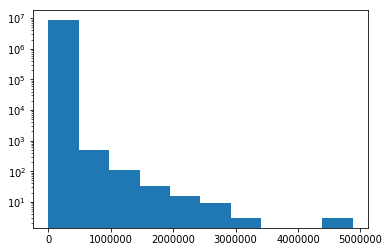

In [9]:
from matplotlib import pyplot as plt

plt.hist(cofreq.values(), log=True)
plt.show()

In [10]:
def build_training_data():
    training_data = []
    for sent_a, sent_b in cofreq.keys():
        counts = cofreq[(sent_a, sent_b)]
        if sent_a != sent_b:
            indexA = singleton[sent_a][1]
            indexB = singleton[sent_b][1]
            [training_data.append([indexA, indexB]) for _ in range(int(np.log(counts)))] #range(min(counts, min(counts, 10000)))]
    return training_data

In [11]:
training_data = build_training_data()

In [12]:
def is_valid_cuis(unigram, indexs, positive_cui):
    for i in indexs:
        if (unigram[i] == positive_cui[0]) or (unigram[i] == positive_cui[1]) :
            return False
    return True

def get_negative_sample_cuis(unigram, sample_size, positive_cui):
    population = range(len(unigram))
    indexs = random.sample(population, sample_size)
    cuis = []
    while not is_valid_cuis(unigram, indexs, positive_cui):
        indexs = random.sample(population, sample_size)
    for i in indexs:
        cuis.append(unigram[i])
    return cuis

def insert_negative_sample(training_data, unigram, sample_size):
    for i in range(len(training_data)):
        # drop the old negative samples first
        word_list = training_data[i][:2]
        negative_samples = get_negative_sample_cuis(unigram, sample_size, word_list)
        training_data[i] = word_list + negative_samples

### Helper

In [13]:
def get_duration(start_time):
    end_time = datetime.now()
    return 'Duration: {}'.format(end_time - start_time)

### Dynet Network

In [14]:
# create a class encapsulating the network
class OurNetwork(object):
    def __init__(self, pc, dictionary):
        self.dict_size = len(dictionary)
        self.lookup_hidden = pc.add_lookup_parameters((self.dict_size, word_vector_size))
        self.lookup_output = pc.add_lookup_parameters((self.dict_size, word_vector_size))
        print('Create Network with word vector size: ' + str(word_vector_size))

    def __call__(self, inputs):
        # inputs: [input word, observed word, negative sample 1, negative sample 2...]
        input_word = inputs[0]
        observed_word = inputs[1]
        
        loss = dy.log(dy.logistic(self.get_dot_product(input_word, observed_word)))
        for negative_sample in inputs[2:]:
            loss += dy.log(dy.logistic(-self.get_dot_product(input_word, negative_sample)))
        return -loss
    
    def get_dot_product(self, wordA, wordB):
        return dy.dot_product(self.lookup_hidden[wordA], self.lookup_output[wordB])
    
    def create_network_return_loss(self, inputs):
        dy.renew_cg()
        return self(inputs)

In [15]:
word_vector_size = 150
m = dy.ParameterCollection()

# create network
network = OurNetwork(m, singleton)

Create Network with word vector size: 150


In [16]:
# create trainer
trainer = dy.SimpleSGDTrainer(m)

In [20]:
negative_sample_size = 3
print('Start training with negative sample size: ' + str(negative_sample_size))

total_loss = 0
global seen_instances, epoch
ts = int(time.time())
epoch = 1

Start training with negative sample size: 3


In [18]:
def run_iteration(it_num):
    seen_instances, total_loss = 0, 0
    start_time = datetime.now()
    print('Running Iteration: ' + str(it_num))
    
    np.random.shuffle(training_data)
    print('Finish shuffling data ' + get_duration(start_time))
    
    insert_negative_sample(training_data, unigram_table, negative_sample_size)
    print('Finish inserting negative samples' + get_duration(start_time))
    
    for word_list in training_data:
        seen_instances += 1
        loss = network.create_network_return_loss(word_list)
        total_loss += loss.value()
        loss.backward()
        trainer.update()
        if seen_instances > 1 and seen_instances % 10000 == 0:
            print("average loss is: " + str(total_loss / seen_instances) + ' '\
                  + get_duration(start_time) + ' ' + str(seen_instances))

In [25]:
seen_instances = 0
while True:
    run_iteration(epoch)
    epoch += 1
    if epoch == 11:
        save_embedding(network.lookup_hidden, ts-1)
    else:save_embedding(network.lookup_hidden, ts)

Running Iteration: 2
Finish shuffling data Duration: 0:00:17.871401
Finish inserting negative samplesDuration: 0:04:52.779199
average loss is: 1.1318505974715838 Duration: 0:04:53.122951 10000
average loss is: 1.1299029011177133 Duration: 0:04:53.435482 20000
average loss is: 1.122764189535198 Duration: 0:04:53.763579 30000
average loss is: 1.124103548426324 Duration: 0:04:54.076111 40000
average loss is: 1.1282735750699668 Duration: 0:04:54.372983 50000
average loss is: 1.12942468097203 Duration: 0:04:54.685461 60000
average loss is: 1.125813923411275 Duration: 0:04:55.029243 70000
average loss is: 1.1280506221366213 Duration: 0:04:55.341748 80000
average loss is: 1.129867475217289 Duration: 0:04:55.638622 90000
average loss is: 1.132586071289484 Duration: 0:04:55.951099 100000
average loss is: 1.1317898695914341 Duration: 0:04:56.279249 110000
average loss is: 1.1306757176013518 Duration: 0:04:56.576128 120000
average loss is: 1.1309313067978897 Duration: 0:04:56.888632 130000
averag

average loss is: 1.1390258836197924 Duration: 0:05:30.216982 1200000
average loss is: 1.1390973708557952 Duration: 0:05:30.529456 1210000
average loss is: 1.139077047045496 Duration: 0:05:30.841978 1220000
average loss is: 1.1391163579858208 Duration: 0:05:31.138859 1230000
average loss is: 1.1391572212408463 Duration: 0:05:31.451335 1240000
average loss is: 1.1390631693483357 Duration: 0:05:31.763865 1250000
average loss is: 1.1389111742239073 Duration: 0:05:32.076337 1260000
average loss is: 1.139093383608274 Duration: 0:05:32.388839 1270000
average loss is: 1.1391157044377023 Duration: 0:05:32.701341 1280000
average loss is: 1.139067833556962 Duration: 0:05:33.013847 1290000
average loss is: 1.1390834821363194 Duration: 0:05:33.326374 1300000
average loss is: 1.1391961028424562 Duration: 0:05:33.623246 1310000
average loss is: 1.1393090498998104 Duration: 0:05:33.935751 1320000
average loss is: 1.1391941279797442 Duration: 0:05:34.248227 1330000
average loss is: 1.1390413552809713 D

average loss is: 1.1399465702184342 Duration: 0:06:07.653447 2400000
average loss is: 1.13996035259832 Duration: 0:06:07.965090 2410000
average loss is: 1.1400307909965588 Duration: 0:06:08.284126 2420000
average loss is: 1.1400667549728771 Duration: 0:06:08.587565 2430000
average loss is: 1.1400963027384239 Duration: 0:06:08.900098 2440000
average loss is: 1.140028172268777 Duration: 0:06:09.219465 2450000
average loss is: 1.1400164767180405 Duration: 0:06:09.522812 2460000
average loss is: 1.1400062891849525 Duration: 0:06:09.842022 2470000
average loss is: 1.1399828109703782 Duration: 0:06:10.138871 2480000
average loss is: 1.1399291290709832 Duration: 0:06:10.458402 2490000
average loss is: 1.1398957127974223 Duration: 0:06:10.761952 2500000
average loss is: 1.1399582626178322 Duration: 0:06:11.081050 2510000
average loss is: 1.1399688180674497 Duration: 0:06:11.393580 2520000
average loss is: 1.1400274565360542 Duration: 0:06:11.697132 2530000
average loss is: 1.1400005729696727 D

average loss is: 1.1409913372182943 Duration: 0:06:45.132657 3590000
average loss is: 1.1410262400487485 Duration: 0:06:45.436670 3600000
average loss is: 1.141059929342861 Duration: 0:06:45.749170 3610000
average loss is: 1.1410976201396017 Duration: 0:06:46.068849 3620000
average loss is: 1.1410806033202001 Duration: 0:06:46.387897 3630000
average loss is: 1.1411185349648478 Duration: 0:06:46.691379 3640000
average loss is: 1.1410666861476382 Duration: 0:06:46.995047 3650000
average loss is: 1.141110813458569 Duration: 0:06:47.307585 3660000
average loss is: 1.141143312721614 Duration: 0:06:47.626682 3670000
average loss is: 1.1411537320623022 Duration: 0:06:47.945825 3680000
average loss is: 1.1411128980514598 Duration: 0:06:48.265377 3690000
average loss is: 1.1411145254698327 Duration: 0:06:48.577850 3700000
average loss is: 1.1411837048168951 Duration: 0:06:48.897069 3710000
average loss is: 1.1412273941928819 Duration: 0:06:49.200442 3720000
average loss is: 1.1412112058961934 D

average loss is: 1.1416838120213946 Duration: 0:07:23.052192 4790000
average loss is: 1.1416900996493045 Duration: 0:07:23.371492 4800000
average loss is: 1.1417602692842774 Duration: 0:07:23.690758 4810000
average loss is: 1.141740075322556 Duration: 0:07:24.003260 4820000
average loss is: 1.1417459590903185 Duration: 0:07:24.323459 4830000
average loss is: 1.1417505882614893 Duration: 0:07:24.642685 4840000
average loss is: 1.1417831491465606 Duration: 0:07:24.961921 4850000
average loss is: 1.141766565441911 Duration: 0:07:25.265421 4860000
average loss is: 1.1417500516784032 Duration: 0:07:25.593572 4870000
average loss is: 1.1417798920037185 Duration: 0:07:25.912932 4880000
average loss is: 1.1417862647834478 Duration: 0:07:26.232495 4890000
average loss is: 1.1417768806718738 Duration: 0:07:26.545028 4900000
average loss is: 1.1417606852524886 Duration: 0:07:26.849287 4910000
average loss is: 1.1418044836143315 Duration: 0:07:27.168437 4920000
average loss is: 1.1418161128179825 

average loss is: 1.1417037432568848 Duration: 0:08:00.769070 5990000
average loss is: 1.1416893871881775 Duration: 0:08:01.088256 6000000
average loss is: 1.1416968443923101 Duration: 0:08:01.391621 6010000
average loss is: 1.1416950177647538 Duration: 0:08:01.695445 6020000
average loss is: 1.1416826296773532 Duration: 0:08:02.014574 6030000
average loss is: 1.1417480523028967 Duration: 0:08:02.327081 6040000
average loss is: 1.1417529656022694 Duration: 0:08:02.630709 6050000
average loss is: 1.14180364361885 Duration: 0:08:02.949902 6060000
average loss is: 1.141812396033352 Duration: 0:08:03.253665 6070000
average loss is: 1.1418274453025747 Duration: 0:08:03.581771 6080000
average loss is: 1.1418650509916426 Duration: 0:08:03.900849 6090000
average loss is: 1.1418941773680131 Duration: 0:08:04.220050 6100000
average loss is: 1.141939391660949 Duration: 0:08:04.523636 6110000
average loss is: 1.14194963140044 Duration: 0:08:04.836134 6120000
average loss is: 1.1419512407766141 Dura

average loss is: 1.1426599214516746 Duration: 0:08:38.331596 7190000
average loss is: 1.1426370981227196 Duration: 0:08:38.635019 7200000
average loss is: 1.142645245618215 Duration: 0:08:38.947507 7210000
average loss is: 1.1426217249496857 Duration: 0:08:39.266621 7220000
average loss is: 1.1426157263098462 Duration: 0:08:39.570365 7230000
average loss is: 1.142610424627545 Duration: 0:08:39.874102 7240000
average loss is: 1.1426024734284528 Duration: 0:08:40.186579 7250000
average loss is: 1.1426054222519815 Duration: 0:08:40.505744 7260000
average loss is: 1.1426092363103066 Duration: 0:08:40.809170 7270000
average loss is: 1.1426130824311493 Duration: 0:08:41.128567 7280000
average loss is: 1.1425983910772404 Duration: 0:08:41.442969 7290000
average loss is: 1.1425997342968217 Duration: 0:08:41.744627 7300000
average loss is: 1.1425956312946102 Duration: 0:08:42.063526 7310000
average loss is: 1.1426183494658149 Duration: 0:08:42.367932 7320000
average loss is: 1.1426430108672476 

average loss is: 1.1428344032781101 Duration: 0:09:16.149557 8400000
average loss is: 1.14286172372571 Duration: 0:09:16.477713 8410000
average loss is: 1.1428483338730862 Duration: 0:09:16.781493 8420000
average loss is: 1.14286653944179 Duration: 0:09:17.100551 8430000
average loss is: 1.1428502464134196 Duration: 0:09:17.404004 8440000
average loss is: 1.1428696006116537 Duration: 0:09:17.722977 8450000
average loss is: 1.1428586061205825 Duration: 0:09:18.019857 8460000
average loss is: 1.1428783205067068 Duration: 0:09:18.338862 8470000
average loss is: 1.1428947819923614 Duration: 0:09:18.642461 8480000
average loss is: 1.1428841514550885 Duration: 0:09:18.961828 8490000
average loss is: 1.1428984050880535 Duration: 0:09:19.274365 8500000
average loss is: 1.1428731494686728 Duration: 0:09:19.593534 8510000
average loss is: 1.1428523186676263 Duration: 0:09:19.897629 8520000
average loss is: 1.142864754537853 Duration: 0:09:20.204823 8530000
average loss is: 1.1428973878234119 Dur

average loss is: 1.1428594280537723 Duration: 0:09:53.675443 9600000
average loss is: 1.142846855402667 Duration: 0:09:53.978891 9610000
average loss is: 1.1428622004244218 Duration: 0:09:54.298114 9620000
average loss is: 1.1428559251536745 Duration: 0:09:54.610626 9630000
average loss is: 1.1428642326349208 Duration: 0:09:54.930162 9640000
average loss is: 1.142872682909812 Duration: 0:09:55.233581 9650000
average loss is: 1.1428795312619193 Duration: 0:09:55.553291 9660000
average loss is: 1.1428820792898837 Duration: 0:09:55.850172 9670000
average loss is: 1.142860369578125 Duration: 0:09:56.169570 9680000
average loss is: 1.1428755103630612 Duration: 0:09:56.489543 9690000
average loss is: 1.1428589082220497 Duration: 0:09:56.801146 9700000
average loss is: 1.1428536613799307 Duration: 0:09:57.120150 9710000
average loss is: 1.142845913551434 Duration: 0:09:57.432659 9720000
average loss is: 1.142836364884837 Duration: 0:09:57.751978 9730000
average loss is: 1.1428473050600745 Dur

average loss is: 1.1428623291146653 Duration: 0:10:31.034295 10790000
average loss is: 1.1428615479645412 Duration: 0:10:31.346796 10800000
average loss is: 1.1428481118022336 Duration: 0:10:31.665961 10810000
average loss is: 1.1428324818885462 Duration: 0:10:31.969443 10820000
average loss is: 1.1428094415420929 Duration: 0:10:32.288963 10830000
average loss is: 1.1428303496922214 Duration: 0:10:32.601439 10840000
average loss is: 1.1428292245854685 Duration: 0:10:32.905083 10850000
average loss is: 1.1428488197443534 Duration: 0:10:33.224351 10860000
average loss is: 1.142852724884138 Duration: 0:10:33.543613 10870000
average loss is: 1.1428345133141873 Duration: 0:10:33.866989 10880000
average loss is: 1.1428162467093663 Duration: 0:10:34.179522 10890000
average loss is: 1.1428395298057024 Duration: 0:10:34.498972 10900000
average loss is: 1.1428260625239488 Duration: 0:10:34.802619 10910000
average loss is: 1.142808211965103 Duration: 0:10:35.106181 10920000
average loss is: 1.142

average loss is: 1.1428458109249868 Duration: 0:11:07.936216 11970000
average loss is: 1.1428468294674823 Duration: 0:11:08.240134 11980000
average loss is: 1.1428536308052442 Duration: 0:11:08.543558 11990000
average loss is: 1.1428711971551477 Duration: 0:11:08.862774 12000000
average loss is: 1.1428884120759137 Duration: 0:11:09.175282 12010000
average loss is: 1.1428824627545102 Duration: 0:11:09.494580 12020000
average loss is: 1.1429023220906709 Duration: 0:11:09.813757 12030000
average loss is: 1.1428866917466844 Duration: 0:11:10.117294 12040000
average loss is: 1.1428923084856604 Duration: 0:11:10.437074 12050000
average loss is: 1.1428879788880535 Duration: 0:11:10.749582 12060000
average loss is: 1.1429031806539096 Duration: 0:11:11.068908 12070000
average loss is: 1.1429166013021197 Duration: 0:11:11.372218 12080000
average loss is: 1.1429256348048953 Duration: 0:11:11.684727 12090000
average loss is: 1.1429380142700498 Duration: 0:11:12.003881 12100000
average loss is: 1.1

average loss is: 1.1428945352678694 Duration: 0:11:44.887614 13150000
average loss is: 1.1429079130235116 Duration: 0:11:45.190988 13160000
average loss is: 1.1428918446501202 Duration: 0:11:45.510126 13170000
average loss is: 1.1429051561295824 Duration: 0:11:45.822634 13180000
average loss is: 1.1429045638534185 Duration: 0:11:46.141974 13190000
average loss is: 1.1428969480827231 Duration: 0:11:46.461152 13200000
average loss is: 1.1428992340843362 Duration: 0:11:46.780208 13210000
average loss is: 1.1428979811377893 Duration: 0:11:47.083520 13220000
average loss is: 1.1428952639995167 Duration: 0:11:47.411654 13230000
average loss is: 1.1428925426338625 Duration: 0:11:47.719192 13240000
average loss is: 1.1428834290186287 Duration: 0:11:48.038378 13250000
average loss is: 1.142892676555735 Duration: 0:11:48.346089 13260000
average loss is: 1.1428876868116247 Duration: 0:11:48.674254 13270000
average loss is: 1.1428808352888118 Duration: 0:11:48.979453 13280000
average loss is: 1.14

average loss is: 1.143038614961101 Duration: 0:12:21.904930 14330000
average loss is: 1.143039410996347 Duration: 0:12:22.208363 14340000
average loss is: 1.1430403116273158 Duration: 0:12:22.520841 14350000
average loss is: 1.1430437686267192 Duration: 0:12:22.856207 14360000
average loss is: 1.1430368747510566 Duration: 0:12:23.179395 14370000
average loss is: 1.143040690963472 Duration: 0:12:23.498274 14380000
average loss is: 1.1430456425514595 Duration: 0:12:23.801691 14390000
average loss is: 1.143027456748406 Duration: 0:12:24.114201 14400000
average loss is: 1.1430373463745704 Duration: 0:12:24.437751 14410000
average loss is: 1.143039770253319 Duration: 0:12:24.741212 14420000
average loss is: 1.1430439412053073 Duration: 0:12:25.060358 14430000
average loss is: 1.1430474130943364 Duration: 0:12:25.357239 14440000
average loss is: 1.1430500418898215 Duration: 0:12:25.676419 14450000
average loss is: 1.1430372904745452 Duration: 0:12:25.979900 14460000
average loss is: 1.143030

average loss is: 1.1432763540416113 Duration: 0:12:58.583868 15500000
average loss is: 1.1432744626651012 Duration: 0:12:58.903213 15510000
average loss is: 1.1432783961693807 Duration: 0:12:59.215725 15520000
average loss is: 1.143271388537952 Duration: 0:12:59.519274 15530000
average loss is: 1.1432809741298888 Duration: 0:12:59.838504 15540000
average loss is: 1.1432735642270635 Duration: 0:13:00.161740 15550000
average loss is: 1.1432667339182798 Duration: 0:13:00.474216 15560000
average loss is: 1.143269891934066 Duration: 0:13:00.824705 15570000
average loss is: 1.143268585467254 Duration: 0:13:01.128348 15580000
average loss is: 1.143259912651451 Duration: 0:13:01.447692 15590000
average loss is: 1.143258455796752 Duration: 0:13:01.760194 15600000
average loss is: 1.1432577021760082 Duration: 0:13:02.079384 15610000
average loss is: 1.1432527583583507 Duration: 0:13:02.383310 15620000
average loss is: 1.1432479606936707 Duration: 0:13:02.686958 15630000
average loss is: 1.143242

average loss is: 1.1432275713074052 Duration: 0:13:35.581862 16680000
average loss is: 1.143231757965892 Duration: 0:13:35.889870 16690000
average loss is: 1.1432304332690235 Duration: 0:13:36.193533 16700000
average loss is: 1.1432358705328316 Duration: 0:13:36.512836 16710000
average loss is: 1.1432312516004155 Duration: 0:13:36.816308 16720000
average loss is: 1.1432239065584433 Duration: 0:13:37.128841 16730000
average loss is: 1.1432262158444264 Duration: 0:13:37.448553 16740000
average loss is: 1.1432312450434687 Duration: 0:13:37.752127 16750000
average loss is: 1.1432473993487893 Duration: 0:13:38.071337 16760000
average loss is: 1.1432582108107412 Duration: 0:13:38.383844 16770000
average loss is: 1.1432506890138359 Duration: 0:13:38.702967 16780000
average loss is: 1.143252520574695 Duration: 0:13:39.010427 16790000
average loss is: 1.1432588155101517 Duration: 0:13:39.313873 16800000
average loss is: 1.1432584925008407 Duration: 0:13:39.642005 16810000
average loss is: 1.143

average loss is: 1.1432506251107917 Duration: 0:14:12.502187 17860000
average loss is: 1.1432445700009988 Duration: 0:14:12.821485 17870000
average loss is: 1.1432260750208287 Duration: 0:14:13.124807 17880000
average loss is: 1.1432204184783619 Duration: 0:14:13.437339 17890000
average loss is: 1.143225443595807 Duration: 0:14:13.756360 17900000
average loss is: 1.1432138248976789 Duration: 0:14:14.060134 17910000
average loss is: 1.1432276316761474 Duration: 0:14:14.379663 17920000
average loss is: 1.1432342224923522 Duration: 0:14:14.699306 17930000
average loss is: 1.143234241578133 Duration: 0:14:15.011805 17940000
average loss is: 1.1432200136285542 Duration: 0:14:15.330778 17950000
average loss is: 1.1432078555881446 Duration: 0:14:15.650273 17960000
average loss is: 1.143209051291175 Duration: 0:14:15.954087 17970000
average loss is: 1.1432077763162354 Duration: 0:14:16.266564 17980000
average loss is: 1.1432012789690544 Duration: 0:14:16.585464 17990000
average loss is: 1.1431

average loss is: 1.1431928987939388 Duration: 0:14:49.474237 19040000
average loss is: 1.1432007589893503 Duration: 0:14:49.793335 19050000
average loss is: 1.1432101415465343 Duration: 0:14:50.090212 19060000
average loss is: 1.1432066754408168 Duration: 0:14:50.409851 19070000
average loss is: 1.1432041439850495 Duration: 0:14:50.713595 19080000
average loss is: 1.1432073566923229 Duration: 0:14:51.063811 19090000
average loss is: 1.1432226018602338 Duration: 0:14:51.382826 19100000
average loss is: 1.1432222701448662 Duration: 0:14:51.679701 19110000
average loss is: 1.1432098302677356 Duration: 0:14:51.999050 19120000
average loss is: 1.1432022113531914 Duration: 0:14:52.302679 19130000
average loss is: 1.1432045518004998 Duration: 0:14:52.621860 19140000
average loss is: 1.1432088221198984 Duration: 0:14:52.934332 19150000
average loss is: 1.1432069918342247 Duration: 0:14:53.238148 19160000
average loss is: 1.1431997069390618 Duration: 0:14:53.557116 19170000
average loss is: 1.1

average loss is: 1.143200648699926 Duration: 0:15:26.439924 20220000
average loss is: 1.1431925695003973 Duration: 0:15:26.759012 20230000
average loss is: 1.143199190096128 Duration: 0:15:27.071548 20240000
average loss is: 1.1432020298213494 Duration: 0:15:27.391093 20250000
average loss is: 1.1432038060640837 Duration: 0:15:27.710356 20260000
average loss is: 1.1432037224467189 Duration: 0:15:28.013851 20270000
average loss is: 1.1431961809864812 Duration: 0:15:28.326352 20280000
average loss is: 1.1431980238882855 Duration: 0:15:28.645552 20290000
average loss is: 1.1432019577252959 Duration: 0:15:28.949272 20300000
average loss is: 1.1432111858434804 Duration: 0:15:29.268653 20310000
average loss is: 1.1431950847710368 Duration: 0:15:29.576621 20320000
average loss is: 1.1432039059285584 Duration: 0:15:29.889121 20330000
average loss is: 1.1432132378343938 Duration: 0:15:30.208241 20340000
average loss is: 1.143228150081999 Duration: 0:15:30.511696 20350000
average loss is: 1.1432

average loss is: 1.1433057098787658 Duration: 0:16:03.370006 21400000
average loss is: 1.1433129632080412 Duration: 0:16:03.682515 21410000
average loss is: 1.1433052322559456 Duration: 0:16:04.002340 21420000
average loss is: 1.143311006634281 Duration: 0:16:04.321654 21430000
average loss is: 1.1433086667544845 Duration: 0:16:04.634120 21440000
average loss is: 1.1433086359535733 Duration: 0:16:04.937681 21450000
average loss is: 1.1433210506781377 Duration: 0:16:05.241225 21460000
average loss is: 1.1433226592110985 Duration: 0:16:05.560613 21470000
average loss is: 1.1433244229619763 Duration: 0:16:05.864443 21480000
average loss is: 1.1433247916388902 Duration: 0:16:06.176916 21490000
average loss is: 1.143325078668454 Duration: 0:16:06.496498 21500000
average loss is: 1.1433191937960276 Duration: 0:16:06.800128 21510000
average loss is: 1.1433164495692991 Duration: 0:16:07.119387 21520000
average loss is: 1.14331141222158 Duration: 0:16:07.439324 21530000
average loss is: 1.14330

average loss is: 1.143338406908025 Duration: 0:16:40.255046 22580000
average loss is: 1.1433356959335261 Duration: 0:16:40.574182 22590000
average loss is: 1.1433339239152978 Duration: 0:16:40.893165 22600000
average loss is: 1.1433334393296788 Duration: 0:16:41.201364 22610000
average loss is: 1.143342822296856 Duration: 0:16:41.520541 22620000
average loss is: 1.1433507590899525 Duration: 0:16:41.833070 22630000
average loss is: 1.143353766371756 Duration: 0:16:42.136706 22640000
average loss is: 1.1433537914580958 Duration: 0:16:42.440554 22650000
average loss is: 1.1433586161695872 Duration: 0:16:42.759997 22660000
average loss is: 1.1433617758238854 Duration: 0:16:43.072524 22670000
average loss is: 1.143365485671383 Duration: 0:16:43.376888 22680000
average loss is: 1.1433686519101762 Duration: 0:16:43.680917 22690000
average loss is: 1.1433673981747554 Duration: 0:16:44.000105 22700000
average loss is: 1.1433685862499885 Duration: 0:16:44.312606 22710000
average loss is: 1.14336

average loss is: 1.1432470023438062 Duration: 0:17:17.053123 23760000
average loss is: 1.1432427274392603 Duration: 0:17:17.356610 23770000
average loss is: 1.143244154537154 Duration: 0:17:17.667301 23780000
average loss is: 1.1432400458394334 Duration: 0:17:17.986659 23790000
average loss is: 1.1432454061588497 Duration: 0:17:18.299164 23800000
average loss is: 1.1432477675425516 Duration: 0:17:18.618279 23810000
average loss is: 1.1432449038070398 Duration: 0:17:18.921728 23820000
average loss is: 1.143235653297547 Duration: 0:17:19.234227 23830000
average loss is: 1.1432240198204051 Duration: 0:17:19.541599 23840000
average loss is: 1.1432207846931597 Duration: 0:17:19.860790 23850000
average loss is: 1.1432211769995706 Duration: 0:17:20.164714 23860000
average loss is: 1.1432264393893066 Duration: 0:17:20.484242 23870000
average loss is: 1.1432274615524005 Duration: 0:17:20.796746 23880000
average loss is: 1.143218723111773 Duration: 0:17:21.104485 23890000
average loss is: 1.1432

average loss is: 1.143215656807011 Duration: 0:17:53.923568 24940000
average loss is: 1.143212823405633 Duration: 0:17:54.242672 24950000
average loss is: 1.1432216891857852 Duration: 0:17:54.539548 24960000
average loss is: 1.1432269526540133 Duration: 0:17:54.874617 24970000
average loss is: 1.1432362151258781 Duration: 0:17:55.197902 24980000
average loss is: 1.1432281350223885 Duration: 0:17:55.521152 24990000
average loss is: 1.1432319836436915 Duration: 0:17:55.824908 25000000
average loss is: 1.1432310652575628 Duration: 0:17:56.153038 25010000
average loss is: 1.1432366266416878 Duration: 0:17:56.472316 25020000
average loss is: 1.1432286076074754 Duration: 0:17:56.776555 25030000
average loss is: 1.1432254994672741 Duration: 0:17:57.095742 25040000
average loss is: 1.1432286342200475 Duration: 0:17:57.408275 25050000
average loss is: 1.143227725604399 Duration: 0:17:57.731643 25060000
average loss is: 1.1432314828290375 Duration: 0:17:58.035378 25070000
average loss is: 1.1432

average loss is: 1.143203067677338 Duration: 0:18:30.941165 26120000
average loss is: 1.1432047528359843 Duration: 0:18:31.244758 26130000
average loss is: 1.143202759834475 Duration: 0:18:31.557291 26140000
average loss is: 1.1432112276436872 Duration: 0:18:31.876453 26150000
average loss is: 1.1432049297552402 Duration: 0:18:32.211227 26160000
average loss is: 1.1432020108234333 Duration: 0:18:32.530511 26170000
average loss is: 1.1432054868058068 Duration: 0:18:32.843040 26180000
average loss is: 1.1432005145176216 Duration: 0:18:33.166320 26190000
average loss is: 1.14320038482565 Duration: 0:18:33.470133 26200000
average loss is: 1.1432031812507373 Duration: 0:18:33.789436 26210000
average loss is: 1.1432063098489702 Duration: 0:18:34.101941 26220000
average loss is: 1.1432013768116807 Duration: 0:18:34.409325 26230000
average loss is: 1.143202778186636 Duration: 0:18:34.713092 26240000
average loss is: 1.1432016463441839 Duration: 0:18:35.032433 26250000
average loss is: 1.143189

average loss is: 1.1431562717393584 Duration: 0:19:07.816055 27300000
average loss is: 1.1431545572515671 Duration: 0:19:08.128582 27310000
average loss is: 1.1431480502866829 Duration: 0:19:08.447915 27320000
average loss is: 1.1431448110631617 Duration: 0:19:08.751767 27330000
average loss is: 1.1431435581024045 Duration: 0:19:09.071010 27340000
average loss is: 1.143145905027424 Duration: 0:19:09.383485 27350000
average loss is: 1.143151925474221 Duration: 0:19:09.687003 27360000
average loss is: 1.1431500566522066 Duration: 0:19:09.990363 27370000
average loss is: 1.1431463696630344 Duration: 0:19:10.309773 27380000
average loss is: 1.1431539901231313 Duration: 0:19:10.606657 27390000
average loss is: 1.143155641498349 Duration: 0:19:10.925780 27400000
average loss is: 1.1431445530836146 Duration: 0:19:11.244722 27410000
average loss is: 1.1431410270328048 Duration: 0:19:11.563708 27420000
average loss is: 1.143133561778413 Duration: 0:19:11.883335 27430000
average loss is: 1.14313

average loss is: 1.143089584792336 Duration: 0:19:44.387274 28470000
average loss is: 1.1430854569442057 Duration: 0:19:44.699779 28480000
average loss is: 1.1430840306084884 Duration: 0:19:45.003566 28490000
average loss is: 1.1430823851547653 Duration: 0:19:45.307032 28500000
average loss is: 1.1430881958218821 Duration: 0:19:45.626244 28510000
average loss is: 1.1430923820346515 Duration: 0:19:45.938775 28520000
average loss is: 1.1431003247729088 Duration: 0:19:46.257807 28530000
average loss is: 1.143101412744393 Duration: 0:19:46.561426 28540000
average loss is: 1.1430930539337811 Duration: 0:19:46.880517 28550000
average loss is: 1.143090911219112 Duration: 0:19:47.192986 28560000
average loss is: 1.1430976398279369 Duration: 0:19:47.496829 28570000
average loss is: 1.1431039311368802 Duration: 0:19:47.816179 28580000
average loss is: 1.143111040563876 Duration: 0:19:48.119799 28590000
average loss is: 1.1431160297397633 Duration: 0:19:48.454707 28600000
average loss is: 1.14312

average loss is: 1.1431385557686318 Duration: 0:20:21.255945 29650000
average loss is: 1.1431365836774814 Duration: 0:20:21.559674 29660000
average loss is: 1.143141653810423 Duration: 0:20:21.878692 29670000
average loss is: 1.143144570675828 Duration: 0:20:22.198031 29680000
average loss is: 1.1431429540046893 Duration: 0:20:22.510531 29690000
average loss is: 1.1431398281017218 Duration: 0:20:22.830298 29700000
average loss is: 1.1431323728667866 Duration: 0:20:23.133914 29710000
average loss is: 1.1431363896297595 Duration: 0:20:23.452835 29720000
average loss is: 1.1431329346851236 Duration: 0:20:23.765332 29730000
average loss is: 1.143131262322057 Duration: 0:20:24.069526 29740000
average loss is: 1.1431242026507964 Duration: 0:20:24.388654 29750000
average loss is: 1.1431243840942842 Duration: 0:20:24.692248 29760000
average loss is: 1.1431227721271855 Duration: 0:20:25.004726 29770000
average loss is: 1.1431226683335713 Duration: 0:20:25.308199 29780000
average loss is: 1.1431

average loss is: 1.1431770800820598 Duration: 0:20:58.045717 30830000
average loss is: 1.1431838870613036 Duration: 0:20:58.380358 30840000
average loss is: 1.14318353826063 Duration: 0:20:58.692830 30850000
average loss is: 1.1431800719341525 Duration: 0:20:59.012288 30860000
average loss is: 1.1431742918879082 Duration: 0:20:59.315713 30870000
average loss is: 1.1431755317749437 Duration: 0:20:59.619419 30880000
average loss is: 1.1431777340023668 Duration: 0:20:59.954351 30890000
average loss is: 1.1431686526021925 Duration: 0:21:00.266853 30900000
average loss is: 1.143163664175168 Duration: 0:21:00.586370 30910000
average loss is: 1.1431627679172667 Duration: 0:21:00.889870 30920000
average loss is: 1.143161528814868 Duration: 0:21:01.194306 30930000
average loss is: 1.1431614887490131 Duration: 0:21:01.506811 30940000
average loss is: 1.1431560777991936 Duration: 0:21:01.826450 30950000
average loss is: 1.1431551573115548 Duration: 0:21:02.130050 30960000
average loss is: 1.14315

average loss is: 1.143178137989924 Duration: 0:21:34.932462 32010000
average loss is: 1.1431836366097032 Duration: 0:21:35.244963 32020000
average loss is: 1.1431887936012508 Duration: 0:21:35.557866 32030000
average loss is: 1.1431889706200304 Duration: 0:21:35.876995 32040000
average loss is: 1.1431817085295635 Duration: 0:21:36.180532 32050000
average loss is: 1.143185087863463 Duration: 0:21:36.515520 32060000
average loss is: 1.1431849730287924 Duration: 0:21:36.812363 32070000
average loss is: 1.1431872291621654 Duration: 0:21:37.123877 32080000
average loss is: 1.1431892486263313 Duration: 0:21:37.443143 32090000
average loss is: 1.1431878586910489 Duration: 0:21:37.747186 32100000
average loss is: 1.1431924883252509 Duration: 0:21:38.059689 32110000
average loss is: 1.143192038744442 Duration: 0:21:38.379108 32120000
average loss is: 1.143192340841518 Duration: 0:21:38.682585 32130000
average loss is: 1.1431926009356461 Duration: 0:21:39.001583 32140000
average loss is: 1.14319

average loss is: 1.1432011162583222 Duration: 0:22:11.833894 33190000
average loss is: 1.1432036760895108 Duration: 0:22:12.137416 33200000
average loss is: 1.1432071225379827 Duration: 0:22:12.457235 33210000
average loss is: 1.1432086995579107 Duration: 0:22:12.760700 33220000
average loss is: 1.1432074080704056 Duration: 0:22:13.079884 33230000
average loss is: 1.1432080077967504 Duration: 0:22:13.392416 33240000
average loss is: 1.1432099831261395 Duration: 0:22:13.711723 33250000
average loss is: 1.1432090324647204 Duration: 0:22:14.015213 33260000
average loss is: 1.143211398011897 Duration: 0:22:14.318679 33270000
average loss is: 1.1432096306903872 Duration: 0:22:14.648864 33280000
average loss is: 1.1432099801439213 Duration: 0:22:14.950448 33290000
average loss is: 1.143206307008531 Duration: 0:22:15.253955 33300000
average loss is: 1.1432085552621927 Duration: 0:22:15.573159 33310000
average loss is: 1.1432056167680573 Duration: 0:22:15.892156 33320000
average loss is: 1.143

average loss is: 1.1431744469704777 Duration: 0:22:48.729222 34370000
average loss is: 1.1431750231547635 Duration: 0:22:49.032682 34380000
average loss is: 1.143175105672475 Duration: 0:22:49.367347 34390000
average loss is: 1.1431740336714689 Duration: 0:22:49.670995 34400000
average loss is: 1.1431732800939014 Duration: 0:22:49.983499 34410000
average loss is: 1.1431735558532825 Duration: 0:22:50.286967 34420000
average loss is: 1.14317159188853 Duration: 0:22:50.606270 34430000
average loss is: 1.1431713206232545 Duration: 0:22:50.925375 34440000
average loss is: 1.1431756294634265 Duration: 0:22:51.228887 34450000
average loss is: 1.1431761740770092 Duration: 0:22:51.541394 34460000
average loss is: 1.1431762919126984 Duration: 0:22:51.844780 34470000
average loss is: 1.143182736394563 Duration: 0:22:52.163909 34480000
average loss is: 1.1431861472110172 Duration: 0:22:52.467599 34490000
average loss is: 1.1431795724251022 Duration: 0:22:52.780105 34500000
average loss is: 1.14318

average loss is: 1.1431510476736892 Duration: 0:23:25.627710 35550000
average loss is: 1.1431515544817608 Duration: 0:23:25.931552 35560000
average loss is: 1.143148177855461 Duration: 0:23:26.250830 35570000
average loss is: 1.1431503789991064 Duration: 0:23:26.563300 35580000
average loss is: 1.143154917046556 Duration: 0:23:26.867307 35590000
average loss is: 1.1431584662096976 Duration: 0:23:27.186494 35600000
average loss is: 1.1431603701318014 Duration: 0:23:27.489998 35610000
average loss is: 1.143166804407053 Duration: 0:23:27.818126 35620000
average loss is: 1.1431633065008429 Duration: 0:23:28.121999 35630000
average loss is: 1.143163649856952 Duration: 0:23:28.441111 35640000
average loss is: 1.1431689955680928 Duration: 0:23:28.744496 35650000
average loss is: 1.143166968890244 Duration: 0:23:29.063795 35660000
average loss is: 1.1431627724177649 Duration: 0:23:29.376299 35670000
average loss is: 1.1431650053974884 Duration: 0:23:29.711386 35680000
average loss is: 1.143163

average loss is: 1.1431471045653838 Duration: 0:24:02.570315 36730000
average loss is: 1.143147346123749 Duration: 0:24:02.882841 36740000
average loss is: 1.1431529194095593 Duration: 0:24:03.195323 36750000
average loss is: 1.1431488500857505 Duration: 0:24:03.492221 36760000
average loss is: 1.1431450424289658 Duration: 0:24:03.804728 36770000
average loss is: 1.143151296519205 Duration: 0:24:04.132830 36780000
average loss is: 1.143148050816246 Duration: 0:24:04.460978 36790000
average loss is: 1.1431459283985053 Duration: 0:24:04.773486 36800000
average loss is: 1.143148268524844 Duration: 0:24:05.085956 36810000
average loss is: 1.143148748624773 Duration: 0:24:05.382857 36820000
average loss is: 1.143148502155055 Duration: 0:24:05.710960 36830000
average loss is: 1.1431455338840655 Duration: 0:24:06.023495 36840000
average loss is: 1.1431407341054731 Duration: 0:24:06.351615 36850000
average loss is: 1.1431431590967698 Duration: 0:24:06.664120 36860000
average loss is: 1.1431457

average loss is: 1.1431776988240179 Duration: 0:24:39.554968 37910000
average loss is: 1.143185553567912 Duration: 0:24:39.867470 37920000
average loss is: 1.1431832492299812 Duration: 0:24:40.179941 37930000
average loss is: 1.143188471179888 Duration: 0:24:40.476845 37940000
average loss is: 1.1431903765029723 Duration: 0:24:40.804949 37950000
average loss is: 1.1431874951019703 Duration: 0:24:41.101826 37960000
average loss is: 1.143188227624884 Duration: 0:24:41.414355 37970000
average loss is: 1.1431858332826208 Duration: 0:24:41.742479 37980000
average loss is: 1.143185479859366 Duration: 0:24:42.054983 37990000
average loss is: 1.1431916720094277 Duration: 0:24:42.367459 38000000
average loss is: 1.1431902370099487 Duration: 0:24:42.664364 38010000
average loss is: 1.1431940110808438 Duration: 0:24:42.976865 38020000
average loss is: 1.1431968409180817 Duration: 0:24:43.289340 38030000
average loss is: 1.1431917140177035 Duration: 0:24:43.601864 38040000
average loss is: 1.14319

average loss is: 1.1431783042051604 Duration: 0:25:16.289585 39090000
average loss is: 1.1431779936029995 Duration: 0:25:16.602062 39100000
average loss is: 1.1431738726845424 Duration: 0:25:16.914593 39110000
average loss is: 1.1431744051923436 Duration: 0:25:17.227065 39120000
average loss is: 1.143174433995877 Duration: 0:25:17.539597 39130000
average loss is: 1.1431755576096716 Duration: 0:25:17.836473 39140000
average loss is: 1.1431720691363578 Duration: 0:25:18.148978 39150000
average loss is: 1.1431711522896544 Duration: 0:25:18.461481 39160000
average loss is: 1.1431751652674753 Duration: 0:25:18.773981 39170000
average loss is: 1.1431788499929263 Duration: 0:25:19.086480 39180000
average loss is: 1.143176033309796 Duration: 0:25:19.398986 39190000
average loss is: 1.1431805063114613 Duration: 0:25:19.711457 39200000
average loss is: 1.1431856221549634 Duration: 0:25:20.039584 39210000
average loss is: 1.1431860202659676 Duration: 0:25:20.336462 39220000
average loss is: 1.143

average loss is: 1.1432171987326536 Duration: 0:25:53.102341 40270000
average loss is: 1.1432199431069945 Duration: 0:25:53.430436 40280000
average loss is: 1.1432164049075444 Duration: 0:25:53.727311 40290000
average loss is: 1.1432157288270848 Duration: 0:25:54.039813 40300000
average loss is: 1.1432137663165431 Duration: 0:25:54.352345 40310000
average loss is: 1.1432144531642763 Duration: 0:25:54.664846 40320000
average loss is: 1.1432082749215262 Duration: 0:25:54.977322 40330000
average loss is: 1.1432095884616569 Duration: 0:25:55.289853 40340000
average loss is: 1.1432156206883968 Duration: 0:25:55.586728 40350000
average loss is: 1.1432153445763569 Duration: 0:25:55.899233 40360000
average loss is: 1.1432128285413283 Duration: 0:25:56.211703 40370000
average loss is: 1.1432085900757287 Duration: 0:25:56.539859 40380000
average loss is: 1.143206888465519 Duration: 0:25:56.836706 40390000
average loss is: 1.1432123974862836 Duration: 0:25:57.149209 40400000
average loss is: 1.14

average loss is: 1.1431824028014341 Duration: 0:26:29.961968 41450000
average loss is: 1.1431885912192372 Duration: 0:26:30.274433 41460000
average loss is: 1.143192033301454 Duration: 0:26:30.586963 41470000
average loss is: 1.1431898138578607 Duration: 0:26:30.899438 41480000
average loss is: 1.1431883766009436 Duration: 0:26:31.196344 41490000
average loss is: 1.143189712017372 Duration: 0:26:31.524468 41500000
average loss is: 1.1431914045112606 Duration: 0:26:31.821316 41510000
average loss is: 1.1431828727616185 Duration: 0:26:32.133848 41520000
average loss is: 1.1431876197018227 Duration: 0:26:32.446355 41530000
average loss is: 1.143190056515555 Duration: 0:26:32.758851 41540000
average loss is: 1.143191569464751 Duration: 0:26:33.055699 41550000
average loss is: 1.1431937154484544 Duration: 0:26:33.368207 41560000
average loss is: 1.143200549482092 Duration: 0:26:33.680735 41570000
average loss is: 1.1432021982492433 Duration: 0:26:33.993210 41580000
average loss is: 1.143201

average loss is: 1.1432113086980404 Duration: 0:27:06.759052 42630000
average loss is: 1.1432079969018045 Duration: 0:27:07.071557 42640000
average loss is: 1.1432088281616104 Duration: 0:27:07.384086 42650000
average loss is: 1.1431995530101595 Duration: 0:27:07.696561 42660000
average loss is: 1.143196717265456 Duration: 0:27:07.993438 42670000
average loss is: 1.1431952523529114 Duration: 0:27:08.305940 42680000
average loss is: 1.1431954776458824 Duration: 0:27:08.618469 42690000
average loss is: 1.1431918754402484 Duration: 0:27:08.946567 42700000
average loss is: 1.1431882232424746 Duration: 0:27:09.259067 42710000
average loss is: 1.1431867973452747 Duration: 0:27:09.571600 42720000
average loss is: 1.1431851277528897 Duration: 0:27:09.884097 42730000
average loss is: 1.1431831314938805 Duration: 0:27:10.196573 42740000
average loss is: 1.143187416588762 Duration: 0:27:10.509079 42750000
average loss is: 1.1431880410090398 Duration: 0:27:10.821609 42760000
average loss is: 1.143

average loss is: 1.1431418587286992 Duration: 0:27:43.509043 43810000
average loss is: 1.1431402547478573 Duration: 0:27:43.805915 43820000
average loss is: 1.1431351771694203 Duration: 0:27:44.118416 43830000
average loss is: 1.1431393700149477 Duration: 0:27:44.430911 43840000
average loss is: 1.1431447480863142 Duration: 0:27:44.743407 43850000
average loss is: 1.1431448115379983 Duration: 0:27:45.040280 43860000
average loss is: 1.1431451933507741 Duration: 0:27:45.352780 43870000
average loss is: 1.1431450570758461 Duration: 0:27:45.665250 43880000
average loss is: 1.1431481975162905 Duration: 0:27:45.977777 43890000
average loss is: 1.1431524202257608 Duration: 0:27:46.290244 43900000
average loss is: 1.1431565527175604 Duration: 0:27:46.602771 43910000
average loss is: 1.143152797955649 Duration: 0:27:46.915263 43920000
average loss is: 1.1431551641602595 Duration: 0:27:47.212136 43930000
average loss is: 1.143154603875046 Duration: 0:27:47.524638 43940000
average loss is: 1.143

average loss is: 1.1430861748558132 Duration: 0:28:20.383813 44990000
average loss is: 1.1430897762227459 Duration: 0:28:20.696306 45000000
average loss is: 1.1430826448888582 Duration: 0:28:21.008773 45010000
average loss is: 1.143082759923787 Duration: 0:28:21.321272 45020000
average loss is: 1.1430812138492616 Duration: 0:28:21.618150 45030000
average loss is: 1.1430812646423008 Duration: 0:28:21.946270 45040000
average loss is: 1.1430762099295129 Duration: 0:28:22.258768 45050000
average loss is: 1.1430732756577116 Duration: 0:28:22.571264 45060000
average loss is: 1.1430729483968325 Duration: 0:28:22.868144 45070000
average loss is: 1.1430688565369123 Duration: 0:28:23.180667 45080000
average loss is: 1.143066753418282 Duration: 0:28:23.493135 45090000
average loss is: 1.1430699546312764 Duration: 0:28:23.805633 45100000
average loss is: 1.1430703023772584 Duration: 0:28:24.118132 45110000
average loss is: 1.1430706786802094 Duration: 0:28:24.430633 45120000
average loss is: 1.143

average loss is: 1.1430735351636014 Duration: 0:28:57.149205 46170000
average loss is: 1.1430736301402906 Duration: 0:28:57.461669 46180000
average loss is: 1.1430754168807384 Duration: 0:28:57.774195 46190000
average loss is: 1.1430749197963412 Duration: 0:28:58.086695 46200000
average loss is: 1.1430783001359848 Duration: 0:28:58.399188 46210000
average loss is: 1.1430732787564426 Duration: 0:28:58.711660 46220000
average loss is: 1.1430748956559023 Duration: 0:28:59.008541 46230000
average loss is: 1.1430763543067675 Duration: 0:28:59.321032 46240000
average loss is: 1.1430801414961518 Duration: 0:28:59.633535 46250000
average loss is: 1.1430791049461417 Duration: 0:28:59.946027 46260000
average loss is: 1.1430801839600764 Duration: 0:29:00.258555 46270000
average loss is: 1.143079367413677 Duration: 0:29:00.571023 46280000
average loss is: 1.1430786290818409 Duration: 0:29:00.883525 46290000
average loss is: 1.1430798364902481 Duration: 0:29:01.196050 46300000
average loss is: 1.14

average loss is: 1.1357607781348156 Duration: 0:05:13.560318 700000
average loss is: 1.1357782581425633 Duration: 0:05:13.872843 710000
average loss is: 1.13593394877361 Duration: 0:05:14.169720 720000
average loss is: 1.1359907687555597 Duration: 0:05:14.482190 730000
average loss is: 1.1359869989678169 Duration: 0:05:14.794695 740000
average loss is: 1.1358744459994863 Duration: 0:05:15.107188 750000
average loss is: 1.1358604787375581 Duration: 0:05:15.419693 760000
average loss is: 1.1356084711237207 Duration: 0:05:15.732188 770000
average loss is: 1.135674263812212 Duration: 0:05:16.044718 780000
average loss is: 1.1356875771864914 Duration: 0:05:16.357218 790000
average loss is: 1.1354428163236494 Duration: 0:05:16.654067 800000
average loss is: 1.1353831613928915 Duration: 0:05:16.966592 810000
average loss is: 1.1353529689886945 Duration: 0:05:17.294721 820000
average loss is: 1.1354055983480194 Duration: 0:05:17.622844 830000
average loss is: 1.1353873909160503 Duration: 0:05:

average loss is: 1.1352510172209545 Duration: 0:05:50.888470 1900000
average loss is: 1.1353321072215805 Duration: 0:05:51.200942 1910000
average loss is: 1.1353265508051151 Duration: 0:05:51.513440 1920000
average loss is: 1.1352861316124625 Duration: 0:05:51.825971 1930000
average loss is: 1.1354778758581368 Duration: 0:05:52.122819 1940000
average loss is: 1.135439816259452 Duration: 0:05:52.435320 1950000
average loss is: 1.1355816375787955 Duration: 0:05:52.747844 1960000
average loss is: 1.13558482652805 Duration: 0:05:53.060316 1970000
average loss is: 1.1356004635279757 Duration: 0:05:53.357191 1980000
average loss is: 1.1357672940575327 Duration: 0:05:53.685323 1990000
average loss is: 1.1357514735532739 Duration: 0:05:53.997851 2000000
average loss is: 1.1357830714601336 Duration: 0:05:54.310318 2010000
average loss is: 1.1356951657907846 Duration: 0:05:54.622845 2020000
average loss is: 1.1357290338063875 Duration: 0:05:54.919692 2030000
average loss is: 1.135735672892324 Du

average loss is: 1.1372423419907083 Duration: 0:06:28.247847 3100000
average loss is: 1.1372628056093765 Duration: 0:06:28.560349 3110000
average loss is: 1.137295401153449 Duration: 0:06:28.872819 3120000
average loss is: 1.1373214927941133 Duration: 0:06:29.185344 3130000
average loss is: 1.1373162749342554 Duration: 0:06:29.497853 3140000
average loss is: 1.1372856023595759 Duration: 0:06:29.810319 3150000
average loss is: 1.1373490238654167 Duration: 0:06:30.122819 3160000
average loss is: 1.1373341277047513 Duration: 0:06:30.450973 3170000
average loss is: 1.1373050936366533 Duration: 0:06:30.747852 3180000
average loss is: 1.1373685851137625 Duration: 0:06:31.075948 3190000
average loss is: 1.1373607741458405 Duration: 0:06:31.372822 3200000
average loss is: 1.1374775967227782 Duration: 0:06:31.685320 3210000
average loss is: 1.1375176700032932 Duration: 0:06:31.997819 3220000
average loss is: 1.1376086049449246 Duration: 0:06:32.310323 3230000
average loss is: 1.1376900439986253

average loss is: 1.1384965319707452 Duration: 0:07:05.685321 4300000
average loss is: 1.1384894984597833 Duration: 0:07:05.997851 4310000
average loss is: 1.1384773935271155 Duration: 0:07:06.310353 4320000
average loss is: 1.1385331602038242 Duration: 0:07:06.638455 4330000
average loss is: 1.138495123059035 Duration: 0:07:06.935329 4340000
average loss is: 1.138500802239735 Duration: 0:07:07.247831 4350000
average loss is: 1.1385549865444111 Duration: 0:07:07.560330 4360000
average loss is: 1.1385458661404952 Duration: 0:07:07.872864 4370000
average loss is: 1.1385274738080664 Duration: 0:07:08.169708 4380000
average loss is: 1.138602692698439 Duration: 0:07:08.497861 4390000
average loss is: 1.1385805476607698 Duration: 0:07:08.810369 4400000
average loss is: 1.1386009575921336 Duration: 0:07:09.122871 4410000
average loss is: 1.138597545241683 Duration: 0:07:09.435373 4420000
average loss is: 1.1385482319128313 Duration: 0:07:09.747848 4430000
average loss is: 1.1385802136963232 Du

average loss is: 1.1388286486128258 Duration: 0:07:43.544980 5500000
average loss is: 1.1387983386415466 Duration: 0:07:43.857485 5510000
average loss is: 1.1388241474008276 Duration: 0:07:44.169984 5520000
average loss is: 1.1387990088028508 Duration: 0:07:44.482454 5530000
average loss is: 1.1388006983079688 Duration: 0:07:44.810585 5540000
average loss is: 1.1387822955609477 Duration: 0:07:45.138745 5550000
average loss is: 1.1387567801290874 Duration: 0:07:45.451239 5560000
average loss is: 1.1387495414046094 Duration: 0:07:45.763749 5570000
average loss is: 1.1387582292418463 Duration: 0:07:46.076216 5580000
average loss is: 1.1387584062446474 Duration: 0:07:46.388720 5590000
average loss is: 1.1387297345053475 Duration: 0:07:46.701254 5600000
average loss is: 1.1387572784441702 Duration: 0:07:47.013726 5610000
average loss is: 1.1387703591929377 Duration: 0:07:47.357501 5620000
average loss is: 1.1387894267587684 Duration: 0:07:47.670002 5630000
average loss is: 1.138755787200321

average loss is: 1.139417607180313 Duration: 0:08:21.717091 6700000
average loss is: 1.1394065983804686 Duration: 0:08:22.076462 6710000
average loss is: 1.1394152136466666 Duration: 0:08:22.404612 6720000
average loss is: 1.139433052404783 Duration: 0:08:22.732725 6730000
average loss is: 1.139420872450966 Duration: 0:08:23.045218 6740000
average loss is: 1.1394497506960253 Duration: 0:08:23.388973 6750000
average loss is: 1.1394557208718095 Duration: 0:08:23.732721 6760000
average loss is: 1.1394301041307495 Duration: 0:08:24.076469 6770000
average loss is: 1.139427430762903 Duration: 0:08:24.420226 6780000
average loss is: 1.1394401426643335 Duration: 0:08:24.779629 6790000
average loss is: 1.1394387767766265 Duration: 0:08:25.107750 6800000
average loss is: 1.1394442004469572 Duration: 0:08:25.451481 6810000
average loss is: 1.139428096978797 Duration: 0:08:25.779646 6820000
average loss is: 1.139440847769901 Duration: 0:08:26.123388 6830000
average loss is: 1.139441510730079 Durat

average loss is: 1.1394601926157746 Duration: 0:09:00.123616 7900000
average loss is: 1.139464405376097 Duration: 0:09:00.420492 7910000
average loss is: 1.139460041509991 Duration: 0:09:00.732994 7920000
average loss is: 1.1394579241743865 Duration: 0:09:01.045496 7930000
average loss is: 1.1394611973991104 Duration: 0:09:01.357969 7940000
average loss is: 1.13947625796911 Duration: 0:09:01.717376 7950000
average loss is: 1.1394684244150826 Duration: 0:09:02.029848 7960000
average loss is: 1.1394620371807496 Duration: 0:09:02.326725 7970000
average loss is: 1.1394785315577445 Duration: 0:09:02.639261 7980000
average loss is: 1.139497033290172 Duration: 0:09:02.967354 7990000
average loss is: 1.1394785989673426 Duration: 0:09:03.264231 8000000
average loss is: 1.139465849168244 Duration: 0:09:03.576736 8010000
average loss is: 1.139449834783987 Duration: 0:09:03.889265 8020000
average loss is: 1.139466823836165 Duration: 0:09:04.201737 8030000
average loss is: 1.1394519615698704 Durati

average loss is: 1.1395361969357267 Duration: 0:09:37.483241 9100000
average loss is: 1.1395242852958833 Duration: 0:09:37.811368 9110000
average loss is: 1.1395336262485323 Duration: 0:09:38.108215 9120000
average loss is: 1.139530718520284 Duration: 0:09:38.420753 9130000
average loss is: 1.1395441923513825 Duration: 0:09:38.733254 9140000
average loss is: 1.1395591419587727 Duration: 0:09:39.030126 9150000
average loss is: 1.1395574245414195 Duration: 0:09:39.342628 9160000
average loss is: 1.1395621101728866 Duration: 0:09:39.670756 9170000
average loss is: 1.1395757696719018 Duration: 0:09:39.967631 9180000
average loss is: 1.139594520596992 Duration: 0:09:40.280136 9190000
average loss is: 1.1396064822120302 Duration: 0:09:40.592637 9200000
average loss is: 1.1396126796779678 Duration: 0:09:40.920763 9210000
average loss is: 1.1396133221916172 Duration: 0:09:41.280112 9220000
average loss is: 1.139595461944719 Duration: 0:09:41.576990 9230000
average loss is: 1.1395825469329632 D

average loss is: 1.139913987077937 Duration: 0:10:14.405334 10290000
average loss is: 1.1399099034040736 Duration: 0:10:14.717866 10300000
average loss is: 1.1399088275615965 Duration: 0:10:15.030369 10310000
average loss is: 1.1398931024380912 Duration: 0:10:15.327216 10320000
average loss is: 1.1398790625777595 Duration: 0:10:15.639743 10330000
average loss is: 1.1398753498505074 Duration: 0:10:15.952249 10340000
average loss is: 1.1398842950292702 Duration: 0:10:16.280375 10350000
average loss is: 1.1398799108253597 Duration: 0:10:16.592852 10360000
average loss is: 1.1398733923730162 Duration: 0:10:16.889755 10370000
average loss is: 1.1398691365400526 Duration: 0:10:17.202259 10380000
average loss is: 1.1398583517636696 Duration: 0:10:17.514759 10390000
average loss is: 1.1398466172336945 Duration: 0:10:17.811636 10400000
average loss is: 1.1398284531441785 Duration: 0:10:18.124111 10410000
average loss is: 1.1398382304225356 Duration: 0:10:18.452266 10420000
average loss is: 1.13

average loss is: 1.1400620022016508 Duration: 0:10:50.936860 11470000
average loss is: 1.1400607982686026 Duration: 0:10:51.233709 11480000
average loss is: 1.1400458281148078 Duration: 0:10:51.561838 11490000
average loss is: 1.1400495901403869 Duration: 0:10:51.874363 11500000
average loss is: 1.140055065158124 Duration: 0:10:52.171212 11510000
average loss is: 1.140076467825572 Duration: 0:10:52.499339 11520000
average loss is: 1.1400695086590078 Duration: 0:10:52.811872 11530000
average loss is: 1.1400703301279045 Duration: 0:10:53.124373 11540000
average loss is: 1.1400776141755897 Duration: 0:10:53.436876 11550000
average loss is: 1.1401106510499084 Duration: 0:10:53.749378 11560000
average loss is: 1.1401333199389365 Duration: 0:10:54.046255 11570000
average loss is: 1.140139220165722 Duration: 0:10:54.358729 11580000
average loss is: 1.1401368149426105 Duration: 0:10:54.655634 11590000
average loss is: 1.1401375946217285 Duration: 0:10:54.968132 11600000
average loss is: 1.1401

average loss is: 1.140254782838581 Duration: 0:11:27.390204 12650000
average loss is: 1.1402577796861704 Duration: 0:11:27.718326 12660000
average loss is: 1.1402385060433533 Duration: 0:11:28.015210 12670000
average loss is: 1.140260809198182 Duration: 0:11:28.327708 12680000
average loss is: 1.1402600284421198 Duration: 0:11:28.640210 12690000
average loss is: 1.1402646265720668 Duration: 0:11:28.952739 12700000
average loss is: 1.140275857888482 Duration: 0:11:29.249610 12710000
average loss is: 1.140271267444187 Duration: 0:11:29.562113 12720000
average loss is: 1.1402776355048336 Duration: 0:11:29.874621 12730000
average loss is: 1.1402692587044307 Duration: 0:11:30.187126 12740000
average loss is: 1.1402652795391979 Duration: 0:11:30.483972 12750000
average loss is: 1.1402647391624234 Duration: 0:11:30.796497 12760000
average loss is: 1.1402712094984564 Duration: 0:11:31.109007 12770000
average loss is: 1.140276554094377 Duration: 0:11:31.421476 12780000
average loss is: 1.140271

average loss is: 1.1403836872017628 Duration: 0:12:04.031101 13830000
average loss is: 1.1403776504733611 Duration: 0:12:04.343601 13840000
average loss is: 1.1403842452567734 Duration: 0:12:04.640482 13850000
average loss is: 1.140386596683217 Duration: 0:12:04.968607 13860000
average loss is: 1.1403940985472516 Duration: 0:12:05.265485 13870000
average loss is: 1.1403929258255243 Duration: 0:12:05.577987 13880000
average loss is: 1.1404061663536713 Duration: 0:12:05.890489 13890000
average loss is: 1.140419832587055 Duration: 0:12:06.187336 13900000
average loss is: 1.140413074568672 Duration: 0:12:06.499861 13910000
average loss is: 1.1404254341394127 Duration: 0:12:06.796712 13920000
average loss is: 1.1404197138255 Duration: 0:12:07.109212 13930000
average loss is: 1.1404237895383624 Duration: 0:12:07.421736 13940000
average loss is: 1.1404269535677718 Duration: 0:12:07.734241 13950000
average loss is: 1.1404229311064107 Duration: 0:12:08.031118 13960000
average loss is: 1.1404215

average loss is: 1.1405627560340548 Duration: 0:12:40.687369 15010000
average loss is: 1.1405776866436015 Duration: 0:12:40.984245 15020000
average loss is: 1.1405941646995938 Duration: 0:12:41.296742 15030000
average loss is: 1.1405898658691231 Duration: 0:12:41.609216 15040000
average loss is: 1.1405788451606917 Duration: 0:12:41.906118 15050000
average loss is: 1.1405754622479414 Duration: 0:12:42.218592 15060000
average loss is: 1.140587199998387 Duration: 0:12:42.531091 15070000
average loss is: 1.1405884371336892 Duration: 0:12:42.827995 15080000
average loss is: 1.1405968227567758 Duration: 0:12:43.156119 15090000
average loss is: 1.1405988078013005 Duration: 0:12:43.468588 15100000
average loss is: 1.1406041139924692 Duration: 0:12:43.765463 15110000
average loss is: 1.1405969320127802 Duration: 0:12:44.077964 15120000
average loss is: 1.140618291725676 Duration: 0:12:44.390492 15130000
average loss is: 1.1406173774800976 Duration: 0:12:44.687364 15140000
average loss is: 1.140

average loss is: 1.1406640821315053 Duration: 0:13:17.467983 16190000
average loss is: 1.140658246756597 Duration: 0:13:17.771922 16200000
average loss is: 1.1406616558167502 Duration: 0:13:18.091919 16210000
average loss is: 1.1406696388480937 Duration: 0:13:18.395512 16220000
average loss is: 1.140678917968982 Duration: 0:13:18.708042 16230000
average loss is: 1.1406762568719608 Duration: 0:13:19.015827 16240000
average loss is: 1.1406684659051345 Duration: 0:13:19.335610 16250000
average loss is: 1.1406770115384721 Duration: 0:13:19.655609 16260000
average loss is: 1.1406795265184417 Duration: 0:13:19.975162 16270000
average loss is: 1.1406720856901098 Duration: 0:13:20.287663 16280000
average loss is: 1.1406820920337863 Duration: 0:13:20.606977 16290000
average loss is: 1.1406898860300467 Duration: 0:13:20.926664 16300000
average loss is: 1.140679590394193 Duration: 0:13:21.231199 16310000
average loss is: 1.1406683783905807 Duration: 0:13:21.543697 16320000
average loss is: 1.1406

average loss is: 1.1406351009389202 Duration: 0:13:54.959771 17370000
average loss is: 1.1406478849955104 Duration: 0:13:55.272273 17380000
average loss is: 1.140643168740488 Duration: 0:13:55.598885 17390000
average loss is: 1.1406531165227944 Duration: 0:13:55.918310 17400000
average loss is: 1.1406594322074253 Duration: 0:13:56.230781 17410000
average loss is: 1.1406430925833961 Duration: 0:13:56.540847 17420000
average loss is: 1.1406479860527747 Duration: 0:13:56.845018 17430000
average loss is: 1.140650884561993 Duration: 0:13:57.164540 17440000
average loss is: 1.1406415651956252 Duration: 0:13:57.484082 17450000
average loss is: 1.1406460802528908 Duration: 0:13:57.804413 17460000
average loss is: 1.1406460892447303 Duration: 0:13:58.132536 17470000
average loss is: 1.140645257926475 Duration: 0:13:58.442726 17480000
average loss is: 1.1406531798117898 Duration: 0:13:58.752970 17490000
average loss is: 1.140660042091778 Duration: 0:13:59.065438 17500000
average loss is: 1.14065

average loss is: 1.1406620884757677 Duration: 0:14:32.413783 18550000
average loss is: 1.1406631065480617 Duration: 0:14:32.729336 18560000
average loss is: 1.1406691456183529 Duration: 0:14:33.030511 18570000
average loss is: 1.1406627529732263 Duration: 0:14:33.354171 18580000
average loss is: 1.1406525685499782 Duration: 0:14:33.678034 18590000
average loss is: 1.1406540630083963 Duration: 0:14:33.987402 18600000
average loss is: 1.1406528994779386 Duration: 0:14:34.284279 18610000
average loss is: 1.1406433896410173 Duration: 0:14:34.609315 18620000
average loss is: 1.1406389369465455 Duration: 0:14:34.921844 18630000
average loss is: 1.1406437607395454 Duration: 0:14:35.232028 18640000
average loss is: 1.140650608479831 Duration: 0:14:35.546853 18650000
average loss is: 1.14064447317631 Duration: 0:14:35.848452 18660000
average loss is: 1.1406503393682579 Duration: 0:14:36.167496 18670000
average loss is: 1.1406457445397673 Duration: 0:14:36.492986 18680000
average loss is: 1.1406

average loss is: 1.1407518460852333 Duration: 0:15:09.348087 19730000
average loss is: 1.1407547393782786 Duration: 0:15:09.668854 19740000
average loss is: 1.1407633718918506 Duration: 0:15:09.989105 19750000
average loss is: 1.1407494567423697 Duration: 0:15:10.292534 19760000
average loss is: 1.1407358099604676 Duration: 0:15:10.595945 19770000
average loss is: 1.140727728611984 Duration: 0:15:10.908016 19780000
average loss is: 1.1407284560589412 Duration: 0:15:11.227125 19790000
average loss is: 1.140720218528127 Duration: 0:15:11.530819 19800000
average loss is: 1.1407313829318897 Duration: 0:15:11.850220 19810000
average loss is: 1.1407263195086303 Duration: 0:15:12.154248 19820000
average loss is: 1.1407359028096247 Duration: 0:15:12.466721 19830000
average loss is: 1.14072822470921 Duration: 0:15:12.788541 19840000
average loss is: 1.1407278628833244 Duration: 0:15:13.091961 19850000
average loss is: 1.1407268501210561 Duration: 0:15:13.395758 19860000
average loss is: 1.14071

average loss is: 1.1407624041011133 Duration: 0:15:46.289028 20910000
average loss is: 1.1407586335684339 Duration: 0:15:46.608230 20920000
average loss is: 1.1407591546197935 Duration: 0:15:46.920727 20930000
average loss is: 1.1407593868306865 Duration: 0:15:47.224679 20940000
average loss is: 1.1407630274502543 Duration: 0:15:47.543791 20950000
average loss is: 1.1407632048336358 Duration: 0:15:47.857582 20960000
average loss is: 1.1407511530159269 Duration: 0:15:48.175929 20970000
average loss is: 1.1407616478045657 Duration: 0:15:48.478465 20980000
average loss is: 1.140771441752642 Duration: 0:15:48.804146 20990000
average loss is: 1.1407709739692888 Duration: 0:15:49.111461 21000000
average loss is: 1.1407671734256668 Duration: 0:15:49.430791 21010000
average loss is: 1.1407645191615092 Duration: 0:15:49.743297 21020000
average loss is: 1.1407677695369207 Duration: 0:15:50.068578 21030000
average loss is: 1.1407743890478834 Duration: 0:15:50.373550 21040000
average loss is: 1.14

average loss is: 1.1408164558506262 Duration: 0:16:23.702271 22090000
average loss is: 1.1408221679619275 Duration: 0:16:24.030397 22100000
average loss is: 1.1408280018640884 Duration: 0:16:24.342900 22110000
average loss is: 1.1408312400671787 Duration: 0:16:24.655402 22120000
average loss is: 1.1408319732267278 Duration: 0:16:24.967876 22130000
average loss is: 1.1408330968982636 Duration: 0:16:25.280377 22140000
average loss is: 1.1408356026891475 Duration: 0:16:25.592911 22150000
average loss is: 1.1408324426114627 Duration: 0:16:25.921008 22160000
average loss is: 1.1408136794608716 Duration: 0:16:26.217910 22170000
average loss is: 1.1408106333534245 Duration: 0:16:26.530386 22180000
average loss is: 1.1408066201560068 Duration: 0:16:26.842917 22190000
average loss is: 1.1408064827057502 Duration: 0:16:27.155414 22200000
average loss is: 1.1408077551566902 Duration: 0:16:27.467923 22210000
average loss is: 1.1408110353773067 Duration: 0:16:27.780394 22220000
average loss is: 1.1

average loss is: 1.1407863326365968 Duration: 0:17:00.443445 23270000
average loss is: 1.140798518050867 Duration: 0:17:00.755947 23280000
average loss is: 1.1407912682598575 Duration: 0:17:01.052822 23290000
average loss is: 1.1407777664901613 Duration: 0:17:01.365295 23300000
average loss is: 1.1407836742192323 Duration: 0:17:01.677825 23310000
average loss is: 1.1407790131540185 Duration: 0:17:01.990300 23320000
average loss is: 1.1407818614518919 Duration: 0:17:02.302801 23330000
average loss is: 1.1407853162241772 Duration: 0:17:02.613896 23340000
average loss is: 1.1407817298174798 Duration: 0:17:02.910743 23350000
average loss is: 1.1407793715457453 Duration: 0:17:03.223249 23360000
average loss is: 1.1407742091111472 Duration: 0:17:03.535778 23370000
average loss is: 1.1407883939717942 Duration: 0:17:03.848280 23380000
average loss is: 1.1407874563546039 Duration: 0:17:04.160753 23390000
average loss is: 1.1407863098922368 Duration: 0:17:04.473257 23400000
average loss is: 1.14

average loss is: 1.1408358935144223 Duration: 0:17:37.392846 24450000
average loss is: 1.1408311659204722 Duration: 0:17:37.696547 24460000
average loss is: 1.140840157577123 Duration: 0:17:38.032278 24470000
average loss is: 1.140839902236436 Duration: 0:17:38.329154 24480000
average loss is: 1.140838538670571 Duration: 0:17:38.648213 24490000
average loss is: 1.140846066965133 Duration: 0:17:38.963465 24500000
average loss is: 1.140843212000703 Duration: 0:17:39.269479 24510000
average loss is: 1.1408426395765856 Duration: 0:17:39.588939 24520000
average loss is: 1.1408374239876313 Duration: 0:17:39.892472 24530000
average loss is: 1.1408212040110262 Duration: 0:17:40.195576 24540000
average loss is: 1.1408204336118022 Duration: 0:17:40.514835 24550000
average loss is: 1.1408202066236333 Duration: 0:17:40.819840 24560000
average loss is: 1.1408145914583259 Duration: 0:17:41.139171 24570000
average loss is: 1.140818024976109 Duration: 0:17:41.455721 24580000
average loss is: 1.1408136

average loss is: 1.14077055858178 Duration: 0:18:14.664072 25630000
average loss is: 1.1407680504657212 Duration: 0:18:14.983553 25640000
average loss is: 1.1407705760902136 Duration: 0:18:15.280398 25650000
average loss is: 1.140774634078546 Duration: 0:18:15.598459 25660000
average loss is: 1.140774914027267 Duration: 0:18:15.925503 25670000
average loss is: 1.1407714201886026 Duration: 0:18:16.238040 25680000
average loss is: 1.1407728851413652 Duration: 0:18:16.548338 25690000
average loss is: 1.1407782544767682 Duration: 0:18:16.867632 25700000
average loss is: 1.1407829101247513 Duration: 0:18:17.171083 25710000
average loss is: 1.1407860442452262 Duration: 0:18:17.506266 25720000
average loss is: 1.1407849160010428 Duration: 0:18:17.809784 25730000
average loss is: 1.140776225508036 Duration: 0:18:18.137881 25740000
average loss is: 1.1407697600728033 Duration: 0:18:18.447875 25750000
average loss is: 1.1407727942459942 Duration: 0:18:18.744749 25760000
average loss is: 1.140776

average loss is: 1.14080011115551 Duration: 0:18:51.623113 26810000
average loss is: 1.140801237795878 Duration: 0:18:51.942479 26820000
average loss is: 1.140804048635802 Duration: 0:18:52.246231 26830000
average loss is: 1.1407993191145975 Duration: 0:18:52.555867 26840000
average loss is: 1.1407969011305272 Duration: 0:18:52.868397 26850000
average loss is: 1.140795098249037 Duration: 0:18:53.172974 26860000
average loss is: 1.1407946964555529 Duration: 0:18:53.491861 26870000
average loss is: 1.140802401168564 Duration: 0:18:53.811032 26880000
average loss is: 1.140807403146579 Duration: 0:18:54.114469 26890000
average loss is: 1.1408091050071916 Duration: 0:18:54.439059 26900000
average loss is: 1.14081387576554 Duration: 0:18:54.757664 26910000
average loss is: 1.1408118443412194 Duration: 0:18:55.076886 26920000
average loss is: 1.1408105759151572 Duration: 0:18:55.380892 26930000
average loss is: 1.1408099269851584 Duration: 0:18:55.700014 26940000
average loss is: 1.1408176997

average loss is: 1.1408178337514203 Duration: 0:19:28.673599 27990000
average loss is: 1.1408093367582441 Duration: 0:19:28.986080 28000000
average loss is: 1.140812485641357 Duration: 0:19:29.298579 28010000
average loss is: 1.1408054520836872 Duration: 0:19:29.626730 28020000
average loss is: 1.1408085883067913 Duration: 0:19:29.954865 28030000
average loss is: 1.1408073052284113 Duration: 0:19:30.267337 28040000
average loss is: 1.1408031816110604 Duration: 0:19:30.579838 28050000
average loss is: 1.1408056437082745 Duration: 0:19:30.892368 28060000
average loss is: 1.1408088687196765 Duration: 0:19:31.189217 28070000
average loss is: 1.1408157646792119 Duration: 0:19:31.501718 28080000
average loss is: 1.1408156783040704 Duration: 0:19:31.814222 28090000
average loss is: 1.1408201757443428 Duration: 0:19:32.126753 28100000
average loss is: 1.1408205466295878 Duration: 0:19:32.439226 28110000
average loss is: 1.1408229650622648 Duration: 0:19:32.751751 28120000
average loss is: 1.14

average loss is: 1.1407967703925461 Duration: 0:20:06.982182 29170000
average loss is: 1.1408015576315207 Duration: 0:20:07.373375 29180000
average loss is: 1.1408024479964105 Duration: 0:20:07.762280 29190000
average loss is: 1.1408122276512793 Duration: 0:20:08.106035 29200000
average loss is: 1.140807339904656 Duration: 0:20:08.418535 29210000
average loss is: 1.1408103746805587 Duration: 0:20:08.731035 29220000
average loss is: 1.1408077994309598 Duration: 0:20:09.059162 29230000
average loss is: 1.1408107173705755 Duration: 0:20:09.371666 29240000
average loss is: 1.1408159332080081 Duration: 0:20:09.699791 29250000
average loss is: 1.1408184141454447 Duration: 0:20:10.027919 29260000
average loss is: 1.1408221999003678 Duration: 0:20:10.356049 29270000
average loss is: 1.1408244763146318 Duration: 0:20:10.684199 29280000
average loss is: 1.1408219667681498 Duration: 0:20:10.996703 29290000
average loss is: 1.1408212153400707 Duration: 0:20:11.309205 29300000
average loss is: 1.14

average loss is: 1.1408561428599961 Duration: 0:20:44.266294 30350000
average loss is: 1.140851034947355 Duration: 0:20:44.578770 30360000
average loss is: 1.140848933263743 Duration: 0:20:44.891271 30370000
average loss is: 1.1408458456345003 Duration: 0:20:45.203801 30380000
average loss is: 1.1408487777330896 Duration: 0:20:45.516304 30390000
average loss is: 1.1408514659772366 Duration: 0:20:45.813182 30400000
average loss is: 1.140853488936071 Duration: 0:20:46.156933 30410000
average loss is: 1.1408523590246644 Duration: 0:20:46.469435 30420000
average loss is: 1.140849047655115 Duration: 0:20:46.781916 30430000
average loss is: 1.1408502064153083 Duration: 0:20:47.078816 30440000
average loss is: 1.1408494984122348 Duration: 0:20:47.406942 30450000
average loss is: 1.1408520119199277 Duration: 0:20:47.703818 30460000
average loss is: 1.1408487026061749 Duration: 0:20:48.016294 30470000
average loss is: 1.1408477527809588 Duration: 0:20:48.328823 30480000
average loss is: 1.14084

average loss is: 1.1408643094268733 Duration: 0:21:21.016540 31530000
average loss is: 1.1408645535698265 Duration: 0:21:21.329044 31540000
average loss is: 1.1408691757093639 Duration: 0:21:21.641542 31550000
average loss is: 1.1408596960298323 Duration: 0:21:21.954049 31560000
average loss is: 1.1408580354148723 Duration: 0:21:22.266522 31570000
average loss is: 1.140856106712321 Duration: 0:21:22.579053 31580000
average loss is: 1.1408587634479679 Duration: 0:21:22.891554 31590000
average loss is: 1.1408585448661692 Duration: 0:21:23.188430 31600000
average loss is: 1.1408607830501958 Duration: 0:21:23.516562 31610000
average loss is: 1.140849216992323 Duration: 0:21:23.829062 31620000
average loss is: 1.1408434239430048 Duration: 0:21:24.141565 31630000
average loss is: 1.1408466477257955 Duration: 0:21:24.454065 31640000
average loss is: 1.1408414476345465 Duration: 0:21:24.766538 31650000
average loss is: 1.1408334523917447 Duration: 0:21:25.079070 31660000
average loss is: 1.140

average loss is: 1.1408065083877879 Duration: 0:21:57.876164 32710000
average loss is: 1.1408048782889164 Duration: 0:21:58.188641 32720000
average loss is: 1.1408070026370953 Duration: 0:21:58.501169 32730000
average loss is: 1.1408032184157881 Duration: 0:21:58.813643 32740000
average loss is: 1.1407987893428737 Duration: 0:21:59.141803 32750000
average loss is: 1.1407910507756378 Duration: 0:21:59.438677 32760000
average loss is: 1.1407907626165439 Duration: 0:21:59.751148 32770000
average loss is: 1.1407920743673898 Duration: 0:22:00.063653 32780000
average loss is: 1.1407967438505127 Duration: 0:22:00.376181 32790000
average loss is: 1.1407977133266372 Duration: 0:22:00.688681 32800000
average loss is: 1.1408021793220293 Duration: 0:22:01.001156 32810000
average loss is: 1.140804613364787 Duration: 0:22:01.313688 32820000
average loss is: 1.140809610476061 Duration: 0:22:01.626190 32830000
average loss is: 1.1408013080557822 Duration: 0:22:01.938695 32840000
average loss is: 1.140

average loss is: 1.1408119958687664 Duration: 0:22:34.579538 33890000
average loss is: 1.140821382097591 Duration: 0:22:34.892038 33900000
average loss is: 1.1408213641262663 Duration: 0:22:35.204543 33910000
average loss is: 1.140812206948602 Duration: 0:22:35.517044 33920000
average loss is: 1.1408143766847645 Duration: 0:22:35.829518 33930000
average loss is: 1.1408120934294628 Duration: 0:22:36.139871 33940000
average loss is: 1.1408089585666603 Duration: 0:22:36.436749 33950000
average loss is: 1.140806185552778 Duration: 0:22:36.749251 33960000
average loss is: 1.1408007870386925 Duration: 0:22:37.061752 33970000
average loss is: 1.1407991804855449 Duration: 0:22:37.374255 33980000
average loss is: 1.1408036237587154 Duration: 0:22:37.686759 33990000
average loss is: 1.1408018358535 Duration: 0:22:37.999259 34000000
average loss is: 1.1408016563654086 Duration: 0:22:38.296106 34010000
average loss is: 1.1408030658189061 Duration: 0:22:38.624265 34020000
average loss is: 1.1407992

average loss is: 1.1408030239947389 Duration: 0:23:11.523909 35070000
average loss is: 1.1408002498932468 Duration: 0:23:11.836380 35080000
average loss is: 1.1407997299409005 Duration: 0:23:12.148910 35090000
average loss is: 1.140792318046436 Duration: 0:23:12.461411 35100000
average loss is: 1.1407882404491756 Duration: 0:23:12.789542 35110000
average loss is: 1.1407927217466602 Duration: 0:23:13.086387 35120000
average loss is: 1.140790658020236 Duration: 0:23:13.398918 35130000
average loss is: 1.140793751532729 Duration: 0:23:13.711393 35140000
average loss is: 1.1407964946846785 Duration: 0:23:14.023917 35150000
average loss is: 1.1407961222340228 Duration: 0:23:14.336395 35160000
average loss is: 1.140791157565897 Duration: 0:23:14.648900 35170000
average loss is: 1.1407852338843172 Duration: 0:23:14.945801 35180000
average loss is: 1.1407882761344297 Duration: 0:23:15.273900 35190000
average loss is: 1.1407874804041425 Duration: 0:23:15.570808 35200000
average loss is: 1.14078

average loss is: 1.1407922067252294 Duration: 0:23:48.227277 36250000
average loss is: 1.1407926187127981 Duration: 0:23:48.539753 36260000
average loss is: 1.1407936561546719 Duration: 0:23:48.836632 36270000
average loss is: 1.1407900207431894 Duration: 0:23:49.149129 36280000
average loss is: 1.140794223958331 Duration: 0:23:49.461662 36290000
average loss is: 1.1407934180844337 Duration: 0:23:49.774164 36300000
average loss is: 1.1407940588685073 Duration: 0:23:50.102265 36310000
average loss is: 1.140797712903455 Duration: 0:23:50.414791 36320000
average loss is: 1.1408006125709274 Duration: 0:23:50.727265 36330000
average loss is: 1.140804594078341 Duration: 0:23:51.039767 36340000
average loss is: 1.1408005469406501 Duration: 0:23:51.352301 36350000
average loss is: 1.1408019864849208 Duration: 0:23:51.664771 36360000
average loss is: 1.140798773435103 Duration: 0:23:51.977296 36370000
average loss is: 1.1408046271662817 Duration: 0:23:52.289807 36380000
average loss is: 1.14080

average loss is: 1.1408116570451114 Duration: 0:24:27.089720 37430000
average loss is: 1.1408122831642518 Duration: 0:24:27.426423 37440000
average loss is: 1.1408089634066343 Duration: 0:24:27.764335 37450000
average loss is: 1.1408049263364695 Duration: 0:24:28.092455 37460000
average loss is: 1.1408098792942942 Duration: 0:24:28.404929 37470000
average loss is: 1.1408115756057722 Duration: 0:24:28.717428 37480000
average loss is: 1.1408117479821545 Duration: 0:24:29.029930 37490000
average loss is: 1.1408170042451287 Duration: 0:24:29.342431 37500000
average loss is: 1.1408172021099072 Duration: 0:24:29.654930 37510000
average loss is: 1.140816986511678 Duration: 0:24:29.983054 37520000
average loss is: 1.1408169231542102 Duration: 0:24:30.318258 37530000
average loss is: 1.1408192835876965 Duration: 0:24:30.666158 37540000
average loss is: 1.140815626517313 Duration: 0:24:30.994279 37550000
average loss is: 1.1408135281004614 Duration: 0:24:31.306753 37560000
average loss is: 1.140

average loss is: 1.1407557661877796 Duration: 0:25:05.397648 38610000
average loss is: 1.1407566838508376 Duration: 0:25:05.725761 38620000
average loss is: 1.1407568948809055 Duration: 0:25:06.082763 38630000
average loss is: 1.140762373100286 Duration: 0:25:06.450108 38640000
average loss is: 1.1407637292861341 Duration: 0:25:06.809481 38650000
average loss is: 1.1407629441583356 Duration: 0:25:07.211819 38660000
average loss is: 1.1407586267556342 Duration: 0:25:07.583392 38670000
average loss is: 1.1407547296457563 Duration: 0:25:07.914033 38680000
average loss is: 1.1407486097611508 Duration: 0:25:08.275032 38690000
average loss is: 1.1407511399095078 Duration: 0:25:08.725531 38700000
average loss is: 1.140749959539625 Duration: 0:25:09.177049 38710000
average loss is: 1.1407524772391089 Duration: 0:25:09.649051 38720000
average loss is: 1.1407469492860682 Duration: 0:25:10.022548 38730000
average loss is: 1.1407489895338054 Duration: 0:25:10.338578 38740000
average loss is: 1.140

average loss is: 1.1407352192700684 Duration: 0:25:45.516418 39790000
average loss is: 1.1407340897193265 Duration: 0:25:45.848388 39800000
average loss is: 1.1407331276138135 Duration: 0:25:46.167388 39810000
average loss is: 1.140736189007774 Duration: 0:25:46.488412 39820000
average loss is: 1.1407376973547514 Duration: 0:25:46.821390 39830000
average loss is: 1.1407403180567817 Duration: 0:25:47.137920 39840000
average loss is: 1.1407313520993048 Duration: 0:25:47.455917 39850000
average loss is: 1.1407301863441401 Duration: 0:25:47.776389 39860000
average loss is: 1.140733260723986 Duration: 0:25:48.096595 39870000
average loss is: 1.140736891320716 Duration: 0:25:48.413563 39880000
average loss is: 1.1407404897536724 Duration: 0:25:48.743065 39890000
average loss is: 1.1407406904102315 Duration: 0:25:49.077592 39900000
average loss is: 1.1407377395477543 Duration: 0:25:49.395585 39910000
average loss is: 1.1407388111731858 Duration: 0:25:49.714085 39920000
average loss is: 1.1407

average loss is: 1.1407455850472754 Duration: 0:26:23.994678 40970000
average loss is: 1.140746583325386 Duration: 0:26:24.323679 40980000
average loss is: 1.1407445240309328 Duration: 0:26:24.638676 40990000
average loss is: 1.1407437313015576 Duration: 0:26:24.961146 41000000
average loss is: 1.1407359333427673 Duration: 0:26:25.281678 41010000
average loss is: 1.1407368144330858 Duration: 0:26:25.602678 41020000
average loss is: 1.1407401119270728 Duration: 0:26:25.918147 41030000
average loss is: 1.140736609147349 Duration: 0:26:26.235180 41040000
average loss is: 1.140737040687757 Duration: 0:26:26.549146 41050000
average loss is: 1.14073584413319 Duration: 0:26:26.865179 41060000
average loss is: 1.1407318900792875 Duration: 0:26:27.180179 41070000
average loss is: 1.1407317066789102 Duration: 0:26:27.494700 41080000
average loss is: 1.1407238861765567 Duration: 0:26:27.817697 41090000
average loss is: 1.140723390190501 Duration: 0:26:28.139221 41100000
average loss is: 1.1407199

average loss is: 1.1407267747677348 Duration: 0:27:01.970378 42150000
average loss is: 1.1407213321583405 Duration: 0:27:02.285911 42160000
average loss is: 1.1407233054670665 Duration: 0:27:02.609881 42170000
average loss is: 1.1407191188486103 Duration: 0:27:02.934878 42180000
average loss is: 1.140719143577443 Duration: 0:27:03.251407 42190000
average loss is: 1.1407159786771748 Duration: 0:27:03.576911 42200000
average loss is: 1.14072418575484 Duration: 0:27:03.899910 42210000
average loss is: 1.1407251846962436 Duration: 0:27:04.216881 42220000
average loss is: 1.140730247361517 Duration: 0:27:04.534411 42230000
average loss is: 1.1407255848552473 Duration: 0:27:04.865379 42240000
average loss is: 1.1407263443734426 Duration: 0:27:05.193881 42250000
average loss is: 1.1407271505637688 Duration: 0:27:05.510910 42260000
average loss is: 1.1407304422541102 Duration: 0:27:05.828908 42270000
average loss is: 1.1407266647434078 Duration: 0:27:06.144911 42280000
average loss is: 1.14072

average loss is: 1.1407448585324838 Duration: 0:27:39.990041 43330000
average loss is: 1.1407451743937371 Duration: 0:27:40.303514 43340000
average loss is: 1.1407429876908763 Duration: 0:27:40.618045 43350000
average loss is: 1.1407441429833762 Duration: 0:27:40.937042 43360000
average loss is: 1.1407452213501885 Duration: 0:27:41.255012 43370000
average loss is: 1.140752552448664 Duration: 0:27:41.580014 43380000
average loss is: 1.1407549443159222 Duration: 0:27:41.895512 43390000
average loss is: 1.1407490971211025 Duration: 0:27:42.209042 43400000
average loss is: 1.1407532282190478 Duration: 0:27:42.522542 43410000
average loss is: 1.14074804294515 Duration: 0:27:42.840514 43420000
average loss is: 1.1407495890394088 Duration: 0:27:43.155066 43430000
average loss is: 1.140752437267348 Duration: 0:27:43.476535 43440000
average loss is: 1.1407498179034168 Duration: 0:27:43.804087 43450000
average loss is: 1.1407497279402383 Duration: 0:27:44.120586 43460000
average loss is: 1.14075

average loss is: 1.140760513703299 Duration: 0:28:17.632608 44510000
average loss is: 1.1407603358960683 Duration: 0:28:17.954079 44520000
average loss is: 1.1407641290682438 Duration: 0:28:18.271579 44530000
average loss is: 1.1407669874989865 Duration: 0:28:18.592579 44540000
average loss is: 1.1407648539091504 Duration: 0:28:18.911580 44550000
average loss is: 1.1407647559686114 Duration: 0:28:19.228579 44560000
average loss is: 1.1407669635810358 Duration: 0:28:19.551579 44570000
average loss is: 1.1407613612157472 Duration: 0:28:19.869581 44580000
average loss is: 1.1407626859938955 Duration: 0:28:20.192109 44590000
average loss is: 1.1407674578012903 Duration: 0:28:20.511080 44600000
average loss is: 1.1407696776342584 Duration: 0:28:20.839141 44610000
average loss is: 1.1407719941793302 Duration: 0:28:21.162608 44620000
average loss is: 1.1407720731959368 Duration: 0:28:21.482639 44630000
average loss is: 1.14077089474098 Duration: 0:28:21.798169 44640000
average loss is: 1.1407

average loss is: 1.1407188455412902 Duration: 0:28:55.511487 45690000
average loss is: 1.1407182994647962 Duration: 0:28:55.853985 45700000
average loss is: 1.1407203910472032 Duration: 0:28:56.182514 45710000
average loss is: 1.1407198211314113 Duration: 0:28:56.528490 45720000
average loss is: 1.1407184489767852 Duration: 0:28:56.859986 45730000
average loss is: 1.1407188510411876 Duration: 0:28:57.212018 45740000
average loss is: 1.1407211591356854 Duration: 0:28:57.537485 45750000
average loss is: 1.1407151399766366 Duration: 0:28:57.864486 45760000
average loss is: 1.1407114309971296 Duration: 0:28:58.187488 45770000
average loss is: 1.1407089630508886 Duration: 0:28:58.505988 45780000
average loss is: 1.1407037437160457 Duration: 0:28:58.832019 45790000
average loss is: 1.1407028052900794 Duration: 0:28:59.148486 45800000
average loss is: 1.140698188242736 Duration: 0:28:59.491515 45810000
average loss is: 1.14069756040078 Duration: 0:28:59.806986 45820000
average loss is: 1.1406

average loss is: 1.1326187015593498 Duration: 0:05:13.761259 210000
average loss is: 1.1324676242582061 Duration: 0:05:14.078290 220000
average loss is: 1.1334301307732149 Duration: 0:05:14.400763 230000
average loss is: 1.1330325018166465 Duration: 0:05:14.721265 240000
average loss is: 1.1339462958447806 Duration: 0:05:15.038267 250000
average loss is: 1.1332499060213888 Duration: 0:05:15.354270 260000
average loss is: 1.1339812125013962 Duration: 0:05:15.670301 270000
average loss is: 1.1339287093343982 Duration: 0:05:15.996799 280000
average loss is: 1.1332978316169804 Duration: 0:05:16.318300 290000
average loss is: 1.1331114156693178 Duration: 0:05:16.641802 300000
average loss is: 1.1329331038205037 Duration: 0:05:16.955802 310000
average loss is: 1.1325392933808232 Duration: 0:05:17.272306 320000
average loss is: 1.1324074206740304 Duration: 0:05:17.599334 330000
average loss is: 1.1328163762071028 Duration: 0:05:17.917868 340000
average loss is: 1.132796646016806 Duration: 0:0

average loss is: 1.1343254240806564 Duration: 0:05:52.491010 1420000
average loss is: 1.1344861401708581 Duration: 0:05:52.812041 1430000
average loss is: 1.1346176654601832 Duration: 0:05:53.131014 1440000
average loss is: 1.1346997656614684 Duration: 0:05:53.456544 1450000
average loss is: 1.1345694072150383 Duration: 0:05:53.774045 1460000
average loss is: 1.1345325850899137 Duration: 0:05:54.100018 1470000
average loss is: 1.1347046526786981 Duration: 0:05:54.415050 1480000
average loss is: 1.134636615228008 Duration: 0:05:54.732555 1490000
average loss is: 1.1346234858665187 Duration: 0:05:55.049554 1500000
average loss is: 1.1346191764900884 Duration: 0:05:55.365057 1510000
average loss is: 1.1345055844373915 Duration: 0:05:55.686529 1520000
average loss is: 1.1344359218994449 Duration: 0:05:56.017060 1530000
average loss is: 1.1344702966510463 Duration: 0:05:56.334562 1540000
average loss is: 1.1345020312616245 Duration: 0:05:56.656036 1550000
average loss is: 1.1345348571197784

average loss is: 1.135137883215775 Duration: 0:06:30.828423 2620000
average loss is: 1.1352665987977035 Duration: 0:06:31.145397 2630000
average loss is: 1.1352877597225988 Duration: 0:06:31.460399 2640000
average loss is: 1.135341410979641 Duration: 0:06:31.775428 2650000
average loss is: 1.1353100473154663 Duration: 0:06:32.108401 2660000
average loss is: 1.1353450485768821 Duration: 0:06:32.426403 2670000
average loss is: 1.1354086839077149 Duration: 0:06:32.743435 2680000
average loss is: 1.135361482877173 Duration: 0:06:33.062907 2690000
average loss is: 1.1353557663259883 Duration: 0:06:33.385441 2700000
average loss is: 1.1354066920010077 Duration: 0:06:33.704447 2710000
average loss is: 1.1354437411353882 Duration: 0:06:34.026914 2720000
average loss is: 1.1354791965804145 Duration: 0:06:34.343418 2730000
average loss is: 1.1355299391129796 Duration: 0:06:34.662468 2740000
average loss is: 1.1355397431222445 Duration: 0:06:34.980472 2750000
average loss is: 1.1355658864934246 D

average loss is: 1.1365754235484342 Duration: 0:07:10.093999 3820000
average loss is: 1.1365253736049068 Duration: 0:07:10.419501 3830000
average loss is: 1.1365455880826676 Duration: 0:07:10.745471 3840000
average loss is: 1.1365877967414735 Duration: 0:07:11.087474 3850000
average loss is: 1.1365762041142722 Duration: 0:07:11.417976 3860000
average loss is: 1.1365540820489075 Duration: 0:07:11.751477 3870000
average loss is: 1.1365856961343426 Duration: 0:07:12.082980 3880000
average loss is: 1.136609768649776 Duration: 0:07:12.412014 3890000
average loss is: 1.136624171728044 Duration: 0:07:12.738526 3900000
average loss is: 1.1366360679764447 Duration: 0:07:13.070060 3910000
average loss is: 1.1366022952768615 Duration: 0:07:13.407560 3920000
average loss is: 1.1366182664261302 Duration: 0:07:13.751032 3930000
average loss is: 1.1365625163731887 Duration: 0:07:14.082066 3940000
average loss is: 1.1365411206399516 Duration: 0:07:14.413538 3950000
average loss is: 1.1365222107991708 

average loss is: 1.1372470310587621 Duration: 0:07:49.511208 5020000
average loss is: 1.1372493775741048 Duration: 0:07:49.826681 5030000
average loss is: 1.1372355329098272 Duration: 0:07:50.146183 5040000
average loss is: 1.1372373052745568 Duration: 0:07:50.466688 5050000
average loss is: 1.1372574101543858 Duration: 0:07:50.788687 5060000
average loss is: 1.1372059742614637 Duration: 0:07:51.107720 5070000
average loss is: 1.137238134503764 Duration: 0:07:51.427693 5080000
average loss is: 1.137204491225557 Duration: 0:07:51.751194 5090000
average loss is: 1.1372022895970435 Duration: 0:07:52.073226 5100000
average loss is: 1.1372250716131853 Duration: 0:07:52.405731 5110000
average loss is: 1.1372192871050482 Duration: 0:07:52.735201 5120000
average loss is: 1.137261062751418 Duration: 0:07:53.072240 5130000
average loss is: 1.1372755161239971 Duration: 0:07:53.402745 5140000
average loss is: 1.1372684992389648 Duration: 0:07:53.718747 5150000
average loss is: 1.1372785371603353 D

average loss is: 1.1374783752263686 Duration: 0:08:27.598800 6210000
average loss is: 1.1374787838296134 Duration: 0:08:27.913302 6220000
average loss is: 1.137501998692943 Duration: 0:08:28.229834 6230000
average loss is: 1.1375034474120842 Duration: 0:08:28.546807 6240000
average loss is: 1.137507798064519 Duration: 0:08:28.864338 6250000
average loss is: 1.1375062103322342 Duration: 0:08:29.179863 6260000
average loss is: 1.1375484761959225 Duration: 0:08:29.495835 6270000
average loss is: 1.1375440482646972 Duration: 0:08:29.810915 6280000
average loss is: 1.1375442628696006 Duration: 0:08:30.130919 6290000
average loss is: 1.1375711162394924 Duration: 0:08:30.454390 6300000
average loss is: 1.1376135636926197 Duration: 0:08:30.780967 6310000
average loss is: 1.1375803579552044 Duration: 0:08:31.097471 6320000
average loss is: 1.1375603185143544 Duration: 0:08:31.415456 6330000
average loss is: 1.1375864910792732 Duration: 0:08:31.729931 6340000
average loss is: 1.1376096217447358 

average loss is: 1.1376551547502998 Duration: 0:09:06.624742 7410000
average loss is: 1.1376748783169057 Duration: 0:09:06.954837 7420000
average loss is: 1.1376568153280915 Duration: 0:09:07.271263 7430000
average loss is: 1.1376535676763984 Duration: 0:09:07.592798 7440000
average loss is: 1.1376366072300537 Duration: 0:09:07.895194 7450000
average loss is: 1.1376409503292533 Duration: 0:09:08.211630 7460000
average loss is: 1.1376413978551017 Duration: 0:09:08.528020 7470000
average loss is: 1.1376288455621364 Duration: 0:09:08.827036 7480000
average loss is: 1.1375874175682639 Duration: 0:09:09.142389 7490000
average loss is: 1.1376047360789154 Duration: 0:09:09.451514 7500000
average loss is: 1.1376090886621744 Duration: 0:09:09.755449 7510000
average loss is: 1.1375861391833006 Duration: 0:09:10.061525 7520000
average loss is: 1.1376058095506398 Duration: 0:09:10.370176 7530000
average loss is: 1.1375640164792107 Duration: 0:09:10.688145 7540000
average loss is: 1.137583951856398

average loss is: 1.1378705863306169 Duration: 0:09:43.875269 8610000
average loss is: 1.1378886582951566 Duration: 0:09:44.190911 8620000
average loss is: 1.1378976477092495 Duration: 0:09:44.503388 8630000
average loss is: 1.1379031684892216 Duration: 0:09:44.803372 8640000
average loss is: 1.1379186790626081 Duration: 0:09:45.129851 8650000
average loss is: 1.137931277512853 Duration: 0:09:45.428010 8660000
average loss is: 1.1379371603620272 Duration: 0:09:45.740022 8670000
average loss is: 1.1379017667223796 Duration: 0:09:46.047820 8680000
average loss is: 1.1379061960607617 Duration: 0:09:46.354902 8690000
average loss is: 1.1379002562378588 Duration: 0:09:46.659071 8700000
average loss is: 1.1379142678570355 Duration: 0:09:46.963651 8710000
average loss is: 1.137897013554768 Duration: 0:09:47.274971 8720000
average loss is: 1.1379023719625736 Duration: 0:09:47.576972 8730000
average loss is: 1.137922267602371 Duration: 0:09:47.897708 8740000
average loss is: 1.137923714791671 Du

average loss is: 1.138260221645479 Duration: 0:10:20.854524 9810000
average loss is: 1.1382691352618701 Duration: 0:10:21.158996 9820000
average loss is: 1.13828356235168 Duration: 0:10:21.462058 9830000
average loss is: 1.1382914862559883 Duration: 0:10:21.759980 9840000
average loss is: 1.1382860329088167 Duration: 0:10:22.070893 9850000
average loss is: 1.138268264191669 Duration: 0:10:22.372896 9860000
average loss is: 1.1382585418265607 Duration: 0:10:22.675639 9870000
average loss is: 1.1382798095020943 Duration: 0:10:22.978169 9880000
average loss is: 1.1382628715952983 Duration: 0:10:23.285115 9890000
average loss is: 1.1382600977276724 Duration: 0:10:23.588387 9900000
average loss is: 1.1382730384794906 Duration: 0:10:23.884537 9910000
average loss is: 1.1382835472061024 Duration: 0:10:24.192779 9920000
average loss is: 1.138268234652374 Duration: 0:10:24.495783 9930000
average loss is: 1.1382897842952495 Duration: 0:10:24.801781 9940000
average loss is: 1.1382736668590012 Dur

average loss is: 1.1385313520632252 Duration: 0:10:56.620284 10980000
average loss is: 1.1385279857848234 Duration: 0:10:56.943111 10990000
average loss is: 1.1385268239733115 Duration: 0:10:57.249114 11000000
average loss is: 1.1385416469084666 Duration: 0:10:57.546677 11010000
average loss is: 1.1385360345601625 Duration: 0:10:57.863225 11020000
average loss is: 1.1385281096155861 Duration: 0:10:58.164084 11030000
average loss is: 1.1385236666207494 Duration: 0:10:58.464976 11040000
average loss is: 1.1385072456046665 Duration: 0:10:58.781517 11050000
average loss is: 1.1385321628227103 Duration: 0:10:59.101538 11060000
average loss is: 1.1385269815601264 Duration: 0:10:59.407609 11070000
average loss is: 1.1385213785173123 Duration: 0:10:59.713611 11080000
average loss is: 1.1385305206159515 Duration: 0:11:00.019691 11090000
average loss is: 1.138528178361073 Duration: 0:11:00.324691 11100000
average loss is: 1.1385378863160447 Duration: 0:11:00.618261 11110000
average loss is: 1.13

average loss is: 1.1386265741339892 Duration: 0:11:33.053694 12160000
average loss is: 1.1386231770868682 Duration: 0:11:33.346174 12170000
average loss is: 1.1386132641186868 Duration: 0:11:33.662680 12180000
average loss is: 1.1386306195663547 Duration: 0:11:33.968943 12190000
average loss is: 1.1386294190920032 Duration: 0:11:34.282299 12200000
average loss is: 1.1386379890287939 Duration: 0:11:34.587383 12210000
average loss is: 1.1386208788110272 Duration: 0:11:34.891749 12220000
average loss is: 1.1386098516345855 Duration: 0:11:35.208243 12230000
average loss is: 1.1386040306905028 Duration: 0:11:35.508722 12240000
average loss is: 1.1385950409594265 Duration: 0:11:35.809642 12250000
average loss is: 1.138591292471449 Duration: 0:11:36.132567 12260000
average loss is: 1.138585161198947 Duration: 0:11:36.432946 12270000
average loss is: 1.1385893306271577 Duration: 0:11:36.744037 12280000
average loss is: 1.1385971234323997 Duration: 0:11:37.057511 12290000
average loss is: 1.138

average loss is: 1.1386525021602933 Duration: 0:12:09.392279 13340000
average loss is: 1.138651742201727 Duration: 0:12:09.699572 13350000
average loss is: 1.1386470592621856 Duration: 0:12:10.006602 13360000
average loss is: 1.1386483203189994 Duration: 0:12:10.311838 13370000
average loss is: 1.1386402253772003 Duration: 0:12:10.619340 13380000
average loss is: 1.1386294121310254 Duration: 0:12:10.928661 13390000
average loss is: 1.138644229203782 Duration: 0:12:11.231952 13400000
average loss is: 1.1386489899149954 Duration: 0:12:11.538927 13410000
average loss is: 1.1386324693922845 Duration: 0:12:11.835117 13420000
average loss is: 1.1386383541856677 Duration: 0:12:12.148513 13430000
average loss is: 1.1386331703711918 Duration: 0:12:12.454017 13440000
average loss is: 1.1386501814029397 Duration: 0:12:12.760020 13450000
average loss is: 1.138661723787349 Duration: 0:12:13.060107 13460000
average loss is: 1.1386825426412743 Duration: 0:12:13.365294 13470000
average loss is: 1.1386

average loss is: 1.1388344844353173 Duration: 0:12:45.815197 14520000
average loss is: 1.138830240076475 Duration: 0:12:46.122170 14530000
average loss is: 1.138837059588411 Duration: 0:12:46.433202 14540000
average loss is: 1.1388342795472384 Duration: 0:12:46.747783 14550000
average loss is: 1.1388485985609853 Duration: 0:12:47.050540 14560000
average loss is: 1.1388262517007675 Duration: 0:12:47.354166 14570000
average loss is: 1.1388212388502088 Duration: 0:12:47.657433 14580000
average loss is: 1.1388225979232127 Duration: 0:12:47.963987 14590000
average loss is: 1.1388227758615734 Duration: 0:12:48.271517 14600000
average loss is: 1.1388132794286396 Duration: 0:12:48.570788 14610000
average loss is: 1.1388088796406963 Duration: 0:12:48.880563 14620000
average loss is: 1.1387981811020556 Duration: 0:12:49.187065 14630000
average loss is: 1.1388105273456135 Duration: 0:12:49.484230 14640000
average loss is: 1.1388220131560687 Duration: 0:12:49.785056 14650000
average loss is: 1.138

average loss is: 1.1388859946018084 Duration: 0:13:22.187092 15700000
average loss is: 1.1388882813554606 Duration: 0:13:22.491630 15710000
average loss is: 1.1388758312675085 Duration: 0:13:22.798493 15720000
average loss is: 1.1388836890554304 Duration: 0:13:23.099345 15730000
average loss is: 1.1388686718877379 Duration: 0:13:23.415516 15740000
average loss is: 1.1388598322925956 Duration: 0:13:23.707305 15750000
average loss is: 1.1388713916629676 Duration: 0:13:24.023808 15760000
average loss is: 1.1388795612286438 Duration: 0:13:24.326731 15770000
average loss is: 1.138864603940156 Duration: 0:13:24.646812 15780000
average loss is: 1.1388598649041295 Duration: 0:13:24.951324 15790000
average loss is: 1.1388370042020757 Duration: 0:13:25.260282 15800000
average loss is: 1.1388261070553356 Duration: 0:13:25.582373 15810000
average loss is: 1.1388413187218716 Duration: 0:13:25.883804 15820000
average loss is: 1.1388527722242006 Duration: 0:13:26.184678 15830000
average loss is: 1.13

average loss is: 1.13877727590451 Duration: 0:13:58.592478 16880000
average loss is: 1.1387867976187034 Duration: 0:13:58.899983 16890000
average loss is: 1.1387892849337389 Duration: 0:13:59.205506 16900000
average loss is: 1.1387909051651273 Duration: 0:13:59.513986 16910000
average loss is: 1.1387945501557668 Duration: 0:13:59.817986 16920000
average loss is: 1.138781939653874 Duration: 0:14:00.119286 16930000
average loss is: 1.1387903380171467 Duration: 0:14:00.432885 16940000
average loss is: 1.1387934017819514 Duration: 0:14:00.740176 16950000
average loss is: 1.13879093348574 Duration: 0:14:01.055600 16960000
average loss is: 1.1387791879279736 Duration: 0:14:01.362166 16970000
average loss is: 1.138785986796917 Duration: 0:14:01.675063 16980000
average loss is: 1.1388033698202735 Duration: 0:14:01.982689 16990000
average loss is: 1.1388007911980054 Duration: 0:14:02.288665 17000000
average loss is: 1.1388024295075097 Duration: 0:14:02.598647 17010000
average loss is: 1.1387941

average loss is: 1.1388418210898326 Duration: 0:14:34.662593 18060000
average loss is: 1.1388508144704947 Duration: 0:14:34.968679 18070000
average loss is: 1.1388490546928758 Duration: 0:14:35.272679 18080000
average loss is: 1.1388508672131095 Duration: 0:14:35.577183 18090000
average loss is: 1.138854083976643 Duration: 0:14:35.882155 18100000
average loss is: 1.1388493418644254 Duration: 0:14:36.180805 18110000
average loss is: 1.138845078603831 Duration: 0:14:36.490690 18120000
average loss is: 1.1388335544356418 Duration: 0:14:36.802274 18130000
average loss is: 1.1388284433800382 Duration: 0:14:37.107306 18140000
average loss is: 1.1388407339359936 Duration: 0:14:37.432669 18150000
average loss is: 1.1388424449099546 Duration: 0:14:37.737653 18160000
average loss is: 1.138855182542611 Duration: 0:14:38.050125 18170000
average loss is: 1.1388621044973395 Duration: 0:14:38.353626 18180000
average loss is: 1.1388745088068961 Duration: 0:14:38.654707 18190000
average loss is: 1.1388

average loss is: 1.1389727519699548 Duration: 0:15:10.678950 19240000
average loss is: 1.1389856418168154 Duration: 0:15:10.978702 19250000
average loss is: 1.138975130505416 Duration: 0:15:11.279681 19260000
average loss is: 1.1389717370560046 Duration: 0:15:11.585908 19270000
average loss is: 1.1389763470135825 Duration: 0:15:11.901528 19280000
average loss is: 1.1389773420655127 Duration: 0:15:12.193026 19290000
average loss is: 1.138967699483634 Duration: 0:15:12.506439 19300000
average loss is: 1.1389709278632536 Duration: 0:15:12.810550 19310000
average loss is: 1.1389840069482111 Duration: 0:15:13.111220 19320000
average loss is: 1.1389826666858602 Duration: 0:15:13.410852 19330000
average loss is: 1.138973234010539 Duration: 0:15:13.711800 19340000
average loss is: 1.1389598974254576 Duration: 0:15:14.010182 19350000
average loss is: 1.138959663837358 Duration: 0:15:14.326637 19360000
average loss is: 1.1389707521978418 Duration: 0:15:14.627571 19370000
average loss is: 1.13898

average loss is: 1.1391171393359703 Duration: 0:15:47.049213 20420000
average loss is: 1.1391216919315945 Duration: 0:15:47.358245 20430000
average loss is: 1.1391232326102507 Duration: 0:15:47.671718 20440000
average loss is: 1.1391365651243643 Duration: 0:15:47.980219 20450000
average loss is: 1.1391375334216647 Duration: 0:15:48.290751 20460000
average loss is: 1.1391466648642137 Duration: 0:15:48.604273 20470000
average loss is: 1.139157539074358 Duration: 0:15:48.911748 20480000
average loss is: 1.1391458117201054 Duration: 0:15:49.231279 20490000
average loss is: 1.1391410415788406 Duration: 0:15:49.554251 20500000
average loss is: 1.1391394958849927 Duration: 0:15:49.872282 20510000
average loss is: 1.1391330773305228 Duration: 0:15:50.183254 20520000
average loss is: 1.139144492622162 Duration: 0:15:50.496256 20530000
average loss is: 1.1391311483022348 Duration: 0:15:50.809786 20540000
average loss is: 1.1391348099647338 Duration: 0:15:51.123262 20550000
average loss is: 1.139

average loss is: 1.1392101183098837 Duration: 0:16:24.635132 21600000
average loss is: 1.1392125532130886 Duration: 0:16:24.936477 21610000
average loss is: 1.1392171496636057 Duration: 0:16:25.240049 21620000
average loss is: 1.1392170875874452 Duration: 0:16:25.545071 21630000
average loss is: 1.1392215943274435 Duration: 0:16:25.849571 21640000
average loss is: 1.139225636756712 Duration: 0:16:26.153077 21650000
average loss is: 1.1392279196885986 Duration: 0:16:26.457546 21660000
average loss is: 1.1392188657846052 Duration: 0:16:26.761577 21670000
average loss is: 1.1392308736568562 Duration: 0:16:27.065047 21680000
average loss is: 1.1392280488520152 Duration: 0:16:27.369077 21690000
average loss is: 1.1392247552261199 Duration: 0:16:27.672549 21700000
average loss is: 1.1392322480117039 Duration: 0:16:27.975547 21710000
average loss is: 1.1392355002390318 Duration: 0:16:28.284548 21720000
average loss is: 1.1392345406698872 Duration: 0:16:28.590047 21730000
average loss is: 1.13

average loss is: 1.1392026368806902 Duration: 0:17:00.462324 22780000
average loss is: 1.1392039395928903 Duration: 0:17:00.765796 22790000
average loss is: 1.139220645030011 Duration: 0:17:01.065826 22800000
average loss is: 1.1392189578614071 Duration: 0:17:01.369297 22810000
average loss is: 1.139228277057619 Duration: 0:17:01.677328 22820000
average loss is: 1.1392325965524106 Duration: 0:17:01.979326 22830000
average loss is: 1.1392364591157156 Duration: 0:17:02.281825 22840000
average loss is: 1.1392414172482934 Duration: 0:17:02.583324 22850000
average loss is: 1.1392435102255702 Duration: 0:17:02.886796 22860000
average loss is: 1.1392454118839137 Duration: 0:17:03.193826 22870000
average loss is: 1.139252261668622 Duration: 0:17:03.495325 22880000
average loss is: 1.1392537019500077 Duration: 0:17:03.796798 22890000
average loss is: 1.1392491363883244 Duration: 0:17:04.098796 22900000
average loss is: 1.1392531134425892 Duration: 0:17:04.408296 22910000
average loss is: 1.1392

average loss is: 1.1392607795543621 Duration: 0:17:35.897130 23950000
average loss is: 1.139264717835874 Duration: 0:17:36.201628 23960000
average loss is: 1.1392739530789073 Duration: 0:17:36.505599 23970000
average loss is: 1.1392621105364953 Duration: 0:17:36.806103 23980000
average loss is: 1.139261023232058 Duration: 0:17:37.110629 23990000
average loss is: 1.139263562788045 Duration: 0:17:37.411099 24000000
average loss is: 1.1392611001349056 Duration: 0:17:37.713129 24010000
average loss is: 1.1392601082648712 Duration: 0:17:38.014129 24020000
average loss is: 1.1392555100852648 Duration: 0:17:38.314692 24030000
average loss is: 1.1392473361214357 Duration: 0:17:38.615692 24040000
average loss is: 1.1392436425317367 Duration: 0:17:38.915192 24050000
average loss is: 1.1392497765868717 Duration: 0:17:39.219162 24060000
average loss is: 1.1392451192964008 Duration: 0:17:39.520692 24070000
average loss is: 1.1392493138355524 Duration: 0:17:39.821692 24080000
average loss is: 1.1392

average loss is: 1.1392676388287752 Duration: 0:18:11.645953 25130000
average loss is: 1.1392735819190465 Duration: 0:18:11.947453 25140000
average loss is: 1.139263172378628 Duration: 0:18:12.249984 25150000
average loss is: 1.1392681538301053 Duration: 0:18:12.550984 25160000
average loss is: 1.1392663782116708 Duration: 0:18:12.851482 25170000
average loss is: 1.139265577256433 Duration: 0:18:13.152955 25180000
average loss is: 1.1392724285139735 Duration: 0:18:13.455983 25190000
average loss is: 1.1392657494540175 Duration: 0:18:13.757986 25200000
average loss is: 1.1392718751262492 Duration: 0:18:14.058985 25210000
average loss is: 1.1392787223915113 Duration: 0:18:14.360983 25220000
average loss is: 1.1392746818034465 Duration: 0:18:14.661453 25230000
average loss is: 1.1392848103409456 Duration: 0:18:14.961986 25240000
average loss is: 1.1392814521993835 Duration: 0:18:15.262984 25250000
average loss is: 1.1392819845209206 Duration: 0:18:15.564454 25260000
average loss is: 1.139

average loss is: 1.1392835257401521 Duration: 0:18:47.489163 26310000
average loss is: 1.1392831716796887 Duration: 0:18:47.794162 26320000
average loss is: 1.139285103514668 Duration: 0:18:48.130161 26330000
average loss is: 1.1392832355274414 Duration: 0:18:48.450163 26340000
average loss is: 1.1392834374149599 Duration: 0:18:48.753187 26350000
average loss is: 1.1392736571197482 Duration: 0:18:49.057235 26360000
average loss is: 1.1392774345098853 Duration: 0:18:49.359735 26370000
average loss is: 1.1392767123474454 Duration: 0:18:49.661267 26380000
average loss is: 1.1392746764661295 Duration: 0:18:49.965264 26390000
average loss is: 1.1392702848271874 Duration: 0:18:50.266277 26400000
average loss is: 1.139274574942465 Duration: 0:18:50.574776 26410000
average loss is: 1.1392764495539593 Duration: 0:18:50.876275 26420000
average loss is: 1.13927167774634 Duration: 0:18:51.180275 26430000
average loss is: 1.1392657795998549 Duration: 0:18:51.485308 26440000
average loss is: 1.13926

average loss is: 1.139249081990815 Duration: 0:19:23.399595 27490000
average loss is: 1.1392462040610312 Duration: 0:19:23.704068 27500000
average loss is: 1.1392487326672518 Duration: 0:19:24.006599 27510000
average loss is: 1.1392379987087196 Duration: 0:19:24.309096 27520000
average loss is: 1.1392365670560187 Duration: 0:19:24.611097 27530000
average loss is: 1.1392420378957517 Duration: 0:19:24.914566 27540000
average loss is: 1.1392407879524042 Duration: 0:19:25.224596 27550000
average loss is: 1.1392493591738608 Duration: 0:19:25.526066 27560000
average loss is: 1.1392432129800834 Duration: 0:19:25.826790 27570000
average loss is: 1.1392448015451975 Duration: 0:19:26.130291 27580000
average loss is: 1.139239873678451 Duration: 0:19:26.445290 27590000
average loss is: 1.139235324036908 Duration: 0:19:26.747293 27600000
average loss is: 1.1392414420505876 Duration: 0:19:27.048289 27610000
average loss is: 1.1392303314070393 Duration: 0:19:27.350291 27620000
average loss is: 1.1392

average loss is: 1.1393199715479003 Duration: 0:19:59.103764 28670000
average loss is: 1.139321662130688 Duration: 0:19:59.405763 28680000
average loss is: 1.1393251696257403 Duration: 0:19:59.707792 28690000
average loss is: 1.139324400055672 Duration: 0:20:00.010264 28700000
average loss is: 1.139327424485757 Duration: 0:20:00.310798 28710000
average loss is: 1.139329658865576 Duration: 0:20:00.611795 28720000
average loss is: 1.1393264046288072 Duration: 0:20:00.912791 28730000
average loss is: 1.1393240107454294 Duration: 0:20:01.215265 28740000
average loss is: 1.1393228258891603 Duration: 0:20:01.517292 28750000
average loss is: 1.1393264482800656 Duration: 0:20:01.819975 28760000
average loss is: 1.1393263044188202 Duration: 0:20:02.120475 28770000
average loss is: 1.1393249604499827 Duration: 0:20:02.421975 28780000
average loss is: 1.1393236659811075 Duration: 0:20:02.724003 28790000
average loss is: 1.1393218761829 Duration: 0:20:03.026002 28800000
average loss is: 1.13931909

average loss is: 1.139387151807801 Duration: 0:20:34.839008 29850000
average loss is: 1.139396182004317 Duration: 0:20:35.180479 29860000
average loss is: 1.1393993919944192 Duration: 0:20:35.489978 29870000
average loss is: 1.1393995579316307 Duration: 0:20:35.804978 29880000
average loss is: 1.1394042603438053 Duration: 0:20:36.108510 29890000
average loss is: 1.139400432870954 Duration: 0:20:36.409978 29900000
average loss is: 1.1394049706819815 Duration: 0:20:36.712978 29910000
average loss is: 1.139402535024885 Duration: 0:20:37.021980 29920000
average loss is: 1.1394069730540042 Duration: 0:20:37.324978 29930000
average loss is: 1.1394066306951887 Duration: 0:20:37.626978 29940000
average loss is: 1.139401106919171 Duration: 0:20:37.931980 29950000
average loss is: 1.1394005256155069 Duration: 0:20:38.232508 29960000
average loss is: 1.139401441140916 Duration: 0:20:38.533478 29970000
average loss is: 1.1393998355659138 Duration: 0:20:38.838008 29980000
average loss is: 1.1393954

average loss is: 1.1393586289616613 Duration: 0:21:10.716305 31030000
average loss is: 1.1393558849704428 Duration: 0:21:11.029333 31040000
average loss is: 1.139364705920741 Duration: 0:21:11.331337 31050000
average loss is: 1.1393687203317933 Duration: 0:21:11.632367 31060000
average loss is: 1.1393695224398006 Duration: 0:21:11.932983 31070000
average loss is: 1.139372305739137 Duration: 0:21:12.226984 31080000
average loss is: 1.1393702411829 Duration: 0:21:12.536414 31090000
average loss is: 1.1393697387419166 Duration: 0:21:12.837416 31100000
average loss is: 1.1393674452421059 Duration: 0:21:13.138211 31110000
average loss is: 1.13936400007157 Duration: 0:21:13.442576 31120000
average loss is: 1.139362036413379 Duration: 0:21:13.745052 31130000
average loss is: 1.1393671365957871 Duration: 0:21:14.044662 31140000
average loss is: 1.1393682762123796 Duration: 0:21:14.342278 31150000
average loss is: 1.1393682549642612 Duration: 0:21:14.643150 31160000
average loss is: 1.139373195

average loss is: 1.13941198104668 Duration: 0:21:46.480622 32210000
average loss is: 1.1394250798834857 Duration: 0:21:46.781438 32220000
average loss is: 1.1394254750061985 Duration: 0:21:47.095396 32230000
average loss is: 1.1394269144460138 Duration: 0:21:47.408372 32240000
average loss is: 1.139431429920034 Duration: 0:21:47.709376 32250000
average loss is: 1.1394323348975623 Duration: 0:21:47.999538 32260000
average loss is: 1.139430438595615 Duration: 0:21:48.322673 32270000
average loss is: 1.1394313111239989 Duration: 0:21:48.624174 32280000
average loss is: 1.1394328173366617 Duration: 0:21:48.917299 32290000
average loss is: 1.1394346367146755 Duration: 0:21:49.215619 32300000
average loss is: 1.1394266957928314 Duration: 0:21:49.529947 32310000
average loss is: 1.1394246118727087 Duration: 0:21:49.825920 32320000
average loss is: 1.1394210136149405 Duration: 0:21:50.145461 32330000
average loss is: 1.1394238241769075 Duration: 0:21:50.434942 32340000
average loss is: 1.13942

average loss is: 1.139451783223442 Duration: 0:22:22.585932 33390000
average loss is: 1.1394489666037135 Duration: 0:22:22.887926 33400000
average loss is: 1.1394521498387198 Duration: 0:22:23.192460 33410000
average loss is: 1.139445330493342 Duration: 0:22:23.490254 33420000
average loss is: 1.1394471900793377 Duration: 0:22:23.801606 33430000
average loss is: 1.1394431270990606 Duration: 0:22:24.113107 33440000
average loss is: 1.1394360210015926 Duration: 0:22:24.419138 33450000
average loss is: 1.139439152697625 Duration: 0:22:24.711271 33460000
average loss is: 1.1394370273785945 Duration: 0:22:25.037605 33470000
average loss is: 1.1394339019824884 Duration: 0:22:25.359541 33480000
average loss is: 1.1394365508445246 Duration: 0:22:25.665541 33490000
average loss is: 1.1394428767538496 Duration: 0:22:25.969985 33500000
average loss is: 1.1394389448034028 Duration: 0:22:26.292538 33510000
average loss is: 1.1394394722470125 Duration: 0:22:26.597574 33520000
average loss is: 1.1394

average loss is: 1.1394145528477444 Duration: 0:22:58.742360 34570000
average loss is: 1.1394100667427247 Duration: 0:22:59.045860 34580000
average loss is: 1.139408256099378 Duration: 0:22:59.349891 34590000
average loss is: 1.1394067719653953 Duration: 0:22:59.650956 34600000
average loss is: 1.1394044582581195 Duration: 0:22:59.940667 34610000
average loss is: 1.1394097257886533 Duration: 0:23:00.252691 34620000
average loss is: 1.139405613462271 Duration: 0:23:00.556763 34630000
average loss is: 1.1394055642513392 Duration: 0:23:00.860742 34640000
average loss is: 1.1394075967229784 Duration: 0:23:01.164244 34650000
average loss is: 1.1394096655745092 Duration: 0:23:01.468933 34660000
average loss is: 1.1394065751844953 Duration: 0:23:01.774567 34670000
average loss is: 1.139409462341248 Duration: 0:23:02.076861 34680000
average loss is: 1.1394169740621847 Duration: 0:23:02.366633 34690000
average loss is: 1.139418586736996 Duration: 0:23:02.679785 34700000
average loss is: 1.13941

average loss is: 1.1394378305875188 Duration: 0:23:34.607572 35750000
average loss is: 1.13943977110068 Duration: 0:23:34.909826 35760000
average loss is: 1.1394410145374487 Duration: 0:23:35.212327 35770000
average loss is: 1.1394439748750618 Duration: 0:23:35.514859 35780000
average loss is: 1.139447133604516 Duration: 0:23:35.816381 35790000
average loss is: 1.1394512064734923 Duration: 0:23:36.116798 35800000
average loss is: 1.1394479357906293 Duration: 0:23:36.422379 35810000
average loss is: 1.1394480005875824 Duration: 0:23:36.723967 35820000
average loss is: 1.1394474876032485 Duration: 0:23:37.025383 35830000
average loss is: 1.13945603447037 Duration: 0:23:37.341913 35840000
average loss is: 1.1394581310965373 Duration: 0:23:37.645885 35850000
average loss is: 1.139451564886786 Duration: 0:23:37.950892 35860000
average loss is: 1.1394551175181193 Duration: 0:23:38.259391 35870000
average loss is: 1.1394546043962368 Duration: 0:23:38.555940 35880000
average loss is: 1.1394471

average loss is: 1.1394210207749271 Duration: 0:24:10.464467 36930000
average loss is: 1.1394164080520426 Duration: 0:24:10.765967 36940000
average loss is: 1.139417405880128 Duration: 0:24:11.074969 36950000
average loss is: 1.1394152489025149 Duration: 0:24:11.380473 36960000
average loss is: 1.1394132192179565 Duration: 0:24:11.676351 36970000
average loss is: 1.139413026805075 Duration: 0:24:11.977115 36980000
average loss is: 1.1394124675758868 Duration: 0:24:12.290361 36990000
average loss is: 1.1394150337424918 Duration: 0:24:12.591203 37000000
average loss is: 1.1394143857193806 Duration: 0:24:12.906004 37010000
average loss is: 1.139414056585222 Duration: 0:24:13.200504 37020000
average loss is: 1.1394149429083151 Duration: 0:24:13.514806 37030000
average loss is: 1.1394162375785848 Duration: 0:24:13.817095 37040000
average loss is: 1.139415317704407 Duration: 0:24:14.117078 37050000
average loss is: 1.1394128369890726 Duration: 0:24:14.421219 37060000
average loss is: 1.13941

average loss is: 1.1394393491159756 Duration: 0:24:46.264291 38110000
average loss is: 1.1394449386424355 Duration: 0:24:46.557959 38120000
average loss is: 1.1394447612918248 Duration: 0:24:46.855578 38130000
average loss is: 1.1394412996021663 Duration: 0:24:47.178207 38140000
average loss is: 1.1394397180394982 Duration: 0:24:47.484677 38150000
average loss is: 1.1394370750783054 Duration: 0:24:47.797709 38160000
average loss is: 1.1394399373615058 Duration: 0:24:48.101181 38170000
average loss is: 1.13944059095838 Duration: 0:24:48.393712 38180000
average loss is: 1.139442899540699 Duration: 0:24:48.710107 38190000
average loss is: 1.1394428413202826 Duration: 0:24:49.013774 38200000
average loss is: 1.139440675805634 Duration: 0:24:49.316281 38210000
average loss is: 1.1394423998346872 Duration: 0:24:49.614781 38220000
average loss is: 1.1394417142855442 Duration: 0:24:49.918710 38230000
average loss is: 1.1394445564539029 Duration: 0:24:50.222214 38240000
average loss is: 1.13944

average loss is: 1.13943884040055 Duration: 0:25:22.122167 39290000
average loss is: 1.1394408419210718 Duration: 0:25:22.439416 39300000
average loss is: 1.1394395634344894 Duration: 0:25:22.747445 39310000
average loss is: 1.1394330679631646 Duration: 0:25:23.049716 39320000
average loss is: 1.1394304475902315 Duration: 0:25:23.369718 39330000
average loss is: 1.13942821332344 Duration: 0:25:23.679247 39340000
average loss is: 1.139428078543451 Duration: 0:25:23.983221 39350000
average loss is: 1.1394293092305992 Duration: 0:25:24.284856 39360000
average loss is: 1.139431836675532 Duration: 0:25:24.612615 39370000
average loss is: 1.1394306550042088 Duration: 0:25:24.926635 39380000
average loss is: 1.1394284700446964 Duration: 0:25:25.229638 39390000
average loss is: 1.1394312250351875 Duration: 0:25:25.529723 39400000
average loss is: 1.1394285964891362 Duration: 0:25:25.832697 39410000
average loss is: 1.1394255059159963 Duration: 0:25:26.129516 39420000
average loss is: 1.1394220

average loss is: 1.1394558402272263 Duration: 0:25:58.019329 40470000
average loss is: 1.1394543296376936 Duration: 0:25:58.323830 40480000
average loss is: 1.139451511289886 Duration: 0:25:58.627334 40490000
average loss is: 1.1394504912492975 Duration: 0:25:58.928877 40500000
average loss is: 1.1394482801404084 Duration: 0:25:59.232192 40510000
average loss is: 1.1394462719212104 Duration: 0:25:59.536663 40520000
average loss is: 1.1394461872677106 Duration: 0:25:59.840195 40530000
average loss is: 1.1394448806705766 Duration: 0:26:00.140490 40540000
average loss is: 1.1394456790538992 Duration: 0:26:00.445461 40550000
average loss is: 1.1394436795534237 Duration: 0:26:00.747996 40560000
average loss is: 1.1394458714691182 Duration: 0:26:01.053965 40570000
average loss is: 1.1394427452222433 Duration: 0:26:01.355470 40580000
average loss is: 1.1394418181216035 Duration: 0:26:01.658971 40590000
average loss is: 1.1394417640604089 Duration: 0:26:01.959755 40600000
average loss is: 1.13

average loss is: 1.1394767652355398 Duration: 0:26:33.814539 41650000
average loss is: 1.1394772492472565 Duration: 0:26:34.115237 41660000
average loss is: 1.1394800645209435 Duration: 0:26:34.415870 41670000
average loss is: 1.1394806679736438 Duration: 0:26:34.727961 41680000
average loss is: 1.1394759086751027 Duration: 0:26:35.024174 41690000
average loss is: 1.139474102661011 Duration: 0:26:35.337304 41700000
average loss is: 1.139467837571245 Duration: 0:26:35.641305 41710000
average loss is: 1.1394677971064586 Duration: 0:26:35.960111 41720000
average loss is: 1.139468539269736 Duration: 0:26:36.264553 41730000
average loss is: 1.139467986731452 Duration: 0:26:36.561813 41740000
average loss is: 1.1394633992402328 Duration: 0:26:36.862358 41750000
average loss is: 1.1394691725697466 Duration: 0:26:37.163214 41760000
average loss is: 1.1394667850071467 Duration: 0:26:37.464007 41770000
average loss is: 1.1394657764386367 Duration: 0:26:37.764767 41780000
average loss is: 1.13946

average loss is: 1.1394597234000257 Duration: 0:27:09.671489 42830000
average loss is: 1.1394642334000271 Duration: 0:27:09.968990 42840000
average loss is: 1.139466740633986 Duration: 0:27:10.277105 42850000
average loss is: 1.1394660393970426 Duration: 0:27:10.579103 42860000
average loss is: 1.139464748803667 Duration: 0:27:10.888099 42870000
average loss is: 1.1394701229672581 Duration: 0:27:11.198230 42880000
average loss is: 1.139472202988306 Duration: 0:27:11.500283 42890000
average loss is: 1.1394685856631563 Duration: 0:27:11.808052 42900000
average loss is: 1.1394665991462485 Duration: 0:27:12.109462 42910000
average loss is: 1.139465264594997 Duration: 0:27:12.413002 42920000
average loss is: 1.1394626813844277 Duration: 0:27:12.715045 42930000
average loss is: 1.139460456408402 Duration: 0:27:13.017121 42940000
average loss is: 1.1394589814817797 Duration: 0:27:13.335305 42950000
average loss is: 1.1394597611150037 Duration: 0:27:13.636233 42960000
average loss is: 1.139458

average loss is: 1.139511363461659 Duration: 0:27:45.616084 44010000
average loss is: 1.139510538670739 Duration: 0:27:45.928955 44020000
average loss is: 1.1395098065062546 Duration: 0:27:46.232955 44030000
average loss is: 1.1395102802717996 Duration: 0:27:46.538486 44040000
average loss is: 1.1395127776699956 Duration: 0:27:46.841985 44050000
average loss is: 1.1395149039597223 Duration: 0:27:47.143955 44060000
average loss is: 1.1395142681780706 Duration: 0:27:47.448302 44070000
average loss is: 1.1395149099126212 Duration: 0:27:47.755799 44080000
average loss is: 1.139508923410165 Duration: 0:27:48.058105 44090000
average loss is: 1.1395099842150398 Duration: 0:27:48.363399 44100000
average loss is: 1.1395124138089059 Duration: 0:27:48.665200 44110000
average loss is: 1.1395145842564915 Duration: 0:27:48.967939 44120000
average loss is: 1.13950747843303 Duration: 0:27:49.271942 44130000
average loss is: 1.1395077657067343 Duration: 0:27:49.566413 44140000
average loss is: 1.139510

average loss is: 1.1395132630882985 Duration: 0:28:21.418790 45190000
average loss is: 1.1395089947403292 Duration: 0:28:21.738572 45200000
average loss is: 1.139509515560159 Duration: 0:28:22.039633 45210000
average loss is: 1.1395107314858408 Duration: 0:28:22.349888 45220000
average loss is: 1.1395096064731898 Duration: 0:28:22.656327 45230000
average loss is: 1.1395075724080295 Duration: 0:28:22.960665 45240000
average loss is: 1.1395076061512488 Duration: 0:28:23.272193 45250000
average loss is: 1.1395041808650306 Duration: 0:28:23.577163 45260000
average loss is: 1.1395011980692151 Duration: 0:28:23.871318 45270000
average loss is: 1.1395041716921364 Duration: 0:28:24.181081 45280000
average loss is: 1.1395064831523134 Duration: 0:28:24.483625 45290000
average loss is: 1.139505155087739 Duration: 0:28:24.786652 45300000
average loss is: 1.1395092893888403 Duration: 0:28:25.076865 45310000
average loss is: 1.1395098422679049 Duration: 0:28:25.391870 45320000
average loss is: 1.139

average loss is: 1.1395548929668233 Duration: 0:28:57.341820 46370000
average loss is: 1.139555561999301 Duration: 0:28:57.658162 46380000
average loss is: 1.139553228816752 Duration: 0:28:57.960632 46390000
average loss is: 1.1395556332877603 Duration: 0:28:58.261632 46400000
average loss is: 1.1395579001185268 Duration: 0:28:58.548379 46410000
average loss is: 1.1395583301507985 Duration: 0:28:58.867761 46420000
average loss is: 1.139554036842003 Duration: 0:28:59.162440 46430000
average loss is: 1.1395556889668463 Duration: 0:28:59.468728 46440000
average loss is: 1.1395571592857368 Duration: 0:28:59.771141 46450000
average loss is: 1.1395613066735504 Duration: 0:29:00.074143 46460000
average loss is: 1.1395568752362135 Duration: 0:29:00.373145 46470000
average loss is: 1.139558658337603 Duration: 0:29:00.676162 46480000
average loss is: 1.1395569506400658 Duration: 0:29:00.978626 46490000
average loss is: 1.1395542635650457 Duration: 0:29:01.280656 46500000
average loss is: 1.13956

average loss is: 1.13175722369079 Duration: 0:05:25.658888 910000
average loss is: 1.1318560516406748 Duration: 0:05:25.961179 920000
average loss is: 1.1320350764351408 Duration: 0:05:26.265208 930000
average loss is: 1.1321498924221403 Duration: 0:05:26.561192 940000
average loss is: 1.1321916307477393 Duration: 0:05:26.862135 950000
average loss is: 1.1321833223657902 Duration: 0:05:27.173130 960000
average loss is: 1.1323452873068658 Duration: 0:05:27.482187 970000
average loss is: 1.1323051034508147 Duration: 0:05:27.785197 980000
average loss is: 1.1323268209907165 Duration: 0:05:28.088698 990000
average loss is: 1.1322864790986842 Duration: 0:05:28.393196 1000000
average loss is: 1.132111328978985 Duration: 0:05:28.696725 1010000
average loss is: 1.1322228783293973 Duration: 0:05:29.000015 1020000
average loss is: 1.1323161054781388 Duration: 0:05:29.303485 1030000
average loss is: 1.1323133171996949 Duration: 0:05:29.608017 1040000
average loss is: 1.132278853292447 Duration: 0

average loss is: 1.1338000270619437 Duration: 0:06:02.306383 2110000
average loss is: 1.1337595083694199 Duration: 0:06:02.614781 2120000
average loss is: 1.133800827581612 Duration: 0:06:02.924372 2130000
average loss is: 1.1338157897671297 Duration: 0:06:03.227350 2140000
average loss is: 1.13387930710217 Duration: 0:06:03.530027 2150000
average loss is: 1.133900284801289 Duration: 0:06:03.837001 2160000
average loss is: 1.1339212836367143 Duration: 0:06:04.140532 2170000
average loss is: 1.1339530135392266 Duration: 0:06:04.447504 2180000
average loss is: 1.1340600852367486 Duration: 0:06:04.742586 2190000
average loss is: 1.1338824303926316 Duration: 0:06:05.059612 2200000
average loss is: 1.1339976832238996 Duration: 0:06:05.358932 2210000
average loss is: 1.1341246126005302 Duration: 0:06:05.670037 2220000
average loss is: 1.1341319585542617 Duration: 0:06:05.979765 2230000
average loss is: 1.13414447313389 Duration: 0:06:06.292524 2240000
average loss is: 1.134134562356789 Durat

average loss is: 1.1351521322355287 Duration: 0:06:38.940547 3310000
average loss is: 1.1350965170917648 Duration: 0:06:39.238456 3320000
average loss is: 1.1351214418629754 Duration: 0:06:39.564509 3330000
average loss is: 1.1351041621856164 Duration: 0:06:39.857280 3340000
average loss is: 1.1350981473645994 Duration: 0:06:40.173964 3350000
average loss is: 1.1350713601065652 Duration: 0:06:40.478496 3360000
average loss is: 1.1350846383819293 Duration: 0:06:40.788821 3370000
average loss is: 1.135083573290763 Duration: 0:06:41.088825 3380000
average loss is: 1.1350980526612748 Duration: 0:06:41.396882 3390000
average loss is: 1.1351189591294495 Duration: 0:06:41.704947 3400000
average loss is: 1.1350630754970894 Duration: 0:06:42.021064 3410000
average loss is: 1.1350080043833113 Duration: 0:06:42.337861 3420000
average loss is: 1.1350084095783173 Duration: 0:06:42.647387 3430000
average loss is: 1.1349700319112348 Duration: 0:06:42.945678 3440000
average loss is: 1.1349728281525446

average loss is: 1.1355114119984027 Duration: 0:07:16.395422 4520000
average loss is: 1.1354949251361144 Duration: 0:07:16.700328 4530000
average loss is: 1.1355139931530343 Duration: 0:07:17.002158 4540000
average loss is: 1.1355305190731324 Duration: 0:07:17.306745 4550000
average loss is: 1.1355615420688334 Duration: 0:07:17.611247 4560000
average loss is: 1.135601135571858 Duration: 0:07:17.915279 4570000
average loss is: 1.135592709723018 Duration: 0:07:18.218251 4580000
average loss is: 1.1355805046081076 Duration: 0:07:18.520335 4590000
average loss is: 1.1355837161470812 Duration: 0:07:18.825808 4600000
average loss is: 1.1355806599805927 Duration: 0:07:19.128100 4610000
average loss is: 1.1355874900803682 Duration: 0:07:19.432602 4620000
average loss is: 1.1355763255014053 Duration: 0:07:19.736188 4630000
average loss is: 1.1356084342056458 Duration: 0:07:20.040215 4640000
average loss is: 1.1356213027364173 Duration: 0:07:20.331723 4650000
average loss is: 1.1356628037595105 

average loss is: 1.1361383211139435 Duration: 0:07:52.990724 5720000
average loss is: 1.1361151977264803 Duration: 0:07:53.303243 5730000
average loss is: 1.1361487503616425 Duration: 0:07:53.611775 5740000
average loss is: 1.1361153764948417 Duration: 0:07:53.916747 5750000
average loss is: 1.1361226079616558 Duration: 0:07:54.221779 5760000
average loss is: 1.1361296063903297 Duration: 0:07:54.550518 5770000
average loss is: 1.1361198491183728 Duration: 0:07:54.866318 5780000
average loss is: 1.1360823477519717 Duration: 0:07:55.175788 5790000
average loss is: 1.1361049264892082 Duration: 0:07:55.479477 5800000
average loss is: 1.136131655846047 Duration: 0:07:55.793669 5810000
average loss is: 1.136103882167729 Duration: 0:07:56.086145 5820000
average loss is: 1.136098389701905 Duration: 0:07:56.386912 5830000
average loss is: 1.1360664850953224 Duration: 0:07:56.703414 5840000
average loss is: 1.1360868018990964 Duration: 0:07:57.046987 5850000
average loss is: 1.1360673054536023 D

average loss is: 1.13638258957433 Duration: 0:08:29.660862 6920000
average loss is: 1.1363866090271608 Duration: 0:08:29.963559 6930000
average loss is: 1.1364153906988739 Duration: 0:08:30.271811 6940000
average loss is: 1.1364653741722714 Duration: 0:08:30.608366 6950000
average loss is: 1.1365066192444455 Duration: 0:08:30.940500 6960000
average loss is: 1.1365014899966954 Duration: 0:08:31.257032 6970000
average loss is: 1.136500655282916 Duration: 0:08:31.573594 6980000
average loss is: 1.1365165685800058 Duration: 0:08:31.870745 6990000
average loss is: 1.1365205191725485 Duration: 0:08:32.183705 7000000
average loss is: 1.136516432328776 Duration: 0:08:32.486501 7010000
average loss is: 1.1365184666375352 Duration: 0:08:32.789001 7020000
average loss is: 1.136505247497227 Duration: 0:08:33.092003 7030000
average loss is: 1.1364922361970222 Duration: 0:08:33.389906 7040000
average loss is: 1.1364942065286923 Duration: 0:08:33.688289 7050000
average loss is: 1.1364925258481935 Dur

average loss is: 1.1368641139028433 Duration: 0:09:06.684910 8120000
average loss is: 1.1368461094874234 Duration: 0:09:06.984965 8130000
average loss is: 1.1368285356172665 Duration: 0:09:07.325292 8140000
average loss is: 1.13683776884014 Duration: 0:09:07.640828 8150000
average loss is: 1.1368127631292064 Duration: 0:09:07.940628 8160000
average loss is: 1.1367962484324377 Duration: 0:09:08.272501 8170000
average loss is: 1.1368462357430347 Duration: 0:09:08.586625 8180000
average loss is: 1.1368541856071488 Duration: 0:09:08.916922 8190000
average loss is: 1.1368521934422078 Duration: 0:09:09.233183 8200000
average loss is: 1.1368465062879074 Duration: 0:09:09.554594 8210000
average loss is: 1.1368747830195185 Duration: 0:09:09.852258 8220000
average loss is: 1.1368773911509635 Duration: 0:09:10.168715 8230000
average loss is: 1.1368746021298675 Duration: 0:09:10.488242 8240000
average loss is: 1.13688409707605 Duration: 0:09:10.802312 8250000
average loss is: 1.136870685404219 Dur

average loss is: 1.137085776151378 Duration: 0:09:44.105552 9320000
average loss is: 1.137064271509515 Duration: 0:09:44.414854 9330000
average loss is: 1.13708020407669 Duration: 0:09:44.721888 9340000
average loss is: 1.1370571610509235 Duration: 0:09:45.032991 9350000
average loss is: 1.1370500279915021 Duration: 0:09:45.353233 9360000
average loss is: 1.1370540168920629 Duration: 0:09:45.681736 9370000
average loss is: 1.1370641226289626 Duration: 0:09:45.986768 9380000
average loss is: 1.1370670139402594 Duration: 0:09:46.298240 9390000
average loss is: 1.1370661415582983 Duration: 0:09:46.604412 9400000
average loss is: 1.137043276927937 Duration: 0:09:46.912073 9410000
average loss is: 1.1370240937288403 Duration: 0:09:47.217616 9420000
average loss is: 1.13702463054306 Duration: 0:09:47.520902 9430000
average loss is: 1.1370187245442533 Duration: 0:09:47.825143 9440000
average loss is: 1.1370158204458574 Duration: 0:09:48.121777 9450000
average loss is: 1.1370161371304868 Durat

average loss is: 1.1369549432397097 Duration: 0:10:20.732623 10510000
average loss is: 1.1369367715045655 Duration: 0:10:21.035168 10520000
average loss is: 1.1369351206590201 Duration: 0:10:21.338839 10530000
average loss is: 1.1369406370824273 Duration: 0:10:21.655840 10540000
average loss is: 1.1369148066743298 Duration: 0:10:21.950074 10550000
average loss is: 1.1369211941203068 Duration: 0:10:22.263936 10560000
average loss is: 1.1369337850464523 Duration: 0:10:22.568023 10570000
average loss is: 1.1369275748334389 Duration: 0:10:22.860459 10580000
average loss is: 1.136945871864197 Duration: 0:10:23.179500 10590000
average loss is: 1.1369638242761206 Duration: 0:10:23.484124 10600000
average loss is: 1.1369641573111422 Duration: 0:10:23.788190 10610000
average loss is: 1.1369610613896843 Duration: 0:10:24.090225 10620000
average loss is: 1.1369596154241657 Duration: 0:10:24.396264 10630000
average loss is: 1.1369673844511943 Duration: 0:10:24.701240 10640000
average loss is: 1.13

average loss is: 1.1371105353121511 Duration: 0:10:56.672327 11690000
average loss is: 1.1371015697126803 Duration: 0:10:56.990736 11700000
average loss is: 1.137101494866298 Duration: 0:10:57.290984 11710000
average loss is: 1.1371137891775192 Duration: 0:10:57.596622 11720000
average loss is: 1.1371184285121805 Duration: 0:10:57.899285 11730000
average loss is: 1.1371279232934577 Duration: 0:10:58.203785 11740000
average loss is: 1.1371164038600776 Duration: 0:10:58.499566 11750000
average loss is: 1.1371233834928054 Duration: 0:10:58.816423 11760000
average loss is: 1.1371303086011413 Duration: 0:10:59.120455 11770000
average loss is: 1.1371109038812088 Duration: 0:10:59.425456 11780000
average loss is: 1.1371005754494776 Duration: 0:10:59.730453 11790000
average loss is: 1.137113961018214 Duration: 0:11:00.034479 11800000
average loss is: 1.1370914218403054 Duration: 0:11:00.340121 11810000
average loss is: 1.1371053877409518 Duration: 0:11:00.640829 11820000
average loss is: 1.137

average loss is: 1.1373621438238626 Duration: 0:11:32.711177 12870000
average loss is: 1.13735609860035 Duration: 0:11:33.018023 12880000
average loss is: 1.1373396835934697 Duration: 0:11:33.324491 12890000
average loss is: 1.1373188895511883 Duration: 0:11:33.630993 12900000
average loss is: 1.1373457410016505 Duration: 0:11:33.947205 12910000
average loss is: 1.1373487431745755 Duration: 0:11:34.276521 12920000
average loss is: 1.1373445475313777 Duration: 0:11:34.580025 12930000
average loss is: 1.1373336715433642 Duration: 0:11:34.886022 12940000
average loss is: 1.137339888778107 Duration: 0:11:35.188551 12950000
average loss is: 1.1373453793538515 Duration: 0:11:35.491233 12960000
average loss is: 1.1373451394475849 Duration: 0:11:35.795730 12970000
average loss is: 1.1373565400934391 Duration: 0:11:36.100732 12980000
average loss is: 1.1373622651691297 Duration: 0:11:36.403267 12990000
average loss is: 1.1373738445562451 Duration: 0:11:36.709485 13000000
average loss is: 1.1373

average loss is: 1.1374171607010668 Duration: 0:12:08.734881 14050000
average loss is: 1.1374028153818727 Duration: 0:12:09.038848 14060000
average loss is: 1.137402802150933 Duration: 0:12:09.342698 14070000
average loss is: 1.1374011789963312 Duration: 0:12:09.645196 14080000
average loss is: 1.1374182755377475 Duration: 0:12:09.949251 14090000
average loss is: 1.137427652376879 Duration: 0:12:10.252485 14100000
average loss is: 1.1374412494653388 Duration: 0:12:10.556173 14110000
average loss is: 1.1374269612313515 Duration: 0:12:10.861141 14120000
average loss is: 1.1374247867405425 Duration: 0:12:11.164143 14130000
average loss is: 1.1374234164323769 Duration: 0:12:11.468217 14140000
average loss is: 1.1374225240544635 Duration: 0:12:11.772244 14150000
average loss is: 1.1374166852184349 Duration: 0:12:12.073405 14160000
average loss is: 1.1374202801658917 Duration: 0:12:12.399382 14170000
average loss is: 1.1374179014131838 Duration: 0:12:12.702637 14180000
average loss is: 1.137

average loss is: 1.1377225145751064 Duration: 0:12:45.324192 15230000
average loss is: 1.137720861603233 Duration: 0:12:45.640295 15240000
average loss is: 1.1377240166507863 Duration: 0:12:45.947881 15250000
average loss is: 1.1377293737646756 Duration: 0:12:46.246363 15260000
average loss is: 1.1377100731764953 Duration: 0:12:46.561493 15270000
average loss is: 1.1377004019072272 Duration: 0:12:46.866022 15280000
average loss is: 1.1377046013832468 Duration: 0:12:47.164185 15290000
average loss is: 1.137700564870024 Duration: 0:12:47.474816 15300000
average loss is: 1.137706423230662 Duration: 0:12:47.771879 15310000
average loss is: 1.137702610685203 Duration: 0:12:48.081662 15320000
average loss is: 1.1377010102708267 Duration: 0:12:48.395075 15330000
average loss is: 1.1377004578870313 Duration: 0:12:48.696471 15340000
average loss is: 1.1377013514617975 Duration: 0:12:48.993289 15350000
average loss is: 1.1377126448130046 Duration: 0:12:49.306408 15360000
average loss is: 1.13771

average loss is: 1.137885283066457 Duration: 0:13:21.258499 16410000
average loss is: 1.1378923958515397 Duration: 0:13:21.566104 16420000
average loss is: 1.137883907575942 Duration: 0:13:21.859344 16430000
average loss is: 1.1378760844340603 Duration: 0:13:22.171774 16440000
average loss is: 1.137872404799136 Duration: 0:13:22.473912 16450000
average loss is: 1.1378743016089827 Duration: 0:13:22.767564 16460000
average loss is: 1.1378824814788404 Duration: 0:13:23.078875 16470000
average loss is: 1.1378848328717204 Duration: 0:13:23.382376 16480000
average loss is: 1.1378758068142822 Duration: 0:13:23.685875 16490000
average loss is: 1.1378831046850837 Duration: 0:13:23.987925 16500000
average loss is: 1.137880934867631 Duration: 0:13:24.286424 16510000
average loss is: 1.137886914428065 Duration: 0:13:24.603686 16520000
average loss is: 1.137886732277628 Duration: 0:13:24.906216 16530000
average loss is: 1.1379007651244835 Duration: 0:13:25.215245 16540000
average loss is: 1.1379016

average loss is: 1.1379266098877643 Duration: 0:13:57.198239 17590000
average loss is: 1.1379264266639855 Duration: 0:13:57.511262 17600000
average loss is: 1.1379166056909449 Duration: 0:13:57.812185 17610000
average loss is: 1.137912451866679 Duration: 0:13:58.113184 17620000
average loss is: 1.1379216763786688 Duration: 0:13:58.426771 17630000
average loss is: 1.1379130204769516 Duration: 0:13:58.726804 17640000
average loss is: 1.1379178165346173 Duration: 0:13:59.032421 17650000
average loss is: 1.137925441508429 Duration: 0:13:59.327555 17660000
average loss is: 1.1379213637818504 Duration: 0:13:59.628026 17670000
average loss is: 1.1379146014604369 Duration: 0:13:59.938907 17680000
average loss is: 1.1379319853032923 Duration: 0:14:00.241515 17690000
average loss is: 1.1379273515588033 Duration: 0:14:00.544579 17700000
average loss is: 1.1379231366616835 Duration: 0:14:00.848370 17710000
average loss is: 1.1379411630898768 Duration: 0:14:01.151423 17720000
average loss is: 1.137

average loss is: 1.1380949899568062 Duration: 0:14:33.462670 18780000
average loss is: 1.1381050482195214 Duration: 0:14:33.770604 18790000
average loss is: 1.1381030145511297 Duration: 0:14:34.072573 18800000
average loss is: 1.1381100553302164 Duration: 0:14:34.376393 18810000
average loss is: 1.138114730784782 Duration: 0:14:34.679364 18820000
average loss is: 1.1381277154890064 Duration: 0:14:34.979895 18830000
average loss is: 1.1381253333334844 Duration: 0:14:35.288856 18840000
average loss is: 1.1381232662485739 Duration: 0:14:35.592087 18850000
average loss is: 1.138137489473019 Duration: 0:14:35.895116 18860000
average loss is: 1.1381309791471912 Duration: 0:14:36.191696 18870000
average loss is: 1.138125815053251 Duration: 0:14:36.500307 18880000
average loss is: 1.1381314061094907 Duration: 0:14:36.793594 18890000
average loss is: 1.1381223983671755 Duration: 0:14:37.105955 18900000
average loss is: 1.1381164466598495 Duration: 0:14:37.409715 18910000
average loss is: 1.1380

average loss is: 1.1380205793458082 Duration: 0:15:09.347778 19960000
average loss is: 1.1380230054205394 Duration: 0:15:09.651248 19970000
average loss is: 1.1380235733387474 Duration: 0:15:09.954251 19980000
average loss is: 1.1380227101215252 Duration: 0:15:10.256779 19990000
average loss is: 1.1380331020951235 Duration: 0:15:10.560038 20000000
average loss is: 1.138037176903992 Duration: 0:15:10.862009 20010000
average loss is: 1.13804102469241 Duration: 0:15:11.158639 20020000
average loss is: 1.138043966389427 Duration: 0:15:11.467803 20030000
average loss is: 1.1380519624180312 Duration: 0:15:11.770829 20040000
average loss is: 1.1380480030380082 Duration: 0:15:12.074800 20050000
average loss is: 1.138050041126231 Duration: 0:15:12.377444 20060000
average loss is: 1.1380492855055309 Duration: 0:15:12.680942 20070000
average loss is: 1.138052052798036 Duration: 0:15:12.983004 20080000
average loss is: 1.138059179204034 Duration: 0:15:13.285002 20090000
average loss is: 1.13807059

average loss is: 1.138066968090762 Duration: 0:15:45.240449 21140000
average loss is: 1.1380722450937464 Duration: 0:15:45.550380 21150000
average loss is: 1.1380730433325152 Duration: 0:15:45.846541 21160000
average loss is: 1.138074428289206 Duration: 0:15:46.164171 21170000
average loss is: 1.1380776159057813 Duration: 0:15:46.470671 21180000
average loss is: 1.1380713047869142 Duration: 0:15:46.773196 21190000
average loss is: 1.1380720698873896 Duration: 0:15:47.072088 21200000
average loss is: 1.1380709961413569 Duration: 0:15:47.376607 21210000
average loss is: 1.1380671620973277 Duration: 0:15:47.682912 21220000
average loss is: 1.1380582918597317 Duration: 0:15:47.985003 21230000
average loss is: 1.13806136603854 Duration: 0:15:48.285388 21240000
average loss is: 1.1380731155939643 Duration: 0:15:48.597439 21250000
average loss is: 1.1380681604453364 Duration: 0:15:48.903937 21260000
average loss is: 1.138061776127581 Duration: 0:15:49.196530 21270000
average loss is: 1.138056

average loss is: 1.1379901847871177 Duration: 0:16:21.139384 22320000
average loss is: 1.1379918091249561 Duration: 0:16:21.441222 22330000
average loss is: 1.1379888043015778 Duration: 0:16:21.744694 22340000
average loss is: 1.137987612846451 Duration: 0:16:22.053135 22350000
average loss is: 1.1379893863163555 Duration: 0:16:22.357048 22360000
average loss is: 1.1379923359333313 Duration: 0:16:22.646847 22370000
average loss is: 1.1379896470319932 Duration: 0:16:22.947685 22380000
average loss is: 1.1379854574719206 Duration: 0:16:23.248648 22390000
average loss is: 1.1379907367455457 Duration: 0:16:23.564680 22400000
average loss is: 1.1379950137473893 Duration: 0:16:23.865578 22410000
average loss is: 1.137989797626071 Duration: 0:16:24.170738 22420000
average loss is: 1.1379942327179307 Duration: 0:16:24.472613 22430000
average loss is: 1.1379931462081065 Duration: 0:16:24.773446 22440000
average loss is: 1.1379953824271427 Duration: 0:16:25.077218 22450000
average loss is: 1.137

average loss is: 1.1380672458676495 Duration: 0:16:57.351528 23500000
average loss is: 1.138072914093419 Duration: 0:16:57.667946 23510000
average loss is: 1.1380769703379554 Duration: 0:16:57.973931 23520000
average loss is: 1.1380730753734942 Duration: 0:16:58.293694 23530000
average loss is: 1.1380664743743623 Duration: 0:16:58.604963 23540000
average loss is: 1.1380638059239507 Duration: 0:16:58.910965 23550000
average loss is: 1.1380577519698796 Duration: 0:16:59.210662 23560000
average loss is: 1.1380629122765085 Duration: 0:16:59.517604 23570000
average loss is: 1.138065117204555 Duration: 0:16:59.817688 23580000
average loss is: 1.1380740471024386 Duration: 0:17:00.118611 23590000
average loss is: 1.138070971830535 Duration: 0:17:00.430399 23600000
average loss is: 1.1380695628421618 Duration: 0:17:00.742451 23610000
average loss is: 1.1380709366045028 Duration: 0:17:01.035642 23620000
average loss is: 1.138067821289241 Duration: 0:17:01.349776 23630000
average loss is: 1.13806

average loss is: 1.1381909999349165 Duration: 0:17:33.263407 24680000
average loss is: 1.1381843397658515 Duration: 0:17:33.566519 24690000
average loss is: 1.138175317805864 Duration: 0:17:33.872052 24700000
average loss is: 1.1381773909393433 Duration: 0:17:34.176053 24710000
average loss is: 1.1381754494850929 Duration: 0:17:34.478555 24720000
average loss is: 1.1381674462718299 Duration: 0:17:34.784029 24730000
average loss is: 1.1381690379190865 Duration: 0:17:35.083561 24740000
average loss is: 1.138168132865004 Duration: 0:17:35.400100 24750000
average loss is: 1.1381602409873675 Duration: 0:17:35.704524 24760000
average loss is: 1.1381531701689664 Duration: 0:17:36.011050 24770000
average loss is: 1.138146300391171 Duration: 0:17:36.303426 24780000
average loss is: 1.1381445154164855 Duration: 0:17:36.618612 24790000
average loss is: 1.1381484525966268 Duration: 0:17:36.922146 24800000
average loss is: 1.138139280013057 Duration: 0:17:37.219268 24810000
average loss is: 1.13813

average loss is: 1.1381452353029307 Duration: 0:18:09.490787 25870000
average loss is: 1.1381480126936518 Duration: 0:18:09.794790 25880000
average loss is: 1.138147915739345 Duration: 0:18:10.095242 25890000
average loss is: 1.1381516874752802 Duration: 0:18:10.401598 25900000
average loss is: 1.1381592042697533 Duration: 0:18:10.704652 25910000
average loss is: 1.138156039843757 Duration: 0:18:11.016154 25920000
average loss is: 1.138151573798988 Duration: 0:18:11.307775 25930000
average loss is: 1.1381660872153463 Duration: 0:18:11.623063 25940000
average loss is: 1.1381550953710486 Duration: 0:18:11.932328 25950000
average loss is: 1.138148076297799 Duration: 0:18:12.236831 25960000
average loss is: 1.1381464231666203 Duration: 0:18:12.538926 25970000
average loss is: 1.1381461796341426 Duration: 0:18:12.839867 25980000
average loss is: 1.1381403612283119 Duration: 0:18:13.143448 25990000
average loss is: 1.1381445582178902 Duration: 0:18:13.445950 26000000
average loss is: 1.13814

average loss is: 1.13820762811893 Duration: 0:18:45.490265 27050000
average loss is: 1.1382119450317512 Duration: 0:18:45.804589 27060000
average loss is: 1.138212003037866 Duration: 0:18:46.105737 27070000
average loss is: 1.138218093152 Duration: 0:18:46.404268 27080000
average loss is: 1.1382260083359097 Duration: 0:18:46.704649 27090000
average loss is: 1.1382323124580362 Duration: 0:18:47.007890 27100000
average loss is: 1.1382301428295962 Duration: 0:18:47.308078 27110000
average loss is: 1.1382234245797704 Duration: 0:18:47.608955 27120000
average loss is: 1.1382227910952525 Duration: 0:18:47.920621 27130000
average loss is: 1.1382130970471458 Duration: 0:18:48.218774 27140000
average loss is: 1.138206477939915 Duration: 0:18:48.525233 27150000
average loss is: 1.1382025258059203 Duration: 0:18:48.836297 27160000
average loss is: 1.1382060328373138 Duration: 0:18:49.138988 27170000
average loss is: 1.138209219680649 Duration: 0:18:49.443940 27180000
average loss is: 1.1382166706

average loss is: 1.1382702912075748 Duration: 0:19:21.383652 28230000
average loss is: 1.1382653873912836 Duration: 0:19:21.689154 28240000
average loss is: 1.1382590114047872 Duration: 0:19:21.992455 28250000
average loss is: 1.1382592158183626 Duration: 0:19:22.297454 28260000
average loss is: 1.1382558253902464 Duration: 0:19:22.600013 28270000
average loss is: 1.1382533076924826 Duration: 0:19:22.900517 28280000
average loss is: 1.1382521259305136 Duration: 0:19:23.209305 28290000
average loss is: 1.1382441504154022 Duration: 0:19:23.510925 28300000
average loss is: 1.138251464010197 Duration: 0:19:23.812748 28310000
average loss is: 1.1382540966562764 Duration: 0:19:24.114757 28320000
average loss is: 1.1382540718257028 Duration: 0:19:24.418762 28330000
average loss is: 1.1382506232569214 Duration: 0:19:24.722761 28340000
average loss is: 1.138250542771687 Duration: 0:19:25.013184 28350000
average loss is: 1.1382545728838136 Duration: 0:19:25.333788 28360000
average loss is: 1.138

average loss is: 1.138300313288919 Duration: 0:19:57.374969 29410000
average loss is: 1.1383011904685947 Duration: 0:19:57.668561 29420000
average loss is: 1.1382977241528358 Duration: 0:19:57.966379 29430000
average loss is: 1.1382921652215956 Duration: 0:19:58.282897 29440000
average loss is: 1.1382961048583808 Duration: 0:19:58.587297 29450000
average loss is: 1.1382965888569925 Duration: 0:19:58.889873 29460000
average loss is: 1.1382956739353787 Duration: 0:19:59.194404 29470000
average loss is: 1.1382973848172602 Duration: 0:19:59.498376 29480000
average loss is: 1.1382969725600265 Duration: 0:19:59.800543 29490000
average loss is: 1.1382957386473178 Duration: 0:20:00.096535 29500000
average loss is: 1.1382956812759908 Duration: 0:20:00.408949 29510000
average loss is: 1.1382976975974382 Duration: 0:20:00.712951 29520000
average loss is: 1.13829730264555 Duration: 0:20:01.014952 29530000
average loss is: 1.1382953913345093 Duration: 0:20:01.308641 29540000
average loss is: 1.1382

average loss is: 1.1384110968507066 Duration: 0:20:33.316698 30590000
average loss is: 1.1384199729498794 Duration: 0:20:33.619264 30600000
average loss is: 1.138415917319086 Duration: 0:20:33.931057 30610000
average loss is: 1.1384182403556462 Duration: 0:20:34.234558 30620000
average loss is: 1.138414589259914 Duration: 0:20:34.538590 30630000
average loss is: 1.1384190888149022 Duration: 0:20:34.842092 30640000
average loss is: 1.1384162315979722 Duration: 0:20:35.144911 30650000
average loss is: 1.1384118786040545 Duration: 0:20:35.445819 30660000
average loss is: 1.138410961602844 Duration: 0:20:35.755111 30670000
average loss is: 1.1384137067806601 Duration: 0:20:36.068259 30680000
average loss is: 1.1384125803834406 Duration: 0:20:36.377818 30690000
average loss is: 1.1384115938396049 Duration: 0:20:36.666787 30700000
average loss is: 1.1384045194878984 Duration: 0:20:36.983346 30710000
average loss is: 1.1384036865472549 Duration: 0:20:37.298006 30720000
average loss is: 1.1384

average loss is: 1.138444296536138 Duration: 0:21:09.238718 31770000
average loss is: 1.1384506562114074 Duration: 0:21:09.545761 31780000
average loss is: 1.1384509484274412 Duration: 0:21:09.860822 31790000
average loss is: 1.1384554855296802 Duration: 0:21:10.160436 31800000
average loss is: 1.1384489808549125 Duration: 0:21:10.465723 31810000
average loss is: 1.1384437011577038 Duration: 0:21:10.770221 31820000
average loss is: 1.1384532907605212 Duration: 0:21:11.074221 31830000
average loss is: 1.1384577289016207 Duration: 0:21:11.377221 31840000
average loss is: 1.1384575426311414 Duration: 0:21:11.680555 31850000
average loss is: 1.1384542223633087 Duration: 0:21:11.997560 31860000
average loss is: 1.1384525413267068 Duration: 0:21:12.299139 31870000
average loss is: 1.1384539797595103 Duration: 0:21:12.602200 31880000
average loss is: 1.13845592117275 Duration: 0:21:12.896880 31890000
average loss is: 1.1384638099063888 Duration: 0:21:13.208437 31900000
average loss is: 1.1384

average loss is: 1.1384894553004634 Duration: 0:21:45.164210 32950000
average loss is: 1.138488430766394 Duration: 0:21:45.460337 32960000
average loss is: 1.1384883436453577 Duration: 0:21:45.761186 32970000
average loss is: 1.1384941897015721 Duration: 0:21:46.080670 32980000
average loss is: 1.1384887555979946 Duration: 0:21:46.397174 32990000
average loss is: 1.1384930405362697 Duration: 0:21:46.687399 33000000
average loss is: 1.1384982982065133 Duration: 0:21:47.007998 33010000
average loss is: 1.1384986600568514 Duration: 0:21:47.313296 33020000
average loss is: 1.1384965114261136 Duration: 0:21:47.615293 33030000
average loss is: 1.1384994334302614 Duration: 0:21:47.913481 33040000
average loss is: 1.1385018387133712 Duration: 0:21:48.230887 33050000
average loss is: 1.1385031907638072 Duration: 0:21:48.533853 33060000
average loss is: 1.1385051604084024 Duration: 0:21:48.837169 33070000
average loss is: 1.1385012199668338 Duration: 0:21:49.143429 33080000
average loss is: 1.13

average loss is: 1.1384625365948875 Duration: 0:22:21.092716 34130000
average loss is: 1.138459756395089 Duration: 0:22:21.407672 34140000
average loss is: 1.138456984592452 Duration: 0:22:21.710491 34150000
average loss is: 1.1384511101709043 Duration: 0:22:22.014494 34160000
average loss is: 1.1384495606072906 Duration: 0:22:22.316809 34170000
average loss is: 1.1384516773154914 Duration: 0:22:22.634279 34180000
average loss is: 1.1384450810234719 Duration: 0:22:22.929458 34190000
average loss is: 1.138451755911453 Duration: 0:22:23.239551 34200000
average loss is: 1.1384504068985428 Duration: 0:22:23.545653 34210000
average loss is: 1.1384501844264148 Duration: 0:22:23.846504 34220000
average loss is: 1.1384510634109355 Duration: 0:22:24.152727 34230000
average loss is: 1.13845290768674 Duration: 0:22:24.458057 34240000
average loss is: 1.1384470977495065 Duration: 0:22:24.760647 34250000
average loss is: 1.1384506823177445 Duration: 0:22:25.064147 34260000
average loss is: 1.138449

average loss is: 1.1384391825548061 Duration: 0:22:57.662699 35320000
average loss is: 1.1384381169280742 Duration: 0:22:57.973230 35330000
average loss is: 1.1384359780347864 Duration: 0:22:58.282233 35340000
average loss is: 1.1384427084734856 Duration: 0:22:58.601705 35350000
average loss is: 1.1384413499232378 Duration: 0:22:58.915236 35360000
average loss is: 1.1384449543019943 Duration: 0:22:59.225241 35370000
average loss is: 1.1384460734957629 Duration: 0:22:59.543713 35380000
average loss is: 1.1384417097759878 Duration: 0:22:59.854215 35390000
average loss is: 1.138445367937568 Duration: 0:23:00.163745 35400000
average loss is: 1.138445058752402 Duration: 0:23:00.472250 35410000
average loss is: 1.1384387995301941 Duration: 0:23:00.782219 35420000
average loss is: 1.138449497198676 Duration: 0:23:01.101223 35430000
average loss is: 1.1384460329549932 Duration: 0:23:01.413223 35440000
average loss is: 1.1384467464841184 Duration: 0:23:01.717226 35450000
average loss is: 1.1384

average loss is: 1.138485610025985 Duration: 0:23:34.109516 36500000
average loss is: 1.138487638296875 Duration: 0:23:34.412490 36510000
average loss is: 1.1384861213155437 Duration: 0:23:34.713044 36520000
average loss is: 1.1384818688673932 Duration: 0:23:35.016045 36530000
average loss is: 1.1384815745156107 Duration: 0:23:35.318045 36540000
average loss is: 1.1384850196505754 Duration: 0:23:35.619550 36550000
average loss is: 1.1384873550868855 Duration: 0:23:35.926049 36560000
average loss is: 1.1384836996901881 Duration: 0:23:36.226051 36570000
average loss is: 1.1384851796774271 Duration: 0:23:36.527082 36580000
average loss is: 1.1384905864805446 Duration: 0:23:36.830055 36590000
average loss is: 1.1384950209790639 Duration: 0:23:37.131086 36600000
average loss is: 1.1384979515903533 Duration: 0:23:37.433559 36610000
average loss is: 1.1384986967021051 Duration: 0:23:37.733564 36620000
average loss is: 1.1384992051848186 Duration: 0:23:38.033566 36630000
average loss is: 1.138

average loss is: 1.1385639829153271 Duration: 0:24:11.023417 37680000
average loss is: 1.1385613227138118 Duration: 0:24:11.326422 37690000
average loss is: 1.13856758014986 Duration: 0:24:11.629891 37700000
average loss is: 1.138568628232455 Duration: 0:24:11.934395 37710000
average loss is: 1.1385680681697044 Duration: 0:24:12.247425 37720000
average loss is: 1.1385746066093752 Duration: 0:24:12.549926 37730000
average loss is: 1.1385764625235035 Duration: 0:24:12.852931 37740000
average loss is: 1.1385782233949546 Duration: 0:24:13.155430 37750000
average loss is: 1.1385733017004753 Duration: 0:24:13.463933 37760000
average loss is: 1.1385726419167592 Duration: 0:24:13.766435 37770000
average loss is: 1.1385750808533566 Duration: 0:24:14.070407 37780000
average loss is: 1.1385732107766173 Duration: 0:24:14.372439 37790000
average loss is: 1.1385789199006549 Duration: 0:24:14.675911 37800000
average loss is: 1.1385804558440644 Duration: 0:24:14.977443 37810000
average loss is: 1.1385

average loss is: 1.138551479490363 Duration: 0:24:47.149845 38870000
average loss is: 1.1385552036603785 Duration: 0:24:47.452317 38880000
average loss is: 1.1385571204767198 Duration: 0:24:47.754852 38890000
average loss is: 1.1385617824463192 Duration: 0:24:48.056824 38900000
average loss is: 1.1385617852477643 Duration: 0:24:48.358326 38910000
average loss is: 1.138562373136272 Duration: 0:24:48.659326 38920000
average loss is: 1.138561641192035 Duration: 0:24:48.961830 38930000
average loss is: 1.1385648044214725 Duration: 0:24:49.266831 38940000
average loss is: 1.1385610315169616 Duration: 0:24:49.569832 38950000
average loss is: 1.1385567059381703 Duration: 0:24:49.872834 38960000
average loss is: 1.138560822660112 Duration: 0:24:50.175365 38970000
average loss is: 1.138560990040999 Duration: 0:24:50.477867 38980000
average loss is: 1.1385573140352325 Duration: 0:24:50.780842 38990000
average loss is: 1.138553678190056 Duration: 0:24:51.102872 39000000
average loss is: 1.1385593

average loss is: 1.138612999486126 Duration: 0:25:22.964672 40050000
average loss is: 1.138611103471524 Duration: 0:25:23.266702 40060000
average loss is: 1.1386099383287904 Duration: 0:25:23.569203 40070000
average loss is: 1.1386102766326642 Duration: 0:25:23.872706 40080000
average loss is: 1.1386059424480024 Duration: 0:25:24.175178 40090000
average loss is: 1.1385937025633792 Duration: 0:25:24.478210 40100000
average loss is: 1.138590698365462 Duration: 0:25:24.789182 40110000
average loss is: 1.1385897549563195 Duration: 0:25:25.091686 40120000
average loss is: 1.1385927919040026 Duration: 0:25:25.394688 40130000
average loss is: 1.1385900994662779 Duration: 0:25:25.700218 40140000
average loss is: 1.1385900973053693 Duration: 0:25:26.001720 40150000
average loss is: 1.138590786174271 Duration: 0:25:26.305694 40160000
average loss is: 1.1385891583570618 Duration: 0:25:26.607196 40170000
average loss is: 1.138588198048866 Duration: 0:25:26.909226 40180000
average loss is: 1.138580

average loss is: 1.138725154896145 Duration: 0:25:58.819077 41230000
average loss is: 1.1387212682537 Duration: 0:25:59.121077 41240000
average loss is: 1.138716927025499 Duration: 0:25:59.424109 41250000
average loss is: 1.1387155989833657 Duration: 0:25:59.726111 41260000
average loss is: 1.1387176093433204 Duration: 0:26:00.029085 41270000
average loss is: 1.138717581595338 Duration: 0:26:00.332615 41280000
average loss is: 1.1387146475561944 Duration: 0:26:00.634589 41290000
average loss is: 1.1387145374311787 Duration: 0:26:00.938119 41300000
average loss is: 1.1387132440845738 Duration: 0:26:01.240593 41310000
average loss is: 1.1387108146509561 Duration: 0:26:01.543095 41320000
average loss is: 1.1387080456827634 Duration: 0:26:01.846095 41330000
average loss is: 1.1387150988636496 Duration: 0:26:02.149626 41340000
average loss is: 1.1387123377556352 Duration: 0:26:02.452130 41350000
average loss is: 1.1387162274664364 Duration: 0:26:02.762602 41360000
average loss is: 1.1387178

average loss is: 1.1387135638486199 Duration: 0:26:34.587348 42410000
average loss is: 1.1387125213036602 Duration: 0:26:34.891381 42420000
average loss is: 1.1387085693719392 Duration: 0:26:35.193382 42430000
average loss is: 1.1387105968987992 Duration: 0:26:35.496854 42440000
average loss is: 1.1387064325011167 Duration: 0:26:35.799856 42450000
average loss is: 1.1387096145519173 Duration: 0:26:36.102385 42460000
average loss is: 1.1387183127892475 Duration: 0:26:36.410858 42470000
average loss is: 1.1387205507514848 Duration: 0:26:36.713889 42480000
average loss is: 1.1387203671193769 Duration: 0:26:37.016392 42490000
average loss is: 1.1387133477205131 Duration: 0:26:37.319393 42500000
average loss is: 1.138710850886212 Duration: 0:26:37.621896 42510000
average loss is: 1.1387183769610576 Duration: 0:26:37.924868 42520000
average loss is: 1.1387155329985612 Duration: 0:26:38.227870 42530000
average loss is: 1.1387138451810834 Duration: 0:26:38.531406 42540000
average loss is: 1.13

average loss is: 1.1387482043196515 Duration: 0:27:10.393338 43590000
average loss is: 1.1387468827021774 Duration: 0:27:10.695339 43600000
average loss is: 1.1387468068282378 Duration: 0:27:11.002840 43610000
average loss is: 1.1387474029860545 Duration: 0:27:11.304812 43620000
average loss is: 1.1387513985910305 Duration: 0:27:11.606844 43630000
average loss is: 1.1387504982263121 Duration: 0:27:11.910316 43640000
average loss is: 1.138748011290104 Duration: 0:27:12.210818 43650000
average loss is: 1.1387412624149653 Duration: 0:27:12.512397 43660000
average loss is: 1.1387443783098439 Duration: 0:27:12.813898 43670000
average loss is: 1.138745590911469 Duration: 0:27:13.116400 43680000
average loss is: 1.1387460242095249 Duration: 0:27:13.417874 43690000
average loss is: 1.1387457366531561 Duration: 0:27:13.719877 43700000
average loss is: 1.1387415099068467 Duration: 0:27:14.021909 43710000
average loss is: 1.1387443984338899 Duration: 0:27:14.323909 43720000
average loss is: 1.138

average loss is: 1.1387812136422777 Duration: 0:27:46.185823 44770000
average loss is: 1.138782544871987 Duration: 0:27:46.488825 44780000
average loss is: 1.1387812676895734 Duration: 0:27:46.792825 44790000
average loss is: 1.1387786270638243 Duration: 0:27:47.095857 44800000
average loss is: 1.138783119900478 Duration: 0:27:47.400360 44810000
average loss is: 1.1387860693170724 Duration: 0:27:47.711911 44820000
average loss is: 1.1387857132114374 Duration: 0:27:48.016379 44830000
average loss is: 1.1387841165806316 Duration: 0:27:48.324414 44840000
average loss is: 1.1387812074760906 Duration: 0:27:48.630412 44850000
average loss is: 1.1387854360451308 Duration: 0:27:48.934386 44860000
average loss is: 1.138786050117982 Duration: 0:27:49.235888 44870000
average loss is: 1.1387889566462985 Duration: 0:27:49.537422 44880000
average loss is: 1.1387882215551428 Duration: 0:27:49.839924 44890000
average loss is: 1.1387904611208028 Duration: 0:27:50.141424 44900000
average loss is: 1.1387

average loss is: 1.1387952139894146 Duration: 0:28:22.068697 45950000
average loss is: 1.1387967207028953 Duration: 0:28:22.369729 45960000
average loss is: 1.1387973579485509 Duration: 0:28:22.673201 45970000
average loss is: 1.1387983566504898 Duration: 0:28:22.975734 45980000
average loss is: 1.1388017605268521 Duration: 0:28:23.278235 45990000
average loss is: 1.1387976874570018 Duration: 0:28:23.580736 46000000
average loss is: 1.1387982359057203 Duration: 0:28:23.887243 46010000
average loss is: 1.1387960500895196 Duration: 0:28:24.194741 46020000
average loss is: 1.1387999629882264 Duration: 0:28:24.496744 46030000
average loss is: 1.1388042258612576 Duration: 0:28:24.799247 46040000
average loss is: 1.1388126388997413 Duration: 0:28:25.101744 46050000
average loss is: 1.1388147717001862 Duration: 0:28:25.402750 46060000
average loss is: 1.1388144077423648 Duration: 0:28:25.706224 46070000
average loss is: 1.1388123216977522 Duration: 0:28:26.008724 46080000
average loss is: 1.1

average loss is: 1.1316757772316415 Duration: 0:05:08.755551 480000
average loss is: 1.1316343005488276 Duration: 0:05:09.061057 490000
average loss is: 1.131788492599472 Duration: 0:05:09.366112 500000
average loss is: 1.1317832261279435 Duration: 0:05:09.674613 510000
average loss is: 1.1320842313766466 Duration: 0:05:09.968473 520000
average loss is: 1.1317036618405827 Duration: 0:05:10.279482 530000
average loss is: 1.1319037167916821 Duration: 0:05:10.587041 540000
average loss is: 1.1319976540819292 Duration: 0:05:10.896760 550000
average loss is: 1.1319194164042026 Duration: 0:05:11.197159 560000
average loss is: 1.1318161986119555 Duration: 0:05:11.525058 570000
average loss is: 1.131598742293444 Duration: 0:05:11.830617 580000
average loss is: 1.1316620053811532 Duration: 0:05:12.145616 590000
average loss is: 1.1314757288356503 Duration: 0:05:12.446685 600000
average loss is: 1.1311633299634647 Duration: 0:05:12.758041 610000
average loss is: 1.1313116951706852 Duration: 0:05

average loss is: 1.1327079761786882 Duration: 0:05:45.610346 1680000
average loss is: 1.1327537397843763 Duration: 0:05:45.917848 1690000
average loss is: 1.1328426996122765 Duration: 0:05:46.224909 1700000
average loss is: 1.1328055114855686 Duration: 0:05:46.529237 1710000
average loss is: 1.1327806601129222 Duration: 0:05:46.828199 1720000
average loss is: 1.1327420941651671 Duration: 0:05:47.140647 1730000
average loss is: 1.1328443016040028 Duration: 0:05:47.447690 1740000
average loss is: 1.132901706399882 Duration: 0:05:47.754694 1750000
average loss is: 1.1328029958611625 Duration: 0:05:48.059224 1760000
average loss is: 1.1327993926771764 Duration: 0:05:48.365698 1770000
average loss is: 1.1328611421870296 Duration: 0:05:48.663376 1780000
average loss is: 1.1328584490840516 Duration: 0:05:48.969951 1790000
average loss is: 1.1329947669321014 Duration: 0:05:49.275278 1800000
average loss is: 1.1330393374382202 Duration: 0:05:49.582413 1810000
average loss is: 1.132954823476971 

average loss is: 1.1338727727385975 Duration: 0:06:22.488462 2880000
average loss is: 1.1337962853106036 Duration: 0:06:22.794432 2890000
average loss is: 1.1337911289390197 Duration: 0:06:23.099741 2900000
average loss is: 1.1337035686174857 Duration: 0:06:23.404877 2910000
average loss is: 1.133676013513389 Duration: 0:06:23.698796 2920000
average loss is: 1.1336312503616357 Duration: 0:06:24.013244 2930000
average loss is: 1.1336343182065571 Duration: 0:06:24.301804 2940000
average loss is: 1.1337204282126594 Duration: 0:06:24.617608 2950000
average loss is: 1.133715754914448 Duration: 0:06:24.919777 2960000
average loss is: 1.1337651987968456 Duration: 0:06:25.237913 2970000
average loss is: 1.1338202379365974 Duration: 0:06:25.532386 2980000
average loss is: 1.13380915410343 Duration: 0:06:25.848310 2990000
average loss is: 1.1338300648669104 Duration: 0:06:26.159290 3000000
average loss is: 1.1338525465020792 Duration: 0:06:26.465290 3010000
average loss is: 1.1338629508335627 Du

average loss is: 1.1346142487732072 Duration: 0:06:59.187776 4080000
average loss is: 1.1345894152711513 Duration: 0:06:59.496527 4090000
average loss is: 1.134594729442405 Duration: 0:06:59.802033 4100000
average loss is: 1.1346254005310996 Duration: 0:07:00.108053 4110000
average loss is: 1.1346097140096256 Duration: 0:07:00.399023 4120000
average loss is: 1.1346623990379099 Duration: 0:07:00.719467 4130000
average loss is: 1.1347445910854332 Duration: 0:07:01.047470 4140000
average loss is: 1.1347457240752168 Duration: 0:07:01.352506 4150000
average loss is: 1.1347251713782522 Duration: 0:07:01.655570 4160000
average loss is: 1.1347752253022845 Duration: 0:07:01.960084 4170000
average loss is: 1.1347539917742646 Duration: 0:07:02.269590 4180000
average loss is: 1.1347551765924753 Duration: 0:07:02.574096 4190000
average loss is: 1.1347537138442563 Duration: 0:07:02.876716 4200000
average loss is: 1.134737129630522 Duration: 0:07:03.183251 4210000
average loss is: 1.134781049503581 D

average loss is: 1.1352313369932432 Duration: 0:07:35.897186 5280000
average loss is: 1.1352173189535142 Duration: 0:07:36.199719 5290000
average loss is: 1.1352024788621948 Duration: 0:07:36.507904 5300000
average loss is: 1.135221049355767 Duration: 0:07:36.817587 5310000
average loss is: 1.1352117065544294 Duration: 0:07:37.109007 5320000
average loss is: 1.1352059451687406 Duration: 0:07:37.426306 5330000
average loss is: 1.1352275622880237 Duration: 0:07:37.742287 5340000
average loss is: 1.1352333511681365 Duration: 0:07:38.061537 5350000
average loss is: 1.135270701778832 Duration: 0:07:38.357464 5360000
average loss is: 1.1352803702432728 Duration: 0:07:38.676135 5370000
average loss is: 1.1353143942240165 Duration: 0:07:38.980671 5380000
average loss is: 1.1353053276780192 Duration: 0:07:39.284645 5390000
average loss is: 1.1353036629452273 Duration: 0:07:39.591189 5400000
average loss is: 1.1353005420860625 Duration: 0:07:39.888137 5410000
average loss is: 1.1353542532235608 

average loss is: 1.1355691585239758 Duration: 0:08:12.745255 6480000
average loss is: 1.1355838530123317 Duration: 0:08:13.049505 6490000
average loss is: 1.1355737907299694 Duration: 0:08:13.374081 6500000
average loss is: 1.1355805642391212 Duration: 0:08:13.679559 6510000
average loss is: 1.1355712893035426 Duration: 0:08:13.985063 6520000
average loss is: 1.1355687380590886 Duration: 0:08:14.296071 6530000
average loss is: 1.13557236611894 Duration: 0:08:14.588332 6540000
average loss is: 1.1355646451189068 Duration: 0:08:14.897902 6550000
average loss is: 1.1355536770128354 Duration: 0:08:15.207883 6560000
average loss is: 1.1355537715803081 Duration: 0:08:15.507970 6570000
average loss is: 1.1355937845920923 Duration: 0:08:15.818853 6580000
average loss is: 1.1355846961293763 Duration: 0:08:16.123520 6590000
average loss is: 1.1355740221469985 Duration: 0:08:16.430918 6600000
average loss is: 1.1355602890662435 Duration: 0:08:16.737895 6610000
average loss is: 1.1355348955682316 

average loss is: 1.1361194206191263 Duration: 0:08:49.882319 7680000
average loss is: 1.1361315007225317 Duration: 0:08:50.191350 7690000
average loss is: 1.1361598277480272 Duration: 0:08:50.506844 7700000
average loss is: 1.1361560530920354 Duration: 0:08:50.814936 7710000
average loss is: 1.1361370946310578 Duration: 0:08:51.108602 7720000
average loss is: 1.1361077179040082 Duration: 0:08:51.421960 7730000
average loss is: 1.1361105472181188 Duration: 0:08:51.734124 7740000
average loss is: 1.1361235615646037 Duration: 0:08:52.045945 7750000
average loss is: 1.136135897871504 Duration: 0:08:52.349491 7760000
average loss is: 1.136141139358608 Duration: 0:08:52.646987 7770000
average loss is: 1.1361698274671481 Duration: 0:08:52.960789 7780000
average loss is: 1.1361725909014295 Duration: 0:08:53.267839 7790000
average loss is: 1.1361740544991725 Duration: 0:08:53.578425 7800000
average loss is: 1.1361439095947343 Duration: 0:08:53.884058 7810000
average loss is: 1.1361568603351508 

average loss is: 1.136551099673804 Duration: 0:09:26.991953 8880000
average loss is: 1.1365473836070465 Duration: 0:09:27.292483 8890000
average loss is: 1.1365677849182634 Duration: 0:09:27.615403 8900000
average loss is: 1.1365778047225317 Duration: 0:09:27.931831 8910000
average loss is: 1.136595753447517 Duration: 0:09:28.248274 8920000
average loss is: 1.1365878219342365 Duration: 0:09:28.579478 8930000
average loss is: 1.1365909162527286 Duration: 0:09:28.917636 8940000
average loss is: 1.1365920678115011 Duration: 0:09:29.218492 8950000
average loss is: 1.1365995569061587 Duration: 0:09:29.538921 8960000
average loss is: 1.1366048205239874 Duration: 0:09:29.848447 8970000
average loss is: 1.1366174608904553 Duration: 0:09:30.155945 8980000
average loss is: 1.1366227908959647 Duration: 0:09:30.465915 8990000
average loss is: 1.1366218102740346 Duration: 0:09:30.775443 9000000
average loss is: 1.13662532285431 Duration: 0:09:31.082941 9010000
average loss is: 1.1366180918235622 Du

average loss is: 1.1369942182136086 Duration: 0:10:04.297144 10080000
average loss is: 1.136993978259749 Duration: 0:10:04.619673 10090000
average loss is: 1.1370154177567517 Duration: 0:10:04.943133 10100000
average loss is: 1.1369986420585645 Duration: 0:10:05.257008 10110000
average loss is: 1.1369847902879404 Duration: 0:10:05.570531 10120000
average loss is: 1.1369743069729854 Duration: 0:10:05.876531 10130000
average loss is: 1.136984524305085 Duration: 0:10:06.175611 10140000
average loss is: 1.136979165789053 Duration: 0:10:06.494941 10150000
average loss is: 1.1369902894839798 Duration: 0:10:06.811968 10160000
average loss is: 1.1369840070836086 Duration: 0:10:07.120936 10170000
average loss is: 1.1369727064064452 Duration: 0:10:07.416489 10180000
average loss is: 1.136967207313575 Duration: 0:10:07.736679 10190000
average loss is: 1.1369704701143521 Duration: 0:10:08.037942 10200000
average loss is: 1.136956970508508 Duration: 0:10:08.354411 10210000
average loss is: 1.136975

average loss is: 1.1371313255536537 Duration: 0:10:40.839294 11260000
average loss is: 1.1371208104744552 Duration: 0:10:41.138424 11270000
average loss is: 1.1371165396995921 Duration: 0:10:41.454903 11280000
average loss is: 1.1371468945657015 Duration: 0:10:41.776996 11290000
average loss is: 1.1371413423015269 Duration: 0:10:42.077460 11300000
average loss is: 1.1371507175833502 Duration: 0:10:42.394785 11310000
average loss is: 1.1371603102382166 Duration: 0:10:42.693473 11320000
average loss is: 1.1371735821988438 Duration: 0:10:43.012260 11330000
average loss is: 1.1371830236270242 Duration: 0:10:43.325255 11340000
average loss is: 1.137174080744407 Duration: 0:10:43.634546 11350000
average loss is: 1.137169535610161 Duration: 0:10:43.955489 11360000
average loss is: 1.137188239482787 Duration: 0:10:44.271995 11370000
average loss is: 1.1371973593220615 Duration: 0:10:44.593161 11380000
average loss is: 1.1372065708696393 Duration: 0:10:44.894177 11390000
average loss is: 1.1372

average loss is: 1.1374398609793288 Duration: 0:11:17.628191 12440000
average loss is: 1.137440577996908 Duration: 0:11:17.934158 12450000
average loss is: 1.137449162985205 Duration: 0:11:18.241657 12460000
average loss is: 1.1374378627001898 Duration: 0:11:18.547617 12470000
average loss is: 1.1374441394601684 Duration: 0:11:18.853995 12480000
average loss is: 1.1374547207991221 Duration: 0:11:19.151559 12490000
average loss is: 1.1374464133886866 Duration: 0:11:19.468102 12500000
average loss is: 1.1374473626658805 Duration: 0:11:19.781059 12510000
average loss is: 1.1374429339736218 Duration: 0:11:20.088054 12520000
average loss is: 1.1374316649083043 Duration: 0:11:20.393024 12530000
average loss is: 1.1374203253360091 Duration: 0:11:20.702996 12540000
average loss is: 1.1374126016065174 Duration: 0:11:21.011467 12550000
average loss is: 1.1374294773379985 Duration: 0:11:21.320488 12560000
average loss is: 1.1374247581209747 Duration: 0:11:21.620458 12570000
average loss is: 1.137

average loss is: 1.137529328113354 Duration: 0:11:54.215506 13620000
average loss is: 1.1375210590191402 Duration: 0:11:54.508260 13630000
average loss is: 1.1375205085103077 Duration: 0:11:54.839971 13640000
average loss is: 1.1375303439615743 Duration: 0:11:55.140815 13650000
average loss is: 1.1375162737498572 Duration: 0:11:55.457217 13660000
average loss is: 1.1375064871666767 Duration: 0:11:55.776551 13670000
average loss is: 1.1375022667451824 Duration: 0:11:56.086579 13680000
average loss is: 1.1375041472117604 Duration: 0:11:56.391185 13690000
average loss is: 1.1375133381748215 Duration: 0:11:56.692071 13700000
average loss is: 1.137515490210849 Duration: 0:11:57.039889 13710000
average loss is: 1.1375145147903278 Duration: 0:11:57.340773 13720000
average loss is: 1.1375204700971628 Duration: 0:11:57.654747 13730000
average loss is: 1.1375190972949725 Duration: 0:11:57.955678 13740000
average loss is: 1.1375359746736267 Duration: 0:11:58.287445 13750000
average loss is: 1.137

average loss is: 1.1377756135875938 Duration: 0:12:31.036155 14800000
average loss is: 1.1377746666106894 Duration: 0:12:31.341738 14810000
average loss is: 1.1377716288074786 Duration: 0:12:31.649266 14820000
average loss is: 1.1377812328732155 Duration: 0:12:31.945595 14830000
average loss is: 1.137788523806545 Duration: 0:12:32.262012 14840000
average loss is: 1.137781110109484 Duration: 0:12:32.565779 14850000
average loss is: 1.1377875263965938 Duration: 0:12:32.892284 14860000
average loss is: 1.137780583919042 Duration: 0:12:33.187406 14870000
average loss is: 1.1377870025077201 Duration: 0:12:33.503912 14880000
average loss is: 1.1377914844630883 Duration: 0:12:33.817879 14890000
average loss is: 1.1378021796438613 Duration: 0:12:34.127277 14900000
average loss is: 1.1378213695746227 Duration: 0:12:34.438647 14910000
average loss is: 1.137809290010331 Duration: 0:12:34.751211 14920000
average loss is: 1.137815025583995 Duration: 0:12:35.073766 14930000
average loss is: 1.137829

average loss is: 1.137977027055474 Duration: 0:13:07.232253 15970000
average loss is: 1.1379835733298787 Duration: 0:13:07.537333 15980000
average loss is: 1.1379709474492474 Duration: 0:13:07.853360 15990000
average loss is: 1.1379740563312355 Duration: 0:13:08.159329 16000000
average loss is: 1.1379772937178407 Duration: 0:13:08.466919 16010000
average loss is: 1.137972014313694 Duration: 0:13:08.767831 16020000
average loss is: 1.1379703379613058 Duration: 0:13:09.084250 16030000
average loss is: 1.1379640391120862 Duration: 0:13:09.406712 16040000
average loss is: 1.137977837776334 Duration: 0:13:09.718086 16050000
average loss is: 1.1379710467500577 Duration: 0:13:10.024584 16060000
average loss is: 1.1379699763829985 Duration: 0:13:10.330694 16070000
average loss is: 1.137966111829467 Duration: 0:13:10.638192 16080000
average loss is: 1.1379629725514013 Duration: 0:13:10.928484 16090000
average loss is: 1.1379590318974113 Duration: 0:13:11.244957 16100000
average loss is: 1.13794

average loss is: 1.138041356807032 Duration: 0:13:43.772388 17150000
average loss is: 1.1380393333676548 Duration: 0:13:44.072724 17160000
average loss is: 1.1380487830274957 Duration: 0:13:44.390656 17170000
average loss is: 1.1380567304196787 Duration: 0:13:44.681104 17180000
average loss is: 1.1380632788191565 Duration: 0:13:44.995742 17190000
average loss is: 1.1380659092776666 Duration: 0:13:45.306537 17200000
average loss is: 1.1380681953296299 Duration: 0:13:45.610804 17210000
average loss is: 1.1380727379446838 Duration: 0:13:45.914772 17220000
average loss is: 1.1380731043429475 Duration: 0:13:46.219804 17230000
average loss is: 1.1380711405744202 Duration: 0:13:46.527771 17240000
average loss is: 1.1380790576410607 Duration: 0:13:46.825297 17250000
average loss is: 1.1380693851292 Duration: 0:13:47.141165 17260000
average loss is: 1.1380705491761263 Duration: 0:13:47.431318 17270000
average loss is: 1.1380674767944754 Duration: 0:13:47.736273 17280000
average loss is: 1.13807

average loss is: 1.138014421232309 Duration: 0:14:20.217602 18330000
average loss is: 1.1380169065769195 Duration: 0:14:20.514517 18340000
average loss is: 1.1380007869762616 Duration: 0:14:20.831489 18350000
average loss is: 1.138006284622369 Duration: 0:14:21.134692 18360000
average loss is: 1.1380051236285218 Duration: 0:14:21.448587 18370000
average loss is: 1.1380048089771084 Duration: 0:14:21.755585 18380000
average loss is: 1.138006628318345 Duration: 0:14:22.059615 18390000
average loss is: 1.1380119426963808 Duration: 0:14:22.375113 18400000
average loss is: 1.1380189656085027 Duration: 0:14:22.692111 18410000
average loss is: 1.1380207103396958 Duration: 0:14:22.999649 18420000
average loss is: 1.1380099237102657 Duration: 0:14:23.308645 18430000
average loss is: 1.1380243585993244 Duration: 0:14:23.610816 18440000
average loss is: 1.1380363542836762 Duration: 0:14:23.935439 18450000
average loss is: 1.1380407882187948 Duration: 0:14:24.234481 18460000
average loss is: 1.1380

average loss is: 1.137975315409636 Duration: 0:14:56.742294 19510000
average loss is: 1.1379687319881766 Duration: 0:14:57.044845 19520000
average loss is: 1.137959800332786 Duration: 0:14:57.356389 19530000
average loss is: 1.137954374239797 Duration: 0:14:57.657244 19540000
average loss is: 1.1379571741028374 Duration: 0:14:57.958146 19550000
average loss is: 1.1379548244331008 Duration: 0:14:58.267731 19560000
average loss is: 1.1379566983247709 Duration: 0:14:58.575102 19570000
average loss is: 1.1379622398355125 Duration: 0:14:58.880431 19580000
average loss is: 1.1379565784954155 Duration: 0:14:59.181249 19590000
average loss is: 1.1379636280746959 Duration: 0:14:59.492331 19600000
average loss is: 1.137974304006572 Duration: 0:14:59.798359 19610000
average loss is: 1.137960357621053 Duration: 0:15:00.093174 19620000
average loss is: 1.137961113467397 Duration: 0:15:00.408676 19630000
average loss is: 1.137959314993752 Duration: 0:15:00.712229 19640000
average loss is: 1.13795955

average loss is: 1.1380127084430454 Duration: 0:15:33.487024 20690000
average loss is: 1.1380113507338858 Duration: 0:15:33.812522 20700000
average loss is: 1.1380120487455636 Duration: 0:15:34.187904 20710000
average loss is: 1.1380094025767655 Duration: 0:15:34.548930 20720000
average loss is: 1.1380017783267198 Duration: 0:15:34.908252 20730000
average loss is: 1.138011710677421 Duration: 0:15:35.234813 20740000
average loss is: 1.1380192586556959 Duration: 0:15:35.551595 20750000
average loss is: 1.1380201918414012 Duration: 0:15:35.863581 20760000
average loss is: 1.1380169954393804 Duration: 0:15:36.173581 20770000
average loss is: 1.1380105388461055 Duration: 0:15:36.479577 20780000
average loss is: 1.1380244359961658 Duration: 0:15:36.800690 20790000
average loss is: 1.1380261207592248 Duration: 0:15:37.110911 20800000
average loss is: 1.1380257571383348 Duration: 0:15:37.426209 20810000
average loss is: 1.1380337999994634 Duration: 0:15:37.740743 20820000
average loss is: 1.13

average loss is: 1.138015743882757 Duration: 0:16:12.132086 21870000
average loss is: 1.1380200172772574 Duration: 0:16:12.440899 21880000
average loss is: 1.1380247146400142 Duration: 0:16:12.740396 21890000
average loss is: 1.1380198069661212 Duration: 0:16:13.054009 21900000
average loss is: 1.1380283170696293 Duration: 0:16:13.359633 21910000
average loss is: 1.1380257186464555 Duration: 0:16:13.668139 21920000
average loss is: 1.138023830615575 Duration: 0:16:13.977137 21930000
average loss is: 1.1380193398596683 Duration: 0:16:14.287602 21940000
average loss is: 1.1380225084671622 Duration: 0:16:14.594600 21950000
average loss is: 1.1380093204430142 Duration: 0:16:14.899678 21960000
average loss is: 1.138003541178275 Duration: 0:16:15.205678 21970000
average loss is: 1.1380078068383883 Duration: 0:16:15.513144 21980000
average loss is: 1.137997970550587 Duration: 0:16:15.820642 21990000
average loss is: 1.1380131568464944 Duration: 0:16:16.125449 22000000
average loss is: 1.13801

average loss is: 1.1380365830846502 Duration: 0:16:48.740144 23050000
average loss is: 1.1380453768453367 Duration: 0:16:49.045670 23060000
average loss is: 1.1380446561683075 Duration: 0:16:49.354669 23070000
average loss is: 1.1380479997553632 Duration: 0:16:49.658579 23080000
average loss is: 1.1380478384143375 Duration: 0:16:49.959424 23090000
average loss is: 1.1380444572173136 Duration: 0:16:50.280007 23100000
average loss is: 1.1380468262588643 Duration: 0:16:50.596521 23110000
average loss is: 1.1380473281191614 Duration: 0:16:50.897389 23120000
average loss is: 1.138060071455462 Duration: 0:16:51.213527 23130000
average loss is: 1.1380543848125624 Duration: 0:16:51.529318 23140000
average loss is: 1.1380629366725752 Duration: 0:16:51.829594 23150000
average loss is: 1.1380595884233076 Duration: 0:16:52.148530 23160000
average loss is: 1.1380614090233474 Duration: 0:16:52.453030 23170000
average loss is: 1.1380688082061146 Duration: 0:16:52.778788 23180000
average loss is: 1.13

average loss is: 1.1381213856600292 Duration: 0:17:25.338742 24230000
average loss is: 1.1381179031463262 Duration: 0:17:25.645241 24240000
average loss is: 1.1381254126568516 Duration: 0:17:25.960738 24250000
average loss is: 1.138127692754498 Duration: 0:17:26.270238 24260000
average loss is: 1.1381287003646174 Duration: 0:17:26.572247 24270000
average loss is: 1.1381257529540247 Duration: 0:17:26.887827 24280000
average loss is: 1.1381229381249485 Duration: 0:17:27.188718 24290000
average loss is: 1.1381279593523754 Duration: 0:17:27.505194 24300000
average loss is: 1.1381369227303022 Duration: 0:17:27.806064 24310000
average loss is: 1.1381293876622667 Duration: 0:17:28.127748 24320000
average loss is: 1.1381420812147554 Duration: 0:17:28.435634 24330000
average loss is: 1.138145673228805 Duration: 0:17:28.751867 24340000
average loss is: 1.1381464011424107 Duration: 0:17:29.067882 24350000
average loss is: 1.138152079008313 Duration: 0:17:29.368510 24360000
average loss is: 1.1381

average loss is: 1.1381991727333545 Duration: 0:18:01.996846 25410000
average loss is: 1.1382054663793657 Duration: 0:18:02.305740 25420000
average loss is: 1.1382095920835331 Duration: 0:18:02.606569 25430000
average loss is: 1.1382116806062599 Duration: 0:18:02.922973 25440000
average loss is: 1.1382191496328666 Duration: 0:18:03.241869 25450000
average loss is: 1.1382099222165187 Duration: 0:18:03.547863 25460000
average loss is: 1.1382218996806657 Duration: 0:18:03.847833 25470000
average loss is: 1.138218495433782 Duration: 0:18:04.163096 25480000
average loss is: 1.138219454749378 Duration: 0:18:04.470126 25490000
average loss is: 1.1382223426775544 Duration: 0:18:04.784355 25500000
average loss is: 1.1382158205462194 Duration: 0:18:05.095853 25510000
average loss is: 1.1382174386568442 Duration: 0:18:05.404351 25520000
average loss is: 1.1382113022399576 Duration: 0:18:05.714652 25530000
average loss is: 1.138218417986186 Duration: 0:18:06.035087 25540000
average loss is: 1.1382

average loss is: 1.1382284726662626 Duration: 0:18:38.617497 26590000
average loss is: 1.138224519664418 Duration: 0:18:38.926075 26600000
average loss is: 1.1382189298725254 Duration: 0:18:39.235067 26610000
average loss is: 1.1382249108288922 Duration: 0:18:39.553565 26620000
average loss is: 1.1382268748916085 Duration: 0:18:39.857455 26630000
average loss is: 1.138229224979231 Duration: 0:18:40.171414 26640000
average loss is: 1.1382309992371828 Duration: 0:18:40.472255 26650000
average loss is: 1.1382273780246375 Duration: 0:18:40.783369 26660000
average loss is: 1.1382268372598547 Duration: 0:18:41.092367 26670000
average loss is: 1.1382274766273186 Duration: 0:18:41.401367 26680000
average loss is: 1.1382360507477773 Duration: 0:18:41.711548 26690000
average loss is: 1.138232355027926 Duration: 0:18:42.018688 26700000
average loss is: 1.1382305896251037 Duration: 0:18:42.333107 26710000
average loss is: 1.1382306950101895 Duration: 0:18:42.639637 26720000
average loss is: 1.1382

average loss is: 1.1383111881646655 Duration: 0:19:15.200385 27770000
average loss is: 1.138310059155064 Duration: 0:19:15.525783 27780000
average loss is: 1.1383140247938162 Duration: 0:19:15.830915 27790000
average loss is: 1.1383129603698812 Duration: 0:19:16.147473 27800000
average loss is: 1.1383167160841663 Duration: 0:19:16.463946 27810000
average loss is: 1.138320679688045 Duration: 0:19:16.764807 27820000
average loss is: 1.1383228575868072 Duration: 0:19:17.080190 27830000
average loss is: 1.1383120671480065 Duration: 0:19:17.387007 27840000
average loss is: 1.1383124027787792 Duration: 0:19:17.687921 27850000
average loss is: 1.1383215040153143 Duration: 0:19:18.012740 27860000
average loss is: 1.138328629162789 Duration: 0:19:18.318064 27870000
average loss is: 1.1383287551711176 Duration: 0:19:18.609080 27880000
average loss is: 1.1383239058887666 Duration: 0:19:18.929113 27890000
average loss is: 1.138328574828907 Duration: 0:19:19.232021 27900000
average loss is: 1.13833

average loss is: 1.1383894118231506 Duration: 0:19:51.815808 28950000
average loss is: 1.1383885189135439 Duration: 0:19:52.123421 28960000
average loss is: 1.1383882671260481 Duration: 0:19:52.439923 28970000
average loss is: 1.1383943951779087 Duration: 0:19:52.745245 28980000
average loss is: 1.138396353663846 Duration: 0:19:53.041048 28990000
average loss is: 1.138397745618768 Duration: 0:19:53.373173 29000000
average loss is: 1.1383970863677833 Duration: 0:19:53.674071 29010000
average loss is: 1.1384003898509527 Duration: 0:19:53.988031 29020000
average loss is: 1.1384068764857098 Duration: 0:19:54.288888 29030000
average loss is: 1.1384028368145411 Duration: 0:19:54.609121 29040000
average loss is: 1.1384023994243107 Duration: 0:19:54.916646 29050000
average loss is: 1.1384013665187835 Duration: 0:19:55.221612 29060000
average loss is: 1.1383963838730113 Duration: 0:19:55.522465 29070000
average loss is: 1.1383973982530524 Duration: 0:19:55.839936 29080000
average loss is: 1.138

average loss is: 1.1384041815259802 Duration: 0:20:28.246869 30130000
average loss is: 1.1384036540853444 Duration: 0:20:28.563391 30140000
average loss is: 1.1384020874206402 Duration: 0:20:28.864287 30150000
average loss is: 1.1384023881317182 Duration: 0:20:29.165228 30160000
average loss is: 1.1384014355793817 Duration: 0:20:29.485282 30170000
average loss is: 1.1384139748447164 Duration: 0:20:29.788678 30180000
average loss is: 1.1384105000471834 Duration: 0:20:30.089295 30190000
average loss is: 1.138406343003756 Duration: 0:20:30.403851 30200000
average loss is: 1.1384070404362736 Duration: 0:20:30.712889 30210000
average loss is: 1.1384055297885678 Duration: 0:20:31.009074 30220000
average loss is: 1.1384074294322912 Duration: 0:20:31.339275 30230000
average loss is: 1.1384049523532254 Duration: 0:20:31.645830 30240000
average loss is: 1.1384077409955957 Duration: 0:20:31.968015 30250000
average loss is: 1.1384057590537273 Duration: 0:20:32.284630 30260000
average loss is: 1.13

average loss is: 1.1384369172148634 Duration: 0:21:05.664434 31310000
average loss is: 1.1384336670715187 Duration: 0:21:05.986301 31320000
average loss is: 1.1384311486809224 Duration: 0:21:06.302753 31330000
average loss is: 1.1384301829106307 Duration: 0:21:06.609868 31340000
average loss is: 1.1384306354926792 Duration: 0:21:06.918819 31350000
average loss is: 1.1384307698905274 Duration: 0:21:07.223821 31360000
average loss is: 1.1384263329728732 Duration: 0:21:07.521096 31370000
average loss is: 1.138421063521992 Duration: 0:21:07.835100 31380000
average loss is: 1.1384210052493622 Duration: 0:21:08.136043 31390000
average loss is: 1.1384179374754184 Duration: 0:21:08.446189 31400000
average loss is: 1.1384220467439465 Duration: 0:21:08.754182 31410000
average loss is: 1.1384146909249129 Duration: 0:21:09.070680 31420000
average loss is: 1.1384154449176365 Duration: 0:21:09.446001 31430000
average loss is: 1.138412437701124 Duration: 0:21:09.778122 31440000
average loss is: 1.138

average loss is: 1.1384108386750873 Duration: 0:21:42.356162 32490000
average loss is: 1.1384119088651166 Duration: 0:21:42.656990 32500000
average loss is: 1.138414483604653 Duration: 0:21:42.973380 32510000
average loss is: 1.1384128641614184 Duration: 0:21:43.289833 32520000
average loss is: 1.1384208540642862 Duration: 0:21:43.600417 32530000
average loss is: 1.1384267916113606 Duration: 0:21:43.912921 32540000
average loss is: 1.1384269249535512 Duration: 0:21:44.223470 32550000
average loss is: 1.1384285578859417 Duration: 0:21:44.536501 32560000
average loss is: 1.1384303849087922 Duration: 0:21:44.844880 32570000
average loss is: 1.1384207107504736 Duration: 0:21:45.149235 32580000
average loss is: 1.1384223702573757 Duration: 0:21:45.449666 32590000
average loss is: 1.1384270232280533 Duration: 0:21:45.767733 32600000
average loss is: 1.1384281902326818 Duration: 0:21:46.063303 32610000
average loss is: 1.1384339233071525 Duration: 0:21:46.379772 32620000
average loss is: 1.13

average loss is: 1.1383996458543766 Duration: 0:22:18.808292 33670000
average loss is: 1.1383965963756764 Duration: 0:22:19.124500 33680000
average loss is: 1.1384006859054614 Duration: 0:22:19.433001 33690000
average loss is: 1.1383934212659954 Duration: 0:22:19.739818 33700000
average loss is: 1.13840053984459 Duration: 0:22:20.069553 33710000
average loss is: 1.138403331918504 Duration: 0:22:20.385320 33720000
average loss is: 1.1384093191236384 Duration: 0:22:20.694298 33730000
average loss is: 1.138411487515068 Duration: 0:22:20.993017 33740000
average loss is: 1.1384107885269328 Duration: 0:22:21.293831 33750000
average loss is: 1.1384120339861747 Duration: 0:22:21.613017 33760000
average loss is: 1.1384202150918026 Duration: 0:22:21.918050 33770000
average loss is: 1.138420147970154 Duration: 0:22:22.212475 33780000
average loss is: 1.138425639195333 Duration: 0:22:22.527373 33790000
average loss is: 1.1384258353920018 Duration: 0:22:22.831505 33800000
average loss is: 1.1384150

average loss is: 1.1384560159563313 Duration: 0:22:55.235222 34850000
average loss is: 1.1384543148727009 Duration: 0:22:55.546396 34860000
average loss is: 1.1384568377040551 Duration: 0:22:55.861533 34870000
average loss is: 1.138465542776424 Duration: 0:22:56.171582 34880000
average loss is: 1.1384653011219392 Duration: 0:22:56.472953 34890000
average loss is: 1.1384656851496142 Duration: 0:22:56.773831 34900000
average loss is: 1.1384630127623077 Duration: 0:22:57.090185 34910000
average loss is: 1.1384631018475027 Duration: 0:22:57.396182 34920000
average loss is: 1.1384592670395244 Duration: 0:22:57.704655 34930000
average loss is: 1.1384583339870078 Duration: 0:22:58.009321 34940000
average loss is: 1.138458123103939 Duration: 0:22:58.310271 34950000
average loss is: 1.1384562169884356 Duration: 0:22:58.627572 34960000
average loss is: 1.1384547206407845 Duration: 0:22:58.921298 34970000
average loss is: 1.1384577096557833 Duration: 0:22:59.237773 34980000
average loss is: 1.138

average loss is: 1.1384861056654565 Duration: 0:23:31.854060 36030000
average loss is: 1.1384867628088147 Duration: 0:23:32.166063 36040000
average loss is: 1.1384899219239943 Duration: 0:23:32.461192 36050000
average loss is: 1.1384869257639136 Duration: 0:23:32.777727 36060000
average loss is: 1.1384882926857565 Duration: 0:23:33.078615 36070000
average loss is: 1.138486284783881 Duration: 0:23:33.395120 36080000
average loss is: 1.1384867482666743 Duration: 0:23:33.695966 36090000
average loss is: 1.1384855438399102 Duration: 0:23:34.022009 36100000
average loss is: 1.138482270389681 Duration: 0:23:34.333140 36110000
average loss is: 1.1384825865110808 Duration: 0:23:34.639929 36120000
average loss is: 1.138472307876432 Duration: 0:23:34.951925 36130000
average loss is: 1.1384721414461978 Duration: 0:23:35.257434 36140000
average loss is: 1.1384677018494962 Duration: 0:23:35.566985 36150000
average loss is: 1.1384655197887628 Duration: 0:23:35.878989 36160000
average loss is: 1.1384

average loss is: 1.1385182038221247 Duration: 0:24:08.457089 37210000
average loss is: 1.1385136454260787 Duration: 0:24:08.765582 37220000
average loss is: 1.1385117964588973 Duration: 0:24:09.073579 37230000
average loss is: 1.1385128935089728 Duration: 0:24:09.391052 37240000
average loss is: 1.1385109153098028 Duration: 0:24:09.692710 37250000
average loss is: 1.138511600927697 Duration: 0:24:10.008801 37260000
average loss is: 1.138513514367892 Duration: 0:24:10.325474 37270000
average loss is: 1.138513160559932 Duration: 0:24:10.631944 37280000
average loss is: 1.1385103938907113 Duration: 0:24:10.935555 37290000
average loss is: 1.138511376409677 Duration: 0:24:11.244817 37300000
average loss is: 1.1385155134629845 Duration: 0:24:11.556910 37310000
average loss is: 1.1385153899730254 Duration: 0:24:11.873382 37320000
average loss is: 1.1385123732011702 Duration: 0:24:12.195882 37330000
average loss is: 1.13851316932402 Duration: 0:24:12.504332 37340000
average loss is: 1.1385098

average loss is: 1.1385559255032383 Duration: 0:24:45.201221 38390000
average loss is: 1.1385491398135534 Duration: 0:24:45.517803 38400000
average loss is: 1.1385552843178242 Duration: 0:24:45.831733 38410000
average loss is: 1.138559326164644 Duration: 0:24:46.144641 38420000
average loss is: 1.1385591088642202 Duration: 0:24:46.455229 38430000
average loss is: 1.1385592761323233 Duration: 0:24:46.762519 38440000
average loss is: 1.1385586706046629 Duration: 0:24:47.063333 38450000
average loss is: 1.1385607197559093 Duration: 0:24:47.374315 38460000
average loss is: 1.138556398548015 Duration: 0:24:47.681786 38470000
average loss is: 1.1385602095802294 Duration: 0:24:47.989316 38480000
average loss is: 1.1385618447410952 Duration: 0:24:48.291308 38490000
average loss is: 1.1385634101892672 Duration: 0:24:48.614796 38500000
average loss is: 1.1385654126450913 Duration: 0:24:48.911706 38510000
average loss is: 1.138563574646746 Duration: 0:24:49.228073 38520000
average loss is: 1.1385

average loss is: 1.1385778021081172 Duration: 0:25:21.957158 39570000
average loss is: 1.1385769672174961 Duration: 0:25:22.278610 39580000
average loss is: 1.1385728385340064 Duration: 0:25:22.580063 39590000
average loss is: 1.138567516504351 Duration: 0:25:22.897419 39600000
average loss is: 1.1385646053862548 Duration: 0:25:23.209928 39610000
average loss is: 1.1385614063220035 Duration: 0:25:23.519465 39620000
average loss is: 1.1385607763538232 Duration: 0:25:23.826281 39630000
average loss is: 1.1385654962614375 Duration: 0:25:24.134524 39640000
average loss is: 1.1385598344295258 Duration: 0:25:24.443756 39650000
average loss is: 1.13856206769245 Duration: 0:25:24.744634 39660000
average loss is: 1.1385580195451963 Duration: 0:25:25.061077 39670000
average loss is: 1.1385587601164686 Duration: 0:25:25.376683 39680000
average loss is: 1.1385576608723647 Duration: 0:25:25.680284 39690000
average loss is: 1.1385625249032658 Duration: 0:25:26.015904 39700000
average loss is: 1.1385

average loss is: 1.1385592362033128 Duration: 0:25:58.489715 40750000
average loss is: 1.1385645266604092 Duration: 0:25:58.790104 40760000
average loss is: 1.1385615575422416 Duration: 0:25:59.110376 40770000
average loss is: 1.1385611243876816 Duration: 0:25:59.413559 40780000
average loss is: 1.138557904570116 Duration: 0:25:59.721526 40790000
average loss is: 1.1385616673332142 Duration: 0:26:00.028056 40800000
average loss is: 1.138562648866892 Duration: 0:26:00.324782 40810000
average loss is: 1.1385567965986423 Duration: 0:26:00.641203 40820000
average loss is: 1.1385537695469528 Duration: 0:26:00.941652 40830000
average loss is: 1.138554657321035 Duration: 0:26:01.268578 40840000
average loss is: 1.1385583169022122 Duration: 0:26:01.561297 40850000
average loss is: 1.1385576854749202 Duration: 0:26:01.877294 40860000
average loss is: 1.1385634148360633 Duration: 0:26:02.178205 40870000
average loss is: 1.1385605261316583 Duration: 0:26:02.479044 40880000
average loss is: 1.1385

average loss is: 1.1385962081541714 Duration: 0:26:34.922196 41930000
average loss is: 1.1385992842990438 Duration: 0:26:35.230694 41940000
average loss is: 1.1386018091245804 Duration: 0:26:35.538663 41950000
average loss is: 1.138604605851268 Duration: 0:26:35.846663 41960000
average loss is: 1.1386036588670763 Duration: 0:26:36.144899 41970000
average loss is: 1.1386032784875335 Duration: 0:26:36.460090 41980000
average loss is: 1.1386058774452523 Duration: 0:26:36.766243 41990000
average loss is: 1.138608515694037 Duration: 0:26:37.066580 42000000
average loss is: 1.138607638489762 Duration: 0:26:37.370037 42010000
average loss is: 1.1386100812775128 Duration: 0:26:37.685076 42020000
average loss is: 1.1386150300871445 Duration: 0:26:37.976542 42030000
average loss is: 1.138615703540246 Duration: 0:26:38.277450 42040000
average loss is: 1.1386155365283195 Duration: 0:26:38.593878 42050000
average loss is: 1.1386221038141764 Duration: 0:26:38.904669 42060000
average loss is: 1.13862

average loss is: 1.1385964992344755 Duration: 0:27:11.485604 43110000
average loss is: 1.1385929966110173 Duration: 0:27:11.801667 43120000
average loss is: 1.138589349575629 Duration: 0:27:12.106679 43130000
average loss is: 1.1385850405174913 Duration: 0:27:12.423167 43140000
average loss is: 1.1385896352321034 Duration: 0:27:12.735566 43150000
average loss is: 1.1385909510303271 Duration: 0:27:13.044065 43160000
average loss is: 1.1385897990871259 Duration: 0:27:13.359595 43170000
average loss is: 1.1385914392770289 Duration: 0:27:13.668241 43180000
average loss is: 1.138591566615566 Duration: 0:27:13.979779 43190000
average loss is: 1.1385967692731105 Duration: 0:27:14.290279 43200000
average loss is: 1.1385979708900298 Duration: 0:27:14.597782 43210000
average loss is: 1.1385987579017345 Duration: 0:27:14.914279 43220000
average loss is: 1.1386002643686193 Duration: 0:27:15.221333 43230000
average loss is: 1.1386048210242847 Duration: 0:27:15.516833 43240000
average loss is: 1.138

average loss is: 1.1385839795623505 Duration: 0:27:48.223780 44290000
average loss is: 1.1385859593653562 Duration: 0:27:48.540309 44300000
average loss is: 1.1385912975179329 Duration: 0:27:48.841137 44310000
average loss is: 1.1385844321676852 Duration: 0:27:49.160498 44320000
average loss is: 1.1385842576698395 Duration: 0:27:49.461027 44330000
average loss is: 1.1385816086737413 Duration: 0:27:49.779117 44340000
average loss is: 1.1385822727324788 Duration: 0:27:50.092733 44350000
average loss is: 1.1385833456693293 Duration: 0:27:50.408742 44360000
average loss is: 1.1385867475605678 Duration: 0:27:50.710974 44370000
average loss is: 1.1385864600181228 Duration: 0:27:51.024083 44380000
average loss is: 1.138585231622046 Duration: 0:27:51.327801 44390000
average loss is: 1.1385903278124736 Duration: 0:27:51.628662 44400000
average loss is: 1.1385936382321125 Duration: 0:27:51.949092 44410000
average loss is: 1.13859301202949 Duration: 0:27:52.266595 44420000
average loss is: 1.1385

average loss is: 1.1386014308397188 Duration: 0:28:24.863876 45470000
average loss is: 1.1386038196139812 Duration: 0:28:25.173876 45480000
average loss is: 1.1386060590743046 Duration: 0:28:25.480489 45490000
average loss is: 1.1386058707121616 Duration: 0:28:25.789491 45500000
average loss is: 1.1386099000158807 Duration: 0:28:26.101655 45510000
average loss is: 1.1386123914951343 Duration: 0:28:26.402537 45520000
average loss is: 1.1386102710570667 Duration: 0:28:26.716462 45530000
average loss is: 1.138607432999298 Duration: 0:28:27.030154 45540000
average loss is: 1.1386025438230845 Duration: 0:28:27.337663 45550000
average loss is: 1.138602151967563 Duration: 0:28:27.647664 45560000
average loss is: 1.1386041991253 Duration: 0:28:27.953543 45570000
average loss is: 1.1386043232324607 Duration: 0:28:28.254398 45580000
average loss is: 1.1386027667755396 Duration: 0:28:28.570923 45590000
average loss is: 1.138602936689584 Duration: 0:28:28.880262 45600000
average loss is: 1.1386080

Embedding file saved at embeddings/1524622175_embedding.txt
Running Iteration: 7
Finish shuffling data Duration: 0:00:22.719144
Finish inserting negative samplesDuration: 0:05:04.470032
average loss is: 1.133978817659455 Duration: 0:05:04.779066 10000
average loss is: 1.1391993582818687 Duration: 0:05:05.084036 20000
average loss is: 1.136464387558417 Duration: 0:05:05.391038 30000
average loss is: 1.132140163345774 Duration: 0:05:05.691121 40000
average loss is: 1.1325111327972808 Duration: 0:05:05.993653 50000
average loss is: 1.1286246600028442 Duration: 0:05:06.299126 60000
average loss is: 1.1293983630476823 Duration: 0:05:06.600658 70000
average loss is: 1.1294980230868046 Duration: 0:05:06.902659 80000
average loss is: 1.1293258172878378 Duration: 0:05:07.204161 90000
average loss is: 1.1298291747977296 Duration: 0:05:07.507133 100000
average loss is: 1.1321745186283163 Duration: 0:05:07.809664 110000
average loss is: 1.1325359171138083 Duration: 0:05:08.113667 120000
average lo

average loss is: 1.1344176006824431 Duration: 0:05:40.573233 1190000
average loss is: 1.1345064817373032 Duration: 0:05:40.888732 1200000
average loss is: 1.1346764734271861 Duration: 0:05:41.192732 1210000
average loss is: 1.134538646980253 Duration: 0:05:41.495204 1220000
average loss is: 1.1345395458341399 Duration: 0:05:41.797708 1230000
average loss is: 1.134470011046587 Duration: 0:05:42.099210 1240000
average loss is: 1.134546294379883 Duration: 0:05:42.401710 1250000
average loss is: 1.1344645219265859 Duration: 0:05:42.705242 1260000
average loss is: 1.1344002338047696 Duration: 0:05:43.014214 1270000
average loss is: 1.134424863953798 Duration: 0:05:43.316718 1280000
average loss is: 1.1344623740407083 Duration: 0:05:43.617748 1290000
average loss is: 1.1345325968009656 Duration: 0:05:43.920247 1300000
average loss is: 1.13463195173899 Duration: 0:05:44.221752 1310000
average loss is: 1.1345917844687043 Duration: 0:05:44.524752 1320000
average loss is: 1.1346884083790871 Dura

average loss is: 1.1356510653026854 Duration: 0:06:17.002321 2390000
average loss is: 1.1356493018143015 Duration: 0:06:17.303855 2400000
average loss is: 1.1355779023480121 Duration: 0:06:17.606328 2410000
average loss is: 1.1355665797115848 Duration: 0:06:17.908858 2420000
average loss is: 1.1356338315587429 Duration: 0:06:18.209833 2430000
average loss is: 1.13558680369436 Duration: 0:06:18.512861 2440000
average loss is: 1.1356827851453006 Duration: 0:06:18.816864 2450000
average loss is: 1.135757723771713 Duration: 0:06:19.127838 2460000
average loss is: 1.1357689086968068 Duration: 0:06:19.430837 2470000
average loss is: 1.1357370306410686 Duration: 0:06:19.735341 2480000
average loss is: 1.1356515321263616 Duration: 0:06:20.038341 2490000
average loss is: 1.1356178395206913 Duration: 0:06:20.339373 2500000
average loss is: 1.135575163177891 Duration: 0:06:20.642378 2510000
average loss is: 1.1355758798093298 Duration: 0:06:20.946850 2520000
average loss is: 1.135526632989663 Dur

average loss is: 1.1361022778907122 Duration: 0:06:53.510284 3590000
average loss is: 1.1360738604747416 Duration: 0:06:53.833295 3600000
average loss is: 1.136061969104182 Duration: 0:06:54.134172 3610000
average loss is: 1.136000458521828 Duration: 0:06:54.443024 3620000
average loss is: 1.136010632914937 Duration: 0:06:54.736208 3630000
average loss is: 1.1360284192800896 Duration: 0:06:55.055065 3640000
average loss is: 1.1360303413191888 Duration: 0:06:55.359614 3650000
average loss is: 1.1359958109278037 Duration: 0:06:55.662119 3660000
average loss is: 1.136049753811416 Duration: 0:06:55.969260 3670000
average loss is: 1.1360910021122745 Duration: 0:06:56.271759 3680000
average loss is: 1.1361088340691445 Duration: 0:06:56.574865 3690000
average loss is: 1.136114249478353 Duration: 0:06:56.884367 3700000
average loss is: 1.1361764470878746 Duration: 0:06:57.182013 3710000
average loss is: 1.1362155714319908 Duration: 0:06:57.493330 3720000
average loss is: 1.136238737352223 Dura

average loss is: 1.1361298876436308 Duration: 0:07:30.223970 4790000
average loss is: 1.136113824883489 Duration: 0:07:30.527732 4800000
average loss is: 1.1360956837503848 Duration: 0:07:30.831083 4810000
average loss is: 1.1361212581495792 Duration: 0:07:31.123289 4820000
average loss is: 1.1361184651555338 Duration: 0:07:31.441235 4830000
average loss is: 1.1360683291052565 Duration: 0:07:31.746236 4840000
average loss is: 1.1360474474798918 Duration: 0:07:32.054625 4850000
average loss is: 1.1360432164192609 Duration: 0:07:32.359536 4860000
average loss is: 1.1360192268905276 Duration: 0:07:32.661978 4870000
average loss is: 1.1360209719475138 Duration: 0:07:32.966487 4880000
average loss is: 1.1360071180690174 Duration: 0:07:33.269777 4890000
average loss is: 1.1360336941042766 Duration: 0:07:33.590338 4900000
average loss is: 1.1360390120960377 Duration: 0:07:33.899340 4910000
average loss is: 1.1360496934676236 Duration: 0:07:34.207364 4920000
average loss is: 1.1360331423064298

average loss is: 1.1362622727560978 Duration: 0:08:06.810924 5990000
average loss is: 1.136250577949409 Duration: 0:08:07.118455 6000000
average loss is: 1.136238560484049 Duration: 0:08:07.420817 6010000
average loss is: 1.1362159052635958 Duration: 0:08:07.714787 6020000
average loss is: 1.1362254876405686 Duration: 0:08:08.026403 6030000
average loss is: 1.1362099286608127 Duration: 0:08:08.329137 6040000
average loss is: 1.1362076163879804 Duration: 0:08:08.618259 6050000
average loss is: 1.136256540849633 Duration: 0:08:08.936520 6060000
average loss is: 1.1363045079397738 Duration: 0:08:09.227310 6070000
average loss is: 1.136327365253946 Duration: 0:08:09.544072 6080000
average loss is: 1.1363426956857592 Duration: 0:08:09.848652 6090000
average loss is: 1.1363344222751357 Duration: 0:08:10.151686 6100000
average loss is: 1.1363119253554967 Duration: 0:08:10.454801 6110000
average loss is: 1.136308642041121 Duration: 0:08:10.755255 6120000
average loss is: 1.1363095846833942 Dur

average loss is: 1.1365837392023357 Duration: 0:08:43.406956 7190000
average loss is: 1.1366208502460606 Duration: 0:08:43.711457 7200000
average loss is: 1.136585098442916 Duration: 0:08:44.015031 7210000
average loss is: 1.1365906509914445 Duration: 0:08:44.317558 7220000
average loss is: 1.1366109983012016 Duration: 0:08:44.619672 7230000
average loss is: 1.1366040542523361 Duration: 0:08:44.924717 7240000
average loss is: 1.1366136657982058 Duration: 0:08:45.225516 7250000
average loss is: 1.1366373314176157 Duration: 0:08:45.528881 7260000
average loss is: 1.1366575566945363 Duration: 0:08:45.817922 7270000
average loss is: 1.1366418865184722 Duration: 0:08:46.150450 7280000
average loss is: 1.136617649772128 Duration: 0:08:46.454124 7290000
average loss is: 1.1366353453228075 Duration: 0:08:46.756649 7300000
average loss is: 1.1366549857532158 Duration: 0:08:47.052215 7310000
average loss is: 1.1366602308004532 Duration: 0:08:47.352963 7320000
average loss is: 1.1366715153785745 

average loss is: 1.136926509473594 Duration: 0:09:20.010222 8390000
average loss is: 1.1369351021805862 Duration: 0:09:20.313221 8400000
average loss is: 1.1369616281556 Duration: 0:09:20.615801 8410000
average loss is: 1.1369432956587149 Duration: 0:09:20.919301 8420000
average loss is: 1.1369674683103317 Duration: 0:09:21.228211 8430000
average loss is: 1.1369835209305112 Duration: 0:09:21.531985 8440000
average loss is: 1.1369810831559968 Duration: 0:09:21.834572 8450000
average loss is: 1.1370008892581627 Duration: 0:09:22.156358 8460000
average loss is: 1.1370049789575056 Duration: 0:09:22.458501 8470000
average loss is: 1.1370446403023662 Duration: 0:09:22.755797 8480000
average loss is: 1.1370440702259341 Duration: 0:09:23.053968 8490000
average loss is: 1.137064726389449 Duration: 0:09:23.368728 8500000
average loss is: 1.1370802710588808 Duration: 0:09:23.670176 8510000
average loss is: 1.1370838744594096 Duration: 0:09:23.982580 8520000
average loss is: 1.1371118614353968 Dur

average loss is: 1.1371856746818196 Duration: 0:09:56.632142 9590000
average loss is: 1.1371742031236614 Duration: 0:09:56.936176 9600000
average loss is: 1.1371915656358058 Duration: 0:09:57.243137 9610000
average loss is: 1.1371874326641667 Duration: 0:09:57.548688 9620000
average loss is: 1.1371679727519668 Duration: 0:09:57.845831 9630000
average loss is: 1.1371752507790567 Duration: 0:09:58.146167 9640000
average loss is: 1.1371898143895096 Duration: 0:09:58.462194 9650000
average loss is: 1.1371944537191774 Duration: 0:09:58.767254 9660000
average loss is: 1.1372095783038925 Duration: 0:09:59.063444 9670000
average loss is: 1.1372250294010273 Duration: 0:09:59.379688 9680000
average loss is: 1.1372179697615963 Duration: 0:09:59.684313 9690000
average loss is: 1.137229759044724 Duration: 0:09:59.987446 9700000
average loss is: 1.1372082190198771 Duration: 0:10:00.285639 9710000
average loss is: 1.1372051216872658 Duration: 0:10:00.590590 9720000
average loss is: 1.1372028094280457

average loss is: 1.1373596816782552 Duration: 0:10:32.884170 10780000
average loss is: 1.137347630633885 Duration: 0:10:33.206776 10790000
average loss is: 1.1373548600996812 Duration: 0:10:33.514686 10800000
average loss is: 1.13735468712395 Duration: 0:10:33.822686 10810000
average loss is: 1.1373641706027582 Duration: 0:10:34.125220 10820000
average loss is: 1.13734625472612 Duration: 0:10:34.434688 10830000
average loss is: 1.1373489821906178 Duration: 0:10:34.725027 10840000
average loss is: 1.1373421174024565 Duration: 0:10:35.041282 10850000
average loss is: 1.1373336164736656 Duration: 0:10:35.346260 10860000
average loss is: 1.1373311752991204 Duration: 0:10:35.661226 10870000
average loss is: 1.137333381937373 Duration: 0:10:35.961892 10880000
average loss is: 1.137358968540508 Duration: 0:10:36.287829 10890000
average loss is: 1.1373711190359648 Duration: 0:10:36.597889 10900000
average loss is: 1.137379248681502 Duration: 0:10:36.896037 10910000
average loss is: 1.137365143

average loss is: 1.1374941651799844 Duration: 0:11:08.977045 11960000
average loss is: 1.1374870702852522 Duration: 0:11:09.279593 11970000
average loss is: 1.1374944708374735 Duration: 0:11:09.578260 11980000
average loss is: 1.1375109986874703 Duration: 0:11:09.887043 11990000
average loss is: 1.1375047187416156 Duration: 0:11:10.198514 12000000
average loss is: 1.1375292446690368 Duration: 0:11:10.501331 12010000
average loss is: 1.1375263517345346 Duration: 0:11:10.804183 12020000
average loss is: 1.1375452898908316 Duration: 0:11:11.107447 12030000
average loss is: 1.1375568661713806 Duration: 0:11:11.411679 12040000
average loss is: 1.1375286226884302 Duration: 0:11:11.708177 12050000
average loss is: 1.1375293450695596 Duration: 0:11:12.019258 12060000
average loss is: 1.1375294575501644 Duration: 0:11:12.323258 12070000
average loss is: 1.1375363920542174 Duration: 0:11:12.628286 12080000
average loss is: 1.1375375256696088 Duration: 0:11:12.918788 12090000
average loss is: 1.1

average loss is: 1.1375847074386138 Duration: 0:11:45.236115 13130000
average loss is: 1.1375775121052816 Duration: 0:11:45.545645 13140000
average loss is: 1.1375821991482395 Duration: 0:11:45.855653 13150000
average loss is: 1.1375938567281505 Duration: 0:11:46.163338 13160000
average loss is: 1.1376100001317653 Duration: 0:11:46.466590 13170000
average loss is: 1.1376185985216234 Duration: 0:11:46.794032 13180000
average loss is: 1.1376020411744052 Duration: 0:11:47.104445 13190000
average loss is: 1.137625800019607 Duration: 0:11:47.416612 13200000
average loss is: 1.1376273349700476 Duration: 0:11:47.729356 13210000
average loss is: 1.1376090196105435 Duration: 0:11:48.033679 13220000
average loss is: 1.137606119257641 Duration: 0:11:48.338180 13230000
average loss is: 1.13760945796558 Duration: 0:11:48.646618 13240000
average loss is: 1.1376165291722908 Duration: 0:11:48.954204 13250000
average loss is: 1.13761909919221 Duration: 0:11:49.257940 13260000
average loss is: 1.1376273

average loss is: 1.1377013662056155 Duration: 0:12:21.724406 14310000
average loss is: 1.1376955533687059 Duration: 0:12:22.031906 14320000
average loss is: 1.1376956207915028 Duration: 0:12:22.336700 14330000
average loss is: 1.1376944546170396 Duration: 0:12:22.650700 14340000
average loss is: 1.1376962835751139 Duration: 0:12:22.955198 14350000
average loss is: 1.1376898016270378 Duration: 0:12:23.245861 14360000
average loss is: 1.1376864766185646 Duration: 0:12:23.546708 14370000
average loss is: 1.1376898081236675 Duration: 0:12:23.863391 14380000
average loss is: 1.1376854898717608 Duration: 0:12:24.167554 14390000
average loss is: 1.137676444777534 Duration: 0:12:24.474687 14400000
average loss is: 1.1376714438637034 Duration: 0:12:24.778183 14410000
average loss is: 1.1376819716331323 Duration: 0:12:25.080175 14420000
average loss is: 1.1376837065917855 Duration: 0:12:25.378715 14430000
average loss is: 1.1376765352091631 Duration: 0:12:25.696877 14440000
average loss is: 1.13

average loss is: 1.1377012028603959 Duration: 0:12:57.741726 15490000
average loss is: 1.1377019307966194 Duration: 0:12:58.046726 15500000
average loss is: 1.1377121771765448 Duration: 0:12:58.351696 15510000
average loss is: 1.1377036801680405 Duration: 0:12:58.655039 15520000
average loss is: 1.137706579750912 Duration: 0:12:58.965045 15530000
average loss is: 1.137711178515326 Duration: 0:12:59.279047 15540000
average loss is: 1.1377151334432682 Duration: 0:12:59.584577 15550000
average loss is: 1.1377108671464982 Duration: 0:12:59.887575 15560000
average loss is: 1.1377169620277074 Duration: 0:13:00.192045 15570000
average loss is: 1.1377201205855123 Duration: 0:13:00.487176 15580000
average loss is: 1.1377282913074134 Duration: 0:13:00.787963 15590000
average loss is: 1.1377200341874585 Duration: 0:13:01.088777 15600000
average loss is: 1.137718961732374 Duration: 0:13:01.389647 15610000
average loss is: 1.1377223902552571 Duration: 0:13:01.706199 15620000
average loss is: 1.1377

average loss is: 1.1378545530419906 Duration: 0:13:34.183608 16670000
average loss is: 1.1378492386319843 Duration: 0:13:34.491517 16680000
average loss is: 1.1378391021104108 Duration: 0:13:34.792341 16690000
average loss is: 1.1378399252081046 Duration: 0:13:35.111243 16700000
average loss is: 1.1378426979235348 Duration: 0:13:35.426392 16710000
average loss is: 1.1378410510912005 Duration: 0:13:35.735657 16720000
average loss is: 1.1378556218037805 Duration: 0:13:36.054759 16730000
average loss is: 1.1378545035121457 Duration: 0:13:36.357357 16740000
average loss is: 1.137846692830011 Duration: 0:13:36.681352 16750000
average loss is: 1.1378403499595906 Duration: 0:13:36.989898 16760000
average loss is: 1.1378345119658317 Duration: 0:13:37.279436 16770000
average loss is: 1.1378307541660695 Duration: 0:13:37.617608 16780000
average loss is: 1.1378427477858835 Duration: 0:13:37.924033 16790000
average loss is: 1.1378415816202798 Duration: 0:13:38.229623 16800000
average loss is: 1.13

average loss is: 1.1378975930554391 Duration: 0:14:10.794685 17850000
average loss is: 1.1379026354163773 Duration: 0:14:11.103685 17860000
average loss is: 1.1379120479889218 Duration: 0:14:11.396570 17870000
average loss is: 1.1379182008343638 Duration: 0:14:11.711702 17880000
average loss is: 1.1379086482242886 Duration: 0:14:12.015731 17890000
average loss is: 1.1378985776456754 Duration: 0:14:12.317762 17900000
average loss is: 1.137913815829723 Duration: 0:14:12.607821 17910000
average loss is: 1.137913823356439 Duration: 0:14:12.915645 17920000
average loss is: 1.1379188525555042 Duration: 0:14:13.226522 17930000
average loss is: 1.1379082757973726 Duration: 0:14:13.528805 17940000
average loss is: 1.1379106135607109 Duration: 0:14:13.831575 17950000
average loss is: 1.1379048773980085 Duration: 0:14:14.136629 17960000
average loss is: 1.1379091103579717 Duration: 0:14:14.440445 17970000
average loss is: 1.1379007186237227 Duration: 0:14:14.742949 17980000
average loss is: 1.137

average loss is: 1.1380087287201441 Duration: 0:14:46.792900 19030000
average loss is: 1.137985668459836 Duration: 0:14:47.093727 19040000
average loss is: 1.1379898441600647 Duration: 0:14:47.394071 19050000
average loss is: 1.1379861547574064 Duration: 0:14:47.704325 19060000
average loss is: 1.1379861684694934 Duration: 0:14:48.004836 19070000
average loss is: 1.1379766051237972 Duration: 0:14:48.317698 19080000
average loss is: 1.137972674766901 Duration: 0:14:48.624932 19090000
average loss is: 1.137973844532393 Duration: 0:14:48.914684 19100000
average loss is: 1.1379598551632435 Duration: 0:14:49.229979 19110000
average loss is: 1.1379638552786429 Duration: 0:14:49.532974 19120000
average loss is: 1.137965419429038 Duration: 0:14:49.837483 19130000
average loss is: 1.137960243725464 Duration: 0:14:50.135512 19140000
average loss is: 1.13795998636244 Duration: 0:14:50.451487 19150000
average loss is: 1.1379523829168807 Duration: 0:14:50.766644 19160000
average loss is: 1.13794940

average loss is: 1.1380049819838334 Duration: 0:15:22.482689 20200000
average loss is: 1.1380047547362493 Duration: 0:15:22.789691 20210000
average loss is: 1.1379999764849094 Duration: 0:15:23.095189 20220000
average loss is: 1.1379926995291167 Duration: 0:15:23.394717 20230000
average loss is: 1.1379922201668622 Duration: 0:15:23.779766 20240000
average loss is: 1.1379906277944007 Duration: 0:15:24.120732 20250000
average loss is: 1.1379902825439463 Duration: 0:15:24.411936 20260000
average loss is: 1.1379921505674195 Duration: 0:15:24.727900 20270000
average loss is: 1.1379824433934982 Duration: 0:15:25.044788 20280000
average loss is: 1.1379780775362887 Duration: 0:15:25.347877 20290000
average loss is: 1.1379861476006439 Duration: 0:15:25.658847 20300000
average loss is: 1.1379893080560584 Duration: 0:15:25.968288 20310000
average loss is: 1.1379906641999689 Duration: 0:15:26.283900 20320000
average loss is: 1.1379857670708857 Duration: 0:15:26.601480 20330000
average loss is: 1.1

average loss is: 1.137986060383038 Duration: 0:15:59.226487 21380000
average loss is: 1.1379802342237102 Duration: 0:15:59.532459 21390000
average loss is: 1.1379815906187691 Duration: 0:15:59.834300 21400000
average loss is: 1.1379808435566992 Duration: 0:16:00.135224 21410000
average loss is: 1.1379805344157772 Duration: 0:16:00.436157 21420000
average loss is: 1.1379795289812278 Duration: 0:16:00.752601 21430000
average loss is: 1.1379974020677563 Duration: 0:16:01.053557 21440000
average loss is: 1.137997430143388 Duration: 0:16:01.374015 21450000
average loss is: 1.1380134875422239 Duration: 0:16:01.680986 21460000
average loss is: 1.1380082408525116 Duration: 0:16:01.991517 21470000
average loss is: 1.1380129969765727 Duration: 0:16:02.297516 21480000
average loss is: 1.138018617107774 Duration: 0:16:02.606981 21490000
average loss is: 1.138006503344738 Duration: 0:16:02.907451 21500000
average loss is: 1.1380135563637606 Duration: 0:16:03.218246 21510000
average loss is: 1.13802

average loss is: 1.1379746444955834 Duration: 0:16:35.316859 22560000
average loss is: 1.1379732835205691 Duration: 0:16:35.624359 22570000
average loss is: 1.1379781508602782 Duration: 0:16:35.929359 22580000
average loss is: 1.1379746889068434 Duration: 0:16:36.232861 22590000
average loss is: 1.1379717308386441 Duration: 0:16:36.537861 22600000
average loss is: 1.1379631640773167 Duration: 0:16:36.854654 22610000
average loss is: 1.1379761444017593 Duration: 0:16:37.159154 22620000
average loss is: 1.1379816958392277 Duration: 0:16:37.467906 22630000
average loss is: 1.1379715826583388 Duration: 0:16:37.764087 22640000
average loss is: 1.1379872885913898 Duration: 0:16:38.072927 22650000
average loss is: 1.1379826775759063 Duration: 0:16:38.379793 22660000
average loss is: 1.1379829868113525 Duration: 0:16:38.682323 22670000
average loss is: 1.1379873292198965 Duration: 0:16:38.987793 22680000
average loss is: 1.1379845055894253 Duration: 0:16:39.290136 22690000
average loss is: 1.1

average loss is: 1.1379668638137137 Duration: 0:17:11.088931 23730000
average loss is: 1.1379698361384603 Duration: 0:17:11.395193 23740000
average loss is: 1.1379710168280062 Duration: 0:17:11.697193 23750000
average loss is: 1.1379671305610037 Duration: 0:17:12.001192 23760000
average loss is: 1.1379640619631 Duration: 0:17:12.290604 23770000
average loss is: 1.1379569212395872 Duration: 0:17:12.607690 23780000
average loss is: 1.1379649646925296 Duration: 0:17:12.912193 23790000
average loss is: 1.1379643238426351 Duration: 0:17:13.217221 23800000
average loss is: 1.137964719380098 Duration: 0:17:13.515766 23810000
average loss is: 1.137979711290729 Duration: 0:17:13.838800 23820000
average loss is: 1.1379649726953251 Duration: 0:17:14.143301 23830000
average loss is: 1.1379705438583705 Duration: 0:17:14.447298 23840000
average loss is: 1.1379760068100706 Duration: 0:17:14.736513 23850000
average loss is: 1.1379709393611308 Duration: 0:17:15.052952 23860000
average loss is: 1.137974

average loss is: 1.1380063096839512 Duration: 0:17:47.440056 24910000
average loss is: 1.1379918603079753 Duration: 0:17:47.746517 24920000
average loss is: 1.1380011895242108 Duration: 0:17:48.050990 24930000
average loss is: 1.1379944259925292 Duration: 0:17:48.351665 24940000
average loss is: 1.137996942241369 Duration: 0:17:48.655163 24950000
average loss is: 1.1379973034798252 Duration: 0:17:48.959633 24960000
average loss is: 1.1379966753338047 Duration: 0:17:49.250552 24970000
average loss is: 1.1379918669628246 Duration: 0:17:49.564183 24980000
average loss is: 1.1379951125454477 Duration: 0:17:49.867183 24990000
average loss is: 1.137997847600229 Duration: 0:17:50.168714 25000000
average loss is: 1.137986128952042 Duration: 0:17:50.470328 25010000
average loss is: 1.1379892271446943 Duration: 0:17:50.762966 25020000
average loss is: 1.1379867903255383 Duration: 0:17:51.073879 25030000
average loss is: 1.137994725068663 Duration: 0:17:51.379877 25040000
average loss is: 1.13799

average loss is: 1.1379901301373236 Duration: 0:18:23.260795 26090000
average loss is: 1.1379865476569861 Duration: 0:18:23.572552 26100000
average loss is: 1.137995236125709 Duration: 0:18:23.880370 26110000
average loss is: 1.1379946391410132 Duration: 0:18:24.189718 26120000
average loss is: 1.137997793818355 Duration: 0:18:24.490615 26130000
average loss is: 1.1379908708605608 Duration: 0:18:24.790993 26140000
average loss is: 1.1379943527335574 Duration: 0:18:25.101137 26150000
average loss is: 1.1379930377980858 Duration: 0:18:25.404650 26160000
average loss is: 1.1379982597250755 Duration: 0:18:25.703233 26170000
average loss is: 1.1380057114367725 Duration: 0:18:26.010269 26180000
average loss is: 1.1380015737892164 Duration: 0:18:26.297927 26190000
average loss is: 1.1379942703500978 Duration: 0:18:26.613410 26200000
average loss is: 1.1379950602612894 Duration: 0:18:26.915043 26210000
average loss is: 1.1379948396901736 Duration: 0:18:27.218043 26220000
average loss is: 1.137

average loss is: 1.1380028654453604 Duration: 0:18:59.155301 27270000
average loss is: 1.1379962541988102 Duration: 0:18:59.458799 27280000
average loss is: 1.137998397240852 Duration: 0:18:59.750767 27290000
average loss is: 1.1379938076377634 Duration: 0:19:00.061686 27300000
average loss is: 1.1379938736809567 Duration: 0:19:00.363577 27310000
average loss is: 1.1379957223086044 Duration: 0:19:00.665551 27320000
average loss is: 1.1379970505018726 Duration: 0:19:00.967843 27330000
average loss is: 1.1379899819326205 Duration: 0:19:01.272846 27340000
average loss is: 1.1379943360241191 Duration: 0:19:01.574317 27350000
average loss is: 1.1379995557147953 Duration: 0:19:01.877348 27360000
average loss is: 1.1379961446673899 Duration: 0:19:02.172859 27370000
average loss is: 1.1379904876895557 Duration: 0:19:02.479735 27380000
average loss is: 1.1379976972270556 Duration: 0:19:02.785263 27390000
average loss is: 1.1379969636639435 Duration: 0:19:03.093264 27400000
average loss is: 1.13

average loss is: 1.1379854403303749 Duration: 0:19:34.941217 28450000
average loss is: 1.1379896671390692 Duration: 0:19:35.232190 28460000
average loss is: 1.1379928768653724 Duration: 0:19:35.545482 28470000
average loss is: 1.1379890523458827 Duration: 0:19:35.846484 28480000
average loss is: 1.137991776638917 Duration: 0:19:36.148071 28490000
average loss is: 1.1379986130985023 Duration: 0:19:36.443073 28500000
average loss is: 1.1379991256595337 Duration: 0:19:36.757718 28510000
average loss is: 1.137997873172881 Duration: 0:19:37.068190 28520000
average loss is: 1.1379955402418553 Duration: 0:19:37.371192 28530000
average loss is: 1.1379977580610943 Duration: 0:19:37.676224 28540000
average loss is: 1.138002336868197 Duration: 0:19:37.979226 28550000
average loss is: 1.1380005753525035 Duration: 0:19:38.280491 28560000
average loss is: 1.1380060886727434 Duration: 0:19:38.581199 28570000
average loss is: 1.1380014215344594 Duration: 0:19:38.882046 28580000
average loss is: 1.1380

average loss is: 1.1380501546701893 Duration: 0:20:10.709242 29630000
average loss is: 1.1380418032076507 Duration: 0:20:11.010855 29640000
average loss is: 1.1380338283029963 Duration: 0:20:11.313328 29650000
average loss is: 1.138032623131474 Duration: 0:20:11.609939 29660000
average loss is: 1.1380453365013872 Duration: 0:20:11.921905 29670000
average loss is: 1.1380464976737286 Duration: 0:20:12.225877 29680000
average loss is: 1.1380499637491541 Duration: 0:20:12.528877 29690000
average loss is: 1.1380512900407131 Duration: 0:20:12.822168 29700000
average loss is: 1.1380474248903782 Duration: 0:20:13.131551 29710000
average loss is: 1.138045069681139 Duration: 0:20:13.423368 29720000
average loss is: 1.13804533540014 Duration: 0:20:13.734002 29730000
average loss is: 1.1380425294311276 Duration: 0:20:14.036474 29740000
average loss is: 1.138047833706603 Duration: 0:20:14.338980 29750000
average loss is: 1.138051324643361 Duration: 0:20:14.640978 29760000
average loss is: 1.1380547

average loss is: 1.138161764717293 Duration: 0:20:46.482806 30810000
average loss is: 1.1381597517547364 Duration: 0:20:46.783654 30820000
average loss is: 1.1381663189347835 Duration: 0:20:47.084447 30830000
average loss is: 1.1381667930112456 Duration: 0:20:47.404499 30840000
average loss is: 1.1381683235474953 Duration: 0:20:47.709501 30850000
average loss is: 1.1381686698333078 Duration: 0:20:48.007119 30860000
average loss is: 1.1381665973104578 Duration: 0:20:48.308075 30870000
average loss is: 1.1381709798030788 Duration: 0:20:48.608948 30880000
average loss is: 1.1381687215723968 Duration: 0:20:48.909907 30890000
average loss is: 1.1381707373756234 Duration: 0:20:49.210818 30900000
average loss is: 1.1381675803154336 Duration: 0:20:49.511686 30910000
average loss is: 1.1381603675591083 Duration: 0:20:49.818000 30920000
average loss is: 1.1381546509850242 Duration: 0:20:50.120032 30930000
average loss is: 1.1381601295705561 Duration: 0:20:50.411706 30940000
average loss is: 1.13

average loss is: 1.1381933879408672 Duration: 0:21:22.286997 31990000
average loss is: 1.1381936520325946 Duration: 0:21:22.587877 32000000
average loss is: 1.1381897933421072 Duration: 0:21:22.888710 32010000
average loss is: 1.1381875946102213 Duration: 0:21:23.205816 32020000
average loss is: 1.1381934822306496 Duration: 0:21:23.511824 32030000
average loss is: 1.1381905061179047 Duration: 0:21:23.812824 32040000
average loss is: 1.1381898272248885 Duration: 0:21:24.116828 32050000
average loss is: 1.1381856677719706 Duration: 0:21:24.419328 32060000
average loss is: 1.1381864028868947 Duration: 0:21:24.720860 32070000
average loss is: 1.1381925206644625 Duration: 0:21:25.021913 32080000
average loss is: 1.1381939064666324 Duration: 0:21:25.326915 32090000
average loss is: 1.1381856435068007 Duration: 0:21:25.628447 32100000
average loss is: 1.138178258790542 Duration: 0:21:25.936060 32110000
average loss is: 1.1381829795264475 Duration: 0:21:26.238098 32120000
average loss is: 1.13

average loss is: 1.1382381609245944 Duration: 0:21:58.101237 33170000
average loss is: 1.1382370019565762 Duration: 0:21:58.403011 33180000
average loss is: 1.1382360742743185 Duration: 0:21:58.704035 33190000
average loss is: 1.138233874281879 Duration: 0:21:59.002587 33200000
average loss is: 1.1382353893444943 Duration: 0:21:59.321826 33210000
average loss is: 1.1382414969456425 Duration: 0:21:59.622826 33220000
average loss is: 1.1382468530016705 Duration: 0:21:59.929267 33230000
average loss is: 1.1382461024994228 Duration: 0:22:00.232177 33240000
average loss is: 1.1382423966117399 Duration: 0:22:00.540472 33250000
average loss is: 1.1382486542466028 Duration: 0:22:00.841976 33260000
average loss is: 1.1382449267034063 Duration: 0:22:01.145005 33270000
average loss is: 1.138240781439879 Duration: 0:22:01.439890 33280000
average loss is: 1.1382492149759706 Duration: 0:22:01.750363 33290000
average loss is: 1.1382487839323079 Duration: 0:22:02.058836 33300000
average loss is: 1.138

average loss is: 1.1382809106064748 Duration: 0:22:33.900413 34350000
average loss is: 1.13828027242102 Duration: 0:22:34.202267 34360000
average loss is: 1.138284425521869 Duration: 0:22:34.503294 34370000
average loss is: 1.1382837484946877 Duration: 0:22:34.807323 34380000
average loss is: 1.1382833834679296 Duration: 0:22:35.114401 34390000
average loss is: 1.1382771915152177 Duration: 0:22:35.416403 34400000
average loss is: 1.1382807170108333 Duration: 0:22:35.707589 34410000
average loss is: 1.138280427901597 Duration: 0:22:36.021076 34420000
average loss is: 1.1382854607059838 Duration: 0:22:36.323499 34430000
average loss is: 1.1382867514123145 Duration: 0:22:36.629501 34440000
average loss is: 1.1382822271346285 Duration: 0:22:36.933536 34450000
average loss is: 1.1382804997750093 Duration: 0:22:37.226037 34460000
average loss is: 1.1382843564166274 Duration: 0:22:37.544583 34470000
average loss is: 1.1382882484348742 Duration: 0:22:37.846584 34480000
average loss is: 1.13829

average loss is: 1.1382915778460132 Duration: 0:23:09.769104 35530000
average loss is: 1.138292029374838 Duration: 0:23:10.072106 35540000
average loss is: 1.1382976596386016 Duration: 0:23:10.374642 35550000
average loss is: 1.1382964856682656 Duration: 0:23:10.677209 35560000
average loss is: 1.1382979212555429 Duration: 0:23:10.981711 35570000
average loss is: 1.1382998318419444 Duration: 0:23:11.269856 35580000
average loss is: 1.1383041098583802 Duration: 0:23:11.584287 35590000
average loss is: 1.1383054379508573 Duration: 0:23:11.886610 35600000
average loss is: 1.1383046005486634 Duration: 0:23:12.189611 35610000
average loss is: 1.1383095799121392 Duration: 0:23:12.492085 35620000
average loss is: 1.1383095232573295 Duration: 0:23:12.800089 35630000
average loss is: 1.1383096174589629 Duration: 0:23:13.091730 35640000
average loss is: 1.1383032497074286 Duration: 0:23:13.405520 35650000
average loss is: 1.1382986549172738 Duration: 0:23:13.703512 35660000
average loss is: 1.13

average loss is: 1.1382968241711329 Duration: 0:23:45.601500 36710000
average loss is: 1.1382957179070623 Duration: 0:23:45.902413 36720000
average loss is: 1.1383042685102798 Duration: 0:23:46.223409 36730000
average loss is: 1.138295927933601 Duration: 0:23:46.527939 36740000
average loss is: 1.138293728649676 Duration: 0:23:46.816989 36750000
average loss is: 1.1382987003801663 Duration: 0:23:47.133540 36760000
average loss is: 1.1382926576000922 Duration: 0:23:47.437509 36770000
average loss is: 1.1382895757224052 Duration: 0:23:47.746298 36780000
average loss is: 1.1382910110515816 Duration: 0:23:48.048822 36790000
average loss is: 1.138290563060767 Duration: 0:23:48.352320 36800000
average loss is: 1.1382875515282707 Duration: 0:23:48.652436 36810000
average loss is: 1.1382820458405372 Duration: 0:23:48.955934 36820000
average loss is: 1.1382773961896926 Duration: 0:23:49.262434 36830000
average loss is: 1.1382840390144213 Duration: 0:23:49.550221 36840000
average loss is: 1.1382

average loss is: 1.1382882901443159 Duration: 0:24:21.397070 37890000
average loss is: 1.138288297621005 Duration: 0:24:21.723598 37900000
average loss is: 1.1382919396721178 Duration: 0:24:22.021100 37910000
average loss is: 1.1382958730686878 Duration: 0:24:22.327739 37920000
average loss is: 1.1382920798509972 Duration: 0:24:22.620061 37930000
average loss is: 1.1382972430894394 Duration: 0:24:22.936723 37940000
average loss is: 1.1382991713142574 Duration: 0:24:23.227823 37950000
average loss is: 1.1382958018853502 Duration: 0:24:23.540251 37960000
average loss is: 1.138297470350917 Duration: 0:24:23.828964 37970000
average loss is: 1.1382905820306721 Duration: 0:24:24.129866 37980000
average loss is: 1.1382866606017366 Duration: 0:24:24.434822 37990000
average loss is: 1.1382834815343912 Duration: 0:24:24.746906 38000000
average loss is: 1.1382736297891503 Duration: 0:24:25.053488 38010000
average loss is: 1.1382735084731335 Duration: 0:24:25.355960 38020000
average loss is: 1.138

average loss is: 1.1383011502795515 Duration: 0:24:57.308597 39070000
average loss is: 1.138300927863446 Duration: 0:24:57.610097 39080000
average loss is: 1.1383036579371912 Duration: 0:24:57.901352 39090000
average loss is: 1.13830396972063 Duration: 0:24:58.202231 39100000
average loss is: 1.1383019535134933 Duration: 0:24:58.518669 39110000
average loss is: 1.1383054704318714 Duration: 0:24:58.826108 39120000
average loss is: 1.1383023590279433 Duration: 0:24:59.127606 39130000
average loss is: 1.138296539227541 Duration: 0:24:59.434383 39140000
average loss is: 1.1383028147968561 Duration: 0:24:59.734477 39150000
average loss is: 1.138296256419008 Duration: 0:25:00.036501 39160000
average loss is: 1.1382926288888178 Duration: 0:25:00.338503 39170000
average loss is: 1.1382970469179086 Duration: 0:25:00.630249 39180000
average loss is: 1.1382993612229289 Duration: 0:25:00.931048 39190000
average loss is: 1.1382958923421485 Duration: 0:25:01.231897 39200000
average loss is: 1.138302

average loss is: 1.1383334649563466 Duration: 0:25:33.117141 40250000
average loss is: 1.138332374588378 Duration: 0:25:33.417957 40260000
average loss is: 1.1383289845058768 Duration: 0:25:33.730973 40270000
average loss is: 1.1383289184831944 Duration: 0:25:34.031575 40280000
average loss is: 1.1383345141977064 Duration: 0:25:34.332386 40290000
average loss is: 1.1383390980803798 Duration: 0:25:34.633208 40300000
average loss is: 1.1383384729704396 Duration: 0:25:34.934427 40310000
average loss is: 1.1383445704291966 Duration: 0:25:35.235044 40320000
average loss is: 1.1383428046135582 Duration: 0:25:35.536574 40330000
average loss is: 1.1383452066975395 Duration: 0:25:35.825925 40340000
average loss is: 1.13834601036799 Duration: 0:25:36.141066 40350000
average loss is: 1.1383455196166108 Duration: 0:25:36.442591 40360000
average loss is: 1.1383471097910804 Duration: 0:25:36.745172 40370000
average loss is: 1.138348513944218 Duration: 0:25:37.046229 40380000
average loss is: 1.13835

average loss is: 1.138367575357513 Duration: 0:26:08.877494 41430000
average loss is: 1.1383707306051682 Duration: 0:26:09.184994 41440000
average loss is: 1.1383730652010002 Duration: 0:26:09.486133 41450000
average loss is: 1.1383725657100523 Duration: 0:26:09.787633 41460000
average loss is: 1.1383693370173673 Duration: 0:26:10.089632 41470000
average loss is: 1.138367553477462 Duration: 0:26:10.391605 41480000
average loss is: 1.138370241305262 Duration: 0:26:10.692249 41490000
average loss is: 1.1383646642248693 Duration: 0:26:11.000007 41500000
average loss is: 1.1383649210180835 Duration: 0:26:11.301825 41510000
average loss is: 1.1383663252165153 Duration: 0:26:11.603612 41520000
average loss is: 1.1383696885885262 Duration: 0:26:11.903511 41530000
average loss is: 1.1383700415193152 Duration: 0:26:12.205402 41540000
average loss is: 1.1383730784383537 Duration: 0:26:12.516402 41550000
average loss is: 1.1383699797582982 Duration: 0:26:12.814655 41560000
average loss is: 1.1383

average loss is: 1.138386046411982 Duration: 0:26:44.680807 42610000
average loss is: 1.1383843043574402 Duration: 0:26:44.981415 42620000
average loss is: 1.1383816058533076 Duration: 0:26:45.272403 42630000
average loss is: 1.1383810419324931 Duration: 0:26:45.584288 42640000
average loss is: 1.1383805340671864 Duration: 0:26:45.884242 42650000
average loss is: 1.1383809441266686 Duration: 0:26:46.188636 42660000
average loss is: 1.1383791518909125 Duration: 0:26:46.493378 42670000
average loss is: 1.1383743837541571 Duration: 0:26:46.796378 42680000
average loss is: 1.1383687396938764 Duration: 0:26:47.085566 42690000
average loss is: 1.138370850900612 Duration: 0:26:47.397219 42700000
average loss is: 1.1383729971500636 Duration: 0:26:47.698796 42710000
average loss is: 1.1383792377839057 Duration: 0:26:48.001268 42720000
average loss is: 1.1383764477684186 Duration: 0:26:48.301879 42730000
average loss is: 1.138374606844316 Duration: 0:26:48.603851 42740000
average loss is: 1.1383

average loss is: 1.138431152962469 Duration: 0:27:20.465973 43790000
average loss is: 1.138427081850104 Duration: 0:27:20.766080 43800000
average loss is: 1.1384264906616797 Duration: 0:27:21.053850 43810000
average loss is: 1.1384285962785003 Duration: 0:27:21.367062 43820000
average loss is: 1.1384224813944321 Duration: 0:27:21.669089 43830000
average loss is: 1.1384174374497276 Duration: 0:27:21.971089 43840000
average loss is: 1.1384156955715903 Duration: 0:27:22.278060 43850000
average loss is: 1.1384144439724466 Duration: 0:27:22.572228 43860000
average loss is: 1.1384139727651037 Duration: 0:27:22.882882 43870000
average loss is: 1.138412928110134 Duration: 0:27:23.185355 43880000
average loss is: 1.1384192319718482 Duration: 0:27:23.487647 43890000
average loss is: 1.1384207693869952 Duration: 0:27:23.787960 43900000
average loss is: 1.1384220033163306 Duration: 0:27:24.090229 43910000
average loss is: 1.1384220963624796 Duration: 0:27:24.390782 43920000
average loss is: 1.1384

average loss is: 1.1383963651794158 Duration: 0:27:56.246426 44970000
average loss is: 1.1383982290398942 Duration: 0:27:56.553062 44980000
average loss is: 1.138398661996798 Duration: 0:27:56.854537 44990000
average loss is: 1.1383989074101935 Duration: 0:27:57.155358 45000000
average loss is: 1.1384040068500965 Duration: 0:27:57.458855 45010000
average loss is: 1.1384041904926445 Duration: 0:27:57.759521 45020000
average loss is: 1.1384019324169692 Duration: 0:27:58.062023 45030000
average loss is: 1.138399396640267 Duration: 0:27:58.361106 45040000
average loss is: 1.1383943017102696 Duration: 0:27:58.677525 45050000
average loss is: 1.1383944971225315 Duration: 0:27:58.988210 45060000
average loss is: 1.1383951647458368 Duration: 0:27:59.290240 45070000
average loss is: 1.1383973722998975 Duration: 0:27:59.596710 45080000
average loss is: 1.1383945508739741 Duration: 0:27:59.899208 45090000
average loss is: 1.1383948710449454 Duration: 0:28:00.200237 45100000
average loss is: 1.138

average loss is: 1.1384036545119827 Duration: 0:28:32.004007 46150000
average loss is: 1.1384057500658549 Duration: 0:28:32.305535 46160000
average loss is: 1.1384063578973143 Duration: 0:28:32.608537 46170000
average loss is: 1.1384095591460497 Duration: 0:28:32.910040 46180000
average loss is: 1.1384124399167301 Duration: 0:28:33.202792 46190000
average loss is: 1.1384143969439766 Duration: 0:28:33.507699 46200000
average loss is: 1.1384209463370083 Duration: 0:28:33.812680 46210000
average loss is: 1.1384239145602837 Duration: 0:28:34.114548 46220000
average loss is: 1.1384267309923153 Duration: 0:28:34.418548 46230000
average loss is: 1.1384245019179067 Duration: 0:28:34.720518 46240000
average loss is: 1.1384301788620093 Duration: 0:28:35.022518 46250000
average loss is: 1.138425660639222 Duration: 0:28:35.322551 46260000
average loss is: 1.138425567351752 Duration: 0:28:35.624081 46270000
average loss is: 1.138418206954602 Duration: 0:28:35.927051 46280000
average loss is: 1.1384

average loss is: 1.1310444839804006 Duration: 0:05:15.918011 680000
average loss is: 1.131177961320971 Duration: 0:05:16.224560 690000
average loss is: 1.131223697624249 Duration: 0:05:16.529667 700000
average loss is: 1.1311084879108033 Duration: 0:05:16.834640 710000
average loss is: 1.131171980174305 Duration: 0:05:17.141143 720000
average loss is: 1.1312569684605802 Duration: 0:05:17.442145 730000
average loss is: 1.1311626942834951 Duration: 0:05:17.744676 740000
average loss is: 1.1311845789702482 Duration: 0:05:18.044831 750000
average loss is: 1.1313511952916286 Duration: 0:05:18.345646 760000
average loss is: 1.131563889923861 Duration: 0:05:18.646444 770000
average loss is: 1.1316980967654218 Duration: 0:05:18.952312 780000
average loss is: 1.131624225668733 Duration: 0:05:19.245126 790000
average loss is: 1.131693595397372 Duration: 0:05:19.545418 800000
average loss is: 1.1315567130148758 Duration: 0:05:19.861894 810000
average loss is: 1.1314558022820986 Duration: 0:05:20.

average loss is: 1.1330212364390861 Duration: 0:05:52.277726 1880000
average loss is: 1.132973160828991 Duration: 0:05:52.594263 1890000
average loss is: 1.133034634440816 Duration: 0:05:52.899069 1900000
average loss is: 1.1330162693035652 Duration: 0:05:53.201071 1910000
average loss is: 1.1329983223509685 Duration: 0:05:53.499785 1920000
average loss is: 1.1331138370462988 Duration: 0:05:53.800714 1930000
average loss is: 1.1331824636091419 Duration: 0:05:54.101531 1940000
average loss is: 1.1332492222846 Duration: 0:05:54.405460 1950000
average loss is: 1.1332263115996175 Duration: 0:05:54.708278 1960000
average loss is: 1.133198530254596 Duration: 0:05:55.013276 1970000
average loss is: 1.133187890303486 Duration: 0:05:55.308042 1980000
average loss is: 1.1332178802564288 Duration: 0:05:55.617551 1990000
average loss is: 1.1332030604039773 Duration: 0:05:55.918842 2000000
average loss is: 1.1331961473115717 Duration: 0:05:56.225844 2010000
average loss is: 1.1331811424185396 Durat

average loss is: 1.1341828534238663 Duration: 0:06:29.005150 3090000
average loss is: 1.1341241905355277 Duration: 0:06:29.305996 3100000
average loss is: 1.1341322031572194 Duration: 0:06:29.612024 3110000
average loss is: 1.1340635877579202 Duration: 0:06:29.905295 3120000
average loss is: 1.13410038144966 Duration: 0:06:30.203124 3130000
average loss is: 1.1340756107564691 Duration: 0:06:30.520224 3140000
average loss is: 1.1340961249046484 Duration: 0:06:30.827250 3150000
average loss is: 1.1341082031334524 Duration: 0:06:31.120836 3160000
average loss is: 1.134179257306539 Duration: 0:06:31.431094 3170000
average loss is: 1.134160521542607 Duration: 0:06:31.732626 3180000
average loss is: 1.13415161043014 Duration: 0:06:32.036101 3190000
average loss is: 1.134162107326256 Duration: 0:06:32.338602 3200000
average loss is: 1.1341438241444923 Duration: 0:06:32.629888 3210000
average loss is: 1.1341633661964623 Duration: 0:06:32.942242 3220000
average loss is: 1.1342539548129706 Durat

average loss is: 1.1348796171167403 Duration: 0:07:05.346486 4290000
average loss is: 1.1349232858792908 Duration: 0:07:05.649988 4300000
average loss is: 1.1349582285838498 Duration: 0:07:05.950541 4310000
average loss is: 1.1349905389815642 Duration: 0:07:06.241075 4320000
average loss is: 1.1350584004741113 Duration: 0:07:06.557553 4330000
average loss is: 1.1350651957158484 Duration: 0:07:06.868953 4340000
average loss is: 1.1350436353162867 Duration: 0:07:07.171110 4350000
average loss is: 1.1350609515868075 Duration: 0:07:07.478743 4360000
average loss is: 1.1350349730596163 Duration: 0:07:07.782040 4370000
average loss is: 1.1351007989125572 Duration: 0:07:08.074068 4380000
average loss is: 1.1350504989599648 Duration: 0:07:08.374920 4390000
average loss is: 1.1350782780021593 Duration: 0:07:08.675796 4400000
average loss is: 1.1350974181289892 Duration: 0:07:08.976643 4410000
average loss is: 1.1350590153316007 Duration: 0:07:09.287482 4420000
average loss is: 1.134988391846924

average loss is: 1.1357370766983699 Duration: 0:07:41.796606 5490000
average loss is: 1.1357429732693787 Duration: 0:07:42.095163 5500000
average loss is: 1.1356939103729449 Duration: 0:07:42.398510 5510000
average loss is: 1.135707635344799 Duration: 0:07:42.703468 5520000
average loss is: 1.1357138022837336 Duration: 0:07:43.012696 5530000
average loss is: 1.1357427469563717 Duration: 0:07:43.314494 5540000
average loss is: 1.1357498140178306 Duration: 0:07:43.616996 5550000
average loss is: 1.1357051556324746 Duration: 0:07:43.924717 5560000
average loss is: 1.1356985818026997 Duration: 0:07:44.226015 5570000
average loss is: 1.1356889284939102 Duration: 0:07:44.528544 5580000
average loss is: 1.1356901847773353 Duration: 0:07:44.823275 5590000
average loss is: 1.1357139717120444 Duration: 0:07:45.127785 5600000
average loss is: 1.1356852636328043 Duration: 0:07:45.438986 5610000
average loss is: 1.135654748235783 Duration: 0:07:45.742987 5620000
average loss is: 1.1356563499500367 

average loss is: 1.1365040871126095 Duration: 0:08:18.106575 6690000
average loss is: 1.1364794851370745 Duration: 0:08:18.406661 6700000
average loss is: 1.1364945199345577 Duration: 0:08:18.699525 6710000
average loss is: 1.1365207548286949 Duration: 0:08:19.000350 6720000
average loss is: 1.1365385540295725 Duration: 0:08:19.312249 6730000
average loss is: 1.1365692014005668 Duration: 0:08:19.602133 6740000
average loss is: 1.1365240582874223 Duration: 0:08:19.923069 6750000
average loss is: 1.136525536623735 Duration: 0:08:20.231044 6760000
average loss is: 1.136525883725425 Duration: 0:08:20.533043 6770000
average loss is: 1.1365643397488117 Duration: 0:08:20.835545 6780000
average loss is: 1.1365609625775754 Duration: 0:08:21.136569 6790000
average loss is: 1.136592834137468 Duration: 0:08:21.443638 6800000
average loss is: 1.1366206747529108 Duration: 0:08:21.747140 6810000
average loss is: 1.1366058546290785 Duration: 0:08:22.042272 6820000
average loss is: 1.1366214881778445 D

average loss is: 1.1366711115120465 Duration: 0:08:54.697463 7890000
average loss is: 1.1366569040587065 Duration: 0:08:55.005464 7900000
average loss is: 1.1366702124794699 Duration: 0:08:55.313968 7910000
average loss is: 1.1366686353183055 Duration: 0:08:55.622498 7920000
average loss is: 1.1366426963462908 Duration: 0:08:55.930971 7930000
average loss is: 1.136632542765797 Duration: 0:08:56.239973 7940000
average loss is: 1.136650402459113 Duration: 0:08:56.547476 7950000
average loss is: 1.136632995537665 Duration: 0:08:56.855977 7960000
average loss is: 1.1366185001729068 Duration: 0:08:57.164510 7970000
average loss is: 1.1366037928418453 Duration: 0:08:57.471981 7980000
average loss is: 1.1365982030156365 Duration: 0:08:57.781015 7990000
average loss is: 1.1365782432550757 Duration: 0:08:58.089485 8000000
average loss is: 1.1365778613279147 Duration: 0:08:58.400987 8010000
average loss is: 1.1366049418580801 Duration: 0:08:58.708991 8020000
average loss is: 1.1366035839714348 D

average loss is: 1.1367665422292306 Duration: 0:09:31.736011 9090000
average loss is: 1.1367512216288298 Duration: 0:09:32.044014 9100000
average loss is: 1.1367373288988027 Duration: 0:09:32.351518 9110000
average loss is: 1.1367381369845924 Duration: 0:09:32.660050 9120000
average loss is: 1.1367394485400357 Duration: 0:09:32.968022 9130000
average loss is: 1.1367492142820002 Duration: 0:09:33.274523 9140000
average loss is: 1.1367558005780534 Duration: 0:09:33.581024 9150000
average loss is: 1.1367528433574805 Duration: 0:09:33.883526 9160000
average loss is: 1.1367470244088795 Duration: 0:09:34.188347 9170000
average loss is: 1.136718923372305 Duration: 0:09:34.492347 9180000
average loss is: 1.1367385249884214 Duration: 0:09:34.796349 9190000
average loss is: 1.1367493182893975 Duration: 0:09:35.103881 9200000
average loss is: 1.136746965837879 Duration: 0:09:35.407382 9210000
average loss is: 1.1367603892720206 Duration: 0:09:35.716356 9220000
average loss is: 1.1367713604871805 

average loss is: 1.136885872271727 Duration: 0:10:08.702517 10280000
average loss is: 1.136864491037823 Duration: 0:10:09.005490 10290000
average loss is: 1.136878292514468 Duration: 0:10:09.307023 10300000
average loss is: 1.1368729536608762 Duration: 0:10:09.608494 10310000
average loss is: 1.1369087982766242 Duration: 0:10:09.917526 10320000
average loss is: 1.1369178830839815 Duration: 0:10:10.220999 10330000
average loss is: 1.1369211140969715 Duration: 0:10:10.524032 10340000
average loss is: 1.1369072333515702 Duration: 0:10:10.828004 10350000
average loss is: 1.1369070217889972 Duration: 0:10:11.131064 10360000
average loss is: 1.1369150430218582 Duration: 0:10:11.440095 10370000
average loss is: 1.1369058317516678 Duration: 0:10:11.742570 10380000
average loss is: 1.1369147536240773 Duration: 0:10:12.045074 10390000
average loss is: 1.136909731362672 Duration: 0:10:12.347078 10400000
average loss is: 1.1369266492338326 Duration: 0:10:12.665614 10410000
average loss is: 1.13690

average loss is: 1.1369765568336943 Duration: 0:10:44.495112 11460000
average loss is: 1.1369850099853585 Duration: 0:10:44.801585 11470000
average loss is: 1.1369859843933088 Duration: 0:10:45.104120 11480000
average loss is: 1.1369944164675585 Duration: 0:10:45.409123 11490000
average loss is: 1.137017113211819 Duration: 0:10:45.710127 11500000
average loss is: 1.1370279283170999 Duration: 0:10:46.011601 11510000
average loss is: 1.137004860751577 Duration: 0:10:46.314135 11520000
average loss is: 1.1370055351217316 Duration: 0:10:46.614111 11530000
average loss is: 1.1370000832327272 Duration: 0:10:46.915642 11540000
average loss is: 1.1369969253594723 Duration: 0:10:47.217147 11550000
average loss is: 1.1369674344314742 Duration: 0:10:47.518623 11560000
average loss is: 1.1369852435429963 Duration: 0:10:47.820625 11570000
average loss is: 1.1370140563867115 Duration: 0:10:48.121629 11580000
average loss is: 1.1370285788211132 Duration: 0:10:48.426161 11590000
average loss is: 1.137

average loss is: 1.1371019893660912 Duration: 0:11:20.249578 12640000
average loss is: 1.1370968232311445 Duration: 0:11:20.552124 12650000
average loss is: 1.1370839874261416 Duration: 0:11:20.864128 12660000
average loss is: 1.1370875276615953 Duration: 0:11:21.165132 12670000
average loss is: 1.1370790730203595 Duration: 0:11:21.467136 12680000
average loss is: 1.1370747236752183 Duration: 0:11:21.768639 12690000
average loss is: 1.13707871676755 Duration: 0:11:22.070644 12700000
average loss is: 1.1370734859017098 Duration: 0:11:22.371647 12710000
average loss is: 1.1370920146453911 Duration: 0:11:22.673678 12720000
average loss is: 1.1370892948889437 Duration: 0:11:22.974655 12730000
average loss is: 1.1370893278155423 Duration: 0:11:23.276719 12740000
average loss is: 1.13709410837831 Duration: 0:11:23.578252 12750000
average loss is: 1.1370970079956402 Duration: 0:11:23.879759 12760000
average loss is: 1.1370916354017524 Duration: 0:11:24.182230 12770000
average loss is: 1.13710

average loss is: 1.1373329301929098 Duration: 0:11:55.950319 13820000
average loss is: 1.1373353193881937 Duration: 0:11:56.252323 13830000
average loss is: 1.137339837914846 Duration: 0:11:56.553330 13840000
average loss is: 1.1373346271264324 Duration: 0:11:56.854831 13850000
average loss is: 1.1373374766422728 Duration: 0:11:57.155864 13860000
average loss is: 1.1373265896407816 Duration: 0:11:57.457868 13870000
average loss is: 1.1373347184004239 Duration: 0:11:57.762875 13880000
average loss is: 1.1373356569593593 Duration: 0:11:58.063847 13890000
average loss is: 1.1373337240286376 Duration: 0:11:58.363851 13900000
average loss is: 1.137332032213091 Duration: 0:11:58.665882 13910000
average loss is: 1.137344812663541 Duration: 0:11:58.966889 13920000
average loss is: 1.1373476790550525 Duration: 0:11:59.272393 13930000
average loss is: 1.1373429058817932 Duration: 0:11:59.574897 13940000
average loss is: 1.1373437653102603 Duration: 0:11:59.876371 13950000
average loss is: 1.1373

average loss is: 1.137554518387008 Duration: 0:12:31.790044 15000000
average loss is: 1.137574491160572 Duration: 0:12:32.109048 15010000
average loss is: 1.1375745451360497 Duration: 0:12:32.410052 15020000
average loss is: 1.1375722926023304 Duration: 0:12:32.711556 15030000
average loss is: 1.1375825392219872 Duration: 0:12:33.014060 15040000
average loss is: 1.1375776111275917 Duration: 0:12:33.314564 15050000
average loss is: 1.1375782670237773 Duration: 0:12:33.622600 15060000
average loss is: 1.1375869561532232 Duration: 0:12:33.936072 15070000
average loss is: 1.1375929586895468 Duration: 0:12:34.237076 15080000
average loss is: 1.1375919051381524 Duration: 0:12:34.538080 15090000
average loss is: 1.1375812125346225 Duration: 0:12:34.841084 15100000
average loss is: 1.1375833546272547 Duration: 0:12:35.142118 15110000
average loss is: 1.1376027279845673 Duration: 0:12:35.442622 15120000
average loss is: 1.1375953808156756 Duration: 0:12:35.743596 15130000
average loss is: 1.137

average loss is: 1.1375718815510996 Duration: 0:13:07.555768 16180000
average loss is: 1.1375684910660204 Duration: 0:13:07.855771 16190000
average loss is: 1.137574101396874 Duration: 0:13:08.156743 16200000
average loss is: 1.1375687820345977 Duration: 0:13:08.462247 16210000
average loss is: 1.1375685342954358 Duration: 0:13:08.763781 16220000
average loss is: 1.1375709939731466 Duration: 0:13:09.065755 16230000
average loss is: 1.1375728487903936 Duration: 0:13:09.367759 16240000
average loss is: 1.1375685813677032 Duration: 0:13:09.676263 16250000
average loss is: 1.1375773082909015 Duration: 0:13:09.976769 16260000
average loss is: 1.1375754734719197 Duration: 0:13:10.277773 16270000
average loss is: 1.1375895097493447 Duration: 0:13:10.578277 16280000
average loss is: 1.137590969393756 Duration: 0:13:10.886307 16290000
average loss is: 1.137597984611211 Duration: 0:13:11.188783 16300000
average loss is: 1.1375967181312154 Duration: 0:13:11.489812 16310000
average loss is: 1.1375

average loss is: 1.13772265330366 Duration: 0:13:43.302071 17360000
average loss is: 1.1377355334280281 Duration: 0:13:43.604073 17370000
average loss is: 1.137728304133212 Duration: 0:13:43.905607 17380000
average loss is: 1.137731825282154 Duration: 0:13:44.206083 17390000
average loss is: 1.1377423582200021 Duration: 0:13:44.507114 17400000
average loss is: 1.1377335006342708 Duration: 0:13:44.815089 17410000
average loss is: 1.1377438403815856 Duration: 0:13:45.116122 17420000
average loss is: 1.1377451444737723 Duration: 0:13:45.423629 17430000
average loss is: 1.1377437752829602 Duration: 0:13:45.726603 17440000
average loss is: 1.1377421926491507 Duration: 0:13:46.028635 17450000
average loss is: 1.137747099145236 Duration: 0:13:46.337137 17460000
average loss is: 1.1377439527230973 Duration: 0:13:46.649278 17470000
average loss is: 1.1377533742642127 Duration: 0:13:46.952312 17480000
average loss is: 1.1377542644835728 Duration: 0:13:47.253785 17490000
average loss is: 1.137760

average loss is: 1.1378241338610848 Duration: 0:14:19.029302 18540000
average loss is: 1.1378140428788541 Duration: 0:14:19.329279 18550000
average loss is: 1.1378118807973252 Duration: 0:14:19.636781 18560000
average loss is: 1.1378158165438241 Duration: 0:14:19.938968 18570000
average loss is: 1.137808005382247 Duration: 0:14:20.240973 18580000
average loss is: 1.1378089936743323 Duration: 0:14:20.542449 18590000
average loss is: 1.1378079868136404 Duration: 0:14:20.843480 18600000
average loss is: 1.1378025714290079 Duration: 0:14:21.144957 18610000
average loss is: 1.1378026627721614 Duration: 0:14:21.456961 18620000
average loss is: 1.1378076747907662 Duration: 0:14:21.758464 18630000
average loss is: 1.1378097493079131 Duration: 0:14:22.060968 18640000
average loss is: 1.137817101301845 Duration: 0:14:22.361504 18650000
average loss is: 1.137813509548887 Duration: 0:14:22.663475 18660000
average loss is: 1.1378155311643028 Duration: 0:14:22.963512 18670000
average loss is: 1.1378

average loss is: 1.1378069726346487 Duration: 0:14:54.786479 19720000
average loss is: 1.1378102748686323 Duration: 0:14:55.082455 19730000
average loss is: 1.1378287699221323 Duration: 0:14:55.391513 19740000
average loss is: 1.137820358949056 Duration: 0:14:55.683044 19750000
average loss is: 1.137835070766742 Duration: 0:14:55.998009 19760000
average loss is: 1.1378252090993226 Duration: 0:14:56.303011 19770000
average loss is: 1.1378303999439465 Duration: 0:14:56.604012 19780000
average loss is: 1.1378309518987113 Duration: 0:14:56.903700 19790000
average loss is: 1.1378258932187872 Duration: 0:14:57.217892 19800000
average loss is: 1.1378291877689561 Duration: 0:14:57.519927 19810000
average loss is: 1.1378183280221277 Duration: 0:14:57.820720 19820000
average loss is: 1.137817753307256 Duration: 0:14:58.115414 19830000
average loss is: 1.137809273064659 Duration: 0:14:58.428810 19840000
average loss is: 1.1378145083216293 Duration: 0:14:58.743412 19850000
average loss is: 1.13781

average loss is: 1.1378140101460978 Duration: 0:15:30.662547 20900000
average loss is: 1.1378117180372778 Duration: 0:15:30.963391 20910000
average loss is: 1.137812011891426 Duration: 0:15:31.273877 20920000
average loss is: 1.1378133129410941 Duration: 0:15:31.577375 20930000
average loss is: 1.137816947302868 Duration: 0:15:31.878877 20940000
average loss is: 1.1378171731011846 Duration: 0:15:32.165850 20950000
average loss is: 1.137814341374872 Duration: 0:15:32.481648 20960000
average loss is: 1.1378149304776122 Duration: 0:15:32.788258 20970000
average loss is: 1.1378143407195596 Duration: 0:15:33.090345 20980000
average loss is: 1.13781372593645 Duration: 0:15:33.391846 20990000
average loss is: 1.1378109523716788 Duration: 0:15:33.678604 21000000
average loss is: 1.137800249316981 Duration: 0:15:33.995071 21010000
average loss is: 1.1378052256313658 Duration: 0:15:34.311484 21020000
average loss is: 1.1378045930530583 Duration: 0:15:34.602124 21030000
average loss is: 1.1378042

average loss is: 1.1378644138750102 Duration: 0:16:06.734586 22090000
average loss is: 1.1378650431622028 Duration: 0:16:07.028018 22100000
average loss is: 1.1378708496272034 Duration: 0:16:07.328895 22110000
average loss is: 1.1378557543760015 Duration: 0:16:07.629681 22120000
average loss is: 1.1378606692666966 Duration: 0:16:07.943385 22130000
average loss is: 1.1378684201500415 Duration: 0:16:08.230824 22140000
average loss is: 1.137869593029958 Duration: 0:16:08.544241 22150000
average loss is: 1.1378791700837314 Duration: 0:16:08.848265 22160000
average loss is: 1.1378767910534608 Duration: 0:16:09.149561 22170000
average loss is: 1.1378671509902643 Duration: 0:16:09.442040 22180000
average loss is: 1.1378643097037937 Duration: 0:16:09.751221 22190000
average loss is: 1.1378651948185208 Duration: 0:16:10.052745 22200000
average loss is: 1.1378724274125764 Duration: 0:16:10.353517 22210000
average loss is: 1.137877069000705 Duration: 0:16:10.654606 22220000
average loss is: 1.137

average loss is: 1.1378963730331237 Duration: 0:16:42.444702 23270000
average loss is: 1.1378962612444121 Duration: 0:16:42.745634 23280000
average loss is: 1.1378941830907294 Duration: 0:16:43.066750 23290000
average loss is: 1.137892161984093 Duration: 0:16:43.369252 23300000
average loss is: 1.137902684010848 Duration: 0:16:43.672754 23310000
average loss is: 1.137905933809567 Duration: 0:16:43.974785 23320000
average loss is: 1.137893678297212 Duration: 0:16:44.268443 23330000
average loss is: 1.137896580483077 Duration: 0:16:44.569315 23340000
average loss is: 1.137898485641701 Duration: 0:16:44.883682 23350000
average loss is: 1.1379102756502868 Duration: 0:16:45.184455 23360000
average loss is: 1.1379024363095382 Duration: 0:16:45.486960 23370000
average loss is: 1.137902784894537 Duration: 0:16:45.789094 23380000
average loss is: 1.1379017586433946 Duration: 0:16:46.091596 23390000
average loss is: 1.1379032873691153 Duration: 0:16:46.391657 23400000
average loss is: 1.13789523

average loss is: 1.1379677032875297 Duration: 0:17:18.252392 24450000
average loss is: 1.1379671119583636 Duration: 0:17:18.557400 24460000
average loss is: 1.1379659463152494 Duration: 0:17:18.862402 24470000
average loss is: 1.1379705895566374 Duration: 0:17:19.168823 24480000
average loss is: 1.1379603802956448 Duration: 0:17:19.469679 24490000
average loss is: 1.1379637970885887 Duration: 0:17:19.770087 24500000
average loss is: 1.1379812385848906 Duration: 0:17:20.075913 24510000
average loss is: 1.137991612182324 Duration: 0:17:20.366343 24520000
average loss is: 1.137986335116635 Duration: 0:17:20.677856 24530000
average loss is: 1.1379921960333463 Duration: 0:17:20.981356 24540000
average loss is: 1.138001009452909 Duration: 0:17:21.285866 24550000
average loss is: 1.137989603681222 Duration: 0:17:21.581982 24560000
average loss is: 1.1379940149049481 Duration: 0:17:21.892868 24570000
average loss is: 1.1379951718562806 Duration: 0:17:22.195958 24580000
average loss is: 1.13799

average loss is: 1.1379258158440169 Duration: 0:17:53.993364 25630000
average loss is: 1.1379249954054658 Duration: 0:17:54.296896 25640000
average loss is: 1.1379327639103305 Duration: 0:17:54.596902 25650000
average loss is: 1.137927964630308 Duration: 0:17:54.894527 25660000
average loss is: 1.1379355810476481 Duration: 0:17:55.199170 25670000
average loss is: 1.1379288820720683 Duration: 0:17:55.494438 25680000
average loss is: 1.137925860078506 Duration: 0:17:55.801946 25690000
average loss is: 1.1379162897646682 Duration: 0:17:56.103418 25700000
average loss is: 1.1379148141644755 Duration: 0:17:56.405422 25710000
average loss is: 1.137917211176986 Duration: 0:17:56.707719 25720000
average loss is: 1.137922539293658 Duration: 0:17:57.012252 25730000
average loss is: 1.1379305556619523 Duration: 0:17:57.306747 25740000
average loss is: 1.1379214875191261 Duration: 0:17:57.631131 25750000
average loss is: 1.1379127605150143 Duration: 0:17:57.932138 25760000
average loss is: 1.13791

average loss is: 1.1378425183903575 Duration: 0:18:29.749951 26810000
average loss is: 1.1378436883369982 Duration: 0:18:30.038797 26820000
average loss is: 1.1378389080605136 Duration: 0:18:30.339678 26830000
average loss is: 1.1378326149054738 Duration: 0:18:30.640491 26840000
average loss is: 1.1378368801191325 Duration: 0:18:30.953787 26850000
average loss is: 1.137840416041699 Duration: 0:18:31.255052 26860000
average loss is: 1.1378473805315297 Duration: 0:18:31.556586 26870000
average loss is: 1.1378345947160395 Duration: 0:18:31.859089 26880000
average loss is: 1.1378338286277687 Duration: 0:18:32.159564 26890000
average loss is: 1.1378338303376478 Duration: 0:18:32.461568 26900000
average loss is: 1.1378253557518854 Duration: 0:18:32.770572 26910000
average loss is: 1.137820022356472 Duration: 0:18:33.073195 26920000
average loss is: 1.1378184772707203 Duration: 0:18:33.381573 26930000
average loss is: 1.1378281519859474 Duration: 0:18:33.679014 26940000
average loss is: 1.137

average loss is: 1.1378828439729858 Duration: 0:19:05.512768 27990000
average loss is: 1.1378815633697728 Duration: 0:19:05.817274 28000000
average loss is: 1.137878708085199 Duration: 0:19:06.125776 28010000
average loss is: 1.1378799385971057 Duration: 0:19:06.427780 28020000
average loss is: 1.1378801237699263 Duration: 0:19:06.715414 28030000
average loss is: 1.1378808025281937 Duration: 0:19:07.020340 28040000
average loss is: 1.1378848705298243 Duration: 0:19:07.332387 28050000
average loss is: 1.137883841375785 Duration: 0:19:07.629320 28060000
average loss is: 1.1378869602198245 Duration: 0:19:07.935284 28070000
average loss is: 1.1378923720277507 Duration: 0:19:08.233338 28080000
average loss is: 1.1378989183366204 Duration: 0:19:08.538515 28090000
average loss is: 1.1378949542523467 Duration: 0:19:08.840520 28100000
average loss is: 1.1378984128499456 Duration: 0:19:09.142995 28110000
average loss is: 1.1378982735709213 Duration: 0:19:09.445588 28120000
average loss is: 1.137

average loss is: 1.1379257724723972 Duration: 0:19:41.323099 29170000
average loss is: 1.137931147084068 Duration: 0:19:41.639861 29180000
average loss is: 1.1379242443733235 Duration: 0:19:41.942893 29190000
average loss is: 1.1379212258828855 Duration: 0:19:42.238394 29200000
average loss is: 1.1379254750991488 Duration: 0:19:42.548419 29210000
average loss is: 1.1379214343502162 Duration: 0:19:42.851445 29220000
average loss is: 1.1379233683148064 Duration: 0:19:43.153980 29230000
average loss is: 1.1379274717434198 Duration: 0:19:43.454011 29240000
average loss is: 1.1379293468384313 Duration: 0:19:43.757487 29250000
average loss is: 1.1379181905143936 Duration: 0:19:44.060021 29260000
average loss is: 1.1379189545341784 Duration: 0:19:44.363493 29270000
average loss is: 1.137929356194401 Duration: 0:19:44.665027 29280000
average loss is: 1.1379298374038291 Duration: 0:19:44.967560 29290000
average loss is: 1.13792754863726 Duration: 0:19:45.271534 29300000
average loss is: 1.13792

average loss is: 1.138003738948882 Duration: 0:20:17.131511 30350000
average loss is: 1.1380011511811536 Duration: 0:20:17.433017 30360000
average loss is: 1.1380111726282913 Duration: 0:20:17.735049 30370000
average loss is: 1.1380125828363286 Duration: 0:20:18.034083 30380000
average loss is: 1.138014680334435 Duration: 0:20:18.337878 30390000
average loss is: 1.1380143926888477 Duration: 0:20:18.626164 30400000
average loss is: 1.1380160437731612 Duration: 0:20:18.942616 30410000
average loss is: 1.13801899532291 Duration: 0:20:19.251204 30420000
average loss is: 1.1380141039294316 Duration: 0:20:19.555209 30430000
average loss is: 1.1380090493687829 Duration: 0:20:19.856265 30440000
average loss is: 1.1380061888817161 Duration: 0:20:20.150298 30450000
average loss is: 1.138009468303901 Duration: 0:20:20.457144 30460000
average loss is: 1.1380152299908202 Duration: 0:20:20.759148 30470000
average loss is: 1.1380114050675518 Duration: 0:20:21.070652 30480000
average loss is: 1.138012

average loss is: 1.1380256616642428 Duration: 0:20:52.882293 31530000
average loss is: 1.1380225362497456 Duration: 0:20:53.173026 31540000
average loss is: 1.1380222243083968 Duration: 0:20:53.486295 31550000
average loss is: 1.1380285720924912 Duration: 0:20:53.786820 31560000
average loss is: 1.1380301448795642 Duration: 0:20:54.081571 31570000
average loss is: 1.1380352081421923 Duration: 0:20:54.391201 31580000
average loss is: 1.1380291515370413 Duration: 0:20:54.693705 31590000
average loss is: 1.138031652245935 Duration: 0:20:54.983737 31600000
average loss is: 1.1380285959972098 Duration: 0:20:55.284617 31610000
average loss is: 1.1380320050731159 Duration: 0:20:55.585404 31620000
average loss is: 1.1380314335843689 Duration: 0:20:55.898932 31630000
average loss is: 1.1380251724151 Duration: 0:20:56.201566 31640000
average loss is: 1.1380213049355097 Duration: 0:20:56.502463 31650000
average loss is: 1.1380247882445358 Duration: 0:20:56.803343 31660000
average loss is: 1.13801

average loss is: 1.138029197386321 Duration: 0:21:28.645954 32710000
average loss is: 1.1380267763912664 Duration: 0:21:28.953321 32720000
average loss is: 1.1380268522479673 Duration: 0:21:29.246574 32730000
average loss is: 1.1380279918626368 Duration: 0:21:29.558083 32740000
average loss is: 1.138030494774341 Duration: 0:21:29.861586 32750000
average loss is: 1.1380311432468295 Duration: 0:21:30.168619 32760000
average loss is: 1.138031201653959 Duration: 0:21:30.458656 32770000
average loss is: 1.1380267014021581 Duration: 0:21:30.759520 32780000
average loss is: 1.1380205683598068 Duration: 0:21:31.060356 32790000
average loss is: 1.1380184376612246 Duration: 0:21:31.361216 32800000
average loss is: 1.1380260086449498 Duration: 0:21:31.672627 32810000
average loss is: 1.1380293725328328 Duration: 0:21:31.969633 32820000
average loss is: 1.1380340071638002 Duration: 0:21:32.275856 32830000
average loss is: 1.1380323581216887 Duration: 0:21:32.576737 32840000
average loss is: 1.1380

average loss is: 1.1380457976300535 Duration: 0:22:04.435507 33890000
average loss is: 1.1380457795852483 Duration: 0:22:04.729225 33900000
average loss is: 1.1380460401389463 Duration: 0:22:05.030046 33910000
average loss is: 1.138054066423318 Duration: 0:22:05.339694 33920000
average loss is: 1.1380549343057047 Duration: 0:22:05.639989 33930000
average loss is: 1.1380539906747973 Duration: 0:22:05.941491 33940000
average loss is: 1.1380582557720142 Duration: 0:22:06.254996 33950000
average loss is: 1.13805549948723 Duration: 0:22:06.564467 33960000
average loss is: 1.1380548996514828 Duration: 0:22:06.861407 33970000
average loss is: 1.1380548514834892 Duration: 0:22:07.165143 33980000
average loss is: 1.1380507856338775 Duration: 0:22:07.468725 33990000
average loss is: 1.138049963605322 Duration: 0:22:07.776197 34000000
average loss is: 1.1380532547423587 Duration: 0:22:08.077289 34010000
average loss is: 1.1380569886073257 Duration: 0:22:08.378791 34020000
average loss is: 1.13806

average loss is: 1.1380339894809188 Duration: 0:22:40.307348 35070000
average loss is: 1.138031271746499 Duration: 0:22:40.608850 35080000
average loss is: 1.1380296125149592 Duration: 0:22:40.909374 35090000
average loss is: 1.1380272410014376 Duration: 0:22:41.212407 35100000
average loss is: 1.1380325792332706 Duration: 0:22:41.503513 35110000
average loss is: 1.1380340324891276 Duration: 0:22:41.816403 35120000
average loss is: 1.138042997158563 Duration: 0:22:42.118405 35130000
average loss is: 1.138041537802177 Duration: 0:22:42.425407 35140000
average loss is: 1.1380399728265667 Duration: 0:22:42.726962 35150000
average loss is: 1.1380317476834385 Duration: 0:22:43.028494 35160000
average loss is: 1.138034543097414 Duration: 0:22:43.336520 35170000
average loss is: 1.1380283377936142 Duration: 0:22:43.637479 35180000
average loss is: 1.1380229833729725 Duration: 0:22:43.941105 35190000
average loss is: 1.1380191875475358 Duration: 0:22:44.243134 35200000
average loss is: 1.13801

average loss is: 1.1380509407047892 Duration: 0:23:16.100904 36250000
average loss is: 1.1380557381128626 Duration: 0:23:16.410376 36260000
average loss is: 1.1380494886624375 Duration: 0:23:16.712902 36270000
average loss is: 1.1380536381946373 Duration: 0:23:17.002638 36280000
average loss is: 1.1380508405248762 Duration: 0:23:17.315411 36290000
average loss is: 1.1380523421160136 Duration: 0:23:17.618412 36300000
average loss is: 1.1380484333364282 Duration: 0:23:17.920441 36310000
average loss is: 1.138050115066154 Duration: 0:23:18.222445 36320000
average loss is: 1.1380451292689626 Duration: 0:23:18.517227 36330000
average loss is: 1.1380462322303029 Duration: 0:23:18.833629 36340000
average loss is: 1.1380526896830494 Duration: 0:23:19.134532 36350000
average loss is: 1.1380590105937014 Duration: 0:23:19.447202 36360000
average loss is: 1.1380644331535326 Duration: 0:23:19.752920 36370000
average loss is: 1.1380725057725514 Duration: 0:23:20.057392 36380000
average loss is: 1.13

average loss is: 1.1380913027462483 Duration: 0:23:51.877493 37430000
average loss is: 1.138094467083926 Duration: 0:23:52.178284 37440000
average loss is: 1.138096053278626 Duration: 0:23:52.484942 37450000
average loss is: 1.1381040811906666 Duration: 0:23:52.787976 37460000
average loss is: 1.1381031307715517 Duration: 0:23:53.090767 37470000
average loss is: 1.1381071632070017 Duration: 0:23:53.391804 37480000
average loss is: 1.1381147087083763 Duration: 0:23:53.695773 37490000
average loss is: 1.138119579127226 Duration: 0:23:53.998274 37500000
average loss is: 1.1381234694697526 Duration: 0:23:54.298801 37510000
average loss is: 1.1381216040786666 Duration: 0:23:54.600833 37520000
average loss is: 1.138120645371629 Duration: 0:23:54.903805 37530000
average loss is: 1.1381145296545325 Duration: 0:23:55.206807 37540000
average loss is: 1.1381102115490789 Duration: 0:23:55.508837 37550000
average loss is: 1.138115646040054 Duration: 0:23:55.801541 37560000
average loss is: 1.138110

average loss is: 1.1381448430805035 Duration: 0:24:27.580717 38610000
average loss is: 1.1381392656716567 Duration: 0:24:27.874976 38620000
average loss is: 1.1381335103646077 Duration: 0:24:28.179873 38630000
average loss is: 1.1381338286810423 Duration: 0:24:28.480663 38640000
average loss is: 1.1381381894921612 Duration: 0:24:28.781509 38650000
average loss is: 1.1381376230318245 Duration: 0:24:29.094666 38660000
average loss is: 1.1381310084960388 Duration: 0:24:29.395224 38670000
average loss is: 1.1381421753809229 Duration: 0:24:29.696726 38680000
average loss is: 1.1381457374393946 Duration: 0:24:29.994718 38690000
average loss is: 1.1381460927958895 Duration: 0:24:30.295595 38700000
average loss is: 1.1381495919270215 Duration: 0:24:30.600252 38710000
average loss is: 1.1381497008907018 Duration: 0:24:30.901341 38720000
average loss is: 1.138149155967675 Duration: 0:24:31.202250 38730000
average loss is: 1.138150949617752 Duration: 0:24:31.503041 38740000
average loss is: 1.138

average loss is: 1.1382082402238822 Duration: 0:25:03.371877 39790000
average loss is: 1.1382058058812374 Duration: 0:25:03.673626 39800000
average loss is: 1.1382019999579602 Duration: 0:25:03.976286 39810000
average loss is: 1.1382053097760316 Duration: 0:25:04.278260 39820000
average loss is: 1.1382002475279704 Duration: 0:25:04.581760 39830000
average loss is: 1.138201326652914 Duration: 0:25:04.869552 39840000
average loss is: 1.1381993075268997 Duration: 0:25:05.184854 39850000
average loss is: 1.1381988724879137 Duration: 0:25:05.484973 39860000
average loss is: 1.1382020819811136 Duration: 0:25:05.778157 39870000
average loss is: 1.1381997876059908 Duration: 0:25:06.089788 39880000
average loss is: 1.1382021708190941 Duration: 0:25:06.395792 39890000
average loss is: 1.1381981212446681 Duration: 0:25:06.693355 39900000
average loss is: 1.1382039410149134 Duration: 0:25:06.994289 39910000
average loss is: 1.1382101964112266 Duration: 0:25:07.298603 39920000
average loss is: 1.13

average loss is: 1.138273216098121 Duration: 0:25:39.163382 40970000
average loss is: 1.1382741040890758 Duration: 0:25:39.457355 40980000
average loss is: 1.138270764872448 Duration: 0:25:39.773177 40990000
average loss is: 1.1382746395904624 Duration: 0:25:40.077680 41000000
average loss is: 1.1382736606967716 Duration: 0:25:40.379180 41010000
average loss is: 1.1382737028761785 Duration: 0:25:40.681183 41020000
average loss is: 1.1382726138068167 Duration: 0:25:40.993470 41030000
average loss is: 1.1382701352316342 Duration: 0:25:41.290258 41040000
average loss is: 1.138278180560335 Duration: 0:25:41.598026 41050000
average loss is: 1.1382721230270165 Duration: 0:25:41.901028 41060000
average loss is: 1.1382731363101606 Duration: 0:25:42.204500 41070000
average loss is: 1.13827292362466 Duration: 0:25:42.507002 41080000
average loss is: 1.1382737919763326 Duration: 0:25:42.809504 41090000
average loss is: 1.138269480969155 Duration: 0:25:43.122008 41100000
average loss is: 1.1382769

average loss is: 1.138296870788612 Duration: 0:26:14.961359 42150000
average loss is: 1.1383016346154355 Duration: 0:26:15.271889 42160000
average loss is: 1.1383031597530553 Duration: 0:26:15.568993 42170000
average loss is: 1.1383004710332856 Duration: 0:26:15.873888 42180000
average loss is: 1.1383058236024732 Duration: 0:26:16.177724 42190000
average loss is: 1.138308371851776 Duration: 0:26:16.481226 42200000
average loss is: 1.1383100611531765 Duration: 0:26:16.782728 42210000
average loss is: 1.1383101857602052 Duration: 0:26:17.084817 42220000
average loss is: 1.1383092186559205 Duration: 0:26:17.393901 42230000
average loss is: 1.1383087792009006 Duration: 0:26:17.697873 42240000
average loss is: 1.1383065091472 Duration: 0:26:18.001875 42250000
average loss is: 1.138306659139655 Duration: 0:26:18.305408 42260000
average loss is: 1.1383067459221983 Duration: 0:26:18.609257 42270000
average loss is: 1.1383030016119542 Duration: 0:26:18.912757 42280000
average loss is: 1.1383040

average loss is: 1.1382523809523595 Duration: 0:26:50.797217 43330000
average loss is: 1.1382500035187173 Duration: 0:26:51.099811 43340000
average loss is: 1.1382502100067455 Duration: 0:26:51.402103 43350000
average loss is: 1.138251324324898 Duration: 0:26:51.704105 43360000
average loss is: 1.138250169591808 Duration: 0:26:52.006077 43370000
average loss is: 1.1382528609551361 Duration: 0:26:52.307368 43380000
average loss is: 1.1382517204942235 Duration: 0:26:52.596373 43390000
average loss is: 1.1382495714845113 Duration: 0:26:52.909847 43400000
average loss is: 1.1382513442993085 Duration: 0:26:53.212488 43410000
average loss is: 1.13825066752068 Duration: 0:26:53.513599 43420000
average loss is: 1.138254716630298 Duration: 0:26:53.807665 43430000
average loss is: 1.1382548190594302 Duration: 0:26:54.105455 43440000
average loss is: 1.1382542899098491 Duration: 0:26:54.419216 43450000
average loss is: 1.1382551708128315 Duration: 0:26:54.716040 43460000
average loss is: 1.138253

average loss is: 1.1382707467069202 Duration: 0:27:26.652887 44510000
average loss is: 1.1382678904012862 Duration: 0:27:26.956389 44520000
average loss is: 1.1382680467720283 Duration: 0:27:27.260389 44530000
average loss is: 1.1382664085407008 Duration: 0:27:27.561493 44540000
average loss is: 1.1382685887296495 Duration: 0:27:27.863177 44550000
average loss is: 1.1382687601432708 Duration: 0:27:28.160935 44560000
average loss is: 1.1382667443183438 Duration: 0:27:28.468992 44570000
average loss is: 1.1382650102990781 Duration: 0:27:28.772020 44580000
average loss is: 1.1382685479522037 Duration: 0:27:29.080993 44590000
average loss is: 1.1382688523273667 Duration: 0:27:29.381527 44600000
average loss is: 1.1382674017386722 Duration: 0:27:29.688817 44610000
average loss is: 1.1382623330294015 Duration: 0:27:29.992847 44620000
average loss is: 1.1382530935718151 Duration: 0:27:30.300478 44630000
average loss is: 1.1382514643999515 Duration: 0:27:30.598274 44640000
average loss is: 1.1

average loss is: 1.138267693611206 Duration: 0:28:02.428441 45690000
average loss is: 1.1382703091177235 Duration: 0:28:02.729230 45700000
average loss is: 1.1382733402270848 Duration: 0:28:03.030170 45710000
average loss is: 1.138274577978636 Duration: 0:28:03.330601 45720000
average loss is: 1.1382724041302408 Duration: 0:28:03.631387 45730000
average loss is: 1.1382735825458543 Duration: 0:28:03.940008 45740000
average loss is: 1.1382765255403244 Duration: 0:28:04.243980 45750000
average loss is: 1.13827729174547 Duration: 0:28:04.531011 45760000
average loss is: 1.138275239121461 Duration: 0:28:04.846064 45770000
average loss is: 1.138273901884606 Duration: 0:28:05.149831 45780000
average loss is: 1.138275571038779 Duration: 0:28:05.445005 45790000
average loss is: 1.1382768840951887 Duration: 0:28:05.745882 45800000
average loss is: 1.1382749120109321 Duration: 0:28:06.046803 45810000
average loss is: 1.138272126795184 Duration: 0:28:06.354615 45820000
average loss is: 1.138271703

average loss is: 1.1289311094827779 Duration: 0:04:59.017008 210000
average loss is: 1.1295311474017489 Duration: 0:04:59.319302 220000
average loss is: 1.1299332036607277 Duration: 0:04:59.623804 230000
average loss is: 1.1300336779142595 Duration: 0:04:59.926308 240000
average loss is: 1.1299622590782958 Duration: 0:05:00.228838 250000
average loss is: 1.1304753595344177 Duration: 0:05:00.518310 260000
average loss is: 1.1302930451228568 Duration: 0:05:00.833072 270000
average loss is: 1.129891727025646 Duration: 0:05:01.126128 280000
average loss is: 1.129588897169915 Duration: 0:05:01.427127 290000
average loss is: 1.129723017855136 Duration: 0:05:01.756324 300000
average loss is: 1.1304879089420705 Duration: 0:05:02.058326 310000
average loss is: 1.1311100661765079 Duration: 0:05:02.359204 320000
average loss is: 1.1311951977250871 Duration: 0:05:02.674348 330000
average loss is: 1.1317440688752525 Duration: 0:05:02.973402 340000
average loss is: 1.131773011641967 Duration: 0:05:0

average loss is: 1.133585993612909 Duration: 0:05:35.702275 1420000
average loss is: 1.1336101098870144 Duration: 0:05:36.004778 1430000
average loss is: 1.1336793747062106 Duration: 0:05:36.294453 1440000
average loss is: 1.1337338570722926 Duration: 0:05:36.607870 1450000
average loss is: 1.1336031044001498 Duration: 0:05:36.909802 1460000
average loss is: 1.1336558492126954 Duration: 0:05:37.211331 1470000
average loss is: 1.133636018226077 Duration: 0:05:37.513854 1480000
average loss is: 1.1337741227197007 Duration: 0:05:37.819358 1490000
average loss is: 1.1337093360663693 Duration: 0:05:38.120888 1500000
average loss is: 1.1336951126727568 Duration: 0:05:38.421966 1510000
average loss is: 1.1337319995778479 Duration: 0:05:38.728987 1520000
average loss is: 1.1335959156548912 Duration: 0:05:39.032989 1530000
average loss is: 1.13353667065795 Duration: 0:05:39.334991 1540000
average loss is: 1.1334504856195755 Duration: 0:05:39.636522 1550000
average loss is: 1.1335479614475996 Du

average loss is: 1.1342008298687503 Duration: 0:06:12.175035 2620000
average loss is: 1.1341862604757218 Duration: 0:06:12.477083 2630000
average loss is: 1.1341792477724255 Duration: 0:06:12.766602 2640000
average loss is: 1.1342047516685752 Duration: 0:06:13.065619 2650000
average loss is: 1.1342214404921405 Duration: 0:06:13.383777 2660000
average loss is: 1.1342112591370739 Duration: 0:06:13.684420 2670000
average loss is: 1.1341454120836825 Duration: 0:06:13.987892 2680000
average loss is: 1.1341522247704727 Duration: 0:06:14.292426 2690000
average loss is: 1.1342469370048665 Duration: 0:06:14.596397 2700000
average loss is: 1.1342561528648558 Duration: 0:06:14.892708 2710000
average loss is: 1.1341960015984998 Duration: 0:06:15.193503 2720000
average loss is: 1.134224887227787 Duration: 0:06:15.494438 2730000
average loss is: 1.1342409185540048 Duration: 0:06:15.799708 2740000
average loss is: 1.134289284435275 Duration: 0:06:16.101501 2750000
average loss is: 1.1343461824086425 

average loss is: 1.1351907057049933 Duration: 0:06:48.552639 3820000
average loss is: 1.1351355842526762 Duration: 0:06:48.858885 3830000
average loss is: 1.135175698620536 Duration: 0:06:49.159733 3840000
average loss is: 1.1352039108617478 Duration: 0:06:49.461884 3850000
average loss is: 1.1351931426091717 Duration: 0:06:49.772918 3860000
average loss is: 1.135151924931214 Duration: 0:06:50.074006 3870000
average loss is: 1.1351335632202983 Duration: 0:06:50.376978 3880000
average loss is: 1.1351317898650526 Duration: 0:06:50.676475 3890000
average loss is: 1.1350577289453316 Duration: 0:06:50.980888 3900000
average loss is: 1.1350355746339347 Duration: 0:06:51.271533 3910000
average loss is: 1.135058545750542 Duration: 0:06:51.572378 3920000
average loss is: 1.1351497460644904 Duration: 0:06:51.872765 3930000
average loss is: 1.1351608336385943 Duration: 0:06:52.187802 3940000
average loss is: 1.1351858003609245 Duration: 0:06:52.482034 3950000
average loss is: 1.1352035504182358 D

average loss is: 1.13524615704514 Duration: 0:07:24.953806 5020000
average loss is: 1.135279070586432 Duration: 0:07:25.256808 5030000
average loss is: 1.1352902477195728 Duration: 0:07:25.558808 5040000
average loss is: 1.135319070941162 Duration: 0:07:25.859897 5050000
average loss is: 1.1353120100254417 Duration: 0:07:26.162367 5060000
average loss is: 1.1353710865253774 Duration: 0:07:26.467869 5070000
average loss is: 1.1353785955323767 Duration: 0:07:26.781894 5080000
average loss is: 1.1353932132638656 Duration: 0:07:27.086396 5090000
average loss is: 1.1354161539364471 Duration: 0:07:27.392400 5100000
average loss is: 1.1353891672457472 Duration: 0:07:27.705228 5110000
average loss is: 1.1354495444294994 Duration: 0:07:28.008733 5120000
average loss is: 1.135440550028659 Duration: 0:07:28.300350 5130000
average loss is: 1.1354397613665816 Duration: 0:07:28.601166 5140000
average loss is: 1.135421622068455 Duration: 0:07:28.917891 5150000
average loss is: 1.1354067366055416 Dura

average loss is: 1.1355876589198772 Duration: 0:08:01.433698 6220000
average loss is: 1.1356009138784677 Duration: 0:08:01.735725 6230000
average loss is: 1.1356107973335556 Duration: 0:08:02.037702 6240000
average loss is: 1.1356158104543035 Duration: 0:08:02.340259 6250000
average loss is: 1.1356045599218576 Duration: 0:08:02.637791 6260000
average loss is: 1.135608638983109 Duration: 0:08:02.947087 6270000
average loss is: 1.1355919438161433 Duration: 0:08:03.247727 6280000
average loss is: 1.1355991297256542 Duration: 0:08:03.536127 6290000
average loss is: 1.135604441528604 Duration: 0:08:03.851071 6300000
average loss is: 1.135589429056497 Duration: 0:08:04.158041 6310000
average loss is: 1.1356081110991747 Duration: 0:08:04.460043 6320000
average loss is: 1.1356198559453083 Duration: 0:08:04.748346 6330000
average loss is: 1.135643557755567 Duration: 0:08:05.062979 6340000
average loss is: 1.135631642815371 Duration: 0:08:05.356110 6350000
average loss is: 1.1356412180554258 Dur

average loss is: 1.135698412305202 Duration: 0:08:37.768068 7420000
average loss is: 1.1356880681966146 Duration: 0:08:38.081710 7430000
average loss is: 1.1356939891307039 Duration: 0:08:38.384012 7440000
average loss is: 1.1357173741884554 Duration: 0:08:38.687015 7450000
average loss is: 1.1357077509729765 Duration: 0:08:38.990045 7460000
average loss is: 1.1357429695912304 Duration: 0:08:39.293019 7470000
average loss is: 1.1357548013675405 Duration: 0:08:39.596021 7480000
average loss is: 1.1357610995175293 Duration: 0:08:39.888294 7490000
average loss is: 1.1357667263870415 Duration: 0:08:40.189146 7500000
average loss is: 1.1357766046102251 Duration: 0:08:40.523915 7510000
average loss is: 1.1357825196467102 Duration: 0:08:40.842944 7520000
average loss is: 1.135777516382461 Duration: 0:08:41.148519 7530000
average loss is: 1.1357774294406657 Duration: 0:08:41.457649 7540000
average loss is: 1.1357729388945437 Duration: 0:08:41.758523 7550000
average loss is: 1.1357623697367876 

average loss is: 1.1359845935148312 Duration: 0:09:14.233524 8620000
average loss is: 1.135983436899454 Duration: 0:09:14.545525 8630000
average loss is: 1.1359679982608897 Duration: 0:09:14.846158 8640000
average loss is: 1.1359539717592528 Duration: 0:09:15.150552 8650000
average loss is: 1.135954586240651 Duration: 0:09:15.446684 8660000
average loss is: 1.1359603680769907 Duration: 0:09:15.755969 8670000
average loss is: 1.1359547996699655 Duration: 0:09:16.059256 8680000
average loss is: 1.1359662130052166 Duration: 0:09:16.364734 8690000
average loss is: 1.1359518755159994 Duration: 0:09:16.663494 8700000
average loss is: 1.1359656794048696 Duration: 0:09:16.964307 8710000
average loss is: 1.1359936320475155 Duration: 0:09:17.280749 8720000
average loss is: 1.1360215502508804 Duration: 0:09:17.581584 8730000
average loss is: 1.136001199187328 Duration: 0:09:17.896282 8740000
average loss is: 1.1359935237783032 Duration: 0:09:18.200260 8750000
average loss is: 1.136000301974866 Du

average loss is: 1.1359405315008386 Duration: 0:09:50.750481 9820000
average loss is: 1.1359547015167424 Duration: 0:09:51.052485 9830000
average loss is: 1.1359467181156349 Duration: 0:09:51.354485 9840000
average loss is: 1.1359390946523749 Duration: 0:09:51.655487 9850000
average loss is: 1.1359473855294933 Duration: 0:09:51.959018 9860000
average loss is: 1.1359318585494085 Duration: 0:09:52.261991 9870000
average loss is: 1.1359243886082273 Duration: 0:09:52.555552 9880000
average loss is: 1.1359367275799614 Duration: 0:09:52.872639 9890000
average loss is: 1.1359446550966121 Duration: 0:09:53.173726 9900000
average loss is: 1.1359468130584456 Duration: 0:09:53.476228 9910000
average loss is: 1.1359673568475168 Duration: 0:09:53.769883 9920000
average loss is: 1.1359596202032878 Duration: 0:09:54.070813 9930000
average loss is: 1.1359612871136937 Duration: 0:09:54.381620 9940000
average loss is: 1.1359689234843786 Duration: 0:09:54.683156 9950000
average loss is: 1.135956656315716

average loss is: 1.1358899371733837 Duration: 0:10:26.622719 11000000
average loss is: 1.135907591434876 Duration: 0:10:26.922862 11010000
average loss is: 1.1359193450418172 Duration: 0:10:27.223534 11020000
average loss is: 1.1359286770112726 Duration: 0:10:27.525033 11030000
average loss is: 1.1359260203578827 Duration: 0:10:27.827012 11040000
average loss is: 1.1359454404082034 Duration: 0:10:28.128542 11050000
average loss is: 1.1359322628405921 Duration: 0:10:28.431658 11060000
average loss is: 1.1359287675569232 Duration: 0:10:28.736129 11070000
average loss is: 1.135942941625557 Duration: 0:10:29.038161 11080000
average loss is: 1.1359585168653643 Duration: 0:10:29.341133 11090000
average loss is: 1.1359558013592157 Duration: 0:10:29.644172 11100000
average loss is: 1.1359641267278282 Duration: 0:10:29.945668 11110000
average loss is: 1.135953038270841 Duration: 0:10:30.247693 11120000
average loss is: 1.1359472744646315 Duration: 0:10:30.548197 11130000
average loss is: 1.1359

average loss is: 1.136128737182329 Duration: 0:11:02.435807 12180000
average loss is: 1.1361063913630334 Duration: 0:11:02.755832 12190000
average loss is: 1.136108458913824 Duration: 0:11:03.057864 12200000
average loss is: 1.1361026828551424 Duration: 0:11:03.358453 12210000
average loss is: 1.1361073097974848 Duration: 0:11:03.660453 12220000
average loss is: 1.136107460683048 Duration: 0:11:03.963024 12230000
average loss is: 1.1361155111377097 Duration: 0:11:04.266526 12240000
average loss is: 1.1361039177210595 Duration: 0:11:04.559063 12250000
average loss is: 1.1360890906806715 Duration: 0:11:04.869963 12260000
average loss is: 1.1360894030680955 Duration: 0:11:05.171964 12270000
average loss is: 1.1360815134242215 Duration: 0:11:05.477467 12280000
average loss is: 1.1360674490556493 Duration: 0:11:05.768972 12290000
average loss is: 1.1360602399269846 Duration: 0:11:06.084054 12300000
average loss is: 1.1360506436793951 Duration: 0:11:06.385559 12310000
average loss is: 1.1360

average loss is: 1.1361737809005732 Duration: 0:11:38.248120 13360000
average loss is: 1.1361825253659101 Duration: 0:11:38.552120 13370000
average loss is: 1.1361736070825297 Duration: 0:11:38.861124 13380000
average loss is: 1.1361850150749815 Duration: 0:11:39.163738 13390000
average loss is: 1.136183193616836 Duration: 0:11:39.466739 13400000
average loss is: 1.1362002719303237 Duration: 0:11:39.776004 13410000
average loss is: 1.136187097372751 Duration: 0:11:40.076357 13420000
average loss is: 1.1361747919544904 Duration: 0:11:40.372198 13430000
average loss is: 1.136170237298757 Duration: 0:11:40.693706 13440000
average loss is: 1.1361723101245824 Duration: 0:11:41.015437 13450000
average loss is: 1.1361716978097487 Duration: 0:11:41.319443 13460000
average loss is: 1.1361796248551201 Duration: 0:11:41.610163 13470000
average loss is: 1.1361882459046844 Duration: 0:11:41.910595 13480000
average loss is: 1.1361890625986657 Duration: 0:11:42.225548 13490000
average loss is: 1.1361

average loss is: 1.1363512499570685 Duration: 0:12:14.002751 14540000
average loss is: 1.1363641552664556 Duration: 0:12:14.304251 14550000
average loss is: 1.136358310776777 Duration: 0:12:14.611252 14560000
average loss is: 1.136350107118551 Duration: 0:12:14.915252 14570000
average loss is: 1.1363346008355613 Duration: 0:12:15.217544 14580000
average loss is: 1.136335030684268 Duration: 0:12:15.519319 14590000
average loss is: 1.136338491767404 Duration: 0:12:15.834451 14600000
average loss is: 1.1363446491732125 Duration: 0:12:16.127141 14610000
average loss is: 1.1363533869162008 Duration: 0:12:16.427918 14620000
average loss is: 1.1363324152769494 Duration: 0:12:16.744370 14630000
average loss is: 1.1363282797519103 Duration: 0:12:17.045290 14640000
average loss is: 1.1363287183535444 Duration: 0:12:17.346171 14650000
average loss is: 1.136331784615033 Duration: 0:12:17.659261 14660000
average loss is: 1.1363283607726995 Duration: 0:12:17.960076 14670000
average loss is: 1.136329

average loss is: 1.136435043029538 Duration: 0:12:49.860495 15720000
average loss is: 1.136420557802447 Duration: 0:12:50.162967 15730000
average loss is: 1.1364253029426221 Duration: 0:12:50.465575 15740000
average loss is: 1.1364315363754347 Duration: 0:12:50.770580 15750000
average loss is: 1.1364208673092153 Duration: 0:12:51.068488 15760000
average loss is: 1.1364236390875078 Duration: 0:12:51.374170 15770000
average loss is: 1.13641706744422 Duration: 0:12:51.672461 15780000
average loss is: 1.1364162758333816 Duration: 0:12:51.977314 15790000
average loss is: 1.1364062575268425 Duration: 0:12:52.278813 15800000
average loss is: 1.1364048256159476 Duration: 0:12:52.581318 15810000
average loss is: 1.1364197957138384 Duration: 0:12:52.883318 15820000
average loss is: 1.1364233084436273 Duration: 0:12:53.183849 15830000
average loss is: 1.1364382654469953 Duration: 0:12:53.488352 15840000
average loss is: 1.1364390931914543 Duration: 0:12:53.796851 15850000
average loss is: 1.13643

average loss is: 1.1366457375713677 Duration: 0:13:25.649375 16900000
average loss is: 1.1366441371280323 Duration: 0:13:25.946772 16910000
average loss is: 1.1366385711850615 Duration: 0:13:26.258936 16920000
average loss is: 1.1366299887658418 Duration: 0:13:26.563935 16930000
average loss is: 1.1366358594555672 Duration: 0:13:26.866934 16940000
average loss is: 1.136628017465983 Duration: 0:13:27.167584 16950000
average loss is: 1.1366251810999632 Duration: 0:13:27.469140 16960000
average loss is: 1.1366307257790047 Duration: 0:13:27.770169 16970000
average loss is: 1.1366252751018877 Duration: 0:13:28.070990 16980000
average loss is: 1.1366157505828534 Duration: 0:13:28.374329 16990000
average loss is: 1.1366201935434233 Duration: 0:13:28.679364 17000000
average loss is: 1.1366280467301064 Duration: 0:13:28.971834 17010000
average loss is: 1.1366356699152147 Duration: 0:13:29.288391 17020000
average loss is: 1.136628510634931 Duration: 0:13:29.590392 17030000
average loss is: 1.136

average loss is: 1.1367527342779453 Duration: 0:14:01.454713 18080000
average loss is: 1.1367564702239663 Duration: 0:14:01.768317 18090000
average loss is: 1.1367590827753118 Duration: 0:14:02.070346 18100000
average loss is: 1.1367590378754093 Duration: 0:14:02.372379 18110000
average loss is: 1.1367601014969584 Duration: 0:14:02.675672 18120000
average loss is: 1.1367646082058676 Duration: 0:14:02.975174 18130000
average loss is: 1.136772752239552 Duration: 0:14:03.281477 18140000
average loss is: 1.136773821220886 Duration: 0:14:03.588926 18150000
average loss is: 1.1367786992853803 Duration: 0:14:03.895181 18160000
average loss is: 1.1367778238919286 Duration: 0:14:04.197833 18170000
average loss is: 1.136788492658068 Duration: 0:14:04.488626 18180000
average loss is: 1.1367865836174402 Duration: 0:14:04.802151 18190000
average loss is: 1.1367860098739342 Duration: 0:14:05.103261 18200000
average loss is: 1.1367828015455947 Duration: 0:14:05.405765 18210000
average loss is: 1.1367

average loss is: 1.1368785520171172 Duration: 0:14:36.966279 19250000
average loss is: 1.1368935946726277 Duration: 0:14:37.267780 19260000
average loss is: 1.1369016709622677 Duration: 0:14:37.576937 19270000
average loss is: 1.13691153356544 Duration: 0:14:37.880624 19280000
average loss is: 1.136903601431498 Duration: 0:14:38.168278 19290000
average loss is: 1.136900866498867 Duration: 0:14:38.485443 19300000
average loss is: 1.1369005984472988 Duration: 0:14:38.786973 19310000
average loss is: 1.1368996063976275 Duration: 0:14:39.091942 19320000
average loss is: 1.1369049528983626 Duration: 0:14:39.390963 19330000
average loss is: 1.1369130935024532 Duration: 0:14:39.694049 19340000
average loss is: 1.136929453821628 Duration: 0:14:40.006022 19350000
average loss is: 1.1369232886429825 Duration: 0:14:40.317025 19360000
average loss is: 1.13693412619468 Duration: 0:14:40.616346 19370000
average loss is: 1.1369472439565205 Duration: 0:14:40.917217 19380000
average loss is: 1.13694666

average loss is: 1.1370506066967125 Duration: 0:15:12.723290 20430000
average loss is: 1.1370377049589504 Duration: 0:15:13.031336 20440000
average loss is: 1.13704037994953 Duration: 0:15:13.316617 20450000
average loss is: 1.137032404524871 Duration: 0:15:13.628752 20460000
average loss is: 1.1370279811753423 Duration: 0:15:13.934501 20470000
average loss is: 1.137023948547841 Duration: 0:15:14.235461 20480000
average loss is: 1.137024825349493 Duration: 0:15:14.532047 20490000
average loss is: 1.1370336261359864 Duration: 0:15:14.832923 20500000
average loss is: 1.1370318590991595 Duration: 0:15:15.145920 20510000
average loss is: 1.1370444915507916 Duration: 0:15:15.448420 20520000
average loss is: 1.137039996386431 Duration: 0:15:15.749486 20530000
average loss is: 1.1370556729593964 Duration: 0:15:16.052515 20540000
average loss is: 1.1370510183124818 Duration: 0:15:16.354018 20550000
average loss is: 1.137044631007999 Duration: 0:15:16.656992 20560000
average loss is: 1.13703804

average loss is: 1.1371144597319103 Duration: 0:15:48.550278 21610000
average loss is: 1.1371177165558481 Duration: 0:15:48.848622 21620000
average loss is: 1.137127565029709 Duration: 0:15:49.155631 21630000
average loss is: 1.1371282187691047 Duration: 0:15:49.457605 21640000
average loss is: 1.137140668872429 Duration: 0:15:49.756699 21650000
average loss is: 1.1371458480908763 Duration: 0:15:50.054453 21660000
average loss is: 1.137138060990156 Duration: 0:15:50.364247 21670000
average loss is: 1.137135624034546 Duration: 0:15:50.670304 21680000
average loss is: 1.1371507635914497 Duration: 0:15:50.968451 21690000
average loss is: 1.1371453803195168 Duration: 0:15:51.275238 21700000
average loss is: 1.1371492374017413 Duration: 0:15:51.577240 21710000
average loss is: 1.1371534532767302 Duration: 0:15:51.880742 21720000
average loss is: 1.1371549687072806 Duration: 0:15:52.182037 21730000
average loss is: 1.1371614431718722 Duration: 0:15:52.477066 21740000
average loss is: 1.13716

average loss is: 1.137337862851729 Duration: 0:16:24.349871 22790000
average loss is: 1.137348187075977 Duration: 0:16:24.650825 22800000
average loss is: 1.1373511052213214 Duration: 0:16:24.951730 22810000
average loss is: 1.1373584301938269 Duration: 0:16:25.268236 22820000
average loss is: 1.137358428953069 Duration: 0:16:25.569025 22830000
average loss is: 1.137358895178456 Duration: 0:16:25.907596 22840000
average loss is: 1.1373608281500316 Duration: 0:16:26.221302 22850000
average loss is: 1.13735833840137 Duration: 0:16:26.514662 22860000
average loss is: 1.137351760031508 Duration: 0:16:26.815467 22870000
average loss is: 1.1373413290563477 Duration: 0:16:27.130240 22880000
average loss is: 1.1373423866624146 Duration: 0:16:27.433273 22890000
average loss is: 1.1373262886787547 Duration: 0:16:27.739774 22900000
average loss is: 1.1373286587360325 Duration: 0:16:28.043273 22910000
average loss is: 1.1373392865253165 Duration: 0:16:28.348748 22920000
average loss is: 1.13734061

average loss is: 1.1374763734721751 Duration: 0:17:00.718297 23970000
average loss is: 1.1374802955729584 Duration: 0:17:01.026800 23980000
average loss is: 1.1374883235101088 Duration: 0:17:01.336303 23990000
average loss is: 1.1374812937411718 Duration: 0:17:01.645804 24000000
average loss is: 1.1374834353791685 Duration: 0:17:01.962306 24010000
average loss is: 1.1374803469034989 Duration: 0:17:02.270809 24020000
average loss is: 1.1374761023065678 Duration: 0:17:02.579310 24030000
average loss is: 1.1374723977471226 Duration: 0:17:02.888313 24040000
average loss is: 1.137473321522213 Duration: 0:17:03.196318 24050000
average loss is: 1.1374732534317167 Duration: 0:17:03.504815 24060000
average loss is: 1.1374734221289768 Duration: 0:17:03.813819 24070000
average loss is: 1.137477794156957 Duration: 0:17:04.121319 24080000
average loss is: 1.137473987913122 Duration: 0:17:04.438791 24090000
average loss is: 1.1374711377107243 Duration: 0:17:04.749825 24100000
average loss is: 1.1374

average loss is: 1.137571317882047 Duration: 0:17:36.875675 25140000
average loss is: 1.1375675188943515 Duration: 0:17:37.206643 25150000
average loss is: 1.137568841367583 Duration: 0:17:37.523646 25160000
average loss is: 1.1375713132978142 Duration: 0:17:37.840647 25170000
average loss is: 1.1375759120555573 Duration: 0:17:38.162649 25180000
average loss is: 1.1375731228757224 Duration: 0:17:38.475653 25190000
average loss is: 1.1375741212415622 Duration: 0:17:38.829156 25200000
average loss is: 1.1375711373663642 Duration: 0:17:39.152257 25210000
average loss is: 1.1375743379843417 Duration: 0:17:39.494270 25220000
average loss is: 1.1375695809833333 Duration: 0:17:39.813302 25230000
average loss is: 1.137564018174957 Duration: 0:17:40.138276 25240000
average loss is: 1.1375606442789141 Duration: 0:17:40.478182 25250000
average loss is: 1.1375691224124733 Duration: 0:17:40.809994 25260000
average loss is: 1.1375660276438506 Duration: 0:17:41.163813 25270000
average loss is: 1.1375

average loss is: 1.137705325563617 Duration: 0:18:13.124340 26320000
average loss is: 1.13769749822513 Duration: 0:18:13.426873 26330000
average loss is: 1.1376930146379824 Duration: 0:18:13.728344 26340000
average loss is: 1.1376941908419467 Duration: 0:18:14.029847 26350000
average loss is: 1.1376927320311843 Duration: 0:18:14.330847 26360000
average loss is: 1.137693325124308 Duration: 0:18:14.632849 26370000
average loss is: 1.1376987493025392 Duration: 0:18:14.933353 26380000
average loss is: 1.1376952884483706 Duration: 0:18:15.234442 26390000
average loss is: 1.1376948175392916 Duration: 0:18:15.534443 26400000
average loss is: 1.1376958355097204 Duration: 0:18:15.835946 26410000
average loss is: 1.1377032552250876 Duration: 0:18:16.139420 26420000
average loss is: 1.1377085226401125 Duration: 0:18:16.441950 26430000
average loss is: 1.137707535747421 Duration: 0:18:16.742986 26440000
average loss is: 1.137712394013904 Duration: 0:18:17.054988 26450000
average loss is: 1.1377075

average loss is: 1.137849881525096 Duration: 0:18:49.169163 27510000
average loss is: 1.1378490290749972 Duration: 0:18:49.472666 27520000
average loss is: 1.137854725600645 Duration: 0:18:49.781198 27530000
average loss is: 1.1378565093508617 Duration: 0:18:50.082700 27540000
average loss is: 1.1378629501264361 Duration: 0:18:50.385670 27550000
average loss is: 1.137857028640816 Duration: 0:18:50.686172 27560000
average loss is: 1.1378567462117886 Duration: 0:18:50.988704 27570000
average loss is: 1.1378568559408533 Duration: 0:18:51.289708 27580000
average loss is: 1.1378507286963317 Duration: 0:18:51.589680 27590000
average loss is: 1.1378508849882463 Duration: 0:18:51.891211 27600000
average loss is: 1.1378594956872248 Duration: 0:18:52.195682 27610000
average loss is: 1.1378623022253045 Duration: 0:18:52.497184 27620000
average loss is: 1.1378542813712542 Duration: 0:18:52.798716 27630000
average loss is: 1.137860311893323 Duration: 0:18:53.104718 27640000
average loss is: 1.13786

average loss is: 1.137947461858703 Duration: 0:19:24.850609 28690000
average loss is: 1.1379458803348697 Duration: 0:19:25.152081 28700000
average loss is: 1.1379471256191989 Duration: 0:19:25.454112 28710000
average loss is: 1.137942162784246 Duration: 0:19:25.759114 28720000
average loss is: 1.1379354798225223 Duration: 0:19:26.059616 28730000
average loss is: 1.1379403457619663 Duration: 0:19:26.360619 28740000
average loss is: 1.137945576955881 Duration: 0:19:26.662093 28750000
average loss is: 1.1379396193266331 Duration: 0:19:26.964625 28760000
average loss is: 1.13794722677907 Duration: 0:19:27.267625 28770000
average loss is: 1.1379450268365894 Duration: 0:19:27.568127 28780000
average loss is: 1.1379454660651291 Duration: 0:19:27.868131 28790000
average loss is: 1.1379498971098099 Duration: 0:19:28.168631 28800000
average loss is: 1.1379490686912015 Duration: 0:19:28.475634 28810000
average loss is: 1.1379468236364478 Duration: 0:19:28.779105 28820000
average loss is: 1.137945

average loss is: 1.1379972382579668 Duration: 0:20:00.576568 29870000
average loss is: 1.137995552452111 Duration: 0:20:00.879040 29880000
average loss is: 1.1379871825942849 Duration: 0:20:01.187040 29890000
average loss is: 1.1379904898301523 Duration: 0:20:01.489042 29900000
average loss is: 1.1379919713150801 Duration: 0:20:01.790044 29910000
average loss is: 1.1379906834152658 Duration: 0:20:02.089578 29920000
average loss is: 1.1379810974383955 Duration: 0:20:02.390579 29930000
average loss is: 1.1379768279755933 Duration: 0:20:02.695583 29940000
average loss is: 1.1379777603148329 Duration: 0:20:02.997552 29950000
average loss is: 1.137974753713338 Duration: 0:20:03.305554 29960000
average loss is: 1.1379762971914678 Duration: 0:20:03.608058 29970000
average loss is: 1.1379765192074933 Duration: 0:20:03.911558 29980000
average loss is: 1.1379764059489967 Duration: 0:20:04.214561 29990000
average loss is: 1.1379811039956462 Duration: 0:20:04.522562 30000000
average loss is: 1.137

average loss is: 1.137983428144968 Duration: 0:20:36.288417 31050000
average loss is: 1.1379870894434154 Duration: 0:20:36.588889 31060000
average loss is: 1.137985209842049 Duration: 0:20:36.894893 31070000
average loss is: 1.137986717534408 Duration: 0:20:37.196922 31080000
average loss is: 1.137983138580842 Duration: 0:20:37.500395 31090000
average loss is: 1.1379841873254524 Duration: 0:20:37.801429 31100000
average loss is: 1.1379894157664154 Duration: 0:20:38.101928 31110000
average loss is: 1.1379840786935953 Duration: 0:20:38.403401 31120000
average loss is: 1.137981303946301 Duration: 0:20:38.704932 31130000
average loss is: 1.137975604287972 Duration: 0:20:39.006405 31140000
average loss is: 1.137976280197985 Duration: 0:20:39.310409 31150000
average loss is: 1.1379835772650266 Duration: 0:20:39.611439 31160000
average loss is: 1.1379873146892396 Duration: 0:20:39.912913 31170000
average loss is: 1.1379876532259963 Duration: 0:20:40.213913 31180000
average loss is: 1.13798357

average loss is: 1.1379951358786187 Duration: 0:21:12.079834 32230000
average loss is: 1.1379915964785223 Duration: 0:21:12.382834 32240000
average loss is: 1.13799013128315 Duration: 0:21:12.684366 32250000
average loss is: 1.1379842523852397 Duration: 0:21:12.986365 32260000
average loss is: 1.1379887079770095 Duration: 0:21:13.288370 32270000
average loss is: 1.1379882476751546 Duration: 0:21:13.591372 32280000
average loss is: 1.1379811792846435 Duration: 0:21:13.892374 32290000
average loss is: 1.1379782273419785 Duration: 0:21:14.194346 32300000
average loss is: 1.137973823666283 Duration: 0:21:14.497378 32310000
average loss is: 1.137970218813133 Duration: 0:21:14.800419 32320000
average loss is: 1.1379692317514662 Duration: 0:21:15.102948 32330000
average loss is: 1.1379687770796594 Duration: 0:21:15.410451 32340000
average loss is: 1.137956981671302 Duration: 0:21:15.710923 32350000
average loss is: 1.1379508783978212 Duration: 0:21:16.013927 32360000
average loss is: 1.137949

average loss is: 1.1379585495057851 Duration: 0:21:47.859508 33410000
average loss is: 1.1379581845712832 Duration: 0:21:48.162510 33420000
average loss is: 1.1379616231447225 Duration: 0:21:48.464982 33430000
average loss is: 1.137964308747438 Duration: 0:21:48.779987 33440000
average loss is: 1.137967773306909 Duration: 0:21:49.081016 33450000
average loss is: 1.1379657560994922 Duration: 0:21:49.382988 33460000
average loss is: 1.1379594081973519 Duration: 0:21:49.687490 33470000
average loss is: 1.1379573496569737 Duration: 0:21:49.988993 33480000
average loss is: 1.1379608304747764 Duration: 0:21:50.290497 33490000
average loss is: 1.1379536645374988 Duration: 0:21:50.601497 33500000
average loss is: 1.1379513904483831 Duration: 0:21:50.902999 33510000
average loss is: 1.1379500981608497 Duration: 0:21:51.216031 33520000
average loss is: 1.137949406821999 Duration: 0:21:51.517535 33530000
average loss is: 1.1379512883630565 Duration: 0:21:51.820005 33540000
average loss is: 1.1379

average loss is: 1.138036077851166 Duration: 0:22:23.663930 34590000
average loss is: 1.1380393777561413 Duration: 0:22:23.966543 34600000
average loss is: 1.138039070969435 Duration: 0:22:24.269071 34610000
average loss is: 1.1380377924808427 Duration: 0:22:24.571074 34620000
average loss is: 1.1380396603953646 Duration: 0:22:24.875099 34630000
average loss is: 1.138039969245707 Duration: 0:22:25.178100 34640000
average loss is: 1.1380428843699215 Duration: 0:22:25.480578 34650000
average loss is: 1.1380434418336691 Duration: 0:22:25.782108 34660000
average loss is: 1.1380429717242901 Duration: 0:22:26.085583 34670000
average loss is: 1.1380470697051634 Duration: 0:22:26.391509 34680000
average loss is: 1.1380538906999742 Duration: 0:22:26.692381 34690000
average loss is: 1.1380517502638345 Duration: 0:22:26.991389 34700000
average loss is: 1.1380583363705286 Duration: 0:22:27.291653 34710000
average loss is: 1.1380628195271665 Duration: 0:22:27.601791 34720000
average loss is: 1.1380

average loss is: 1.1380900424581875 Duration: 0:22:59.425999 35770000
average loss is: 1.1380890449268648 Duration: 0:22:59.728999 35780000
average loss is: 1.1380864244917697 Duration: 0:23:00.021145 35790000
average loss is: 1.1380986703780775 Duration: 0:23:00.337112 35800000
average loss is: 1.1380994743831883 Duration: 0:23:00.629545 35810000
average loss is: 1.1381030106015944 Duration: 0:23:00.930456 35820000
average loss is: 1.1380988173367044 Duration: 0:23:01.264927 35830000
average loss is: 1.1381026541006038 Duration: 0:23:01.566258 35840000
average loss is: 1.1381026488728943 Duration: 0:23:01.867318 35850000
average loss is: 1.1380999747317737 Duration: 0:23:02.169292 35860000
average loss is: 1.1381018764442854 Duration: 0:23:02.475822 35870000
average loss is: 1.1381040995100966 Duration: 0:23:02.776937 35880000
average loss is: 1.1380981796164238 Duration: 0:23:03.078939 35890000
average loss is: 1.1381004828454429 Duration: 0:23:03.380911 35900000
average loss is: 1.1

average loss is: 1.1381464745510819 Duration: 0:23:35.299259 36950000
average loss is: 1.1381474418082942 Duration: 0:23:35.601265 36960000
average loss is: 1.1381451248108667 Duration: 0:23:35.897354 36970000
average loss is: 1.1381454764972379 Duration: 0:23:36.198199 36980000
average loss is: 1.1381450588738375 Duration: 0:23:36.514292 36990000
average loss is: 1.1381441458507506 Duration: 0:23:36.817499 37000000
average loss is: 1.138141078794019 Duration: 0:23:37.104444 37010000
average loss is: 1.1381367528374224 Duration: 0:23:37.405317 37020000
average loss is: 1.1381333216701273 Duration: 0:23:37.725463 37030000
average loss is: 1.138128718903287 Duration: 0:23:38.026969 37040000
average loss is: 1.1381350305901927 Duration: 0:23:38.329628 37050000
average loss is: 1.138130698713364 Duration: 0:23:38.631101 37060000
average loss is: 1.1381344814151722 Duration: 0:23:38.934132 37070000
average loss is: 1.1381302977779844 Duration: 0:23:39.236606 37080000
average loss is: 1.1381

average loss is: 1.1381880219207947 Duration: 0:24:11.099895 38130000
average loss is: 1.1381801391738149 Duration: 0:24:11.401426 38140000
average loss is: 1.1381814967443387 Duration: 0:24:11.703428 38150000
average loss is: 1.1381867029945099 Duration: 0:24:12.005403 38160000
average loss is: 1.138188639891518 Duration: 0:24:12.307403 38170000
average loss is: 1.1381967935101687 Duration: 0:24:12.609937 38180000
average loss is: 1.1381953978725863 Duration: 0:24:12.903053 38190000
average loss is: 1.1381977627510629 Duration: 0:24:13.222366 38200000
average loss is: 1.1381924979421207 Duration: 0:24:13.524397 38210000
average loss is: 1.1381857896734455 Duration: 0:24:13.832403 38220000
average loss is: 1.1381916879176304 Duration: 0:24:14.132962 38230000
average loss is: 1.1381975146412742 Duration: 0:24:14.433777 38240000
average loss is: 1.1381973624234294 Duration: 0:24:14.734689 38250000
average loss is: 1.13819709798982 Duration: 0:24:15.047257 38260000
average loss is: 1.1381

average loss is: 1.138227165291507 Duration: 0:24:46.977518 39310000
average loss is: 1.1382192681878758 Duration: 0:24:47.280988 39320000
average loss is: 1.138218835142325 Duration: 0:24:47.576800 39330000
average loss is: 1.1382191840127425 Duration: 0:24:47.884553 39340000
average loss is: 1.138220897113249 Duration: 0:24:48.182014 39350000
average loss is: 1.1382258820000992 Duration: 0:24:48.487442 39360000
average loss is: 1.1382215918218261 Duration: 0:24:48.789944 39370000
average loss is: 1.1382201268738292 Duration: 0:24:49.090946 39380000
average loss is: 1.1382224419902636 Duration: 0:24:49.391503 39390000
average loss is: 1.1382274686509202 Duration: 0:24:49.695000 39400000
average loss is: 1.1382270706855822 Duration: 0:24:49.983105 39410000
average loss is: 1.1382313300444324 Duration: 0:24:50.297065 39420000
average loss is: 1.1382336724753015 Duration: 0:24:50.597681 39430000
average loss is: 1.1382342893195319 Duration: 0:24:50.891298 39440000
average loss is: 1.1382

average loss is: 1.1382473989168187 Duration: 0:25:22.790724 40490000
average loss is: 1.1382443998578609 Duration: 0:25:23.098160 40500000
average loss is: 1.1382374935825226 Duration: 0:25:23.397711 40510000
average loss is: 1.1382354699499428 Duration: 0:25:23.686057 40520000
average loss is: 1.138236104089319 Duration: 0:25:24.008598 40530000
average loss is: 1.1382322321886955 Duration: 0:25:24.311099 40540000
average loss is: 1.1382354982112812 Duration: 0:25:24.612213 40550000
average loss is: 1.138235075239564 Duration: 0:25:24.908341 40560000
average loss is: 1.1382316430468906 Duration: 0:25:25.206135 40570000
average loss is: 1.1382332444916397 Duration: 0:25:25.511931 40580000
average loss is: 1.138238840401069 Duration: 0:25:25.821304 40590000
average loss is: 1.1382422507796461 Duration: 0:25:26.125610 40600000
average loss is: 1.1382461898388927 Duration: 0:25:26.437831 40610000
average loss is: 1.1382496663117343 Duration: 0:25:26.738883 40620000
average loss is: 1.1382

average loss is: 1.1382712833703148 Duration: 0:25:58.757931 41670000
average loss is: 1.1382637214806515 Duration: 0:25:59.058803 41680000
average loss is: 1.1382653987110771 Duration: 0:25:59.361071 41690000
average loss is: 1.1382645289067888 Duration: 0:25:59.665041 41700000
average loss is: 1.138267928063811 Duration: 0:25:59.961043 41710000
average loss is: 1.1382614698881242 Duration: 0:26:00.277606 41720000
average loss is: 1.1382571171508131 Duration: 0:26:00.578080 41730000
average loss is: 1.138254239071781 Duration: 0:26:00.878968 41740000
average loss is: 1.1382572437667537 Duration: 0:26:01.193716 41750000
average loss is: 1.1382602034638367 Duration: 0:26:01.496510 41760000
average loss is: 1.1382640777211992 Duration: 0:26:01.802985 41770000
average loss is: 1.1382639583329586 Duration: 0:26:02.104987 41780000
average loss is: 1.1382626499629576 Duration: 0:26:02.406814 41790000
average loss is: 1.1382590989177939 Duration: 0:26:02.709344 41800000
average loss is: 1.138

average loss is: 1.138280512839408 Duration: 0:26:34.630406 42850000
average loss is: 1.1382863320141503 Duration: 0:26:34.933408 42860000
average loss is: 1.1382820356734222 Duration: 0:26:35.234383 42870000
average loss is: 1.1382793805706226 Duration: 0:26:35.536913 42880000
average loss is: 1.1382843770742044 Duration: 0:26:35.839447 42890000
average loss is: 1.138281950079616 Duration: 0:26:36.147945 42900000
average loss is: 1.1382878323223353 Duration: 0:26:36.442181 42910000
average loss is: 1.1382857830208741 Duration: 0:26:36.758692 42920000
average loss is: 1.1382801552313229 Duration: 0:26:37.059661 42930000
average loss is: 1.1382781233544867 Duration: 0:26:37.360532 42940000
average loss is: 1.1382767242322578 Duration: 0:26:37.661441 42950000
average loss is: 1.1382788490774807 Duration: 0:26:37.973603 42960000
average loss is: 1.1382786264720364 Duration: 0:26:38.278898 42970000
average loss is: 1.1382786157632598 Duration: 0:26:38.584900 42980000
average loss is: 1.138

average loss is: 1.1382946767624726 Duration: 0:27:10.491191 44030000
average loss is: 1.1382880578083463 Duration: 0:27:10.795079 44040000
average loss is: 1.1382873428553246 Duration: 0:27:11.091718 44050000
average loss is: 1.1382899780473508 Duration: 0:27:11.392507 44060000
average loss is: 1.138288100660974 Duration: 0:27:11.697439 44070000
average loss is: 1.1382823648404612 Duration: 0:27:12.003409 44080000
average loss is: 1.1382780047548418 Duration: 0:27:12.307384 44090000
average loss is: 1.138278864284373 Duration: 0:27:12.610384 44100000
average loss is: 1.1382829102957135 Duration: 0:27:12.917910 44110000
average loss is: 1.1382897619902375 Duration: 0:27:13.220917 44120000
average loss is: 1.1382838999043492 Duration: 0:27:13.514020 44130000
average loss is: 1.1382815804880067 Duration: 0:27:13.814313 44140000
average loss is: 1.1382865161493854 Duration: 0:27:14.134839 44150000
average loss is: 1.1382875047453616 Duration: 0:27:14.455812 44160000
average loss is: 1.138

average loss is: 1.1382946638600848 Duration: 0:27:46.459680 45210000
average loss is: 1.1382906735658358 Duration: 0:27:46.762689 45220000
average loss is: 1.1382897346251264 Duration: 0:27:47.064663 45230000
average loss is: 1.1382934665722175 Duration: 0:27:47.357854 45240000
average loss is: 1.1382940278274187 Duration: 0:27:47.675016 45250000
average loss is: 1.1382906975332892 Duration: 0:27:47.977495 45260000
average loss is: 1.1382870380458743 Duration: 0:27:48.281501 45270000
average loss is: 1.1382859201726618 Duration: 0:27:48.584536 45280000
average loss is: 1.1382854895839478 Duration: 0:27:48.881302 45290000
average loss is: 1.1382881546973993 Duration: 0:27:49.190191 45300000
average loss is: 1.1382823132171138 Duration: 0:27:49.480672 45310000
average loss is: 1.1382790469118242 Duration: 0:27:49.796229 45320000
average loss is: 1.1382795990615735 Duration: 0:27:50.099233 45330000
average loss is: 1.1382831168580085 Duration: 0:27:50.408239 45340000
average loss is: 1.1

average loss is: 1.1382947884693 Duration: 0:28:22.286222 46390000
average loss is: 1.138296894002876 Duration: 0:28:22.589959 46400000
average loss is: 1.1383003786295085 Duration: 0:28:22.880777 46410000
average loss is: 1.1382993936823023 Duration: 0:28:23.181627 46420000
average loss is: 1.1382945838667822 Duration: 0:28:23.497493 46430000
average loss is: 1.1382903191480203 Duration: 0:28:23.799467 46440000
average loss is: 1.1382922923070304 Duration: 0:28:24.102473 46450000
average loss is: 1.1382887812602527 Duration: 0:28:24.404481 46460000
average loss is: 1.1382920690948728 Duration: 0:28:24.707008 46470000
average loss is: 1.1382988733367176 Duration: 0:28:25.020308 46480000
average loss is: 1.1382954224334627 Duration: 0:28:25.328529 46490000
average loss is: 1.13829960162182 Duration: 0:28:25.630534 46500000
average loss is: 1.1382962114333417 Duration: 0:28:25.938640 46510000
average loss is: 1.138294493183616 Duration: 0:28:26.239492 46520000
average loss is: 1.13829610

average loss is: 1.1328591370760954 Duration: 0:05:21.228692 930000
average loss is: 1.1324918350558837 Duration: 0:05:21.528833 940000
average loss is: 1.1324716419519851 Duration: 0:05:21.834024 950000
average loss is: 1.1324105118105734 Duration: 0:05:22.134988 960000
average loss is: 1.1324659275044024 Duration: 0:05:22.435773 970000
average loss is: 1.132305090615082 Duration: 0:05:22.735430 980000
average loss is: 1.1323629917460374 Duration: 0:05:23.037103 990000
average loss is: 1.1324113660717132 Duration: 0:05:23.339573 1000000
average loss is: 1.1324222624869504 Duration: 0:05:23.641898 1010000
average loss is: 1.1324643967347818 Duration: 0:05:23.942533 1020000
average loss is: 1.1325174968128051 Duration: 0:05:24.246991 1030000
average loss is: 1.1326328745418723 Duration: 0:05:24.547890 1040000
average loss is: 1.1325530605542715 Duration: 0:05:24.865321 1050000
average loss is: 1.132706505669699 Duration: 0:05:25.170626 1060000
average loss is: 1.132581529958793 Duration

average loss is: 1.133534106768883 Duration: 0:05:57.577210 2130000
average loss is: 1.1335302129563676 Duration: 0:05:57.890741 2140000
average loss is: 1.1334887873273778 Duration: 0:05:58.200966 2150000
average loss is: 1.1334859835664484 Duration: 0:05:58.501765 2160000
average loss is: 1.13347802979424 Duration: 0:05:58.802690 2170000
average loss is: 1.1334595236668257 Duration: 0:05:59.119216 2180000
average loss is: 1.1334197757774511 Duration: 0:05:59.433153 2190000
average loss is: 1.1334380804531183 Duration: 0:05:59.735180 2200000
average loss is: 1.1335151483100099 Duration: 0:06:00.035018 2210000
average loss is: 1.133417591627683 Duration: 0:06:00.336577 2220000
average loss is: 1.1333889659178138 Duration: 0:06:00.625837 2230000
average loss is: 1.1333609032151641 Duration: 0:06:00.947696 2240000
average loss is: 1.1333414993031445 Duration: 0:06:01.249700 2250000
average loss is: 1.1332415731173395 Duration: 0:06:01.552232 2260000
average loss is: 1.1333245720291727 Du

average loss is: 1.1349478673972186 Duration: 0:06:33.945467 3330000
average loss is: 1.1350425955925707 Duration: 0:06:34.248472 3340000
average loss is: 1.135146561759635 Duration: 0:06:34.550474 3350000
average loss is: 1.1351673836228338 Duration: 0:06:34.853025 3360000
average loss is: 1.1351698304128632 Duration: 0:06:35.162969 3370000
average loss is: 1.1352421128124452 Duration: 0:06:35.470494 3380000
average loss is: 1.1353011847709151 Duration: 0:06:35.774995 3390000
average loss is: 1.1353291011822313 Duration: 0:06:36.075084 3400000
average loss is: 1.1353301782364273 Duration: 0:06:36.377875 3410000
average loss is: 1.1353415747828757 Duration: 0:06:36.680848 3420000
average loss is: 1.1353364780286608 Duration: 0:06:36.982380 3430000
average loss is: 1.1353891986862878 Duration: 0:06:37.275678 3440000
average loss is: 1.1354269366379683 Duration: 0:06:37.576147 3450000
average loss is: 1.1353995290800818 Duration: 0:06:37.889961 3460000
average loss is: 1.135356930698759 

average loss is: 1.135876982405297 Duration: 0:07:10.244172 4530000
average loss is: 1.1358930196303214 Duration: 0:07:10.557550 4540000
average loss is: 1.1358810433371667 Duration: 0:07:10.863702 4550000
average loss is: 1.1359228517156688 Duration: 0:07:11.175627 4560000
average loss is: 1.1359120099386033 Duration: 0:07:11.461809 4570000
average loss is: 1.1359143766795734 Duration: 0:07:11.778388 4580000
average loss is: 1.1359558412043431 Duration: 0:07:12.083295 4590000
average loss is: 1.1359409481230884 Duration: 0:07:12.379505 4600000
average loss is: 1.135942572980891 Duration: 0:07:12.680295 4610000
average loss is: 1.1359453333499752 Duration: 0:07:12.985042 4620000
average loss is: 1.135915688266838 Duration: 0:07:13.287538 4630000
average loss is: 1.1359562352915462 Duration: 0:07:13.589513 4640000
average loss is: 1.135934587686171 Duration: 0:07:13.891542 4650000
average loss is: 1.1359494045363094 Duration: 0:07:14.194014 4660000
average loss is: 1.135908605025876 Dur

average loss is: 1.1361777406005156 Duration: 0:07:46.636662 5730000
average loss is: 1.1361969368911082 Duration: 0:07:46.950528 5740000
average loss is: 1.1361879064541407 Duration: 0:07:47.263130 5750000
average loss is: 1.1361937399479232 Duration: 0:07:47.565632 5760000
average loss is: 1.1361961750988387 Duration: 0:07:47.855130 5770000
average loss is: 1.1362192218562188 Duration: 0:07:48.168772 5780000
average loss is: 1.1362147868870724 Duration: 0:07:48.469862 5790000
average loss is: 1.1362104612153399 Duration: 0:07:48.763825 5800000
average loss is: 1.136175248213226 Duration: 0:07:49.071733 5810000
average loss is: 1.136183229138203 Duration: 0:07:49.377703 5820000
average loss is: 1.1361670071568892 Duration: 0:07:49.678736 5830000
average loss is: 1.1361433135742511 Duration: 0:07:49.981528 5840000
average loss is: 1.1361831134766902 Duration: 0:07:50.290028 5850000
average loss is: 1.1361817613073586 Duration: 0:07:50.592058 5860000
average loss is: 1.136175302048209 D

average loss is: 1.1365706835726275 Duration: 0:08:22.729578 6920000
average loss is: 1.1365865846214969 Duration: 0:08:23.046144 6930000
average loss is: 1.13658431802807 Duration: 0:08:23.346909 6940000
average loss is: 1.1366070053069675 Duration: 0:08:23.647762 6950000
average loss is: 1.1366130688821536 Duration: 0:08:23.948700 6960000
average loss is: 1.13661688825976 Duration: 0:08:24.265111 6970000
average loss is: 1.1366225965776517 Duration: 0:08:24.577435 6980000
average loss is: 1.1366398773753303 Duration: 0:08:24.877408 6990000
average loss is: 1.13666170364662 Duration: 0:08:25.179257 7000000
average loss is: 1.1366572086015443 Duration: 0:08:25.483756 7010000
average loss is: 1.1366570108765766 Duration: 0:08:25.784727 7020000
average loss is: 1.1366629749635628 Duration: 0:08:26.097020 7030000
average loss is: 1.136678956415356 Duration: 0:08:26.408049 7040000
average loss is: 1.1366812500405923 Duration: 0:08:26.710551 7050000
average loss is: 1.136662310439802 Durati

average loss is: 1.1367438248893427 Duration: 0:08:59.140915 8120000
average loss is: 1.1367406150790758 Duration: 0:08:59.441800 8130000
average loss is: 1.1367567221784192 Duration: 0:08:59.753949 8140000
average loss is: 1.1367900765780632 Duration: 0:09:00.057424 8150000
average loss is: 1.1367893551610433 Duration: 0:09:00.357124 8160000
average loss is: 1.1368006383105231 Duration: 0:09:00.667745 8170000
average loss is: 1.1367895171162063 Duration: 0:09:00.969748 8180000
average loss is: 1.1367979168313096 Duration: 0:09:01.271894 8190000
average loss is: 1.1368097765616731 Duration: 0:09:01.567496 8200000
average loss is: 1.1367916510173812 Duration: 0:09:01.876658 8210000
average loss is: 1.1367889224958763 Duration: 0:09:02.189660 8220000
average loss is: 1.1367901624338002 Duration: 0:09:02.492424 8230000
average loss is: 1.1368237184911714 Duration: 0:09:02.795426 8240000
average loss is: 1.1368199594180488 Duration: 0:09:03.097434 8250000
average loss is: 1.136775789749341

average loss is: 1.1369905219012209 Duration: 0:09:35.564057 9320000
average loss is: 1.1369729813188778 Duration: 0:09:35.865556 9330000
average loss is: 1.136991477965068 Duration: 0:09:36.167556 9340000
average loss is: 1.1370085637486769 Duration: 0:09:36.461025 9350000
average loss is: 1.1370208000197675 Duration: 0:09:36.761935 9360000
average loss is: 1.1370370859419763 Duration: 0:09:37.072082 9370000
average loss is: 1.1370508265837154 Duration: 0:09:37.374054 9380000
average loss is: 1.137052186996522 Duration: 0:09:37.678056 9390000
average loss is: 1.1370567512856153 Duration: 0:09:37.981560 9400000
average loss is: 1.1370827074603804 Duration: 0:09:38.276821 9410000
average loss is: 1.1370788170371722 Duration: 0:09:38.577666 9420000
average loss is: 1.137079932513496 Duration: 0:09:38.893964 9430000
average loss is: 1.1370938177383298 Duration: 0:09:39.198971 9440000
average loss is: 1.1371049197189749 Duration: 0:09:39.498781 9450000
average loss is: 1.1371151518285634 D

average loss is: 1.1372497525956868 Duration: 0:10:11.668983 10510000
average loss is: 1.1372316407142156 Duration: 0:10:11.975307 10520000
average loss is: 1.1372236315144233 Duration: 0:10:12.275626 10530000
average loss is: 1.137225144544916 Duration: 0:10:12.579701 10540000
average loss is: 1.1372281159294364 Duration: 0:10:12.876316 10550000
average loss is: 1.1372233960153724 Duration: 0:10:13.177318 10560000
average loss is: 1.1372170719294934 Duration: 0:10:13.489338 10570000
average loss is: 1.1372139790276314 Duration: 0:10:13.796925 10580000
average loss is: 1.1372058743431486 Duration: 0:10:14.091456 10590000
average loss is: 1.1371984919812264 Duration: 0:10:14.392365 10600000
average loss is: 1.1372172847380784 Duration: 0:10:14.693216 10610000
average loss is: 1.1372076609053834 Duration: 0:10:15.001356 10620000
average loss is: 1.1372083787320943 Duration: 0:10:15.303381 10630000
average loss is: 1.1372017743744274 Duration: 0:10:15.605411 10640000
average loss is: 1.13

average loss is: 1.1373359848982951 Duration: 0:10:47.413932 11690000
average loss is: 1.137334453426857 Duration: 0:10:47.716093 11700000
average loss is: 1.137325956376163 Duration: 0:10:48.018566 11710000
average loss is: 1.1373205621698945 Duration: 0:10:48.325690 11720000
average loss is: 1.1373444210971966 Duration: 0:10:48.628219 11730000
average loss is: 1.1373455684276035 Duration: 0:10:48.915029 11740000
average loss is: 1.1373637874856832 Duration: 0:10:49.231175 11750000
average loss is: 1.1373608408561244 Duration: 0:10:49.531853 11760000
average loss is: 1.1373607172655118 Duration: 0:10:49.836857 11770000
average loss is: 1.1373691610143872 Duration: 0:10:50.135444 11780000
average loss is: 1.1373631397518325 Duration: 0:10:50.440088 11790000
average loss is: 1.1373508592894621 Duration: 0:10:50.737162 11800000
average loss is: 1.1373594839113963 Duration: 0:10:51.053664 11810000
average loss is: 1.137394251672491 Duration: 0:10:51.354597 11820000
average loss is: 1.1373

average loss is: 1.1373884737663762 Duration: 0:11:23.141164 12870000
average loss is: 1.1373832288118646 Duration: 0:11:23.442700 12880000
average loss is: 1.137384679806646 Duration: 0:11:23.731759 12890000
average loss is: 1.13739627492668 Duration: 0:11:24.054520 12900000
average loss is: 1.1373964592495343 Duration: 0:11:24.359052 12910000
average loss is: 1.137414713918979 Duration: 0:11:24.664960 12920000
average loss is: 1.1374004212127693 Duration: 0:11:24.964846 12930000
average loss is: 1.1374058061894643 Duration: 0:11:25.261354 12940000
average loss is: 1.137414032561818 Duration: 0:11:25.561649 12950000
average loss is: 1.137428834982853 Duration: 0:11:25.873791 12960000
average loss is: 1.137425202875264 Duration: 0:11:26.180725 12970000
average loss is: 1.1374315321245947 Duration: 0:11:26.482148 12980000
average loss is: 1.137427908765963 Duration: 0:11:26.783549 12990000
average loss is: 1.1374262800347168 Duration: 0:11:27.085852 13000000
average loss is: 1.137438630

average loss is: 1.1374419367149835 Duration: 0:11:58.901133 14050000
average loss is: 1.13744100772362 Duration: 0:11:59.203638 14060000
average loss is: 1.1374698929955838 Duration: 0:11:59.504717 14070000
average loss is: 1.1374944416951334 Duration: 0:11:59.807486 14080000
average loss is: 1.1374858388610043 Duration: 0:12:00.110515 14090000
average loss is: 1.1374997899243156 Duration: 0:12:00.419988 14100000
average loss is: 1.1375162677008093 Duration: 0:12:00.720627 14110000
average loss is: 1.1375229451638782 Duration: 0:12:01.017873 14120000
average loss is: 1.1375274251121925 Duration: 0:12:01.323089 14130000
average loss is: 1.1375173207915572 Duration: 0:12:01.625091 14140000
average loss is: 1.1375130725468094 Duration: 0:12:01.925233 14150000
average loss is: 1.1375096583847568 Duration: 0:12:02.238706 14160000
average loss is: 1.137510714339361 Duration: 0:12:02.531970 14170000
average loss is: 1.137517300595085 Duration: 0:12:02.843534 14180000
average loss is: 1.13752

average loss is: 1.1374506296702322 Duration: 0:12:34.948651 15240000
average loss is: 1.1374633889468233 Duration: 0:12:35.250651 15250000
average loss is: 1.1374670624303969 Duration: 0:12:35.553653 15260000
average loss is: 1.1374623695729595 Duration: 0:12:35.856155 15270000
average loss is: 1.1374701451980027 Duration: 0:12:36.142221 15280000
average loss is: 1.1374596578349256 Duration: 0:12:36.442987 15290000
average loss is: 1.1374681796922428 Duration: 0:12:36.743841 15300000
average loss is: 1.1374794720942647 Duration: 0:12:37.057825 15310000
average loss is: 1.1374719807151603 Duration: 0:12:37.367797 15320000
average loss is: 1.1374754489447692 Duration: 0:12:37.669299 15330000
average loss is: 1.1374731480837212 Duration: 0:12:37.969057 15340000
average loss is: 1.137475061903048 Duration: 0:12:38.274415 15350000
average loss is: 1.1374785446553348 Duration: 0:12:38.578421 15360000
average loss is: 1.1374846926993982 Duration: 0:12:38.878394 15370000
average loss is: 1.13

average loss is: 1.1373128785053446 Duration: 0:13:10.695748 16420000
average loss is: 1.1373245237605247 Duration: 0:13:11.006472 16430000
average loss is: 1.1373323790979304 Duration: 0:13:11.309265 16440000
average loss is: 1.1373301401184088 Duration: 0:13:11.610737 16450000
average loss is: 1.1373386031376729 Duration: 0:13:11.908730 16460000
average loss is: 1.1373439272390058 Duration: 0:13:12.224724 16470000
average loss is: 1.1373413036064626 Duration: 0:13:12.526250 16480000
average loss is: 1.1373350593652567 Duration: 0:13:12.831282 16490000
average loss is: 1.1373261679981008 Duration: 0:13:13.118773 16500000
average loss is: 1.13733711821458 Duration: 0:13:13.434689 16510000
average loss is: 1.1373504816437592 Duration: 0:13:13.737192 16520000
average loss is: 1.1373379694230565 Duration: 0:13:14.040224 16530000
average loss is: 1.1373244701583656 Duration: 0:13:14.349380 16540000
average loss is: 1.1373203177532252 Duration: 0:13:14.652815 16550000
average loss is: 1.137

average loss is: 1.1374788190955614 Duration: 0:13:46.507124 17600000
average loss is: 1.1374883443506936 Duration: 0:13:46.811043 17610000
average loss is: 1.1374861904358624 Duration: 0:13:47.112542 17620000
average loss is: 1.137487482992923 Duration: 0:13:47.414640 17630000
average loss is: 1.1374796967767835 Duration: 0:13:47.711251 17640000
average loss is: 1.137489651048295 Duration: 0:13:48.033100 17650000
average loss is: 1.1374904497733243 Duration: 0:13:48.333893 17660000
average loss is: 1.1374935209671915 Duration: 0:13:48.634889 17670000
average loss is: 1.1374998091192186 Duration: 0:13:48.935819 17680000
average loss is: 1.137498567988055 Duration: 0:13:49.240999 17690000
average loss is: 1.1375125522840477 Duration: 0:13:49.543515 17700000
average loss is: 1.1375162338853713 Duration: 0:13:49.846020 17710000
average loss is: 1.1375180656130897 Duration: 0:13:50.139529 17720000
average loss is: 1.1375279138481675 Duration: 0:13:50.448113 17730000
average loss is: 1.1375

average loss is: 1.1375127370970564 Duration: 0:14:22.248975 18780000
average loss is: 1.1375047382940175 Duration: 0:14:22.554013 18790000
average loss is: 1.1374950944365347 Duration: 0:14:22.856525 18800000
average loss is: 1.137503596369371 Duration: 0:14:23.157081 18810000
average loss is: 1.137509580824514 Duration: 0:14:23.457639 18820000
average loss is: 1.1375158188027066 Duration: 0:14:23.761677 18830000
average loss is: 1.1375132253956897 Duration: 0:14:24.063155 18840000
average loss is: 1.1375255206563848 Duration: 0:14:24.367228 18850000
average loss is: 1.1375342740280856 Duration: 0:14:24.670107 18860000
average loss is: 1.1375192652313362 Duration: 0:14:24.957041 18870000
average loss is: 1.1375170340873604 Duration: 0:14:25.279878 18880000
average loss is: 1.1375248115224859 Duration: 0:14:25.581418 18890000
average loss is: 1.1375256054643914 Duration: 0:14:25.883894 18900000
average loss is: 1.1375256328551695 Duration: 0:14:26.186932 18910000
average loss is: 1.137

average loss is: 1.1374578185667055 Duration: 0:14:58.029746 19960000
average loss is: 1.1374608065794305 Duration: 0:14:58.330604 19970000
average loss is: 1.1374670684107062 Duration: 0:14:58.631549 19980000
average loss is: 1.1374813186904265 Duration: 0:14:58.932437 19990000
average loss is: 1.1374798356604354 Duration: 0:14:59.233361 20000000
average loss is: 1.1374973476655696 Duration: 0:14:59.534478 20010000
average loss is: 1.1374876035441122 Duration: 0:14:59.835986 20020000
average loss is: 1.137487687402112 Duration: 0:15:00.143318 20030000
average loss is: 1.1374876308534183 Duration: 0:15:00.448319 20040000
average loss is: 1.1374852804212112 Duration: 0:15:00.739491 20050000
average loss is: 1.1374903296065266 Duration: 0:15:01.050473 20060000
average loss is: 1.1374896792028644 Duration: 0:15:01.351482 20070000
average loss is: 1.137492015470148 Duration: 0:15:01.653961 20080000
average loss is: 1.1375020700939396 Duration: 0:15:01.944468 20090000
average loss is: 1.137

average loss is: 1.1375998441785955 Duration: 0:15:33.807824 21140000
average loss is: 1.137614303519735 Duration: 0:15:34.108681 21150000
average loss is: 1.1376152611903054 Duration: 0:15:34.424356 21160000
average loss is: 1.1376121074451346 Duration: 0:15:34.727839 21170000
average loss is: 1.1376054381987801 Duration: 0:15:35.029138 21180000
average loss is: 1.1375991799588805 Duration: 0:15:35.331617 21190000
average loss is: 1.137604727115408 Duration: 0:15:35.634126 21200000
average loss is: 1.1376030207594667 Duration: 0:15:35.937161 21210000
average loss is: 1.1375968530443075 Duration: 0:15:36.238461 21220000
average loss is: 1.1375953314681178 Duration: 0:15:36.532469 21230000
average loss is: 1.1376049555733165 Duration: 0:15:36.841035 21240000
average loss is: 1.1376060640068595 Duration: 0:15:37.142122 21250000
average loss is: 1.1376087811051716 Duration: 0:15:37.436766 21260000
average loss is: 1.1375966570485943 Duration: 0:15:37.737605 21270000
average loss is: 1.137

average loss is: 1.1376083303594262 Duration: 0:16:09.555050 22320000
average loss is: 1.137596587807217 Duration: 0:16:09.857589 22330000
average loss is: 1.1376022768452827 Duration: 0:16:10.154464 22340000
average loss is: 1.1376022368820515 Duration: 0:16:10.455406 22350000
average loss is: 1.1376049346943873 Duration: 0:16:10.771936 22360000
average loss is: 1.137602658646214 Duration: 0:16:11.072706 22370000
average loss is: 1.1376092923499976 Duration: 0:16:11.388784 22380000
average loss is: 1.137611877655593 Duration: 0:16:11.689630 22390000
average loss is: 1.1376123056566576 Duration: 0:16:12.005143 22400000
average loss is: 1.1376077556677293 Duration: 0:16:12.305939 22410000
average loss is: 1.137612297617938 Duration: 0:16:12.595204 22420000
average loss is: 1.1376058310014128 Duration: 0:16:12.909989 22430000
average loss is: 1.1376050715740673 Duration: 0:16:13.216495 22440000
average loss is: 1.1375965728192319 Duration: 0:16:13.522060 22450000
average loss is: 1.13759

average loss is: 1.1375949746640082 Duration: 0:16:45.379078 23500000
average loss is: 1.137592741233465 Duration: 0:16:45.683085 23510000
average loss is: 1.1375890166774547 Duration: 0:16:45.984094 23520000
average loss is: 1.137585460045697 Duration: 0:16:46.281091 23530000
average loss is: 1.1375861427310117 Duration: 0:16:46.585513 23540000
average loss is: 1.1375895287020261 Duration: 0:16:46.873326 23550000
average loss is: 1.137586279581342 Duration: 0:16:47.186046 23560000
average loss is: 1.137586749742024 Duration: 0:16:47.494813 23570000
average loss is: 1.1375895890845236 Duration: 0:16:47.797037 23580000
average loss is: 1.1375893003762438 Duration: 0:16:48.099337 23590000
average loss is: 1.1375807010252055 Duration: 0:16:48.400315 23600000
average loss is: 1.1375804949961807 Duration: 0:16:48.695351 23610000
average loss is: 1.13758566764398 Duration: 0:16:48.996237 23620000
average loss is: 1.1375875725697555 Duration: 0:16:49.304734 23630000
average loss is: 1.1375909

average loss is: 1.1375882254463976 Duration: 0:17:21.180182 24680000
average loss is: 1.137584201023101 Duration: 0:17:21.470460 24690000
average loss is: 1.1375888555145157 Duration: 0:17:21.783631 24700000
average loss is: 1.1375885927357872 Duration: 0:17:22.085139 24710000
average loss is: 1.1375894542755216 Duration: 0:17:22.385752 24720000
average loss is: 1.1375920955716494 Duration: 0:17:22.690788 24730000
average loss is: 1.1375921793616728 Duration: 0:17:22.993265 24740000
average loss is: 1.137590281985177 Duration: 0:17:23.293940 24750000
average loss is: 1.1375874570191165 Duration: 0:17:23.597420 24760000
average loss is: 1.1375825570079112 Duration: 0:17:23.901957 24770000
average loss is: 1.1375848725130207 Duration: 0:17:24.221935 24780000
average loss is: 1.137572544339993 Duration: 0:17:24.522994 24790000
average loss is: 1.1375823371859959 Duration: 0:17:24.828493 24800000
average loss is: 1.1375889085181428 Duration: 0:17:25.129258 24810000
average loss is: 1.1376

average loss is: 1.1377458254726618 Duration: 0:17:56.902193 25860000
average loss is: 1.137739987340295 Duration: 0:17:57.210670 25870000
average loss is: 1.1377395445928322 Duration: 0:17:57.504005 25880000
average loss is: 1.1377265099179263 Duration: 0:17:57.804869 25890000
average loss is: 1.1377198895228218 Duration: 0:17:58.105825 25900000
average loss is: 1.1377171361767973 Duration: 0:17:58.414496 25910000
average loss is: 1.1377233118141712 Duration: 0:17:58.727087 25920000
average loss is: 1.1377263602838497 Duration: 0:17:59.019066 25930000
average loss is: 1.1377335053855269 Duration: 0:17:59.340893 25940000
average loss is: 1.1377230708415593 Duration: 0:17:59.641402 25950000
average loss is: 1.1377239962793995 Duration: 0:17:59.943999 25960000
average loss is: 1.1377221925584984 Duration: 0:18:00.245695 25970000
average loss is: 1.1377292589646852 Duration: 0:18:00.536341 25980000
average loss is: 1.137730253557617 Duration: 0:18:00.849801 25990000
average loss is: 1.137

average loss is: 1.1378571652827616 Duration: 0:18:32.744606 27040000
average loss is: 1.1378618545644548 Duration: 0:18:33.046232 27050000
average loss is: 1.1378621875066868 Duration: 0:18:33.352419 27060000
average loss is: 1.1378695735050575 Duration: 0:18:33.653389 27070000
average loss is: 1.137873262103122 Duration: 0:18:33.959399 27080000
average loss is: 1.137878159145762 Duration: 0:18:34.257178 27090000
average loss is: 1.137880681107859 Duration: 0:18:34.558035 27100000
average loss is: 1.1378822250603255 Duration: 0:18:34.863656 27110000
average loss is: 1.137872362456353 Duration: 0:18:35.166664 27120000
average loss is: 1.137868032822456 Duration: 0:18:35.468704 27130000
average loss is: 1.1378663318498472 Duration: 0:18:35.770682 27140000
average loss is: 1.1378664409931631 Duration: 0:18:36.076218 27150000
average loss is: 1.1378712516001073 Duration: 0:18:36.380192 27160000
average loss is: 1.1378777133900793 Duration: 0:18:36.682696 27170000
average loss is: 1.137883

average loss is: 1.1378837154770278 Duration: 0:19:08.461017 28220000
average loss is: 1.1378899035883827 Duration: 0:19:08.751734 28230000
average loss is: 1.1378887677618887 Duration: 0:19:09.062475 28240000
average loss is: 1.137889242863524 Duration: 0:19:09.362770 28250000
average loss is: 1.1378854900977584 Duration: 0:19:09.665801 28260000
average loss is: 1.1378871242485793 Duration: 0:19:09.968775 28270000
average loss is: 1.1378921328428948 Duration: 0:19:10.271275 28280000
average loss is: 1.1378935729064634 Duration: 0:19:10.581277 28290000
average loss is: 1.1378943423623114 Duration: 0:19:10.882107 28300000
average loss is: 1.1379006299393202 Duration: 0:19:11.184079 28310000
average loss is: 1.1379047391271038 Duration: 0:19:11.475079 28320000
average loss is: 1.1379077855144475 Duration: 0:19:11.786667 28330000
average loss is: 1.137900543481652 Duration: 0:19:12.088200 28340000
average loss is: 1.1379007968434656 Duration: 0:19:12.388727 28350000
average loss is: 1.137

average loss is: 1.1379276721714953 Duration: 0:19:44.236979 29400000
average loss is: 1.1379188867214536 Duration: 0:19:44.538949 29410000
average loss is: 1.1379172537437914 Duration: 0:19:44.841218 29420000
average loss is: 1.1379123498131754 Duration: 0:19:45.144718 29430000
average loss is: 1.1379103715028827 Duration: 0:19:45.451767 29440000
average loss is: 1.1379107314934385 Duration: 0:19:45.756956 29450000
average loss is: 1.1379129984442915 Duration: 0:19:46.064963 29460000
average loss is: 1.1379150043253432 Duration: 0:19:46.369934 29470000
average loss is: 1.1379150504914823 Duration: 0:19:46.670966 29480000
average loss is: 1.137907601654086 Duration: 0:19:46.974618 29490000
average loss is: 1.1379003156710077 Duration: 0:19:47.286063 29500000
average loss is: 1.137904275395534 Duration: 0:19:47.586327 29510000
average loss is: 1.1379012068131986 Duration: 0:19:47.888329 29520000
average loss is: 1.137895265716057 Duration: 0:19:48.189356 29530000
average loss is: 1.1378

average loss is: 1.1378987676336656 Duration: 0:20:19.673773 30570000
average loss is: 1.1378944870015106 Duration: 0:20:19.989648 30580000
average loss is: 1.1378922175510708 Duration: 0:20:20.291652 30590000
average loss is: 1.1379018654948712 Duration: 0:20:20.595114 30600000
average loss is: 1.1379017242561291 Duration: 0:20:20.910733 30610000
average loss is: 1.137892281009778 Duration: 0:20:21.211820 30620000
average loss is: 1.1378958192835507 Duration: 0:20:21.515325 30630000
average loss is: 1.1379013709715988 Duration: 0:20:21.816968 30640000
average loss is: 1.1379017688574007 Duration: 0:20:22.123027 30650000
average loss is: 1.1378941662090984 Duration: 0:20:22.422638 30660000
average loss is: 1.1379017014937813 Duration: 0:20:22.725644 30670000
average loss is: 1.137902227551841 Duration: 0:20:23.027618 30680000
average loss is: 1.1379007961069765 Duration: 0:20:23.329150 30690000
average loss is: 1.1379015202167153 Duration: 0:20:23.637181 30700000
average loss is: 1.137

average loss is: 1.1379766761792163 Duration: 0:20:55.471341 31750000
average loss is: 1.1379764761302442 Duration: 0:20:55.759350 31760000
average loss is: 1.137982316719107 Duration: 0:20:56.059766 31770000
average loss is: 1.137978270710873 Duration: 0:20:56.374439 31780000
average loss is: 1.137979498582565 Duration: 0:20:56.676294 31790000
average loss is: 1.1379763765371835 Duration: 0:20:56.975642 31800000
average loss is: 1.137983197653315 Duration: 0:20:57.278187 31810000
average loss is: 1.1379851659927336 Duration: 0:20:57.580190 31820000
average loss is: 1.137985754293021 Duration: 0:20:57.883219 31830000
average loss is: 1.13798187472116 Duration: 0:20:58.185717 31840000
average loss is: 1.1379836847786704 Duration: 0:20:58.486622 31850000
average loss is: 1.1379793751341964 Duration: 0:20:58.793207 31860000
average loss is: 1.1379760112977433 Duration: 0:20:59.096738 31870000
average loss is: 1.1379795056975703 Duration: 0:20:59.397507 31880000
average loss is: 1.13797740

average loss is: 1.1380081081684574 Duration: 0:21:31.273554 32930000
average loss is: 1.1380085441287124 Duration: 0:21:31.574409 32940000
average loss is: 1.1380052564086727 Duration: 0:21:31.880814 32950000
average loss is: 1.1380128965273901 Duration: 0:21:32.180122 32960000
average loss is: 1.13801444962748 Duration: 0:21:32.484225 32970000
average loss is: 1.1380092664022978 Duration: 0:21:32.786695 32980000
average loss is: 1.1380071728168237 Duration: 0:21:33.089225 32990000
average loss is: 1.138008887056298 Duration: 0:21:33.395251 33000000
average loss is: 1.138010808646773 Duration: 0:21:33.702398 33010000
average loss is: 1.1380124856926128 Duration: 0:21:34.004401 33020000
average loss is: 1.1380080397086954 Duration: 0:21:34.306403 33030000
average loss is: 1.1380045990672292 Duration: 0:21:34.607225 33040000
average loss is: 1.138010198986808 Duration: 0:21:34.904289 33050000
average loss is: 1.1380112764723043 Duration: 0:21:35.216077 33060000
average loss is: 1.138009

average loss is: 1.1379321444960724 Duration: 0:22:07.048137 34110000
average loss is: 1.1379299637894753 Duration: 0:22:07.354805 34120000
average loss is: 1.137920927990523 Duration: 0:22:07.655216 34130000
average loss is: 1.1379218978619483 Duration: 0:22:07.940461 34140000
average loss is: 1.1379197066783755 Duration: 0:22:08.257469 34150000
average loss is: 1.137923817240015 Duration: 0:22:08.558442 34160000
average loss is: 1.1379260829890687 Duration: 0:22:08.859499 34170000
average loss is: 1.137925003928419 Duration: 0:22:09.161530 34180000
average loss is: 1.1379292131003578 Duration: 0:22:09.463825 34190000
average loss is: 1.137932949451253 Duration: 0:22:09.768829 34200000
average loss is: 1.1379305253830836 Duration: 0:22:10.071830 34210000
average loss is: 1.1379302377170513 Duration: 0:22:10.371992 34220000
average loss is: 1.1379325547703516 Duration: 0:22:10.674945 34230000
average loss is: 1.1379390433191598 Duration: 0:22:10.975561 34240000
average loss is: 1.13793

average loss is: 1.137976795091602 Duration: 0:22:42.738798 35290000
average loss is: 1.1379778105554403 Duration: 0:22:43.040852 35300000
average loss is: 1.1379807069762147 Duration: 0:22:43.344324 35310000
average loss is: 1.137980568077606 Duration: 0:22:43.646993 35320000
average loss is: 1.1379842982171577 Duration: 0:22:43.948493 35330000
average loss is: 1.1379773573038585 Duration: 0:22:44.254999 35340000
average loss is: 1.1379756787670978 Duration: 0:22:44.556500 35350000
average loss is: 1.1379763953505826 Duration: 0:22:44.858289 35360000
average loss is: 1.137979073741481 Duration: 0:22:45.162291 35370000
average loss is: 1.1379815245984122 Duration: 0:22:45.463867 35380000
average loss is: 1.1379859156430525 Duration: 0:22:45.765926 35390000
average loss is: 1.1379842109669753 Duration: 0:22:46.067458 35400000
average loss is: 1.1379829747134096 Duration: 0:22:46.374960 35410000
average loss is: 1.137982577388391 Duration: 0:22:46.677435 35420000
average loss is: 1.13798

average loss is: 1.1380391547687554 Duration: 0:23:18.511475 36470000
average loss is: 1.1380448033083257 Duration: 0:23:18.813540 36480000
average loss is: 1.138044491526175 Duration: 0:23:19.115540 36490000
average loss is: 1.1380472237959185 Duration: 0:23:19.416774 36500000
average loss is: 1.1380525635693086 Duration: 0:23:19.719305 36510000
average loss is: 1.1380598817940284 Duration: 0:23:20.017035 36520000
average loss is: 1.1380544221794364 Duration: 0:23:20.322543 36530000
average loss is: 1.1380569376398246 Duration: 0:23:20.626340 36540000
average loss is: 1.138062254821572 Duration: 0:23:20.928339 36550000
average loss is: 1.1380579640720268 Duration: 0:23:21.231844 36560000
average loss is: 1.1380586274928792 Duration: 0:23:21.534816 36570000
average loss is: 1.1380596814799875 Duration: 0:23:21.845319 36580000
average loss is: 1.1380608140167774 Duration: 0:23:22.159353 36590000
average loss is: 1.1380632177284067 Duration: 0:23:22.457610 36600000
average loss is: 1.138

average loss is: 1.1380970514958626 Duration: 0:23:54.680613 37650000
average loss is: 1.1380924557671155 Duration: 0:23:54.988116 37660000
average loss is: 1.1380889562018799 Duration: 0:23:55.296588 37670000
average loss is: 1.1380890969669617 Duration: 0:23:55.605120 37680000
average loss is: 1.1380838576970222 Duration: 0:23:55.913122 37690000
average loss is: 1.1380859501227751 Duration: 0:23:56.222626 37700000
average loss is: 1.138084123954501 Duration: 0:23:56.530597 37710000
average loss is: 1.138081191882037 Duration: 0:23:56.838098 37720000
average loss is: 1.1380777800054969 Duration: 0:23:57.148129 37730000
average loss is: 1.1380818798977907 Duration: 0:23:57.456105 37740000
average loss is: 1.138083358542573 Duration: 0:23:57.765104 37750000
average loss is: 1.1380790905171834 Duration: 0:23:58.072636 37760000
average loss is: 1.1380792439871708 Duration: 0:23:58.390109 37770000
average loss is: 1.138079672978715 Duration: 0:23:58.697641 37780000
average loss is: 1.13808

average loss is: 1.138129372356932 Duration: 0:24:30.968099 38830000
average loss is: 1.1381270544764537 Duration: 0:24:31.281102 38840000
average loss is: 1.138135847880773 Duration: 0:24:31.588605 38850000
average loss is: 1.1381332529669834 Duration: 0:24:31.891105 38860000
average loss is: 1.1381303918531884 Duration: 0:24:32.205789 38870000
average loss is: 1.1381270368648393 Duration: 0:24:32.507758 38880000
average loss is: 1.1381233066615553 Duration: 0:24:32.808789 38890000
average loss is: 1.1381214350646087 Duration: 0:24:33.110265 38900000
average loss is: 1.138120046250025 Duration: 0:24:33.410794 38910000
average loss is: 1.1381179383839337 Duration: 0:24:33.711266 38920000
average loss is: 1.1381129598426591 Duration: 0:24:34.010771 38930000
average loss is: 1.1381121838762707 Duration: 0:24:34.314786 38940000
average loss is: 1.1381117176265172 Duration: 0:24:34.618815 38950000
average loss is: 1.1381119623925418 Duration: 0:24:34.920817 38960000
average loss is: 1.1381

average loss is: 1.1380922924373316 Duration: 0:25:07.502203 40010000
average loss is: 1.138096379200396 Duration: 0:25:07.815676 40020000
average loss is: 1.1381032633042345 Duration: 0:25:08.121712 40030000
average loss is: 1.1381061022988388 Duration: 0:25:08.423180 40040000
average loss is: 1.1381108266442521 Duration: 0:25:08.736210 40050000
average loss is: 1.1381108940017597 Duration: 0:25:09.047714 40060000
average loss is: 1.1381066107620201 Duration: 0:25:09.348716 40070000
average loss is: 1.1381102907806435 Duration: 0:25:09.650688 40080000
average loss is: 1.1381051261340824 Duration: 0:25:09.952220 40090000
average loss is: 1.138101756340287 Duration: 0:25:10.255222 40100000
average loss is: 1.1381021163342293 Duration: 0:25:10.557697 40110000
average loss is: 1.1381030122031157 Duration: 0:25:10.860197 40120000
average loss is: 1.1380994893876726 Duration: 0:25:11.162229 40130000
average loss is: 1.1380985143298432 Duration: 0:25:11.464730 40140000
average loss is: 1.138

average loss is: 1.1381166830838527 Duration: 0:25:43.243041 41190000
average loss is: 1.1381180231731598 Duration: 0:25:43.544012 41200000
average loss is: 1.1381198422261931 Duration: 0:25:43.845008 41210000
average loss is: 1.1381179963291808 Duration: 0:25:44.147036 41220000
average loss is: 1.1381189781536516 Duration: 0:25:44.448534 41230000
average loss is: 1.1381181245321241 Duration: 0:25:44.750004 41240000
average loss is: 1.1381194110379567 Duration: 0:25:45.051030 41250000
average loss is: 1.1381175229772926 Duration: 0:25:45.358001 41260000
average loss is: 1.1381192917643852 Duration: 0:25:45.658996 41270000
average loss is: 1.13811464590475 Duration: 0:25:45.963597 41280000
average loss is: 1.1381141201688174 Duration: 0:25:46.266564 41290000
average loss is: 1.138119709914887 Duration: 0:25:46.568060 41300000
average loss is: 1.1381187653895426 Duration: 0:25:46.868088 41310000
average loss is: 1.138121557010762 Duration: 0:25:47.169089 41320000
average loss is: 1.13813

average loss is: 1.138144916828867 Duration: 0:26:18.874018 42370000
average loss is: 1.138145118222817 Duration: 0:26:19.174986 42380000
average loss is: 1.1381460462133879 Duration: 0:26:19.476514 42390000
average loss is: 1.1381446928824424 Duration: 0:26:19.777512 42400000
average loss is: 1.1381437106000842 Duration: 0:26:20.078511 42410000
average loss is: 1.1381430799481351 Duration: 0:26:20.378980 42420000
average loss is: 1.1381418626034314 Duration: 0:26:20.680478 42430000
average loss is: 1.138144130542149 Duration: 0:26:20.981504 42440000
average loss is: 1.1381428811210483 Duration: 0:26:21.288475 42450000
average loss is: 1.138144509896553 Duration: 0:26:21.589001 42460000
average loss is: 1.1381432256243098 Duration: 0:26:21.901498 42470000
average loss is: 1.1381439439566334 Duration: 0:26:22.205966 42480000
average loss is: 1.1381363830910778 Duration: 0:26:22.505467 42490000
average loss is: 1.1381398939963918 Duration: 0:26:22.806963 42500000
average loss is: 1.13814

average loss is: 1.1381814567565938 Duration: 0:26:54.482388 43550000
average loss is: 1.138182804911399 Duration: 0:26:54.784415 43560000
average loss is: 1.1381930310280435 Duration: 0:26:55.084884 43570000
average loss is: 1.1381934868607813 Duration: 0:26:55.384912 43580000
average loss is: 1.138194132165192 Duration: 0:26:55.686381 43590000
average loss is: 1.1381895222422531 Duration: 0:26:55.987879 43600000
average loss is: 1.138185563736992 Duration: 0:26:56.293406 43610000
average loss is: 1.1381855642803809 Duration: 0:26:56.593904 43620000
average loss is: 1.1381925406661098 Duration: 0:26:56.894375 43630000
average loss is: 1.1381946092230786 Duration: 0:26:57.197052 43640000
average loss is: 1.1381929716910175 Duration: 0:26:57.497052 43650000
average loss is: 1.138189680035858 Duration: 0:26:57.798048 43660000
average loss is: 1.1381887854864667 Duration: 0:26:58.099048 43670000
average loss is: 1.1381821040449576 Duration: 0:26:58.400546 43680000
average loss is: 1.13818

average loss is: 1.1381862707566088 Duration: 0:27:30.179538 44730000
average loss is: 1.138186864750294 Duration: 0:27:30.484038 44740000
average loss is: 1.1381852240443848 Duration: 0:27:30.785065 44750000
average loss is: 1.1381833751556785 Duration: 0:27:31.092532 44760000
average loss is: 1.138185042614974 Duration: 0:27:31.393560 44770000
average loss is: 1.1381835546433003 Duration: 0:27:31.695031 44780000
average loss is: 1.1381808536242566 Duration: 0:27:31.995057 44790000
average loss is: 1.138183288683108 Duration: 0:27:32.297057 44800000
average loss is: 1.1381828002109144 Duration: 0:27:32.598555 44810000
average loss is: 1.1381840405013322 Duration: 0:27:32.900520 44820000
average loss is: 1.1381877535881522 Duration: 0:27:33.203519 44830000
average loss is: 1.1381902603071559 Duration: 0:27:33.505019 44840000
average loss is: 1.1381888938602323 Duration: 0:27:33.806548 44850000
average loss is: 1.1381868960008172 Duration: 0:27:34.109045 44860000
average loss is: 1.1381

average loss is: 1.1381587406839695 Duration: 0:28:05.870125 45910000
average loss is: 1.138159910219838 Duration: 0:28:06.171661 45920000
average loss is: 1.1381635412471176 Duration: 0:28:06.479190 45930000
average loss is: 1.1381617935869375 Duration: 0:28:06.780159 45940000
average loss is: 1.1381637780908131 Duration: 0:28:07.082685 45950000
average loss is: 1.1381605265534733 Duration: 0:28:07.386153 45960000
average loss is: 1.1381613623087916 Duration: 0:28:07.687651 45970000
average loss is: 1.1381640719288941 Duration: 0:28:07.997680 45980000
average loss is: 1.1381619729836319 Duration: 0:28:08.299177 45990000
average loss is: 1.1381632924145255 Duration: 0:28:08.607171 46000000
average loss is: 1.138162099608791 Duration: 0:28:08.915644 46010000
average loss is: 1.1381612300376183 Duration: 0:28:09.226646 46020000
average loss is: 1.1381604176557119 Duration: 0:28:09.535142 46030000
average loss is: 1.1381530236889064 Duration: 0:28:09.836166 46040000
average loss is: 1.138

average loss is: 1.1319849615641766 Duration: 0:05:05.805903 440000
average loss is: 1.1321877989731532 Duration: 0:05:06.116762 450000
average loss is: 1.1322433953953936 Duration: 0:05:06.418402 460000
average loss is: 1.1331099409735 Duration: 0:05:06.720402 470000
average loss is: 1.132990650407685 Duration: 0:05:07.022190 480000
average loss is: 1.133073822361582 Duration: 0:05:07.310792 490000
average loss is: 1.132950617904426 Duration: 0:05:07.626221 500000
average loss is: 1.132731625226449 Duration: 0:05:07.927447 510000
average loss is: 1.132466986889858 Duration: 0:05:08.229947 520000
average loss is: 1.1321344910693885 Duration: 0:05:08.532944 530000
average loss is: 1.1319612485805113 Duration: 0:05:08.827225 540000
average loss is: 1.1320624826625083 Duration: 0:05:09.135761 550000
average loss is: 1.13180532208364 Duration: 0:05:09.465506 560000
average loss is: 1.1320162145969568 Duration: 0:05:09.765907 570000
average loss is: 1.132547237528152 Duration: 0:05:10.08459

average loss is: 1.1340790042432738 Duration: 0:05:42.520022 1650000
average loss is: 1.1341096888216715 Duration: 0:05:42.821960 1660000
average loss is: 1.1340431900333932 Duration: 0:05:43.123581 1670000
average loss is: 1.1340357920398114 Duration: 0:05:43.436163 1680000
average loss is: 1.1341562386051958 Duration: 0:05:43.736508 1690000
average loss is: 1.1342470656365156 Duration: 0:05:44.037293 1700000
average loss is: 1.134223388072736 Duration: 0:05:44.338192 1710000
average loss is: 1.1342994365213854 Duration: 0:05:44.651275 1720000
average loss is: 1.1342612834138948 Duration: 0:05:44.959698 1730000
average loss is: 1.13426264044119 Duration: 0:05:45.265672 1740000
average loss is: 1.134204061175016 Duration: 0:05:45.566701 1750000
average loss is: 1.1341473789615462 Duration: 0:05:45.866339 1760000
average loss is: 1.1342644933869015 Duration: 0:05:46.173247 1770000
average loss is: 1.134338329639536 Duration: 0:05:46.475406 1780000
average loss is: 1.1342870787781751 Dur

average loss is: 1.1341771667031277 Duration: 0:06:19.194265 2850000
average loss is: 1.1341215108852982 Duration: 0:06:19.501762 2860000
average loss is: 1.1341119987889916 Duration: 0:06:19.808788 2870000
average loss is: 1.1341153454910444 Duration: 0:06:20.119760 2880000
average loss is: 1.1341160946772961 Duration: 0:06:20.435758 2890000
average loss is: 1.134078013087204 Duration: 0:06:20.747255 2900000
average loss is: 1.134152482763699 Duration: 0:06:21.059782 2910000
average loss is: 1.1340987009236048 Duration: 0:06:21.373780 2920000
average loss is: 1.13405711613474 Duration: 0:06:21.683249 2930000
average loss is: 1.1340802532135232 Duration: 0:06:22.011246 2940000
average loss is: 1.1340092636224222 Duration: 0:06:22.332113 2950000
average loss is: 1.1339763914891252 Duration: 0:06:22.651702 2960000
average loss is: 1.1340658820650829 Duration: 0:06:22.958699 2970000
average loss is: 1.1341498158919028 Duration: 0:06:23.268450 2980000
average loss is: 1.1341804234360844 Du

average loss is: 1.1346997186319265 Duration: 0:06:56.972844 4050000
average loss is: 1.134740632252186 Duration: 0:06:57.273842 4060000
average loss is: 1.134696074025793 Duration: 0:06:57.631866 4070000
average loss is: 1.1346902289211278 Duration: 0:06:58.038864 4080000
average loss is: 1.1346625593074582 Duration: 0:06:58.431861 4090000
average loss is: 1.1347111813537984 Duration: 0:06:58.742859 4100000
average loss is: 1.1346223157777995 Duration: 0:06:59.054886 4110000
average loss is: 1.1346251860361414 Duration: 0:06:59.361385 4120000
average loss is: 1.1346309910925612 Duration: 0:06:59.664384 4130000
average loss is: 1.1346295456663307 Duration: 0:06:59.966881 4140000
average loss is: 1.1346471660535664 Duration: 0:07:00.271380 4150000
average loss is: 1.1346337027539317 Duration: 0:07:00.575173 4160000
average loss is: 1.134617933336017 Duration: 0:07:00.879170 4170000
average loss is: 1.1345997292425851 Duration: 0:07:01.175256 4180000
average loss is: 1.134508553781293 Du

average loss is: 1.135142393691879 Duration: 0:07:33.743089 5250000
average loss is: 1.135134054038447 Duration: 0:07:34.051352 5260000
average loss is: 1.1351367125453031 Duration: 0:07:34.356350 5270000
average loss is: 1.1352160262128252 Duration: 0:07:34.646385 5280000
average loss is: 1.1351887638859088 Duration: 0:07:34.947228 5290000
average loss is: 1.1351893447871308 Duration: 0:07:35.248104 5300000
average loss is: 1.135198142772456 Duration: 0:07:35.549030 5310000
average loss is: 1.1352372987835262 Duration: 0:07:35.849955 5320000
average loss is: 1.1352524332773315 Duration: 0:07:36.167702 5330000
average loss is: 1.1352513019454669 Duration: 0:07:36.474642 5340000
average loss is: 1.1352439547861497 Duration: 0:07:36.779522 5350000
average loss is: 1.1352514647657723 Duration: 0:07:37.082630 5360000
average loss is: 1.1352773082880119 Duration: 0:07:37.384289 5370000
average loss is: 1.1352444165306728 Duration: 0:07:37.687688 5380000
average loss is: 1.1352786754352142 D

average loss is: 1.1355111863789444 Duration: 0:08:10.261598 6450000
average loss is: 1.1354953692854193 Duration: 0:08:10.578176 6460000
average loss is: 1.1355416186355838 Duration: 0:08:10.878582 6470000
average loss is: 1.1355265706119477 Duration: 0:08:11.199367 6480000
average loss is: 1.1355383122648428 Duration: 0:08:11.499538 6490000
average loss is: 1.1355579718975364 Duration: 0:08:11.805664 6500000
average loss is: 1.1355313981661828 Duration: 0:08:12.109162 6510000
average loss is: 1.1355565685506528 Duration: 0:08:12.411217 6520000
average loss is: 1.135577004222502 Duration: 0:08:12.709904 6530000
average loss is: 1.1355982812235308 Duration: 0:08:13.017793 6540000
average loss is: 1.1355935360255396 Duration: 0:08:13.323591 6550000
average loss is: 1.1355947612326223 Duration: 0:08:13.624464 6560000
average loss is: 1.1356231520161735 Duration: 0:08:13.925313 6570000
average loss is: 1.1356726575031872 Duration: 0:08:14.229045 6580000
average loss is: 1.1356738772036084

average loss is: 1.135886570617611 Duration: 0:08:46.838397 7650000
average loss is: 1.1358922934152336 Duration: 0:08:47.141896 7660000
average loss is: 1.1359011601022067 Duration: 0:08:47.444947 7670000
average loss is: 1.1359066661960429 Duration: 0:08:47.748030 7680000
average loss is: 1.135906311103508 Duration: 0:08:48.051558 7690000
average loss is: 1.1359266362942568 Duration: 0:08:48.354082 7700000
average loss is: 1.1359464331118787 Duration: 0:08:48.644228 7710000
average loss is: 1.1359550091204713 Duration: 0:08:48.958111 7720000
average loss is: 1.1359582326750808 Duration: 0:08:49.260079 7730000
average loss is: 1.135996265125009 Duration: 0:08:49.562607 7740000
average loss is: 1.1360089092803347 Duration: 0:08:49.865691 7750000
average loss is: 1.1360129969065138 Duration: 0:08:50.161996 7760000
average loss is: 1.1360091024193812 Duration: 0:08:50.460334 7770000
average loss is: 1.1360192048442923 Duration: 0:08:50.774026 7780000
average loss is: 1.136033413260699 Du

average loss is: 1.1361703685930276 Duration: 0:09:23.320715 8850000
average loss is: 1.1361911164813028 Duration: 0:09:23.635320 8860000
average loss is: 1.1362018446894568 Duration: 0:09:23.937639 8870000
average loss is: 1.1361784159575572 Duration: 0:09:24.240108 8880000
average loss is: 1.136176986984819 Duration: 0:09:24.537055 8890000
average loss is: 1.1361815630215495 Duration: 0:09:24.844174 8900000
average loss is: 1.1362064252996193 Duration: 0:09:25.146693 8910000
average loss is: 1.136176890968582 Duration: 0:09:25.448222 8920000
average loss is: 1.1361969858645555 Duration: 0:09:25.752221 8930000
average loss is: 1.1361955979198 Duration: 0:09:26.054687 8940000
average loss is: 1.136211197978445 Duration: 0:09:26.357946 8950000
average loss is: 1.1362118037219768 Duration: 0:09:26.655957 8960000
average loss is: 1.1362306914479783 Duration: 0:09:26.963112 8970000
average loss is: 1.1362475155422602 Duration: 0:09:27.267611 8980000
average loss is: 1.1362297347384904 Dura

average loss is: 1.1362043826559296 Duration: 0:09:59.913142 10050000
average loss is: 1.1362048952204504 Duration: 0:10:00.217110 10060000
average loss is: 1.1361945185599267 Duration: 0:10:00.518191 10070000
average loss is: 1.1361900608924163 Duration: 0:10:00.820479 10080000
average loss is: 1.1361956595941534 Duration: 0:10:01.126010 10090000
average loss is: 1.136173123735661 Duration: 0:10:01.431004 10100000
average loss is: 1.1361500712035304 Duration: 0:10:01.734503 10110000
average loss is: 1.136168362395743 Duration: 0:10:02.037505 10120000
average loss is: 1.1361832601828141 Duration: 0:10:02.341322 10130000
average loss is: 1.1361847484015197 Duration: 0:10:02.641321 10140000
average loss is: 1.1362054204112766 Duration: 0:10:02.944949 10150000
average loss is: 1.1361830752481246 Duration: 0:10:03.252948 10160000
average loss is: 1.1361922173967556 Duration: 0:10:03.555948 10170000
average loss is: 1.136226620024217 Duration: 0:10:03.859943 10180000
average loss is: 1.1362

average loss is: 1.1363502236647536 Duration: 0:10:36.164794 11240000
average loss is: 1.1363637490144676 Duration: 0:10:36.478292 11250000
average loss is: 1.136384929095047 Duration: 0:10:36.781261 11260000
average loss is: 1.1363661862628052 Duration: 0:10:37.084691 11270000
average loss is: 1.1363488363663452 Duration: 0:10:37.392014 11280000
average loss is: 1.1363436488203291 Duration: 0:10:37.693796 11290000
average loss is: 1.1363393814245 Duration: 0:10:37.995819 11300000
average loss is: 1.1363396590609434 Duration: 0:10:38.294108 11310000
average loss is: 1.1363422895046942 Duration: 0:10:38.599255 11320000
average loss is: 1.1363479207151084 Duration: 0:10:38.900920 11330000
average loss is: 1.1363526948133922 Duration: 0:10:39.209234 11340000
average loss is: 1.1363425010518708 Duration: 0:10:39.512234 11350000
average loss is: 1.1363445253938118 Duration: 0:10:39.814732 11360000
average loss is: 1.136336218128943 Duration: 0:10:40.107256 11370000
average loss is: 1.136337

average loss is: 1.1365176053987258 Duration: 0:11:12.140531 12420000
average loss is: 1.1365078222365042 Duration: 0:11:12.448558 12430000
average loss is: 1.1365109340721384 Duration: 0:11:12.749876 12440000
average loss is: 1.1365005491957254 Duration: 0:11:13.050783 12450000
average loss is: 1.1364915670316336 Duration: 0:11:13.356890 12460000
average loss is: 1.1364909872582192 Duration: 0:11:13.660858 12470000
average loss is: 1.1364914320148762 Duration: 0:11:13.962906 12480000
average loss is: 1.1364922388156358 Duration: 0:11:14.273204 12490000
average loss is: 1.1364993215869654 Duration: 0:11:14.576315 12500000
average loss is: 1.1364910034662667 Duration: 0:11:14.880283 12510000
average loss is: 1.1364757536191088 Duration: 0:11:15.182544 12520000
average loss is: 1.1364719614852918 Duration: 0:11:15.487014 12530000
average loss is: 1.136458397013051 Duration: 0:11:15.789040 12540000
average loss is: 1.1364610180713504 Duration: 0:11:16.094567 12550000
average loss is: 1.13

average loss is: 1.1367018125045107 Duration: 0:11:48.370746 13610000
average loss is: 1.13670738556586 Duration: 0:11:48.675273 13620000
average loss is: 1.136722080582199 Duration: 0:11:48.978775 13630000
average loss is: 1.1367114481660958 Duration: 0:11:49.283242 13640000
average loss is: 1.1367159530591449 Duration: 0:11:49.577218 13650000
average loss is: 1.136716985330497 Duration: 0:11:49.878099 13660000
average loss is: 1.1367239403948701 Duration: 0:11:50.178919 13670000
average loss is: 1.1367137388844493 Duration: 0:11:50.494133 13680000
average loss is: 1.1367245163623683 Duration: 0:11:50.798602 13690000
average loss is: 1.1367377687574687 Duration: 0:11:51.102632 13700000
average loss is: 1.136740025878143 Duration: 0:11:51.406098 13710000
average loss is: 1.136736268072078 Duration: 0:11:51.708194 13720000
average loss is: 1.1367459983565098 Duration: 0:11:52.000559 13730000
average loss is: 1.1367337992377424 Duration: 0:11:52.319070 13740000
average loss is: 1.1367357

average loss is: 1.1368738311570432 Duration: 0:12:24.274379 14790000
average loss is: 1.1368851083832134 Duration: 0:12:24.590943 14800000
average loss is: 1.1368762159464305 Duration: 0:12:24.891777 14810000
average loss is: 1.136882706364921 Duration: 0:12:25.192621 14820000
average loss is: 1.1368845257416347 Duration: 0:12:25.504783 14830000
average loss is: 1.1368763034602452 Duration: 0:12:25.807806 14840000
average loss is: 1.1368757806474763 Duration: 0:12:26.115806 14850000
average loss is: 1.1368823383257796 Duration: 0:12:26.420275 14860000
average loss is: 1.1368823466389428 Duration: 0:12:26.717272 14870000
average loss is: 1.136878680346663 Duration: 0:12:27.025859 14880000
average loss is: 1.1368863327240697 Duration: 0:12:27.330355 14890000
average loss is: 1.1368784496711553 Duration: 0:12:27.638084 14900000
average loss is: 1.136874298921726 Duration: 0:12:27.938082 14910000
average loss is: 1.1368723979400532 Duration: 0:12:28.243443 14920000
average loss is: 1.1368

average loss is: 1.1368221659734223 Duration: 0:13:00.215844 15970000
average loss is: 1.1368225787757729 Duration: 0:13:00.520254 15980000
average loss is: 1.1368324802566248 Duration: 0:13:00.821679 15990000
average loss is: 1.136847878454866 Duration: 0:13:01.124448 16000000
average loss is: 1.1368469253893003 Duration: 0:13:01.427944 16010000
average loss is: 1.13682390564294 Duration: 0:13:01.721498 16020000
average loss is: 1.1368227996370268 Duration: 0:13:02.031411 16030000
average loss is: 1.1368308551013524 Duration: 0:13:02.335378 16040000
average loss is: 1.1368286454572485 Duration: 0:13:02.644377 16050000
average loss is: 1.1368420285955272 Duration: 0:13:02.933668 16060000
average loss is: 1.1368440587674622 Duration: 0:13:03.246464 16070000
average loss is: 1.1368316012604556 Duration: 0:13:03.551282 16080000
average loss is: 1.1368366566612957 Duration: 0:13:03.853772 16090000
average loss is: 1.136823904025171 Duration: 0:13:04.165329 16100000
average loss is: 1.13682

average loss is: 1.1368673989356282 Duration: 0:13:36.205963 17150000
average loss is: 1.1368735414115883 Duration: 0:13:36.506867 17160000
average loss is: 1.136868546786396 Duration: 0:13:36.811346 17170000
average loss is: 1.1368665926432637 Duration: 0:13:37.124922 17180000
average loss is: 1.1368768017892572 Duration: 0:13:37.427979 17190000
average loss is: 1.1368726920391634 Duration: 0:13:37.731452 17200000
average loss is: 1.1368869194105415 Duration: 0:13:38.034059 17210000
average loss is: 1.1368990008937405 Duration: 0:13:38.340557 17220000
average loss is: 1.1368954575885735 Duration: 0:13:38.640566 17230000
average loss is: 1.1369013230325293 Duration: 0:13:38.941382 17240000
average loss is: 1.136918941382247 Duration: 0:13:39.257865 17250000
average loss is: 1.1369144945525298 Duration: 0:13:39.561768 17260000
average loss is: 1.1369242313017736 Duration: 0:13:39.865763 17270000
average loss is: 1.1369303913116202 Duration: 0:13:40.161420 17280000
average loss is: 1.136

average loss is: 1.1370346264012043 Duration: 0:14:12.185744 18330000
average loss is: 1.1370398457120583 Duration: 0:14:12.488717 18340000
average loss is: 1.1370468712702662 Duration: 0:14:12.793715 18350000
average loss is: 1.1370397393897096 Duration: 0:14:13.097386 18360000
average loss is: 1.1370419495089958 Duration: 0:14:13.403277 18370000
average loss is: 1.137035069152016 Duration: 0:14:13.705805 18380000
average loss is: 1.1370337573902871 Duration: 0:14:14.005332 18390000
average loss is: 1.1370273665341128 Duration: 0:14:14.306194 18400000
average loss is: 1.1370306703687822 Duration: 0:14:14.615185 18410000
average loss is: 1.1370346947329364 Duration: 0:14:14.918736 18420000
average loss is: 1.1370369869292754 Duration: 0:14:15.222790 18430000
average loss is: 1.137036873019938 Duration: 0:14:15.525817 18440000
average loss is: 1.137042872861264 Duration: 0:14:15.828315 18450000
average loss is: 1.137043761647267 Duration: 0:14:16.125312 18460000
average loss is: 1.13705

average loss is: 1.1370379686298107 Duration: 0:14:48.116677 19510000
average loss is: 1.1370309019458167 Duration: 0:14:48.410203 19520000
average loss is: 1.1370294310428848 Duration: 0:14:48.711098 19530000
average loss is: 1.1370174084827076 Duration: 0:14:49.024234 19540000
average loss is: 1.137004604259953 Duration: 0:14:49.326340 19550000
average loss is: 1.137014670084661 Duration: 0:14:49.628693 19560000
average loss is: 1.1370173781553465 Duration: 0:14:49.932362 19570000
average loss is: 1.137019265432109 Duration: 0:14:50.240888 19580000
average loss is: 1.1370253098723184 Duration: 0:14:50.544856 19590000
average loss is: 1.1370425224055223 Duration: 0:14:50.844721 19600000
average loss is: 1.1370449597188463 Duration: 0:14:51.150257 19610000
average loss is: 1.137034388930404 Duration: 0:14:51.451139 19620000
average loss is: 1.1370576760547868 Duration: 0:14:51.773071 19630000
average loss is: 1.137046893252665 Duration: 0:14:52.077568 19640000
average loss is: 1.137043

average loss is: 1.137087970405761 Duration: 0:15:24.071654 20690000
average loss is: 1.1370782326923157 Duration: 0:15:24.376626 20700000
average loss is: 1.1370765489789163 Duration: 0:15:24.682622 20710000
average loss is: 1.1370789589205939 Duration: 0:15:24.987149 20720000
average loss is: 1.1370862297393232 Duration: 0:15:25.291147 20730000
average loss is: 1.1370739511511299 Duration: 0:15:25.594407 20740000
average loss is: 1.1370747322246182 Duration: 0:15:25.898435 20750000
average loss is: 1.137072885260109 Duration: 0:15:26.188358 20760000
average loss is: 1.1370689552180377 Duration: 0:15:26.506245 20770000
average loss is: 1.1370744852398735 Duration: 0:15:26.807897 20780000
average loss is: 1.137072963796591 Duration: 0:15:27.108832 20790000
average loss is: 1.1370725050077188 Duration: 0:15:27.409757 20800000
average loss is: 1.1370783342100255 Duration: 0:15:27.714061 20810000
average loss is: 1.137073592485022 Duration: 0:15:28.016290 20820000
average loss is: 1.13707

average loss is: 1.1370650670172808 Duration: 0:15:59.971410 21870000
average loss is: 1.137070339558354 Duration: 0:16:00.279555 21880000
average loss is: 1.1370665198288779 Duration: 0:16:00.577522 21890000
average loss is: 1.1370649499714147 Duration: 0:16:00.897543 21900000
average loss is: 1.137058062573784 Duration: 0:16:01.198847 21910000
average loss is: 1.137045512852759 Duration: 0:16:01.499699 21920000
average loss is: 1.1370468223380472 Duration: 0:16:01.790220 21930000
average loss is: 1.1370436490733737 Duration: 0:16:02.096456 21940000
average loss is: 1.13705406999051 Duration: 0:16:02.409846 21950000
average loss is: 1.1370562194588743 Duration: 0:16:02.712344 21960000
average loss is: 1.1370633013473201 Duration: 0:16:03.014842 21970000
average loss is: 1.1370665535297437 Duration: 0:16:03.318919 21980000
average loss is: 1.1370718179463604 Duration: 0:16:03.621948 21990000
average loss is: 1.137071415474117 Duration: 0:16:03.926473 22000000
average loss is: 1.1370740

average loss is: 1.137152550184788 Duration: 0:16:35.808120 23050000
average loss is: 1.1371598312665734 Duration: 0:16:36.124571 23060000
average loss is: 1.1371583764729865 Duration: 0:16:36.425445 23070000
average loss is: 1.13715516455541 Duration: 0:16:36.728650 23080000
average loss is: 1.137155668136505 Duration: 0:16:37.034618 23090000
average loss is: 1.1371665509259552 Duration: 0:16:37.338147 23100000
average loss is: 1.1371752983182268 Duration: 0:16:37.639616 23110000
average loss is: 1.1371771815727623 Duration: 0:16:37.937516 23120000
average loss is: 1.1371834855726535 Duration: 0:16:38.244728 23130000
average loss is: 1.137179758426021 Duration: 0:16:38.547726 23140000
average loss is: 1.1371863870377497 Duration: 0:16:38.865254 23150000
average loss is: 1.137184350751447 Duration: 0:16:39.168256 23160000
average loss is: 1.1371882591311715 Duration: 0:16:39.467690 23170000
average loss is: 1.137184817715503 Duration: 0:16:39.778330 23180000
average loss is: 1.13717836

average loss is: 1.1372643579473132 Duration: 0:17:11.732996 24230000
average loss is: 1.1372661338110603 Duration: 0:17:12.033834 24240000
average loss is: 1.137262770931966 Duration: 0:17:12.334770 24250000
average loss is: 1.1372553977758757 Duration: 0:17:12.650792 24260000
average loss is: 1.1372482564397663 Duration: 0:17:12.959452 24270000
average loss is: 1.137236557464148 Duration: 0:17:13.270448 24280000
average loss is: 1.1372332164332188 Duration: 0:17:13.566038 24290000
average loss is: 1.137234709696049 Duration: 0:17:13.873992 24300000
average loss is: 1.137233861543175 Duration: 0:17:14.172648 24310000
average loss is: 1.1372317253288589 Duration: 0:17:14.493301 24320000
average loss is: 1.137227824050512 Duration: 0:17:14.794074 24330000
average loss is: 1.1372261320889507 Duration: 0:17:15.099203 24340000
average loss is: 1.1372258658185934 Duration: 0:17:15.388731 24350000
average loss is: 1.1372245475833502 Duration: 0:17:15.710008 24360000
average loss is: 1.137230

average loss is: 1.137255303327639 Duration: 0:17:47.667711 25410000
average loss is: 1.1372607839169155 Duration: 0:17:47.970211 25420000
average loss is: 1.137264652288654 Duration: 0:17:48.271352 25430000
average loss is: 1.1372657481841286 Duration: 0:17:48.575323 25440000
average loss is: 1.137262303415547 Duration: 0:17:48.879353 25450000
average loss is: 1.1372579341615212 Duration: 0:17:49.184319 25460000
average loss is: 1.1372610708792317 Duration: 0:17:49.477891 25470000
average loss is: 1.1372635558604252 Duration: 0:17:49.778674 25480000
average loss is: 1.1372608004936158 Duration: 0:17:50.095163 25490000
average loss is: 1.1372565193034008 Duration: 0:17:50.396007 25500000
average loss is: 1.137245694668983 Duration: 0:17:50.696841 25510000
average loss is: 1.1372406750966808 Duration: 0:17:51.006425 25520000
average loss is: 1.1372284473162353 Duration: 0:17:51.307542 25530000
average loss is: 1.1372381197978518 Duration: 0:17:51.603146 25540000
average loss is: 1.13723

average loss is: 1.1372991797980747 Duration: 0:18:23.594854 26590000
average loss is: 1.1372985259670125 Duration: 0:18:23.907244 26600000
average loss is: 1.1372911352383566 Duration: 0:18:24.213272 26610000
average loss is: 1.13728926468116 Duration: 0:18:24.518273 26620000
average loss is: 1.1372900887569897 Duration: 0:18:24.820768 26630000
average loss is: 1.1372923170845495 Duration: 0:18:25.123566 26640000
average loss is: 1.1372884861500119 Duration: 0:18:25.427142 26650000
average loss is: 1.1372942261375092 Duration: 0:18:25.730643 26660000
average loss is: 1.1373065667654914 Duration: 0:18:26.031450 26670000
average loss is: 1.1373081423412124 Duration: 0:18:26.332302 26680000
average loss is: 1.1373035093999544 Duration: 0:18:26.633271 26690000
average loss is: 1.1373013811339907 Duration: 0:18:26.952055 26700000
average loss is: 1.137307192288237 Duration: 0:18:27.263554 26710000
average loss is: 1.1373110514148919 Duration: 0:18:27.568522 26720000
average loss is: 1.1373

average loss is: 1.1372923992727006 Duration: 0:18:59.531130 27770000
average loss is: 1.1372938340841587 Duration: 0:18:59.846580 27780000
average loss is: 1.1372948553564224 Duration: 0:19:00.149553 27790000
average loss is: 1.1372931878926622 Duration: 0:19:00.441814 27800000
average loss is: 1.1372989161012248 Duration: 0:19:00.757440 27810000
average loss is: 1.137299539567587 Duration: 0:19:01.048307 27820000
average loss is: 1.1372965117161744 Duration: 0:19:01.362310 27830000
average loss is: 1.1372856223584684 Duration: 0:19:01.665072 27840000
average loss is: 1.1372795203697756 Duration: 0:19:01.968213 27850000
average loss is: 1.1372758649833072 Duration: 0:19:02.272212 27860000
average loss is: 1.1372817269983875 Duration: 0:19:02.575242 27870000
average loss is: 1.1372803187871512 Duration: 0:19:02.878709 27880000
average loss is: 1.1372738644067117 Duration: 0:19:03.187236 27890000
average loss is: 1.1372694164605948 Duration: 0:19:03.485209 27900000
average loss is: 1.13

average loss is: 1.1373206955676554 Duration: 0:19:35.450237 28950000
average loss is: 1.1373124792621943 Duration: 0:19:35.751790 28960000
average loss is: 1.1373099309856887 Duration: 0:19:36.053259 28970000
average loss is: 1.1373074561627536 Duration: 0:19:36.355778 28980000
average loss is: 1.1373064281427676 Duration: 0:19:36.659317 28990000
average loss is: 1.1373022083201758 Duration: 0:19:36.960626 29000000
average loss is: 1.1372954421545107 Duration: 0:19:37.264124 29010000
average loss is: 1.1372988720638086 Duration: 0:19:37.568208 29020000
average loss is: 1.1372956358850497 Duration: 0:19:37.870232 29030000
average loss is: 1.1373045937055608 Duration: 0:19:38.165289 29040000
average loss is: 1.1373001775057994 Duration: 0:19:38.478719 29050000
average loss is: 1.1373051654302384 Duration: 0:19:38.786302 29060000
average loss is: 1.1373007297595583 Duration: 0:19:39.091329 29070000
average loss is: 1.1372908513803404 Duration: 0:19:39.394383 29080000
average loss is: 1.1

average loss is: 1.1373247379952165 Duration: 0:20:11.420640 30130000
average loss is: 1.1373265778857182 Duration: 0:20:11.711408 30140000
average loss is: 1.1373269877134358 Duration: 0:20:12.023575 30150000
average loss is: 1.137320204821768 Duration: 0:20:12.326473 30160000
average loss is: 1.1373227665957428 Duration: 0:20:12.628971 30170000
average loss is: 1.1373384444762065 Duration: 0:20:12.932471 30180000
average loss is: 1.1373344829045895 Duration: 0:20:13.235937 30190000
average loss is: 1.137335641519225 Duration: 0:20:13.538965 30200000
average loss is: 1.1373263811378191 Duration: 0:20:13.842465 30210000
average loss is: 1.1373234686848925 Duration: 0:20:14.132680 30220000
average loss is: 1.1373261594584614 Duration: 0:20:14.452747 30230000
average loss is: 1.1373227262925927 Duration: 0:20:14.753855 30240000
average loss is: 1.1373238340973897 Duration: 0:20:15.056963 30250000
average loss is: 1.1373264258896445 Duration: 0:20:15.357805 30260000
average loss is: 1.137

average loss is: 1.1373480327953676 Duration: 0:20:47.288602 31310000
average loss is: 1.137348847774374 Duration: 0:20:47.595548 31320000
average loss is: 1.1373463040046754 Duration: 0:20:47.901519 31330000
average loss is: 1.1373472367535031 Duration: 0:20:48.215140 31340000
average loss is: 1.1373495154084277 Duration: 0:20:48.519770 31350000
average loss is: 1.1373387550768526 Duration: 0:20:48.821222 31360000
average loss is: 1.1373404907811935 Duration: 0:20:49.123719 31370000
average loss is: 1.1373456740554977 Duration: 0:20:49.425222 31380000
average loss is: 1.1373551312354122 Duration: 0:20:49.729186 31390000
average loss is: 1.1373555427722413 Duration: 0:20:50.035184 31400000
average loss is: 1.137350498109531 Duration: 0:20:50.336321 31410000
average loss is: 1.1373498273758302 Duration: 0:20:50.633115 31420000
average loss is: 1.1373449942337597 Duration: 0:20:50.951709 31430000
average loss is: 1.1373394669760308 Duration: 0:20:51.252990 31440000
average loss is: 1.137

average loss is: 1.1373452036220606 Duration: 0:21:23.136880 32490000
average loss is: 1.137345232981922 Duration: 0:21:23.450224 32500000
average loss is: 1.1373430796910102 Duration: 0:21:23.743532 32510000
average loss is: 1.1373448158710617 Duration: 0:21:24.059963 32520000
average loss is: 1.1373397082274157 Duration: 0:21:24.360311 32530000
average loss is: 1.1373352034583895 Duration: 0:21:24.676890 32540000
average loss is: 1.1373391132003987 Duration: 0:21:24.977719 32550000
average loss is: 1.1373349990653685 Duration: 0:21:25.315720 32560000
average loss is: 1.1373348911505057 Duration: 0:21:25.621219 32570000
average loss is: 1.137335457233133 Duration: 0:21:25.928717 32580000
average loss is: 1.137340384238336 Duration: 0:21:26.237148 32590000
average loss is: 1.137344664672642 Duration: 0:21:26.536621 32600000
average loss is: 1.137338589064254 Duration: 0:21:26.855341 32610000
average loss is: 1.1373399346730615 Duration: 0:21:27.159369 32620000
average loss is: 1.137333

average loss is: 1.1373042127180966 Duration: 0:21:59.223924 33670000
average loss is: 1.137307109753117 Duration: 0:21:59.517707 33680000
average loss is: 1.1373067459647452 Duration: 0:21:59.829056 33690000
average loss is: 1.1373032146411435 Duration: 0:22:00.115612 33700000
average loss is: 1.1373008303094618 Duration: 0:22:00.434392 33710000
average loss is: 1.1373044915259747 Duration: 0:22:00.738390 33720000
average loss is: 1.13730822327805 Duration: 0:22:01.031424 33730000
average loss is: 1.1373120686932934 Duration: 0:22:01.343785 33740000
average loss is: 1.137309404522071 Duration: 0:22:01.637251 33750000
average loss is: 1.137306837517279 Duration: 0:22:01.950662 33760000
average loss is: 1.137316538175267 Duration: 0:22:02.241241 33770000
average loss is: 1.1373170967258814 Duration: 0:22:02.557169 33780000
average loss is: 1.1373137390490926 Duration: 0:22:02.862198 33790000
average loss is: 1.1373123022708371 Duration: 0:22:03.165192 33800000
average loss is: 1.1373039

average loss is: 1.1373709051448984 Duration: 0:22:35.115403 34850000
average loss is: 1.1373745247248392 Duration: 0:22:35.426959 34860000
average loss is: 1.1373702369685317 Duration: 0:22:35.733489 34870000
average loss is: 1.1373707637225405 Duration: 0:22:36.025989 34880000
average loss is: 1.1373760813223175 Duration: 0:22:36.348094 34890000
average loss is: 1.1373781776628307 Duration: 0:22:36.653063 34900000
average loss is: 1.1373768028397222 Duration: 0:22:36.953441 34910000
average loss is: 1.1373750597831294 Duration: 0:22:37.255844 34920000
average loss is: 1.1373793373805885 Duration: 0:22:37.556741 34930000
average loss is: 1.1373850859572319 Duration: 0:22:37.858374 34940000
average loss is: 1.137386102345386 Duration: 0:22:38.161343 34950000
average loss is: 1.137378948437406 Duration: 0:22:38.447767 34960000
average loss is: 1.137376574820649 Duration: 0:22:38.765689 34970000
average loss is: 1.1373781793729596 Duration: 0:22:39.070593 34980000
average loss is: 1.1373

average loss is: 1.1373953375763353 Duration: 0:23:10.995014 36030000
average loss is: 1.1373953599815492 Duration: 0:23:11.298305 36040000
average loss is: 1.1373953066436273 Duration: 0:23:11.604774 36050000
average loss is: 1.1373947408569614 Duration: 0:23:11.908772 36060000
average loss is: 1.1374025503959142 Duration: 0:23:12.210988 36070000
average loss is: 1.137406978974305 Duration: 0:23:12.514258 36080000
average loss is: 1.137399661851856 Duration: 0:23:12.819255 36090000
average loss is: 1.137400797885089 Duration: 0:23:13.122364 36100000
average loss is: 1.1373981396660338 Duration: 0:23:13.428676 36110000
average loss is: 1.1373957561626333 Duration: 0:23:13.732054 36120000
average loss is: 1.1373886061054754 Duration: 0:23:14.032939 36130000
average loss is: 1.137388393753841 Duration: 0:23:14.349467 36140000
average loss is: 1.1373900213368222 Duration: 0:23:14.649866 36150000
average loss is: 1.1373887268615792 Duration: 0:23:14.959682 36160000
average loss is: 1.13738

average loss is: 1.1374304302442952 Duration: 0:23:46.850278 37210000
average loss is: 1.1374303496456586 Duration: 0:23:47.161663 37220000
average loss is: 1.137431695437767 Duration: 0:23:47.466802 37230000
average loss is: 1.1374380104304378 Duration: 0:23:47.762269 37240000
average loss is: 1.137447336174128 Duration: 0:23:48.078147 37250000
average loss is: 1.137447169742922 Duration: 0:23:48.366230 37260000
average loss is: 1.1374469125360334 Duration: 0:23:48.682844 37270000
average loss is: 1.1374486160447932 Duration: 0:23:48.986105 37280000
average loss is: 1.137449831246917 Duration: 0:23:49.294105 37290000
average loss is: 1.1374474879738445 Duration: 0:23:49.602601 37300000
average loss is: 1.1374490359747125 Duration: 0:23:49.907128 37310000
average loss is: 1.137446992971758 Duration: 0:23:50.214183 37320000
average loss is: 1.1374483977225036 Duration: 0:23:50.516679 37330000
average loss is: 1.1374533862204868 Duration: 0:23:50.818795 37340000
average loss is: 1.137450

average loss is: 1.1374884098234468 Duration: 0:24:22.829502 38390000
average loss is: 1.1374881604069476 Duration: 0:24:23.127671 38400000
average loss is: 1.1374871786286307 Duration: 0:24:23.428635 38410000
average loss is: 1.1374896163537 Duration: 0:24:23.747402 38420000
average loss is: 1.1374979234786955 Duration: 0:24:24.054405 38430000
average loss is: 1.1374999051955055 Duration: 0:24:24.344520 38440000
average loss is: 1.1375016489327383 Duration: 0:24:24.657874 38450000
average loss is: 1.1374974647820004 Duration: 0:24:24.962885 38460000
average loss is: 1.137500157816691 Duration: 0:24:25.269353 38470000
average loss is: 1.1375037127356276 Duration: 0:24:25.571138 38480000
average loss is: 1.1375007885039414 Duration: 0:24:25.873723 38490000
average loss is: 1.1375045848049792 Duration: 0:24:26.177219 38500000
average loss is: 1.137501634292997 Duration: 0:24:26.479480 38510000
average loss is: 1.137505226646851 Duration: 0:24:26.780778 38520000
average loss is: 1.1375076

average loss is: 1.1375131102498817 Duration: 0:24:58.390656 39560000
average loss is: 1.1375073159354403 Duration: 0:24:58.691580 39570000
average loss is: 1.1375093289252967 Duration: 0:24:58.992511 39580000
average loss is: 1.1375169144835842 Duration: 0:24:59.298722 39590000
average loss is: 1.137519308244058 Duration: 0:24:59.603426 39600000
average loss is: 1.1375157421684647 Duration: 0:24:59.905191 39610000
average loss is: 1.1375163611770587 Duration: 0:25:00.208190 39620000
average loss is: 1.1375172465968855 Duration: 0:25:00.500231 39630000
average loss is: 1.13751530259056 Duration: 0:25:00.801040 39640000
average loss is: 1.1375127979920283 Duration: 0:25:01.116468 39650000
average loss is: 1.1375146829276837 Duration: 0:25:01.427997 39660000
average loss is: 1.1375102623385727 Duration: 0:25:01.730466 39670000
average loss is: 1.13751344684794 Duration: 0:25:02.034465 39680000
average loss is: 1.1375136709663405 Duration: 0:25:02.338491 39690000
average loss is: 1.137505

average loss is: 1.1375484689424613 Duration: 0:25:34.313838 40740000
average loss is: 1.137547065446455 Duration: 0:25:34.611150 40750000
average loss is: 1.1375531575473934 Duration: 0:25:34.916795 40760000
average loss is: 1.1375533370016946 Duration: 0:25:35.218317 40770000
average loss is: 1.1375531421417002 Duration: 0:25:35.508881 40780000
average loss is: 1.1375569049498897 Duration: 0:25:35.813781 40790000
average loss is: 1.1375595567118642 Duration: 0:25:36.124895 40800000
average loss is: 1.1375612855804913 Duration: 0:25:36.426949 40810000
average loss is: 1.1375568707155577 Duration: 0:25:36.729475 40820000
average loss is: 1.137558039882754 Duration: 0:25:37.020126 40830000
average loss is: 1.1375536574067202 Duration: 0:25:37.333856 40840000
average loss is: 1.1375518202438937 Duration: 0:25:37.642328 40850000
average loss is: 1.1375493397556693 Duration: 0:25:37.955703 40860000
average loss is: 1.1375507597299468 Duration: 0:25:38.258497 40870000
average loss is: 1.137

average loss is: 1.137640391433784 Duration: 0:26:10.160131 41920000
average loss is: 1.1376381433725162 Duration: 0:26:10.464599 41930000
average loss is: 1.137640736513058 Duration: 0:26:10.768126 41940000
average loss is: 1.1376428394917923 Duration: 0:26:11.072125 41950000
average loss is: 1.1376477152359061 Duration: 0:26:11.374385 41960000
average loss is: 1.137650151316883 Duration: 0:26:11.677852 41970000
average loss is: 1.1376485917012211 Duration: 0:26:11.981850 41980000
average loss is: 1.1376489290059606 Duration: 0:26:12.284379 41990000
average loss is: 1.1376470322211394 Duration: 0:26:12.587849 42000000
average loss is: 1.1376460539524342 Duration: 0:26:12.888970 42010000
average loss is: 1.1376403817201455 Duration: 0:26:13.193443 42020000
average loss is: 1.137638044861359 Duration: 0:26:13.499938 42030000
average loss is: 1.137640907645806 Duration: 0:26:13.801469 42040000
average loss is: 1.137638850056446 Duration: 0:26:14.097022 42050000
average loss is: 1.1376366

average loss is: 1.1376926142511259 Duration: 0:26:46.099119 43100000
average loss is: 1.1376894148043164 Duration: 0:26:46.409731 43110000
average loss is: 1.137688183503405 Duration: 0:26:46.717730 43120000
average loss is: 1.1376888797891431 Duration: 0:26:47.020015 43130000
average loss is: 1.137690289587443 Duration: 0:26:47.323042 43140000
average loss is: 1.1376847814314524 Duration: 0:26:47.616290 43150000
average loss is: 1.1376896978610147 Duration: 0:26:47.928240 43160000
average loss is: 1.1376904804354873 Duration: 0:26:48.231208 43170000
average loss is: 1.1376943344074533 Duration: 0:26:48.536207 43180000
average loss is: 1.1376931985796848 Duration: 0:26:48.839998 43190000
average loss is: 1.1376957251005895 Duration: 0:26:49.144496 43200000
average loss is: 1.1376965003815862 Duration: 0:26:49.444523 43210000
average loss is: 1.1376973322145556 Duration: 0:26:49.764308 43220000
average loss is: 1.137696169719611 Duration: 0:26:50.067306 43230000
average loss is: 1.1376

average loss is: 1.1377146219600223 Duration: 0:27:21.930524 44280000
average loss is: 1.1377102080704602 Duration: 0:27:22.235583 44290000
average loss is: 1.1377123870937087 Duration: 0:27:22.532339 44300000
average loss is: 1.1377149071881505 Duration: 0:27:22.840875 44310000
average loss is: 1.1377143280727442 Duration: 0:27:23.151481 44320000
average loss is: 1.1377108682692731 Duration: 0:27:23.453031 44330000
average loss is: 1.1377114148644303 Duration: 0:27:23.759029 44340000
average loss is: 1.1377189852845222 Duration: 0:27:24.062028 44350000
average loss is: 1.1377223639279985 Duration: 0:27:24.363579 44360000
average loss is: 1.1377245975999455 Duration: 0:27:24.667106 44370000
average loss is: 1.1377194560457258 Duration: 0:27:24.972604 44380000
average loss is: 1.1377229244803488 Duration: 0:27:25.275103 44390000
average loss is: 1.1377264718634772 Duration: 0:27:25.573071 44400000
average loss is: 1.1377251674587012 Duration: 0:27:25.879890 44410000
average loss is: 1.1

average loss is: 1.1377285334890341 Duration: 0:27:57.851803 45460000
average loss is: 1.1377269108487074 Duration: 0:27:58.161773 45470000
average loss is: 1.1377260902175825 Duration: 0:27:58.464861 45480000
average loss is: 1.1377234523239876 Duration: 0:27:58.765992 45490000
average loss is: 1.1377255980348517 Duration: 0:27:59.069287 45500000
average loss is: 1.1377291721067808 Duration: 0:27:59.373755 45510000
average loss is: 1.1377257830289937 Duration: 0:27:59.677783 45520000
average loss is: 1.137725671801913 Duration: 0:27:59.980894 45530000
average loss is: 1.13772283733078 Duration: 0:28:00.283422 45540000
average loss is: 1.1377240379080893 Duration: 0:28:00.586390 45550000
average loss is: 1.137722838035652 Duration: 0:28:00.890416 45560000
average loss is: 1.137720290525687 Duration: 0:28:01.193384 45570000
average loss is: 1.1377222691508122 Duration: 0:28:01.497384 45580000
average loss is: 1.1377206032475982 Duration: 0:28:01.801880 45590000
average loss is: 1.137720

average loss is: 1.1377082784240327 Duration: 0:28:33.778286 46640000
Embedding file saved at embeddings/1524622175_embedding.txt
Running Iteration: 12
Finish shuffling data Duration: 0:00:19.829709
Finish inserting negative samplesDuration: 0:04:56.084794
average loss is: 1.1354654266918915 Duration: 0:04:56.394267 10000
average loss is: 1.1282063313312185 Duration: 0:04:56.697769 20000
average loss is: 1.1261529582893823 Duration: 0:04:56.997771 30000
average loss is: 1.1252636898682586 Duration: 0:04:57.299805 40000
average loss is: 1.1293042888570146 Duration: 0:04:57.607777 50000
average loss is: 1.1263655738923268 Duration: 0:04:57.909307 60000
average loss is: 1.1274797328782993 Duration: 0:04:58.211281 70000
average loss is: 1.1291220502965211 Duration: 0:04:58.521281 80000
average loss is: 1.1292298443536597 Duration: 0:04:58.822785 90000
average loss is: 1.1287621805339387 Duration: 0:04:59.123787 100000
average loss is: 1.1293691702851443 Duration: 0:04:59.423789 110000
aver

average loss is: 1.1318032159039007 Duration: 0:05:32.247894 1190000
average loss is: 1.1318709690079662 Duration: 0:05:32.548396 1200000
average loss is: 1.1319285699968489 Duration: 0:05:32.849896 1210000
average loss is: 1.1318118266674968 Duration: 0:05:33.151400 1220000
average loss is: 1.1315960682390114 Duration: 0:05:33.455902 1230000
average loss is: 1.1316258094096558 Duration: 0:05:33.758431 1240000
average loss is: 1.131609777790474 Duration: 0:05:34.058933 1250000
average loss is: 1.1316099628548175 Duration: 0:05:34.360495 1260000
average loss is: 1.1316490539038278 Duration: 0:05:34.666498 1270000
average loss is: 1.131673742858182 Duration: 0:05:34.967970 1280000
average loss is: 1.1315801879420042 Duration: 0:05:35.277500 1290000
average loss is: 1.1314684521228822 Duration: 0:05:35.585502 1300000
average loss is: 1.1317212285865839 Duration: 0:05:35.889007 1310000
average loss is: 1.131852142818719 Duration: 0:05:36.194478 1320000
average loss is: 1.1318321926735333 D

average loss is: 1.133642223983032 Duration: 0:06:08.733161 2390000
average loss is: 1.1336918150028008 Duration: 0:06:09.045690 2400000
average loss is: 1.1336925186401092 Duration: 0:06:09.347166 2410000
average loss is: 1.1336218134940348 Duration: 0:06:09.650334 2420000
average loss is: 1.1336383161086065 Duration: 0:06:09.952867 2430000
average loss is: 1.1335141311595602 Duration: 0:06:10.256369 2440000
average loss is: 1.13360153617755 Duration: 0:06:10.560368 2450000
average loss is: 1.133632863166069 Duration: 0:06:10.873388 2460000
average loss is: 1.1335840898310912 Duration: 0:06:11.175417 2470000
average loss is: 1.133686377670582 Duration: 0:06:11.481390 2480000
average loss is: 1.13358411069391 Duration: 0:06:11.783922 2490000
average loss is: 1.1336336695972278 Duration: 0:06:12.086897 2500000
average loss is: 1.1335503537033567 Duration: 0:06:12.393425 2510000
average loss is: 1.1335692365277474 Duration: 0:06:12.695400 2520000
average loss is: 1.1336463407262052 Durat

average loss is: 1.13442007095946 Duration: 0:06:45.170334 3590000
average loss is: 1.1344612711633013 Duration: 0:06:45.473334 3600000
average loss is: 1.1344672148503805 Duration: 0:06:45.778834 3610000
average loss is: 1.1344812114608442 Duration: 0:06:46.068834 3620000
average loss is: 1.1345114955634794 Duration: 0:06:46.388437 3630000
average loss is: 1.1344691167289878 Duration: 0:06:46.691439 3640000
average loss is: 1.134507547891093 Duration: 0:06:46.994438 3650000
average loss is: 1.1344954113414136 Duration: 0:06:47.295938 3660000
average loss is: 1.1345052890089526 Duration: 0:06:47.598970 3670000
average loss is: 1.1344548951846205 Duration: 0:06:47.906470 3680000
average loss is: 1.1344624064265634 Duration: 0:06:48.207000 3690000
average loss is: 1.1344934739260566 Duration: 0:06:48.519970 3700000
average loss is: 1.1345093855749608 Duration: 0:06:48.823970 3710000
average loss is: 1.1345274482567644 Duration: 0:06:49.125470 3720000
average loss is: 1.1345864464911422 D

average loss is: 1.1345824227960954 Duration: 0:07:21.580845 4790000
average loss is: 1.1346067671471218 Duration: 0:07:21.884843 4800000
average loss is: 1.134606197889895 Duration: 0:07:22.185908 4810000
average loss is: 1.1345966651771238 Duration: 0:07:22.488408 4820000
average loss is: 1.1346282894915118 Duration: 0:07:22.789908 4830000
average loss is: 1.134621031752831 Duration: 0:07:23.091967 4840000
average loss is: 1.134665114348174 Duration: 0:07:23.393467 4850000
average loss is: 1.134667879222952 Duration: 0:07:23.697000 4860000
average loss is: 1.134634400577542 Duration: 0:07:23.998997 4870000
average loss is: 1.1346164494473419 Duration: 0:07:24.306969 4880000
average loss is: 1.1346502860270407 Duration: 0:07:24.610068 4890000
average loss is: 1.1346431855645804 Duration: 0:07:24.912538 4900000
average loss is: 1.1346588568921083 Duration: 0:07:25.214036 4910000
average loss is: 1.1346130091140831 Duration: 0:07:25.516128 4920000
average loss is: 1.1345915950842567 Dur

average loss is: 1.1352382165646253 Duration: 0:07:58.047137 5990000
average loss is: 1.1351990671807741 Duration: 0:07:58.350137 6000000
average loss is: 1.1352163349970916 Duration: 0:07:58.652637 6010000
average loss is: 1.1352423479175466 Duration: 0:07:58.955167 6020000
average loss is: 1.135239311244111 Duration: 0:07:59.256726 6030000
average loss is: 1.1352620089267798 Duration: 0:07:59.557727 6040000
average loss is: 1.1352756854162662 Duration: 0:07:59.860199 6050000
average loss is: 1.1352723324115808 Duration: 0:08:00.162199 6060000
average loss is: 1.135297845182479 Duration: 0:08:00.464199 6070000
average loss is: 1.1353371610640368 Duration: 0:08:00.767226 6080000
average loss is: 1.1353295418911096 Duration: 0:08:01.070197 6090000
average loss is: 1.1353302790807616 Duration: 0:08:01.373697 6100000
average loss is: 1.1353496786713746 Duration: 0:08:01.675697 6110000
average loss is: 1.1353754838259236 Duration: 0:08:01.980727 6120000
average loss is: 1.1353526551821007 

average loss is: 1.1354368610181274 Duration: 0:08:34.486996 7190000
average loss is: 1.135453451291451 Duration: 0:08:34.795792 7200000
average loss is: 1.1354177333369984 Duration: 0:08:35.107820 7210000
average loss is: 1.1354564860416214 Duration: 0:08:35.397575 7220000
average loss is: 1.135461545579798 Duration: 0:08:35.714030 7230000
average loss is: 1.1354744291992243 Duration: 0:08:36.018498 7240000
average loss is: 1.1354779357325953 Duration: 0:08:36.329997 7250000
average loss is: 1.1354536992094988 Duration: 0:08:36.633047 7260000
average loss is: 1.1354317002984027 Duration: 0:08:36.945514 7270000
average loss is: 1.135433495928625 Duration: 0:08:37.265547 7280000
average loss is: 1.1354528912966815 Duration: 0:08:37.567017 7290000
average loss is: 1.1354567417795465 Duration: 0:08:37.878517 7300000
average loss is: 1.1354709810019437 Duration: 0:08:38.180547 7310000
average loss is: 1.1354722637125068 Duration: 0:08:38.483084 7320000
average loss is: 1.135484129278548 Du

average loss is: 1.1357183544811607 Duration: 0:09:11.020793 8390000
average loss is: 1.1357218879469506 Duration: 0:09:11.321243 8400000
average loss is: 1.1357380742280754 Duration: 0:09:11.622033 8410000
average loss is: 1.1357403535753523 Duration: 0:09:11.922909 8420000
average loss is: 1.135731464135972 Duration: 0:09:12.239686 8430000
average loss is: 1.135721665207461 Duration: 0:09:12.540153 8440000
average loss is: 1.1357257403297942 Duration: 0:09:12.849424 8450000
average loss is: 1.1357309795285244 Duration: 0:09:13.153394 8460000
average loss is: 1.1357449601926817 Duration: 0:09:13.448024 8470000
average loss is: 1.1357380149264575 Duration: 0:09:13.748375 8480000
average loss is: 1.135741914741101 Duration: 0:09:14.062797 8490000
average loss is: 1.135735087396199 Duration: 0:09:14.363848 8500000
average loss is: 1.1357137590516797 Duration: 0:09:14.670379 8510000
average loss is: 1.1356977961595958 Duration: 0:09:14.963132 8520000
average loss is: 1.1357041557960663 Du

average loss is: 1.1357525012106275 Duration: 0:09:47.515325 9590000
average loss is: 1.135737846856094 Duration: 0:09:47.819853 9600000
average loss is: 1.1357444562655143 Duration: 0:09:48.111691 9610000
average loss is: 1.1357230696315925 Duration: 0:09:48.443739 9620000
average loss is: 1.13568604551579 Duration: 0:09:48.734334 9630000
average loss is: 1.135703258117193 Duration: 0:09:49.050887 9640000
average loss is: 1.1356985727941156 Duration: 0:09:49.359054 9650000
average loss is: 1.1357057760451155 Duration: 0:09:49.663556 9660000
average loss is: 1.1357162042891786 Duration: 0:09:49.967556 9670000
average loss is: 1.1357020085263436 Duration: 0:09:50.271056 9680000
average loss is: 1.1356749373293826 Duration: 0:09:50.574193 9690000
average loss is: 1.1356923485607382 Duration: 0:09:50.890094 9700000
average loss is: 1.135693079921693 Duration: 0:09:51.192217 9710000
average loss is: 1.1357033731188133 Duration: 0:09:51.496691 9720000
average loss is: 1.1356974694095934 Dur

average loss is: 1.1360231072551639 Duration: 0:10:23.541522 10770000
average loss is: 1.136036025449615 Duration: 0:10:23.842451 10780000
average loss is: 1.136058544149189 Duration: 0:10:24.143356 10790000
average loss is: 1.136068276910185 Duration: 0:10:24.447553 10800000
average loss is: 1.1360663474296513 Duration: 0:10:24.750712 10810000
average loss is: 1.13604796030729 Duration: 0:10:25.053294 10820000
average loss is: 1.1360434080469948 Duration: 0:10:25.356762 10830000
average loss is: 1.1360645719860856 Duration: 0:10:25.660228 10840000
average loss is: 1.1360651416537577 Duration: 0:10:25.960703 10850000
average loss is: 1.1360402022566283 Duration: 0:10:26.265634 10860000
average loss is: 1.136049549639166 Duration: 0:10:26.566488 10870000
average loss is: 1.1360434303891787 Duration: 0:10:26.867419 10880000
average loss is: 1.1360589645373034 Duration: 0:10:27.177988 10890000
average loss is: 1.1360525443794767 Duration: 0:10:27.479225 10900000
average loss is: 1.1360657

average loss is: 1.1362163310003726 Duration: 0:10:59.396123 11950000
average loss is: 1.1362197275227361 Duration: 0:10:59.707181 11960000
average loss is: 1.1362029580596065 Duration: 0:11:00.009237 11970000
average loss is: 1.1361725731463084 Duration: 0:11:00.312239 11980000
average loss is: 1.1361695080742669 Duration: 0:11:00.617524 11990000
average loss is: 1.1361612549178868 Duration: 0:11:00.921293 12000000
average loss is: 1.1361761863175517 Duration: 0:11:01.226293 12010000
average loss is: 1.1361843454541873 Duration: 0:11:01.513676 12020000
average loss is: 1.1361762308600962 Duration: 0:11:01.830091 12030000
average loss is: 1.136193642827162 Duration: 0:11:02.130915 12040000
average loss is: 1.1362044640579394 Duration: 0:11:02.431709 12050000
average loss is: 1.136199832725814 Duration: 0:11:02.745756 12060000
average loss is: 1.136194996473744 Duration: 0:11:03.047656 12070000
average loss is: 1.1362036955791084 Duration: 0:11:03.349745 12080000
average loss is: 1.1362

average loss is: 1.1361817836589923 Duration: 0:11:35.254712 13130000
average loss is: 1.1361833661432346 Duration: 0:11:35.560214 13140000
average loss is: 1.1361772475906373 Duration: 0:11:35.865242 13150000
average loss is: 1.136174674879137 Duration: 0:11:36.170714 13160000
average loss is: 1.1361715619781527 Duration: 0:11:36.472714 13170000
average loss is: 1.1361650201192142 Duration: 0:11:36.774878 13180000
average loss is: 1.1361569581971076 Duration: 0:11:37.078592 13190000
average loss is: 1.1361578486172197 Duration: 0:11:37.382093 13200000
average loss is: 1.1361744335460915 Duration: 0:11:37.684912 13210000
average loss is: 1.136169329913565 Duration: 0:11:37.987445 13220000
average loss is: 1.136179610284705 Duration: 0:11:38.290976 13230000
average loss is: 1.1361774301697651 Duration: 0:11:38.599976 13240000
average loss is: 1.1361667447425965 Duration: 0:11:38.903445 13250000
average loss is: 1.1361687265000886 Duration: 0:11:39.191540 13260000
average loss is: 1.1361

average loss is: 1.136287367089943 Duration: 0:12:11.453643 14320000
average loss is: 1.1363141852840561 Duration: 0:12:11.773631 14330000
average loss is: 1.136314202809846 Duration: 0:12:12.067161 14340000
average loss is: 1.1363144858735497 Duration: 0:12:12.367987 14350000
average loss is: 1.136301694672007 Duration: 0:12:12.668785 14360000
average loss is: 1.1363002599263505 Duration: 0:12:12.969724 14370000
average loss is: 1.1363103877362275 Duration: 0:12:13.270628 14380000
average loss is: 1.1363108231822903 Duration: 0:12:13.585506 14390000
average loss is: 1.1363090860615248 Duration: 0:12:13.877134 14400000
average loss is: 1.1363047149966985 Duration: 0:12:14.192326 14410000
average loss is: 1.1363149025283072 Duration: 0:12:14.500161 14420000
average loss is: 1.1363143732661798 Duration: 0:12:14.802028 14430000
average loss is: 1.136303759028113 Duration: 0:12:15.102916 14440000
average loss is: 1.1363158876518074 Duration: 0:12:15.403830 14450000
average loss is: 1.13631

average loss is: 1.1365410131266578 Duration: 0:12:47.427062 15500000
average loss is: 1.1365402820395123 Duration: 0:12:47.729798 15510000
average loss is: 1.1365419140429707 Duration: 0:12:48.030586 15520000
average loss is: 1.1365502313469837 Duration: 0:12:48.331943 15530000
average loss is: 1.1365422621536927 Duration: 0:12:48.634343 15540000
average loss is: 1.1365333736418337 Duration: 0:12:48.936784 15550000
average loss is: 1.1365364465280698 Duration: 0:12:49.239134 15560000
average loss is: 1.13654390304203 Duration: 0:12:49.542104 15570000
average loss is: 1.136548261859126 Duration: 0:12:49.846631 15580000
average loss is: 1.1365482770032258 Duration: 0:12:50.145794 15590000
average loss is: 1.1365567867009938 Duration: 0:12:50.449958 15600000
average loss is: 1.1365688450284002 Duration: 0:12:50.753253 15610000
average loss is: 1.1365814283172706 Duration: 0:12:51.056280 15620000
average loss is: 1.1365798884025173 Duration: 0:12:51.367429 15630000
average loss is: 1.1365

average loss is: 1.1367480470169014 Duration: 0:13:23.263816 16680000
average loss is: 1.1367477447999523 Duration: 0:13:23.564692 16690000
average loss is: 1.136740120456108 Duration: 0:13:23.865554 16700000
average loss is: 1.1367414652415004 Duration: 0:13:24.179434 16710000
average loss is: 1.1367345610218897 Duration: 0:13:24.474833 16720000
average loss is: 1.1367291299313598 Duration: 0:13:24.791314 16730000
average loss is: 1.1367257194111933 Duration: 0:13:25.094902 16740000
average loss is: 1.1367258869458612 Duration: 0:13:25.397754 16750000
average loss is: 1.136748387537201 Duration: 0:13:25.702224 16760000
average loss is: 1.1367578424921594 Duration: 0:13:26.003752 16770000
average loss is: 1.1367494027384981 Duration: 0:13:26.303036 16780000
average loss is: 1.1367501735711527 Duration: 0:13:26.603872 16790000
average loss is: 1.1367561107858588 Duration: 0:13:26.920354 16800000
average loss is: 1.1367522187203998 Duration: 0:13:27.226822 16810000
average loss is: 1.136

average loss is: 1.1368361887850287 Duration: 0:13:59.525138 17870000
average loss is: 1.1368370619715027 Duration: 0:13:59.821610 17880000
average loss is: 1.136840048696892 Duration: 0:14:00.127769 17890000
average loss is: 1.1368457073397213 Duration: 0:14:00.442434 17900000
average loss is: 1.1368450164633963 Duration: 0:14:00.745963 17910000
average loss is: 1.13684043466375 Duration: 0:14:01.047231 17920000
average loss is: 1.1368405801915102 Duration: 0:14:01.350760 17930000
average loss is: 1.1368449373865492 Duration: 0:14:01.653258 17940000
average loss is: 1.1368480850039473 Duration: 0:14:01.946310 17950000
average loss is: 1.1368386164849622 Duration: 0:14:02.247223 17960000
average loss is: 1.1368279964482395 Duration: 0:14:02.563760 17970000
average loss is: 1.1368326101605006 Duration: 0:14:02.867012 17980000
average loss is: 1.1368266022010798 Duration: 0:14:03.155182 17990000
average loss is: 1.1368278830440948 Duration: 0:14:03.456026 18000000
average loss is: 1.1368

average loss is: 1.136920840291276 Duration: 0:14:35.465600 19050000
average loss is: 1.1369130952639723 Duration: 0:14:35.789726 19060000
average loss is: 1.136907783746404 Duration: 0:14:36.100759 19070000
average loss is: 1.1369063049400847 Duration: 0:14:36.402728 19080000
average loss is: 1.1369071501187873 Duration: 0:14:36.701859 19090000
average loss is: 1.1368958666925706 Duration: 0:14:37.009280 19100000
average loss is: 1.1368977038716506 Duration: 0:14:37.313253 19110000
average loss is: 1.1369026379506182 Duration: 0:14:37.609923 19120000
average loss is: 1.136915907690166 Duration: 0:14:37.918179 19130000
average loss is: 1.1369230593524704 Duration: 0:14:38.220649 19140000
average loss is: 1.1369257261298196 Duration: 0:14:38.522681 19150000
average loss is: 1.136933317348599 Duration: 0:14:38.815599 19160000
average loss is: 1.1369206850518496 Duration: 0:14:39.130281 19170000
average loss is: 1.1369158210638428 Duration: 0:14:39.433111 19180000
average loss is: 1.13692

average loss is: 1.1369223344486716 Duration: 0:15:11.433739 20230000
average loss is: 1.1369271437427146 Duration: 0:15:11.736313 20240000
average loss is: 1.1369252388072137 Duration: 0:15:12.046122 20250000
average loss is: 1.1369343307692932 Duration: 0:15:12.349944 20260000
average loss is: 1.1369350280610866 Duration: 0:15:12.650796 20270000
average loss is: 1.136940355411867 Duration: 0:15:12.958381 20280000
average loss is: 1.1369431636492855 Duration: 0:15:13.250137 20290000
average loss is: 1.136953231618501 Duration: 0:15:13.563532 20300000
average loss is: 1.1369703143424221 Duration: 0:15:13.867383 20310000
average loss is: 1.1369664720768728 Duration: 0:15:14.162917 20320000
average loss is: 1.1369580360421598 Duration: 0:15:14.463768 20330000
average loss is: 1.1369569446193797 Duration: 0:15:14.782415 20340000
average loss is: 1.1369532424139706 Duration: 0:15:15.086384 20350000
average loss is: 1.1369442116484814 Duration: 0:15:15.391382 20360000
average loss is: 1.136

average loss is: 1.136983500028258 Duration: 0:15:47.354164 21410000
average loss is: 1.1369811398428116 Duration: 0:15:47.658252 21420000
average loss is: 1.1369872215398804 Duration: 0:15:47.963221 21430000
average loss is: 1.1369971855368581 Duration: 0:15:48.266751 21440000
average loss is: 1.1370006847500804 Duration: 0:15:48.571226 21450000
average loss is: 1.1370025259366312 Duration: 0:15:48.874188 21460000
average loss is: 1.1370078274031465 Duration: 0:15:49.176124 21470000
average loss is: 1.1369956874369784 Duration: 0:15:49.478712 21480000
average loss is: 1.1369974375685024 Duration: 0:15:49.783005 21490000
average loss is: 1.1369908682953178 Duration: 0:15:50.086120 21500000
average loss is: 1.1369845295556351 Duration: 0:15:50.391119 21510000
average loss is: 1.1369768466039483 Duration: 0:15:50.695148 21520000
average loss is: 1.136980491578615 Duration: 0:15:50.996727 21530000
average loss is: 1.1369791914763296 Duration: 0:15:51.306921 21540000
average loss is: 1.136

average loss is: 1.1370278629240655 Duration: 0:16:23.417387 22590000
average loss is: 1.1370251684737482 Duration: 0:16:23.715230 22600000
average loss is: 1.137011690556324 Duration: 0:16:24.031823 22610000
average loss is: 1.1370156662286082 Duration: 0:16:24.334976 22620000
average loss is: 1.1370113038002638 Duration: 0:16:24.639651 22630000
average loss is: 1.1370082687005667 Duration: 0:16:24.940588 22640000
average loss is: 1.1370155764427152 Duration: 0:16:25.255165 22650000
average loss is: 1.1370234447657768 Duration: 0:16:25.568165 22660000
average loss is: 1.13700701969089 Duration: 0:16:25.874913 22670000
average loss is: 1.1370147264909296 Duration: 0:16:26.178381 22680000
average loss is: 1.1370215598133273 Duration: 0:16:26.483915 22690000
average loss is: 1.1370122493913295 Duration: 0:16:26.786676 22700000
average loss is: 1.1370279675250388 Duration: 0:16:27.086300 22710000
average loss is: 1.1370268660014453 Duration: 0:16:27.383557 22720000
average loss is: 1.1370

average loss is: 1.1370470450080001 Duration: 0:16:59.483425 23770000
average loss is: 1.1370603991790207 Duration: 0:16:59.787427 23780000
average loss is: 1.1370614689134662 Duration: 0:17:00.096015 23790000
average loss is: 1.1370645915841033 Duration: 0:17:00.398566 23800000
average loss is: 1.1370810881527316 Duration: 0:17:00.713595 23810000
average loss is: 1.137080227786876 Duration: 0:17:01.017159 23820000
average loss is: 1.1370968385317677 Duration: 0:17:01.325954 23830000
average loss is: 1.1370977118418437 Duration: 0:17:01.629425 23840000
average loss is: 1.13710151378404 Duration: 0:17:01.932740 23850000
average loss is: 1.1371058404681793 Duration: 0:17:02.245740 23860000
average loss is: 1.1371040625867053 Duration: 0:17:02.550093 23870000
average loss is: 1.1371054857114478 Duration: 0:17:02.855086 23880000
average loss is: 1.137107046266156 Duration: 0:17:03.155944 23890000
average loss is: 1.1371030258163817 Duration: 0:17:03.459562 23900000
average loss is: 1.13709

average loss is: 1.1371636001780687 Duration: 0:17:35.459269 24950000
average loss is: 1.1371653927528806 Duration: 0:17:35.762302 24960000
average loss is: 1.1371750414910657 Duration: 0:17:36.064770 24970000
average loss is: 1.137176205192064 Duration: 0:17:36.357514 24980000
average loss is: 1.1371741445684236 Duration: 0:17:36.655342 24990000
average loss is: 1.137177542595179 Duration: 0:17:36.973276 25000000
average loss is: 1.137177703445666 Duration: 0:17:37.275744 25010000
average loss is: 1.137175708739372 Duration: 0:17:37.580276 25020000
average loss is: 1.1371788821874294 Duration: 0:17:37.884278 25030000
average loss is: 1.137175870171866 Duration: 0:17:38.186274 25040000
average loss is: 1.1371748504948258 Duration: 0:17:38.496404 25050000
average loss is: 1.1371737040422074 Duration: 0:17:38.804422 25060000
average loss is: 1.1371764846542582 Duration: 0:17:39.110527 25070000
average loss is: 1.1371864755901795 Duration: 0:17:39.412526 25080000
average loss is: 1.137182

average loss is: 1.1371692923870602 Duration: 0:18:11.403266 26130000
average loss is: 1.1371651267325609 Duration: 0:18:11.704316 26140000
average loss is: 1.137167999646049 Duration: 0:18:12.009398 26150000
average loss is: 1.1371619754594489 Duration: 0:18:12.313369 26160000
average loss is: 1.1371622279698126 Duration: 0:18:12.617369 26170000
average loss is: 1.1371655696227794 Duration: 0:18:12.916905 26180000
average loss is: 1.1371612956551034 Duration: 0:18:13.233430 26190000
average loss is: 1.1371595504361915 Duration: 0:18:13.543095 26200000
average loss is: 1.13715941341988 Duration: 0:18:13.852065 26210000
average loss is: 1.1371650976443586 Duration: 0:18:14.151056 26220000
average loss is: 1.1371666080221807 Duration: 0:18:14.484681 26230000
average loss is: 1.1371617210065559 Duration: 0:18:14.788182 26240000
average loss is: 1.1371643391113617 Duration: 0:18:15.092683 26250000
average loss is: 1.1371711402218523 Duration: 0:18:15.396967 26260000
average loss is: 1.1371

average loss is: 1.1372059075614818 Duration: 0:18:47.477300 27310000
average loss is: 1.137203793086877 Duration: 0:18:47.783800 27320000
average loss is: 1.1372109793265608 Duration: 0:18:48.085177 27330000
average loss is: 1.1372066808675245 Duration: 0:18:48.386032 27340000
average loss is: 1.1372083330577385 Duration: 0:18:48.710804 27350000
average loss is: 1.1372153601006216 Duration: 0:18:49.013335 27360000
average loss is: 1.1372196593853992 Duration: 0:18:49.314681 27370000
average loss is: 1.1372287571289021 Duration: 0:18:49.606285 27380000
average loss is: 1.137233247932004 Duration: 0:18:49.923079 27390000
average loss is: 1.1372370878258078 Duration: 0:18:50.243138 27400000
average loss is: 1.137239369792615 Duration: 0:18:50.534609 27410000
average loss is: 1.1372477548767175 Duration: 0:18:50.849992 27420000
average loss is: 1.1372459669486008 Duration: 0:18:51.153990 27430000
average loss is: 1.1372411371444016 Duration: 0:18:51.456549 27440000
average loss is: 1.1372

average loss is: 1.1372762055231653 Duration: 0:19:23.403140 28490000
average loss is: 1.137288723528158 Duration: 0:19:23.711761 28500000
average loss is: 1.1372877701851285 Duration: 0:19:24.014726 28510000
average loss is: 1.1372824544855198 Duration: 0:19:24.318757 28520000
average loss is: 1.1372846105161025 Duration: 0:19:24.628493 28530000
average loss is: 1.137285225909616 Duration: 0:19:24.934020 28540000
average loss is: 1.1372819298904338 Duration: 0:19:25.223754 28550000
average loss is: 1.1372748691473222 Duration: 0:19:25.540262 28560000
average loss is: 1.1372775122504246 Duration: 0:19:25.843400 28570000
average loss is: 1.137282433687496 Duration: 0:19:26.146711 28580000
average loss is: 1.137289138358531 Duration: 0:19:26.435472 28590000
average loss is: 1.1372857515288874 Duration: 0:19:26.753095 28600000
average loss is: 1.1372933524363147 Duration: 0:19:27.054713 28610000
average loss is: 1.1372915852191974 Duration: 0:19:27.348275 28620000
average loss is: 1.13729

average loss is: 1.1373464264077695 Duration: 0:19:59.419190 29670000
average loss is: 1.137344609206008 Duration: 0:19:59.724192 29680000
average loss is: 1.137345719498911 Duration: 0:20:00.028221 29690000
average loss is: 1.1373427276379011 Duration: 0:20:00.331571 29700000
average loss is: 1.1373495303239547 Duration: 0:20:00.633867 29710000
average loss is: 1.137347678509106 Duration: 0:20:00.925197 29720000
average loss is: 1.1373440775990453 Duration: 0:20:01.240235 29730000
average loss is: 1.1373378639584142 Duration: 0:20:01.545266 29740000
average loss is: 1.1373376117840026 Duration: 0:20:01.848735 29750000
average loss is: 1.1373385810825518 Duration: 0:20:02.136795 29760000
average loss is: 1.1373392733400172 Duration: 0:20:02.456110 29770000
average loss is: 1.1373357928423038 Duration: 0:20:02.760109 29780000
average loss is: 1.1373363287000353 Duration: 0:20:03.053047 29790000
average loss is: 1.13733626753459 Duration: 0:20:03.375977 29800000
average loss is: 1.137339

average loss is: 1.13739154175879 Duration: 0:20:35.509469 30850000
average loss is: 1.137388296710168 Duration: 0:20:35.812696 30860000
average loss is: 1.1373838671117482 Duration: 0:20:36.121493 30870000
average loss is: 1.1373782927091074 Duration: 0:20:36.427600 30880000
average loss is: 1.1373762472651083 Duration: 0:20:36.733546 30890000
average loss is: 1.1373779052772834 Duration: 0:20:37.038073 30900000
average loss is: 1.137381204284946 Duration: 0:20:37.347571 30910000
average loss is: 1.137376410517836 Duration: 0:20:37.648178 30920000
average loss is: 1.137379646686062 Duration: 0:20:37.949110 30930000
average loss is: 1.1373774309515352 Duration: 0:20:38.249991 30940000
average loss is: 1.137378924376682 Duration: 0:20:38.550866 30950000
average loss is: 1.1373829833230904 Duration: 0:20:38.876793 30960000
average loss is: 1.137388507219757 Duration: 0:20:39.182293 30970000
average loss is: 1.1373900996019914 Duration: 0:20:39.486793 30980000
average loss is: 1.137398379

average loss is: 1.1374327912312274 Duration: 0:21:11.475673 32030000
average loss is: 1.1374292367829273 Duration: 0:21:11.790405 32040000
average loss is: 1.1374287064698063 Duration: 0:21:12.093965 32050000
average loss is: 1.1374317264340668 Duration: 0:21:12.382389 32060000
average loss is: 1.1374301301381875 Duration: 0:21:12.697164 32070000
average loss is: 1.1374290295739202 Duration: 0:21:13.000636 32080000
average loss is: 1.137427059972171 Duration: 0:21:13.310668 32090000
average loss is: 1.1374219820574045 Duration: 0:21:13.613169 32100000
average loss is: 1.1374253663792664 Duration: 0:21:13.913144 32110000
average loss is: 1.137426462243617 Duration: 0:21:14.219629 32120000
average loss is: 1.1374297560200182 Duration: 0:21:14.510274 32130000
average loss is: 1.1374244014090116 Duration: 0:21:14.826044 32140000
average loss is: 1.1374234102501555 Duration: 0:21:15.129128 32150000
average loss is: 1.1374184836101937 Duration: 0:21:15.438894 32160000
average loss is: 1.137

average loss is: 1.1374174268718216 Duration: 0:21:47.470420 33210000
average loss is: 1.1374170963891452 Duration: 0:21:47.773495 33220000
average loss is: 1.137418357234183 Duration: 0:21:48.065763 33230000
average loss is: 1.1374240721768965 Duration: 0:21:48.379733 33240000
average loss is: 1.1374219099450216 Duration: 0:21:48.687431 33250000
average loss is: 1.1374199774503668 Duration: 0:21:48.989730 33260000
average loss is: 1.1374264076252507 Duration: 0:21:49.294760 33270000
average loss is: 1.137426953426921 Duration: 0:21:49.602763 33280000
average loss is: 1.1374273236267831 Duration: 0:21:49.911979 33290000
average loss is: 1.1374279646344831 Duration: 0:21:50.215043 33300000
average loss is: 1.1374198175317909 Duration: 0:21:50.519075 33310000
average loss is: 1.1374269186008503 Duration: 0:21:50.815585 33320000
average loss is: 1.1374321449538707 Duration: 0:21:51.122588 33330000
average loss is: 1.1374352802424665 Duration: 0:21:51.420229 33340000
average loss is: 1.137

average loss is: 1.137444213498954 Duration: 0:22:23.608913 34400000
average loss is: 1.1374392868257681 Duration: 0:22:23.909702 34410000
average loss is: 1.1374416797917304 Duration: 0:22:24.210555 34420000
average loss is: 1.1374426593429627 Duration: 0:22:24.527360 34430000
average loss is: 1.137443640274695 Duration: 0:22:24.832864 34440000
average loss is: 1.1374402115787832 Duration: 0:22:25.137127 34450000
average loss is: 1.1374320994864406 Duration: 0:22:25.440104 34460000
average loss is: 1.1374338651974827 Duration: 0:22:25.750543 34470000
average loss is: 1.1374323807259823 Duration: 0:22:26.053724 34480000
average loss is: 1.1374258858896746 Duration: 0:22:26.362911 34490000
average loss is: 1.1374245886858507 Duration: 0:22:26.663798 34500000
average loss is: 1.1374210534405476 Duration: 0:22:26.981085 34510000
average loss is: 1.1374198379024048 Duration: 0:22:27.288060 34520000
average loss is: 1.137424104693182 Duration: 0:22:27.579140 34530000
average loss is: 1.1374

average loss is: 1.1374231016367555 Duration: 0:22:59.560571 35580000
average loss is: 1.1374224484786215 Duration: 0:22:59.861013 35590000
average loss is: 1.1374243766386687 Duration: 0:23:00.176945 35600000
average loss is: 1.1374221585399087 Duration: 0:23:00.479534 35610000
average loss is: 1.1374183852894009 Duration: 0:23:00.779570 35620000
average loss is: 1.1374141260779673 Duration: 0:23:01.080444 35630000
average loss is: 1.1374108848954074 Duration: 0:23:01.391206 35640000
average loss is: 1.137411568426577 Duration: 0:23:01.688203 35650000
average loss is: 1.137411370478789 Duration: 0:23:01.988591 35660000
average loss is: 1.1374141029962512 Duration: 0:23:02.294808 35670000
average loss is: 1.1374159952117886 Duration: 0:23:02.598295 35680000
average loss is: 1.1374161355823615 Duration: 0:23:02.911623 35690000
average loss is: 1.1374104649562067 Duration: 0:23:03.212485 35700000
average loss is: 1.1374081514815617 Duration: 0:23:03.528993 35710000
average loss is: 1.137

average loss is: 1.1374922429318244 Duration: 0:23:35.493000 36760000
average loss is: 1.137489334342774 Duration: 0:23:35.793397 36770000
average loss is: 1.137488953938994 Duration: 0:23:36.102766 36780000
average loss is: 1.137480229963215 Duration: 0:23:36.406827 36790000
average loss is: 1.137475735937179 Duration: 0:23:36.723589 36800000
average loss is: 1.1374720454320337 Duration: 0:23:37.025361 36810000
average loss is: 1.1374682228662996 Duration: 0:23:37.322862 36820000
average loss is: 1.1374644002622336 Duration: 0:23:37.631327 36830000
average loss is: 1.1374692885453526 Duration: 0:23:37.929436 36840000
average loss is: 1.1374761463807046 Duration: 0:23:38.230248 36850000
average loss is: 1.137481059508702 Duration: 0:23:38.535258 36860000
average loss is: 1.1374869514606678 Duration: 0:23:38.836061 36870000
average loss is: 1.137483851007281 Duration: 0:23:39.155327 36880000
average loss is: 1.1374829627148426 Duration: 0:23:39.457857 36890000
average loss is: 1.1374820

average loss is: 1.137459388518595 Duration: 0:24:11.385803 37940000
average loss is: 1.1374555927621868 Duration: 0:24:11.683774 37950000
average loss is: 1.1374630304051867 Duration: 0:24:12.005919 37960000
average loss is: 1.1374657741975496 Duration: 0:24:12.299524 37970000
average loss is: 1.1374696404022084 Duration: 0:24:12.614688 37980000
average loss is: 1.1374658354063318 Duration: 0:24:12.909795 37990000
average loss is: 1.1374652966112466 Duration: 0:24:13.218516 38000000
average loss is: 1.1374698417422857 Duration: 0:24:13.522123 38010000
average loss is: 1.1374709219164707 Duration: 0:24:13.825889 38020000
average loss is: 1.1374703623109317 Duration: 0:24:14.129074 38030000
average loss is: 1.1374679862615182 Duration: 0:24:14.434048 38040000
average loss is: 1.1374697892211854 Duration: 0:24:14.725640 38050000
average loss is: 1.13746785626488 Duration: 0:24:15.039237 38060000
average loss is: 1.1374716935478575 Duration: 0:24:15.336848 38070000
average loss is: 1.1374

average loss is: 1.1374610632107243 Duration: 0:24:47.685084 39130000
average loss is: 1.1374577052049146 Duration: 0:24:47.995056 39140000
average loss is: 1.1374565485793489 Duration: 0:24:48.298586 39150000
average loss is: 1.1374585830738935 Duration: 0:24:48.603061 39160000
average loss is: 1.1374591835442733 Duration: 0:24:48.914562 39170000
average loss is: 1.1374596429688895 Duration: 0:24:49.217150 39180000
average loss is: 1.1374565413302722 Duration: 0:24:49.520619 39190000
average loss is: 1.1374599043642504 Duration: 0:24:49.813739 39200000
average loss is: 1.1374599819090359 Duration: 0:24:50.114664 39210000
average loss is: 1.1374596054131525 Duration: 0:24:50.427074 39220000
average loss is: 1.13746700033324 Duration: 0:24:50.729582 39230000
average loss is: 1.137467290038091 Duration: 0:24:51.034136 39240000
average loss is: 1.1374744730179636 Duration: 0:24:51.336876 39250000
average loss is: 1.137471621145856 Duration: 0:24:51.643020 39260000
average loss is: 1.13747

average loss is: 1.1375293789304892 Duration: 0:25:23.679648 40310000
average loss is: 1.1375247142208627 Duration: 0:25:23.979808 40320000
average loss is: 1.1375234197832311 Duration: 0:25:24.285184 40330000
average loss is: 1.137521130911133 Duration: 0:25:24.588215 40340000
average loss is: 1.137520677856177 Duration: 0:25:24.895139 40350000
average loss is: 1.1375245958769649 Duration: 0:25:25.195932 40360000
average loss is: 1.1375235744396532 Duration: 0:25:25.511072 40370000
average loss is: 1.1375287685682094 Duration: 0:25:25.813546 40380000
average loss is: 1.137526694225566 Duration: 0:25:26.115610 40390000
average loss is: 1.1375307606267424 Duration: 0:25:26.420085 40400000
average loss is: 1.1375357443043939 Duration: 0:25:26.723835 40410000
average loss is: 1.1375333512944994 Duration: 0:25:27.027809 40420000
average loss is: 1.1375325716030686 Duration: 0:25:27.323052 40430000
average loss is: 1.1375262584487338 Duration: 0:25:27.642805 40440000
average loss is: 1.1375

average loss is: 1.137549344211773 Duration: 0:25:59.662103 41490000
average loss is: 1.137545408814797 Duration: 0:25:59.962986 41500000
average loss is: 1.1375450251865984 Duration: 0:26:00.270044 41510000
average loss is: 1.1375391929827339 Duration: 0:26:00.572784 41520000
average loss is: 1.1375408814467418 Duration: 0:26:00.868100 41530000
average loss is: 1.1375404545403123 Duration: 0:26:01.168953 41540000
average loss is: 1.1375385992178433 Duration: 0:26:01.480842 41550000
average loss is: 1.1375397340085174 Duration: 0:26:01.782743 41560000
average loss is: 1.1375456063514995 Duration: 0:26:02.088280 41570000
average loss is: 1.1375398667795642 Duration: 0:26:02.391282 41580000
average loss is: 1.1375393524757784 Duration: 0:26:02.694783 41590000
average loss is: 1.1375476231021509 Duration: 0:26:02.992357 41600000
average loss is: 1.1375491526044428 Duration: 0:26:03.293299 41610000
average loss is: 1.1375469724666036 Duration: 0:26:03.602200 41620000
average loss is: 1.137

average loss is: 1.1375611831953858 Duration: 0:26:35.575207 42670000
average loss is: 1.1375627950752738 Duration: 0:26:35.879234 42680000
average loss is: 1.1375590131004905 Duration: 0:26:36.182707 42690000
average loss is: 1.1375598225273262 Duration: 0:26:36.487707 42700000
average loss is: 1.1375651506890083 Duration: 0:26:36.791826 42710000
average loss is: 1.1375710184336534 Duration: 0:26:37.094045 42720000
average loss is: 1.1375682971182142 Duration: 0:26:37.397704 42730000
average loss is: 1.1375687495604299 Duration: 0:26:37.701151 42740000
average loss is: 1.1375723784296905 Duration: 0:26:38.003648 42750000
average loss is: 1.1375669262929877 Duration: 0:26:38.312149 42760000
average loss is: 1.1375722206134293 Duration: 0:26:38.620121 42770000
average loss is: 1.1375716760895975 Duration: 0:26:38.916150 42780000
average loss is: 1.1375700609167498 Duration: 0:26:39.226063 42790000
average loss is: 1.1375695807125623 Duration: 0:26:39.524530 42800000
average loss is: 1.1

average loss is: 1.1375916176246463 Duration: 0:27:11.596002 43850000
average loss is: 1.1375869499806974 Duration: 0:27:11.896856 43860000
average loss is: 1.1375845307710184 Duration: 0:27:12.197743 43870000
average loss is: 1.1375904646744637 Duration: 0:27:12.498602 43880000
average loss is: 1.1375899891904722 Duration: 0:27:12.799492 43890000
average loss is: 1.1375882723183182 Duration: 0:27:13.100340 43900000
average loss is: 1.1375864905718107 Duration: 0:27:13.401243 43910000
average loss is: 1.137585203959937 Duration: 0:27:13.717839 43920000
average loss is: 1.1375849628726127 Duration: 0:27:14.018675 43930000
average loss is: 1.1375791337419867 Duration: 0:27:14.327619 43940000
average loss is: 1.1375778796720535 Duration: 0:27:14.630415 43950000
average loss is: 1.137578454397868 Duration: 0:27:14.949387 43960000
average loss is: 1.1375812617342853 Duration: 0:27:15.249824 43970000
average loss is: 1.1375800130290012 Duration: 0:27:15.567261 43980000
average loss is: 1.137

average loss is: 1.1375571357339578 Duration: 0:27:47.526830 45030000
average loss is: 1.1375540360956202 Duration: 0:27:47.829420 45040000
average loss is: 1.137552426390286 Duration: 0:27:48.129154 45050000
average loss is: 1.1375534226394028 Duration: 0:27:48.435308 45060000
average loss is: 1.1375512823166682 Duration: 0:27:48.745969 45070000
average loss is: 1.1375493543753157 Duration: 0:27:49.046835 45080000
average loss is: 1.1375533000932976 Duration: 0:27:49.347634 45090000
average loss is: 1.137550327430582 Duration: 0:27:49.648434 45100000
average loss is: 1.1375487441351981 Duration: 0:27:49.965018 45110000
average loss is: 1.1375479980176435 Duration: 0:27:50.271760 45120000
average loss is: 1.1375509436015545 Duration: 0:27:50.576788 45130000
average loss is: 1.137552911029194 Duration: 0:27:50.864082 45140000
average loss is: 1.1375532238743464 Duration: 0:27:51.164487 45150000
average loss is: 1.1375542028219525 Duration: 0:27:51.483921 45160000
average loss is: 1.1375

average loss is: 1.1375886988280852 Duration: 0:28:23.520411 46210000
average loss is: 1.1375938195053474 Duration: 0:28:23.831032 46220000
average loss is: 1.1375962176060317 Duration: 0:28:24.133819 46230000
average loss is: 1.1375906007351417 Duration: 0:28:24.437819 46240000
average loss is: 1.1375930784236865 Duration: 0:28:24.741356 46250000
average loss is: 1.1375963037764854 Duration: 0:28:25.043045 46260000
average loss is: 1.1376011206390584 Duration: 0:28:25.343893 46270000
average loss is: 1.1375988794845775 Duration: 0:28:25.664524 46280000
average loss is: 1.137600079073891 Duration: 0:28:25.968026 46290000
average loss is: 1.1376044643454761 Duration: 0:28:26.274658 46300000
average loss is: 1.1376038222893987 Duration: 0:28:26.593582 46310000
average loss is: 1.1376003651453643 Duration: 0:28:26.889582 46320000
average loss is: 1.1375947214919508 Duration: 0:28:27.190439 46330000
average loss is: 1.1375928978501595 Duration: 0:28:27.491272 46340000
average loss is: 1.13

average loss is: 1.1309133125395114 Duration: 0:05:14.901100 750000
average loss is: 1.1308894724013059 Duration: 0:05:15.214192 760000
average loss is: 1.1309173761912847 Duration: 0:05:15.520233 770000
average loss is: 1.1307043552679086 Duration: 0:05:15.822745 780000
average loss is: 1.1306026564156804 Duration: 0:05:16.126750 790000
average loss is: 1.130738867806793 Duration: 0:05:16.432788 800000
average loss is: 1.1308350387516386 Duration: 0:05:16.736270 810000
average loss is: 1.1305745745789553 Duration: 0:05:17.032891 820000
average loss is: 1.1305541840091926 Duration: 0:05:17.349446 830000
average loss is: 1.130461854312169 Duration: 0:05:17.650314 840000
average loss is: 1.1306458307748044 Duration: 0:05:17.951168 850000
average loss is: 1.1305637490468967 Duration: 0:05:18.252089 860000
average loss is: 1.130501136824054 Duration: 0:05:18.569082 870000
average loss is: 1.1304783404907703 Duration: 0:05:18.873589 880000
average loss is: 1.1306031612158378 Duration: 0:05:

average loss is: 1.1331284308698304 Duration: 0:05:50.982830 1940000
average loss is: 1.1330049563157893 Duration: 0:05:51.285340 1950000
average loss is: 1.133012259988167 Duration: 0:05:51.586847 1960000
average loss is: 1.1330192726171682 Duration: 0:05:51.887320 1970000
average loss is: 1.1330300033307545 Duration: 0:05:52.179169 1980000
average loss is: 1.1330226119621831 Duration: 0:05:52.480092 1990000
average loss is: 1.132988220836892 Duration: 0:05:52.788233 2000000
average loss is: 1.1330706879276806 Duration: 0:05:53.085899 2010000
average loss is: 1.1332377501700155 Duration: 0:05:53.391257 2020000
average loss is: 1.133291356999459 Duration: 0:05:53.701765 2030000
average loss is: 1.1333860358759602 Duration: 0:05:54.003271 2040000
average loss is: 1.13341131405511 Duration: 0:05:54.304101 2050000
average loss is: 1.133533439546526 Duration: 0:05:54.594732 2060000
average loss is: 1.1335237172337904 Duration: 0:05:54.900957 2070000
average loss is: 1.1333980553202456 Dura

average loss is: 1.1331730805584566 Duration: 0:06:27.303502 3140000
average loss is: 1.1331517318974906 Duration: 0:06:27.595510 3150000
average loss is: 1.1331242901532692 Duration: 0:06:27.896369 3160000
average loss is: 1.1331592997547333 Duration: 0:06:28.195451 3170000
average loss is: 1.1331765094553972 Duration: 0:06:28.508563 3180000
average loss is: 1.1331612863574694 Duration: 0:06:28.806026 3190000
average loss is: 1.1331777988885192 Duration: 0:06:29.116814 3200000
average loss is: 1.13322253167856 Duration: 0:06:29.417821 3210000
average loss is: 1.1331966909037656 Duration: 0:06:29.723800 3220000
average loss is: 1.1331556569687984 Duration: 0:06:30.023484 3230000
average loss is: 1.1331235346779385 Duration: 0:06:30.327964 3240000
average loss is: 1.133120383659388 Duration: 0:06:30.635972 3250000
average loss is: 1.133153011303294 Duration: 0:06:30.937480 3260000
average loss is: 1.1331684505443511 Duration: 0:06:31.237549 3270000
average loss is: 1.1332913787496026 Du

average loss is: 1.1343639352474186 Duration: 0:07:03.818438 4340000
average loss is: 1.1343434515178696 Duration: 0:07:04.120974 4350000
average loss is: 1.1342753158361176 Duration: 0:07:04.422776 4360000
average loss is: 1.1342882447018972 Duration: 0:07:04.726783 4370000
average loss is: 1.1343271409820863 Duration: 0:07:05.028581 4380000
average loss is: 1.1343410449023021 Duration: 0:07:05.329972 4390000
average loss is: 1.1343302736364806 Duration: 0:07:05.630860 4400000
average loss is: 1.134335946144418 Duration: 0:07:05.937661 4410000
average loss is: 1.1342784270705524 Duration: 0:07:06.239195 4420000
average loss is: 1.1342675492080598 Duration: 0:07:06.534357 4430000
average loss is: 1.1343069363291858 Duration: 0:07:06.835277 4440000
average loss is: 1.134298437807143 Duration: 0:07:07.136123 4450000
average loss is: 1.1342689983323708 Duration: 0:07:07.464534 4460000
average loss is: 1.1343743609317842 Duration: 0:07:07.766042 4470000
average loss is: 1.1344187972133608 

average loss is: 1.134668143548293 Duration: 0:07:40.463158 5550000
average loss is: 1.1347012689179008 Duration: 0:07:40.779649 5560000
average loss is: 1.134726332942274 Duration: 0:07:41.081442 5570000
average loss is: 1.1346923216976954 Duration: 0:07:41.371043 5580000
average loss is: 1.1347233803226608 Duration: 0:07:41.687523 5590000
average loss is: 1.134741520126348 Duration: 0:07:41.988358 5600000
average loss is: 1.1347860246367347 Duration: 0:07:42.291770 5610000
average loss is: 1.1348242396140475 Duration: 0:07:42.591047 5620000
average loss is: 1.1347919322393005 Duration: 0:07:42.895316 5630000
average loss is: 1.1347942980472094 Duration: 0:07:43.196826 5640000
average loss is: 1.1347696216510947 Duration: 0:07:43.498334 5650000
average loss is: 1.1348029392425556 Duration: 0:07:43.804403 5660000
average loss is: 1.13481455384233 Duration: 0:07:44.120837 5670000
average loss is: 1.1348224567841942 Duration: 0:07:44.430669 5680000
average loss is: 1.1348445402657246 Dur

average loss is: 1.1350334579121633 Duration: 0:08:16.878143 6750000
average loss is: 1.135035870440977 Duration: 0:08:17.180149 6760000
average loss is: 1.134996962009768 Duration: 0:08:17.481361 6770000
average loss is: 1.1350002079647619 Duration: 0:08:17.782839 6780000
average loss is: 1.1349761560428364 Duration: 0:08:18.076411 6790000
average loss is: 1.134983176571304 Duration: 0:08:18.377258 6800000
average loss is: 1.1349446178573053 Duration: 0:08:18.678170 6810000
average loss is: 1.134929830561262 Duration: 0:08:18.987024 6820000
average loss is: 1.1349132073761865 Duration: 0:08:19.283947 6830000
average loss is: 1.1349368640527997 Duration: 0:08:19.589923 6840000
average loss is: 1.1349457713535394 Duration: 0:08:19.892571 6850000
average loss is: 1.1349664103300923 Duration: 0:08:20.196109 6860000
average loss is: 1.1349823055708608 Duration: 0:08:20.491302 6870000
average loss is: 1.1349538084013513 Duration: 0:08:20.796214 6880000
average loss is: 1.1349861097153424 Du

average loss is: 1.135282831886038 Duration: 0:08:53.244002 7950000
average loss is: 1.135267013659235 Duration: 0:08:53.552145 7960000
average loss is: 1.1352784541686793 Duration: 0:08:53.853188 7970000
average loss is: 1.1352768506351356 Duration: 0:08:54.155967 7980000
average loss is: 1.1353026331772627 Duration: 0:08:54.462977 7990000
average loss is: 1.1352994771150824 Duration: 0:08:54.750742 8000000
average loss is: 1.135295591014875 Duration: 0:08:55.064815 8010000
average loss is: 1.1352666967992762 Duration: 0:08:55.351903 8020000
average loss is: 1.1352741834490767 Duration: 0:08:55.659367 8030000
average loss is: 1.1352719745079183 Duration: 0:08:55.968558 8040000
average loss is: 1.13524810297201 Duration: 0:08:56.270595 8050000
average loss is: 1.1352643930229496 Duration: 0:08:56.571605 8060000
average loss is: 1.1352509401823014 Duration: 0:08:56.863923 8070000
average loss is: 1.135277958801019 Duration: 0:08:57.176020 8080000
average loss is: 1.135250526304133 Durat

average loss is: 1.1357272305944777 Duration: 0:09:29.630543 9150000
average loss is: 1.1357163485381414 Duration: 0:09:29.951108 9160000
average loss is: 1.1356880733827222 Duration: 0:09:30.253551 9170000
average loss is: 1.1356943048311587 Duration: 0:09:30.555560 9180000
average loss is: 1.1357178807740693 Duration: 0:09:30.857566 9190000
average loss is: 1.135718381591852 Duration: 0:09:31.165603 9200000
average loss is: 1.13570905205444 Duration: 0:09:31.467111 9210000
average loss is: 1.135709847179397 Duration: 0:09:31.771647 9220000
average loss is: 1.1357120632797761 Duration: 0:09:32.073627 9230000
average loss is: 1.135720037715307 Duration: 0:09:32.380955 9240000
average loss is: 1.1357273113300113 Duration: 0:09:32.684461 9250000
average loss is: 1.1357246074862737 Duration: 0:09:32.977865 9260000
average loss is: 1.135736008306718 Duration: 0:09:33.278257 9270000
average loss is: 1.1357234007232877 Duration: 0:09:33.593161 9280000
average loss is: 1.1357248205789086 Dura

average loss is: 1.1357963836662157 Duration: 0:10:05.758164 10340000
average loss is: 1.1357750786295508 Duration: 0:10:06.058564 10350000
average loss is: 1.1357623149210911 Duration: 0:10:06.358826 10360000
average loss is: 1.1357928147938117 Duration: 0:10:06.659658 10370000
average loss is: 1.1357732667193472 Duration: 0:10:06.965169 10380000
average loss is: 1.135793936266996 Duration: 0:10:07.274698 10390000
average loss is: 1.1357918010438657 Duration: 0:10:07.576020 10400000
average loss is: 1.1358011162408954 Duration: 0:10:07.876110 10410000
average loss is: 1.1358152503517207 Duration: 0:10:08.179585 10420000
average loss is: 1.1358203741140303 Duration: 0:10:08.481587 10430000
average loss is: 1.1358127077487585 Duration: 0:10:08.782409 10440000
average loss is: 1.135825575129846 Duration: 0:10:09.084466 10450000
average loss is: 1.1358188058829808 Duration: 0:10:09.387000 10460000
average loss is: 1.1358163610380958 Duration: 0:10:09.693972 10470000
average loss is: 1.135

average loss is: 1.1359362251820886 Duration: 0:10:42.040255 11520000
average loss is: 1.135951744966468 Duration: 0:10:42.347789 11530000
average loss is: 1.1359563200354885 Duration: 0:10:42.654759 11540000
average loss is: 1.1359552622393094 Duration: 0:10:42.956763 11550000
average loss is: 1.1359445250088591 Duration: 0:10:43.257764 11560000
average loss is: 1.135931640029012 Duration: 0:10:43.557267 11570000
average loss is: 1.1359409884376113 Duration: 0:10:43.857770 11580000
average loss is: 1.1359469183157205 Duration: 0:10:44.158271 11590000
average loss is: 1.1359217414610974 Duration: 0:10:44.458803 11600000
average loss is: 1.1359361915974566 Duration: 0:10:44.763274 11610000
average loss is: 1.135946512602667 Duration: 0:10:45.067775 11620000
average loss is: 1.135965355615461 Duration: 0:10:45.371277 11630000
average loss is: 1.1359696064424905 Duration: 0:10:45.674279 11640000
average loss is: 1.1359826208669725 Duration: 0:10:45.977783 11650000
average loss is: 1.13599

average loss is: 1.1362131228517995 Duration: 0:11:18.193482 12700000
average loss is: 1.1362085713219803 Duration: 0:11:18.493449 12710000
average loss is: 1.1361997082110598 Duration: 0:11:18.792951 12720000
average loss is: 1.1362092643104449 Duration: 0:11:19.094953 12730000
average loss is: 1.1361981735112114 Duration: 0:11:19.393955 12740000
average loss is: 1.1361807034626745 Duration: 0:11:19.693489 12750000
average loss is: 1.1361970664060785 Duration: 0:11:19.992960 12760000
average loss is: 1.1362010506841098 Duration: 0:11:20.293461 12770000
average loss is: 1.1362294942229405 Duration: 0:11:20.592995 12780000
average loss is: 1.1362389503442603 Duration: 0:11:20.894998 12790000
average loss is: 1.1362549933135997 Duration: 0:11:21.201046 12800000
average loss is: 1.136257359509575 Duration: 0:11:21.525089 12810000
average loss is: 1.136246730971568 Duration: 0:11:21.847089 12820000
average loss is: 1.1362337611142987 Duration: 0:11:22.173093 12830000
average loss is: 1.136

average loss is: 1.1363566751811205 Duration: 0:11:54.519046 13880000
average loss is: 1.1363702194418535 Duration: 0:11:54.820021 13890000
average loss is: 1.1363715455542007 Duration: 0:11:55.130022 13900000
average loss is: 1.1363763731689054 Duration: 0:11:55.431025 13910000
average loss is: 1.1363594984532153 Duration: 0:11:55.732052 13920000
average loss is: 1.1363659278946523 Duration: 0:11:56.032554 13930000
average loss is: 1.1363733363410164 Duration: 0:11:56.340561 13940000
average loss is: 1.1363712882888006 Duration: 0:11:56.641561 13950000
average loss is: 1.13637645715708 Duration: 0:11:56.946533 13960000
average loss is: 1.1363710014774717 Duration: 0:11:57.247535 13970000
average loss is: 1.1363813330289831 Duration: 0:11:57.549069 13980000
average loss is: 1.1363810798717306 Duration: 0:11:57.851072 13990000
average loss is: 1.1363835616745939 Duration: 0:11:58.159041 14000000
average loss is: 1.1363714494432138 Duration: 0:11:58.461545 14010000
average loss is: 1.136

average loss is: 1.1366216519751786 Duration: 0:12:29.967992 15050000
average loss is: 1.136624137215861 Duration: 0:12:30.270024 15060000
average loss is: 1.1366391189002836 Duration: 0:12:30.570057 15070000
average loss is: 1.1366454725136061 Duration: 0:12:30.871062 15080000
average loss is: 1.1366579358891817 Duration: 0:12:31.196897 15090000
average loss is: 1.136663125546668 Duration: 0:12:31.496909 15100000
average loss is: 1.136669177177709 Duration: 0:12:31.801378 15110000
average loss is: 1.1366890395086997 Duration: 0:12:32.101880 15120000
average loss is: 1.1366852278557518 Duration: 0:12:32.402883 15130000
average loss is: 1.1366932881916072 Duration: 0:12:32.706382 15140000
average loss is: 1.1366994219051754 Duration: 0:12:33.023917 15150000
average loss is: 1.1367085488181474 Duration: 0:12:33.331886 15160000
average loss is: 1.1367135590995348 Duration: 0:12:33.635388 15170000
average loss is: 1.1367116448812113 Duration: 0:12:33.935890 15180000
average loss is: 1.1367

average loss is: 1.1367696935342995 Duration: 0:13:05.741938 16230000
average loss is: 1.1367707261477975 Duration: 0:13:06.042494 16240000
average loss is: 1.1367572407400368 Duration: 0:13:06.344494 16250000
average loss is: 1.136749070899305 Duration: 0:13:06.644496 16260000
average loss is: 1.1367497401948712 Duration: 0:13:06.944498 16270000
average loss is: 1.13674198093305 Duration: 0:13:07.251003 16280000
average loss is: 1.1367501633343622 Duration: 0:13:07.551502 16290000
average loss is: 1.1367546569287694 Duration: 0:13:07.852004 16300000
average loss is: 1.1367530923254887 Duration: 0:13:08.152508 16310000
average loss is: 1.1367627841133443 Duration: 0:13:08.461110 16320000
average loss is: 1.1367605214339596 Duration: 0:13:08.762082 16330000
average loss is: 1.1367640710808067 Duration: 0:13:09.078589 16340000
average loss is: 1.1367657097353183 Duration: 0:13:09.378586 16350000
average loss is: 1.1367640966417407 Duration: 0:13:09.682090 16360000
average loss is: 1.1367

average loss is: 1.1369022670908453 Duration: 0:13:41.399668 17410000
average loss is: 1.1369010537113593 Duration: 0:13:41.700170 17420000
average loss is: 1.136908688879552 Duration: 0:13:42.001172 17430000
average loss is: 1.1369123534241075 Duration: 0:13:42.302672 17440000
average loss is: 1.1369086943270001 Duration: 0:13:42.609174 17450000
average loss is: 1.136903114503477 Duration: 0:13:42.911208 17460000
average loss is: 1.1368938594324076 Duration: 0:13:43.212775 17470000
average loss is: 1.1368944915457049 Duration: 0:13:43.514247 17480000
average loss is: 1.1369071880188109 Duration: 0:13:43.814249 17490000
average loss is: 1.1368981862903702 Duration: 0:13:44.115279 17500000
average loss is: 1.1368968072991816 Duration: 0:13:44.416253 17510000
average loss is: 1.136894296478683 Duration: 0:13:44.716753 17520000
average loss is: 1.136883624741584 Duration: 0:13:45.016756 17530000
average loss is: 1.1368855893746384 Duration: 0:13:45.321260 17540000
average loss is: 1.13687

average loss is: 1.136869998363407 Duration: 0:14:17.040210 18590000
average loss is: 1.1368698740544145 Duration: 0:14:17.340684 18600000
average loss is: 1.1368650431577572 Duration: 0:14:17.640686 18610000
average loss is: 1.1368782459909093 Duration: 0:14:17.942688 18620000
average loss is: 1.1368812074011678 Duration: 0:14:18.242690 18630000
average loss is: 1.1368745414944175 Duration: 0:14:18.543219 18640000
average loss is: 1.1368919766773655 Duration: 0:14:18.847192 18650000
average loss is: 1.1368811066591171 Duration: 0:14:19.151696 18660000
average loss is: 1.1368846357320177 Duration: 0:14:19.452198 18670000
average loss is: 1.1368883760787378 Duration: 0:14:19.756728 18680000
average loss is: 1.1368982158573395 Duration: 0:14:20.059231 18690000
average loss is: 1.136898676275394 Duration: 0:14:20.360205 18700000
average loss is: 1.1368992800208793 Duration: 0:14:20.661204 18710000
average loss is: 1.1369031175528992 Duration: 0:14:20.960706 18720000
average loss is: 1.136

average loss is: 1.1369416211276513 Duration: 0:14:52.728496 19770000
average loss is: 1.1369478013652827 Duration: 0:14:53.027998 19780000
average loss is: 1.1369500244628312 Duration: 0:14:53.330000 19790000
average loss is: 1.1369346405566505 Duration: 0:14:53.630002 19800000
average loss is: 1.1369327144012065 Duration: 0:14:53.930036 19810000
average loss is: 1.1369354152643567 Duration: 0:14:54.231006 19820000
average loss is: 1.13693498466659 Duration: 0:14:54.533010 19830000
average loss is: 1.1369262245308889 Duration: 0:14:54.834510 19840000
average loss is: 1.1369302326530095 Duration: 0:14:55.138042 19850000
average loss is: 1.1369310277124696 Duration: 0:14:55.438014 19860000
average loss is: 1.1369332191788504 Duration: 0:14:55.738516 19870000
average loss is: 1.1369365478977056 Duration: 0:14:56.039548 19880000
average loss is: 1.1369294498202387 Duration: 0:14:56.341050 19890000
average loss is: 1.136921755382043 Duration: 0:14:56.642022 19900000
average loss is: 1.1369

average loss is: 1.1369741199912917 Duration: 0:15:28.134689 20940000
average loss is: 1.1369664155083887 Duration: 0:15:28.434950 20950000
average loss is: 1.1369666821113729 Duration: 0:15:28.735984 20960000
average loss is: 1.1369734091868973 Duration: 0:15:29.041987 20970000
average loss is: 1.1369745966476248 Duration: 0:15:29.342486 20980000
average loss is: 1.1369829307479846 Duration: 0:15:29.642960 20990000
average loss is: 1.1369832331913003 Duration: 0:15:29.944489 21000000
average loss is: 1.1369776017669437 Duration: 0:15:30.252996 21010000
average loss is: 1.1369740303123825 Duration: 0:15:30.552465 21020000
average loss is: 1.13697939148151 Duration: 0:15:30.855966 21030000
average loss is: 1.1369772534104627 Duration: 0:15:31.156468 21040000
average loss is: 1.1369804015558433 Duration: 0:15:31.461534 21050000
average loss is: 1.1369911073574512 Duration: 0:15:31.761536 21060000
average loss is: 1.1369903069290561 Duration: 0:15:32.062536 21070000
average loss is: 1.136

average loss is: 1.1370229480893301 Duration: 0:16:03.736546 22120000
average loss is: 1.1370334307851335 Duration: 0:16:04.037048 22130000
average loss is: 1.1370379724576591 Duration: 0:16:04.349550 22140000
average loss is: 1.1370363791300064 Duration: 0:16:04.649052 22150000
average loss is: 1.1370352343335024 Duration: 0:16:04.949054 22160000
average loss is: 1.137037789333328 Duration: 0:16:05.256088 22170000
average loss is: 1.1370457309956985 Duration: 0:16:05.556560 22180000
average loss is: 1.1370489583004328 Duration: 0:16:05.857562 22190000
average loss is: 1.1370425739520154 Duration: 0:16:06.159064 22200000
average loss is: 1.1370355953851905 Duration: 0:16:06.459064 22210000
average loss is: 1.1370593688248636 Duration: 0:16:06.759066 22220000
average loss is: 1.1370560999585926 Duration: 0:16:07.066570 22230000
average loss is: 1.1370635892897838 Duration: 0:16:07.367572 22240000
average loss is: 1.1370686567153172 Duration: 0:16:07.668427 22250000
average loss is: 1.13

average loss is: 1.1371832308071563 Duration: 0:16:39.520273 23300000
average loss is: 1.1371856345494242 Duration: 0:16:39.821057 23310000
average loss is: 1.1371826745788693 Duration: 0:16:40.137623 23320000
average loss is: 1.1371803316045634 Duration: 0:16:40.438419 23330000
average loss is: 1.1371860271190237 Duration: 0:16:40.727782 23340000
average loss is: 1.1371847619894253 Duration: 0:16:41.042684 23350000
average loss is: 1.1371815803775207 Duration: 0:16:41.342686 23360000
average loss is: 1.1371779939654312 Duration: 0:16:41.643488 23370000
average loss is: 1.1371750395727547 Duration: 0:16:41.959417 23380000
average loss is: 1.137177460685061 Duration: 0:16:42.260309 23390000
average loss is: 1.1371763033153386 Duration: 0:16:42.560757 23400000
average loss is: 1.1371766147418556 Duration: 0:16:42.861204 23410000
average loss is: 1.1371806198384398 Duration: 0:16:43.162117 23420000
average loss is: 1.1371711363728818 Duration: 0:16:43.470990 23430000
average loss is: 1.13

average loss is: 1.1372536102266377 Duration: 0:17:15.267876 24480000
average loss is: 1.137250453068175 Duration: 0:17:15.558564 24490000
average loss is: 1.1372572767739801 Duration: 0:17:15.871956 24500000
average loss is: 1.1372530772630947 Duration: 0:17:16.173435 24510000
average loss is: 1.137263053944393 Duration: 0:17:16.474406 24520000
average loss is: 1.1372644043879845 Duration: 0:17:16.775253 24530000
average loss is: 1.137266959709398 Duration: 0:17:17.075695 24540000
average loss is: 1.1372689708303771 Duration: 0:17:17.376659 24550000
average loss is: 1.137259969026955 Duration: 0:17:17.687066 24560000
average loss is: 1.137268377031588 Duration: 0:17:17.983228 24570000
average loss is: 1.1372764435705556 Duration: 0:17:18.297682 24580000
average loss is: 1.1372897423275863 Duration: 0:17:18.599684 24590000
average loss is: 1.1372886723213582 Duration: 0:17:18.901210 24600000
average loss is: 1.1372880647158274 Duration: 0:17:19.203538 24610000
average loss is: 1.137297

average loss is: 1.1373878581523658 Duration: 0:17:50.992239 25660000
average loss is: 1.1373865426801963 Duration: 0:17:51.293795 25670000
average loss is: 1.137392955041276 Duration: 0:17:51.596268 25680000
average loss is: 1.1373935750537711 Duration: 0:17:51.897767 25690000
average loss is: 1.1373966320869366 Duration: 0:17:52.211873 25700000
average loss is: 1.1373959156305224 Duration: 0:17:52.514378 25710000
average loss is: 1.1373936980597976 Duration: 0:17:52.815577 25720000
average loss is: 1.1373911541697308 Duration: 0:17:53.122831 25730000
average loss is: 1.1373928159077173 Duration: 0:17:53.423560 25740000
average loss is: 1.1374023775327957 Duration: 0:17:53.726565 25750000
average loss is: 1.1374150595639134 Duration: 0:17:54.029064 25760000
average loss is: 1.1374177218576706 Duration: 0:17:54.333596 25770000
average loss is: 1.1374156855510156 Duration: 0:17:54.635096 25780000
average loss is: 1.1374134622628498 Duration: 0:17:54.938573 25790000
average loss is: 1.13

average loss is: 1.1374272291727259 Duration: 0:18:26.735159 26840000
average loss is: 1.137423254511318 Duration: 0:18:27.040184 26850000
average loss is: 1.1374230455172114 Duration: 0:18:27.350044 26860000
average loss is: 1.1374218117819346 Duration: 0:18:27.653046 26870000
average loss is: 1.1374302400742613 Duration: 0:18:27.954548 26880000
average loss is: 1.137432471190719 Duration: 0:18:28.251052 26890000
average loss is: 1.137435056644612 Duration: 0:18:28.556844 26900000
average loss is: 1.1374373917786607 Duration: 0:18:28.858641 26910000
average loss is: 1.1374433390647378 Duration: 0:18:29.162412 26920000
average loss is: 1.1374435129081149 Duration: 0:18:29.462883 26930000
average loss is: 1.1374493051925205 Duration: 0:18:29.762677 26940000
average loss is: 1.1374474327348825 Duration: 0:18:30.063323 26950000
average loss is: 1.137443733324895 Duration: 0:18:30.365326 26960000
average loss is: 1.1374449054447155 Duration: 0:18:30.666497 26970000
average loss is: 1.13744

average loss is: 1.137447543731274 Duration: 0:19:02.516748 28020000
average loss is: 1.1374376965244226 Duration: 0:19:02.819780 28030000
average loss is: 1.1374325247436408 Duration: 0:19:03.120774 28040000
average loss is: 1.1374304486433129 Duration: 0:19:03.421777 28050000
average loss is: 1.1374338780644628 Duration: 0:19:03.723382 28060000
average loss is: 1.137426640831933 Duration: 0:19:04.026410 28070000
average loss is: 1.1374270591265034 Duration: 0:19:04.320680 28080000
average loss is: 1.1374189357775242 Duration: 0:19:04.629604 28090000
average loss is: 1.1374179416973345 Duration: 0:19:04.927822 28100000
average loss is: 1.1374201827813797 Duration: 0:19:05.232053 28110000
average loss is: 1.137426931332572 Duration: 0:19:05.533076 28120000
average loss is: 1.1374261549120046 Duration: 0:19:05.835109 28130000
average loss is: 1.137427839359485 Duration: 0:19:06.139284 28140000
average loss is: 1.137417097573817 Duration: 0:19:06.442754 28150000
average loss is: 1.137418

average loss is: 1.1374593289230088 Duration: 0:19:38.258900 29200000
average loss is: 1.1374606708296908 Duration: 0:19:38.562954 29210000
average loss is: 1.1374613067740156 Duration: 0:19:38.866425 29220000
average loss is: 1.1374544613563329 Duration: 0:19:39.166451 29230000
average loss is: 1.1374542463251793 Duration: 0:19:39.467486 29240000
average loss is: 1.1374645098649412 Duration: 0:19:39.769778 29250000
average loss is: 1.1374716820409816 Duration: 0:19:40.072278 29260000
average loss is: 1.1374787943766873 Duration: 0:19:40.362280 29270000
average loss is: 1.137480922193785 Duration: 0:19:40.674194 29280000
average loss is: 1.1374835198699211 Duration: 0:19:40.969017 29290000
average loss is: 1.1374774754070307 Duration: 0:19:41.269862 29300000
average loss is: 1.1374784339417547 Duration: 0:19:41.586342 29310000
average loss is: 1.1374792988946276 Duration: 0:19:41.886915 29320000
average loss is: 1.1374821146077982 Duration: 0:19:42.177790 29330000
average loss is: 1.13

average loss is: 1.1374634511825488 Duration: 0:20:13.901064 30380000
average loss is: 1.1374644470612651 Duration: 0:20:14.221307 30390000
average loss is: 1.137465262045842 Duration: 0:20:14.523311 30400000
average loss is: 1.1374723295144047 Duration: 0:20:14.824910 30410000
average loss is: 1.137473439038883 Duration: 0:20:15.127668 30420000
average loss is: 1.1374691928929177 Duration: 0:20:15.428454 30430000
average loss is: 1.137469998266541 Duration: 0:20:15.729313 30440000
average loss is: 1.1374756707680354 Duration: 0:20:16.032848 30450000
average loss is: 1.1374733539065107 Duration: 0:20:16.350164 30460000
average loss is: 1.137467225438565 Duration: 0:20:16.666717 30470000
average loss is: 1.1374646320517359 Duration: 0:20:16.967251 30480000
average loss is: 1.1374665561375519 Duration: 0:20:17.261515 30490000
average loss is: 1.137470835474733 Duration: 0:20:17.561927 30500000
average loss is: 1.1374638439056868 Duration: 0:20:17.862688 30510000
average loss is: 1.137469

average loss is: 1.1374646831305488 Duration: 0:20:49.709519 31560000
average loss is: 1.137458574250845 Duration: 0:20:50.010348 31570000
average loss is: 1.137467539981282 Duration: 0:20:50.326876 31580000
average loss is: 1.137465024383019 Duration: 0:20:50.616131 31590000
average loss is: 1.137459977543633 Duration: 0:20:50.930638 31600000
average loss is: 1.1374560025105276 Duration: 0:20:51.232138 31610000
average loss is: 1.1374559312668069 Duration: 0:20:51.534638 31620000
average loss is: 1.1374525028269216 Duration: 0:20:51.837136 31630000
average loss is: 1.137452578598126 Duration: 0:20:52.140166 31640000
average loss is: 1.1374665039246483 Duration: 0:20:52.431358 31650000
average loss is: 1.137465943177571 Duration: 0:20:52.732237 31660000
average loss is: 1.1374605083777063 Duration: 0:20:53.041110 31670000
average loss is: 1.1374627467866307 Duration: 0:20:53.343140 31680000
average loss is: 1.1374657245841242 Duration: 0:20:53.644193 31690000
average loss is: 1.1374597

average loss is: 1.1374405915097632 Duration: 0:21:25.381895 32740000
average loss is: 1.1374364844195712 Duration: 0:21:25.684867 32750000
average loss is: 1.1374388823844588 Duration: 0:21:25.985954 32760000
average loss is: 1.137438791844286 Duration: 0:21:26.288454 32770000
average loss is: 1.1374433625111784 Duration: 0:21:26.594995 32780000
average loss is: 1.1374461240032099 Duration: 0:21:26.894497 32790000
average loss is: 1.1374391556169148 Duration: 0:21:27.199026 32800000
average loss is: 1.1374466765109554 Duration: 0:21:27.499585 32810000
average loss is: 1.1374460177503507 Duration: 0:21:27.786113 32820000
average loss is: 1.13745089621053 Duration: 0:21:28.086940 32830000
average loss is: 1.137454239201401 Duration: 0:21:28.401467 32840000
average loss is: 1.137445670161875 Duration: 0:21:28.701758 32850000
average loss is: 1.137444167580997 Duration: 0:21:29.003763 32860000
average loss is: 1.1374485546169442 Duration: 0:21:29.305765 32870000
average loss is: 1.1374474

average loss is: 1.1374785196327806 Duration: 0:22:01.040460 33920000
average loss is: 1.1374778846978648 Duration: 0:22:01.348764 33930000
average loss is: 1.1374778520290239 Duration: 0:22:01.651264 33940000
average loss is: 1.1374760005636868 Duration: 0:22:01.952056 33950000
average loss is: 1.1374727339143105 Duration: 0:22:02.253559 33960000
average loss is: 1.1374717915281496 Duration: 0:22:02.550929 33970000
average loss is: 1.1374721596389699 Duration: 0:22:02.851853 33980000
average loss is: 1.1374736208522471 Duration: 0:22:03.155597 33990000
average loss is: 1.1374674396849096 Duration: 0:22:03.456628 34000000
average loss is: 1.1374644679595747 Duration: 0:22:03.766098 34010000
average loss is: 1.1374677144474636 Duration: 0:22:04.070599 34020000
average loss is: 1.1374659791288873 Duration: 0:22:04.371182 34030000
average loss is: 1.1374697963845584 Duration: 0:22:04.669228 34040000
average loss is: 1.1374716293840064 Duration: 0:22:04.970057 34050000
average loss is: 1.1

average loss is: 1.1374729023108598 Duration: 0:22:36.767791 35100000
average loss is: 1.1374700264294944 Duration: 0:22:37.074860 35110000
average loss is: 1.137464190350078 Duration: 0:22:37.378450 35120000
average loss is: 1.137462538289374 Duration: 0:22:37.680418 35130000
average loss is: 1.1374654531341528 Duration: 0:22:37.982419 35140000
average loss is: 1.1374726205144983 Duration: 0:22:38.286446 35150000
average loss is: 1.1374848125961954 Duration: 0:22:38.587004 35160000
average loss is: 1.137489928034159 Duration: 0:22:38.888003 35170000
average loss is: 1.1374858929446465 Duration: 0:22:39.192504 35180000
average loss is: 1.1374897202307424 Duration: 0:22:39.500003 35190000
average loss is: 1.1374876975437198 Duration: 0:22:39.807004 35200000
average loss is: 1.1374896798909009 Duration: 0:22:40.120003 35210000
average loss is: 1.1374950349446324 Duration: 0:22:40.420289 35220000
average loss is: 1.1374922958247966 Duration: 0:22:40.721190 35230000
average loss is: 1.1374

average loss is: 1.137536262962014 Duration: 0:23:12.483927 36280000
average loss is: 1.1375346225056093 Duration: 0:23:12.790371 36290000
average loss is: 1.1375381728011258 Duration: 0:23:13.091192 36300000
average loss is: 1.137531942538204 Duration: 0:23:13.407646 36310000
average loss is: 1.1375303635853675 Duration: 0:23:13.709559 36320000
average loss is: 1.1375371301823032 Duration: 0:23:14.010826 36330000
average loss is: 1.1375340410507229 Duration: 0:23:14.311384 36340000
average loss is: 1.1375353041557905 Duration: 0:23:14.612415 36350000
average loss is: 1.1375336569539363 Duration: 0:23:14.912946 36360000
average loss is: 1.1375392161044224 Duration: 0:23:15.215481 36370000
average loss is: 1.1375398280494868 Duration: 0:23:15.517480 36380000
average loss is: 1.1375381349106946 Duration: 0:23:15.822266 36390000
average loss is: 1.137543875609398 Duration: 0:23:16.120088 36400000
average loss is: 1.1375382948503427 Duration: 0:23:16.420918 36410000
average loss is: 1.1375

average loss is: 1.137521693594884 Duration: 0:23:48.253869 37460000
average loss is: 1.1375200061966382 Duration: 0:23:48.569508 37470000
average loss is: 1.1375158877389482 Duration: 0:23:48.872508 37480000
average loss is: 1.1375221033022396 Duration: 0:23:49.178325 37490000
average loss is: 1.137522266328036 Duration: 0:23:49.484144 37500000
average loss is: 1.1375222125114868 Duration: 0:23:49.785179 37510000
average loss is: 1.1375240126272699 Duration: 0:23:50.088672 37520000
average loss is: 1.137525895675278 Duration: 0:23:50.389675 37530000
average loss is: 1.1375287282552604 Duration: 0:23:50.677894 37540000
average loss is: 1.1375248802789768 Duration: 0:23:50.978718 37550000
average loss is: 1.1375255378701639 Duration: 0:23:51.282409 37560000
average loss is: 1.1375262696983446 Duration: 0:23:51.598453 37570000
average loss is: 1.1375219434923485 Duration: 0:23:51.899320 37580000
average loss is: 1.1375225366349762 Duration: 0:23:52.213225 37590000
average loss is: 1.1375

average loss is: 1.1375511665567462 Duration: 0:24:24.005627 38640000
average loss is: 1.1375512849422675 Duration: 0:24:24.296698 38650000
average loss is: 1.137541873375682 Duration: 0:24:24.606536 38660000
average loss is: 1.137541456482619 Duration: 0:24:24.907537 38670000
average loss is: 1.1375417093727926 Duration: 0:24:25.208570 38680000
average loss is: 1.137547553044542 Duration: 0:24:25.511039 38690000
average loss is: 1.1375531589434924 Duration: 0:24:25.815039 38700000
average loss is: 1.1375502246383515 Duration: 0:24:26.117539 38710000
average loss is: 1.1375494341741348 Duration: 0:24:26.419569 38720000
average loss is: 1.1375479179990682 Duration: 0:24:26.721806 38730000
average loss is: 1.1375512565810404 Duration: 0:24:27.015338 38740000
average loss is: 1.1375543920492588 Duration: 0:24:27.321642 38750000
average loss is: 1.1375595028904586 Duration: 0:24:27.626516 38760000
average loss is: 1.1375618925214457 Duration: 0:24:27.934147 38770000
average loss is: 1.1375

average loss is: 1.1376499303116594 Duration: 0:24:59.475178 39810000
average loss is: 1.1376544245935392 Duration: 0:24:59.767451 39820000
average loss is: 1.1376546514781132 Duration: 0:25:00.071101 39830000
average loss is: 1.1376535042977345 Duration: 0:25:00.384999 39840000
average loss is: 1.1376523168158095 Duration: 0:25:00.687566 39850000
average loss is: 1.1376520987744518 Duration: 0:25:00.983714 39860000
average loss is: 1.137657122293173 Duration: 0:25:01.288724 39870000
average loss is: 1.1376555917282178 Duration: 0:25:01.592075 39880000
average loss is: 1.1376572443702402 Duration: 0:25:01.894079 39890000
average loss is: 1.1376698358153712 Duration: 0:25:02.195609 39900000
average loss is: 1.1376714634112337 Duration: 0:25:02.497582 39910000
average loss is: 1.137668743129108 Duration: 0:25:02.799082 39920000
average loss is: 1.1376674115051715 Duration: 0:25:03.101403 39930000
average loss is: 1.137668710209224 Duration: 0:25:03.405375 39940000
average loss is: 1.1376

average loss is: 1.1377034061060494 Duration: 0:25:35.261204 40990000
average loss is: 1.1376993096696197 Duration: 0:25:35.562112 41000000
average loss is: 1.137699703471535 Duration: 0:25:35.866119 41010000
average loss is: 1.1376989406182159 Duration: 0:25:36.169589 41020000
average loss is: 1.137695837982157 Duration: 0:25:36.470171 41030000
average loss is: 1.1376900283892322 Duration: 0:25:36.775670 41040000
average loss is: 1.1376891283573531 Duration: 0:25:37.082144 41050000
average loss is: 1.1376896930634002 Duration: 0:25:37.386644 41060000
average loss is: 1.1376869686940332 Duration: 0:25:37.686257 41070000
average loss is: 1.1376848347510575 Duration: 0:25:37.988785 41080000
average loss is: 1.1376842587327642 Duration: 0:25:38.282886 41090000
average loss is: 1.1376790514420112 Duration: 0:25:38.599051 41100000
average loss is: 1.1376813769444576 Duration: 0:25:38.901094 41110000
average loss is: 1.137679995690219 Duration: 0:25:39.196811 41120000
average loss is: 1.1376

average loss is: 1.1377262810504654 Duration: 0:26:10.725107 42160000
average loss is: 1.1377312067147096 Duration: 0:26:11.031241 42170000
average loss is: 1.1377355750077487 Duration: 0:26:11.331026 42180000
average loss is: 1.1377383952441285 Duration: 0:26:11.641884 42190000
average loss is: 1.1377397432181164 Duration: 0:26:11.932168 42200000
average loss is: 1.1377406970792483 Duration: 0:26:12.244680 42210000
average loss is: 1.1377357535316048 Duration: 0:26:12.546706 42220000
average loss is: 1.1377420940861278 Duration: 0:26:12.848262 42230000
average loss is: 1.1377420386772958 Duration: 0:26:13.138729 42240000
average loss is: 1.137739141314691 Duration: 0:26:13.451092 42250000
average loss is: 1.1377391483011206 Duration: 0:26:13.760860 42260000
average loss is: 1.1377437581972358 Duration: 0:26:14.063387 42270000
average loss is: 1.1377449970051459 Duration: 0:26:14.355451 42280000
average loss is: 1.1377402969644221 Duration: 0:26:14.665770 42290000
average loss is: 1.13

average loss is: 1.1377649630691316 Duration: 0:26:46.553149 43340000
average loss is: 1.1377656696827974 Duration: 0:26:46.856812 43350000
average loss is: 1.1377653338544955 Duration: 0:26:47.158421 43360000
average loss is: 1.1377657919226658 Duration: 0:26:47.461421 43370000
average loss is: 1.1377648884175449 Duration: 0:26:47.763891 43380000
average loss is: 1.137766803561769 Duration: 0:26:48.065391 43390000
average loss is: 1.1377674348773341 Duration: 0:26:48.368928 43400000
average loss is: 1.1377684210739478 Duration: 0:26:48.670928 43410000
average loss is: 1.137767902109947 Duration: 0:26:48.973491 43420000
average loss is: 1.137762687662077 Duration: 0:26:49.280632 43430000
average loss is: 1.1377626534309377 Duration: 0:26:49.583639 43440000
average loss is: 1.1377692107227608 Duration: 0:26:49.879637 43450000
average loss is: 1.137765471108464 Duration: 0:26:50.187902 43460000
average loss is: 1.1377692559301766 Duration: 0:26:50.488071 43470000
average loss is: 1.13777

average loss is: 1.137797409765655 Duration: 0:27:22.433851 44520000
average loss is: 1.1377983255864015 Duration: 0:27:22.748958 44530000
average loss is: 1.1377985114179137 Duration: 0:27:23.049531 44540000
average loss is: 1.1377902098796637 Duration: 0:27:23.353948 44550000
average loss is: 1.1377939634283398 Duration: 0:27:23.656976 44560000
average loss is: 1.1377989889089848 Duration: 0:27:23.957546 44570000
average loss is: 1.1377968317488687 Duration: 0:27:24.259099 44580000
average loss is: 1.1378027595319593 Duration: 0:27:24.561099 44590000
average loss is: 1.1378031195274212 Duration: 0:27:24.860788 44600000
average loss is: 1.1378061003524929 Duration: 0:27:25.165897 44610000
average loss is: 1.1378060073321359 Duration: 0:27:25.466895 44620000
average loss is: 1.1378036793014707 Duration: 0:27:25.764143 44630000
average loss is: 1.1378008760732978 Duration: 0:27:26.067308 44640000
average loss is: 1.1377992069645322 Duration: 0:27:26.371335 44650000
average loss is: 1.13

average loss is: 1.1377860457190518 Duration: 0:27:58.203777 45700000
average loss is: 1.1377839127274296 Duration: 0:27:58.508310 45710000
average loss is: 1.137782392823803 Duration: 0:27:58.815810 45720000
average loss is: 1.1377843256089866 Duration: 0:27:59.117863 45730000
average loss is: 1.1377837458526685 Duration: 0:27:59.424893 45740000
average loss is: 1.1377784288249608 Duration: 0:27:59.725662 45750000
average loss is: 1.1377751826381783 Duration: 0:28:00.029187 45760000
average loss is: 1.1377788625528265 Duration: 0:28:00.331695 45770000
average loss is: 1.137779965637078 Duration: 0:28:00.633189 45780000
average loss is: 1.1377777962096454 Duration: 0:28:00.935662 45790000
average loss is: 1.1377813733555595 Duration: 0:28:01.238662 45800000
average loss is: 1.1377800400992186 Duration: 0:28:01.540949 45810000
average loss is: 1.1377797050000151 Duration: 0:28:01.843509 45820000
average loss is: 1.1377760581852883 Duration: 0:28:02.147008 45830000
average loss is: 1.137

average loss is: 1.131253284494826 Duration: 0:04:57.675599 220000
average loss is: 1.130912458881096 Duration: 0:04:57.978626 230000
average loss is: 1.1311880749277266 Duration: 0:04:58.279629 240000
average loss is: 1.131459791861586 Duration: 0:04:58.573810 250000
average loss is: 1.1314517733471219 Duration: 0:04:58.881506 260000
average loss is: 1.1312702383449187 Duration: 0:04:59.187440 270000
average loss is: 1.1316623791551095 Duration: 0:04:59.478029 280000
average loss is: 1.1310652188246115 Duration: 0:04:59.793857 290000
average loss is: 1.1318729560177068 Duration: 0:05:00.096829 300000
average loss is: 1.1313361095505088 Duration: 0:05:00.399829 310000
average loss is: 1.1310320046303817 Duration: 0:05:00.690088 320000
average loss is: 1.130427260394789 Duration: 0:05:01.001706 330000
average loss is: 1.1303537831360455 Duration: 0:05:01.304207 340000
average loss is: 1.1307151821931796 Duration: 0:05:01.606705 350000
average loss is: 1.1309590363120858 Duration: 0:05:0

average loss is: 1.1318646121547584 Duration: 0:05:34.312883 1430000
average loss is: 1.1319688089740279 Duration: 0:05:34.617812 1440000
average loss is: 1.132040124736696 Duration: 0:05:34.921230 1450000
average loss is: 1.1319664091947024 Duration: 0:05:35.222842 1460000
average loss is: 1.1318512823667328 Duration: 0:05:35.525813 1470000
average loss is: 1.1319091620706878 Duration: 0:05:35.834109 1480000
average loss is: 1.131929553706922 Duration: 0:05:36.137077 1490000
average loss is: 1.1321719933269767 Duration: 0:05:36.436464 1500000
average loss is: 1.132307376706558 Duration: 0:05:36.737350 1510000
average loss is: 1.132222912428209 Duration: 0:05:37.048732 1520000
average loss is: 1.1323250526624842 Duration: 0:05:37.344293 1530000
average loss is: 1.1323516538608978 Duration: 0:05:37.643340 1540000
average loss is: 1.1323756116242374 Duration: 0:05:37.958635 1550000
average loss is: 1.1325600298521004 Duration: 0:05:38.260138 1560000
average loss is: 1.132658806943447 Dur

average loss is: 1.1343884120394438 Duration: 0:06:10.736728 2630000
average loss is: 1.134441715760041 Duration: 0:06:11.039200 2640000
average loss is: 1.1344545095548162 Duration: 0:06:11.341438 2650000
average loss is: 1.1344509291118374 Duration: 0:06:11.634706 2660000
average loss is: 1.1345257880536368 Duration: 0:06:11.945760 2670000
average loss is: 1.1346218724880681 Duration: 0:06:12.246261 2680000
average loss is: 1.1346588339588404 Duration: 0:06:12.545821 2690000
average loss is: 1.1345981776358571 Duration: 0:06:12.846637 2700000
average loss is: 1.1346188205992676 Duration: 0:06:13.150408 2710000
average loss is: 1.13464580255091 Duration: 0:06:13.456573 2720000
average loss is: 1.1346510644316319 Duration: 0:06:13.742983 2730000
average loss is: 1.134668355822501 Duration: 0:06:14.066167 2740000
average loss is: 1.1346191483195776 Duration: 0:06:14.368428 2750000
average loss is: 1.1345704851785112 Duration: 0:06:14.665349 2760000
average loss is: 1.1345938494606078 Du

average loss is: 1.1352542012590978 Duration: 0:06:47.194155 3830000
average loss is: 1.1352772506676643 Duration: 0:06:47.481554 3840000
average loss is: 1.1352678358408759 Duration: 0:06:47.798050 3850000
average loss is: 1.1352779979542105 Duration: 0:06:48.101059 3860000
average loss is: 1.1353044791228384 Duration: 0:06:48.402201 3870000
average loss is: 1.135290855717507 Duration: 0:06:48.703673 3880000
average loss is: 1.1352849460041907 Duration: 0:06:49.002644 3890000
average loss is: 1.1353653670204373 Duration: 0:06:49.303490 3900000
average loss is: 1.1353521875633175 Duration: 0:06:49.604308 3910000
average loss is: 1.135355227046564 Duration: 0:06:49.907224 3920000
average loss is: 1.1353873998470196 Duration: 0:06:50.209547 3930000
average loss is: 1.1355058301109646 Duration: 0:06:50.512048 3940000
average loss is: 1.1355282990814095 Duration: 0:06:50.804153 3950000
average loss is: 1.135525477388753 Duration: 0:06:51.105081 3960000
average loss is: 1.1354769723788927 D

average loss is: 1.1359833255615899 Duration: 0:07:23.563331 5030000
average loss is: 1.1359772084081794 Duration: 0:07:23.870594 5040000
average loss is: 1.135903122020386 Duration: 0:07:24.170506 5050000
average loss is: 1.1358980330766084 Duration: 0:07:24.475863 5060000
average loss is: 1.1359130503698276 Duration: 0:07:24.788392 5070000
average loss is: 1.1359255860184174 Duration: 0:07:25.091362 5080000
average loss is: 1.135897683154057 Duration: 0:07:25.392261 5090000
average loss is: 1.135916411074284 Duration: 0:07:25.693159 5100000
average loss is: 1.1359363417854043 Duration: 0:07:26.002375 5110000
average loss is: 1.135923925952231 Duration: 0:07:26.306645 5120000
average loss is: 1.1359188418828703 Duration: 0:07:26.607491 5130000
average loss is: 1.1359235521366924 Duration: 0:07:26.908344 5140000
average loss is: 1.1359597248827835 Duration: 0:07:27.224850 5150000
average loss is: 1.1359940858939137 Duration: 0:07:27.525676 5160000
average loss is: 1.135963212148129 Dur

average loss is: 1.136170753731109 Duration: 0:08:00.018188 6230000
average loss is: 1.136182395630892 Duration: 0:08:00.326417 6240000
average loss is: 1.1361733054029806 Duration: 0:08:00.628517 6250000
average loss is: 1.1361705897306336 Duration: 0:08:00.930995 6260000
average loss is: 1.1361789115955274 Duration: 0:08:01.237052 6270000
average loss is: 1.136171517713688 Duration: 0:08:01.539531 6280000
average loss is: 1.1361625583673551 Duration: 0:08:01.843062 6290000
average loss is: 1.1361675873817565 Duration: 0:08:02.147531 6300000
average loss is: 1.1361660088834447 Duration: 0:08:02.449616 6310000
average loss is: 1.1361577072274491 Duration: 0:08:02.751467 6320000
average loss is: 1.1361607694996498 Duration: 0:08:03.054436 6330000
average loss is: 1.136183024602083 Duration: 0:08:03.356934 6340000
average loss is: 1.1361645318579399 Duration: 0:08:03.660578 6350000
average loss is: 1.13619122864163 Duration: 0:08:03.963844 6360000
average loss is: 1.136221775456072 Durat

average loss is: 1.1362073591960578 Duration: 0:08:36.565777 7430000
average loss is: 1.1362291237914477 Duration: 0:08:36.882293 7440000
average loss is: 1.136216075516467 Duration: 0:08:37.183197 7450000
average loss is: 1.1362493730734535 Duration: 0:08:37.489968 7460000
average loss is: 1.1362511780920304 Duration: 0:08:37.792682 7470000
average loss is: 1.136265902360561 Duration: 0:08:38.095504 7480000
average loss is: 1.1362737166203318 Duration: 0:08:38.399475 7490000
average loss is: 1.1362740482107634 Duration: 0:08:38.702472 7500000
average loss is: 1.1362617920965314 Duration: 0:08:39.004556 7510000
average loss is: 1.1362424871317438 Duration: 0:08:39.314556 7520000
average loss is: 1.136247280487709 Duration: 0:08:39.611689 7530000
average loss is: 1.1362516345478155 Duration: 0:08:39.924646 7540000
average loss is: 1.1362369743669731 Duration: 0:08:40.228144 7550000
average loss is: 1.1362471039245916 Duration: 0:08:40.519744 7560000
average loss is: 1.1362508601547574 D

average loss is: 1.13602661714455 Duration: 0:09:13.093394 8630000
average loss is: 1.136043239493262 Duration: 0:09:13.391634 8640000
average loss is: 1.1360527983888797 Duration: 0:09:13.698293 8650000
average loss is: 1.136047030644339 Duration: 0:09:14.000386 8660000
average loss is: 1.1360419318308574 Duration: 0:09:14.302387 8670000
average loss is: 1.1360416969206018 Duration: 0:09:14.608356 8680000
average loss is: 1.1360097206557855 Duration: 0:09:14.910885 8690000
average loss is: 1.1360040136596063 Duration: 0:09:15.212461 8700000
average loss is: 1.1360149727160958 Duration: 0:09:15.514462 8710000
average loss is: 1.1360153301166405 Duration: 0:09:15.817992 8720000
average loss is: 1.1360235874619526 Duration: 0:09:16.121491 8730000
average loss is: 1.1360110504243017 Duration: 0:09:16.408138 8740000
average loss is: 1.1360233700890945 Duration: 0:09:16.729746 8750000
average loss is: 1.1360524525608473 Duration: 0:09:17.025630 8760000
average loss is: 1.136023449880718 Dur

average loss is: 1.1362024114370066 Duration: 0:09:49.474644 9830000
average loss is: 1.136224354279919 Duration: 0:09:49.782906 9840000
average loss is: 1.1362404048946728 Duration: 0:09:50.083793 9850000
average loss is: 1.1362254845817334 Duration: 0:09:50.391858 9860000
average loss is: 1.1362359874127743 Duration: 0:09:50.694860 9870000
average loss is: 1.1362424313889132 Duration: 0:09:50.984676 9880000
average loss is: 1.1362389622054638 Duration: 0:09:51.298953 9890000
average loss is: 1.136244687626737 Duration: 0:09:51.600456 9900000
average loss is: 1.1362460984902267 Duration: 0:09:51.893194 9910000
average loss is: 1.1362694225766672 Duration: 0:09:52.215176 9920000
average loss is: 1.136285309409349 Duration: 0:09:52.517678 9930000
average loss is: 1.1362901739448978 Duration: 0:09:52.818235 9940000
average loss is: 1.1363021096860229 Duration: 0:09:53.125770 9950000
average loss is: 1.1363235399471676 Duration: 0:09:53.428273 9960000
average loss is: 1.1363033681974486 D

average loss is: 1.1365255474445604 Duration: 0:10:25.295433 11010000
average loss is: 1.1365320326170405 Duration: 0:10:25.606630 11020000
average loss is: 1.13652504458017 Duration: 0:10:25.903697 11030000
average loss is: 1.136530337100958 Duration: 0:10:26.204524 11040000
average loss is: 1.1365417637615642 Duration: 0:10:26.520951 11050000
average loss is: 1.1365613070029328 Duration: 0:10:26.836063 11060000
average loss is: 1.136568658736304 Duration: 0:10:27.154625 11070000
average loss is: 1.1365373596696653 Duration: 0:10:27.457597 11080000
average loss is: 1.1365297991512997 Duration: 0:10:27.760598 11090000
average loss is: 1.1365453226811895 Duration: 0:10:28.080241 11100000
average loss is: 1.1365353369492548 Duration: 0:10:28.382332 11110000
average loss is: 1.136529898708623 Duration: 0:10:28.685369 11120000
average loss is: 1.1365177590080755 Duration: 0:10:28.988336 11130000
average loss is: 1.136490607271599 Duration: 0:10:29.289956 11140000
average loss is: 1.1364978

average loss is: 1.1366400112422719 Duration: 0:11:01.207244 12190000
average loss is: 1.1366538409341496 Duration: 0:11:01.505007 12200000
average loss is: 1.1366365618213743 Duration: 0:11:01.822590 12210000
average loss is: 1.1366488503272278 Duration: 0:11:02.123743 12220000
average loss is: 1.1366784508671164 Duration: 0:11:02.413292 12230000
average loss is: 1.1366573101437203 Duration: 0:11:02.726291 12240000
average loss is: 1.136673199727703 Duration: 0:11:03.018527 12250000
average loss is: 1.1366826554482197 Duration: 0:11:03.331539 12260000
average loss is: 1.136669547067287 Duration: 0:11:03.635381 12270000
average loss is: 1.13667714163174 Duration: 0:11:03.939414 12280000
average loss is: 1.136681518170827 Duration: 0:11:04.242386 12290000
average loss is: 1.1366908846802795 Duration: 0:11:04.546887 12300000
average loss is: 1.1366873658274386 Duration: 0:11:04.850417 12310000
average loss is: 1.1366997575780626 Duration: 0:11:05.152956 12320000
average loss is: 1.136693

average loss is: 1.1366675502716959 Duration: 0:11:37.038342 13370000
average loss is: 1.13667006435185 Duration: 0:11:37.340849 13380000
average loss is: 1.1366487620187182 Duration: 0:11:37.645132 13390000
average loss is: 1.1366513260613484 Duration: 0:11:37.948112 13400000
average loss is: 1.136659901261606 Duration: 0:11:38.251988 13410000
average loss is: 1.1366584902536465 Duration: 0:11:38.552865 13420000
average loss is: 1.1366524399567497 Duration: 0:11:38.853692 13430000
average loss is: 1.1366606329568032 Duration: 0:11:39.167496 13440000
average loss is: 1.1366584419955537 Duration: 0:11:39.469049 13450000
average loss is: 1.136672601599031 Duration: 0:11:39.771598 13460000
average loss is: 1.1366900064560213 Duration: 0:11:40.082947 13470000
average loss is: 1.1366963561354382 Duration: 0:11:40.385511 13480000
average loss is: 1.1367065133439629 Duration: 0:11:40.688986 13490000
average loss is: 1.136696720886438 Duration: 0:11:40.990067 13500000
average loss is: 1.136697

average loss is: 1.1368926688724252 Duration: 0:12:12.894828 14550000
average loss is: 1.1368980686559034 Duration: 0:12:13.214595 14560000
average loss is: 1.136899823034922 Duration: 0:12:13.515681 14570000
average loss is: 1.1369105581508905 Duration: 0:12:13.816579 14580000
average loss is: 1.1369131268025368 Duration: 0:12:14.117432 14590000
average loss is: 1.136911831706473 Duration: 0:12:14.418322 14600000
average loss is: 1.1369166646288633 Duration: 0:12:14.734805 14610000
average loss is: 1.1369221795275712 Duration: 0:12:15.051273 14620000
average loss is: 1.1369133604074486 Duration: 0:12:15.355897 14630000
average loss is: 1.1369187703571015 Duration: 0:12:15.657956 14640000
average loss is: 1.1369110774238829 Duration: 0:12:15.961028 14650000
average loss is: 1.1369203250524327 Duration: 0:12:16.264053 14660000
average loss is: 1.1369170055892226 Duration: 0:12:16.567033 14670000
average loss is: 1.136917860588078 Duration: 0:12:16.870035 14680000
average loss is: 1.1368

average loss is: 1.13691771571097 Duration: 0:12:48.805555 15730000
average loss is: 1.1369034290672664 Duration: 0:12:49.107401 15740000
average loss is: 1.136897503587824 Duration: 0:12:49.403691 15750000
average loss is: 1.136901296368819 Duration: 0:12:49.712175 15760000
average loss is: 1.1368995602267509 Duration: 0:12:50.019761 15770000
average loss is: 1.1368953663602366 Duration: 0:12:50.322760 15780000
average loss is: 1.136899316449823 Duration: 0:12:50.625265 15790000
average loss is: 1.1368980466858767 Duration: 0:12:50.928766 15800000
average loss is: 1.136908978631074 Duration: 0:12:51.240797 15810000
average loss is: 1.1369083270096259 Duration: 0:12:51.536066 15820000
average loss is: 1.1369198229416977 Duration: 0:12:51.845889 15830000
average loss is: 1.136920726012783 Duration: 0:12:52.148864 15840000
average loss is: 1.1369344383382012 Duration: 0:12:52.452610 15850000
average loss is: 1.1369600130959234 Duration: 0:12:52.753486 15860000
average loss is: 1.13695386

average loss is: 1.1369810474750894 Duration: 0:13:24.686486 16910000
average loss is: 1.1369757552535822 Duration: 0:13:25.000653 16920000
average loss is: 1.1369646244472371 Duration: 0:13:25.291800 16930000
average loss is: 1.1369549491470796 Duration: 0:13:25.604849 16940000
average loss is: 1.1369467112404799 Duration: 0:13:25.911349 16950000
average loss is: 1.136946762813406 Duration: 0:13:26.218383 16960000
average loss is: 1.1369421834755273 Duration: 0:13:26.513907 16970000
average loss is: 1.1369270993576213 Duration: 0:13:26.814679 16980000
average loss is: 1.1369248610599985 Duration: 0:13:27.115536 16990000
average loss is: 1.1369300392618935 Duration: 0:13:27.425317 17000000
average loss is: 1.136918457957011 Duration: 0:13:27.728347 17010000
average loss is: 1.136906118443158 Duration: 0:13:28.030848 17020000
average loss is: 1.1369111790001964 Duration: 0:13:28.332880 17030000
average loss is: 1.1369007741776482 Duration: 0:13:28.636040 17040000
average loss is: 1.1369

average loss is: 1.1369910670339975 Duration: 0:14:00.529582 18090000
average loss is: 1.136993543380147 Duration: 0:14:00.832243 18100000
average loss is: 1.136992932017729 Duration: 0:14:01.135277 18110000
average loss is: 1.1369964419420753 Duration: 0:14:01.436823 18120000
average loss is: 1.1370005602102855 Duration: 0:14:01.733854 18130000
average loss is: 1.1370013700878234 Duration: 0:14:02.034653 18140000
average loss is: 1.1369901352069378 Duration: 0:14:02.335508 18150000
average loss is: 1.1369906550342659 Duration: 0:14:02.652801 18160000
average loss is: 1.1369867061298176 Duration: 0:14:02.954894 18170000
average loss is: 1.1369969921074234 Duration: 0:14:03.255953 18180000
average loss is: 1.137002348709456 Duration: 0:14:03.558955 18190000
average loss is: 1.1370032979872176 Duration: 0:14:03.861955 18200000
average loss is: 1.1370063544716786 Duration: 0:14:04.163101 18210000
average loss is: 1.1369994809847352 Duration: 0:14:04.473103 18220000
average loss is: 1.1370

average loss is: 1.1368306931056238 Duration: 0:14:36.492780 19270000
average loss is: 1.13683927150444 Duration: 0:14:36.802780 19280000
average loss is: 1.1368398741618035 Duration: 0:14:37.104424 19290000
average loss is: 1.1368350957289337 Duration: 0:14:37.419860 19300000
average loss is: 1.1368187614576573 Duration: 0:14:37.714326 19310000
average loss is: 1.13682697580581 Duration: 0:14:38.031293 19320000
average loss is: 1.1368344202759948 Duration: 0:14:38.324941 19330000
average loss is: 1.1368340599248796 Duration: 0:14:38.625872 19340000
average loss is: 1.1368463071453216 Duration: 0:14:38.937390 19350000
average loss is: 1.1368505391822357 Duration: 0:14:39.239892 19360000
average loss is: 1.1368417331122191 Duration: 0:14:39.543040 19370000
average loss is: 1.1368552931094458 Duration: 0:14:39.847935 19380000
average loss is: 1.1368543192963954 Duration: 0:14:40.164453 19390000
average loss is: 1.1368586373697602 Duration: 0:14:40.470738 19400000
average loss is: 1.13686

average loss is: 1.1368784402538668 Duration: 0:15:12.289091 20450000
average loss is: 1.1368799163616363 Duration: 0:15:12.582219 20460000
average loss is: 1.136882085635171 Duration: 0:15:12.891296 20470000
average loss is: 1.1368808336606662 Duration: 0:15:13.196326 20480000
average loss is: 1.1368899660569483 Duration: 0:15:13.500948 20490000
average loss is: 1.1368890236676286 Duration: 0:15:13.803820 20500000
average loss is: 1.136893148696744 Duration: 0:15:14.092413 20510000
average loss is: 1.1368933136393438 Duration: 0:15:14.408900 20520000
average loss is: 1.1368932371781717 Duration: 0:15:14.713854 20530000
average loss is: 1.1368854059255267 Duration: 0:15:15.019674 20540000
average loss is: 1.1368797863208113 Duration: 0:15:15.305319 20550000
average loss is: 1.1368781686951168 Duration: 0:15:15.606143 20560000
average loss is: 1.1368841237396556 Duration: 0:15:15.906996 20570000
average loss is: 1.1368894523953157 Duration: 0:15:16.221380 20580000
average loss is: 1.136

average loss is: 1.1369497075579316 Duration: 0:15:48.043161 21630000
average loss is: 1.136953388175903 Duration: 0:15:48.346660 21640000
average loss is: 1.1369414444542219 Duration: 0:15:48.652916 21650000
average loss is: 1.1369384285594484 Duration: 0:15:48.955472 21660000
average loss is: 1.1369395923851222 Duration: 0:15:49.257972 21670000
average loss is: 1.1369489969924367 Duration: 0:15:49.561472 21680000
average loss is: 1.136946052303438 Duration: 0:15:49.861639 21690000
average loss is: 1.1369382811296633 Duration: 0:15:50.161331 21700000
average loss is: 1.1369337045506203 Duration: 0:15:50.459162 21710000
average loss is: 1.1369318877879393 Duration: 0:15:50.759953 21720000
average loss is: 1.1369223521218348 Duration: 0:15:51.066292 21730000
average loss is: 1.1369257782016307 Duration: 0:15:51.352692 21740000
average loss is: 1.1369190247162784 Duration: 0:15:51.665012 21750000
average loss is: 1.136916730032122 Duration: 0:15:51.981522 21760000
average loss is: 1.1369

average loss is: 1.1370441894648098 Duration: 0:16:23.585707 22800000
average loss is: 1.137032065081515 Duration: 0:16:23.888736 22810000
average loss is: 1.137035860230396 Duration: 0:16:24.182671 22820000
average loss is: 1.1370421155093953 Duration: 0:16:24.483522 22830000
average loss is: 1.1370342768008548 Duration: 0:16:24.800003 22840000
average loss is: 1.137031038254578 Duration: 0:16:25.101870 22850000
average loss is: 1.1370335636268978 Duration: 0:16:25.390936 22860000
average loss is: 1.1370252256757747 Duration: 0:16:25.705224 22870000
average loss is: 1.1370154973286406 Duration: 0:16:26.000010 22880000
average loss is: 1.1370076291890043 Duration: 0:16:26.319041 22890000
average loss is: 1.1370084924629618 Duration: 0:16:26.626517 22900000
average loss is: 1.1370220534685844 Duration: 0:16:26.929544 22910000
average loss is: 1.1370220076568225 Duration: 0:16:27.232310 22920000
average loss is: 1.1370221091141695 Duration: 0:16:27.536810 22930000
average loss is: 1.1370

average loss is: 1.137070576220349 Duration: 0:16:59.319542 23980000
average loss is: 1.1370736562997374 Duration: 0:16:59.620518 23990000
average loss is: 1.1370666000553957 Duration: 0:16:59.927971 24000000
average loss is: 1.1370655285028817 Duration: 0:17:00.229468 24010000
average loss is: 1.1370720352437094 Duration: 0:17:00.532469 24020000
average loss is: 1.1370805799773105 Duration: 0:17:00.837469 24030000
average loss is: 1.1370678961867644 Duration: 0:17:01.132956 24040000
average loss is: 1.1370606695880083 Duration: 0:17:01.438867 24050000
average loss is: 1.1370664912225081 Duration: 0:17:01.742367 24060000
average loss is: 1.137067946228145 Duration: 0:17:02.045367 24070000
average loss is: 1.1370800089518052 Duration: 0:17:02.345961 24080000
average loss is: 1.1370827209369743 Duration: 0:17:02.636151 24090000
average loss is: 1.1370825137342726 Duration: 0:17:02.947341 24100000
average loss is: 1.137075825333782 Duration: 0:17:03.254364 24110000
average loss is: 1.1370

average loss is: 1.1371167457719198 Duration: 0:17:35.200695 25160000
average loss is: 1.1371229948110906 Duration: 0:17:35.508666 25170000
average loss is: 1.1371233881047065 Duration: 0:17:35.817195 25180000
average loss is: 1.1371170187241637 Duration: 0:17:36.129726 25190000
average loss is: 1.1371212341630765 Duration: 0:17:36.445227 25200000
average loss is: 1.137127254960484 Duration: 0:17:36.752757 25210000
average loss is: 1.1371366906121307 Duration: 0:17:37.061727 25220000
average loss is: 1.13713814240182 Duration: 0:17:37.369757 25230000
average loss is: 1.1371440933592978 Duration: 0:17:37.677725 25240000
average loss is: 1.137148832547416 Duration: 0:17:37.985725 25250000
average loss is: 1.13715635497629 Duration: 0:17:38.294757 25260000
average loss is: 1.1371610375583945 Duration: 0:17:38.606262 25270000
average loss is: 1.1371677118200783 Duration: 0:17:38.915258 25280000
average loss is: 1.1371568770177747 Duration: 0:17:39.225255 25290000
average loss is: 1.1371621

average loss is: 1.1373303650992521 Duration: 0:18:11.619052 26340000
average loss is: 1.1373205837858649 Duration: 0:18:11.928554 26350000
average loss is: 1.1373145955687969 Duration: 0:18:12.237084 26360000
average loss is: 1.1373198305116095 Duration: 0:18:12.544631 26370000
average loss is: 1.137324923782433 Duration: 0:18:12.853100 26380000
average loss is: 1.1373170152895116 Duration: 0:18:13.162099 26390000
average loss is: 1.1373230406253283 Duration: 0:18:13.476100 26400000
average loss is: 1.1373214317927955 Duration: 0:18:13.783601 26410000
average loss is: 1.1373189708347065 Duration: 0:18:14.091631 26420000
average loss is: 1.1373113461696034 Duration: 0:18:14.399101 26430000
average loss is: 1.1373216682302556 Duration: 0:18:14.708131 26440000
average loss is: 1.13733072043811 Duration: 0:18:15.022101 26450000
average loss is: 1.1373288923054554 Duration: 0:18:15.338601 26460000
average loss is: 1.1373230610142115 Duration: 0:18:15.647601 26470000
average loss is: 1.1373

average loss is: 1.1374213756105216 Duration: 0:18:48.631964 27530000
average loss is: 1.1374231670628763 Duration: 0:18:48.933432 27540000
average loss is: 1.1374189285761909 Duration: 0:18:49.234463 27550000
average loss is: 1.1374165812760224 Duration: 0:18:49.540461 27560000
average loss is: 1.1374153185781455 Duration: 0:18:49.842526 27570000
average loss is: 1.1374168775198412 Duration: 0:18:50.145026 27580000
average loss is: 1.137412426185796 Duration: 0:18:50.447528 27590000
average loss is: 1.1374174752791002 Duration: 0:18:50.748999 27600000
average loss is: 1.1374190201654222 Duration: 0:18:51.051496 27610000
average loss is: 1.137419320668011 Duration: 0:18:51.353026 27620000
average loss is: 1.1374177088467694 Duration: 0:18:51.654531 27630000
average loss is: 1.1374232694935462 Duration: 0:18:51.956027 27640000
average loss is: 1.1374219497162303 Duration: 0:18:52.257999 27650000
average loss is: 1.13742868510811 Duration: 0:18:52.562499 27660000
average loss is: 1.13743

average loss is: 1.137350479193595 Duration: 0:19:24.376611 28710000
average loss is: 1.1373526780250298 Duration: 0:19:24.677690 28720000
average loss is: 1.1373429339867538 Duration: 0:19:24.979190 28730000
average loss is: 1.1373347282418078 Duration: 0:19:25.280690 28740000
average loss is: 1.1373432559055687 Duration: 0:19:25.582190 28750000
average loss is: 1.137346354891617 Duration: 0:19:25.883690 28760000
average loss is: 1.137350892412013 Duration: 0:19:26.194191 28770000
average loss is: 1.137351449914712 Duration: 0:19:26.495718 28780000
average loss is: 1.1373568655413002 Duration: 0:19:26.797690 28790000
average loss is: 1.137356615731184 Duration: 0:19:27.098688 28800000
average loss is: 1.1373589335256271 Duration: 0:19:27.400723 28810000
average loss is: 1.1373631756634504 Duration: 0:19:27.701190 28820000
average loss is: 1.1373591287687477 Duration: 0:19:28.000900 28830000
average loss is: 1.1373584571633177 Duration: 0:19:28.301940 28840000
average loss is: 1.137349

average loss is: 1.1374574574444123 Duration: 0:20:00.075623 29890000
average loss is: 1.1374602971307493 Duration: 0:20:00.377095 29900000
average loss is: 1.1374583874990893 Duration: 0:20:00.678622 29910000
average loss is: 1.1374611876136436 Duration: 0:20:00.982595 29920000
average loss is: 1.137459152785022 Duration: 0:20:01.289624 29930000
average loss is: 1.137460001135731 Duration: 0:20:01.591596 29940000
average loss is: 1.1374586228417853 Duration: 0:20:01.892126 29950000
average loss is: 1.137452957735523 Duration: 0:20:02.192626 29960000
average loss is: 1.1374572570547672 Duration: 0:20:02.495595 29970000
average loss is: 1.1374509678248035 Duration: 0:20:02.796624 29980000
average loss is: 1.1374553155644556 Duration: 0:20:03.097624 29990000
average loss is: 1.1374616786670506 Duration: 0:20:03.400093 30000000
average loss is: 1.137466711031009 Duration: 0:20:03.706690 30010000
average loss is: 1.1374757821787052 Duration: 0:20:04.009665 30020000
average loss is: 1.13748

average loss is: 1.1375295958896974 Duration: 0:20:35.805846 31070000
average loss is: 1.1375241617772094 Duration: 0:20:36.106845 31080000
average loss is: 1.1375206743784392 Duration: 0:20:36.411845 31090000
average loss is: 1.137515437559423 Duration: 0:20:36.712434 31100000
average loss is: 1.1375109083483446 Duration: 0:20:37.015510 31110000
average loss is: 1.13751465912762 Duration: 0:20:37.328478 31120000
average loss is: 1.137518609554539 Duration: 0:20:37.629549 31130000
average loss is: 1.1375117786983722 Duration: 0:20:37.937579 31140000
average loss is: 1.13751328599126 Duration: 0:20:38.238137 31150000
average loss is: 1.1375097885155225 Duration: 0:20:38.550609 31160000
average loss is: 1.1375117480733266 Duration: 0:20:38.852609 31170000
average loss is: 1.1375135856969578 Duration: 0:20:39.153682 31180000
average loss is: 1.1375144606045917 Duration: 0:20:39.459695 31190000
average loss is: 1.1375126987095927 Duration: 0:20:39.760793 31200000
average loss is: 1.1375141

average loss is: 1.1375124415845972 Duration: 0:21:11.521391 32250000
average loss is: 1.1375165206342648 Duration: 0:21:11.826359 32260000
average loss is: 1.1375217666685287 Duration: 0:21:12.128859 32270000
average loss is: 1.1375214411959944 Duration: 0:21:12.435859 32280000
average loss is: 1.1375308510808158 Duration: 0:21:12.737104 32290000
average loss is: 1.1375307611669778 Duration: 0:21:13.038627 32300000
average loss is: 1.1375279453122185 Duration: 0:21:13.340125 32310000
average loss is: 1.137530713885747 Duration: 0:21:13.647158 32320000
average loss is: 1.137525389515467 Duration: 0:21:13.947627 32330000
average loss is: 1.1375226047042923 Duration: 0:21:14.248152 32340000
average loss is: 1.1375225552693893 Duration: 0:21:14.549127 32350000
average loss is: 1.1375262235149615 Duration: 0:21:14.850627 32360000
average loss is: 1.1375239449364958 Duration: 0:21:15.151656 32370000
average loss is: 1.137522291244562 Duration: 0:21:15.452155 32380000
average loss is: 1.1375

average loss is: 1.1375845502230308 Duration: 0:21:47.284448 33430000
average loss is: 1.137582030004122 Duration: 0:21:47.586951 33440000
average loss is: 1.1375822734485483 Duration: 0:21:47.890451 33450000
average loss is: 1.1375756070220588 Duration: 0:21:48.196655 33460000
average loss is: 1.1375783998060183 Duration: 0:21:48.499456 33470000
average loss is: 1.1375791854850543 Duration: 0:21:48.814244 33480000
average loss is: 1.1375831166002301 Duration: 0:21:49.117246 33490000
average loss is: 1.137576451361556 Duration: 0:21:49.417737 33500000
average loss is: 1.1375762107937333 Duration: 0:21:49.719239 33510000
average loss is: 1.137575701053782 Duration: 0:21:50.018773 33520000
average loss is: 1.1375787381620273 Duration: 0:21:50.321303 33530000
average loss is: 1.137579128436792 Duration: 0:21:50.622771 33540000
average loss is: 1.137575253355621 Duration: 0:21:50.925271 33550000
average loss is: 1.1375788099592945 Duration: 0:21:51.225868 33560000
average loss is: 1.137577

average loss is: 1.1375603237688021 Duration: 0:22:23.082067 34610000
average loss is: 1.1375579767631727 Duration: 0:22:23.393064 34620000
average loss is: 1.1375604121141234 Duration: 0:22:23.702564 34630000
average loss is: 1.1375616599338747 Duration: 0:22:24.006565 34640000
average loss is: 1.1375599967967944 Duration: 0:22:24.309567 34650000
average loss is: 1.137552043839081 Duration: 0:22:24.610094 34660000
average loss is: 1.137546463174216 Duration: 0:22:24.912127 34670000
average loss is: 1.1375403201452423 Duration: 0:22:25.213657 34680000
average loss is: 1.137545758996432 Duration: 0:22:25.516127 34690000
average loss is: 1.1375489655158542 Duration: 0:22:25.820157 34700000
average loss is: 1.1375552696787268 Duration: 0:22:26.145371 34710000
average loss is: 1.1375528124927425 Duration: 0:22:26.446341 34720000
average loss is: 1.1375547984823537 Duration: 0:22:26.748841 34730000
average loss is: 1.1375542824884823 Duration: 0:22:27.064340 34740000
average loss is: 1.1375

average loss is: 1.1376312786982012 Duration: 0:22:58.838545 35790000
average loss is: 1.1376305534834215 Duration: 0:22:59.148573 35800000
average loss is: 1.1376260767619149 Duration: 0:22:59.451045 35810000
average loss is: 1.1376330413146212 Duration: 0:22:59.752043 35820000
average loss is: 1.1376312264392003 Duration: 0:23:00.060572 35830000
average loss is: 1.1376340406999428 Duration: 0:23:00.361575 35840000
average loss is: 1.1376308836800566 Duration: 0:23:00.663073 35850000
average loss is: 1.137631924204255 Duration: 0:23:00.965545 35860000
average loss is: 1.1376333714326068 Duration: 0:23:01.276545 35870000
average loss is: 1.1376321330959085 Duration: 0:23:01.578070 35880000
average loss is: 1.1376216955972314 Duration: 0:23:01.879075 35890000
average loss is: 1.137619425072295 Duration: 0:23:02.179545 35900000
average loss is: 1.137614977332313 Duration: 0:23:02.485116 35910000
average loss is: 1.1376134584514819 Duration: 0:23:02.786116 35920000
average loss is: 1.1376

average loss is: 1.1376262661585113 Duration: 0:23:34.695957 36970000
average loss is: 1.137626652785909 Duration: 0:23:34.994021 36980000
average loss is: 1.1376331769423942 Duration: 0:23:35.297831 36990000
average loss is: 1.137634719226097 Duration: 0:23:35.599911 37000000
average loss is: 1.1376305587363909 Duration: 0:23:35.902939 37010000
average loss is: 1.1376297811429066 Duration: 0:23:36.203937 37020000
average loss is: 1.1376309049557907 Duration: 0:23:36.505465 37030000
average loss is: 1.1376389740856412 Duration: 0:23:36.812997 37040000
average loss is: 1.1376352631302131 Duration: 0:23:37.119504 37050000
average loss is: 1.1376308156243535 Duration: 0:23:37.410037 37060000
average loss is: 1.1376293606238292 Duration: 0:23:37.726565 37070000
average loss is: 1.1376274448763097 Duration: 0:23:38.035641 37080000
average loss is: 1.137626963296112 Duration: 0:23:38.340118 37090000
average loss is: 1.1376232659964678 Duration: 0:23:38.641884 37100000
average loss is: 1.1376

average loss is: 1.1376414450070576 Duration: 0:24:10.488364 38150000
average loss is: 1.1376409615374974 Duration: 0:24:10.786739 38160000
average loss is: 1.137640100259203 Duration: 0:24:11.092895 38170000
average loss is: 1.13763866440647 Duration: 0:24:11.397854 38180000
average loss is: 1.1376391395991363 Duration: 0:24:11.699467 38190000
average loss is: 1.1376420822441051 Duration: 0:24:11.999724 38200000
average loss is: 1.1376416703321934 Duration: 0:24:12.316210 38210000
average loss is: 1.1376421856967698 Duration: 0:24:12.624210 38220000
average loss is: 1.1376435427311216 Duration: 0:24:12.926742 38230000
average loss is: 1.137642523710895 Duration: 0:24:13.229742 38240000
average loss is: 1.1376425076523131 Duration: 0:24:13.536742 38250000
average loss is: 1.1376406154706984 Duration: 0:24:13.838741 38260000
average loss is: 1.137635851786547 Duration: 0:24:14.126940 38270000
average loss is: 1.137638355042239 Duration: 0:24:14.431925 38280000
average loss is: 1.1376356

average loss is: 1.1376579397904858 Duration: 0:24:46.297828 39330000
average loss is: 1.13765832868004 Duration: 0:24:46.599591 39340000
average loss is: 1.1376585407082311 Duration: 0:24:46.893284 39350000
average loss is: 1.1376578515139573 Duration: 0:24:47.194052 39360000
average loss is: 1.1376571820176677 Duration: 0:24:47.494847 39370000
average loss is: 1.1376540398552901 Duration: 0:24:47.795764 39380000
average loss is: 1.1376539038101938 Duration: 0:24:48.113185 39390000
average loss is: 1.1376524886606818 Duration: 0:24:48.415932 39400000
average loss is: 1.1376503460172682 Duration: 0:24:48.721899 39410000
average loss is: 1.1376544567736406 Duration: 0:24:49.035821 39420000
average loss is: 1.1376511099512912 Duration: 0:24:49.326375 39430000
average loss is: 1.137650617498883 Duration: 0:24:49.632558 39440000
average loss is: 1.1376573597777608 Duration: 0:24:49.937536 39450000
average loss is: 1.137653608636994 Duration: 0:24:50.240392 39460000
average loss is: 1.13765

average loss is: 1.137729025288269 Duration: 0:25:22.157364 40510000
average loss is: 1.1377325767223148 Duration: 0:25:22.459340 40520000
average loss is: 1.1377353292546433 Duration: 0:25:22.760367 40530000
average loss is: 1.1377374209180755 Duration: 0:25:23.052030 40540000
average loss is: 1.1377326180099998 Duration: 0:25:23.349792 40550000
average loss is: 1.1377264941165195 Duration: 0:25:23.672375 40560000
average loss is: 1.1377249300165286 Duration: 0:25:23.973379 40570000
average loss is: 1.1377274543242706 Duration: 0:25:24.274522 40580000
average loss is: 1.1377268374939107 Duration: 0:25:24.578000 40590000
average loss is: 1.1377239229587526 Duration: 0:25:24.880501 40600000
average loss is: 1.137730400713824 Duration: 0:25:25.181794 40610000
average loss is: 1.1377300700746564 Duration: 0:25:25.484768 40620000
average loss is: 1.1377345413508841 Duration: 0:25:25.786800 40630000
average loss is: 1.1377393050915676 Duration: 0:25:26.086907 40640000
average loss is: 1.137

average loss is: 1.1377267455960753 Duration: 0:25:57.964527 41690000
average loss is: 1.1377283133520262 Duration: 0:25:58.257295 41700000
average loss is: 1.137725648007209 Duration: 0:25:58.567093 41710000
average loss is: 1.137721617430008 Duration: 0:25:58.869095 41720000
average loss is: 1.1377234611344942 Duration: 0:25:59.168384 41730000
average loss is: 1.1377268207673952 Duration: 0:25:59.484861 41740000
average loss is: 1.1377247254067189 Duration: 0:25:59.789989 41750000
average loss is: 1.1377297968042357 Duration: 0:26:00.096631 41760000
average loss is: 1.1377311173880502 Duration: 0:26:00.398399 41770000
average loss is: 1.1377335646497644 Duration: 0:26:00.706287 41780000
average loss is: 1.137730895642141 Duration: 0:26:00.995628 41790000
average loss is: 1.1377307260075598 Duration: 0:26:01.309442 41800000
average loss is: 1.1377303855819059 Duration: 0:26:01.609944 41810000
average loss is: 1.137738009563034 Duration: 0:26:01.911700 41820000
average loss is: 1.13773

average loss is: 1.1377105070448637 Duration: 0:26:33.898426 42870000
average loss is: 1.13771264907028 Duration: 0:26:34.199254 42880000
average loss is: 1.1377163046805143 Duration: 0:26:34.501762 42890000
average loss is: 1.1377179831180824 Duration: 0:26:34.803793 42900000
average loss is: 1.1377177098553364 Duration: 0:26:35.105775 42910000
average loss is: 1.1377137278482483 Duration: 0:26:35.406870 42920000
average loss is: 1.1377154123070266 Duration: 0:26:35.701468 42930000
average loss is: 1.1377174496012668 Duration: 0:26:35.999851 42940000
average loss is: 1.137719329836625 Duration: 0:26:36.312486 42950000
average loss is: 1.1377185615698395 Duration: 0:26:36.613757 42960000
average loss is: 1.137722892713234 Duration: 0:26:36.913864 42970000
average loss is: 1.1377206226594954 Duration: 0:26:37.211693 42980000
average loss is: 1.1377177489409191 Duration: 0:26:37.521515 42990000
average loss is: 1.1377146428880585 Duration: 0:26:37.825077 43000000
average loss is: 1.13771

average loss is: 1.1377274058314917 Duration: 0:27:09.749318 44050000
average loss is: 1.1377271934401638 Duration: 0:27:10.055355 44060000
average loss is: 1.1377286621027736 Duration: 0:27:10.355685 44070000
average loss is: 1.1377270488193123 Duration: 0:27:10.663349 44080000
average loss is: 1.1377307795576497 Duration: 0:27:10.960543 44090000
average loss is: 1.1377329210261762 Duration: 0:27:11.274213 44100000
average loss is: 1.1377341163941357 Duration: 0:27:11.565751 44110000
average loss is: 1.1377319579045209 Duration: 0:27:11.878875 44120000
average loss is: 1.1377318353834112 Duration: 0:27:12.183321 44130000
average loss is: 1.1377285416274867 Duration: 0:27:12.486503 44140000
average loss is: 1.1377274835754616 Duration: 0:27:12.790009 44150000
average loss is: 1.1377253914235483 Duration: 0:27:13.075728 44160000
average loss is: 1.1377271005656484 Duration: 0:27:13.398147 44170000
average loss is: 1.1377310893322758 Duration: 0:27:13.700923 44180000
average loss is: 1.1

average loss is: 1.1377260070078603 Duration: 0:27:45.254379 45220000
average loss is: 1.1377314628469306 Duration: 0:27:45.556887 45230000
average loss is: 1.137732099032129 Duration: 0:27:45.859619 45240000
average loss is: 1.137733137293446 Duration: 0:27:46.159913 45250000
average loss is: 1.1377315927834704 Duration: 0:27:46.464692 45260000
average loss is: 1.1377338595345345 Duration: 0:27:46.769203 45270000
average loss is: 1.1377294106329785 Duration: 0:27:47.071711 45280000
average loss is: 1.1377262297384547 Duration: 0:27:47.374251 45290000
average loss is: 1.1377209839269105 Duration: 0:27:47.684281 45300000
average loss is: 1.1377249774709348 Duration: 0:27:47.988265 45310000
average loss is: 1.1377315825779843 Duration: 0:27:48.288021 45320000
average loss is: 1.1377362165527434 Duration: 0:27:48.585832 45330000
average loss is: 1.1377355363400923 Duration: 0:27:48.897241 45340000
average loss is: 1.137727499647257 Duration: 0:27:49.198898 45350000
average loss is: 1.1377

average loss is: 1.1377777729774852 Duration: 0:28:21.100935 46400000
average loss is: 1.1377807806834492 Duration: 0:28:21.401789 46410000
average loss is: 1.1377827438397985 Duration: 0:28:21.718109 46420000
average loss is: 1.1377855609721834 Duration: 0:28:22.020646 46430000
average loss is: 1.1377881390807718 Duration: 0:28:22.324122 46440000
average loss is: 1.1377892808602321 Duration: 0:28:22.629517 46450000
average loss is: 1.1377850413932602 Duration: 0:28:22.956274 46460000
average loss is: 1.137783772144671 Duration: 0:28:23.262286 46470000
average loss is: 1.1377873488730719 Duration: 0:28:23.563849 46480000
average loss is: 1.1377893647434247 Duration: 0:28:23.868357 46490000
average loss is: 1.1377902670371123 Duration: 0:28:24.174363 46500000
average loss is: 1.1377908553288694 Duration: 0:28:24.476901 46510000
average loss is: 1.1377918193298844 Duration: 0:28:24.779938 46520000
average loss is: 1.1377911164073318 Duration: 0:28:25.068761 46530000
average loss is: 1.13

average loss is: 1.1311385733468082 Duration: 0:05:20.154933 940000
average loss is: 1.1311552855247073 Duration: 0:05:20.440271 950000
average loss is: 1.131133338894527 Duration: 0:05:20.741149 960000
average loss is: 1.1311597007028718 Duration: 0:05:21.057636 970000
average loss is: 1.131276255267553 Duration: 0:05:21.358440 980000
average loss is: 1.1312343439203576 Duration: 0:05:21.659313 990000
average loss is: 1.1315118228638037 Duration: 0:05:21.960204 1000000
average loss is: 1.131534009938886 Duration: 0:05:22.275324 1010000
average loss is: 1.131471245008269 Duration: 0:05:22.576866 1020000
average loss is: 1.1314295336983635 Duration: 0:05:22.877784 1030000
average loss is: 1.1315226759414874 Duration: 0:05:23.186806 1040000
average loss is: 1.131920003855349 Duration: 0:05:23.476340 1050000
average loss is: 1.1319143705382992 Duration: 0:05:23.789660 1060000
average loss is: 1.1318857257901866 Duration: 0:05:24.084152 1070000
average loss is: 1.1319502179902021 Duration:

average loss is: 1.1320090999997974 Duration: 0:05:56.504205 2140000
average loss is: 1.131989843431824 Duration: 0:05:56.806708 2150000
average loss is: 1.1320028224086323 Duration: 0:05:57.115181 2160000
average loss is: 1.1320181330644055 Duration: 0:05:57.409686 2170000
average loss is: 1.1320843728960333 Duration: 0:05:57.723795 2180000
average loss is: 1.1321809154836073 Duration: 0:05:58.032297 2190000
average loss is: 1.132217627493371 Duration: 0:05:58.334299 2200000
average loss is: 1.1323035060503925 Duration: 0:05:58.635331 2210000
average loss is: 1.1322482209489144 Duration: 0:05:58.936363 2220000
average loss is: 1.1322066283007481 Duration: 0:05:59.227274 2230000
average loss is: 1.1322982688806895 Duration: 0:05:59.532242 2240000
average loss is: 1.1322699614635638 Duration: 0:05:59.837117 2250000
average loss is: 1.1322621932573922 Duration: 0:06:00.137973 2260000
average loss is: 1.1323149202995717 Duration: 0:06:00.452465 2270000
average loss is: 1.1323170815882597 

average loss is: 1.133401833163419 Duration: 0:06:32.881377 3340000
average loss is: 1.1335143936633507 Duration: 0:06:33.185885 3350000
average loss is: 1.133522457883221 Duration: 0:06:33.501464 3360000
average loss is: 1.1335155819442364 Duration: 0:06:33.803762 3370000
average loss is: 1.13352038529478 Duration: 0:06:34.105582 3380000
average loss is: 1.133547391904883 Duration: 0:06:34.395917 3390000
average loss is: 1.1334917489194043 Duration: 0:06:34.696770 3400000
average loss is: 1.1335155391108636 Duration: 0:06:35.001676 3410000
average loss is: 1.1336066752090395 Duration: 0:06:35.311134 3420000
average loss is: 1.133580548089449 Duration: 0:06:35.614609 3430000
average loss is: 1.1336902215895857 Duration: 0:06:35.916611 3440000
average loss is: 1.1337346953459086 Duration: 0:06:36.208166 3450000
average loss is: 1.1336937967240328 Duration: 0:06:36.518205 3460000
average loss is: 1.1337852829419202 Duration: 0:06:36.814003 3470000
average loss is: 1.1337444193990251 Dura

average loss is: 1.134360038718566 Duration: 0:07:08.936588 4530000
average loss is: 1.1344135831476843 Duration: 0:07:09.243549 4540000
average loss is: 1.1343515310305858 Duration: 0:07:09.534152 4550000
average loss is: 1.134341823755788 Duration: 0:07:09.849582 4560000
average loss is: 1.134382192645667 Duration: 0:07:10.152085 4570000
average loss is: 1.1343965479590272 Duration: 0:07:10.455588 4580000
average loss is: 1.134418891894798 Duration: 0:07:10.757408 4590000
average loss is: 1.1344143838788838 Duration: 0:07:11.059941 4600000
average loss is: 1.1344180064619027 Duration: 0:07:11.366410 4610000
average loss is: 1.1343908238714586 Duration: 0:07:11.674399 4620000
average loss is: 1.1343994955048895 Duration: 0:07:11.970666 4630000
average loss is: 1.1343561326982232 Duration: 0:07:12.269695 4640000
average loss is: 1.1343201950004231 Duration: 0:07:12.570554 4650000
average loss is: 1.1342950126263094 Duration: 0:07:12.880937 4660000
average loss is: 1.1343282710391653 Du

average loss is: 1.134702494323188 Duration: 0:07:45.357621 5730000
average loss is: 1.1347160421165627 Duration: 0:07:45.672572 5740000
average loss is: 1.1347472915687604 Duration: 0:07:45.974544 5750000
average loss is: 1.1347649038624954 Duration: 0:07:46.277077 5760000
average loss is: 1.1347654985889544 Duration: 0:07:46.586092 5770000
average loss is: 1.1347934079852866 Duration: 0:07:46.889591 5780000
average loss is: 1.1347999690782213 Duration: 0:07:47.190644 5790000
average loss is: 1.134805150926233 Duration: 0:07:47.505234 5800000
average loss is: 1.1347915461882627 Duration: 0:07:47.807760 5810000
average loss is: 1.1347798045598272 Duration: 0:07:48.099905 5820000
average loss is: 1.1348153394615574 Duration: 0:07:48.418540 5830000
average loss is: 1.1348454930104745 Duration: 0:07:48.721229 5840000
average loss is: 1.134842410413207 Duration: 0:07:49.019734 5850000
average loss is: 1.1348352783881857 Duration: 0:07:49.333643 5860000
average loss is: 1.134838555832875 Du

average loss is: 1.1350507098303644 Duration: 0:08:21.816872 6930000
average loss is: 1.1350722278884364 Duration: 0:08:22.118404 6940000
average loss is: 1.1350371569547517 Duration: 0:08:22.421908 6950000
average loss is: 1.1350478179268473 Duration: 0:08:22.724938 6960000
average loss is: 1.1350284163436055 Duration: 0:08:23.028410 6970000
average loss is: 1.135050240519222 Duration: 0:08:23.323063 6980000
average loss is: 1.1350466241314163 Duration: 0:08:23.631331 6990000
average loss is: 1.1350397595624329 Duration: 0:08:23.933333 7000000
average loss is: 1.1350524894662148 Duration: 0:08:24.234885 7010000
average loss is: 1.135077775998983 Duration: 0:08:24.537416 7020000
average loss is: 1.1350864414874056 Duration: 0:08:24.839210 7030000
average loss is: 1.1350854276781723 Duration: 0:08:25.141212 7040000
average loss is: 1.13507020183922 Duration: 0:08:25.443266 7050000
average loss is: 1.1350740507433734 Duration: 0:08:25.749389 7060000
average loss is: 1.135121313494707 Dur

average loss is: 1.1354622851077918 Duration: 0:08:58.242118 8130000
average loss is: 1.1354475521451934 Duration: 0:08:58.544042 8140000
average loss is: 1.1354527231345617 Duration: 0:08:58.847234 8150000
average loss is: 1.1354607182921954 Duration: 0:08:59.149211 8160000
average loss is: 1.1354507199538124 Duration: 0:08:59.452235 8170000
average loss is: 1.1354609316425515 Duration: 0:08:59.755331 8180000
average loss is: 1.1354684532788082 Duration: 0:09:00.057583 8190000
average loss is: 1.1354831905388194 Duration: 0:09:00.366267 8200000
average loss is: 1.1354950386285028 Duration: 0:09:00.665332 8210000
average loss is: 1.1354424727766512 Duration: 0:09:00.976129 8220000
average loss is: 1.1354477406337762 Duration: 0:09:01.264426 8230000
average loss is: 1.1354647064487307 Duration: 0:09:01.579954 8240000
average loss is: 1.1354696528637906 Duration: 0:09:01.869741 8250000
average loss is: 1.1354896339808525 Duration: 0:09:02.186223 8260000
average loss is: 1.135487654129836

average loss is: 1.13553093646499 Duration: 0:09:34.707859 9330000
average loss is: 1.1355526350986096 Duration: 0:09:35.011357 9340000
average loss is: 1.135539548257214 Duration: 0:09:35.312448 9350000
average loss is: 1.1355263455038396 Duration: 0:09:35.614950 9360000
average loss is: 1.1355255695697923 Duration: 0:09:35.923527 9370000
average loss is: 1.1355321179094446 Duration: 0:09:36.228061 9380000
average loss is: 1.1355504514004109 Duration: 0:09:36.530143 9390000
average loss is: 1.1355698310289533 Duration: 0:09:36.833644 9400000
average loss is: 1.135580152991586 Duration: 0:09:37.129300 9410000
average loss is: 1.1355540249865232 Duration: 0:09:37.435994 9420000
average loss is: 1.135525043805692 Duration: 0:09:37.736371 9430000
average loss is: 1.135529522390289 Duration: 0:09:38.049885 9440000
average loss is: 1.1355361827324024 Duration: 0:09:38.352154 9450000
average loss is: 1.1355524474526626 Duration: 0:09:38.654153 9460000
average loss is: 1.1355216102341905 Dura

average loss is: 1.1359585396257388 Duration: 0:10:10.885194 10520000
average loss is: 1.135981519122463 Duration: 0:10:11.187016 10530000
average loss is: 1.135974666997352 Duration: 0:10:11.494463 10540000
average loss is: 1.1359749894033022 Duration: 0:10:11.802080 10550000
average loss is: 1.1359632333327663 Duration: 0:10:12.103010 10560000
average loss is: 1.1359387796164822 Duration: 0:10:12.403860 10570000
average loss is: 1.1359233313447636 Duration: 0:10:12.709790 10580000
average loss is: 1.1359412243022329 Duration: 0:10:13.009793 10590000
average loss is: 1.1359389000196218 Duration: 0:10:13.319675 10600000
average loss is: 1.1359405891565124 Duration: 0:10:13.619731 10610000
average loss is: 1.1358938816469506 Duration: 0:10:13.924763 10620000
average loss is: 1.1358876365707407 Duration: 0:10:14.228271 10630000
average loss is: 1.135923575786786 Duration: 0:10:14.530300 10640000
average loss is: 1.13590755659877 Duration: 0:10:14.835774 10650000
average loss is: 1.135912

average loss is: 1.1359928528963694 Duration: 0:10:46.700947 11700000
average loss is: 1.1359905110427666 Duration: 0:10:47.012334 11710000
average loss is: 1.1359707453476935 Duration: 0:10:47.313865 11720000
average loss is: 1.1359708613377735 Duration: 0:10:47.619337 11730000
average loss is: 1.1359829823252097 Duration: 0:10:47.920197 11740000
average loss is: 1.1359882832312136 Duration: 0:10:48.224821 11750000
average loss is: 1.13598785336791 Duration: 0:10:48.527816 11760000
average loss is: 1.1359951192334972 Duration: 0:10:48.826955 11770000
average loss is: 1.1359748408616335 Duration: 0:10:49.139120 11780000
average loss is: 1.1359782451923781 Duration: 0:10:49.440910 11790000
average loss is: 1.1359799834789273 Duration: 0:10:49.742383 11800000
average loss is: 1.1359925626356722 Duration: 0:10:50.042740 11810000
average loss is: 1.1360036290817381 Duration: 0:10:50.350536 11820000
average loss is: 1.1360039545234286 Duration: 0:10:50.649099 11830000
average loss is: 1.135

average loss is: 1.136190018640907 Duration: 0:11:22.543090 12880000
average loss is: 1.136168309614588 Duration: 0:11:22.848838 12890000
average loss is: 1.1361761968524853 Duration: 0:11:23.135293 12900000
average loss is: 1.1361720146365304 Duration: 0:11:23.453977 12910000
average loss is: 1.1361885513379917 Duration: 0:11:23.758480 12920000
average loss is: 1.1362110009542596 Duration: 0:11:24.058506 12930000
average loss is: 1.1362435662231145 Duration: 0:11:24.359364 12940000
average loss is: 1.1362467547104083 Duration: 0:11:24.660183 12950000
average loss is: 1.1362674362369927 Duration: 0:11:24.964956 12960000
average loss is: 1.1362691181492648 Duration: 0:11:25.266071 12970000
average loss is: 1.1362659636776764 Duration: 0:11:25.567069 12980000
average loss is: 1.136278268360587 Duration: 0:11:25.869603 12990000
average loss is: 1.136273986695617 Duration: 0:11:26.168755 13000000
average loss is: 1.1362545536224338 Duration: 0:11:26.476430 13010000
average loss is: 1.13622

average loss is: 1.1363504616053537 Duration: 0:11:58.383558 14060000
average loss is: 1.13634487249012 Duration: 0:11:58.685609 14070000
average loss is: 1.1363607242843474 Duration: 0:11:58.984619 14080000
average loss is: 1.136362091549023 Duration: 0:11:59.290917 14090000
average loss is: 1.1363766482769533 Duration: 0:11:59.593080 14100000
average loss is: 1.1363671347335405 Duration: 0:11:59.883520 14110000
average loss is: 1.1363751933474864 Duration: 0:12:00.195405 14120000
average loss is: 1.1363976099345359 Duration: 0:12:00.497878 14130000
average loss is: 1.1364025410934202 Duration: 0:12:00.798999 14140000
average loss is: 1.1364020226044664 Duration: 0:12:01.100500 14150000
average loss is: 1.1364141795814593 Duration: 0:12:01.398005 14160000
average loss is: 1.1364008289510033 Duration: 0:12:01.698833 14170000
average loss is: 1.1363921381274507 Duration: 0:12:02.030979 14180000
average loss is: 1.1363760118734638 Duration: 0:12:02.363060 14190000
average loss is: 1.1363

average loss is: 1.1364321674039515 Duration: 0:12:34.175756 15240000
average loss is: 1.1364524538592409 Duration: 0:12:34.471682 15250000
average loss is: 1.1364615679953614 Duration: 0:12:34.778815 15260000
average loss is: 1.1364574512349543 Duration: 0:12:35.081316 15270000
average loss is: 1.1364503096565488 Duration: 0:12:35.384815 15280000
average loss is: 1.1364419713199947 Duration: 0:12:35.686344 15290000
average loss is: 1.1364441737975781 Duration: 0:12:35.987134 15300000
average loss is: 1.1364375549774877 Duration: 0:12:36.295563 15310000
average loss is: 1.1364432224417498 Duration: 0:12:36.599533 15320000
average loss is: 1.1364422899217377 Duration: 0:12:36.889299 15330000
average loss is: 1.136442940491249 Duration: 0:12:37.210225 15340000
average loss is: 1.1364517983136857 Duration: 0:12:37.506136 15350000
average loss is: 1.1364550417356056 Duration: 0:12:37.806961 15360000
average loss is: 1.1364474853291144 Duration: 0:12:38.111635 15370000
average loss is: 1.13

average loss is: 1.1365247258064146 Duration: 0:13:09.996900 16420000
average loss is: 1.1365290248099673 Duration: 0:13:10.299902 16430000
average loss is: 1.1365570866933994 Duration: 0:13:10.602930 16440000
average loss is: 1.1365399702178136 Duration: 0:13:10.902860 16450000
average loss is: 1.1365371136892641 Duration: 0:13:11.203681 16460000
average loss is: 1.1365269760145207 Duration: 0:13:11.520094 16470000
average loss is: 1.1365182219396441 Duration: 0:13:11.820894 16480000
average loss is: 1.136506570233573 Duration: 0:13:12.118655 16490000
average loss is: 1.1365181332277534 Duration: 0:13:12.432187 16500000
average loss is: 1.1365172799657792 Duration: 0:13:12.734218 16510000
average loss is: 1.1365203172422171 Duration: 0:13:13.035748 16520000
average loss is: 1.1365345989359323 Duration: 0:13:13.346216 16530000
average loss is: 1.136551853567849 Duration: 0:13:13.631535 16540000
average loss is: 1.136551089272478 Duration: 0:13:13.951077 16550000
average loss is: 1.1365

average loss is: 1.1365410766372663 Duration: 0:13:45.835888 17600000
average loss is: 1.1365298749599138 Duration: 0:13:46.136826 17610000
average loss is: 1.1365283583205543 Duration: 0:13:46.448298 17620000
average loss is: 1.1365358821836318 Duration: 0:13:46.742062 17630000
average loss is: 1.1365318341693873 Duration: 0:13:47.047011 17640000
average loss is: 1.1365276876867452 Duration: 0:13:47.363532 17650000
average loss is: 1.1365412377282766 Duration: 0:13:47.666163 17660000
average loss is: 1.1365503188052715 Duration: 0:13:47.954421 17670000
average loss is: 1.1365426923919504 Duration: 0:13:48.270226 17680000
average loss is: 1.136545233465382 Duration: 0:13:48.578832 17690000
average loss is: 1.136539130716065 Duration: 0:13:48.881830 17700000
average loss is: 1.1365316470954745 Duration: 0:13:49.184332 17710000
average loss is: 1.1365323900031592 Duration: 0:13:49.485332 17720000
average loss is: 1.1365259079647654 Duration: 0:13:49.779754 17730000
average loss is: 1.136

average loss is: 1.136554340796478 Duration: 0:14:21.678398 18780000
average loss is: 1.1365483794657405 Duration: 0:14:22.001357 18790000
average loss is: 1.1365437078271479 Duration: 0:14:22.305151 18800000
average loss is: 1.1365435762916243 Duration: 0:14:22.607006 18810000
average loss is: 1.1365330989616034 Duration: 0:14:22.917021 18820000
average loss is: 1.1365343598039093 Duration: 0:14:23.224524 18830000
average loss is: 1.1365442089049 Duration: 0:14:23.535061 18840000
average loss is: 1.1365419638952257 Duration: 0:14:23.823919 18850000
average loss is: 1.1365395163952943 Duration: 0:14:24.124794 18860000
average loss is: 1.136544241489898 Duration: 0:14:24.436480 18870000
average loss is: 1.1365495001838417 Duration: 0:14:24.739957 18880000
average loss is: 1.1365516655962724 Duration: 0:14:25.043765 18890000
average loss is: 1.136553787051539 Duration: 0:14:25.344641 18900000
average loss is: 1.136558993134609 Duration: 0:14:25.646003 18910000
average loss is: 1.13655151

average loss is: 1.136621114425265 Duration: 0:14:57.517114 19960000
average loss is: 1.136616467633967 Duration: 0:14:57.803029 19970000
average loss is: 1.1366043044354843 Duration: 0:14:58.103888 19980000
average loss is: 1.136599110241919 Duration: 0:14:58.404724 19990000
average loss is: 1.1365922558285908 Duration: 0:14:58.721140 20000000
average loss is: 1.1366063309180907 Duration: 0:14:59.023465 20010000
average loss is: 1.1366153522810394 Duration: 0:14:59.327523 20020000
average loss is: 1.1366088671722543 Duration: 0:14:59.630155 20030000
average loss is: 1.1366117642163378 Duration: 0:14:59.935159 20040000
average loss is: 1.1366046991117478 Duration: 0:15:00.240773 20050000
average loss is: 1.1366153349878314 Duration: 0:15:00.546572 20060000
average loss is: 1.136620399212848 Duration: 0:15:00.857557 20070000
average loss is: 1.136621214158174 Duration: 0:15:01.158380 20080000
average loss is: 1.1366217997896237 Duration: 0:15:01.459187 20090000
average loss is: 1.136630

average loss is: 1.1367241473757475 Duration: 0:15:33.032855 21130000
average loss is: 1.1367222498508358 Duration: 0:15:33.335087 21140000
average loss is: 1.1367303763559657 Duration: 0:15:33.628345 21150000
average loss is: 1.1367245252730518 Duration: 0:15:33.928644 21160000
average loss is: 1.136730579749405 Duration: 0:15:34.233624 21170000
average loss is: 1.1367309720365504 Duration: 0:15:34.541867 21180000
average loss is: 1.136723852817315 Duration: 0:15:34.846344 21190000
average loss is: 1.1367197664062652 Duration: 0:15:35.155379 21200000
average loss is: 1.1367248117561775 Duration: 0:15:35.457469 21210000
average loss is: 1.1367261993982285 Duration: 0:15:35.758502 21220000
average loss is: 1.1367262656771286 Duration: 0:15:36.045640 21230000
average loss is: 1.13672074516706 Duration: 0:15:36.363632 21240000
average loss is: 1.1367362201625364 Duration: 0:15:36.665490 21250000
average loss is: 1.1367425945566587 Duration: 0:15:36.966992 21260000
average loss is: 1.13674

average loss is: 1.1368253073599432 Duration: 0:16:08.828612 22310000
average loss is: 1.1368278131487806 Duration: 0:16:09.143775 22320000
average loss is: 1.1368246097198396 Duration: 0:16:09.436967 22330000
average loss is: 1.1368149076710297 Duration: 0:16:09.748399 22340000
average loss is: 1.1368239930817547 Duration: 0:16:10.050019 22350000
average loss is: 1.1368332293150691 Duration: 0:16:10.364813 22360000
average loss is: 1.1368316845489361 Duration: 0:16:10.663086 22370000
average loss is: 1.1368323406952647 Duration: 0:16:10.963944 22380000
average loss is: 1.1368230594709423 Duration: 0:16:11.264742 22390000
average loss is: 1.1368248246676647 Duration: 0:16:11.577654 22400000
average loss is: 1.1368226831756114 Duration: 0:16:11.878181 22410000
average loss is: 1.1368211572203701 Duration: 0:16:12.164869 22420000
average loss is: 1.1368140481320848 Duration: 0:16:12.478855 22430000
average loss is: 1.1368143305716731 Duration: 0:16:12.782131 22440000
average loss is: 1.1

average loss is: 1.136947302788202 Duration: 0:16:44.709038 23490000
average loss is: 1.1369522231862657 Duration: 0:16:45.013039 23500000
average loss is: 1.1369589736042809 Duration: 0:16:45.316335 23510000
average loss is: 1.1369639347182685 Duration: 0:16:45.618867 23520000
average loss is: 1.1369688390918564 Duration: 0:16:45.912639 23530000
average loss is: 1.13697477445922 Duration: 0:16:46.213743 23540000
average loss is: 1.1369688402460083 Duration: 0:16:46.522313 23550000
average loss is: 1.1369640390456228 Duration: 0:16:46.824816 23560000
average loss is: 1.136966321880965 Duration: 0:16:47.125465 23570000
average loss is: 1.136964796965184 Duration: 0:16:47.428069 23580000
average loss is: 1.1369704087544092 Duration: 0:16:47.740830 23590000
average loss is: 1.1369735212096432 Duration: 0:16:48.043809 23600000
average loss is: 1.1369686582103633 Duration: 0:16:48.346080 23610000
average loss is: 1.1369730304423016 Duration: 0:16:48.647112 23620000
average loss is: 1.136972

average loss is: 1.1370203795537208 Duration: 0:17:20.494246 24670000
average loss is: 1.1370111325736516 Duration: 0:17:20.810821 24680000
average loss is: 1.137009583694003 Duration: 0:17:21.120599 24690000
average loss is: 1.13700293197128 Duration: 0:17:21.432601 24700000
average loss is: 1.1369951714996922 Duration: 0:17:21.737635 24710000
average loss is: 1.1369912381291478 Duration: 0:17:22.043612 24720000
average loss is: 1.136987567935485 Duration: 0:17:22.350613 24730000
average loss is: 1.1369860279898751 Duration: 0:17:22.652617 24740000
average loss is: 1.1369756456120226 Duration: 0:17:22.955151 24750000
average loss is: 1.1369716125457685 Duration: 0:17:23.258230 24760000
average loss is: 1.1369699980878263 Duration: 0:17:23.551579 24770000
average loss is: 1.1369707660454067 Duration: 0:17:23.861428 24780000
average loss is: 1.1369653839186649 Duration: 0:17:24.163510 24790000
average loss is: 1.1369708506578433 Duration: 0:17:24.466082 24800000
average loss is: 1.13697

average loss is: 1.137086524900358 Duration: 0:17:56.682793 25860000
average loss is: 1.1370879612229188 Duration: 0:17:56.986797 25870000
average loss is: 1.1370856483718024 Duration: 0:17:57.300773 25880000
average loss is: 1.1370878183492417 Duration: 0:17:57.592591 25890000
average loss is: 1.1370886712243908 Duration: 0:17:57.908987 25900000
average loss is: 1.1370896362940157 Duration: 0:17:58.209842 25910000
average loss is: 1.1370960442931035 Duration: 0:17:58.512313 25920000
average loss is: 1.137094865600538 Duration: 0:17:58.814790 25930000
average loss is: 1.1371010524633811 Duration: 0:17:59.112455 25940000
average loss is: 1.137109974220827 Duration: 0:17:59.413424 25950000
average loss is: 1.137107811714756 Duration: 0:17:59.728610 25960000
average loss is: 1.1371131974767485 Duration: 0:18:00.030263 25970000
average loss is: 1.1371141350637477 Duration: 0:18:00.333266 25980000
average loss is: 1.1371133320797726 Duration: 0:18:00.635379 25990000
average loss is: 1.13711

average loss is: 1.137077470829528 Duration: 0:18:32.512454 27040000
average loss is: 1.1370716221074362 Duration: 0:18:32.814987 27050000
average loss is: 1.137067221322351 Duration: 0:18:33.117753 27060000
average loss is: 1.1370796019048208 Duration: 0:18:33.406566 27070000
average loss is: 1.1370867390055113 Duration: 0:18:33.722398 27080000
average loss is: 1.1370864561481082 Duration: 0:18:34.011854 27090000
average loss is: 1.1370825805873006 Duration: 0:18:34.328254 27100000
average loss is: 1.1370813766735288 Duration: 0:18:34.629017 27110000
average loss is: 1.1370862192135218 Duration: 0:18:34.941052 27120000
average loss is: 1.1370884903657468 Duration: 0:18:35.244025 27130000
average loss is: 1.1370887035257018 Duration: 0:18:35.547029 27140000
average loss is: 1.1370903605239806 Duration: 0:18:35.842664 27150000
average loss is: 1.1370791710714288 Duration: 0:18:36.157058 27160000
average loss is: 1.1370735105933807 Duration: 0:18:36.457564 27170000
average loss is: 1.137

average loss is: 1.1371063156636325 Duration: 0:19:08.290257 28220000
average loss is: 1.137109617953267 Duration: 0:19:08.604489 28230000
average loss is: 1.1371145172879682 Duration: 0:19:08.907520 28240000
average loss is: 1.1371122514048047 Duration: 0:19:09.208993 28250000
average loss is: 1.1371110286515247 Duration: 0:19:09.501054 28260000
average loss is: 1.1371099102270508 Duration: 0:19:09.801878 28270000
average loss is: 1.1371132337081538 Duration: 0:19:10.111924 28280000
average loss is: 1.1371202528688884 Duration: 0:19:10.412420 28290000
average loss is: 1.1371218713235516 Duration: 0:19:10.707917 28300000
average loss is: 1.137127307601589 Duration: 0:19:11.014802 28310000
average loss is: 1.1371236069635915 Duration: 0:19:11.301304 28320000
average loss is: 1.137123228750349 Duration: 0:19:11.617212 28330000
average loss is: 1.137129401173824 Duration: 0:19:11.909165 28340000
average loss is: 1.1371253345958772 Duration: 0:19:12.210066 28350000
average loss is: 1.13712

average loss is: 1.137182759288404 Duration: 0:19:44.163625 29400000
average loss is: 1.1371804954995042 Duration: 0:19:44.472062 29410000
average loss is: 1.1371809857044397 Duration: 0:19:44.780533 29420000
average loss is: 1.1371811211068776 Duration: 0:19:45.082535 29430000
average loss is: 1.137178665600057 Duration: 0:19:45.374068 29440000
average loss is: 1.1371800324100736 Duration: 0:19:45.674937 29450000
average loss is: 1.137181091277163 Duration: 0:19:45.987463 29460000
average loss is: 1.1371836101080235 Duration: 0:19:46.289967 29470000
average loss is: 1.137185096090763 Duration: 0:19:46.591015 29480000
average loss is: 1.1371874941112046 Duration: 0:19:46.891597 29490000
average loss is: 1.1371830191646217 Duration: 0:19:47.177215 29500000
average loss is: 1.137176427956199 Duration: 0:19:47.493530 29510000
average loss is: 1.1371766296787433 Duration: 0:19:47.794066 29520000
average loss is: 1.137177401517405 Duration: 0:19:48.090730 29530000
average loss is: 1.1371783

average loss is: 1.1371795330965848 Duration: 0:20:19.932861 30580000
average loss is: 1.1371867182210966 Duration: 0:20:20.238979 30590000
average loss is: 1.1371944198837505 Duration: 0:20:20.543981 30600000
average loss is: 1.1371977765472594 Duration: 0:20:20.845774 30610000
average loss is: 1.1371933943061197 Duration: 0:20:21.148776 30620000
average loss is: 1.1371959670011176 Duration: 0:20:21.449440 30630000
average loss is: 1.137201784182656 Duration: 0:20:21.758635 30640000
average loss is: 1.1372008273536536 Duration: 0:20:22.060635 30650000
average loss is: 1.1371966090883208 Duration: 0:20:22.365137 30660000
average loss is: 1.1371910579394389 Duration: 0:20:22.673665 30670000
average loss is: 1.137185425840681 Duration: 0:20:22.976194 30680000
average loss is: 1.13718459800594 Duration: 0:20:23.278992 30690000
average loss is: 1.1371853241130154 Duration: 0:20:23.580994 30700000
average loss is: 1.1371847243921958 Duration: 0:20:23.881825 30710000
average loss is: 1.13718

average loss is: 1.137177375238568 Duration: 0:20:55.792689 31760000
average loss is: 1.137180289751484 Duration: 0:20:56.107586 31770000
average loss is: 1.1371754786638577 Duration: 0:20:56.409116 31780000
average loss is: 1.1371819376884633 Duration: 0:20:56.716334 31790000
average loss is: 1.1371924619648826 Duration: 0:20:57.037077 31800000
average loss is: 1.1372002395226837 Duration: 0:20:57.336519 31810000
average loss is: 1.137193960652749 Duration: 0:20:57.637364 31820000
average loss is: 1.137194167915937 Duration: 0:20:57.953887 31830000
average loss is: 1.137186443031643 Duration: 0:20:58.266226 31840000
average loss is: 1.1371778361063354 Duration: 0:20:58.571759 31850000
average loss is: 1.1371805802489048 Duration: 0:20:58.879262 31860000
average loss is: 1.1371790055725233 Duration: 0:20:59.181763 31870000
average loss is: 1.1371803930662974 Duration: 0:20:59.484058 31880000
average loss is: 1.137177191896512 Duration: 0:20:59.786855 31890000
average loss is: 1.1371797

average loss is: 1.1371646080832227 Duration: 0:21:31.649104 32940000
average loss is: 1.137158110545581 Duration: 0:21:31.950606 32950000
average loss is: 1.1371561956062983 Duration: 0:21:32.255109 32960000
average loss is: 1.1371574090542917 Duration: 0:21:32.557110 32970000
average loss is: 1.137159091890399 Duration: 0:21:32.865613 32980000
average loss is: 1.1371650124726755 Duration: 0:21:33.166617 32990000
average loss is: 1.1371653292527042 Duration: 0:21:33.468756 33000000
average loss is: 1.1371630696157113 Duration: 0:21:33.771493 33010000
average loss is: 1.1371658238570281 Duration: 0:21:34.075993 33020000
average loss is: 1.137169679704792 Duration: 0:21:34.378497 33030000
average loss is: 1.1371707840659486 Duration: 0:21:34.680529 33040000
average loss is: 1.1371635006371172 Duration: 0:21:34.983530 33050000
average loss is: 1.137161953733138 Duration: 0:21:35.283824 33060000
average loss is: 1.1371556891647325 Duration: 0:21:35.586849 33070000
average loss is: 1.13715

average loss is: 1.1372012728099736 Duration: 0:22:07.370369 34120000
average loss is: 1.1372019376265405 Duration: 0:22:07.671871 34130000
average loss is: 1.1372007023034292 Duration: 0:22:07.973161 34140000
average loss is: 1.1372043319243916 Duration: 0:22:08.274668 34150000
average loss is: 1.137210018316227 Duration: 0:22:08.577641 34160000
average loss is: 1.137210844511927 Duration: 0:22:08.880643 34170000
average loss is: 1.1372081003669459 Duration: 0:22:09.172406 34180000
average loss is: 1.1371956332655857 Duration: 0:22:09.504526 34190000
average loss is: 1.1371947900338588 Duration: 0:22:09.805472 34200000
average loss is: 1.1371973338321093 Duration: 0:22:10.120047 34210000
average loss is: 1.1372063957994742 Duration: 0:22:10.433070 34220000
average loss is: 1.1372127379058703 Duration: 0:22:10.733508 34230000
average loss is: 1.1372078534785113 Duration: 0:22:11.035481 34240000
average loss is: 1.1372087884203175 Duration: 0:22:11.340512 34250000
average loss is: 1.137

average loss is: 1.1372465101159537 Duration: 0:22:43.116228 35300000
average loss is: 1.1372407768148185 Duration: 0:22:43.408373 35310000
average loss is: 1.1372360869229516 Duration: 0:22:43.706131 35320000
average loss is: 1.1372353511002968 Duration: 0:22:44.012351 35330000
average loss is: 1.1372322504602288 Duration: 0:22:44.313174 35340000
average loss is: 1.1372353029246234 Duration: 0:22:44.614034 35350000
average loss is: 1.1372364452865624 Duration: 0:22:44.930175 35360000
average loss is: 1.1372404755353334 Duration: 0:22:45.233177 35370000
average loss is: 1.1372411793374615 Duration: 0:22:45.534179 35380000
average loss is: 1.137245062860248 Duration: 0:22:45.827478 35390000
average loss is: 1.1372429047731427 Duration: 0:22:46.136176 35400000
average loss is: 1.137243348967773 Duration: 0:22:46.438678 35410000
average loss is: 1.137250648278806 Duration: 0:22:46.741710 35420000
average loss is: 1.1372523505541643 Duration: 0:22:47.041015 35430000
average loss is: 1.1372

average loss is: 1.1372904329339135 Duration: 0:23:18.931927 36480000
average loss is: 1.1372842890758548 Duration: 0:23:19.241391 36490000
average loss is: 1.1372855887742255 Duration: 0:23:19.539037 36500000
average loss is: 1.1372850910488648 Duration: 0:23:19.839824 36510000
average loss is: 1.137292918020307 Duration: 0:23:20.155140 36520000
average loss is: 1.1372893765711325 Duration: 0:23:20.457195 36530000
average loss is: 1.1372920703998486 Duration: 0:23:20.751735 36540000
average loss is: 1.1372912655712601 Duration: 0:23:21.050775 36550000
average loss is: 1.1372932723575029 Duration: 0:23:21.367170 36560000
average loss is: 1.1372904784010136 Duration: 0:23:21.683616 36570000
average loss is: 1.1372992950045628 Duration: 0:23:21.984405 36580000
average loss is: 1.1373033963815289 Duration: 0:23:22.288744 36590000
average loss is: 1.1373034146565424 Duration: 0:23:22.590746 36600000
average loss is: 1.1373080310561603 Duration: 0:23:22.885783 36610000
average loss is: 1.13

average loss is: 1.1373406597297187 Duration: 0:23:54.755342 37660000
average loss is: 1.1373435464101656 Duration: 0:23:55.057873 37670000
average loss is: 1.1373466473038278 Duration: 0:23:55.360345 37680000
average loss is: 1.137347742959336 Duration: 0:23:55.662372 37690000
average loss is: 1.1373467404059003 Duration: 0:23:55.963454 37700000
average loss is: 1.1373445256985817 Duration: 0:23:56.266956 37710000
average loss is: 1.1373478394205176 Duration: 0:23:56.567719 37720000
average loss is: 1.1373484867505956 Duration: 0:23:56.868015 37730000
average loss is: 1.1373512858944756 Duration: 0:23:57.169040 37740000
average loss is: 1.1373528909109836 Duration: 0:23:57.472541 37750000
average loss is: 1.1373604902220316 Duration: 0:23:57.799044 37760000
average loss is: 1.1373551961124082 Duration: 0:23:58.102546 37770000
average loss is: 1.1373562801092887 Duration: 0:23:58.408080 37780000
average loss is: 1.1373582191250773 Duration: 0:23:58.710609 37790000
average loss is: 1.13

average loss is: 1.1373953914317023 Duration: 0:24:30.570988 38840000
average loss is: 1.137398892200267 Duration: 0:24:30.880341 38850000
average loss is: 1.1373988402110553 Duration: 0:24:31.175843 38860000
average loss is: 1.1373966439814995 Duration: 0:24:31.484874 38870000
average loss is: 1.1374006992631378 Duration: 0:24:31.787406 38880000
average loss is: 1.1374007809680668 Duration: 0:24:32.085094 38890000
average loss is: 1.1374005190648169 Duration: 0:24:32.391698 38900000
average loss is: 1.1374065985947943 Duration: 0:24:32.695230 38910000
average loss is: 1.137407065481672 Duration: 0:24:32.995368 38920000
average loss is: 1.137407228263986 Duration: 0:24:33.304846 38930000
average loss is: 1.1374031483159261 Duration: 0:24:33.603436 38940000
average loss is: 1.1373993496159664 Duration: 0:24:33.904253 38950000
average loss is: 1.137400935603373 Duration: 0:24:34.220715 38960000
average loss is: 1.1373946123539622 Duration: 0:24:34.537252 38970000
average loss is: 1.13740

average loss is: 1.1373706857660286 Duration: 0:25:06.401942 40020000
average loss is: 1.137370878862829 Duration: 0:25:06.700174 40030000
average loss is: 1.137366211593555 Duration: 0:25:07.004030 40040000
average loss is: 1.137364552284472 Duration: 0:25:07.306033 40050000
average loss is: 1.137365983831755 Duration: 0:25:07.617535 40060000
average loss is: 1.1373719724949378 Duration: 0:25:07.905138 40070000
average loss is: 1.1373764989907689 Duration: 0:25:08.219296 40080000
average loss is: 1.1373759749190202 Duration: 0:25:08.521400 40090000
average loss is: 1.1373742349704035 Duration: 0:25:08.823434 40100000
average loss is: 1.13737013423416 Duration: 0:25:09.142240 40110000
average loss is: 1.1373743499175228 Duration: 0:25:09.444034 40120000
average loss is: 1.1373695286177414 Duration: 0:25:09.745511 40130000
average loss is: 1.1373682765307518 Duration: 0:25:10.052039 40140000
average loss is: 1.1373721398853684 Duration: 0:25:10.352108 40150000
average loss is: 1.1373677

average loss is: 1.1374423689145698 Duration: 0:25:42.485247 41210000
average loss is: 1.1374427238393174 Duration: 0:25:42.789887 41220000
average loss is: 1.137446412279311 Duration: 0:25:43.092942 41230000
average loss is: 1.137446630045799 Duration: 0:25:43.405944 41240000
average loss is: 1.1374464877590578 Duration: 0:25:43.718971 41250000
average loss is: 1.1374479455516782 Duration: 0:25:44.029977 41260000
average loss is: 1.1374528184264014 Duration: 0:25:44.336480 41270000
average loss is: 1.1374508575596984 Duration: 0:25:44.640984 41280000
average loss is: 1.1374520834431414 Duration: 0:25:44.953954 41290000
average loss is: 1.1374534323293548 Duration: 0:25:45.258958 41300000
average loss is: 1.137454590480506 Duration: 0:25:45.564993 41310000
average loss is: 1.1374554095334335 Duration: 0:25:45.868960 41320000
average loss is: 1.137456936536166 Duration: 0:25:46.179465 41330000
average loss is: 1.1374593997935714 Duration: 0:25:46.484497 41340000
average loss is: 1.13746

average loss is: 1.137494102741832 Duration: 0:26:18.775018 42390000
average loss is: 1.137489741916559 Duration: 0:26:19.082550 42400000
average loss is: 1.1374847394850602 Duration: 0:26:19.391549 42410000
average loss is: 1.1374854785046211 Duration: 0:26:19.705024 42420000
average loss is: 1.1374849140764638 Duration: 0:26:20.020525 42430000
average loss is: 1.1374828555420442 Duration: 0:26:20.329030 42440000
average loss is: 1.1374846781867907 Duration: 0:26:20.641528 42450000
average loss is: 1.13748248368487 Duration: 0:26:20.949031 42460000
average loss is: 1.1374829297847522 Duration: 0:26:21.257035 42470000
average loss is: 1.1374854471163112 Duration: 0:26:21.570064 42480000
average loss is: 1.137484354375123 Duration: 0:26:21.878036 42490000
average loss is: 1.1374829728252827 Duration: 0:26:22.186539 42500000
average loss is: 1.1374874815898468 Duration: 0:26:22.496574 42510000
average loss is: 1.1374852240314186 Duration: 0:26:22.804074 42520000
average loss is: 1.137485

average loss is: 1.1375064467896354 Duration: 0:26:55.357314 43570000
average loss is: 1.137500289423474 Duration: 0:26:55.684316 43580000
average loss is: 1.1375005455482705 Duration: 0:26:56.006502 43590000
average loss is: 1.1375022935215051 Duration: 0:26:56.322726 43600000
average loss is: 1.1374973619318218 Duration: 0:26:56.707736 43610000
average loss is: 1.1375031971945888 Duration: 0:26:57.039845 43620000
average loss is: 1.1374967180917124 Duration: 0:26:57.378094 43630000
average loss is: 1.137500376066548 Duration: 0:26:57.710153 43640000
average loss is: 1.1375028276978372 Duration: 0:26:58.042298 43650000
average loss is: 1.1375076377536764 Duration: 0:26:58.356016 43660000
average loss is: 1.1375079128806205 Duration: 0:26:58.667988 43670000
average loss is: 1.1375062394800801 Duration: 0:26:58.975988 43680000
average loss is: 1.1375082632767373 Duration: 0:26:59.290023 43690000
average loss is: 1.1375088778848446 Duration: 0:26:59.598493 43700000
average loss is: 1.137

average loss is: 1.1374989868457883 Duration: 0:27:31.475372 44750000
average loss is: 1.1375013271242245 Duration: 0:27:31.776405 44760000
average loss is: 1.1375018435525335 Duration: 0:27:32.076906 44770000
average loss is: 1.1375019612298491 Duration: 0:27:32.377880 44780000
average loss is: 1.1375013225888686 Duration: 0:27:32.680410 44790000
average loss is: 1.1375028238642733 Duration: 0:27:32.981412 44800000
average loss is: 1.13750047042997 Duration: 0:27:33.283887 44810000
average loss is: 1.1374976198716762 Duration: 0:27:33.592416 44820000
average loss is: 1.1374959366692061 Duration: 0:27:33.893418 44830000
average loss is: 1.1374903484730574 Duration: 0:27:34.195891 44840000
average loss is: 1.1374892757163828 Duration: 0:27:34.506437 44850000
average loss is: 1.137488273848368 Duration: 0:27:34.806969 44860000
average loss is: 1.1374897182448642 Duration: 0:27:35.109939 44870000
average loss is: 1.1374883478476165 Duration: 0:27:35.410443 44880000
average loss is: 1.1374

average loss is: 1.1374994590363618 Duration: 0:28:07.245047 45930000
average loss is: 1.1374953797870562 Duration: 0:28:07.545578 45940000
average loss is: 1.1374932952364212 Duration: 0:28:07.846581 45950000
average loss is: 1.1374977293656863 Duration: 0:28:08.148053 45960000
average loss is: 1.1374947370426625 Duration: 0:28:08.451054 45970000
average loss is: 1.137494604060531 Duration: 0:28:08.753086 45980000
average loss is: 1.1374899350912195 Duration: 0:28:09.054588 45990000
average loss is: 1.137491826880052 Duration: 0:28:09.358063 46000000
average loss is: 1.1374901025657604 Duration: 0:28:09.661092 46010000
average loss is: 1.1374920417368504 Duration: 0:28:09.962647 46020000
average loss is: 1.1374924534455484 Duration: 0:28:10.264149 46030000
average loss is: 1.1374913715291555 Duration: 0:28:10.566621 46040000
average loss is: 1.1374936751931841 Duration: 0:28:10.869156 46050000
average loss is: 1.1374950107196369 Duration: 0:28:11.170156 46060000
average loss is: 1.137

average loss is: 1.1291784987414677 Duration: 0:05:03.703795 460000
average loss is: 1.128905714747169 Duration: 0:05:04.009635 470000
average loss is: 1.1286563727154502 Duration: 0:05:04.310637 480000
average loss is: 1.1286241259563008 Duration: 0:05:04.611635 490000
average loss is: 1.1292476030626841 Duration: 0:05:04.918194 500000
average loss is: 1.1293327438050176 Duration: 0:05:05.208322 510000
average loss is: 1.1293524168497648 Duration: 0:05:05.541245 520000
average loss is: 1.129677871456102 Duration: 0:05:05.846213 530000
average loss is: 1.129681822413616 Duration: 0:05:06.146827 540000
average loss is: 1.129686282889152 Duration: 0:05:06.447819 550000
average loss is: 1.1298967988787607 Duration: 0:05:06.754341 560000
average loss is: 1.1303216527509885 Duration: 0:05:07.053950 570000
average loss is: 1.130047889648446 Duration: 0:05:07.343149 580000
average loss is: 1.130064037050075 Duration: 0:05:07.640912 590000
average loss is: 1.1302536448370673 Duration: 0:05:07.

average loss is: 1.1318783712714102 Duration: 0:05:40.072312 1660000
average loss is: 1.1318110010527205 Duration: 0:05:40.371834 1670000
average loss is: 1.1317687228165187 Duration: 0:05:40.672179 1680000
average loss is: 1.1317317706610583 Duration: 0:05:40.975152 1690000
average loss is: 1.1317442123623724 Duration: 0:05:41.285987 1700000
average loss is: 1.1317685090210874 Duration: 0:05:41.589360 1710000
average loss is: 1.1318746496735748 Duration: 0:05:41.877454 1720000
average loss is: 1.1318781873682415 Duration: 0:05:42.192215 1730000
average loss is: 1.1318040628298307 Duration: 0:05:42.487714 1740000
average loss is: 1.131815177645023 Duration: 0:05:42.794156 1750000
average loss is: 1.1318844838508857 Duration: 0:05:43.102229 1760000
average loss is: 1.132040689252206 Duration: 0:05:43.405200 1770000
average loss is: 1.131975021140187 Duration: 0:05:43.704834 1780000
average loss is: 1.132017516367221 Duration: 0:05:44.008334 1790000
average loss is: 1.132008853453678 Dur

average loss is: 1.1328831509901138 Duration: 0:06:16.387852 2860000
average loss is: 1.1329651910185716 Duration: 0:06:16.689352 2870000
average loss is: 1.1329431863428296 Duration: 0:06:16.989879 2880000
average loss is: 1.133035937283231 Duration: 0:06:17.287003 2890000
average loss is: 1.1331577574402627 Duration: 0:06:17.577524 2900000
average loss is: 1.1331876971711787 Duration: 0:06:17.893600 2910000
average loss is: 1.1331299017269434 Duration: 0:06:18.195573 2920000
average loss is: 1.1331898015276065 Duration: 0:06:18.488720 2930000
average loss is: 1.133257514838606 Duration: 0:06:18.786512 2940000
average loss is: 1.133298372766819 Duration: 0:06:19.099303 2950000
average loss is: 1.1332618150703029 Duration: 0:06:19.403303 2960000
average loss is: 1.13324588308199 Duration: 0:06:19.703901 2970000
average loss is: 1.1332219861614459 Duration: 0:06:20.004901 2980000
average loss is: 1.1332189709508342 Duration: 0:06:20.302531 2990000
average loss is: 1.1332166529550673 Dur

average loss is: 1.1339858901279938 Duration: 0:06:52.763853 4060000
average loss is: 1.1339631614046295 Duration: 0:06:53.063409 4070000
average loss is: 1.1339874478609608 Duration: 0:06:53.366407 4080000
average loss is: 1.1339445651663804 Duration: 0:06:53.675695 4090000
average loss is: 1.1339898204059415 Duration: 0:06:53.984195 4100000
average loss is: 1.133967154165535 Duration: 0:06:54.284346 4110000
average loss is: 1.1340022986188794 Duration: 0:06:54.585190 4120000
average loss is: 1.1340202376128705 Duration: 0:06:54.886970 4130000
average loss is: 1.134019709833776 Duration: 0:06:55.187506 4140000
average loss is: 1.1340276300255692 Duration: 0:06:55.486678 4150000
average loss is: 1.1340719147647476 Duration: 0:06:55.787089 4160000
average loss is: 1.134062387655438 Duration: 0:06:56.093530 4170000
average loss is: 1.134047962724519 Duration: 0:06:56.397996 4180000
average loss is: 1.1340085650711007 Duration: 0:06:56.702497 4190000
average loss is: 1.1340317431686264 Du

average loss is: 1.1343958187142453 Duration: 0:07:29.035705 5260000
average loss is: 1.134410075115386 Duration: 0:07:29.336335 5270000
average loss is: 1.1343928122385103 Duration: 0:07:29.641996 5280000
average loss is: 1.1344125398787894 Duration: 0:07:29.944970 5290000
average loss is: 1.1344126619709565 Duration: 0:07:30.246998 5300000
average loss is: 1.1344467983299444 Duration: 0:07:30.547996 5310000
average loss is: 1.134428803117836 Duration: 0:07:30.844160 5320000
average loss is: 1.1343991593892477 Duration: 0:07:31.150888 5330000
average loss is: 1.1344095771592806 Duration: 0:07:31.452890 5340000
average loss is: 1.1343962840113764 Duration: 0:07:31.747785 5350000
average loss is: 1.1344087911932164 Duration: 0:07:32.053114 5360000
average loss is: 1.1344043930449705 Duration: 0:07:32.356585 5370000
average loss is: 1.1343780550740195 Duration: 0:07:32.673087 5380000
average loss is: 1.1343997515011297 Duration: 0:07:32.974407 5390000
average loss is: 1.1344177904846016 

average loss is: 1.1346061587343041 Duration: 0:08:05.472146 6460000
average loss is: 1.1346071124459602 Duration: 0:08:05.773614 6470000
average loss is: 1.1345900685042194 Duration: 0:08:06.073729 6480000
average loss is: 1.1346451217403521 Duration: 0:08:06.374729 6490000
average loss is: 1.1346143705416094 Duration: 0:08:06.675189 6500000
average loss is: 1.1345825684487685 Duration: 0:08:06.979661 6510000
average loss is: 1.1345639472745406 Duration: 0:08:07.276918 6520000
average loss is: 1.1345712498545142 Duration: 0:08:07.593477 6530000
average loss is: 1.134575581456301 Duration: 0:08:07.894312 6540000
average loss is: 1.1345786480065123 Duration: 0:08:08.204735 6550000
average loss is: 1.1345861920743836 Duration: 0:08:08.500050 6560000
average loss is: 1.1346179849134854 Duration: 0:08:08.804149 6570000
average loss is: 1.134646360764298 Duration: 0:08:09.091548 6580000
average loss is: 1.1346385936852743 Duration: 0:08:09.406052 6590000
average loss is: 1.1346688568115553 

average loss is: 1.1350646661956652 Duration: 0:08:41.776380 7660000
average loss is: 1.1350660606165328 Duration: 0:08:42.078882 7670000
average loss is: 1.1350833595577765 Duration: 0:08:42.376867 7680000
average loss is: 1.135088854085629 Duration: 0:08:42.677714 7690000
average loss is: 1.135087865597284 Duration: 0:08:42.994184 7700000
average loss is: 1.1351016890864607 Duration: 0:08:43.295080 7710000
average loss is: 1.135085062216321 Duration: 0:08:43.609724 7720000
average loss is: 1.1350933410803001 Duration: 0:08:43.910657 7730000
average loss is: 1.1351057314287005 Duration: 0:08:44.214333 7740000
average loss is: 1.135098689042823 Duration: 0:08:44.525448 7750000
average loss is: 1.1350993113626076 Duration: 0:08:44.827476 7760000
average loss is: 1.1351314588640555 Duration: 0:08:45.128448 7770000
average loss is: 1.1351117627617624 Duration: 0:08:45.440538 7780000
average loss is: 1.135115035880574 Duration: 0:08:45.741540 7790000
average loss is: 1.1351052467942226 Dur

average loss is: 1.1352914403053451 Duration: 0:09:18.188384 8860000
average loss is: 1.1353029844963398 Duration: 0:09:18.489352 8870000
average loss is: 1.1353175911532853 Duration: 0:09:18.794815 8880000
average loss is: 1.1353383798540195 Duration: 0:09:19.082181 8890000
average loss is: 1.1353496204760025 Duration: 0:09:19.398605 8900000
average loss is: 1.1353516913631136 Duration: 0:09:19.699420 8910000
average loss is: 1.1353523706319588 Duration: 0:09:20.011092 8920000
average loss is: 1.1353530879785265 Duration: 0:09:20.312416 8930000
average loss is: 1.1353606621456356 Duration: 0:09:20.598546 8940000
average loss is: 1.1353740409591635 Duration: 0:09:20.915442 8950000
average loss is: 1.135350070745632 Duration: 0:09:21.217443 8960000
average loss is: 1.135343717905482 Duration: 0:09:21.506501 8970000
average loss is: 1.135343441238452 Duration: 0:09:21.825758 8980000
average loss is: 1.1353544530557031 Duration: 0:09:22.127760 8990000
average loss is: 1.135345301122547 Du

average loss is: 1.1355689620084042 Duration: 0:09:54.603386 10060000
average loss is: 1.1355880349525946 Duration: 0:09:54.915875 10070000
average loss is: 1.1355732905517801 Duration: 0:09:55.221905 10080000
average loss is: 1.1355696441143335 Duration: 0:09:55.528378 10090000
average loss is: 1.1355959729370382 Duration: 0:09:55.831879 10100000
average loss is: 1.1355896903160279 Duration: 0:09:56.131419 10110000
average loss is: 1.1355885107199102 Duration: 0:09:56.432288 10120000
average loss is: 1.1355986896303867 Duration: 0:09:56.733157 10130000
average loss is: 1.1355857374904612 Duration: 0:09:57.033656 10140000
average loss is: 1.1355915281577385 Duration: 0:09:57.333747 10150000
average loss is: 1.1356077276096752 Duration: 0:09:57.641538 10160000
average loss is: 1.1355974950283958 Duration: 0:09:57.944511 10170000
average loss is: 1.1355923143597744 Duration: 0:09:58.245104 10180000
average loss is: 1.1355898264477007 Duration: 0:09:58.539569 10190000
average loss is: 1.1

average loss is: 1.1355809874231484 Duration: 0:10:30.340229 11240000
average loss is: 1.1355853553929323 Duration: 0:10:30.625450 11250000
average loss is: 1.1355827579531095 Duration: 0:10:30.941598 11260000
average loss is: 1.1355837500638826 Duration: 0:10:31.239621 11270000
average loss is: 1.1356016260955337 Duration: 0:10:31.549506 11280000
average loss is: 1.13558723097748 Duration: 0:10:31.846172 11290000
average loss is: 1.1355782336726472 Duration: 0:10:32.158566 11300000
average loss is: 1.1355909880554802 Duration: 0:10:32.459388 11310000
average loss is: 1.1355961753414079 Duration: 0:10:32.759890 11320000
average loss is: 1.1355653043713794 Duration: 0:10:33.058310 11330000
average loss is: 1.1355641810712178 Duration: 0:10:33.362505 11340000
average loss is: 1.1355611317068772 Duration: 0:10:33.657663 11350000
average loss is: 1.1355503107289908 Duration: 0:10:33.958499 11360000
average loss is: 1.135563999947024 Duration: 0:10:34.259374 11370000
average loss is: 1.1355

average loss is: 1.1359805915444288 Duration: 0:11:06.007832 12420000
average loss is: 1.1359782462821144 Duration: 0:11:06.308804 12430000
average loss is: 1.1359652133552611 Duration: 0:11:06.610337 12440000
average loss is: 1.1359722902966314 Duration: 0:11:06.909850 12450000
average loss is: 1.1359731013389582 Duration: 0:11:07.210539 12460000
average loss is: 1.1359761594756135 Duration: 0:11:07.497767 12470000
average loss is: 1.1359807111694757 Duration: 0:11:07.802692 12480000
average loss is: 1.1359604678962834 Duration: 0:11:08.112194 12490000
average loss is: 1.1359588220365817 Duration: 0:11:08.417403 12500000
average loss is: 1.1359468787678366 Duration: 0:11:08.718906 12510000
average loss is: 1.1359245003343779 Duration: 0:11:09.007932 12520000
average loss is: 1.1359279891270027 Duration: 0:11:09.318219 12530000
average loss is: 1.1359334585917729 Duration: 0:11:09.613760 12540000
average loss is: 1.1359442058745222 Duration: 0:11:09.929797 12550000
average loss is: 1.1

average loss is: 1.1363256069218288 Duration: 0:11:41.726390 13600000
average loss is: 1.1363196641102844 Duration: 0:11:42.035390 13610000
average loss is: 1.1363329560123914 Duration: 0:11:42.342009 13620000
average loss is: 1.136341850970982 Duration: 0:11:42.653323 13630000
average loss is: 1.1363207818492194 Duration: 0:11:42.954929 13640000
average loss is: 1.1363343156952617 Duration: 0:11:43.256937 13650000
average loss is: 1.1363513299512342 Duration: 0:11:43.557934 13660000
average loss is: 1.1363513872208928 Duration: 0:11:43.859465 13670000
average loss is: 1.1363532255652335 Duration: 0:11:44.160970 13680000
average loss is: 1.1363545163407944 Duration: 0:11:44.461940 13690000
average loss is: 1.1363431864789313 Duration: 0:11:44.771442 13700000
average loss is: 1.1363202346379573 Duration: 0:11:45.064531 13710000
average loss is: 1.136315767378425 Duration: 0:11:45.374350 13720000
average loss is: 1.1363129118207527 Duration: 0:11:45.676323 13730000
average loss is: 1.136

average loss is: 1.1364727917196207 Duration: 0:12:17.480474 14780000
average loss is: 1.1364673191643504 Duration: 0:12:17.795086 14790000
average loss is: 1.136462640261431 Duration: 0:12:18.096119 14800000
average loss is: 1.1364761079999188 Duration: 0:12:18.404174 14810000
average loss is: 1.136473448642725 Duration: 0:12:18.703950 14820000
average loss is: 1.1364751801126969 Duration: 0:12:19.017526 14830000
average loss is: 1.1364774404367881 Duration: 0:12:19.321528 14840000
average loss is: 1.1364785144926641 Duration: 0:12:19.614692 14850000
average loss is: 1.1364594655390678 Duration: 0:12:19.922420 14860000
average loss is: 1.1364672961702473 Duration: 0:12:20.223711 14870000
average loss is: 1.1364610053311326 Duration: 0:12:20.525746 14880000
average loss is: 1.136450879012549 Duration: 0:12:20.831435 14890000
average loss is: 1.1364502645880565 Duration: 0:12:21.134657 14900000
average loss is: 1.136438327173673 Duration: 0:12:21.436690 14910000
average loss is: 1.13644

average loss is: 1.1365884462528981 Duration: 0:12:53.320138 15960000
average loss is: 1.1365868602198317 Duration: 0:12:53.620222 15970000
average loss is: 1.1366007295318825 Duration: 0:12:53.920751 15980000
average loss is: 1.1366009754690791 Duration: 0:12:54.224033 15990000
average loss is: 1.1366059057618894 Duration: 0:12:54.528652 16000000
average loss is: 1.1366148479854203 Duration: 0:12:54.828737 16010000
average loss is: 1.1366176388474614 Duration: 0:12:55.121258 16020000
average loss is: 1.136617297931455 Duration: 0:12:55.435663 16030000
average loss is: 1.136624500296548 Duration: 0:12:55.738930 16040000
average loss is: 1.1366303807778095 Duration: 0:12:56.042932 16050000
average loss is: 1.1366440844678085 Duration: 0:12:56.343457 16060000
average loss is: 1.1366411913981147 Duration: 0:12:56.631066 16070000
average loss is: 1.1366397291619943 Duration: 0:12:56.945520 16080000
average loss is: 1.136637885047902 Duration: 0:12:57.246686 16090000
average loss is: 1.1366

average loss is: 1.1367411994925218 Duration: 0:13:29.005202 17140000
average loss is: 1.1367342729597436 Duration: 0:13:29.318788 17150000
average loss is: 1.1367385285153333 Duration: 0:13:29.613416 17160000
average loss is: 1.1367374976029532 Duration: 0:13:29.917905 17170000
average loss is: 1.1367517049120681 Duration: 0:13:30.218697 17180000
average loss is: 1.1367387565830323 Duration: 0:13:30.519568 17190000
average loss is: 1.1367361981823503 Duration: 0:13:30.826763 17200000
average loss is: 1.1367547851341042 Duration: 0:13:31.137241 17210000
average loss is: 1.1367565304485032 Duration: 0:13:31.458751 17220000
average loss is: 1.1367564929605223 Duration: 0:13:31.775068 17230000
average loss is: 1.1367620843555877 Duration: 0:13:32.078096 17240000
average loss is: 1.1367523943307465 Duration: 0:13:32.380072 17250000
average loss is: 1.136751019171186 Duration: 0:13:32.682126 17260000
average loss is: 1.1367559368896638 Duration: 0:13:32.976293 17270000
average loss is: 1.13

average loss is: 1.136711917984484 Duration: 0:14:04.815360 18320000
average loss is: 1.1367144611643172 Duration: 0:14:05.115565 18330000
average loss is: 1.1367141024652168 Duration: 0:14:05.416538 18340000
average loss is: 1.1367066552235487 Duration: 0:14:05.719065 18350000
average loss is: 1.1367045817306343 Duration: 0:14:06.019180 18360000
average loss is: 1.1367136088170118 Duration: 0:14:06.318740 18370000
average loss is: 1.1367141208598595 Duration: 0:14:06.619503 18380000
average loss is: 1.1367194582048346 Duration: 0:14:06.920319 18390000
average loss is: 1.1367138693766106 Duration: 0:14:07.237232 18400000
average loss is: 1.1367168272723065 Duration: 0:14:07.536318 18410000
average loss is: 1.1367150510882502 Duration: 0:14:07.834319 18420000
average loss is: 1.1367143268386417 Duration: 0:14:08.150742 18430000
average loss is: 1.1367265572211327 Duration: 0:14:08.453699 18440000
average loss is: 1.1367258288376463 Duration: 0:14:08.748822 18450000
average loss is: 1.13

average loss is: 1.1368112688071705 Duration: 0:14:40.525607 19500000
average loss is: 1.1368054656315978 Duration: 0:14:40.826185 19510000
average loss is: 1.1368191436080348 Duration: 0:14:41.122713 19520000
average loss is: 1.1368200505830783 Duration: 0:14:41.414526 19530000
average loss is: 1.1368120006722913 Duration: 0:14:41.727202 19540000
average loss is: 1.136817057652055 Duration: 0:14:42.021603 19550000
average loss is: 1.1368098103841349 Duration: 0:14:42.329457 19560000
average loss is: 1.1368028244263964 Duration: 0:14:42.631508 19570000
average loss is: 1.1368088785604662 Duration: 0:14:42.933506 19580000
average loss is: 1.1367997623268544 Duration: 0:14:43.227432 19590000
average loss is: 1.1367945327547333 Duration: 0:14:43.536442 19600000
average loss is: 1.1367881913171876 Duration: 0:14:43.836790 19610000
average loss is: 1.1367896552135046 Duration: 0:14:44.139099 19620000
average loss is: 1.1367981615098286 Duration: 0:14:44.440131 19630000
average loss is: 1.13

average loss is: 1.1367608818624806 Duration: 0:15:16.206931 20680000
average loss is: 1.1367463560296134 Duration: 0:15:16.507365 20690000
average loss is: 1.136743552804269 Duration: 0:15:16.808199 20700000
average loss is: 1.1367279408307687 Duration: 0:15:17.108982 20710000
average loss is: 1.1367240632399165 Duration: 0:15:17.409770 20720000
average loss is: 1.1367316205436708 Duration: 0:15:17.718754 20730000
average loss is: 1.1367337552535743 Duration: 0:15:18.022223 20740000
average loss is: 1.1367345611609758 Duration: 0:15:18.324223 20750000
average loss is: 1.1367392507139342 Duration: 0:15:18.624332 20760000
average loss is: 1.1367305369051375 Duration: 0:15:18.925655 20770000
average loss is: 1.1367247874855564 Duration: 0:15:19.229218 20780000
average loss is: 1.1367214914428283 Duration: 0:15:19.532222 20790000
average loss is: 1.136725469036298 Duration: 0:15:19.835691 20800000
average loss is: 1.1367278541276382 Duration: 0:15:20.135793 20810000
average loss is: 1.136

average loss is: 1.1367865964687105 Duration: 0:15:51.961958 21860000
average loss is: 1.1367897861855563 Duration: 0:15:52.262868 21870000
average loss is: 1.1367960506176644 Duration: 0:15:52.573260 21880000
average loss is: 1.136801397892225 Duration: 0:15:52.878236 21890000
average loss is: 1.1367982955322853 Duration: 0:15:53.178498 21900000
average loss is: 1.1368080179978322 Duration: 0:15:53.483996 21910000
average loss is: 1.1368056292482867 Duration: 0:15:53.786290 21920000
average loss is: 1.1368016025973056 Duration: 0:15:54.086320 21930000
average loss is: 1.1367940928991216 Duration: 0:15:54.387348 21940000
average loss is: 1.1368018972582816 Duration: 0:15:54.682318 21950000
average loss is: 1.1368000614385545 Duration: 0:15:54.983255 21960000
average loss is: 1.1367984306807577 Duration: 0:15:55.299735 21970000
average loss is: 1.1367942960740582 Duration: 0:15:55.600612 21980000
average loss is: 1.1367961697127635 Duration: 0:15:55.901487 21990000
average loss is: 1.13

average loss is: 1.136912308173659 Duration: 0:16:27.651011 23040000
average loss is: 1.1369144719725832 Duration: 0:16:27.945796 23050000
average loss is: 1.1369117475263628 Duration: 0:16:28.250718 23060000
average loss is: 1.136912468349688 Duration: 0:16:28.556113 23070000
average loss is: 1.1369163357742835 Duration: 0:16:28.861907 23080000
average loss is: 1.136927535983669 Duration: 0:16:29.167376 23090000
average loss is: 1.1369261844527168 Duration: 0:16:29.468044 23100000
average loss is: 1.136925093833591 Duration: 0:16:29.754069 23110000
average loss is: 1.1369278785395904 Duration: 0:16:30.054880 23120000
average loss is: 1.136921758432525 Duration: 0:16:30.371434 23130000
average loss is: 1.1369263076949965 Duration: 0:16:30.685381 23140000
average loss is: 1.1369328016501623 Duration: 0:16:31.000635 23150000
average loss is: 1.136944990605171 Duration: 0:16:31.290637 23160000
average loss is: 1.136938157741058 Duration: 0:16:31.596925 23170000
average loss is: 1.13694229

average loss is: 1.137060884165411 Duration: 0:17:03.416322 24220000
average loss is: 1.1370600776274238 Duration: 0:17:03.719658 24230000
average loss is: 1.1370755576248373 Duration: 0:17:04.020950 24240000
average loss is: 1.137070546645095 Duration: 0:17:04.329062 24250000
average loss is: 1.1370631777281224 Duration: 0:17:04.626960 24260000
average loss is: 1.1370667700523132 Duration: 0:17:04.927804 24270000
average loss is: 1.1370711386370445 Duration: 0:17:05.228588 24280000
average loss is: 1.137075646552423 Duration: 0:17:05.545005 24290000
average loss is: 1.1370901747718976 Duration: 0:17:05.849135 24300000
average loss is: 1.1370979018262972 Duration: 0:17:06.151635 24310000
average loss is: 1.1370967012750373 Duration: 0:17:06.454135 24320000
average loss is: 1.137103593804619 Duration: 0:17:06.742721 24330000
average loss is: 1.1370903050515713 Duration: 0:17:07.056032 24340000
average loss is: 1.1370833170461419 Duration: 0:17:07.358292 24350000
average loss is: 1.13707

average loss is: 1.1371437165733735 Duration: 0:17:39.128020 25400000
average loss is: 1.137148995887069 Duration: 0:17:39.447362 25410000
average loss is: 1.1371485232716219 Duration: 0:17:39.756347 25420000
average loss is: 1.1371368692420016 Duration: 0:17:40.055985 25430000
average loss is: 1.1371404291472729 Duration: 0:17:40.357487 25440000
average loss is: 1.1371372137935414 Duration: 0:17:40.657560 25450000
average loss is: 1.1371350709597559 Duration: 0:17:40.961268 25460000
average loss is: 1.1371327744972148 Duration: 0:17:41.262082 25470000
average loss is: 1.1371301755338339 Duration: 0:17:41.564242 25480000
average loss is: 1.1371249529430796 Duration: 0:17:41.865996 25490000
average loss is: 1.1371204993835045 Duration: 0:17:42.167066 25500000
average loss is: 1.1371357394343937 Duration: 0:17:42.468062 25510000
average loss is: 1.1371382182054626 Duration: 0:17:42.767587 25520000
average loss is: 1.1371391750475377 Duration: 0:17:43.069593 25530000
average loss is: 1.13

average loss is: 1.1371808928969178 Duration: 0:18:14.780028 26580000
average loss is: 1.1371785999418098 Duration: 0:18:15.080868 26590000
average loss is: 1.1371820366884198 Duration: 0:18:15.381768 26600000
average loss is: 1.137182963509333 Duration: 0:18:15.694298 26610000
average loss is: 1.1371821896551866 Duration: 0:18:15.998798 26620000
average loss is: 1.1371750762097639 Duration: 0:18:16.299881 26630000
average loss is: 1.1371739696721237 Duration: 0:18:16.602852 26640000
average loss is: 1.1371734231196426 Duration: 0:18:16.903884 26650000
average loss is: 1.1371714940520412 Duration: 0:18:17.206352 26660000
average loss is: 1.137175182540165 Duration: 0:18:17.508852 26670000
average loss is: 1.1371843254570848 Duration: 0:18:17.799342 26680000
average loss is: 1.137184309797468 Duration: 0:18:18.110724 26690000
average loss is: 1.1371874876934862 Duration: 0:18:18.412726 26700000
average loss is: 1.137200106795501 Duration: 0:18:18.714545 26710000
average loss is: 1.13720

average loss is: 1.137221636643865 Duration: 0:18:50.523130 27760000
average loss is: 1.1372229042266964 Duration: 0:18:50.827716 27770000
average loss is: 1.1372176262082503 Duration: 0:18:51.129712 27780000
average loss is: 1.1372290849834423 Duration: 0:18:51.423298 27790000
average loss is: 1.1372238694230035 Duration: 0:18:51.724088 27800000
average loss is: 1.1372158568154425 Duration: 0:18:52.024963 27810000
average loss is: 1.1372072912254287 Duration: 0:18:52.325415 27820000
average loss is: 1.137206524273775 Duration: 0:18:52.626227 27830000
average loss is: 1.1372083541087765 Duration: 0:18:52.942735 27840000
average loss is: 1.1372060224419973 Duration: 0:18:53.243551 27850000
average loss is: 1.1372067733700637 Duration: 0:18:53.544368 27860000
average loss is: 1.137199987676702 Duration: 0:18:53.848643 27870000
average loss is: 1.137200333691044 Duration: 0:18:54.135302 27880000
average loss is: 1.1372072860929183 Duration: 0:18:54.451231 27890000
average loss is: 1.13719

average loss is: 1.1372608976947889 Duration: 0:19:26.224331 28940000
average loss is: 1.1372591867959279 Duration: 0:19:26.533379 28950000
average loss is: 1.137261726262018 Duration: 0:19:26.842494 28960000
average loss is: 1.1372637526156442 Duration: 0:19:27.145997 28970000
average loss is: 1.137257715087473 Duration: 0:19:27.451682 28980000
average loss is: 1.1372538938499217 Duration: 0:19:27.752624 28990000
average loss is: 1.1372582165888407 Duration: 0:19:28.054154 29000000
average loss is: 1.1372630695558406 Duration: 0:19:28.356129 29010000
average loss is: 1.1372569191310473 Duration: 0:19:28.655371 29020000
average loss is: 1.1372694905091947 Duration: 0:19:28.956131 29030000
average loss is: 1.1372719209768352 Duration: 0:19:29.257038 29040000
average loss is: 1.1372668432505977 Duration: 0:19:29.557967 29050000
average loss is: 1.137262463236482 Duration: 0:19:29.856343 29060000
average loss is: 1.1372638827716013 Duration: 0:19:30.165247 29070000
average loss is: 1.1372

average loss is: 1.1372228744552029 Duration: 0:20:01.718408 30110000
average loss is: 1.1372268060148394 Duration: 0:20:02.032045 30120000
average loss is: 1.1372276988696612 Duration: 0:20:02.324706 30130000
average loss is: 1.137226582105066 Duration: 0:20:02.644748 30140000
average loss is: 1.1372211571373725 Duration: 0:20:02.946572 30150000
average loss is: 1.137223349238784 Duration: 0:20:03.250542 30160000
average loss is: 1.1372185327359063 Duration: 0:20:03.553577 30170000
average loss is: 1.137221600692952 Duration: 0:20:03.843677 30180000
average loss is: 1.1372300469308951 Duration: 0:20:04.173159 30190000
average loss is: 1.1372246514716178 Duration: 0:20:04.476160 30200000
average loss is: 1.1372252903085753 Duration: 0:20:04.767465 30210000
average loss is: 1.1372248115481554 Duration: 0:20:05.076712 30220000
average loss is: 1.1372248638250135 Duration: 0:20:05.379746 30230000
average loss is: 1.1372255224085714 Duration: 0:20:05.691248 30240000
average loss is: 1.1372

average loss is: 1.1371617455230871 Duration: 0:20:37.436542 31290000
average loss is: 1.1371683699787003 Duration: 0:20:37.736712 31300000
average loss is: 1.137164988982265 Duration: 0:20:38.038746 31310000
average loss is: 1.1371661270755 Duration: 0:20:38.341246 31320000
average loss is: 1.1371684017967232 Duration: 0:20:38.631871 31330000
average loss is: 1.1371643331409804 Duration: 0:20:38.943233 31340000
average loss is: 1.1371634283558105 Duration: 0:20:39.237317 31350000
average loss is: 1.137158684390305 Duration: 0:20:39.542809 31360000
average loss is: 1.1371709363011193 Duration: 0:20:39.842538 31370000
average loss is: 1.1371713183243382 Duration: 0:20:40.154111 31380000
average loss is: 1.1371729856197512 Duration: 0:20:40.460903 31390000
average loss is: 1.1371769365419104 Duration: 0:20:40.763403 31400000
average loss is: 1.1371678478054716 Duration: 0:20:41.064012 31410000
average loss is: 1.1371738896839003 Duration: 0:20:41.365988 31420000
average loss is: 1.137174

average loss is: 1.13720681749012 Duration: 0:21:13.487141 32480000
average loss is: 1.1372069741448487 Duration: 0:21:13.788671 32490000
average loss is: 1.137214124008746 Duration: 0:21:14.095145 32500000
average loss is: 1.1372168799797444 Duration: 0:21:14.387971 32510000
average loss is: 1.137214909107465 Duration: 0:21:14.695265 32520000
average loss is: 1.1372185228985032 Duration: 0:21:15.000765 32530000
average loss is: 1.1372167608808892 Duration: 0:21:15.304296 32540000
average loss is: 1.137216790115071 Duration: 0:21:15.606593 32550000
average loss is: 1.1372143314352219 Duration: 0:21:15.910095 32560000
average loss is: 1.1372180659063917 Duration: 0:21:16.214621 32570000
average loss is: 1.1372200041317937 Duration: 0:21:16.515153 32580000
average loss is: 1.1372145594381489 Duration: 0:21:16.809653 32590000
average loss is: 1.1372173541686779 Duration: 0:21:17.115613 32600000
average loss is: 1.137219061824422 Duration: 0:21:17.416219 32610000
average loss is: 1.1372142

average loss is: 1.137248327785679 Duration: 0:21:49.210837 33660000
average loss is: 1.1372516911517836 Duration: 0:21:49.515997 33670000
average loss is: 1.1372497463781372 Duration: 0:21:49.816528 33680000
average loss is: 1.137245021431359 Duration: 0:21:50.118030 33690000
average loss is: 1.1372430257140715 Duration: 0:21:50.406063 33700000
average loss is: 1.1372448529760002 Duration: 0:21:50.706941 33710000
average loss is: 1.1372481819356235 Duration: 0:21:51.036229 33720000
average loss is: 1.1372519773698038 Duration: 0:21:51.340759 33730000
average loss is: 1.1372580531461358 Duration: 0:21:51.637887 33740000
average loss is: 1.1372625983608862 Duration: 0:21:51.949293 33750000
average loss is: 1.1372670717797706 Duration: 0:21:52.247402 33760000
average loss is: 1.1372763054619839 Duration: 0:21:52.548246 33770000
average loss is: 1.1372813954193532 Duration: 0:21:52.856278 33780000
average loss is: 1.1372765558871043 Duration: 0:21:53.157778 33790000
average loss is: 1.137

average loss is: 1.1372624598174006 Duration: 0:22:24.869534 34840000
average loss is: 1.1372623874467962 Duration: 0:22:25.171004 34850000
average loss is: 1.1372654606992016 Duration: 0:22:25.472506 34860000
average loss is: 1.1372655208077238 Duration: 0:22:25.778010 34870000
average loss is: 1.1372654653960532 Duration: 0:22:26.075141 34880000
average loss is: 1.137272668948838 Duration: 0:22:26.380809 34890000
average loss is: 1.137278839039137 Duration: 0:22:26.669842 34900000
average loss is: 1.1372775633399743 Duration: 0:22:26.982694 34910000
average loss is: 1.1372791903188413 Duration: 0:22:27.284697 34920000
average loss is: 1.137275899080637 Duration: 0:22:27.585726 34930000
average loss is: 1.1372666261707376 Duration: 0:22:27.880699 34940000
average loss is: 1.1372674694919118 Duration: 0:22:28.186813 34950000
average loss is: 1.13726471339485 Duration: 0:22:28.487870 34960000
average loss is: 1.1372699347561734 Duration: 0:22:28.789902 34970000
average loss is: 1.137267

average loss is: 1.137253375407272 Duration: 0:23:00.189590 36010000
average loss is: 1.1372542522695948 Duration: 0:23:00.490592 36020000
average loss is: 1.1372523334548197 Duration: 0:23:00.782383 36030000
average loss is: 1.137254108839724 Duration: 0:23:01.095148 36040000
average loss is: 1.137256879161458 Duration: 0:23:01.397152 36050000
average loss is: 1.13725257558332 Duration: 0:23:01.697682 36060000
average loss is: 1.1372534437849913 Duration: 0:23:02.000721 36070000
average loss is: 1.137257554762919 Duration: 0:23:02.302225 36080000
average loss is: 1.137256868209169 Duration: 0:23:02.616047 36090000
average loss is: 1.1372537152076658 Duration: 0:23:02.923520 36100000
average loss is: 1.1372508897456168 Duration: 0:23:03.230024 36110000
average loss is: 1.1372495193590166 Duration: 0:23:03.536588 36120000
average loss is: 1.1372458482306844 Duration: 0:23:03.841590 36130000
average loss is: 1.1372456817900836 Duration: 0:23:04.147590 36140000
average loss is: 1.13725408

average loss is: 1.1373009172109085 Duration: 0:23:35.886074 37190000
average loss is: 1.1373003566694602 Duration: 0:23:36.199584 37200000
average loss is: 1.1373008494756534 Duration: 0:23:36.500165 37210000
average loss is: 1.1373033528610597 Duration: 0:23:36.801167 37220000
average loss is: 1.1373073462975893 Duration: 0:23:37.104785 37230000
average loss is: 1.1373058567549208 Duration: 0:23:37.405073 37240000
average loss is: 1.13730313454311 Duration: 0:23:37.697715 37250000
average loss is: 1.137304394932378 Duration: 0:23:37.998534 37260000
average loss is: 1.1373107357209267 Duration: 0:23:38.312070 37270000
average loss is: 1.1373110111754818 Duration: 0:23:38.616070 37280000
average loss is: 1.137313138839692 Duration: 0:23:38.925072 37290000
average loss is: 1.1373136851163572 Duration: 0:23:39.227104 37300000
average loss is: 1.1373138674438434 Duration: 0:23:39.529605 37310000
average loss is: 1.1373180611667646 Duration: 0:23:39.832107 37320000
average loss is: 1.13731

average loss is: 1.1372898395455988 Duration: 0:24:11.697982 38370000
average loss is: 1.1372870188794473 Duration: 0:24:11.998957 38380000
average loss is: 1.1372886625260572 Duration: 0:24:12.301457 38390000
average loss is: 1.1372866587315107 Duration: 0:24:12.591025 38400000
average loss is: 1.137290819464637 Duration: 0:24:12.903066 38410000
average loss is: 1.1372923929356795 Duration: 0:24:13.210335 38420000
average loss is: 1.137291787496988 Duration: 0:24:13.514339 38430000
average loss is: 1.137288876511371 Duration: 0:24:13.806423 38440000
average loss is: 1.1372906925455835 Duration: 0:24:14.118031 38450000
average loss is: 1.1372884108192816 Duration: 0:24:14.419534 38460000
average loss is: 1.1372892261489829 Duration: 0:24:14.719535 38470000
average loss is: 1.1372875226614287 Duration: 0:24:15.019556 38480000
average loss is: 1.1372883143413834 Duration: 0:24:15.320087 38490000
average loss is: 1.137286312055146 Duration: 0:24:15.620410 38500000
average loss is: 1.13728

average loss is: 1.1373931971760458 Duration: 0:24:47.154936 39540000
average loss is: 1.1374007489383402 Duration: 0:24:47.457098 39550000
average loss is: 1.1374022216317226 Duration: 0:24:47.749860 39560000
average loss is: 1.1374015226598126 Duration: 0:24:48.060121 39570000
average loss is: 1.137397431779376 Duration: 0:24:48.348594 39580000
average loss is: 1.1373939532777024 Duration: 0:24:48.662048 39590000
average loss is: 1.1373935484279951 Duration: 0:24:48.951278 39600000
average loss is: 1.1373968836217958 Duration: 0:24:49.264624 39610000
average loss is: 1.137395877351785 Duration: 0:24:49.558976 39620000
average loss is: 1.137396184027098 Duration: 0:24:49.862676 39630000
average loss is: 1.1373903124883613 Duration: 0:24:50.152792 39640000
average loss is: 1.1373915125978942 Duration: 0:24:50.467168 39650000
average loss is: 1.137391791173206 Duration: 0:24:50.759327 39660000
average loss is: 1.1373950178914765 Duration: 0:24:51.060142 39670000
average loss is: 1.13738

average loss is: 1.13742479767225 Duration: 0:25:22.862498 40720000
average loss is: 1.1374249706976358 Duration: 0:25:23.163290 40730000
average loss is: 1.1374265081352644 Duration: 0:25:23.469694 40740000
average loss is: 1.137426826248171 Duration: 0:25:23.769431 40750000
average loss is: 1.1374235480570967 Duration: 0:25:24.073960 40760000
average loss is: 1.1374260289003477 Duration: 0:25:24.376080 40770000
average loss is: 1.1374258466890508 Duration: 0:25:24.683601 40780000
average loss is: 1.1374295087612196 Duration: 0:25:24.985102 40790000
average loss is: 1.1374295418260594 Duration: 0:25:25.290233 40800000
average loss is: 1.137428614825289 Duration: 0:25:25.590748 40810000
average loss is: 1.1374247652083966 Duration: 0:25:25.892016 40820000
average loss is: 1.1374242833203911 Duration: 0:25:26.191697 40830000
average loss is: 1.1374245511047645 Duration: 0:25:26.493593 40840000
average loss is: 1.1374280908089445 Duration: 0:25:26.794093 40850000
average loss is: 1.13743

average loss is: 1.1374434556520412 Duration: 0:25:58.605236 41900000
average loss is: 1.137445542518299 Duration: 0:25:58.907789 41910000
average loss is: 1.1374426864900191 Duration: 0:25:59.208263 41920000
average loss is: 1.1374460861807563 Duration: 0:25:59.510054 41930000
average loss is: 1.1374474907119696 Duration: 0:25:59.800553 41940000
average loss is: 1.1374476793027515 Duration: 0:26:00.106261 41950000
average loss is: 1.1374514227586334 Duration: 0:26:00.412484 41960000
average loss is: 1.1374540878300712 Duration: 0:26:00.713244 41970000
average loss is: 1.1374521580123234 Duration: 0:26:01.014242 41980000
average loss is: 1.1374518611930102 Duration: 0:26:01.314856 41990000
average loss is: 1.137455084969696 Duration: 0:26:01.615383 42000000
average loss is: 1.137459474303654 Duration: 0:26:01.916179 42010000
average loss is: 1.1374621882720686 Duration: 0:26:02.219209 42020000
average loss is: 1.1374644659086879 Duration: 0:26:02.520235 42030000
average loss is: 1.1374

average loss is: 1.1374993596343692 Duration: 0:26:34.305627 43080000
average loss is: 1.1374993706052368 Duration: 0:26:34.623020 43090000
average loss is: 1.1375020265728568 Duration: 0:26:34.929022 43100000
average loss is: 1.1374974752032108 Duration: 0:26:35.231022 43110000
average loss is: 1.137495187197744 Duration: 0:26:35.533520 43120000
average loss is: 1.1374911308196842 Duration: 0:26:35.833838 43130000
average loss is: 1.1374886604608456 Duration: 0:26:36.141366 43140000
average loss is: 1.1374847100346042 Duration: 0:26:36.447836 43150000
average loss is: 1.1374837496078791 Duration: 0:26:36.750836 43160000
average loss is: 1.137485883902415 Duration: 0:26:37.059868 43170000
average loss is: 1.1374861414692221 Duration: 0:26:37.358368 43180000
average loss is: 1.1374819338747293 Duration: 0:26:37.648954 43190000
average loss is: 1.1374837249469525 Duration: 0:26:37.963651 43200000
average loss is: 1.1374881979759972 Duration: 0:26:38.264653 43210000
average loss is: 1.137

average loss is: 1.1375398275681583 Duration: 0:27:10.010034 44260000
average loss is: 1.13753950132069 Duration: 0:27:10.315410 44270000
average loss is: 1.1375374607832622 Duration: 0:27:10.616346 44280000
average loss is: 1.137539614669685 Duration: 0:27:10.923603 44290000
average loss is: 1.1375409294670935 Duration: 0:27:11.229103 44300000
average loss is: 1.1375406141746194 Duration: 0:27:11.525090 44310000
average loss is: 1.1375425320612813 Duration: 0:27:11.825908 44320000
average loss is: 1.1375369144967826 Duration: 0:27:12.126879 44330000
average loss is: 1.1375387444195733 Duration: 0:27:12.436102 44340000
average loss is: 1.1375469664519644 Duration: 0:27:12.736600 44350000
average loss is: 1.1375444516836621 Duration: 0:27:13.036895 44360000
average loss is: 1.1375443131747205 Duration: 0:27:13.337866 44370000
average loss is: 1.1375472469550896 Duration: 0:27:13.630493 44380000
average loss is: 1.1375498609112487 Duration: 0:27:13.931336 44390000
average loss is: 1.1375

average loss is: 1.1376037181321328 Duration: 0:27:45.686156 45440000
average loss is: 1.1376082201648574 Duration: 0:27:45.982265 45450000
average loss is: 1.1376047276088177 Duration: 0:27:46.298801 45460000
average loss is: 1.137611309796242 Duration: 0:27:46.602426 45470000
average loss is: 1.137615476266457 Duration: 0:27:46.911956 45480000
average loss is: 1.1376219157354481 Duration: 0:27:47.237933 45490000
average loss is: 1.137620609287314 Duration: 0:27:47.547363 45500000
average loss is: 1.1376202369937756 Duration: 0:27:47.851835 45510000
average loss is: 1.1376180638839346 Duration: 0:27:48.152335 45520000
average loss is: 1.1376183373537097 Duration: 0:27:48.454334 45530000
average loss is: 1.1376150744618463 Duration: 0:27:48.756833 45540000
average loss is: 1.1376131503505806 Duration: 0:27:49.048523 45550000
average loss is: 1.1376140713973149 Duration: 0:27:49.359424 45560000
average loss is: 1.1376118061622176 Duration: 0:27:49.660424 45570000
average loss is: 1.1376

average loss is: 1.1376595008184822 Duration: 0:28:21.450588 46620000
average loss is: 1.1376570196710283 Duration: 0:28:21.746894 46630000
average loss is: 1.1376539090903217 Duration: 0:28:22.047773 46640000
Embedding file saved at embeddings/1524622175_embedding.txt
Running Iteration: 17
Finish shuffling data Duration: 0:00:19.935587
Finish inserting negative samplesDuration: 0:04:53.641082
average loss is: 1.1462684129625966 Duration: 0:04:53.956582 10000
average loss is: 1.1424262619740913 Duration: 0:04:54.262584 20000
average loss is: 1.1370349980239727 Duration: 0:04:54.575116 30000
average loss is: 1.1396950184809018 Duration: 0:04:54.883120 40000
average loss is: 1.1366488271396489 Duration: 0:04:55.191592 50000
average loss is: 1.1346743164948556 Duration: 0:04:55.500594 60000
average loss is: 1.1332101923339726 Duration: 0:04:55.808094 70000
average loss is: 1.1311934585610284 Duration: 0:04:56.116095 80000
average loss is: 1.130230076896768 Duration: 0:04:56.427097 90000
a

average loss is: 1.1318660405828602 Duration: 0:05:29.355660 1160000
average loss is: 1.1318427811386338 Duration: 0:05:29.664161 1170000
average loss is: 1.1318883338143848 Duration: 0:05:29.971629 1180000
average loss is: 1.1318226271002243 Duration: 0:05:30.279629 1190000
average loss is: 1.1318540005282403 Duration: 0:05:30.589160 1200000
average loss is: 1.131878038295941 Duration: 0:05:30.902129 1210000
average loss is: 1.1316852148643215 Duration: 0:05:31.210189 1220000
average loss is: 1.1317497524526232 Duration: 0:05:31.517689 1230000
average loss is: 1.1318232377984356 Duration: 0:05:31.831187 1240000
average loss is: 1.1318228836171706 Duration: 0:05:32.143717 1250000
average loss is: 1.1318701958337587 Duration: 0:05:32.456717 1260000
average loss is: 1.1318600231136284 Duration: 0:05:32.763189 1270000
average loss is: 1.1317448017311889 Duration: 0:05:33.069687 1280000
average loss is: 1.1316605865685898 Duration: 0:05:33.377687 1290000
average loss is: 1.131664270796074 

average loss is: 1.132896312776811 Duration: 0:06:06.138470 2360000
average loss is: 1.132919377754129 Duration: 0:06:06.443441 2370000
average loss is: 1.1328750195953148 Duration: 0:06:06.742939 2380000
average loss is: 1.1328780824485376 Duration: 0:06:07.041941 2390000
average loss is: 1.1328915137164082 Duration: 0:06:07.352441 2400000
average loss is: 1.1329476936048526 Duration: 0:06:07.669940 2410000
average loss is: 1.1329182141012761 Duration: 0:06:08.007439 2420000
average loss is: 1.1329068863376082 Duration: 0:06:08.327440 2430000
average loss is: 1.1329362376482488 Duration: 0:06:08.650987 2440000
average loss is: 1.1329362903247562 Duration: 0:06:08.974486 2450000
average loss is: 1.132931342987467 Duration: 0:06:09.289986 2460000
average loss is: 1.1329413205148495 Duration: 0:06:09.604035 2470000
average loss is: 1.1329846685880156 Duration: 0:06:09.919535 2480000
average loss is: 1.1330489619171635 Duration: 0:06:10.237533 2490000
average loss is: 1.1329201644980469 D

average loss is: 1.1337908445380873 Duration: 0:06:43.147064 3560000
average loss is: 1.1337878367743486 Duration: 0:06:43.448063 3570000
average loss is: 1.133714695566157 Duration: 0:06:43.756064 3580000
average loss is: 1.1337478046651888 Duration: 0:06:44.057093 3590000
average loss is: 1.1337340628158414 Duration: 0:06:44.357093 3600000
average loss is: 1.1337581778546948 Duration: 0:06:44.658594 3610000
average loss is: 1.1338059150064217 Duration: 0:06:44.959564 3620000
average loss is: 1.133819042221405 Duration: 0:06:45.259064 3630000
average loss is: 1.1338215593960406 Duration: 0:06:45.559064 3640000
average loss is: 1.133793162478686 Duration: 0:06:45.862094 3650000
average loss is: 1.1338213206278436 Duration: 0:06:46.161564 3660000
average loss is: 1.1338357368999283 Duration: 0:06:46.461565 3670000
average loss is: 1.133884508119404 Duration: 0:06:46.761564 3680000
average loss is: 1.1339501237900445 Duration: 0:06:47.061564 3690000
average loss is: 1.133934397685535 Dur

average loss is: 1.1342970956902285 Duration: 0:07:19.369162 4760000
average loss is: 1.1343135122957555 Duration: 0:07:19.670660 4770000
average loss is: 1.1343039107420654 Duration: 0:07:19.971160 4780000
average loss is: 1.1342829688935383 Duration: 0:07:20.271658 4790000
average loss is: 1.134317534998396 Duration: 0:07:20.577160 4800000
average loss is: 1.1344015653862307 Duration: 0:07:20.878630 4810000
average loss is: 1.1344244767032428 Duration: 0:07:21.180160 4820000
average loss is: 1.1344255144684097 Duration: 0:07:21.482160 4830000
average loss is: 1.1344240312285006 Duration: 0:07:21.789160 4840000
average loss is: 1.1344629480622457 Duration: 0:07:22.090633 4850000
average loss is: 1.134520583126444 Duration: 0:07:22.392131 4860000
average loss is: 1.1345109867976044 Duration: 0:07:22.697133 4870000
average loss is: 1.134513517665449 Duration: 0:07:22.998633 4880000
average loss is: 1.1345154037345924 Duration: 0:07:23.301662 4890000
average loss is: 1.1345213504370524 D

average loss is: 1.1352290577845658 Duration: 0:07:55.639045 5960000
average loss is: 1.1352116113364537 Duration: 0:07:55.939045 5970000
average loss is: 1.135207311718208 Duration: 0:07:56.239545 5980000
average loss is: 1.1352036196596105 Duration: 0:07:56.548045 5990000
average loss is: 1.1351802458960396 Duration: 0:07:56.857046 6000000
average loss is: 1.135171206922031 Duration: 0:07:57.174047 6010000
average loss is: 1.135181425991588 Duration: 0:07:57.474545 6020000
average loss is: 1.1351544322233127 Duration: 0:07:57.774575 6030000
average loss is: 1.1351086507283186 Duration: 0:07:58.075575 6040000
average loss is: 1.1350980105657782 Duration: 0:07:58.376150 6050000
average loss is: 1.1351430144764252 Duration: 0:07:58.677620 6060000
average loss is: 1.1351449627827748 Duration: 0:07:58.979120 6070000
average loss is: 1.1351410321875826 Duration: 0:07:59.279149 6080000
average loss is: 1.135132564244646 Duration: 0:07:59.581149 6090000
average loss is: 1.1351981770862625 Du

average loss is: 1.1354241036540527 Duration: 0:08:31.900971 7160000
average loss is: 1.1354306139602524 Duration: 0:08:32.201969 7170000
average loss is: 1.1354350714805679 Duration: 0:08:32.502469 7180000
average loss is: 1.1354362825260842 Duration: 0:08:32.803941 7190000
average loss is: 1.135434674264318 Duration: 0:08:33.104440 7200000
average loss is: 1.13543324598026 Duration: 0:08:33.410939 7210000
average loss is: 1.1354428673238421 Duration: 0:08:33.710941 7220000
average loss is: 1.1354197651332003 Duration: 0:08:34.015969 7230000
average loss is: 1.1354197816077305 Duration: 0:08:34.318940 7240000
average loss is: 1.1354187932035842 Duration: 0:08:34.621939 7250000
average loss is: 1.1354026876874102 Duration: 0:08:34.921972 7260000
average loss is: 1.1354426463242058 Duration: 0:08:35.225439 7270000
average loss is: 1.1354040894534414 Duration: 0:08:35.527439 7280000
average loss is: 1.1353869331191757 Duration: 0:08:35.826941 7290000
average loss is: 1.135384070526345 Du

average loss is: 1.1357860207511252 Duration: 0:09:08.475026 8370000
average loss is: 1.1357852502760772 Duration: 0:09:08.775055 8380000
average loss is: 1.1357682185546287 Duration: 0:09:09.075059 8390000
average loss is: 1.1357427358892969 Duration: 0:09:09.376555 8400000
average loss is: 1.1357395564816577 Duration: 0:09:09.694025 8410000
average loss is: 1.1357384146619514 Duration: 0:09:09.994054 8420000
average loss is: 1.1357374849744188 Duration: 0:09:10.294527 8430000
average loss is: 1.1357229007090655 Duration: 0:09:10.594560 8440000
average loss is: 1.1357051770842428 Duration: 0:09:10.897525 8450000
average loss is: 1.1357019172647496 Duration: 0:09:11.197055 8460000
average loss is: 1.1356959546163214 Duration: 0:09:11.497025 8470000
average loss is: 1.135705572720354 Duration: 0:09:11.796054 8480000
average loss is: 1.135689658123636 Duration: 0:09:12.096054 8490000
average loss is: 1.1356789473587217 Duration: 0:09:12.403027 8500000
average loss is: 1.1356859799338006 

average loss is: 1.1359591696154225 Duration: 0:09:44.622480 9570000
average loss is: 1.1359669694915773 Duration: 0:09:44.922480 9580000
average loss is: 1.135955242893424 Duration: 0:09:45.222950 9590000
average loss is: 1.1359575265549307 Duration: 0:09:45.526450 9600000
average loss is: 1.135937498162692 Duration: 0:09:45.828453 9610000
average loss is: 1.1359503330016776 Duration: 0:09:46.128452 9620000
average loss is: 1.1359524327343358 Duration: 0:09:46.439480 9630000
average loss is: 1.1359337956716422 Duration: 0:09:46.741950 9640000
average loss is: 1.135938371588395 Duration: 0:09:47.042481 9650000
average loss is: 1.1359158740606978 Duration: 0:09:47.342977 9660000
average loss is: 1.1359045623010027 Duration: 0:09:47.651480 9670000
average loss is: 1.1359153722244046 Duration: 0:09:47.951450 9680000
average loss is: 1.135919212353051 Duration: 0:09:48.251477 9690000
average loss is: 1.1358919469746636 Duration: 0:09:48.551452 9700000
average loss is: 1.1359060192798192 Du

average loss is: 1.1361556636997243 Duration: 0:10:20.522837 10760000
average loss is: 1.1361498570009985 Duration: 0:10:20.839338 10770000
average loss is: 1.1361503931235404 Duration: 0:10:21.145840 10780000
average loss is: 1.136144975335029 Duration: 0:10:21.448342 10790000
average loss is: 1.136158011085356 Duration: 0:10:21.767344 10800000
average loss is: 1.1361483158362944 Duration: 0:10:22.073846 10810000
average loss is: 1.1361303001990186 Duration: 0:10:22.391351 10820000
average loss is: 1.1361262843739848 Duration: 0:10:22.697851 10830000
average loss is: 1.136138558408908 Duration: 0:10:23.000882 10840000
average loss is: 1.1361237673355358 Duration: 0:10:23.301357 10850000
average loss is: 1.136131104400755 Duration: 0:10:23.604890 10860000
average loss is: 1.136129017289355 Duration: 0:10:23.904861 10870000
average loss is: 1.136119543110825 Duration: 0:10:24.206361 10880000
average loss is: 1.1361137975321267 Duration: 0:10:24.505890 10890000
average loss is: 1.1361173

average loss is: 1.1362057111943187 Duration: 0:10:56.301598 11940000
average loss is: 1.136208314655947 Duration: 0:10:56.602566 11950000
average loss is: 1.1362286834346813 Duration: 0:10:56.903568 11960000
average loss is: 1.1362493543080812 Duration: 0:10:57.207573 11970000
average loss is: 1.1362496550665449 Duration: 0:10:57.508093 11980000
average loss is: 1.1362345151615172 Duration: 0:10:57.810158 11990000
average loss is: 1.1362415569656894 Duration: 0:10:58.110209 12000000
average loss is: 1.1362615910263263 Duration: 0:10:58.411213 12010000
average loss is: 1.1362639488108244 Duration: 0:10:58.711737 12020000
average loss is: 1.1362693658143854 Duration: 0:10:59.015239 12030000
average loss is: 1.1362541009698244 Duration: 0:10:59.315002 12040000
average loss is: 1.1362599009398606 Duration: 0:10:59.607192 12050000
average loss is: 1.1362610068047498 Duration: 0:10:59.923910 12060000
average loss is: 1.1362501819822632 Duration: 0:11:00.225442 12070000
average loss is: 1.13

average loss is: 1.1362407451103362 Duration: 0:11:31.979975 13120000
average loss is: 1.1362243361349558 Duration: 0:11:32.281447 13130000
average loss is: 1.1362445277163156 Duration: 0:11:32.581978 13140000
average loss is: 1.1362437950255238 Duration: 0:11:32.882451 13150000
average loss is: 1.136248887906494 Duration: 0:11:33.186693 13160000
average loss is: 1.1362536892508468 Duration: 0:11:33.487546 13170000
average loss is: 1.1362576569529603 Duration: 0:11:33.793031 13180000
average loss is: 1.1362459879369058 Duration: 0:11:34.097505 13190000
average loss is: 1.1362372443949897 Duration: 0:11:34.397418 13200000
average loss is: 1.1362482559690472 Duration: 0:11:34.696497 13210000
average loss is: 1.1362485046028914 Duration: 0:11:34.998422 13220000
average loss is: 1.1362385921661238 Duration: 0:11:35.299158 13230000
average loss is: 1.1362252747546717 Duration: 0:11:35.598981 13240000
average loss is: 1.1362314216258818 Duration: 0:11:35.899481 13250000
average loss is: 1.13

average loss is: 1.136359817009105 Duration: 0:12:07.655233 14300000
average loss is: 1.1363675824835362 Duration: 0:12:07.956340 14310000
average loss is: 1.1363504430952402 Duration: 0:12:08.257842 14320000
average loss is: 1.1363422342119036 Duration: 0:12:08.564844 14330000
average loss is: 1.1363370232829184 Duration: 0:12:08.864848 14340000
average loss is: 1.1363186555414118 Duration: 0:12:09.164814 14350000
average loss is: 1.1363168341214087 Duration: 0:12:09.484026 14360000
average loss is: 1.1363239324325647 Duration: 0:12:09.783584 14370000
average loss is: 1.1363353419830933 Duration: 0:12:10.084561 14380000
average loss is: 1.1363356609160016 Duration: 0:12:10.385563 14390000
average loss is: 1.1363305731721831 Duration: 0:12:10.687095 14400000
average loss is: 1.1363158168790168 Duration: 0:12:10.986210 14410000
average loss is: 1.1363146484556004 Duration: 0:12:11.300548 14420000
average loss is: 1.1363052495717183 Duration: 0:12:11.601339 14430000
average loss is: 1.13

average loss is: 1.1364028412064229 Duration: 0:12:43.367652 15480000
average loss is: 1.1364107664726681 Duration: 0:12:43.683211 15490000
average loss is: 1.1364151841404786 Duration: 0:12:43.983791 15500000
average loss is: 1.1364336993704112 Duration: 0:12:44.314556 15510000
average loss is: 1.136428968012529 Duration: 0:12:44.617058 15520000
average loss is: 1.1364133546791504 Duration: 0:12:44.917698 15530000
average loss is: 1.1364116067024388 Duration: 0:12:45.214304 15540000
average loss is: 1.1364155154082918 Duration: 0:12:45.515206 15550000
average loss is: 1.1364221534222856 Duration: 0:12:45.820069 15560000
average loss is: 1.136433302842912 Duration: 0:12:46.119892 15570000
average loss is: 1.1364349124594013 Duration: 0:12:46.420505 15580000
average loss is: 1.136439319363208 Duration: 0:12:46.721979 15590000
average loss is: 1.1364525094832298 Duration: 0:12:47.023481 15600000
average loss is: 1.1364577902304516 Duration: 0:12:47.309026 15610000
average loss is: 1.1364

average loss is: 1.1363648580405326 Duration: 0:13:19.049969 16660000
average loss is: 1.1363577281644477 Duration: 0:13:19.351418 16670000
average loss is: 1.136359246346819 Duration: 0:13:19.652209 16680000
average loss is: 1.1363603530196387 Duration: 0:13:19.952243 16690000
average loss is: 1.1363729552187276 Duration: 0:13:20.258713 16700000
average loss is: 1.1363730061716282 Duration: 0:13:20.560215 16710000
average loss is: 1.13636705785947 Duration: 0:13:20.863746 16720000
average loss is: 1.136372166319727 Duration: 0:13:21.168336 16730000
average loss is: 1.1363600144730241 Duration: 0:13:21.468397 16740000
average loss is: 1.1363473282082748 Duration: 0:13:21.769401 16750000
average loss is: 1.1363537081295492 Duration: 0:13:22.069429 16760000
average loss is: 1.136354867394053 Duration: 0:13:22.371935 16770000
average loss is: 1.136362312157391 Duration: 0:13:22.674407 16780000
average loss is: 1.1363729009156531 Duration: 0:13:22.974491 16790000
average loss is: 1.1363884

average loss is: 1.1365115481344814 Duration: 0:13:54.667325 17840000
average loss is: 1.136517369806592 Duration: 0:13:54.989913 17850000
average loss is: 1.13651937759537 Duration: 0:13:55.290802 17860000
average loss is: 1.136518425216291 Duration: 0:13:55.591096 17870000
average loss is: 1.1365125047746503 Duration: 0:13:55.898207 17880000
average loss is: 1.136518896685837 Duration: 0:13:56.199003 17890000
average loss is: 1.1365237792745493 Duration: 0:13:56.501978 17900000
average loss is: 1.1365410525826336 Duration: 0:13:56.802010 17910000
average loss is: 1.1365423566759816 Duration: 0:13:57.104588 17920000
average loss is: 1.1365439507144381 Duration: 0:13:57.404616 17930000
average loss is: 1.1365357692633022 Duration: 0:13:57.701511 17940000
average loss is: 1.1365322182592965 Duration: 0:13:58.002320 17950000
average loss is: 1.1365304919180286 Duration: 0:13:58.319863 17960000
average loss is: 1.1365274955562952 Duration: 0:13:58.619678 17970000
average loss is: 1.136520

average loss is: 1.1366819424231958 Duration: 0:14:30.505935 19020000
average loss is: 1.136686305629047 Duration: 0:14:30.818806 19030000
average loss is: 1.136685891876345 Duration: 0:14:31.111833 19040000
average loss is: 1.1366945273876559 Duration: 0:14:31.418775 19050000
average loss is: 1.1366890166702217 Duration: 0:14:31.720275 19060000
average loss is: 1.1366741822189261 Duration: 0:14:32.021275 19070000
average loss is: 1.1366664871978227 Duration: 0:14:32.322249 19080000
average loss is: 1.1366658094600472 Duration: 0:14:32.624751 19090000
average loss is: 1.136674314629956 Duration: 0:14:32.926253 19100000
average loss is: 1.1366655609582395 Duration: 0:14:33.230256 19110000
average loss is: 1.136672651151188 Duration: 0:14:33.531287 19120000
average loss is: 1.1366773928496887 Duration: 0:14:33.833759 19130000
average loss is: 1.1366790523476962 Duration: 0:14:34.135293 19140000
average loss is: 1.1366629582120018 Duration: 0:14:34.445763 19150000
average loss is: 1.13666

average loss is: 1.1366357968160132 Duration: 0:15:06.189324 20200000
average loss is: 1.1366348492460974 Duration: 0:15:06.488824 20210000
average loss is: 1.1366437887993976 Duration: 0:15:06.795086 20220000
average loss is: 1.136651479152317 Duration: 0:15:07.095313 20230000
average loss is: 1.136635931870475 Duration: 0:15:07.396128 20240000
average loss is: 1.1366407803749556 Duration: 0:15:07.703023 20250000
average loss is: 1.1366445071845472 Duration: 0:15:08.004523 20260000
average loss is: 1.136632516935348 Duration: 0:15:08.311052 20270000
average loss is: 1.1366318906261208 Duration: 0:15:08.612052 20280000
average loss is: 1.1366244168655455 Duration: 0:15:08.908550 20290000
average loss is: 1.1366193171816033 Duration: 0:15:09.209374 20300000
average loss is: 1.1366110098889937 Duration: 0:15:09.512284 20310000
average loss is: 1.1366021854534065 Duration: 0:15:09.813288 20320000
average loss is: 1.1366092420286493 Duration: 0:15:10.112580 20330000
average loss is: 1.1366

average loss is: 1.1366680273256524 Duration: 0:15:41.849168 21380000
average loss is: 1.1366650687932651 Duration: 0:15:42.151174 21390000
average loss is: 1.136652866455286 Duration: 0:15:42.451143 21400000
average loss is: 1.136644325244175 Duration: 0:15:42.738952 21410000
average loss is: 1.1366439806691682 Duration: 0:15:43.045186 21420000
average loss is: 1.1366352366981771 Duration: 0:15:43.350083 21430000
average loss is: 1.1366352094404997 Duration: 0:15:43.653937 21440000
average loss is: 1.1366438024262557 Duration: 0:15:43.951272 21450000
average loss is: 1.1366405024911872 Duration: 0:15:44.256074 21460000
average loss is: 1.136647513407761 Duration: 0:15:44.546842 21470000
average loss is: 1.1366550624685385 Duration: 0:15:44.847718 21480000
average loss is: 1.1366632227800026 Duration: 0:15:45.148650 21490000
average loss is: 1.1366520429980094 Duration: 0:15:45.449547 21500000
average loss is: 1.1366541628618698 Duration: 0:15:45.740129 21510000
average loss is: 1.1366

average loss is: 1.1367706503518653 Duration: 0:16:17.463615 22560000
average loss is: 1.136764910169128 Duration: 0:16:17.764013 22570000
average loss is: 1.136760386241764 Duration: 0:16:18.074939 22580000
average loss is: 1.1367499869363378 Duration: 0:16:18.372366 22590000
average loss is: 1.1367480331189685 Duration: 0:16:18.688820 22600000
average loss is: 1.136739461567471 Duration: 0:16:18.993816 22610000
average loss is: 1.1367333058385374 Duration: 0:16:19.294347 22620000
average loss is: 1.1367264166286266 Duration: 0:16:19.595347 22630000
average loss is: 1.136727350252479 Duration: 0:16:19.900374 22640000
average loss is: 1.1367285417438908 Duration: 0:16:20.201845 22650000
average loss is: 1.1367307102016464 Duration: 0:16:20.506347 22660000
average loss is: 1.1367346645783376 Duration: 0:16:20.807875 22670000
average loss is: 1.1367319991330418 Duration: 0:16:21.109345 22680000
average loss is: 1.1367338221531702 Duration: 0:16:21.408602 22690000
average loss is: 1.13672

average loss is: 1.1368163710283163 Duration: 0:16:53.280991 23740000
average loss is: 1.136821978524939 Duration: 0:16:53.581830 23750000
average loss is: 1.1368183773741845 Duration: 0:16:53.886786 23760000
average loss is: 1.136822285712432 Duration: 0:16:54.198626 23770000
average loss is: 1.1368197539129277 Duration: 0:16:54.493314 23780000
average loss is: 1.1368046302757921 Duration: 0:16:54.809807 23790000
average loss is: 1.1368003409147907 Duration: 0:16:55.110733 23800000
average loss is: 1.136799506800916 Duration: 0:16:55.414533 23810000
average loss is: 1.1368019346245186 Duration: 0:16:55.725690 23820000
average loss is: 1.1368045194364544 Duration: 0:16:56.027322 23830000
average loss is: 1.1367991509043298 Duration: 0:16:56.328347 23840000
average loss is: 1.1367917765946225 Duration: 0:16:56.627368 23850000
average loss is: 1.1367920177890973 Duration: 0:16:56.928368 23860000
average loss is: 1.1367992526479453 Duration: 0:16:57.230897 23870000
average loss is: 1.1368

average loss is: 1.1368507742264344 Duration: 0:17:29.026971 24920000
average loss is: 1.1368482161135416 Duration: 0:17:29.327943 24930000
average loss is: 1.1368403239257598 Duration: 0:17:29.631997 24940000
average loss is: 1.1368428554731482 Duration: 0:17:29.936027 24950000
average loss is: 1.136841160939154 Duration: 0:17:30.243783 24960000
average loss is: 1.136848449369137 Duration: 0:17:30.544783 24970000
average loss is: 1.1368405695563195 Duration: 0:17:30.850312 24980000
average loss is: 1.1368457790901434 Duration: 0:17:31.144230 24990000
average loss is: 1.13684418415452 Duration: 0:17:31.445187 25000000
average loss is: 1.1368471511025837 Duration: 0:17:31.746028 25010000
average loss is: 1.136842959461272 Duration: 0:17:32.056999 25020000
average loss is: 1.1368521840169383 Duration: 0:17:32.357084 25030000
average loss is: 1.1368449929897368 Duration: 0:17:32.659551 25040000
average loss is: 1.1368444281694856 Duration: 0:17:32.961581 25050000
average loss is: 1.136848

average loss is: 1.1369075495314065 Duration: 0:18:04.776334 26100000
average loss is: 1.1369090967123747 Duration: 0:18:05.080370 26110000
average loss is: 1.1369134303958037 Duration: 0:18:05.392400 26120000
average loss is: 1.1369206579650026 Duration: 0:18:05.693420 26130000
average loss is: 1.1369193564641633 Duration: 0:18:05.994949 26140000
average loss is: 1.1369162961476147 Duration: 0:18:06.295920 26150000
average loss is: 1.136910468401514 Duration: 0:18:06.595532 26160000
average loss is: 1.1369088280101798 Duration: 0:18:06.914344 26170000
average loss is: 1.1369094317097794 Duration: 0:18:07.215907 26180000
average loss is: 1.1369092613257763 Duration: 0:18:07.517406 26190000
average loss is: 1.136908110584751 Duration: 0:18:07.818378 26200000
average loss is: 1.1369121476156732 Duration: 0:18:08.121231 26210000
average loss is: 1.1369170539244147 Duration: 0:18:08.409753 26220000
average loss is: 1.1369245349258414 Duration: 0:18:08.724044 26230000
average loss is: 1.136

average loss is: 1.1369238843215275 Duration: 0:18:40.495141 27280000
average loss is: 1.136926609313697 Duration: 0:18:40.801171 27290000
average loss is: 1.136922129962916 Duration: 0:18:41.100777 27300000
average loss is: 1.1369239926359593 Duration: 0:18:41.404246 27310000
average loss is: 1.1369217471312734 Duration: 0:18:41.706246 27320000
average loss is: 1.1369230695814696 Duration: 0:18:42.008248 27330000
average loss is: 1.1369309459373564 Duration: 0:18:42.310275 27340000
average loss is: 1.1369369591338108 Duration: 0:18:42.619246 27350000
average loss is: 1.1369314187548882 Duration: 0:18:42.920246 27360000
average loss is: 1.136923154022501 Duration: 0:18:43.221280 27370000
average loss is: 1.136928712722179 Duration: 0:18:43.520563 27380000
average loss is: 1.1369253369372796 Duration: 0:18:43.822184 27390000
average loss is: 1.1369208008948606 Duration: 0:18:44.124713 27400000
average loss is: 1.1369245566322232 Duration: 0:18:44.428213 27410000
average loss is: 1.13692

average loss is: 1.137002685989039 Duration: 0:19:16.153736 28460000
average loss is: 1.1370026295262219 Duration: 0:19:16.463773 28470000
average loss is: 1.1369976906698678 Duration: 0:19:16.764031 28480000
average loss is: 1.1369955255536126 Duration: 0:19:17.067630 28490000
average loss is: 1.1369940167961812 Duration: 0:19:17.369157 28500000
average loss is: 1.1369938062315788 Duration: 0:19:17.669628 28510000
average loss is: 1.1369932203197148 Duration: 0:19:17.973628 28520000
average loss is: 1.1369932598879293 Duration: 0:19:18.275157 28530000
average loss is: 1.1369930484315778 Duration: 0:19:18.575749 28540000
average loss is: 1.1369947122817894 Duration: 0:19:18.880249 28550000
average loss is: 1.1370001968621368 Duration: 0:19:19.181249 28560000
average loss is: 1.13699673145199 Duration: 0:19:19.488251 28570000
average loss is: 1.1369952870694195 Duration: 0:19:19.788326 28580000
average loss is: 1.1370016747999825 Duration: 0:19:20.088831 28590000
average loss is: 1.1370

average loss is: 1.1370244716257123 Duration: 0:19:51.800925 29640000
average loss is: 1.137021810838288 Duration: 0:19:52.103426 29650000
average loss is: 1.1370150449453724 Duration: 0:19:52.404425 29660000
average loss is: 1.137015855565956 Duration: 0:19:52.705926 29670000
average loss is: 1.1370185090945597 Duration: 0:19:53.006510 29680000
average loss is: 1.137015347575671 Duration: 0:19:53.303265 29690000
average loss is: 1.137012069349917 Duration: 0:19:53.616272 29700000
average loss is: 1.1370189332014722 Duration: 0:19:53.923272 29710000
average loss is: 1.1370211080472494 Duration: 0:19:54.224354 29720000
average loss is: 1.1370243248359506 Duration: 0:19:54.512354 29730000
average loss is: 1.1370308876129585 Duration: 0:19:54.827415 29740000
average loss is: 1.1370212711402168 Duration: 0:19:55.127888 29750000
average loss is: 1.1370194713536526 Duration: 0:19:55.427471 29760000
average loss is: 1.137025137073467 Duration: 0:19:55.728768 29770000
average loss is: 1.137022

average loss is: 1.1370189308443435 Duration: 0:20:27.593866 30820000
average loss is: 1.1370227244349285 Duration: 0:20:27.910282 30830000
average loss is: 1.13702092204341 Duration: 0:20:28.211243 30840000
average loss is: 1.1370262694880433 Duration: 0:20:28.513856 30850000
average loss is: 1.1370256652719934 Duration: 0:20:28.819626 30860000
average loss is: 1.137023807501399 Duration: 0:20:29.119406 30870000
average loss is: 1.1370226766428309 Duration: 0:20:29.420877 30880000
average loss is: 1.137030196515949 Duration: 0:20:29.720932 30890000
average loss is: 1.137034152590563 Duration: 0:20:30.022751 30900000
average loss is: 1.137036197604181 Duration: 0:20:30.325249 30910000
average loss is: 1.137035120263667 Duration: 0:20:30.630279 30920000
average loss is: 1.137038813107821 Duration: 0:20:30.930653 30930000
average loss is: 1.137042088774224 Duration: 0:20:31.231533 30940000
average loss is: 1.1370426858031322 Duration: 0:20:31.538966 30950000
average loss is: 1.1370381537

average loss is: 1.1370817682797965 Duration: 0:21:03.311708 32000000
average loss is: 1.1370754804365242 Duration: 0:21:03.613708 32010000
average loss is: 1.1370785395876182 Duration: 0:21:03.916235 32020000
average loss is: 1.1370732722352566 Duration: 0:21:04.218532 32030000
average loss is: 1.1370622219306132 Duration: 0:21:04.519034 32040000
average loss is: 1.1370639639015023 Duration: 0:21:04.812573 32050000
average loss is: 1.1370651295193213 Duration: 0:21:05.120988 32060000
average loss is: 1.1370754296890468 Duration: 0:21:05.422281 32070000
average loss is: 1.1370759723003652 Duration: 0:21:05.733808 32080000
average loss is: 1.1370772175951398 Duration: 0:21:06.026835 32090000
average loss is: 1.1370744124373215 Duration: 0:21:06.333595 32100000
average loss is: 1.1370682619764918 Duration: 0:21:06.635128 32110000
average loss is: 1.137061416534705 Duration: 0:21:06.938597 32120000
average loss is: 1.137054270693522 Duration: 0:21:07.240095 32130000
average loss is: 1.137

average loss is: 1.1371283538180326 Duration: 0:21:38.940635 33180000
average loss is: 1.1371273697069202 Duration: 0:21:39.241507 33190000
average loss is: 1.13712561721 Duration: 0:21:39.541841 33200000
average loss is: 1.1371314423679526 Duration: 0:21:39.855987 33210000
average loss is: 1.137126907808243 Duration: 0:21:40.157517 33220000
average loss is: 1.137125653188528 Duration: 0:21:40.487139 33230000
average loss is: 1.1371233802983325 Duration: 0:21:40.790875 33240000
average loss is: 1.1371226902606524 Duration: 0:21:41.099877 33250000
average loss is: 1.1371273272465554 Duration: 0:21:41.400375 33260000
average loss is: 1.137128085848471 Duration: 0:21:41.707195 33270000
average loss is: 1.1371360628624696 Duration: 0:21:42.008696 33280000
average loss is: 1.1371260949279631 Duration: 0:21:42.315965 33290000
average loss is: 1.137124956215813 Duration: 0:21:42.619221 33300000
average loss is: 1.1371239375394648 Duration: 0:21:42.919221 33310000
average loss is: 1.1371296210

average loss is: 1.137156020386213 Duration: 0:22:14.698197 34360000
average loss is: 1.137158897948552 Duration: 0:22:15.005298 34370000
average loss is: 1.1371515483454706 Duration: 0:22:15.306297 34380000
average loss is: 1.1371466932868313 Duration: 0:22:15.609081 34390000
average loss is: 1.1371491146631216 Duration: 0:22:15.910021 34400000
average loss is: 1.137146507296592 Duration: 0:22:16.216298 34410000
average loss is: 1.1371487135816252 Duration: 0:22:16.509298 34420000
average loss is: 1.137152740548468 Duration: 0:22:16.817353 34430000
average loss is: 1.1371469238063703 Duration: 0:22:17.118381 34440000
average loss is: 1.137152685042016 Duration: 0:22:17.420353 34450000
average loss is: 1.1371546176757283 Duration: 0:22:17.721882 34460000
average loss is: 1.1371537894514843 Duration: 0:22:18.022113 34470000
average loss is: 1.1371497772571428 Duration: 0:22:18.322133 34480000
average loss is: 1.1371509499057775 Duration: 0:22:18.623217 34490000
average loss is: 1.137152

average loss is: 1.13711832170523 Duration: 0:22:50.424408 35540000
average loss is: 1.1371249811220911 Duration: 0:22:50.728140 35550000
average loss is: 1.1371264834770167 Duration: 0:22:51.030140 35560000
average loss is: 1.1371283830358587 Duration: 0:22:51.331640 35570000
average loss is: 1.1371282139790606 Duration: 0:22:51.632286 35580000
average loss is: 1.1371362127687288 Duration: 0:22:51.934756 35590000
average loss is: 1.1371361206183686 Duration: 0:22:52.236549 35600000
average loss is: 1.1371340459759764 Duration: 0:22:52.537549 35610000
average loss is: 1.1371314038819558 Duration: 0:22:52.834549 35620000
average loss is: 1.137135884795508 Duration: 0:22:53.138894 35630000
average loss is: 1.1371357418989516 Duration: 0:22:53.441896 35640000
average loss is: 1.1371338622280442 Duration: 0:22:53.734898 35650000
average loss is: 1.1371328090847608 Duration: 0:22:54.046914 35660000
average loss is: 1.137129725949393 Duration: 0:22:54.342617 35670000
average loss is: 1.13712

average loss is: 1.1371070375384198 Duration: 0:23:26.400937 36730000
average loss is: 1.1371112230761797 Duration: 0:23:26.708572 36740000
average loss is: 1.1371085278712936 Duration: 0:23:27.001574 36750000
average loss is: 1.137110849657619 Duration: 0:23:27.309602 36760000
average loss is: 1.1371156018578665 Duration: 0:23:27.610102 36770000
average loss is: 1.137111439556561 Duration: 0:23:27.910772 36780000
average loss is: 1.1371147690667538 Duration: 0:23:28.212742 36790000
average loss is: 1.1371193460733182 Duration: 0:23:28.508374 36800000
average loss is: 1.137114754899029 Duration: 0:23:28.812138 36810000
average loss is: 1.1371191655342379 Duration: 0:23:29.112609 36820000
average loss is: 1.1371169807404373 Duration: 0:23:29.414138 36830000
average loss is: 1.13710920211667 Duration: 0:23:29.716426 36840000
average loss is: 1.1371063784832398 Duration: 0:23:30.018897 36850000
average loss is: 1.1371065670734823 Duration: 0:23:30.320899 36860000
average loss is: 1.137104

average loss is: 1.1371113635841597 Duration: 0:24:02.076914 37910000
average loss is: 1.1371143350502673 Duration: 0:24:02.377736 37920000
average loss is: 1.1371175940260236 Duration: 0:24:02.692397 37930000
average loss is: 1.1371137145552188 Duration: 0:24:02.997397 37940000
average loss is: 1.137110895441031 Duration: 0:24:03.298397 37950000
average loss is: 1.1371145335642774 Duration: 0:24:03.604950 37960000
average loss is: 1.1371182127181891 Duration: 0:24:03.910499 37970000
average loss is: 1.1371164619412089 Duration: 0:24:04.212527 37980000
average loss is: 1.1371194846373494 Duration: 0:24:04.512499 37990000
average loss is: 1.1371172555100044 Duration: 0:24:04.813054 38000000
average loss is: 1.1371154836612736 Duration: 0:24:05.112054 38010000
average loss is: 1.1371134245899623 Duration: 0:24:05.413632 38020000
average loss is: 1.1371142787158524 Duration: 0:24:05.714293 38030000
average loss is: 1.1371131171249527 Duration: 0:24:06.014322 38040000
average loss is: 1.13

average loss is: 1.1371637142982267 Duration: 0:24:37.772080 39090000
average loss is: 1.137163730391581 Duration: 0:24:38.072581 39100000
average loss is: 1.1371626992219257 Duration: 0:24:38.380077 39110000
average loss is: 1.137162829095947 Duration: 0:24:38.680606 39120000
average loss is: 1.137156639831024 Duration: 0:24:38.985077 39130000
average loss is: 1.137157566281932 Duration: 0:24:39.286599 39140000
average loss is: 1.1371564095389004 Duration: 0:24:39.585890 39150000
average loss is: 1.1371586923723134 Duration: 0:24:39.890919 39160000
average loss is: 1.1371546387763412 Duration: 0:24:40.190507 39170000
average loss is: 1.137154783205382 Duration: 0:24:40.490591 39180000
average loss is: 1.1371556586273388 Duration: 0:24:40.793380 39190000
average loss is: 1.1371560657030892 Duration: 0:24:41.078140 39200000
average loss is: 1.1371605186935296 Duration: 0:24:41.393439 39210000
average loss is: 1.1371620570717593 Duration: 0:24:41.686098 39220000
average loss is: 1.137164

average loss is: 1.1372063815529987 Duration: 0:25:13.412429 40270000
average loss is: 1.1372050815948411 Duration: 0:25:13.715117 40280000
average loss is: 1.1372037370705055 Duration: 0:25:14.001325 40290000
average loss is: 1.1372032203999007 Duration: 0:25:14.302205 40300000
average loss is: 1.1372027192821106 Duration: 0:25:14.608472 40310000
average loss is: 1.1371965930208956 Duration: 0:25:14.908894 40320000
average loss is: 1.1371932208135258 Duration: 0:25:15.209708 40330000
average loss is: 1.1371871191912568 Duration: 0:25:15.517748 40340000
average loss is: 1.1371827755168742 Duration: 0:25:15.824009 40350000
average loss is: 1.1371872135487906 Duration: 0:25:16.116475 40360000
average loss is: 1.1371882414243046 Duration: 0:25:16.415620 40370000
average loss is: 1.1371905305989394 Duration: 0:25:16.724775 40380000
average loss is: 1.1371922647514163 Duration: 0:25:17.026280 40390000
average loss is: 1.1371929092009072 Duration: 0:25:17.332805 40400000
average loss is: 1.1

average loss is: 1.137246367823495 Duration: 0:25:49.057430 41450000
average loss is: 1.1372530249427388 Duration: 0:25:49.365460 41460000
average loss is: 1.1372567008402508 Duration: 0:25:49.665513 41470000
average loss is: 1.1372521871932997 Duration: 0:25:49.973012 41480000
average loss is: 1.1372556463149184 Duration: 0:25:50.273623 41490000
average loss is: 1.1372628225751653 Duration: 0:25:50.580246 41500000
average loss is: 1.137260638116037 Duration: 0:25:50.865064 41510000
average loss is: 1.1372628335141066 Duration: 0:25:51.165881 41520000
average loss is: 1.1372723282822523 Duration: 0:25:51.470879 41530000
average loss is: 1.1372721567460213 Duration: 0:25:51.778811 41540000
average loss is: 1.1372709280521636 Duration: 0:25:52.079815 41550000
average loss is: 1.137273990048626 Duration: 0:25:52.380393 41560000
average loss is: 1.1372756323724982 Duration: 0:25:52.687468 41570000
average loss is: 1.1372798142701204 Duration: 0:25:52.988483 41580000
average loss is: 1.1372

average loss is: 1.1372638723281905 Duration: 0:26:25.019219 42640000
average loss is: 1.1372614428825494 Duration: 0:26:25.308340 42650000
average loss is: 1.137261845790287 Duration: 0:26:25.620989 42660000
average loss is: 1.137260290461198 Duration: 0:26:25.927492 42670000
average loss is: 1.1372653235023942 Duration: 0:26:26.232995 42680000
average loss is: 1.13726749545986 Duration: 0:26:26.522052 42690000
average loss is: 1.137268777232423 Duration: 0:26:26.822465 42700000
average loss is: 1.1372779032472151 Duration: 0:26:27.127370 42710000
average loss is: 1.1372771971711026 Duration: 0:26:27.428158 42720000
average loss is: 1.1372713141482946 Duration: 0:26:27.736995 42730000
average loss is: 1.1372728330327535 Duration: 0:26:28.038027 42740000
average loss is: 1.137273262055404 Duration: 0:26:28.339501 42750000
average loss is: 1.1372700372423175 Duration: 0:26:28.641028 42760000
average loss is: 1.1372685649192154 Duration: 0:26:28.943506 42770000
average loss is: 1.1372687

average loss is: 1.1372976104275059 Duration: 0:27:00.698395 43820000
average loss is: 1.1373012456957061 Duration: 0:27:00.998918 43830000
average loss is: 1.1373048734004763 Duration: 0:27:01.301950 43840000
average loss is: 1.1372987017077574 Duration: 0:27:01.599116 43850000
average loss is: 1.1372980298901605 Duration: 0:27:01.899505 43860000
average loss is: 1.1372946107507313 Duration: 0:27:02.210399 43870000
average loss is: 1.1372945528880873 Duration: 0:27:02.512373 43880000
average loss is: 1.1372929316828881 Duration: 0:27:02.815165 43890000
average loss is: 1.1372947787855103 Duration: 0:27:03.116082 43900000
average loss is: 1.1372951025245877 Duration: 0:27:03.432595 43910000
average loss is: 1.1372982115103567 Duration: 0:27:03.738704 43920000
average loss is: 1.1372975307883204 Duration: 0:27:04.040706 43930000
average loss is: 1.137301433830905 Duration: 0:27:04.341497 43940000
average loss is: 1.1373031239276292 Duration: 0:27:04.643023 43950000
average loss is: 1.13

average loss is: 1.1372733356294122 Duration: 0:27:36.416759 45000000
average loss is: 1.1372731802915257 Duration: 0:27:36.715453 45010000
average loss is: 1.1372647841064258 Duration: 0:27:37.018582 45020000
average loss is: 1.1372665286140367 Duration: 0:27:37.320085 45030000
average loss is: 1.137269348762185 Duration: 0:27:37.620878 45040000
average loss is: 1.137265845705463 Duration: 0:27:37.916533 45050000
average loss is: 1.1372654842241259 Duration: 0:27:38.217353 45060000
average loss is: 1.1372702839646327 Duration: 0:27:38.533281 45070000
average loss is: 1.1372724993890277 Duration: 0:27:38.834283 45080000
average loss is: 1.1372688679783232 Duration: 0:27:39.133867 45090000
average loss is: 1.1372646868934384 Duration: 0:27:39.428290 45100000
average loss is: 1.1372609414947665 Duration: 0:27:39.735662 45110000
average loss is: 1.1372602416236177 Duration: 0:27:40.036192 45120000
average loss is: 1.1372557226172433 Duration: 0:27:40.336932 45130000
average loss is: 1.137

average loss is: 1.1372807013035857 Duration: 0:28:12.110298 46180000
average loss is: 1.1372806865117089 Duration: 0:28:12.426749 46190000
average loss is: 1.1372829247365432 Duration: 0:28:12.727595 46200000
average loss is: 1.1372828139806075 Duration: 0:28:13.028387 46210000
average loss is: 1.1372847008236948 Duration: 0:28:13.340164 46220000
average loss is: 1.1372887588053047 Duration: 0:28:13.641928 46230000
average loss is: 1.137294479699082 Duration: 0:28:13.948933 46240000
average loss is: 1.1372945243675536 Duration: 0:28:14.260432 46250000
average loss is: 1.1372923111601 Duration: 0:28:14.560552 46260000
average loss is: 1.137292165561189 Duration: 0:28:14.860554 46270000
average loss is: 1.137297169902214 Duration: 0:28:15.155316 46280000
average loss is: 1.1372988069109589 Duration: 0:28:15.460194 46290000
average loss is: 1.137298390264504 Duration: 0:28:15.761615 46300000
average loss is: 1.1373073852059477 Duration: 0:28:16.058207 46310000
average loss is: 1.13731082

average loss is: 1.130983236823216 Duration: 0:05:12.218493 710000
average loss is: 1.1309744143960658 Duration: 0:05:12.522493 720000
average loss is: 1.1307585905551858 Duration: 0:05:12.830995 730000
average loss is: 1.130876327957625 Duration: 0:05:13.140755 740000
average loss is: 1.1308463217026423 Duration: 0:05:13.445048 750000
average loss is: 1.130699503206365 Duration: 0:05:13.754941 760000
average loss is: 1.130613885570502 Duration: 0:05:14.056873 770000
average loss is: 1.1306676292000801 Duration: 0:05:14.358226 780000
average loss is: 1.1310307553479821 Duration: 0:05:14.659778 790000
average loss is: 1.1311793615839258 Duration: 0:05:14.961967 800000
average loss is: 1.1314389324121785 Duration: 0:05:15.262764 810000
average loss is: 1.1314056367806185 Duration: 0:05:15.570249 820000
average loss is: 1.1313127223254211 Duration: 0:05:15.873218 830000
average loss is: 1.1313853687375157 Duration: 0:05:16.175250 840000
average loss is: 1.131722106938952 Duration: 0:05:16

average loss is: 1.1320218294616444 Duration: 0:05:48.692135 1910000
average loss is: 1.1320309099961365 Duration: 0:05:48.997668 1920000
average loss is: 1.1320759013385506 Duration: 0:05:49.285640 1930000
average loss is: 1.1321650526265776 Duration: 0:05:49.601752 1940000
average loss is: 1.13219591757166 Duration: 0:05:49.903247 1950000
average loss is: 1.1322377976446854 Duration: 0:05:50.206073 1960000
average loss is: 1.1321901601687112 Duration: 0:05:50.507073 1970000
average loss is: 1.1322386394462234 Duration: 0:05:50.819367 1980000
average loss is: 1.13224088669933 Duration: 0:05:51.123366 1990000
average loss is: 1.1323489964393303 Duration: 0:05:51.424655 2000000
average loss is: 1.1322734369890963 Duration: 0:05:51.723259 2010000
average loss is: 1.1321756349311243 Duration: 0:05:52.033713 2020000
average loss is: 1.1322220639667373 Duration: 0:05:52.338186 2030000
average loss is: 1.1321893749815657 Duration: 0:05:52.645591 2040000
average loss is: 1.1322289363123634 Du

average loss is: 1.1334810671699436 Duration: 0:06:24.993621 3100000
average loss is: 1.1335506248018525 Duration: 0:06:25.309404 3110000
average loss is: 1.1335305868489212 Duration: 0:06:25.610935 3120000
average loss is: 1.1335598330175505 Duration: 0:06:25.911599 3130000
average loss is: 1.1335274145088083 Duration: 0:06:26.218702 3140000
average loss is: 1.1334543013724563 Duration: 0:06:26.518015 3150000
average loss is: 1.1334643942182008 Duration: 0:06:26.818879 3160000
average loss is: 1.1335064855766956 Duration: 0:06:27.119749 3170000
average loss is: 1.133545139710765 Duration: 0:06:27.431559 3180000
average loss is: 1.1335414256199434 Duration: 0:06:27.732876 3190000
average loss is: 1.1335448672165551 Duration: 0:06:28.035849 3200000
average loss is: 1.1334851480313246 Duration: 0:06:28.330106 3210000
average loss is: 1.1334434971148706 Duration: 0:06:28.635005 3220000
average loss is: 1.1334586368964505 Duration: 0:06:28.947901 3230000
average loss is: 1.1334866329549025

average loss is: 1.1345708198714894 Duration: 0:07:01.504313 4300000
average loss is: 1.1346420779630635 Duration: 0:07:01.802942 4310000
average loss is: 1.1346711276299921 Duration: 0:07:02.103796 4320000
average loss is: 1.1346933263019168 Duration: 0:07:02.404659 4330000
average loss is: 1.1346888862105704 Duration: 0:07:02.715957 4340000
average loss is: 1.134687882402557 Duration: 0:07:03.010540 4350000
average loss is: 1.1346869225465714 Duration: 0:07:03.325155 4360000
average loss is: 1.1346902726454102 Duration: 0:07:03.627155 4370000
average loss is: 1.1346516990346178 Duration: 0:07:03.929157 4380000
average loss is: 1.1346435610853522 Duration: 0:07:04.229682 4390000
average loss is: 1.1346356885187345 Duration: 0:07:04.520427 4400000
average loss is: 1.1345733207340716 Duration: 0:07:04.824928 4410000
average loss is: 1.1345855712299158 Duration: 0:07:05.136511 4420000
average loss is: 1.1345732190278608 Duration: 0:07:05.438571 4430000
average loss is: 1.1346473556864782

average loss is: 1.1350833514556402 Duration: 0:07:37.946818 5500000
average loss is: 1.1350747665957175 Duration: 0:07:38.250402 5510000
average loss is: 1.1351519821700242 Duration: 0:07:38.553928 5520000
average loss is: 1.1351778231938674 Duration: 0:07:38.856957 5530000
average loss is: 1.1351789993482826 Duration: 0:07:39.159988 5540000
average loss is: 1.1352066058393788 Duration: 0:07:39.452643 5550000
average loss is: 1.1352443290234273 Duration: 0:07:39.768386 5560000
average loss is: 1.1352204316275807 Duration: 0:07:40.071445 5570000
average loss is: 1.1352374319877914 Duration: 0:07:40.376916 5580000
average loss is: 1.1352512482270103 Duration: 0:07:40.674657 5590000
average loss is: 1.1352484788809518 Duration: 0:07:40.998115 5600000
average loss is: 1.1352355017290874 Duration: 0:07:41.301145 5610000
average loss is: 1.1353052314653296 Duration: 0:07:41.597617 5620000
average loss is: 1.135297430913799 Duration: 0:07:41.906732 5630000
average loss is: 1.1353012956300195

average loss is: 1.1355472531139943 Duration: 0:08:14.532578 6700000
average loss is: 1.1355306368514004 Duration: 0:08:14.834581 6710000
average loss is: 1.1355606972957002 Duration: 0:08:15.138082 6720000
average loss is: 1.1355606689413194 Duration: 0:08:15.442110 6730000
average loss is: 1.1355785729336805 Duration: 0:08:15.746218 6740000
average loss is: 1.1355746195423213 Duration: 0:08:16.055704 6750000
average loss is: 1.1355813976847229 Duration: 0:08:16.361959 6760000
average loss is: 1.1355794445325615 Duration: 0:08:16.662782 6770000
average loss is: 1.1355909857211297 Duration: 0:08:16.963721 6780000
average loss is: 1.1355903928415758 Duration: 0:08:17.268905 6790000
average loss is: 1.1356021362056858 Duration: 0:08:17.572734 6800000
average loss is: 1.1355800633064774 Duration: 0:08:17.876995 6810000
average loss is: 1.1355780709796954 Duration: 0:08:18.163580 6820000
average loss is: 1.1356198095767016 Duration: 0:08:18.482350 6830000
average loss is: 1.135616870147345

average loss is: 1.1357697815271055 Duration: 0:08:51.300674 7910000
average loss is: 1.135794285612139 Duration: 0:08:51.594649 7920000
average loss is: 1.1357908708052038 Duration: 0:08:51.895056 7930000
average loss is: 1.1357857340007893 Duration: 0:08:52.211556 7940000
average loss is: 1.135790677117393 Duration: 0:08:52.534692 7950000
average loss is: 1.135769621824602 Duration: 0:08:52.837332 7960000
average loss is: 1.1357616968969315 Duration: 0:08:53.138307 7970000
average loss is: 1.135794559163373 Duration: 0:08:53.441157 7980000
average loss is: 1.1358003835352974 Duration: 0:08:53.745632 7990000
average loss is: 1.1358133222585973 Duration: 0:08:54.046952 8000000
average loss is: 1.1358090442886026 Duration: 0:08:54.351454 8010000
average loss is: 1.1358313076110804 Duration: 0:08:54.659986 8020000
average loss is: 1.135811316050243 Duration: 0:08:54.962459 8030000
average loss is: 1.1358416296176153 Duration: 0:08:55.264490 8040000
average loss is: 1.1358538062156867 Dur

average loss is: 1.1358281009341358 Duration: 0:09:27.850660 9110000
average loss is: 1.1358165306990335 Duration: 0:09:28.170720 9120000
average loss is: 1.1358232076104167 Duration: 0:09:28.474219 9130000
average loss is: 1.135824175022547 Duration: 0:09:28.777693 9140000
average loss is: 1.135808146132723 Duration: 0:09:29.080193 9150000
average loss is: 1.1358119314026727 Duration: 0:09:29.370294 9160000
average loss is: 1.1358165514349705 Duration: 0:09:29.684573 9170000
average loss is: 1.1357771846627773 Duration: 0:09:29.986577 9180000
average loss is: 1.1357806468824194 Duration: 0:09:30.288577 9190000
average loss is: 1.135801178237057 Duration: 0:09:30.591106 9200000
average loss is: 1.135801660491927 Duration: 0:09:30.895639 9210000
average loss is: 1.1358001144889427 Duration: 0:09:31.182865 9220000
average loss is: 1.1357950954557159 Duration: 0:09:31.499339 9230000
average loss is: 1.1357976150684523 Duration: 0:09:31.806042 9240000
average loss is: 1.1357829777958626 Du

average loss is: 1.1359968721489195 Duration: 0:10:04.100192 10300000
average loss is: 1.1360010416383866 Duration: 0:10:04.401693 10310000
average loss is: 1.1360042011268723 Duration: 0:10:04.705192 10320000
average loss is: 1.1359941974255954 Duration: 0:10:05.006065 10330000
average loss is: 1.1359850233687925 Duration: 0:10:05.306921 10340000
average loss is: 1.1359825311806093 Duration: 0:10:05.616740 10350000
average loss is: 1.1360026798321186 Duration: 0:10:05.918733 10360000
average loss is: 1.1359760092416353 Duration: 0:10:06.220119 10370000
average loss is: 1.1359770218024892 Duration: 0:10:06.520053 10380000
average loss is: 1.135960644314872 Duration: 0:10:06.820452 10390000
average loss is: 1.135967122470877 Duration: 0:10:07.129457 10400000
average loss is: 1.1359528609201506 Duration: 0:10:07.431222 10410000
average loss is: 1.1359417349922027 Duration: 0:10:07.738252 10420000
average loss is: 1.135940885212585 Duration: 0:10:08.042221 10430000
average loss is: 1.1359

average loss is: 1.1362205410651127 Duration: 0:10:40.006270 11480000
average loss is: 1.1362231180105578 Duration: 0:10:40.327784 11490000
average loss is: 1.1362285505520444 Duration: 0:10:40.629868 11500000
average loss is: 1.1362353288205707 Duration: 0:10:40.929396 11510000
average loss is: 1.136240893754434 Duration: 0:10:41.219926 11520000
average loss is: 1.1362291341746167 Duration: 0:10:41.535973 11530000
average loss is: 1.1362246910712779 Duration: 0:10:41.833593 11540000
average loss is: 1.1362132724339504 Duration: 0:10:42.131907 11550000
average loss is: 1.1362147138920822 Duration: 0:10:42.444548 11560000
average loss is: 1.1362146831692443 Duration: 0:10:42.746023 11570000
average loss is: 1.1362142780033688 Duration: 0:10:43.064432 11580000
average loss is: 1.136221445970967 Duration: 0:10:43.353405 11590000
average loss is: 1.1362254066659194 Duration: 0:10:43.659560 11600000
average loss is: 1.1362187854972696 Duration: 0:10:43.971960 11610000
average loss is: 1.136

average loss is: 1.1363142530849493 Duration: 0:11:15.982110 12660000
average loss is: 1.1363105816519663 Duration: 0:11:16.292610 12670000
average loss is: 1.1363077995444428 Duration: 0:11:16.596640 12680000
average loss is: 1.1363170746430082 Duration: 0:11:16.899909 12690000
average loss is: 1.1363144147195408 Duration: 0:11:17.201815 12700000
average loss is: 1.1363079120833566 Duration: 0:11:17.503689 12710000
average loss is: 1.1363173615758593 Duration: 0:11:17.808628 12720000
average loss is: 1.1363060892726424 Duration: 0:11:18.109468 12730000
average loss is: 1.1362921835453643 Duration: 0:11:18.429579 12740000
average loss is: 1.136298208304316 Duration: 0:11:18.725710 12750000
average loss is: 1.1362871794046896 Duration: 0:11:19.042172 12760000
average loss is: 1.136277809199929 Duration: 0:11:19.343016 12770000
average loss is: 1.1362848315727265 Duration: 0:11:19.643919 12780000
average loss is: 1.1362720023666986 Duration: 0:11:19.953692 12790000
average loss is: 1.136

average loss is: 1.136510752994072 Duration: 0:11:51.844542 13840000
average loss is: 1.1365232620481704 Duration: 0:11:52.133768 13850000
average loss is: 1.1365295363591146 Duration: 0:11:52.448705 13860000
average loss is: 1.1365316210038963 Duration: 0:11:52.740363 13870000
average loss is: 1.1365251397806866 Duration: 0:11:53.056321 13880000
average loss is: 1.1365355773851826 Duration: 0:11:53.359580 13890000
average loss is: 1.136538774213282 Duration: 0:11:53.663079 13900000
average loss is: 1.1365324458117014 Duration: 0:11:53.966365 13910000
average loss is: 1.1365313628224778 Duration: 0:11:54.273959 13920000
average loss is: 1.1365190122876545 Duration: 0:11:54.577006 13930000
average loss is: 1.1365239145556343 Duration: 0:11:54.880057 13940000
average loss is: 1.136524009207184 Duration: 0:11:55.167788 13950000
average loss is: 1.136533088399067 Duration: 0:11:55.484628 13960000
average loss is: 1.1365357602712371 Duration: 0:11:55.773080 13970000
average loss is: 1.13653

average loss is: 1.1365793348540298 Duration: 0:12:27.940596 15020000
average loss is: 1.1365704750246093 Duration: 0:12:28.251064 15030000
average loss is: 1.13657383310217 Duration: 0:12:28.560564 15040000
average loss is: 1.1365732988487753 Duration: 0:12:28.872564 15050000
average loss is: 1.1365703606295907 Duration: 0:12:29.181604 15060000
average loss is: 1.1365699669729543 Duration: 0:12:29.490134 15070000
average loss is: 1.1365776119263507 Duration: 0:12:29.800105 15080000
average loss is: 1.1365764732849017 Duration: 0:12:30.107634 15090000
average loss is: 1.1365751036808536 Duration: 0:12:30.416105 15100000
average loss is: 1.136575106391318 Duration: 0:12:30.724604 15110000
average loss is: 1.1365700326665769 Duration: 0:12:31.033105 15120000
average loss is: 1.1365944874892886 Duration: 0:12:31.342105 15130000
average loss is: 1.1365910682209266 Duration: 0:12:31.652104 15140000
average loss is: 1.1365742818948446 Duration: 0:12:31.962104 15150000
average loss is: 1.1365

average loss is: 1.1366110814849584 Duration: 0:13:04.636146 16200000
average loss is: 1.1365995123034174 Duration: 0:13:04.962317 16210000
average loss is: 1.1366010563392082 Duration: 0:13:05.320271 16220000
average loss is: 1.1365919446090804 Duration: 0:13:05.640771 16230000
average loss is: 1.1366065677590023 Duration: 0:13:05.985272 16240000
average loss is: 1.1366098040275072 Duration: 0:13:06.308548 16250000
average loss is: 1.136614066409689 Duration: 0:13:06.640205 16260000
average loss is: 1.1366127228583236 Duration: 0:13:06.994405 16270000
average loss is: 1.1366018076518674 Duration: 0:13:07.322125 16280000
average loss is: 1.136609862075633 Duration: 0:13:07.637126 16290000
average loss is: 1.136607807579605 Duration: 0:13:07.951155 16300000
average loss is: 1.1365981267705472 Duration: 0:13:08.261125 16310000
average loss is: 1.1365997065559905 Duration: 0:13:08.566126 16320000
average loss is: 1.1365960147037442 Duration: 0:13:08.872197 16330000
average loss is: 1.1365

average loss is: 1.136573097707852 Duration: 0:13:40.886010 17380000
average loss is: 1.1365778503100386 Duration: 0:13:41.188037 17390000
average loss is: 1.1365681513930157 Duration: 0:13:41.491538 17400000
average loss is: 1.1365728586034431 Duration: 0:13:41.794538 17410000
average loss is: 1.1365830906172054 Duration: 0:13:42.109008 17420000
average loss is: 1.1365868522260711 Duration: 0:13:42.411038 17430000
average loss is: 1.1365840127490379 Duration: 0:13:42.720508 17440000
average loss is: 1.136578278580196 Duration: 0:13:43.026036 17450000
average loss is: 1.1365762807306286 Duration: 0:13:43.327538 17460000
average loss is: 1.136568952270706 Duration: 0:13:43.629510 17470000
average loss is: 1.1365681856815832 Duration: 0:13:43.940041 17480000
average loss is: 1.1365675349926136 Duration: 0:13:44.242540 17490000
average loss is: 1.1365752406868344 Duration: 0:13:44.546040 17500000
average loss is: 1.1365819399125179 Duration: 0:13:44.849037 17510000
average loss is: 1.1366

average loss is: 1.136702326028554 Duration: 0:14:16.839791 18560000
average loss is: 1.136702703136779 Duration: 0:14:17.143294 18570000
average loss is: 1.1367196476231245 Duration: 0:14:17.451291 18580000
average loss is: 1.136715246056025 Duration: 0:14:17.762291 18590000
average loss is: 1.136705748760525 Duration: 0:14:18.066264 18600000
average loss is: 1.1367134563257548 Duration: 0:14:18.368763 18610000
average loss is: 1.1367259752180758 Duration: 0:14:18.671764 18620000
average loss is: 1.1367323982720205 Duration: 0:14:18.975262 18630000
average loss is: 1.136727899655641 Duration: 0:14:19.275762 18640000
average loss is: 1.1367284997763056 Duration: 0:14:19.576764 18650000
average loss is: 1.1367368817566923 Duration: 0:14:19.879762 18660000
average loss is: 1.136736258578933 Duration: 0:14:20.196792 18670000
average loss is: 1.1367368806078197 Duration: 0:14:20.500292 18680000
average loss is: 1.1367369570737023 Duration: 0:14:20.804762 18690000
average loss is: 1.1367351

average loss is: 1.1367456887742529 Duration: 0:14:52.728090 19740000
average loss is: 1.1367494223668333 Duration: 0:14:53.031560 19750000
average loss is: 1.1367505018419488 Duration: 0:14:53.332591 19760000
average loss is: 1.1367513445855204 Duration: 0:14:53.634592 19770000
average loss is: 1.136751864273318 Duration: 0:14:53.937097 19780000
average loss is: 1.136747460870927 Duration: 0:14:54.240068 19790000
average loss is: 1.13675218734544 Duration: 0:14:54.543099 19800000
average loss is: 1.1367489654816865 Duration: 0:14:54.846574 19810000
average loss is: 1.1367508938584487 Duration: 0:14:55.147577 19820000
average loss is: 1.136743039514602 Duration: 0:14:55.450111 19830000
average loss is: 1.1367384498797812 Duration: 0:14:55.753107 19840000
average loss is: 1.1367447979233203 Duration: 0:14:56.056080 19850000
average loss is: 1.1367527863047184 Duration: 0:14:56.359112 19860000
average loss is: 1.1367539925911572 Duration: 0:14:56.662086 19870000
average loss is: 1.136760

average loss is: 1.1367999309886898 Duration: 0:15:28.558525 20920000
average loss is: 1.1368009315565284 Duration: 0:15:28.861055 20930000
average loss is: 1.1368117068171117 Duration: 0:15:29.165556 20940000
average loss is: 1.1368250320698479 Duration: 0:15:29.474559 20950000
average loss is: 1.1368285628965171 Duration: 0:15:29.787061 20960000
average loss is: 1.1368308305083914 Duration: 0:15:30.089567 20970000
average loss is: 1.1368355978333728 Duration: 0:15:30.394038 20980000
average loss is: 1.1368276010600598 Duration: 0:15:30.696716 20990000
average loss is: 1.1368130140494825 Duration: 0:15:30.999745 21000000
average loss is: 1.1368063109769484 Duration: 0:15:31.302750 21010000
average loss is: 1.136806205179743 Duration: 0:15:31.606724 21020000
average loss is: 1.1368165424687289 Duration: 0:15:31.908753 21030000
average loss is: 1.1368279192247297 Duration: 0:15:32.213227 21040000
average loss is: 1.1368352551271788 Duration: 0:15:32.524730 21050000
average loss is: 1.13

average loss is: 1.1368688199631611 Duration: 0:16:04.421920 22100000
average loss is: 1.1368739354370099 Duration: 0:16:04.725395 22110000
average loss is: 1.1368717968466804 Duration: 0:16:05.029423 22120000
average loss is: 1.1368677866594121 Duration: 0:16:05.331427 22130000
average loss is: 1.1368695201749095 Duration: 0:16:05.632429 22140000
average loss is: 1.1368604981751773 Duration: 0:16:05.934903 22150000
average loss is: 1.1368530755615132 Duration: 0:16:06.242933 22160000
average loss is: 1.1368536710781423 Duration: 0:16:06.545907 22170000
average loss is: 1.136851364941392 Duration: 0:16:06.855407 22180000
average loss is: 1.1368525041706965 Duration: 0:16:07.159409 22190000
average loss is: 1.1368637342510806 Duration: 0:16:07.462413 22200000
average loss is: 1.1368558465714855 Duration: 0:16:07.766946 22210000
average loss is: 1.1368727735884516 Duration: 0:16:08.069448 22220000
average loss is: 1.1368704136344576 Duration: 0:16:08.369947 22230000
average loss is: 1.13

average loss is: 1.1369650249673102 Duration: 0:16:40.294127 23280000
average loss is: 1.1369705741199074 Duration: 0:16:40.596631 23290000
average loss is: 1.1369752166370943 Duration: 0:16:40.900131 23300000
average loss is: 1.1369773648999715 Duration: 0:16:41.202165 23310000
average loss is: 1.1369821864626237 Duration: 0:16:41.503668 23320000
average loss is: 1.1369888487361737 Duration: 0:16:41.805667 23330000
average loss is: 1.1369952607856675 Duration: 0:16:42.109169 23340000
average loss is: 1.1369874981769563 Duration: 0:16:42.412171 23350000
average loss is: 1.1369859587499442 Duration: 0:16:42.713673 23360000
average loss is: 1.1369816407331998 Duration: 0:16:43.016174 23370000
average loss is: 1.1369841015649746 Duration: 0:16:43.318177 23380000
average loss is: 1.1369899850093461 Duration: 0:16:43.621149 23390000
average loss is: 1.1369926794109526 Duration: 0:16:43.935151 23400000
average loss is: 1.1369868585839658 Duration: 0:16:44.235655 23410000
average loss is: 1.1

average loss is: 1.1371284892752584 Duration: 0:17:16.101076 24460000
average loss is: 1.1371341552939505 Duration: 0:17:16.403577 24470000
average loss is: 1.1371322767164378 Duration: 0:17:16.714083 24480000
average loss is: 1.1371204801378982 Duration: 0:17:17.017086 24490000
average loss is: 1.1371163456775755 Duration: 0:17:17.319086 24500000
average loss is: 1.1371153911345264 Duration: 0:17:17.621089 24510000
average loss is: 1.1371169107913148 Duration: 0:17:17.924088 24520000
average loss is: 1.1371291789476246 Duration: 0:17:18.234060 24530000
average loss is: 1.1371296321034807 Duration: 0:17:18.536062 24540000
average loss is: 1.1371287551483436 Duration: 0:17:18.848594 24550000
average loss is: 1.137118732565875 Duration: 0:17:19.152597 24560000
average loss is: 1.1371199830786827 Duration: 0:17:19.456100 24570000
average loss is: 1.1371236674489016 Duration: 0:17:19.758603 24580000
average loss is: 1.137118029781392 Duration: 0:17:20.067073 24590000
average loss is: 1.137

average loss is: 1.1371630134934092 Duration: 0:17:51.950034 25640000
average loss is: 1.1371574602941203 Duration: 0:17:52.265603 25650000
average loss is: 1.1371602069948077 Duration: 0:17:52.569105 25660000
average loss is: 1.1371671502832845 Duration: 0:17:52.872640 25670000
average loss is: 1.1371708402515126 Duration: 0:17:53.175789 25680000
average loss is: 1.1371697168121564 Duration: 0:17:53.476617 25690000
average loss is: 1.1371668022516097 Duration: 0:17:53.781127 25700000
average loss is: 1.1371719626578638 Duration: 0:17:54.083741 25710000
average loss is: 1.1371770600968993 Duration: 0:17:54.387534 25720000
average loss is: 1.137177187561938 Duration: 0:17:54.692536 25730000
average loss is: 1.1371812145694489 Duration: 0:17:54.988172 25740000
average loss is: 1.137189024645966 Duration: 0:17:55.288991 25750000
average loss is: 1.1371796995703627 Duration: 0:17:55.597976 25760000
average loss is: 1.13718419614147 Duration: 0:17:55.912371 25770000
average loss is: 1.13718

average loss is: 1.137162179201942 Duration: 0:18:27.982712 26820000
average loss is: 1.1371538874507283 Duration: 0:18:28.286474 26830000
average loss is: 1.1371529782282006 Duration: 0:18:28.580131 26840000
average loss is: 1.1371564438866988 Duration: 0:18:28.897655 26850000
average loss is: 1.1371624888500749 Duration: 0:18:29.203973 26860000
average loss is: 1.137155397495359 Duration: 0:18:29.494500 26870000
average loss is: 1.1371533419289779 Duration: 0:18:29.810931 26880000
average loss is: 1.1371507064937403 Duration: 0:18:30.122381 26890000
average loss is: 1.1371458271799413 Duration: 0:18:30.430881 26900000
average loss is: 1.137149323064528 Duration: 0:18:30.732114 26910000
average loss is: 1.1371497391349041 Duration: 0:18:31.034715 26920000
average loss is: 1.1371515020301521 Duration: 0:18:31.337747 26930000
average loss is: 1.1371506484754346 Duration: 0:18:31.641719 26940000
average loss is: 1.137155329506546 Duration: 0:18:31.946984 26950000
average loss is: 1.13715

average loss is: 1.137193814874782 Duration: 0:19:03.874659 28000000
average loss is: 1.1371993564671579 Duration: 0:19:04.178192 28010000
average loss is: 1.1372043677425405 Duration: 0:19:04.482163 28020000
average loss is: 1.1372107486356926 Duration: 0:19:04.770590 28030000
average loss is: 1.1372064575744423 Duration: 0:19:05.084046 28040000
average loss is: 1.1372056874616596 Duration: 0:19:05.387550 28050000
average loss is: 1.1371926543859505 Duration: 0:19:05.690549 28060000
average loss is: 1.1371939412995014 Duration: 0:19:05.986071 28070000
average loss is: 1.1371977052285156 Duration: 0:19:06.294159 28080000
average loss is: 1.1372016821909212 Duration: 0:19:06.603161 28090000
average loss is: 1.1372105787952245 Duration: 0:19:06.906633 28100000
average loss is: 1.137214932952959 Duration: 0:19:07.210135 28110000
average loss is: 1.137208943034495 Duration: 0:19:07.516640 28120000
average loss is: 1.1372054614499065 Duration: 0:19:07.809734 28130000
average loss is: 1.1372

average loss is: 1.1372144500904835 Duration: 0:19:39.726272 29180000
average loss is: 1.1372092731542953 Duration: 0:19:40.032570 29190000
average loss is: 1.137211856375049 Duration: 0:19:40.334629 29200000
average loss is: 1.1372146650024917 Duration: 0:19:40.643869 29210000
average loss is: 1.1372267223332788 Duration: 0:19:40.939128 29220000
average loss is: 1.13722632837642 Duration: 0:19:41.255669 29230000
average loss is: 1.1372199069730369 Duration: 0:19:41.558639 29240000
average loss is: 1.1372208933333394 Duration: 0:19:41.856797 29250000
average loss is: 1.1372254817878202 Duration: 0:19:42.170209 29260000
average loss is: 1.137225446759418 Duration: 0:19:42.470977 29270000
average loss is: 1.1372212004340003 Duration: 0:19:42.787513 29280000
average loss is: 1.1372169430523822 Duration: 0:19:43.096310 29290000
average loss is: 1.1372210029943106 Duration: 0:19:43.400312 29300000
average loss is: 1.1372334136727345 Duration: 0:19:43.708314 29310000
average loss is: 1.13722

average loss is: 1.1372442369397116 Duration: 0:20:15.755002 30360000
average loss is: 1.1372454599664787 Duration: 0:20:16.059502 30370000
average loss is: 1.1372424744504865 Duration: 0:20:16.361087 30380000
average loss is: 1.137240709913421 Duration: 0:20:16.662587 30390000
average loss is: 1.1372351317761848 Duration: 0:20:16.969146 30400000
average loss is: 1.1372335329260495 Duration: 0:20:17.271146 30410000
average loss is: 1.1372419353268473 Duration: 0:20:17.579146 30420000
average loss is: 1.1372375485159631 Duration: 0:20:17.883146 30430000
average loss is: 1.1372354000774554 Duration: 0:20:18.178839 30440000
average loss is: 1.137232075846868 Duration: 0:20:18.495347 30450000
average loss is: 1.137229461271779 Duration: 0:20:18.804229 30460000
average loss is: 1.137238421950688 Duration: 0:20:19.110228 30470000
average loss is: 1.137243512451876 Duration: 0:20:19.416725 30480000
average loss is: 1.137240635025321 Duration: 0:20:19.732698 30490000
average loss is: 1.1372421

average loss is: 1.137291331954605 Duration: 0:20:51.632180 31540000
average loss is: 1.1372888252093216 Duration: 0:20:51.932962 31550000
average loss is: 1.1372869453632812 Duration: 0:20:52.233815 31560000
average loss is: 1.137283779629529 Duration: 0:20:52.540000 31570000
average loss is: 1.1372832993022572 Duration: 0:20:52.854588 31580000
average loss is: 1.1372805149704854 Duration: 0:20:53.159087 31590000
average loss is: 1.137279732105336 Duration: 0:20:53.462087 31600000
average loss is: 1.1372800731674253 Duration: 0:20:53.750180 31610000
average loss is: 1.1372846557252654 Duration: 0:20:54.071464 31620000
average loss is: 1.1372859788769019 Duration: 0:20:54.380023 31630000
average loss is: 1.1372963332790278 Duration: 0:20:54.683521 31640000
average loss is: 1.1373010884737516 Duration: 0:20:54.971662 31650000
average loss is: 1.1373060852607317 Duration: 0:20:55.286210 31660000
average loss is: 1.1373024295343497 Duration: 0:20:55.589716 31670000
average loss is: 1.1373

average loss is: 1.1373060801504769 Duration: 0:21:27.569866 32720000
average loss is: 1.1373065230236339 Duration: 0:21:27.873395 32730000
average loss is: 1.1373067002382096 Duration: 0:21:28.176866 32740000
average loss is: 1.1373025756195279 Duration: 0:21:28.478655 32750000
average loss is: 1.1373026110560138 Duration: 0:21:28.776285 32760000
average loss is: 1.1372949236256398 Duration: 0:21:29.086219 32770000
average loss is: 1.1372892216470245 Duration: 0:21:29.388188 32780000
average loss is: 1.1372860571648933 Duration: 0:21:29.684278 32790000
average loss is: 1.1372905458360631 Duration: 0:21:29.990513 32800000
average loss is: 1.1372916255182268 Duration: 0:21:30.295407 32810000
average loss is: 1.1372802023913633 Duration: 0:21:30.598437 32820000
average loss is: 1.1372820216172421 Duration: 0:21:30.907907 32830000
average loss is: 1.137282547288805 Duration: 0:21:31.201301 32840000
average loss is: 1.1372831410793593 Duration: 0:21:31.514729 32850000
average loss is: 1.13

average loss is: 1.137340141762167 Duration: 0:22:03.499420 33900000
average loss is: 1.1373355363274738 Duration: 0:22:03.802390 33910000
average loss is: 1.1373358800271702 Duration: 0:22:04.105476 33920000
average loss is: 1.1373342698192315 Duration: 0:22:04.411005 33930000
average loss is: 1.1373310442621944 Duration: 0:22:04.713975 33940000
average loss is: 1.1373259445622317 Duration: 0:22:05.017007 33950000
average loss is: 1.1373258106496518 Duration: 0:22:05.319619 33960000
average loss is: 1.1373273343930013 Duration: 0:22:05.607178 33970000
average loss is: 1.1373203479256384 Duration: 0:22:05.910913 33980000
average loss is: 1.1373224733125524 Duration: 0:22:06.228341 33990000
average loss is: 1.1373180115729522 Duration: 0:22:06.530419 34000000
average loss is: 1.13732101206966 Duration: 0:22:06.838419 34010000
average loss is: 1.137333945650928 Duration: 0:22:07.141950 34020000
average loss is: 1.1373311258890648 Duration: 0:22:07.444419 34030000
average loss is: 1.13732

average loss is: 1.1373475653935752 Duration: 0:22:39.716800 35090000
average loss is: 1.1373485525619522 Duration: 0:22:40.022300 35100000
average loss is: 1.1373494950385463 Duration: 0:22:40.324488 35110000
average loss is: 1.1373515210057208 Duration: 0:22:40.641000 35120000
average loss is: 1.1373508778539072 Duration: 0:22:40.941844 35130000
average loss is: 1.137350240082321 Duration: 0:22:41.242723 35140000
average loss is: 1.1373537818450439 Duration: 0:22:41.552407 35150000
average loss is: 1.137355663522483 Duration: 0:22:41.856375 35160000
average loss is: 1.1373598725045369 Duration: 0:22:42.160375 35170000
average loss is: 1.1373530175763835 Duration: 0:22:42.463905 35180000
average loss is: 1.1373582864533225 Duration: 0:22:42.762376 35190000
average loss is: 1.1373588453771648 Duration: 0:22:43.070014 35200000
average loss is: 1.1373653060939009 Duration: 0:22:43.373490 35210000
average loss is: 1.137374501714657 Duration: 0:22:43.677492 35220000
average loss is: 1.1373

average loss is: 1.1373621794947053 Duration: 0:23:15.595108 36270000
average loss is: 1.1373670378123182 Duration: 0:23:15.899062 36280000
average loss is: 1.1373709446474984 Duration: 0:23:16.208714 36290000
average loss is: 1.137369248599688 Duration: 0:23:16.517611 36300000
average loss is: 1.137362303892884 Duration: 0:23:16.808675 36310000
average loss is: 1.1373615361605025 Duration: 0:23:17.119171 36320000
average loss is: 1.1373615183030343 Duration: 0:23:17.420673 36330000
average loss is: 1.1373559810568592 Duration: 0:23:17.724143 36340000
average loss is: 1.1373581740970178 Duration: 0:23:18.020048 36350000
average loss is: 1.1373556471795423 Duration: 0:23:18.326960 36360000
average loss is: 1.1373552095384964 Duration: 0:23:18.629527 36370000
average loss is: 1.137351525775118 Duration: 0:23:18.934527 36380000
average loss is: 1.1373518123656186 Duration: 0:23:19.235638 36390000
average loss is: 1.1373544709551477 Duration: 0:23:19.538222 36400000
average loss is: 1.1373

average loss is: 1.1373760801281843 Duration: 0:23:51.510026 37450000
average loss is: 1.1373820641991694 Duration: 0:23:51.810822 37460000
average loss is: 1.1373820607592864 Duration: 0:23:52.111697 37470000
average loss is: 1.1373782344632455 Duration: 0:23:52.414506 37480000
average loss is: 1.1373861424624734 Duration: 0:23:52.715530 37490000
average loss is: 1.137381338111052 Duration: 0:23:53.020559 37500000
average loss is: 1.1373874336687013 Duration: 0:23:53.326532 37510000
average loss is: 1.1373928839880998 Duration: 0:23:53.626194 37520000
average loss is: 1.1373955867877905 Duration: 0:23:53.919944 37530000
average loss is: 1.1374039537023413 Duration: 0:23:54.232621 37540000
average loss is: 1.1374013549672046 Duration: 0:23:54.540413 37550000
average loss is: 1.137400515568176 Duration: 0:23:54.828872 37560000
average loss is: 1.1373994187275636 Duration: 0:23:55.145589 37570000
average loss is: 1.1373952659792494 Duration: 0:23:55.450059 37580000
average loss is: 1.137

average loss is: 1.1374441217228675 Duration: 0:24:27.453170 38630000
average loss is: 1.1374446973061016 Duration: 0:24:27.755523 38640000
average loss is: 1.1374452845859655 Duration: 0:24:28.058018 38650000
average loss is: 1.1374470630489495 Duration: 0:24:28.348032 38660000
average loss is: 1.1374538035137658 Duration: 0:24:28.664449 38670000
average loss is: 1.1374528843585858 Duration: 0:24:28.972914 38680000
average loss is: 1.1374543112335982 Duration: 0:24:29.278413 38690000
average loss is: 1.1374532414188523 Duration: 0:24:29.580964 38700000
average loss is: 1.1374524585883814 Duration: 0:24:29.884464 38710000
average loss is: 1.1374535993939012 Duration: 0:24:30.194464 38720000
average loss is: 1.1374582164287272 Duration: 0:24:30.497967 38730000
average loss is: 1.1374572215123793 Duration: 0:24:30.795029 38740000
average loss is: 1.1374605893925005 Duration: 0:24:31.095885 38750000
average loss is: 1.137460675487 Duration: 0:24:31.396701 38760000
average loss is: 1.13746

average loss is: 1.1374621357969372 Duration: 0:25:03.436251 39810000
average loss is: 1.1374659571326642 Duration: 0:25:03.742350 39820000
average loss is: 1.1374688709146352 Duration: 0:25:04.037500 39830000
average loss is: 1.1374646061398708 Duration: 0:25:04.338335 39840000
average loss is: 1.1374687619511377 Duration: 0:25:04.649477 39850000
average loss is: 1.1374654749437345 Duration: 0:25:04.937643 39860000
average loss is: 1.137473143899938 Duration: 0:25:05.252417 39870000
average loss is: 1.1374733517441893 Duration: 0:25:05.556390 39880000
average loss is: 1.1374724985334363 Duration: 0:25:05.853491 39890000
average loss is: 1.137479622611785 Duration: 0:25:06.154411 39900000
average loss is: 1.1374746749967863 Duration: 0:25:06.454819 39910000
average loss is: 1.137473662813532 Duration: 0:25:06.763695 39920000
average loss is: 1.1374808618687728 Duration: 0:25:07.066216 39930000
average loss is: 1.137478939194039 Duration: 0:25:07.369746 39940000
average loss is: 1.13748

average loss is: 1.137537569211327 Duration: 0:25:39.324146 40990000
average loss is: 1.1375341093432643 Duration: 0:25:39.627650 41000000
average loss is: 1.137531652521436 Duration: 0:25:39.931151 41010000
average loss is: 1.1375294070925954 Duration: 0:25:40.232951 41020000
average loss is: 1.1375295599851127 Duration: 0:25:40.535247 41030000
average loss is: 1.1375272511650008 Duration: 0:25:40.837749 41040000
average loss is: 1.1375314606370457 Duration: 0:25:41.141781 41050000
average loss is: 1.1375356748315626 Duration: 0:25:41.443253 41060000
average loss is: 1.137539975416545 Duration: 0:25:41.739444 41070000
average loss is: 1.137542425880715 Duration: 0:25:42.062455 41080000
average loss is: 1.1375448824613537 Duration: 0:25:42.366489 41090000
average loss is: 1.1375419115852659 Duration: 0:25:42.669489 41100000
average loss is: 1.1375394671326375 Duration: 0:25:42.973571 41110000
average loss is: 1.1375409007073611 Duration: 0:25:43.263574 41120000
average loss is: 1.13754

average loss is: 1.1376009300384644 Duration: 0:26:15.271568 42170000
average loss is: 1.1376031401346858 Duration: 0:26:15.580571 42180000
average loss is: 1.13760228230665 Duration: 0:26:15.881600 42190000
average loss is: 1.1376012923836167 Duration: 0:26:16.184575 42200000
average loss is: 1.1376027085849503 Duration: 0:26:16.487608 42210000
average loss is: 1.137603444134607 Duration: 0:26:16.790579 42220000
average loss is: 1.1376079186799914 Duration: 0:26:17.085008 42230000
average loss is: 1.137604562940021 Duration: 0:26:17.396995 42240000
average loss is: 1.1376048089759534 Duration: 0:26:17.702465 42250000
average loss is: 1.1376029159071255 Duration: 0:26:18.004761 42260000
average loss is: 1.1375970523020849 Duration: 0:26:18.316733 42270000
average loss is: 1.1376015020637893 Duration: 0:26:18.619868 42280000
average loss is: 1.1376091283172827 Duration: 0:26:18.925025 42290000
average loss is: 1.1376078143751307 Duration: 0:26:19.226168 42300000
average loss is: 1.13761

average loss is: 1.1376438016029127 Duration: 0:26:51.195681 43350000
average loss is: 1.1376414710589509 Duration: 0:26:51.489395 43360000
average loss is: 1.1376403176873906 Duration: 0:26:51.787810 43370000
average loss is: 1.137637448513542 Duration: 0:26:52.108792 43380000
average loss is: 1.137638329045824 Duration: 0:26:52.409406 43390000
average loss is: 1.1376362222138776 Duration: 0:26:52.710876 43400000
average loss is: 1.137644112632227 Duration: 0:26:53.011672 43410000
average loss is: 1.1376501830700432 Duration: 0:26:53.316651 43420000
average loss is: 1.1376558377057113 Duration: 0:26:53.626976 43430000
average loss is: 1.1376556087333225 Duration: 0:26:53.928125 43440000
average loss is: 1.137650343566625 Duration: 0:26:54.231625 43450000
average loss is: 1.1376518810652338 Duration: 0:26:54.537628 43460000
average loss is: 1.1376561487794998 Duration: 0:26:54.840100 43470000
average loss is: 1.1376514597778498 Duration: 0:26:55.134399 43480000
average loss is: 1.13765

average loss is: 1.1376673217998796 Duration: 0:27:27.043368 44530000
average loss is: 1.1376672262327523 Duration: 0:27:27.346870 44540000
average loss is: 1.1376654060866653 Duration: 0:27:27.647872 44550000
average loss is: 1.1376584787738537 Duration: 0:27:27.950374 44560000
average loss is: 1.1376566228388991 Duration: 0:27:28.253464 44570000
average loss is: 1.1376578069804772 Duration: 0:27:28.557510 44580000
average loss is: 1.1376560132012539 Duration: 0:27:28.862014 44590000
average loss is: 1.1376576916393482 Duration: 0:27:29.164514 44600000
average loss is: 1.1376565801174996 Duration: 0:27:29.454454 44610000
average loss is: 1.1376572876629705 Duration: 0:27:29.768872 44620000
average loss is: 1.1376554875982066 Duration: 0:27:30.059685 44630000
average loss is: 1.137651741859646 Duration: 0:27:30.360478 44640000
average loss is: 1.1376558185391787 Duration: 0:27:30.677837 44650000
average loss is: 1.1376525659122703 Duration: 0:27:30.981312 44660000
average loss is: 1.13

average loss is: 1.1376342746660486 Duration: 0:28:02.868665 45710000
average loss is: 1.1376332331224348 Duration: 0:28:03.156618 45720000
average loss is: 1.1376344594360792 Duration: 0:28:03.457458 45730000
average loss is: 1.1376334264627848 Duration: 0:28:03.763648 45740000
average loss is: 1.137638695649067 Duration: 0:28:04.076414 45750000
average loss is: 1.1376380973056772 Duration: 0:28:04.390942 45760000
average loss is: 1.1376423030207063 Duration: 0:28:04.693444 45770000
average loss is: 1.137643507691453 Duration: 0:28:04.996973 45780000
average loss is: 1.1376427684724628 Duration: 0:28:05.299975 45790000
average loss is: 1.137645257826915 Duration: 0:28:05.600006 45800000
average loss is: 1.1376466190238488 Duration: 0:28:05.903975 45810000
average loss is: 1.1376442504969524 Duration: 0:28:06.206977 45820000
average loss is: 1.137643599718636 Duration: 0:28:06.509509 45830000
average loss is: 1.1376477925233164 Duration: 0:28:06.810119 45840000
average loss is: 1.13764

average loss is: 1.1306379256467 Duration: 0:05:01.862479 230000
average loss is: 1.1312004169875614 Duration: 0:05:02.177368 240000
average loss is: 1.1322032421528812 Duration: 0:05:02.477479 250000
average loss is: 1.1317594265883806 Duration: 0:05:02.779745 260000
average loss is: 1.1315515617131604 Duration: 0:05:03.087803 270000
average loss is: 1.1314659624074779 Duration: 0:05:03.389335 280000
average loss is: 1.1310241313740679 Duration: 0:05:03.686568 290000
average loss is: 1.1298011648778616 Duration: 0:05:03.987480 300000
average loss is: 1.1293587728850154 Duration: 0:05:04.306067 310000
average loss is: 1.1298077179390005 Duration: 0:05:04.616565 320000
average loss is: 1.1294637003838226 Duration: 0:05:04.914263 330000
average loss is: 1.129610829283932 Duration: 0:05:05.222595 340000
average loss is: 1.1298470599898307 Duration: 0:05:05.523596 350000
average loss is: 1.1301235937017156 Duration: 0:05:05.825568 360000
average loss is: 1.1303246838228935 Duration: 0:05:0

average loss is: 1.1319100880668207 Duration: 0:05:38.652714 1440000
average loss is: 1.1319068540612442 Duration: 0:05:38.953687 1450000
average loss is: 1.13171691855223 Duration: 0:05:39.254360 1460000
average loss is: 1.131637024081591 Duration: 0:05:39.557327 1470000
average loss is: 1.1317191232927983 Duration: 0:05:39.854957 1480000
average loss is: 1.1317297399346207 Duration: 0:05:40.159589 1490000
average loss is: 1.1318849506526263 Duration: 0:05:40.447108 1500000
average loss is: 1.1317933243236382 Duration: 0:05:40.762786 1510000
average loss is: 1.131922261943823 Duration: 0:05:41.064078 1520000
average loss is: 1.131871832579388 Duration: 0:05:41.366367 1530000
average loss is: 1.131938147478699 Duration: 0:05:41.669844 1540000
average loss is: 1.131856281894168 Duration: 0:05:41.972844 1550000
average loss is: 1.1317495232663548 Duration: 0:05:42.281372 1560000
average loss is: 1.1316762523726702 Duration: 0:05:42.582843 1570000
average loss is: 1.1315610462219834 Durat

average loss is: 1.1330539360651504 Duration: 0:06:15.060025 2640000
average loss is: 1.1330257406360469 Duration: 0:06:15.360842 2650000
average loss is: 1.133051760500319 Duration: 0:06:15.661276 2660000
average loss is: 1.133089573072368 Duration: 0:06:15.963249 2670000
average loss is: 1.1330503251634356 Duration: 0:06:16.262513 2680000
average loss is: 1.1331082595356208 Duration: 0:06:16.571511 2690000
average loss is: 1.133105330616089 Duration: 0:06:16.872011 2700000
average loss is: 1.1331125306609833 Duration: 0:06:17.174037 2710000
average loss is: 1.133217510531727 Duration: 0:06:17.474566 2720000
average loss is: 1.133289224884673 Duration: 0:06:17.782066 2730000
average loss is: 1.1332997510302698 Duration: 0:06:18.092065 2740000
average loss is: 1.133314903614041 Duration: 0:06:18.394860 2750000
average loss is: 1.133385995263991 Duration: 0:06:18.695333 2760000
average loss is: 1.1334917301044376 Duration: 0:06:18.995870 2770000
average loss is: 1.1335127815984551 Durat

average loss is: 1.1343616828349974 Duration: 0:06:51.533865 3840000
average loss is: 1.1343315692004692 Duration: 0:06:51.843365 3850000
average loss is: 1.134384756787821 Duration: 0:06:52.146397 3860000
average loss is: 1.1344470911795623 Duration: 0:06:52.450747 3870000
average loss is: 1.1344731104236883 Duration: 0:06:52.751542 3880000
average loss is: 1.1344934006102818 Duration: 0:06:53.054720 3890000
average loss is: 1.1344471237793252 Duration: 0:06:53.356215 3900000
average loss is: 1.134474101120993 Duration: 0:06:53.662717 3910000
average loss is: 1.1344676321820069 Duration: 0:06:53.953913 3920000
average loss is: 1.1345244286399123 Duration: 0:06:54.254843 3930000
average loss is: 1.1345509182740205 Duration: 0:06:54.555770 3940000
average loss is: 1.1345608763727626 Duration: 0:06:54.856211 3950000
average loss is: 1.134559525855209 Duration: 0:06:55.173925 3960000
average loss is: 1.134569804980298 Duration: 0:06:55.488466 3970000
average loss is: 1.1345787820474393 Du

average loss is: 1.1349047100111078 Duration: 0:07:27.927472 5040000
average loss is: 1.134932494533856 Duration: 0:07:28.243889 5050000
average loss is: 1.1349117726827973 Duration: 0:07:28.544732 5060000
average loss is: 1.134938277987814 Duration: 0:07:28.845973 5070000
average loss is: 1.1349591024448475 Duration: 0:07:29.147827 5080000
average loss is: 1.1349494702861598 Duration: 0:07:29.451328 5090000
average loss is: 1.1349477710830536 Duration: 0:07:29.752298 5100000
average loss is: 1.1349652955839817 Duration: 0:07:30.053300 5110000
average loss is: 1.1349330353049791 Duration: 0:07:30.348770 5120000
average loss is: 1.1349390546653455 Duration: 0:07:30.655273 5130000
average loss is: 1.1349369743833493 Duration: 0:07:30.955273 5140000
average loss is: 1.1349190207671611 Duration: 0:07:31.256852 5150000
average loss is: 1.1349331216836933 Duration: 0:07:31.559351 5160000
average loss is: 1.1349337128685828 Duration: 0:07:31.862351 5170000
average loss is: 1.1349113007291054 

average loss is: 1.1349629263686236 Duration: 0:08:04.242984 6240000
average loss is: 1.1349596055520323 Duration: 0:08:04.557937 6250000
average loss is: 1.1349700983832538 Duration: 0:08:04.860440 6260000
average loss is: 1.1349962368894673 Duration: 0:08:05.150998 6270000
average loss is: 1.135014746679053 Duration: 0:08:05.451846 6280000
average loss is: 1.1350484228782711 Duration: 0:08:05.768395 6290000
average loss is: 1.1350091097490247 Duration: 0:08:06.076006 6300000
average loss is: 1.1350066267102819 Duration: 0:08:06.372348 6310000
average loss is: 1.1350419832531113 Duration: 0:08:06.677275 6320000
average loss is: 1.1350644018878147 Duration: 0:08:06.981733 6330000
average loss is: 1.1350654922999666 Duration: 0:08:07.286232 6340000
average loss is: 1.135088924236869 Duration: 0:08:07.586818 6350000
average loss is: 1.1350683450580823 Duration: 0:08:07.887317 6360000
average loss is: 1.135074648912967 Duration: 0:08:08.183311 6370000
average loss is: 1.135089890651314 Du

average loss is: 1.1356603503118632 Duration: 0:08:40.666558 7440000
average loss is: 1.1356572313786384 Duration: 0:08:40.968058 7450000
average loss is: 1.1356691075189465 Duration: 0:08:41.270811 7460000
average loss is: 1.1356863373952186 Duration: 0:08:41.571653 7470000
average loss is: 1.1356935570949285 Duration: 0:08:41.884424 7480000
average loss is: 1.1356945255504918 Duration: 0:08:42.184359 7490000
average loss is: 1.1356930825971674 Duration: 0:08:42.486412 7500000
average loss is: 1.1357062021358484 Duration: 0:08:42.783812 7510000
average loss is: 1.135710875749956 Duration: 0:08:43.084685 7520000
average loss is: 1.1357286932025332 Duration: 0:08:43.395893 7530000
average loss is: 1.1357342395378232 Duration: 0:08:43.689928 7540000
average loss is: 1.1357235744983036 Duration: 0:08:43.997186 7550000
average loss is: 1.1357281095865468 Duration: 0:08:44.299686 7560000
average loss is: 1.1357417388256588 Duration: 0:08:44.600686 7570000
average loss is: 1.135738469962427 

average loss is: 1.135917420979099 Duration: 0:09:16.981759 8640000
average loss is: 1.1359329621641954 Duration: 0:09:17.283759 8650000
average loss is: 1.1359173074220343 Duration: 0:09:17.582387 8660000
average loss is: 1.135926109791533 Duration: 0:09:17.887279 8670000
average loss is: 1.1359049202837095 Duration: 0:09:18.204803 8680000
average loss is: 1.1359139834080094 Duration: 0:09:18.506332 8690000
average loss is: 1.1359188013729922 Duration: 0:09:18.807303 8700000
average loss is: 1.1359101510222998 Duration: 0:09:19.112334 8710000
average loss is: 1.1359154495643615 Duration: 0:09:19.413332 8720000
average loss is: 1.1359176744509185 Duration: 0:09:19.715125 8730000
average loss is: 1.135943129747164 Duration: 0:09:20.016450 8740000
average loss is: 1.1359556873291168 Duration: 0:09:20.318949 8750000
average loss is: 1.1359571331768379 Duration: 0:09:20.620450 8760000
average loss is: 1.1359723862982454 Duration: 0:09:20.911010 8770000
average loss is: 1.1359709487103087 D

average loss is: 1.1360036473870114 Duration: 0:09:53.322315 9840000
average loss is: 1.136023956243704 Duration: 0:09:53.623393 9850000
average loss is: 1.136034372961243 Duration: 0:09:53.924891 9860000
average loss is: 1.1360398361029822 Duration: 0:09:54.224429 9870000
average loss is: 1.1360840332603037 Duration: 0:09:54.525240 9880000
average loss is: 1.1360834280478354 Duration: 0:09:54.826169 9890000
average loss is: 1.1360969974236899 Duration: 0:09:55.140814 9900000
average loss is: 1.1360886309557148 Duration: 0:09:55.447979 9910000
average loss is: 1.1360950237767027 Duration: 0:09:55.748603 9920000
average loss is: 1.136091641850427 Duration: 0:09:56.050862 9930000
average loss is: 1.1360893135746293 Duration: 0:09:56.362334 9940000
average loss is: 1.136099654967121 Duration: 0:09:56.664624 9950000
average loss is: 1.1361040104779718 Duration: 0:09:56.967125 9960000
average loss is: 1.136097977164597 Duration: 0:09:57.268622 9970000
average loss is: 1.1360999348006042 Dur

average loss is: 1.136331002314117 Duration: 0:10:29.373597 11030000
average loss is: 1.1363259597571156 Duration: 0:10:29.676570 11040000
average loss is: 1.1363335125905598 Duration: 0:10:29.978072 11050000
average loss is: 1.1363349665241589 Duration: 0:10:30.278605 11060000
average loss is: 1.136319224545086 Duration: 0:10:30.579431 11070000
average loss is: 1.1363305844028506 Duration: 0:10:30.892011 11080000
average loss is: 1.1363368806248455 Duration: 0:10:31.199540 11090000
average loss is: 1.1363272421488222 Duration: 0:10:31.499630 11100000
average loss is: 1.1363428890370426 Duration: 0:10:31.807690 11110000
average loss is: 1.1363598778393555 Duration: 0:10:32.110721 11120000
average loss is: 1.1363635417695424 Duration: 0:10:32.411696 11130000
average loss is: 1.1363577144105694 Duration: 0:10:32.712461 11140000
average loss is: 1.1363573883952622 Duration: 0:10:33.014461 11150000
average loss is: 1.1363557392514163 Duration: 0:10:33.311824 11160000
average loss is: 1.136

average loss is: 1.1365553221527973 Duration: 0:11:05.281396 12210000
average loss is: 1.1365622770596648 Duration: 0:11:05.582398 12220000
average loss is: 1.136549199691586 Duration: 0:11:05.883484 12230000
average loss is: 1.1365440155952997 Duration: 0:11:06.185516 12240000
average loss is: 1.136547682134628 Duration: 0:11:06.486052 12250000
average loss is: 1.1365275262771597 Duration: 0:11:06.777473 12260000
average loss is: 1.1365220437202084 Duration: 0:11:07.093137 12270000
average loss is: 1.136520407274443 Duration: 0:11:07.395611 12280000
average loss is: 1.136517741805163 Duration: 0:11:07.711140 12290000
average loss is: 1.136508637855756 Duration: 0:11:08.013113 12300000
average loss is: 1.1365102694958273 Duration: 0:11:08.312765 12310000
average loss is: 1.1365217592866723 Duration: 0:11:08.613579 12320000
average loss is: 1.136524380417379 Duration: 0:11:08.922153 12330000
average loss is: 1.1365270457458525 Duration: 0:11:09.224151 12340000
average loss is: 1.1365192

average loss is: 1.136550507680423 Duration: 0:11:40.996855 13390000
average loss is: 1.136540191541305 Duration: 0:11:41.299357 13400000
average loss is: 1.1365564015353353 Duration: 0:11:41.601888 13410000
average loss is: 1.1365685751514853 Duration: 0:11:41.902861 13420000
average loss is: 1.1365592377379898 Duration: 0:11:42.197286 13430000
average loss is: 1.1365654247994113 Duration: 0:11:42.506739 13440000
average loss is: 1.1365539949874561 Duration: 0:11:42.808241 13450000
average loss is: 1.13656547882009 Duration: 0:11:43.110536 13460000
average loss is: 1.1365741777075398 Duration: 0:11:43.412071 13470000
average loss is: 1.1365824631248165 Duration: 0:11:43.720540 13480000
average loss is: 1.1365713507310495 Duration: 0:11:44.020562 13490000
average loss is: 1.1365696468369635 Duration: 0:11:44.317978 13500000
average loss is: 1.1365730820790274 Duration: 0:11:44.618851 13510000
average loss is: 1.136551700585365 Duration: 0:11:44.908155 13520000
average loss is: 1.136535

average loss is: 1.1366044870809828 Duration: 0:12:16.784066 14570000
average loss is: 1.1366092424341487 Duration: 0:12:17.088566 14580000
average loss is: 1.1366154102630404 Duration: 0:12:17.390619 14590000
average loss is: 1.1366191216918964 Duration: 0:12:17.693156 14600000
average loss is: 1.136630305298104 Duration: 0:12:17.999211 14610000
average loss is: 1.1366322140788427 Duration: 0:12:18.301008 14620000
average loss is: 1.1366178219242058 Duration: 0:12:18.603510 14630000
average loss is: 1.136634031394001 Duration: 0:12:18.904365 14640000
average loss is: 1.1366389709066518 Duration: 0:12:19.197533 14650000
average loss is: 1.136645288473832 Duration: 0:12:19.496606 14660000
average loss is: 1.136635546179699 Duration: 0:12:19.822903 14670000
average loss is: 1.1366434215472279 Duration: 0:12:20.125907 14680000
average loss is: 1.1366361105782652 Duration: 0:12:20.426299 14690000
average loss is: 1.1366380134309857 Duration: 0:12:20.727262 14700000
average loss is: 1.13663

average loss is: 1.1368020797635088 Duration: 0:12:52.635802 15750000
average loss is: 1.1367934151188364 Duration: 0:12:52.949453 15760000
average loss is: 1.1368008689421274 Duration: 0:12:53.252423 15770000
average loss is: 1.1368071417769017 Duration: 0:12:53.554455 15780000
average loss is: 1.1368010611335522 Duration: 0:12:53.841848 15790000
average loss is: 1.1367871469255126 Duration: 0:12:54.157038 15800000
average loss is: 1.136781144124182 Duration: 0:12:54.459535 15810000
average loss is: 1.1367941627234637 Duration: 0:12:54.761513 15820000
average loss is: 1.1368125793244424 Duration: 0:12:55.062306 15830000
average loss is: 1.136823310987425 Duration: 0:12:55.363307 15840000
average loss is: 1.1368205640016031 Duration: 0:12:55.664809 15850000
average loss is: 1.1368358576765356 Duration: 0:12:55.966344 15860000
average loss is: 1.136837597582287 Duration: 0:12:56.253001 15870000
average loss is: 1.1368418607349156 Duration: 0:12:56.553788 15880000
average loss is: 1.1368

average loss is: 1.1367781400606707 Duration: 0:13:28.396847 16930000
average loss is: 1.136768902434663 Duration: 0:13:28.717468 16940000
average loss is: 1.1367633397285906 Duration: 0:13:29.026470 16950000
average loss is: 1.1367719008107304 Duration: 0:13:29.328943 16960000
average loss is: 1.136768394752475 Duration: 0:13:29.631447 16970000
average loss is: 1.1367749220838168 Duration: 0:13:29.924961 16980000
average loss is: 1.1367940970225516 Duration: 0:13:30.225788 16990000
average loss is: 1.1367767393332417 Duration: 0:13:30.535511 17000000
average loss is: 1.1367603834636117 Duration: 0:13:30.843510 17010000
average loss is: 1.1367542045044778 Duration: 0:13:31.144513 17020000
average loss is: 1.1367546205625851 Duration: 0:13:31.447514 17030000
average loss is: 1.1367499333841087 Duration: 0:13:31.749093 17040000
average loss is: 1.136749844417735 Duration: 0:13:32.050626 17050000
average loss is: 1.1367550303200051 Duration: 0:13:32.347284 17060000
average loss is: 1.1367

average loss is: 1.1369172523179913 Duration: 0:14:04.249150 18110000
average loss is: 1.1369118732963388 Duration: 0:14:04.545151 18120000
average loss is: 1.1369036184737744 Duration: 0:14:04.853755 18130000
average loss is: 1.1369000636828734 Duration: 0:14:05.155257 18140000
average loss is: 1.1369035056663608 Duration: 0:14:05.455873 18150000
average loss is: 1.136907624530321 Duration: 0:14:05.754841 18160000
average loss is: 1.1369065797771183 Duration: 0:14:06.065761 18170000
average loss is: 1.1369040443358716 Duration: 0:14:06.367765 18180000
average loss is: 1.136901821107341 Duration: 0:14:06.675292 18190000
average loss is: 1.1368955025094678 Duration: 0:14:06.973427 18200000
average loss is: 1.1368872734821878 Duration: 0:14:07.274213 18210000
average loss is: 1.1368957295945374 Duration: 0:14:07.582461 18220000
average loss is: 1.1368960803567663 Duration: 0:14:07.883276 18230000
average loss is: 1.1368828115372165 Duration: 0:14:08.185778 18240000
average loss is: 1.136

average loss is: 1.1369491395898481 Duration: 0:14:40.150072 19290000
average loss is: 1.1369466875612586 Duration: 0:14:40.466226 19300000
average loss is: 1.136946648296914 Duration: 0:14:40.768394 19310000
average loss is: 1.1369329007375208 Duration: 0:14:41.070684 19320000
average loss is: 1.136941750368228 Duration: 0:14:41.373686 19330000
average loss is: 1.1369521124181645 Duration: 0:14:41.673745 19340000
average loss is: 1.1369576692275873 Duration: 0:14:41.975558 19350000
average loss is: 1.136959880666845 Duration: 0:14:42.280030 19360000
average loss is: 1.1369615256325296 Duration: 0:14:42.587147 19370000
average loss is: 1.1369662338921271 Duration: 0:14:42.889236 19380000
average loss is: 1.1369685220052084 Duration: 0:14:43.183822 19390000
average loss is: 1.1369653029840494 Duration: 0:14:43.493378 19400000
average loss is: 1.1369749819559336 Duration: 0:14:43.795877 19410000
average loss is: 1.136984712736393 Duration: 0:14:44.102353 19420000
average loss is: 1.13698

average loss is: 1.1370298009302537 Duration: 0:15:15.969254 20470000
average loss is: 1.1370233998577743 Duration: 0:15:16.270042 20480000
average loss is: 1.1370253043935823 Duration: 0:15:16.570839 20490000
average loss is: 1.1370179809406247 Duration: 0:15:16.871650 20500000
average loss is: 1.13701459783483 Duration: 0:15:17.191599 20510000
average loss is: 1.1370230595487198 Duration: 0:15:17.509486 20520000
average loss is: 1.137023657512022 Duration: 0:15:17.818979 20530000
average loss is: 1.1370285972615126 Duration: 0:15:18.125508 20540000
average loss is: 1.1370264799943555 Duration: 0:15:18.427982 20550000
average loss is: 1.1370298991744139 Duration: 0:15:18.731516 20560000
average loss is: 1.1370278672559868 Duration: 0:15:19.037368 20570000
average loss is: 1.1370306704256359 Duration: 0:15:19.340000 20580000
average loss is: 1.1370388658231607 Duration: 0:15:19.642248 20590000
average loss is: 1.1370472569661478 Duration: 0:15:19.945778 20600000
average loss is: 1.1370

average loss is: 1.1371058613831235 Duration: 0:15:51.795639 21650000
average loss is: 1.137111422299393 Duration: 0:15:52.097962 21660000
average loss is: 1.1371116295851202 Duration: 0:15:52.401966 21670000
average loss is: 1.1371019264450843 Duration: 0:15:52.702467 21680000
average loss is: 1.1370956996947983 Duration: 0:15:53.002635 21690000
average loss is: 1.1370886011392236 Duration: 0:15:53.305137 21700000
average loss is: 1.1370929337329707 Duration: 0:15:53.606206 21710000
average loss is: 1.1370865248586552 Duration: 0:15:53.906437 21720000
average loss is: 1.137090981772645 Duration: 0:15:54.201048 21730000
average loss is: 1.1370940940339747 Duration: 0:15:54.521294 21740000
average loss is: 1.1370990707363406 Duration: 0:15:54.832326 21750000
average loss is: 1.1370881082105566 Duration: 0:15:55.134330 21760000
average loss is: 1.1370843222143523 Duration: 0:15:55.435401 21770000
average loss is: 1.1370798803296478 Duration: 0:15:55.736903 21780000
average loss is: 1.137

average loss is: 1.1371414622402591 Duration: 0:16:27.706232 22830000
average loss is: 1.1371406051473862 Duration: 0:16:28.007763 22840000
average loss is: 1.1371627289405668 Duration: 0:16:28.300366 22850000
average loss is: 1.1371647707673338 Duration: 0:16:28.612354 22860000
average loss is: 1.137178770812719 Duration: 0:16:28.913856 22870000
average loss is: 1.137182976716234 Duration: 0:16:29.214824 22880000
average loss is: 1.137171626042865 Duration: 0:16:29.515106 22890000
average loss is: 1.13716639160576 Duration: 0:16:29.816724 22900000
average loss is: 1.1371642204956254 Duration: 0:16:30.117723 22910000
average loss is: 1.1371705019457936 Duration: 0:16:30.418633 22920000
average loss is: 1.1371710869335134 Duration: 0:16:30.719419 22930000
average loss is: 1.1371834641829972 Duration: 0:16:31.030506 22940000
average loss is: 1.1371892057336677 Duration: 0:16:31.332481 22950000
average loss is: 1.137182016478635 Duration: 0:16:31.639483 22960000
average loss is: 1.1371859

average loss is: 1.1371968660530205 Duration: 0:17:03.528796 24010000
average loss is: 1.1372027797434334 Duration: 0:17:03.829624 24020000
average loss is: 1.1372057582597446 Duration: 0:17:04.130417 24030000
average loss is: 1.1372148448227921 Duration: 0:17:04.431316 24040000
average loss is: 1.1372234831758814 Duration: 0:17:04.731724 24050000
average loss is: 1.1372254714654029 Duration: 0:17:05.032546 24060000
average loss is: 1.1372148196077168 Duration: 0:17:05.355835 24070000
average loss is: 1.1372312516436585 Duration: 0:17:05.652655 24080000
average loss is: 1.1372282518543186 Duration: 0:17:05.958228 24090000
average loss is: 1.1372220782306794 Duration: 0:17:06.266701 24100000
average loss is: 1.1372258681836838 Duration: 0:17:06.570203 24110000
average loss is: 1.1372193428964563 Duration: 0:17:06.871501 24120000
average loss is: 1.1372246729796003 Duration: 0:17:07.174504 24130000
average loss is: 1.1372304874623864 Duration: 0:17:07.476506 24140000
average loss is: 1.1

average loss is: 1.137358580014006 Duration: 0:17:39.536998 25200000
average loss is: 1.1373528949409717 Duration: 0:17:39.829757 25210000
average loss is: 1.1373449737329515 Duration: 0:17:40.139523 25220000
average loss is: 1.137347009324154 Duration: 0:17:40.443024 25230000
average loss is: 1.1373409850176692 Duration: 0:17:40.739028 25240000
average loss is: 1.1373368305936598 Duration: 0:17:41.047584 25250000
average loss is: 1.137329758997102 Duration: 0:17:41.349086 25260000
average loss is: 1.1373397550464208 Duration: 0:17:41.656116 25270000
average loss is: 1.1373329752541288 Duration: 0:17:41.958645 25280000
average loss is: 1.137346864203957 Duration: 0:17:42.259268 25290000
average loss is: 1.137347805105261 Duration: 0:17:42.566876 25300000
average loss is: 1.1373439040727205 Duration: 0:17:42.869349 25310000
average loss is: 1.137344465565693 Duration: 0:17:43.171382 25320000
average loss is: 1.1373439270739607 Duration: 0:17:43.475508 25330000
average loss is: 1.1373425

average loss is: 1.1373800508991343 Duration: 0:18:15.378481 26380000
average loss is: 1.1373843833840251 Duration: 0:18:15.674636 26390000
average loss is: 1.137379801387211 Duration: 0:18:15.965237 26400000
average loss is: 1.1373799972956662 Duration: 0:18:16.281649 26410000
average loss is: 1.1373821416202876 Duration: 0:18:16.589010 26420000
average loss is: 1.13738036987141 Duration: 0:18:16.881016 26430000
average loss is: 1.137379468158448 Duration: 0:18:17.191094 26440000
average loss is: 1.137378730306204 Duration: 0:18:17.493597 26450000
average loss is: 1.137381093495244 Duration: 0:18:17.788928 26460000
average loss is: 1.1373898811895558 Duration: 0:18:18.097060 26470000
average loss is: 1.1373933987104412 Duration: 0:18:18.396192 26480000
average loss is: 1.1373946375414896 Duration: 0:18:18.705149 26490000
average loss is: 1.1373917707928145 Duration: 0:18:18.994177 26500000
average loss is: 1.137395118089771 Duration: 0:18:19.293222 26510000
average loss is: 1.13739455

average loss is: 1.1374356798780807 Duration: 0:18:51.184544 27560000
average loss is: 1.1374315633130512 Duration: 0:18:51.495891 27570000
average loss is: 1.1374272065998585 Duration: 0:18:51.797359 27580000
average loss is: 1.1374278845607706 Duration: 0:18:52.099862 27590000
average loss is: 1.1374301516220788 Duration: 0:18:52.395926 27600000
average loss is: 1.1374288605821108 Duration: 0:18:52.701260 27610000
average loss is: 1.1374174912399633 Duration: 0:18:53.003089 27620000
average loss is: 1.1374232647436897 Duration: 0:18:53.305090 27630000
average loss is: 1.1374191761602048 Duration: 0:18:53.606612 27640000
average loss is: 1.1374173373801635 Duration: 0:18:53.909112 27650000
average loss is: 1.137418370031708 Duration: 0:18:54.214615 27660000
average loss is: 1.1374092062758208 Duration: 0:18:54.528586 27670000
average loss is: 1.1374159408264142 Duration: 0:18:54.815236 27680000
average loss is: 1.1374280150939737 Duration: 0:18:55.131029 27690000
average loss is: 1.13

average loss is: 1.1374676560783186 Duration: 0:19:27.272155 28750000
average loss is: 1.1374656313295313 Duration: 0:19:27.573657 28760000
average loss is: 1.137474357134421 Duration: 0:19:27.875919 28770000
average loss is: 1.1374742887611147 Duration: 0:19:28.170051 28780000
average loss is: 1.1374744987260106 Duration: 0:19:28.476533 28790000
average loss is: 1.1374733814606846 Duration: 0:19:28.780536 28800000
average loss is: 1.1374700498182462 Duration: 0:19:29.077566 28810000
average loss is: 1.1374762788747526 Duration: 0:19:29.389825 28820000
average loss is: 1.1374728902187081 Duration: 0:19:29.690327 28830000
average loss is: 1.1374760989986696 Duration: 0:19:29.992329 28840000
average loss is: 1.137477560744383 Duration: 0:19:30.288425 28850000
average loss is: 1.1374749761313392 Duration: 0:19:30.586771 28860000
average loss is: 1.1374789061839554 Duration: 0:19:30.903184 28870000
average loss is: 1.1374754504552993 Duration: 0:19:31.219719 28880000
average loss is: 1.137

average loss is: 1.1375577525737306 Duration: 0:20:03.428058 29930000
average loss is: 1.1375590091744316 Duration: 0:20:03.736059 29940000
average loss is: 1.1375528067394618 Duration: 0:20:04.045092 29950000
average loss is: 1.1375499981568342 Duration: 0:20:04.353563 29960000
average loss is: 1.1375487319323454 Duration: 0:20:04.660067 29970000
average loss is: 1.1375452580073517 Duration: 0:20:04.968096 29980000
average loss is: 1.137548323230223 Duration: 0:20:05.275102 29990000
average loss is: 1.1375412651339787 Duration: 0:20:05.583102 30000000
average loss is: 1.1375434635720816 Duration: 0:20:05.897575 30010000
average loss is: 1.1375474888886212 Duration: 0:20:06.209109 30020000
average loss is: 1.1375491109336324 Duration: 0:20:06.521609 30030000
average loss is: 1.1375482668046573 Duration: 0:20:06.837611 30040000
average loss is: 1.1375416118198147 Duration: 0:20:07.145613 30050000
average loss is: 1.1375451158918262 Duration: 0:20:07.454116 30060000
average loss is: 1.13

average loss is: 1.1375397642572305 Duration: 0:20:39.777760 31110000
average loss is: 1.1375465121790675 Duration: 0:20:40.084291 31120000
average loss is: 1.1375454288464117 Duration: 0:20:40.396795 31130000
average loss is: 1.1375487829903388 Duration: 0:20:40.699295 31140000
average loss is: 1.1375463309892622 Duration: 0:20:41.003266 31150000
average loss is: 1.137547067448479 Duration: 0:20:41.308300 31160000
average loss is: 1.137552474152636 Duration: 0:20:41.612303 31170000
average loss is: 1.1375506243001607 Duration: 0:20:41.915772 31180000
average loss is: 1.1375540081870843 Duration: 0:20:42.218273 31190000
average loss is: 1.1375566414014822 Duration: 0:20:42.517306 31200000
average loss is: 1.1375511473745938 Duration: 0:20:42.816807 31210000
average loss is: 1.1375555273861482 Duration: 0:20:43.117309 31220000
average loss is: 1.1375524129369516 Duration: 0:20:43.416811 31230000
average loss is: 1.1375506873461214 Duration: 0:20:43.719286 31240000
average loss is: 1.137

average loss is: 1.1375640098379816 Duration: 0:21:16.434988 32290000
average loss is: 1.1375650167964928 Duration: 0:21:16.737522 32300000
average loss is: 1.1375650917373339 Duration: 0:21:17.042022 32310000
average loss is: 1.1375612867527065 Duration: 0:21:17.347994 32320000
average loss is: 1.1375591747368348 Duration: 0:21:17.650498 32330000
average loss is: 1.1375610588586682 Duration: 0:21:17.953528 32340000
average loss is: 1.1375610770361746 Duration: 0:21:18.257002 32350000
average loss is: 1.1375633297884256 Duration: 0:21:18.564503 32360000
average loss is: 1.1375500386204693 Duration: 0:21:18.867538 32370000
average loss is: 1.1375442934772781 Duration: 0:21:19.169535 32380000
average loss is: 1.1375441112378202 Duration: 0:21:19.470508 32390000
average loss is: 1.1375393574274713 Duration: 0:21:19.772041 32400000
average loss is: 1.137533517044501 Duration: 0:21:20.075042 32410000
average loss is: 1.1375403687705743 Duration: 0:21:20.383017 32420000
average loss is: 1.13

average loss is: 1.1375610596028496 Duration: 0:21:52.176820 33470000
average loss is: 1.1375594699997171 Duration: 0:21:52.477322 33480000
average loss is: 1.1375520454781185 Duration: 0:21:52.777826 33490000
average loss is: 1.1375493823397171 Duration: 0:21:53.084826 33500000
average loss is: 1.1375496341835523 Duration: 0:21:53.393862 33510000
average loss is: 1.1375521279498935 Duration: 0:21:53.694834 33520000
average loss is: 1.1375610619250374 Duration: 0:21:53.995361 33530000
average loss is: 1.1375634078453754 Duration: 0:21:54.297362 33540000
average loss is: 1.1375681914430302 Duration: 0:21:54.610836 33550000
average loss is: 1.1375722085117725 Duration: 0:21:54.918368 33560000
average loss is: 1.1375709589658176 Duration: 0:21:55.218842 33570000
average loss is: 1.1375710193684503 Duration: 0:21:55.521344 33580000
average loss is: 1.1375698666432086 Duration: 0:21:55.822373 33590000
average loss is: 1.137577218173649 Duration: 0:21:56.122376 33600000
average loss is: 1.13

average loss is: 1.1376288047395542 Duration: 0:22:28.018439 34650000
average loss is: 1.137635958088606 Duration: 0:22:28.318942 34660000
average loss is: 1.137633370051843 Duration: 0:22:28.621414 34670000
average loss is: 1.1376344434868904 Duration: 0:22:28.920916 34680000
average loss is: 1.137637312352802 Duration: 0:22:29.229418 34690000
average loss is: 1.1376444679230497 Duration: 0:22:29.538420 34700000
average loss is: 1.137644032634091 Duration: 0:22:29.843952 34710000
average loss is: 1.1376461903684458 Duration: 0:22:30.154424 34720000
average loss is: 1.1376525880505592 Duration: 0:22:30.458428 34730000
average loss is: 1.137653624768371 Duration: 0:22:30.760958 34740000
average loss is: 1.1376531274004722 Duration: 0:22:31.062430 34750000
average loss is: 1.1376475380270645 Duration: 0:22:31.363933 34760000
average loss is: 1.1376450044764939 Duration: 0:22:31.665464 34770000
average loss is: 1.1376432985832756 Duration: 0:22:31.973939 34780000
average loss is: 1.137642

average loss is: 1.1376869559576648 Duration: 0:23:03.812484 35830000
average loss is: 1.1376910775387306 Duration: 0:23:04.114488 35840000
average loss is: 1.1376885427519277 Duration: 0:23:04.425988 35850000
average loss is: 1.1376876154445907 Duration: 0:23:04.726520 35860000
average loss is: 1.1376864316998831 Duration: 0:23:05.032492 35870000
average loss is: 1.1376838266446367 Duration: 0:23:05.333023 35880000
average loss is: 1.137680772594628 Duration: 0:23:05.634028 35890000
average loss is: 1.137680268112079 Duration: 0:23:05.943677 35900000
average loss is: 1.1376851564214068 Duration: 0:23:06.246680 35910000
average loss is: 1.1376827710626414 Duration: 0:23:06.553281 35920000
average loss is: 1.1376802440752039 Duration: 0:23:06.854283 35930000
average loss is: 1.1376770137556897 Duration: 0:23:07.155756 35940000
average loss is: 1.1376765196732346 Duration: 0:23:07.457287 35950000
average loss is: 1.1376778257985984 Duration: 0:23:07.757790 35960000
average loss is: 1.137

average loss is: 1.1376981569630502 Duration: 0:23:39.218269 37000000
average loss is: 1.1376997701724663 Duration: 0:23:39.518771 37010000
average loss is: 1.1376965294526888 Duration: 0:23:39.819800 37020000
average loss is: 1.1376971921911085 Duration: 0:23:40.121802 37030000
average loss is: 1.1376959285699804 Duration: 0:23:40.421804 37040000
average loss is: 1.1376899571026595 Duration: 0:23:40.722779 37050000
average loss is: 1.1376890709807679 Duration: 0:23:41.024779 37060000
average loss is: 1.1376910867772922 Duration: 0:23:41.325810 37070000
average loss is: 1.1376932588258268 Duration: 0:23:41.632812 37080000
average loss is: 1.137697152818239 Duration: 0:23:41.932817 37090000
average loss is: 1.1376970274543758 Duration: 0:23:42.240287 37100000
average loss is: 1.1377001696476126 Duration: 0:23:42.541789 37110000
average loss is: 1.1377075135643573 Duration: 0:23:42.841824 37120000
average loss is: 1.1377089204895419 Duration: 0:23:43.143328 37130000
average loss is: 1.13

average loss is: 1.137672782349553 Duration: 0:24:14.879715 38180000
average loss is: 1.1376766419255493 Duration: 0:24:15.182748 38190000
average loss is: 1.1376755843797801 Duration: 0:24:15.483219 38200000
average loss is: 1.1376804520649946 Duration: 0:24:15.785223 38210000
average loss is: 1.1376843629750342 Duration: 0:24:16.085252 38220000
average loss is: 1.1376811838496113 Duration: 0:24:16.387727 38230000
average loss is: 1.137681658289947 Duration: 0:24:16.687729 38240000
average loss is: 1.1376795903856043 Duration: 0:24:16.988229 38250000
average loss is: 1.1376746314182966 Duration: 0:24:17.288760 38260000
average loss is: 1.1376748945807564 Duration: 0:24:17.592733 38270000
average loss is: 1.1376768441650362 Duration: 0:24:17.894762 38280000
average loss is: 1.1376742729422349 Duration: 0:24:18.196766 38290000
average loss is: 1.1376735464874081 Duration: 0:24:18.496769 38300000
average loss is: 1.137672901502441 Duration: 0:24:18.798770 38310000
average loss is: 1.1376

average loss is: 1.1376909566372144 Duration: 0:24:50.522583 39360000
average loss is: 1.1376920859960158 Duration: 0:24:50.825055 39370000
average loss is: 1.1376895195622558 Duration: 0:24:51.125060 39380000
average loss is: 1.1376890318652715 Duration: 0:24:51.427559 39390000
average loss is: 1.1376925293679037 Duration: 0:24:51.730062 39400000
average loss is: 1.1376914122069637 Duration: 0:24:52.034564 39410000
average loss is: 1.1376885399452652 Duration: 0:24:52.335595 39420000
average loss is: 1.1376862881339682 Duration: 0:24:52.636568 39430000
average loss is: 1.1376856059926812 Duration: 0:24:52.937071 39440000
average loss is: 1.1376831842146686 Duration: 0:24:53.245102 39450000
average loss is: 1.1376746258377073 Duration: 0:24:53.545576 39460000
average loss is: 1.1376727378764524 Duration: 0:24:53.846605 39470000
average loss is: 1.137673401004427 Duration: 0:24:54.148080 39480000
average loss is: 1.1376807639586566 Duration: 0:24:54.450580 39490000
average loss is: 1.13

average loss is: 1.1376986710452386 Duration: 0:25:26.171945 40540000
average loss is: 1.1376975461169505 Duration: 0:25:26.473477 40550000
average loss is: 1.137700239101295 Duration: 0:25:26.781479 40560000
average loss is: 1.1377009914336753 Duration: 0:25:27.083452 40570000
average loss is: 1.1376983180285087 Duration: 0:25:27.383483 40580000
average loss is: 1.1377005632910915 Duration: 0:25:27.682485 40590000
average loss is: 1.1377065367057515 Duration: 0:25:27.982487 40600000
average loss is: 1.1377049773839054 Duration: 0:25:28.283462 40610000
average loss is: 1.1377049801959964 Duration: 0:25:28.584462 40620000
average loss is: 1.1377068558907764 Duration: 0:25:28.885992 40630000
average loss is: 1.137709050760162 Duration: 0:25:29.185995 40640000
average loss is: 1.137703887483703 Duration: 0:25:29.486997 40650000
average loss is: 1.137695307366357 Duration: 0:25:29.788000 40660000
average loss is: 1.1376941414801551 Duration: 0:25:30.089502 40670000
average loss is: 1.13769

average loss is: 1.1377311709179503 Duration: 0:26:01.907476 41720000
average loss is: 1.137731601609655 Duration: 0:26:02.203969 41730000
average loss is: 1.1377332371069782 Duration: 0:26:02.509109 41740000
average loss is: 1.1377321089907033 Duration: 0:26:02.817084 41750000
average loss is: 1.1377308896562455 Duration: 0:26:03.121084 41760000
average loss is: 1.1377319112853665 Duration: 0:26:03.420854 41770000
average loss is: 1.1377347760920784 Duration: 0:26:03.722631 41780000
average loss is: 1.137738914188718 Duration: 0:26:04.023632 41790000
average loss is: 1.1377424842225825 Duration: 0:26:04.326135 41800000
average loss is: 1.1377426893579003 Duration: 0:26:04.622013 41810000
average loss is: 1.1377409399485248 Duration: 0:26:04.928283 41820000
average loss is: 1.1377368140741828 Duration: 0:26:05.228864 41830000
average loss is: 1.1377335663369539 Duration: 0:26:05.530393 41840000
average loss is: 1.1377319531383743 Duration: 0:26:05.832448 41850000
average loss is: 1.137

average loss is: 1.1377483589554536 Duration: 0:26:37.743077 42900000
average loss is: 1.1377497722072607 Duration: 0:26:38.045549 42910000
average loss is: 1.1377483692469472 Duration: 0:26:38.347553 42920000
average loss is: 1.1377520544593742 Duration: 0:26:38.644328 42930000
average loss is: 1.1377543861324328 Duration: 0:26:38.955096 42940000
average loss is: 1.1377554861641426 Duration: 0:26:39.261596 42950000
average loss is: 1.1377581854184506 Duration: 0:26:39.582104 42960000
average loss is: 1.137764136352207 Duration: 0:26:39.886643 42970000
average loss is: 1.1377636460612686 Duration: 0:26:40.187465 42980000
average loss is: 1.137766262120261 Duration: 0:26:40.488407 42990000
average loss is: 1.1377686468222337 Duration: 0:26:40.796613 43000000
average loss is: 1.137768273329574 Duration: 0:26:41.097615 43010000
average loss is: 1.1377686671151177 Duration: 0:26:41.398644 43020000
average loss is: 1.1377705245390743 Duration: 0:26:41.700382 43030000
average loss is: 1.1377

average loss is: 1.137738833585908 Duration: 0:27:13.535691 44080000
average loss is: 1.1377415436513583 Duration: 0:27:13.836590 44090000
average loss is: 1.1377417061797408 Duration: 0:27:14.147384 44100000
average loss is: 1.1377367404987013 Duration: 0:27:14.450853 44110000
average loss is: 1.1377336139060308 Duration: 0:27:14.751002 44120000
average loss is: 1.1377356804899035 Duration: 0:27:15.057973 44130000
average loss is: 1.1377387292948378 Duration: 0:27:15.359973 44140000
average loss is: 1.1377386471301054 Duration: 0:27:15.663504 44150000
average loss is: 1.1377397612825324 Duration: 0:27:15.970535 44160000
average loss is: 1.1377383199460056 Duration: 0:27:16.273510 44170000
average loss is: 1.1377431370234237 Duration: 0:27:16.574511 44180000
average loss is: 1.1377409107981593 Duration: 0:27:16.876013 44190000
average loss is: 1.137737274483834 Duration: 0:27:17.162983 44200000
average loss is: 1.1377371819671274 Duration: 0:27:17.463863 44210000
average loss is: 1.137

average loss is: 1.1377418847652518 Duration: 0:27:49.319494 45260000
average loss is: 1.1377458242812595 Duration: 0:27:49.624523 45270000
average loss is: 1.1377498455315007 Duration: 0:27:49.925025 45280000
average loss is: 1.1377504290949227 Duration: 0:27:50.227288 45290000
average loss is: 1.137751555330252 Duration: 0:27:50.537321 45300000
average loss is: 1.1377494581076668 Duration: 0:27:50.839293 45310000
average loss is: 1.1377476069420915 Duration: 0:27:51.139798 45320000
average loss is: 1.1377510773794932 Duration: 0:27:51.434989 45330000
average loss is: 1.137754020081177 Duration: 0:27:51.735808 45340000
average loss is: 1.1377572312799278 Duration: 0:27:52.036596 45350000
average loss is: 1.1377614005680354 Duration: 0:27:52.342789 45360000
average loss is: 1.1377587638878126 Duration: 0:27:52.642472 45370000
average loss is: 1.1377610055232215 Duration: 0:27:52.940784 45380000
average loss is: 1.1377609005484677 Duration: 0:27:53.244579 45390000
average loss is: 1.137

average loss is: 1.1377364577222777 Duration: 0:28:25.074345 46440000
average loss is: 1.1377320678559362 Duration: 0:28:25.377848 46450000
average loss is: 1.1377303609854157 Duration: 0:28:25.666949 46460000
average loss is: 1.137729895538978 Duration: 0:28:25.971932 46470000
average loss is: 1.1377276753186398 Duration: 0:28:26.284041 46480000
average loss is: 1.1377271313168018 Duration: 0:28:26.587575 46490000
average loss is: 1.137730888908295 Duration: 0:28:26.890074 46500000
average loss is: 1.1377309561604705 Duration: 0:28:27.190839 46510000
average loss is: 1.137730129278921 Duration: 0:28:27.497426 46520000
average loss is: 1.1377289245947722 Duration: 0:28:27.799456 46530000
average loss is: 1.1377319886868207 Duration: 0:28:28.100959 46540000
average loss is: 1.137728693708448 Duration: 0:28:28.399065 46550000
average loss is: 1.1377299267854615 Duration: 0:28:28.704327 46560000
average loss is: 1.1377308425353845 Duration: 0:28:29.008305 46570000
average loss is: 1.13773

average loss is: 1.1319948534606232 Duration: 0:05:22.070003 980000
average loss is: 1.1320916348241632 Duration: 0:05:22.369025 990000
average loss is: 1.1318366493449863 Duration: 0:05:22.685521 1000000
average loss is: 1.1317219994537848 Duration: 0:05:22.989256 1010000
average loss is: 1.1317286489570417 Duration: 0:05:23.305789 1020000
average loss is: 1.1317148716235 Duration: 0:05:23.607871 1030000
average loss is: 1.1316277734845128 Duration: 0:05:23.908869 1040000
average loss is: 1.1316411121851737 Duration: 0:05:24.206656 1050000
average loss is: 1.1317204353020283 Duration: 0:05:24.509952 1060000
average loss is: 1.1318337239790204 Duration: 0:05:24.812481 1070000
average loss is: 1.131926184054004 Duration: 0:05:25.113454 1080000
average loss is: 1.1317879646352413 Duration: 0:05:25.413982 1090000
average loss is: 1.1317293185820505 Duration: 0:05:25.726241 1100000
average loss is: 1.1319338937895933 Duration: 0:05:26.027091 1110000
average loss is: 1.131842616206343 Durat

average loss is: 1.13295707221616 Duration: 0:05:58.341513 2180000
average loss is: 1.1330870264701687 Duration: 0:05:58.641133 2190000
average loss is: 1.132998569118766 Duration: 0:05:58.950610 2200000
average loss is: 1.1329161491780673 Duration: 0:05:59.250162 2210000
average loss is: 1.1329426169324737 Duration: 0:05:59.550516 2220000
average loss is: 1.133056230104536 Duration: 0:05:59.855897 2230000
average loss is: 1.1330154525712062 Duration: 0:06:00.155284 2240000
average loss is: 1.1330822234305107 Duration: 0:06:00.456192 2250000
average loss is: 1.1331024066922897 Duration: 0:06:00.755521 2260000
average loss is: 1.133265785357315 Duration: 0:06:01.054871 2270000
average loss is: 1.1332478316133903 Duration: 0:06:01.360228 2280000
average loss is: 1.133382564277204 Duration: 0:06:01.674338 2290000
average loss is: 1.1334296998017603 Duration: 0:06:01.982913 2300000
average loss is: 1.133414444875941 Duration: 0:06:02.288884 2310000
average loss is: 1.1334574490231726 Durat

average loss is: 1.1344434057094757 Duration: 0:06:34.629175 3380000
average loss is: 1.1345084693919416 Duration: 0:06:34.931814 3390000
average loss is: 1.1345100350892714 Duration: 0:06:35.230098 3400000
average loss is: 1.134512358141318 Duration: 0:06:35.530914 3410000
average loss is: 1.1344367012474925 Duration: 0:06:35.831701 3420000
average loss is: 1.1344406813908658 Duration: 0:06:36.132521 3430000
average loss is: 1.1344133160243257 Duration: 0:06:36.433665 3440000
average loss is: 1.1344096882249586 Duration: 0:06:36.723395 3450000
average loss is: 1.1344378514267617 Duration: 0:06:37.034710 3460000
average loss is: 1.1344686255793104 Duration: 0:06:37.321482 3470000
average loss is: 1.1345290163676585 Duration: 0:06:37.635615 3480000
average loss is: 1.1345389264823156 Duration: 0:06:37.930498 3490000
average loss is: 1.134552441497222 Duration: 0:06:38.233728 3500000
average loss is: 1.1345271104415302 Duration: 0:06:38.534567 3510000
average loss is: 1.1345386321531779 

average loss is: 1.134991588595339 Duration: 0:07:10.893270 4580000
average loss is: 1.1349927498708863 Duration: 0:07:11.194156 4590000
average loss is: 1.1350380803123132 Duration: 0:07:11.505767 4600000
average loss is: 1.135070420876998 Duration: 0:07:11.806240 4610000
average loss is: 1.1351144346419368 Duration: 0:07:12.097498 4620000
average loss is: 1.1350819676734982 Duration: 0:07:12.407324 4630000
average loss is: 1.135047679856306 Duration: 0:07:12.696827 4640000
average loss is: 1.1350571079719367 Duration: 0:07:13.010140 4650000
average loss is: 1.1350973124566388 Duration: 0:07:13.309686 4660000
average loss is: 1.1350980628865308 Duration: 0:07:13.610164 4670000
average loss is: 1.1350901503224378 Duration: 0:07:13.909458 4680000
average loss is: 1.1350217350719802 Duration: 0:07:14.209725 4690000
average loss is: 1.1350157850028557 Duration: 0:07:14.511258 4700000
average loss is: 1.13502802253141 Duration: 0:07:14.812761 4710000
average loss is: 1.1349886384622063 Dur

average loss is: 1.135257618952222 Duration: 0:07:47.168599 5780000
average loss is: 1.1352620765731256 Duration: 0:07:47.468993 5790000
average loss is: 1.1352508675827828 Duration: 0:07:47.776782 5800000
average loss is: 1.13523936152218 Duration: 0:07:48.077752 5810000
average loss is: 1.1352550141152289 Duration: 0:07:48.377515 5820000
average loss is: 1.135271358758436 Duration: 0:07:48.678608 5830000
average loss is: 1.1352692257938566 Duration: 0:07:48.976963 5840000
average loss is: 1.1352618932778074 Duration: 0:07:49.279018 5850000
average loss is: 1.135280126550897 Duration: 0:07:49.585581 5860000
average loss is: 1.1352940597523349 Duration: 0:07:49.886083 5870000
average loss is: 1.1352947885629905 Duration: 0:07:50.187086 5880000
average loss is: 1.1352936855394296 Duration: 0:07:50.489587 5890000
average loss is: 1.1353113592698172 Duration: 0:07:50.789690 5900000
average loss is: 1.1352855407214741 Duration: 0:07:51.079628 5910000
average loss is: 1.1352865199079292 Dur

average loss is: 1.135724119626791 Duration: 0:08:23.421294 6980000
average loss is: 1.1357326139186752 Duration: 0:08:23.721797 6990000
average loss is: 1.1357309665697501 Duration: 0:08:24.021990 7000000
average loss is: 1.1357287111661394 Duration: 0:08:24.307208 7010000
average loss is: 1.1357459238848555 Duration: 0:08:24.623273 7020000
average loss is: 1.1357444524875733 Duration: 0:08:24.923375 7030000
average loss is: 1.135784850865335 Duration: 0:08:25.223294 7040000
average loss is: 1.1357463457956078 Duration: 0:08:25.535349 7050000
average loss is: 1.135731950625281 Duration: 0:08:25.839745 7060000
average loss is: 1.135747195537274 Duration: 0:08:26.131556 7070000
average loss is: 1.1357258133220436 Duration: 0:08:26.442325 7080000
average loss is: 1.13573135014123 Duration: 0:08:26.741829 7090000
average loss is: 1.1357576151300963 Duration: 0:08:27.056407 7100000
average loss is: 1.1357396710562342 Duration: 0:08:27.358909 7110000
average loss is: 1.1357406900024034 Dura

average loss is: 1.135862865981652 Duration: 0:08:59.718300 8180000
average loss is: 1.135890503364745 Duration: 0:09:00.018800 8190000
average loss is: 1.135904697785489 Duration: 0:09:00.322433 8200000
average loss is: 1.1359072647873614 Duration: 0:09:00.620709 8210000
average loss is: 1.1359048780026408 Duration: 0:09:00.923850 8220000
average loss is: 1.1359128374073593 Duration: 0:09:01.225327 8230000
average loss is: 1.1359315014127516 Duration: 0:09:01.559163 8240000
average loss is: 1.1359217027592503 Duration: 0:09:01.857858 8250000
average loss is: 1.1359467956046227 Duration: 0:09:02.158684 8260000
average loss is: 1.1359603819590167 Duration: 0:09:02.475243 8270000
average loss is: 1.1359591060818646 Duration: 0:09:02.760552 8280000
average loss is: 1.135992145614766 Duration: 0:09:03.061474 8290000
average loss is: 1.1359896446154512 Duration: 0:09:03.383840 8300000
average loss is: 1.1359980099083398 Duration: 0:09:03.683932 8310000
average loss is: 1.13602509763464 Dura

average loss is: 1.136231564390401 Duration: 0:09:36.117440 9380000
average loss is: 1.1361966749742687 Duration: 0:09:36.418024 9390000
average loss is: 1.1361897943985317 Duration: 0:09:36.718496 9400000
average loss is: 1.136194970486931 Duration: 0:09:37.012054 9410000
average loss is: 1.136171257014458 Duration: 0:09:37.324113 9420000
average loss is: 1.1361678586368165 Duration: 0:09:37.625707 9430000
average loss is: 1.136147639338275 Duration: 0:09:37.932495 9440000
average loss is: 1.1361960935951851 Duration: 0:09:38.233495 9450000
average loss is: 1.136191837386203 Duration: 0:09:38.534997 9460000
average loss is: 1.1361764760692943 Duration: 0:09:38.835781 9470000
average loss is: 1.1361800864348792 Duration: 0:09:39.146430 9480000
average loss is: 1.1361716685861198 Duration: 0:09:39.447432 9490000
average loss is: 1.1361856950827394 Duration: 0:09:39.747964 9500000
average loss is: 1.1361971694462958 Duration: 0:09:40.049465 9510000
average loss is: 1.1361851267708347 Dur

average loss is: 1.13647430903348 Duration: 0:10:12.056197 10570000
average loss is: 1.1364977725608607 Duration: 0:10:12.363228 10580000
average loss is: 1.136476659976596 Duration: 0:10:12.663730 10590000
average loss is: 1.136473398424657 Duration: 0:10:12.965701 10600000
average loss is: 1.1364707337497106 Duration: 0:10:13.266803 10610000
average loss is: 1.136471127103468 Duration: 0:10:13.571305 10620000
average loss is: 1.1364741045371023 Duration: 0:10:13.871861 10630000
average loss is: 1.1364820131289604 Duration: 0:10:14.173362 10640000
average loss is: 1.136489668839556 Duration: 0:10:14.478365 10650000
average loss is: 1.136501464882046 Duration: 0:10:14.768027 10660000
average loss is: 1.1365002168924385 Duration: 0:10:15.080191 10670000
average loss is: 1.1364758528220376 Duration: 0:10:15.381194 10680000
average loss is: 1.1364686080180053 Duration: 0:10:15.681767 10690000
average loss is: 1.1364788633446554 Duration: 0:10:15.982769 10700000
average loss is: 1.13647852

average loss is: 1.136307246642342 Duration: 0:10:47.695208 11750000
average loss is: 1.136307910351677 Duration: 0:10:48.002707 11760000
average loss is: 1.136304916647532 Duration: 0:10:48.315182 11770000
average loss is: 1.1363167321934622 Duration: 0:10:48.616213 11780000
average loss is: 1.1363345201956208 Duration: 0:10:48.917713 11790000
average loss is: 1.136333911442298 Duration: 0:10:49.218816 11800000
average loss is: 1.1363334318775828 Duration: 0:10:49.509429 11810000
average loss is: 1.136333240163164 Duration: 0:10:49.825983 11820000
average loss is: 1.13636124468558 Duration: 0:10:50.129105 11830000
average loss is: 1.136361896395321 Duration: 0:10:50.429108 11840000
average loss is: 1.1363805433959329 Duration: 0:10:50.730079 11850000
average loss is: 1.1363860485732933 Duration: 0:10:51.031083 11860000
average loss is: 1.1363721808443443 Duration: 0:10:51.333085 11870000
average loss is: 1.1363806542225612 Duration: 0:10:51.632824 11880000
average loss is: 1.136377054

average loss is: 1.1365296635014068 Duration: 0:11:23.454016 12930000
average loss is: 1.1365294926681049 Duration: 0:11:23.754811 12940000
average loss is: 1.136548703023381 Duration: 0:11:24.055346 12950000
average loss is: 1.1365620107327778 Duration: 0:11:24.358317 12960000
average loss is: 1.1365664325736098 Duration: 0:11:24.659317 12970000
average loss is: 1.1365770686681909 Duration: 0:11:24.960319 12980000
average loss is: 1.136586803591687 Duration: 0:11:25.257451 12990000
average loss is: 1.1365907808297722 Duration: 0:11:25.589639 13000000
average loss is: 1.1365767215334706 Duration: 0:11:25.891344 13010000
average loss is: 1.1365824391264217 Duration: 0:11:26.191340 13020000
average loss is: 1.1365895374188417 Duration: 0:11:26.492871 13030000
average loss is: 1.1365834329558522 Duration: 0:11:26.789476 13040000
average loss is: 1.1365805786452965 Duration: 0:11:27.096188 13050000
average loss is: 1.1365736668235695 Duration: 0:11:27.396504 13060000
average loss is: 1.136

average loss is: 1.136729342821588 Duration: 0:11:59.090821 14110000
average loss is: 1.1367271509766859 Duration: 0:11:59.396784 14120000
average loss is: 1.1367317277379276 Duration: 0:11:59.697784 14130000
average loss is: 1.136727351661673 Duration: 0:11:59.999259 14140000
average loss is: 1.1367131938436525 Duration: 0:12:00.301784 14150000
average loss is: 1.1367328459359531 Duration: 0:12:00.612842 14160000
average loss is: 1.136736437280774 Duration: 0:12:00.914312 14170000
average loss is: 1.1367394781829236 Duration: 0:12:01.219844 14180000
average loss is: 1.136747066034372 Duration: 0:12:01.520316 14190000
average loss is: 1.1367625456513313 Duration: 0:12:01.821608 14200000
average loss is: 1.1367685435330752 Duration: 0:12:02.122581 14210000
average loss is: 1.1367522062431819 Duration: 0:12:02.428083 14220000
average loss is: 1.1367490827871396 Duration: 0:12:02.727585 14230000
average loss is: 1.136748702609771 Duration: 0:12:03.014513 14240000
average loss is: 1.136750

average loss is: 1.1367598792655538 Duration: 0:12:34.691775 15290000
average loss is: 1.1367506319881382 Duration: 0:12:34.990776 15300000
average loss is: 1.1367547290243043 Duration: 0:12:35.292278 15310000
average loss is: 1.1367436811739202 Duration: 0:12:35.593777 15320000
average loss is: 1.1367344061178684 Duration: 0:12:35.889303 15330000
average loss is: 1.136747439021612 Duration: 0:12:36.199381 15340000
average loss is: 1.136750153376738 Duration: 0:12:36.500857 15350000
average loss is: 1.1367371537780655 Duration: 0:12:36.801387 15360000
average loss is: 1.1367352497361025 Duration: 0:12:37.095808 15370000
average loss is: 1.1367416273740998 Duration: 0:12:37.402680 15380000
average loss is: 1.1367259572871717 Duration: 0:12:37.712535 15390000
average loss is: 1.1367137235407947 Duration: 0:12:38.015603 15400000
average loss is: 1.1367145527341533 Duration: 0:12:38.315658 15410000
average loss is: 1.1367063535911608 Duration: 0:12:38.615627 15420000
average loss is: 1.136

average loss is: 1.1367891647277057 Duration: 0:13:10.444639 16470000
average loss is: 1.1367994776897636 Duration: 0:13:10.744647 16480000
average loss is: 1.1368091146113553 Duration: 0:13:11.045646 16490000
average loss is: 1.1368197037832242 Duration: 0:13:11.345646 16500000
average loss is: 1.1368174098913875 Duration: 0:13:11.654647 16510000
average loss is: 1.136818388337406 Duration: 0:13:11.954492 16520000
average loss is: 1.1368142507710235 Duration: 0:13:12.251478 16530000
average loss is: 1.1368166988987096 Duration: 0:13:12.552380 16540000
average loss is: 1.1368263349666854 Duration: 0:13:12.852819 16550000
average loss is: 1.1368249801457326 Duration: 0:13:13.166515 16560000
average loss is: 1.1368230511678905 Duration: 0:13:13.466277 16570000
average loss is: 1.1368275509635068 Duration: 0:13:13.766278 16580000
average loss is: 1.1368253802502826 Duration: 0:13:14.068333 16590000
average loss is: 1.1368295007943214 Duration: 0:13:14.371835 16600000
average loss is: 1.13

average loss is: 1.1368545801915797 Duration: 0:13:45.777297 17640000
average loss is: 1.1368710235930586 Duration: 0:13:46.085070 17650000
average loss is: 1.1368851282297838 Duration: 0:13:46.387070 17660000
average loss is: 1.1368794871035235 Duration: 0:13:46.687094 17670000
average loss is: 1.1368832530412747 Duration: 0:13:46.982200 17680000
average loss is: 1.136887166863103 Duration: 0:13:47.282522 17690000
average loss is: 1.136894275454142 Duration: 0:13:47.587446 17700000
average loss is: 1.136895396023353 Duration: 0:13:47.889587 17710000
average loss is: 1.1368821154218067 Duration: 0:13:48.190560 17720000
average loss is: 1.1368914926175835 Duration: 0:13:48.490558 17730000
average loss is: 1.1368870614575095 Duration: 0:13:48.793558 17740000
average loss is: 1.1368850522605802 Duration: 0:13:49.098590 17750000
average loss is: 1.1368858675212254 Duration: 0:13:49.399558 17760000
average loss is: 1.1368946929128443 Duration: 0:13:49.700558 17770000
average loss is: 1.1368

average loss is: 1.1369497509815798 Duration: 0:14:21.444308 18820000
average loss is: 1.13694302273045 Duration: 0:14:21.745776 18830000
average loss is: 1.1369401490723816 Duration: 0:14:22.037091 18840000
average loss is: 1.136940428810713 Duration: 0:14:22.347152 18850000
average loss is: 1.1369536430855582 Duration: 0:14:22.648150 18860000
average loss is: 1.1369563019621365 Duration: 0:14:22.949652 18870000
average loss is: 1.136953008891206 Duration: 0:14:23.236967 18880000
average loss is: 1.1369588940742859 Duration: 0:14:23.537757 18890000
average loss is: 1.1369759290280623 Duration: 0:14:23.838613 18900000
average loss is: 1.1369740171927099 Duration: 0:14:24.149905 18910000
average loss is: 1.1369739317116563 Duration: 0:14:24.452168 18920000
average loss is: 1.136974226718741 Duration: 0:14:24.758198 18930000
average loss is: 1.1369750776579046 Duration: 0:14:25.055386 18940000
average loss is: 1.1369833338423974 Duration: 0:14:25.359169 18950000
average loss is: 1.136990

average loss is: 1.1370919638004349 Duration: 0:14:57.145127 20000000
average loss is: 1.137097410222925 Duration: 0:14:57.446127 20010000
average loss is: 1.1370938218201458 Duration: 0:14:57.747128 20020000
average loss is: 1.1370846911398904 Duration: 0:14:58.049127 20030000
average loss is: 1.1370783362629935 Duration: 0:14:58.350149 20040000
average loss is: 1.1370871079734675 Duration: 0:14:58.651650 20050000
average loss is: 1.1370775113706073 Duration: 0:14:58.952202 20060000
average loss is: 1.137087538525919 Duration: 0:14:59.240739 20070000
average loss is: 1.1370899646898176 Duration: 0:14:59.553023 20080000
average loss is: 1.1371039299420345 Duration: 0:14:59.853521 20090000
average loss is: 1.1371146283814861 Duration: 0:15:00.159021 20100000
average loss is: 1.1371235456713717 Duration: 0:15:00.459897 20110000
average loss is: 1.1371226320388386 Duration: 0:15:00.776329 20120000
average loss is: 1.1371245579496707 Duration: 0:15:01.081986 20130000
average loss is: 1.137

average loss is: 1.1371733024527861 Duration: 0:15:32.836054 21180000
average loss is: 1.1371764477747335 Duration: 0:15:33.145790 21190000
average loss is: 1.1371788941562833 Duration: 0:15:33.448321 21200000
average loss is: 1.1371811284456814 Duration: 0:15:33.748820 21210000
average loss is: 1.1371818572915207 Duration: 0:15:34.045206 21220000
average loss is: 1.1371829877953403 Duration: 0:15:34.350713 21230000
average loss is: 1.1371889427505149 Duration: 0:15:34.650536 21240000
average loss is: 1.137198138534541 Duration: 0:15:34.952036 21250000
average loss is: 1.1371965482520876 Duration: 0:15:35.252331 21260000
average loss is: 1.1371905998949576 Duration: 0:15:35.553861 21270000
average loss is: 1.1371845282776183 Duration: 0:15:35.854361 21280000
average loss is: 1.1371840174760792 Duration: 0:15:36.155360 21290000
average loss is: 1.1371964512003534 Duration: 0:15:36.455385 21300000
average loss is: 1.1371926311643628 Duration: 0:15:36.755617 21310000
average loss is: 1.13

average loss is: 1.1372023023674789 Duration: 0:16:08.461075 22360000
average loss is: 1.1371991046895895 Duration: 0:16:08.761897 22370000
average loss is: 1.1371829394211508 Duration: 0:16:09.062720 22380000
average loss is: 1.137190328424316 Duration: 0:16:09.375090 22390000
average loss is: 1.1372034156748534 Duration: 0:16:09.678060 22400000
average loss is: 1.1371995499243817 Duration: 0:16:09.984586 22410000
average loss is: 1.1372009398084908 Duration: 0:16:10.285588 22420000
average loss is: 1.1371979300757513 Duration: 0:16:10.584644 22430000
average loss is: 1.1371902197381865 Duration: 0:16:10.874678 22440000
average loss is: 1.1371910686721463 Duration: 0:16:11.191266 22450000
average loss is: 1.1371967977316437 Duration: 0:16:11.492191 22460000
average loss is: 1.1371992832700497 Duration: 0:16:11.799937 22470000
average loss is: 1.1372057779300924 Duration: 0:16:12.100074 22480000
average loss is: 1.1371999244472095 Duration: 0:16:12.401575 22490000
average loss is: 1.13

average loss is: 1.1372026076461714 Duration: 0:16:44.107793 23540000
average loss is: 1.137206073462377 Duration: 0:16:44.419565 23550000
average loss is: 1.1372018909743826 Duration: 0:16:44.722565 23560000
average loss is: 1.1371959944952486 Duration: 0:16:45.033973 23570000
average loss is: 1.1371983377041215 Duration: 0:16:45.336643 23580000
average loss is: 1.1371976659993848 Duration: 0:16:45.637441 23590000
average loss is: 1.1371952211295284 Duration: 0:16:45.938475 23600000
average loss is: 1.1371920145873982 Duration: 0:16:46.227973 23610000
average loss is: 1.1371856182086684 Duration: 0:16:46.544027 23620000
average loss is: 1.137187828448401 Duration: 0:16:46.847455 23630000
average loss is: 1.1371909018357065 Duration: 0:16:47.149455 23640000
average loss is: 1.137204371538171 Duration: 0:16:47.449516 23650000
average loss is: 1.1372058230170308 Duration: 0:16:47.751515 23660000
average loss is: 1.1371947438242824 Duration: 0:16:48.052546 23670000
average loss is: 1.1371

average loss is: 1.1371887560693994 Duration: 0:17:19.840343 24720000
average loss is: 1.1371873001752897 Duration: 0:17:20.142847 24730000
average loss is: 1.1371785816618074 Duration: 0:17:20.443347 24740000
average loss is: 1.1371791598843897 Duration: 0:17:20.744847 24750000
average loss is: 1.13718489377875 Duration: 0:17:21.044371 24760000
average loss is: 1.1371834564308683 Duration: 0:17:21.333433 24770000
average loss is: 1.137187377132394 Duration: 0:17:21.634217 24780000
average loss is: 1.1371920571834047 Duration: 0:17:21.935005 24790000
average loss is: 1.1371896751274098 Duration: 0:17:22.235845 24800000
average loss is: 1.1371903692059082 Duration: 0:17:22.536658 24810000
average loss is: 1.137187776653822 Duration: 0:17:22.835752 24820000
average loss is: 1.1371909041585262 Duration: 0:17:23.149579 24830000
average loss is: 1.137192279415875 Duration: 0:17:23.449579 24840000
average loss is: 1.1372018012804475 Duration: 0:17:23.750900 24850000
average loss is: 1.137205

average loss is: 1.137296933626542 Duration: 0:17:55.471162 25900000
average loss is: 1.1372980684599459 Duration: 0:17:55.770645 25910000
average loss is: 1.1372931560019053 Duration: 0:17:56.071303 25920000
average loss is: 1.1372927859636495 Duration: 0:17:56.373305 25930000
average loss is: 1.1373021483477515 Duration: 0:17:56.674038 25940000
average loss is: 1.137302809918524 Duration: 0:17:56.959270 25950000
average loss is: 1.1373127593613073 Duration: 0:17:57.271457 25960000
average loss is: 1.1373103610055602 Duration: 0:17:57.571957 25970000
average loss is: 1.1373197369728794 Duration: 0:17:57.864719 25980000
average loss is: 1.1373242042124774 Duration: 0:17:58.172064 25990000
average loss is: 1.1373298453130074 Duration: 0:17:58.471842 26000000
average loss is: 1.137340090882429 Duration: 0:17:58.772727 26010000
average loss is: 1.1373308830260795 Duration: 0:17:59.073646 26020000
average loss is: 1.1373363506636993 Duration: 0:17:59.383270 26030000
average loss is: 1.1373

average loss is: 1.1373750121923023 Duration: 0:18:31.563253 27090000
average loss is: 1.1373748179015841 Duration: 0:18:31.863755 27100000
average loss is: 1.1373789251069206 Duration: 0:18:32.154276 27110000
average loss is: 1.137379374089886 Duration: 0:18:32.462879 27120000
average loss is: 1.137378558875873 Duration: 0:18:32.767405 27130000
average loss is: 1.1373744649561355 Duration: 0:18:33.063617 27140000
average loss is: 1.137376353733728 Duration: 0:18:33.371411 27150000
average loss is: 1.1373812709113158 Duration: 0:18:33.672410 27160000
average loss is: 1.137378392197835 Duration: 0:18:33.972913 27170000
average loss is: 1.1373850931873577 Duration: 0:18:34.275381 27180000
average loss is: 1.1373835488970983 Duration: 0:18:34.579381 27190000
average loss is: 1.1373920577689298 Duration: 0:18:34.881412 27200000
average loss is: 1.1373885532632255 Duration: 0:18:35.181402 27210000
average loss is: 1.137395545541646 Duration: 0:18:35.481472 27220000
average loss is: 1.137392

average loss is: 1.1374609224976393 Duration: 0:19:07.627194 28280000
average loss is: 1.1374652317880272 Duration: 0:19:07.927009 28290000
average loss is: 1.1374625809054777 Duration: 0:19:08.233508 28300000
average loss is: 1.1374656900237148 Duration: 0:19:08.533564 28310000
average loss is: 1.1374658046656207 Duration: 0:19:08.834564 28320000
average loss is: 1.1374690753998578 Duration: 0:19:09.132694 28330000
average loss is: 1.1374708477917677 Duration: 0:19:09.438387 28340000
average loss is: 1.1374752161481045 Duration: 0:19:09.727362 28350000
average loss is: 1.1374805474113632 Duration: 0:19:10.039267 28360000
average loss is: 1.137487352206959 Duration: 0:19:10.340265 28370000
average loss is: 1.1375023169334588 Duration: 0:19:10.640767 28380000
average loss is: 1.1375066769875102 Duration: 0:19:10.940845 28390000
average loss is: 1.1375119646868388 Duration: 0:19:11.240900 28400000
average loss is: 1.1375129160194828 Duration: 0:19:11.549870 28410000
average loss is: 1.13

average loss is: 1.1374827672788697 Duration: 0:19:43.304279 29460000
average loss is: 1.1374867535890918 Duration: 0:19:43.603893 29470000
average loss is: 1.1374856147693642 Duration: 0:19:43.905680 29480000
average loss is: 1.1374856922143914 Duration: 0:19:44.205683 29490000
average loss is: 1.1374821740280379 Duration: 0:19:44.506413 29500000
average loss is: 1.137489266179973 Duration: 0:19:44.806436 29510000
average loss is: 1.1374921519135104 Duration: 0:19:45.108466 29520000
average loss is: 1.1374975792504627 Duration: 0:19:45.408394 29530000
average loss is: 1.1374996772855697 Duration: 0:19:45.709815 29540000
average loss is: 1.1374930717064906 Duration: 0:19:46.011815 29550000
average loss is: 1.1374934872318951 Duration: 0:19:46.313316 29560000
average loss is: 1.1374870960441787 Duration: 0:19:46.612033 29570000
average loss is: 1.13748662219731 Duration: 0:19:46.926249 29580000
average loss is: 1.1374882485448747 Duration: 0:19:47.226720 29590000
average loss is: 1.1374

average loss is: 1.1374623943827082 Duration: 0:20:18.947873 30640000
average loss is: 1.137463792216261 Duration: 0:20:19.260223 30650000
average loss is: 1.1374634939514023 Duration: 0:20:19.565170 30660000
average loss is: 1.13746746754115 Duration: 0:20:19.866020 30670000
average loss is: 1.1374765996093805 Duration: 0:20:20.166808 30680000
average loss is: 1.137474068023457 Duration: 0:20:20.481970 30690000
average loss is: 1.137472991573316 Duration: 0:20:20.783972 30700000
average loss is: 1.1374716215112657 Duration: 0:20:21.083225 30710000
average loss is: 1.1374674701260044 Duration: 0:20:21.390285 30720000
average loss is: 1.137467613512499 Duration: 0:20:21.690262 30730000
average loss is: 1.1374615049686028 Duration: 0:20:21.991057 30740000
average loss is: 1.1374554989364676 Duration: 0:20:22.296230 30750000
average loss is: 1.1374581515721953 Duration: 0:20:22.604701 30760000
average loss is: 1.1374607389636404 Duration: 0:20:22.906226 30770000
average loss is: 1.1374598

average loss is: 1.1374519640216694 Duration: 0:20:54.629226 31820000
average loss is: 1.137455991244899 Duration: 0:20:54.929777 31830000
average loss is: 1.1374576247464045 Duration: 0:20:55.229735 31840000
average loss is: 1.1374566116640614 Duration: 0:20:55.535886 31850000
average loss is: 1.137450945719324 Duration: 0:20:55.835966 31860000
average loss is: 1.1374551565016269 Duration: 0:20:56.136582 31870000
average loss is: 1.137460833577688 Duration: 0:20:56.426404 31880000
average loss is: 1.1374603457916026 Duration: 0:20:56.736920 31890000
average loss is: 1.1374607523284064 Duration: 0:20:57.036710 31900000
average loss is: 1.1374675041281685 Duration: 0:20:57.342032 31910000
average loss is: 1.1374727861165608 Duration: 0:20:57.645561 31920000
average loss is: 1.1374723517036767 Duration: 0:20:57.947029 31930000
average loss is: 1.1374788826148114 Duration: 0:20:58.247675 31940000
average loss is: 1.1374797960762553 Duration: 0:20:58.561675 31950000
average loss is: 1.1374

average loss is: 1.1375521671630584 Duration: 0:21:30.382209 33000000
average loss is: 1.1375526836821692 Duration: 0:21:30.681849 33010000
average loss is: 1.1375513541820907 Duration: 0:21:30.995506 33020000
average loss is: 1.1375526760910735 Duration: 0:21:31.297222 33030000
average loss is: 1.1375467122265976 Duration: 0:21:31.598693 33040000
average loss is: 1.1375467445593783 Duration: 0:21:31.898693 33050000
average loss is: 1.1375383799007501 Duration: 0:21:32.188772 33060000
average loss is: 1.1375379940485526 Duration: 0:21:32.489061 33070000
average loss is: 1.1375339145837007 Duration: 0:21:32.795261 33080000
average loss is: 1.137531497392548 Duration: 0:21:33.096132 33090000
average loss is: 1.137538422440986 Duration: 0:21:33.419874 33100000
average loss is: 1.1375396120716919 Duration: 0:21:33.719878 33110000
average loss is: 1.137544915803735 Duration: 0:21:34.023850 33120000
average loss is: 1.1375479878281791 Duration: 0:21:34.323933 33130000
average loss is: 1.1375

average loss is: 1.1375619241950783 Duration: 0:22:06.057519 34180000
average loss is: 1.1375590166975482 Duration: 0:22:06.357840 34190000
average loss is: 1.137560375768769 Duration: 0:22:06.650452 34200000
average loss is: 1.1375584359734814 Duration: 0:22:06.949493 34210000
average loss is: 1.1375522206745259 Duration: 0:22:07.254364 34220000
average loss is: 1.1375549881772975 Duration: 0:22:07.559260 34230000
average loss is: 1.1375519243874306 Duration: 0:22:07.860051 34240000
average loss is: 1.1375520894051077 Duration: 0:22:08.162051 34250000
average loss is: 1.1375536315453898 Duration: 0:22:08.466585 34260000
average loss is: 1.1375537166561889 Duration: 0:22:08.766555 34270000
average loss is: 1.1375535008891688 Duration: 0:22:09.063234 34280000
average loss is: 1.1375540080431379 Duration: 0:22:09.379709 34290000
average loss is: 1.1375542517781716 Duration: 0:22:09.684692 34300000
average loss is: 1.1375537985973483 Duration: 0:22:09.985164 34310000
average loss is: 1.13

average loss is: 1.1375660062225863 Duration: 0:22:41.690044 35360000
average loss is: 1.1375644822312951 Duration: 0:22:41.990658 35370000
average loss is: 1.1375627523361571 Duration: 0:22:42.290631 35380000
average loss is: 1.1375633965616934 Duration: 0:22:42.595661 35390000
average loss is: 1.137566283387944 Duration: 0:22:42.896634 35400000
average loss is: 1.1375628784287994 Duration: 0:22:43.202164 35410000
average loss is: 1.1375609525597596 Duration: 0:22:43.502167 35420000
average loss is: 1.1375566384794884 Duration: 0:22:43.796449 35430000
average loss is: 1.1375577481305834 Duration: 0:22:44.104457 35440000
average loss is: 1.1375566725586348 Duration: 0:22:44.406459 35450000
average loss is: 1.137561360017889 Duration: 0:22:44.698551 35460000
average loss is: 1.1375600255336107 Duration: 0:22:45.005968 35470000
average loss is: 1.137555823011009 Duration: 0:22:45.305977 35480000
average loss is: 1.1375588801140428 Duration: 0:22:45.608073 35490000
average loss is: 1.1375

average loss is: 1.1376344161691163 Duration: 0:23:17.420323 36540000
average loss is: 1.1376375258493692 Duration: 0:23:17.726952 36550000
average loss is: 1.1376409103985965 Duration: 0:23:18.034746 36560000
average loss is: 1.137643698154764 Duration: 0:23:18.333826 36570000
average loss is: 1.1376414107571033 Duration: 0:23:18.631457 36580000
average loss is: 1.1376432523809816 Duration: 0:23:18.935858 36590000
average loss is: 1.1376451501357112 Duration: 0:23:19.236359 36600000
average loss is: 1.1376528646685686 Duration: 0:23:19.537914 36610000
average loss is: 1.1376519672863754 Duration: 0:23:19.832547 36620000
average loss is: 1.137658644775128 Duration: 0:23:20.140530 36630000
average loss is: 1.137658985461836 Duration: 0:23:20.441031 36640000
average loss is: 1.1376540742185524 Duration: 0:23:20.740647 36650000
average loss is: 1.137658156660477 Duration: 0:23:21.043652 36660000
average loss is: 1.1376635000088764 Duration: 0:23:21.345652 36670000
average loss is: 1.13766

average loss is: 1.1377287850485356 Duration: 0:23:53.099400 37720000
average loss is: 1.13772579395082 Duration: 0:23:53.400930 37730000
average loss is: 1.1377272509124652 Duration: 0:23:53.709721 37740000
average loss is: 1.1377331118267344 Duration: 0:23:54.013724 37750000
average loss is: 1.1377390464746386 Duration: 0:23:54.300541 37760000
average loss is: 1.137733304239515 Duration: 0:23:54.605446 37770000
average loss is: 1.137732919627415 Duration: 0:23:54.917424 37780000
average loss is: 1.1377328645967781 Duration: 0:23:55.218603 37790000
average loss is: 1.1377369603754994 Duration: 0:23:55.517031 37800000
average loss is: 1.137744917987776 Duration: 0:23:55.822989 37810000
average loss is: 1.1377405747119413 Duration: 0:23:56.124991 37820000
average loss is: 1.1377368827664855 Duration: 0:23:56.432025 37830000
average loss is: 1.1377364742242033 Duration: 0:23:56.733995 37840000
average loss is: 1.137732990685917 Duration: 0:23:57.034996 37850000
average loss is: 1.1377283

average loss is: 1.1377660944754988 Duration: 0:24:28.772625 38900000
average loss is: 1.137764642462078 Duration: 0:24:29.076598 38910000
average loss is: 1.1377590606220402 Duration: 0:24:29.377425 38920000
average loss is: 1.137757878788429 Duration: 0:24:29.694452 38930000
average loss is: 1.1377668152086842 Duration: 0:24:29.996238 38940000
average loss is: 1.1377623289030638 Duration: 0:24:30.295520 38950000
average loss is: 1.1377630778923529 Duration: 0:24:30.592585 38960000
average loss is: 1.1377633130194558 Duration: 0:24:30.903668 38970000
average loss is: 1.1377637118920385 Duration: 0:24:31.204021 38980000
average loss is: 1.1377585258662635 Duration: 0:24:31.506028 38990000
average loss is: 1.1377588080402954 Duration: 0:24:31.806821 39000000
average loss is: 1.1377565079187901 Duration: 0:24:32.107855 39010000
average loss is: 1.1377552920961935 Duration: 0:24:32.408151 39020000
average loss is: 1.1377584438046096 Duration: 0:24:32.710682 39030000
average loss is: 1.137

average loss is: 1.1377705169791315 Duration: 0:25:04.487847 40080000
average loss is: 1.13776510945653 Duration: 0:25:04.776959 40090000
average loss is: 1.1377608553239769 Duration: 0:25:05.093477 40100000
average loss is: 1.13775913635676 Duration: 0:25:05.397937 40110000
average loss is: 1.1377586995968796 Duration: 0:25:05.714399 40120000
average loss is: 1.1377540196391447 Duration: 0:25:06.030897 40130000
average loss is: 1.1377538419924433 Duration: 0:25:06.338693 40140000
average loss is: 1.1377528250414886 Duration: 0:25:06.640695 40150000
average loss is: 1.137748795132192 Duration: 0:25:06.941199 40160000
average loss is: 1.1377468103210724 Duration: 0:25:07.235832 40170000
average loss is: 1.13774862500365 Duration: 0:25:07.536273 40180000
average loss is: 1.137753651136079 Duration: 0:25:07.837112 40190000
average loss is: 1.137765648734687 Duration: 0:25:08.141579 40200000
average loss is: 1.1377690058982017 Duration: 0:25:08.443081 40210000
average loss is: 1.1377703379

average loss is: 1.1377679240653333 Duration: 0:25:40.119005 41260000
average loss is: 1.1377665813468951 Duration: 0:25:40.415739 41270000
average loss is: 1.1377595091639243 Duration: 0:25:40.720773 41280000
average loss is: 1.1377624315937271 Duration: 0:25:41.020806 41290000
average loss is: 1.1377638163628716 Duration: 0:25:41.320832 41300000
average loss is: 1.1377577287894791 Duration: 0:25:41.623334 41310000
average loss is: 1.1377540371403698 Duration: 0:25:41.931368 41320000
average loss is: 1.1377477348783074 Duration: 0:25:42.225871 41330000
average loss is: 1.1377465333517196 Duration: 0:25:42.539190 41340000
average loss is: 1.137746539503699 Duration: 0:25:42.832324 41350000
average loss is: 1.137751456196092 Duration: 0:25:43.141290 41360000
average loss is: 1.1377508923721518 Duration: 0:25:43.441292 41370000
average loss is: 1.1377486605286307 Duration: 0:25:43.747201 41380000
average loss is: 1.1377449131814523 Duration: 0:25:44.048701 41390000
average loss is: 1.137

average loss is: 1.1377233217525582 Duration: 0:26:15.755355 42440000
average loss is: 1.1377239218368322 Duration: 0:26:16.051785 42450000
average loss is: 1.1377233743138173 Duration: 0:26:16.352599 42460000
average loss is: 1.1377227729730748 Duration: 0:26:16.657590 42470000
average loss is: 1.1377179674730964 Duration: 0:26:16.961878 42480000
average loss is: 1.1377186152743264 Duration: 0:26:17.263879 42490000
average loss is: 1.137720217791457 Duration: 0:26:17.566381 42500000
average loss is: 1.1377213077342245 Duration: 0:26:17.874151 42510000
average loss is: 1.1377236506033637 Duration: 0:26:18.174448 42520000
average loss is: 1.1377234494662023 Duration: 0:26:18.476452 42530000
average loss is: 1.1377225428311863 Duration: 0:26:18.776922 42540000
average loss is: 1.137722127750191 Duration: 0:26:19.077425 42550000
average loss is: 1.13771794287308 Duration: 0:26:19.378243 42560000
average loss is: 1.1377206983457466 Duration: 0:26:19.683769 42570000
average loss is: 1.13772

average loss is: 1.1377229555282917 Duration: 0:26:51.442795 43620000
average loss is: 1.1377207229249913 Duration: 0:26:51.742767 43630000
average loss is: 1.1377159289371563 Duration: 0:26:52.043767 43640000
average loss is: 1.1377188030100704 Duration: 0:26:52.345769 43650000
average loss is: 1.1377181611443117 Duration: 0:26:52.647773 43660000
average loss is: 1.1377154820477895 Duration: 0:26:52.946307 43670000
average loss is: 1.1377165870172088 Duration: 0:26:53.253832 43680000
average loss is: 1.1377202023820574 Duration: 0:26:53.555336 43690000
average loss is: 1.1377209485235218 Duration: 0:26:53.858304 43700000
average loss is: 1.1377235389652114 Duration: 0:26:54.160070 43710000
average loss is: 1.1377229428541682 Duration: 0:26:54.461101 43720000
average loss is: 1.1377226911074538 Duration: 0:26:54.762602 43730000
average loss is: 1.1377212724886439 Duration: 0:26:55.059133 43740000
average loss is: 1.137716937588279 Duration: 0:26:55.371419 43750000
average loss is: 1.13

average loss is: 1.137771569671193 Duration: 0:27:27.134273 44800000
average loss is: 1.1377729942868502 Duration: 0:27:27.435094 44810000
average loss is: 1.1377765486513534 Duration: 0:27:27.736030 44820000
average loss is: 1.1377788641490143 Duration: 0:27:28.052022 44830000
average loss is: 1.1377768376384036 Duration: 0:27:28.352100 44840000
average loss is: 1.1377817103948793 Duration: 0:27:28.643293 44850000
average loss is: 1.1377817715367027 Duration: 0:27:28.959042 44860000
average loss is: 1.1377864749145452 Duration: 0:27:29.260508 44870000
average loss is: 1.1377859210485082 Duration: 0:27:29.546008 44880000
average loss is: 1.1377893705032616 Duration: 0:27:29.860924 44890000
average loss is: 1.1377883779151026 Duration: 0:27:30.162924 44900000
average loss is: 1.1377903113288266 Duration: 0:27:30.467895 44910000
average loss is: 1.1377899735383035 Duration: 0:27:30.770895 44920000
average loss is: 1.1377903282575565 Duration: 0:27:31.082897 44930000
average loss is: 1.13

average loss is: 1.1377913240864057 Duration: 0:28:03.306029 45980000
average loss is: 1.13779497768756 Duration: 0:28:03.609028 45990000
average loss is: 1.1377969982629046 Duration: 0:28:03.920496 46000000
average loss is: 1.1377968518158446 Duration: 0:28:04.222498 46010000
average loss is: 1.137799517172397 Duration: 0:28:04.523998 46020000
average loss is: 1.1377945118335642 Duration: 0:28:04.826995 46030000
average loss is: 1.137790356334236 Duration: 0:28:05.141996 46040000
average loss is: 1.1377914839555197 Duration: 0:28:05.446998 46050000
average loss is: 1.1377909176529764 Duration: 0:28:05.753996 46060000
average loss is: 1.1377938697943293 Duration: 0:28:06.061029 46070000
average loss is: 1.1377929290846467 Duration: 0:28:06.368526 46080000
average loss is: 1.1377936008965344 Duration: 0:28:06.678496 46090000
average loss is: 1.137789877623458 Duration: 0:28:06.985498 46100000
average loss is: 1.1377901880847194 Duration: 0:28:07.292996 46110000
average loss is: 1.137782

average loss is: 1.1282976224536523 Duration: 0:05:05.232816 510000
average loss is: 1.127972662607429 Duration: 0:05:05.535340 520000
average loss is: 1.1278700275511706 Duration: 0:05:05.837317 530000
average loss is: 1.1278611940944332 Duration: 0:05:06.139817 540000
average loss is: 1.1278337926743942 Duration: 0:05:06.427370 550000
average loss is: 1.128049617651702 Duration: 0:05:06.728190 560000
average loss is: 1.1276363816372401 Duration: 0:05:07.044085 570000
average loss is: 1.1278258719075627 Duration: 0:05:07.350295 580000
average loss is: 1.1278594323866655 Duration: 0:05:07.654913 590000
average loss is: 1.127940468669011 Duration: 0:05:07.955545 600000
average loss is: 1.1283355168884772 Duration: 0:05:08.250047 610000
average loss is: 1.1287010165884028 Duration: 0:05:08.559659 620000
average loss is: 1.1289140289682387 Duration: 0:05:08.860951 630000
average loss is: 1.1285758037644378 Duration: 0:05:09.163983 640000
average loss is: 1.1287052657202865 Duration: 0:05:

average loss is: 1.1321562286445541 Duration: 0:05:41.677182 1710000
average loss is: 1.1321486200723785 Duration: 0:05:41.968115 1720000
average loss is: 1.1322233766504504 Duration: 0:05:42.280160 1730000
average loss is: 1.1322164389049645 Duration: 0:05:42.587160 1740000
average loss is: 1.1322269577206678 Duration: 0:05:42.889426 1750000
average loss is: 1.1320464677902693 Duration: 0:05:43.179830 1760000
average loss is: 1.132020010834777 Duration: 0:05:43.493234 1770000
average loss is: 1.132120769803141 Duration: 0:05:43.792995 1780000
average loss is: 1.132129352256162 Duration: 0:05:44.106717 1790000
average loss is: 1.1321493448496491 Duration: 0:05:44.417508 1800000
average loss is: 1.1321703545677215 Duration: 0:05:44.721508 1810000
average loss is: 1.1322082029189542 Duration: 0:05:45.024037 1820000
average loss is: 1.1322385841686287 Duration: 0:05:45.326076 1830000
average loss is: 1.1322866274792796 Duration: 0:05:45.628128 1840000
average loss is: 1.13229643498262 Dur

average loss is: 1.133005248729844 Duration: 0:06:18.169162 2910000
average loss is: 1.1329915270227398 Duration: 0:06:18.460621 2920000
average loss is: 1.1330157728589996 Duration: 0:06:18.761495 2930000
average loss is: 1.1331269700168736 Duration: 0:06:19.066401 2940000
average loss is: 1.1331741070463897 Duration: 0:06:19.367219 2950000
average loss is: 1.1331938713138716 Duration: 0:06:19.668047 2960000
average loss is: 1.1331879199375205 Duration: 0:06:19.968930 2970000
average loss is: 1.1332057962356783 Duration: 0:06:20.269808 2980000
average loss is: 1.1333080279956806 Duration: 0:06:20.583106 2990000
average loss is: 1.1333509307841763 Duration: 0:06:20.894636 3000000
average loss is: 1.1333870461364197 Duration: 0:06:21.198135 3010000
average loss is: 1.1333539311688055 Duration: 0:06:21.490364 3020000
average loss is: 1.1333765097125954 Duration: 0:06:21.804454 3030000
average loss is: 1.1333649257820297 Duration: 0:06:22.106190 3040000
average loss is: 1.1333774813593291

average loss is: 1.1341141265234032 Duration: 0:06:54.591597 4110000
average loss is: 1.1341140799167295 Duration: 0:06:54.894361 4120000
average loss is: 1.1341455572552464 Duration: 0:06:55.197361 4130000
average loss is: 1.134119405642915 Duration: 0:06:55.500123 4140000
average loss is: 1.1341055269359561 Duration: 0:06:55.821591 4150000
average loss is: 1.1340906178018413 Duration: 0:06:56.123869 4160000
average loss is: 1.134091862543788 Duration: 0:06:56.419712 4170000
average loss is: 1.1340862193705161 Duration: 0:06:56.727737 4180000
average loss is: 1.1341222909016917 Duration: 0:06:57.030712 4190000
average loss is: 1.1341681351991955 Duration: 0:06:57.332816 4200000
average loss is: 1.1341612166466055 Duration: 0:06:57.636814 4210000
average loss is: 1.1341679179839124 Duration: 0:06:57.937244 4220000
average loss is: 1.1341785084198563 Duration: 0:06:58.237615 4230000
average loss is: 1.1341682696217088 Duration: 0:06:58.540240 4240000
average loss is: 1.1341944133269242 

average loss is: 1.1348196758981728 Duration: 0:07:31.144723 5310000
average loss is: 1.1347994625519158 Duration: 0:07:31.461270 5320000
average loss is: 1.1348320641737417 Duration: 0:07:31.776506 5330000
average loss is: 1.1348278508281842 Duration: 0:07:32.078034 5340000
average loss is: 1.1348422141914236 Duration: 0:07:32.371773 5350000
average loss is: 1.1348532021414925 Duration: 0:07:32.683561 5360000
average loss is: 1.1348486595859997 Duration: 0:07:32.985035 5370000
average loss is: 1.134830709840478 Duration: 0:07:33.302317 5380000
average loss is: 1.1348344993892008 Duration: 0:07:33.610818 5390000
average loss is: 1.1348768931053386 Duration: 0:07:33.921466 5400000
average loss is: 1.1348474080261388 Duration: 0:07:34.228965 5410000
average loss is: 1.1348448518159293 Duration: 0:07:34.530788 5420000
average loss is: 1.1348203725118802 Duration: 0:07:34.831642 5430000
average loss is: 1.1347968348001831 Duration: 0:07:35.132462 5440000
average loss is: 1.134781651633973 

average loss is: 1.1350069264993676 Duration: 0:08:07.608214 6510000
average loss is: 1.1350036230560847 Duration: 0:08:07.904216 6520000
average loss is: 1.1350399540832428 Duration: 0:08:08.211296 6530000
average loss is: 1.1350486302422815 Duration: 0:08:08.511938 6540000
average loss is: 1.13505181097359 Duration: 0:08:08.813910 6550000
average loss is: 1.135082340177756 Duration: 0:08:09.105484 6560000
average loss is: 1.135066933666949 Duration: 0:08:09.417624 6570000
average loss is: 1.1350425268929025 Duration: 0:08:09.719098 6580000
average loss is: 1.1351004408950984 Duration: 0:08:10.025706 6590000
average loss is: 1.1350665828060973 Duration: 0:08:10.322335 6600000
average loss is: 1.1350618613858077 Duration: 0:08:10.629847 6610000
average loss is: 1.135091747169013 Duration: 0:08:10.930852 6620000
average loss is: 1.1350992839859038 Duration: 0:08:11.230355 6630000
average loss is: 1.1350879229124542 Duration: 0:08:11.528112 6640000
average loss is: 1.1350936417863877 Dur

average loss is: 1.135383062448169 Duration: 0:08:43.984380 7710000
average loss is: 1.1353962375344029 Duration: 0:08:44.299719 7720000
average loss is: 1.135433886090041 Duration: 0:08:44.601251 7730000
average loss is: 1.135422486271743 Duration: 0:08:44.903516 7740000
average loss is: 1.135429486704309 Duration: 0:08:45.196595 7750000
average loss is: 1.1354507590190892 Duration: 0:08:45.497450 7760000
average loss is: 1.1354818484786284 Duration: 0:08:45.802443 7770000
average loss is: 1.135465292979773 Duration: 0:08:46.116385 7780000
average loss is: 1.1354605772376343 Duration: 0:08:46.417252 7790000
average loss is: 1.1354653354457078 Duration: 0:08:46.735014 7800000
average loss is: 1.135476507440746 Duration: 0:08:47.036516 7810000
average loss is: 1.135449560776394 Duration: 0:08:47.342520 7820000
average loss is: 1.1354872871074233 Duration: 0:08:47.646232 7830000
average loss is: 1.135495103267106 Duration: 0:08:47.947193 7840000
average loss is: 1.1355217949320857 Durati

average loss is: 1.1354575793056587 Duration: 0:09:20.417391 8910000
average loss is: 1.1354610361798225 Duration: 0:09:20.723895 8920000
average loss is: 1.135457649368709 Duration: 0:09:21.024153 8930000
average loss is: 1.135438390593174 Duration: 0:09:21.332212 8940000
average loss is: 1.1354087349172763 Duration: 0:09:21.638799 8950000
average loss is: 1.1353999983940914 Duration: 0:09:21.941800 8960000
average loss is: 1.1353943139652416 Duration: 0:09:22.242228 8970000
average loss is: 1.1354204723489532 Duration: 0:09:22.549281 8980000
average loss is: 1.1354356369364949 Duration: 0:09:22.850875 8990000
average loss is: 1.1354443304403714 Duration: 0:09:23.154407 9000000
average loss is: 1.135430442015575 Duration: 0:09:23.456378 9010000
average loss is: 1.1354488927006443 Duration: 0:09:23.756411 9020000
average loss is: 1.1354392663868647 Duration: 0:09:24.050446 9030000
average loss is: 1.1354508629509643 Duration: 0:09:24.351347 9040000
average loss is: 1.1354461104345648 D

average loss is: 1.1354603507782404 Duration: 0:09:56.541663 10100000
average loss is: 1.1354503313148714 Duration: 0:09:56.844784 10110000
average loss is: 1.1354632452971143 Duration: 0:09:57.153287 10120000
average loss is: 1.1354698908876233 Duration: 0:09:57.463390 10130000
average loss is: 1.1354870472224525 Duration: 0:09:57.775617 10140000
average loss is: 1.1355059228445108 Duration: 0:09:58.077119 10150000
average loss is: 1.135501998230004 Duration: 0:09:58.379622 10160000
average loss is: 1.135500339269092 Duration: 0:09:58.681732 10170000
average loss is: 1.1355058410089947 Duration: 0:09:59.001790 10180000
average loss is: 1.1355354023423838 Duration: 0:09:59.301602 10190000
average loss is: 1.1355434372972932 Duration: 0:09:59.618013 10200000
average loss is: 1.1355799923738255 Duration: 0:09:59.921659 10210000
average loss is: 1.13554382661578 Duration: 0:10:00.224926 10220000
average loss is: 1.135554822993309 Duration: 0:10:00.512591 10230000
average loss is: 1.135585

average loss is: 1.1358239878651022 Duration: 0:10:32.336409 11280000
average loss is: 1.1358488890859095 Duration: 0:10:32.653074 11290000
average loss is: 1.1358725128169704 Duration: 0:10:32.955712 11300000
average loss is: 1.1358738726781552 Duration: 0:10:33.265284 11310000
average loss is: 1.1358523171501202 Duration: 0:10:33.572285 11320000
average loss is: 1.1358626886599106 Duration: 0:10:33.871757 11330000
average loss is: 1.1358630394326366 Duration: 0:10:34.192114 11340000
average loss is: 1.1358876908594895 Duration: 0:10:34.494145 11350000
average loss is: 1.1358939092371763 Duration: 0:10:34.796648 11360000
average loss is: 1.1359006754442198 Duration: 0:10:35.105120 11370000
average loss is: 1.1359172488774636 Duration: 0:10:35.408123 11380000
average loss is: 1.135928480826349 Duration: 0:10:35.703908 11390000
average loss is: 1.1359604831914671 Duration: 0:10:36.023236 11400000
average loss is: 1.1359581427245249 Duration: 0:10:36.325235 11410000
average loss is: 1.13

average loss is: 1.1359487547139047 Duration: 0:11:08.473345 12470000
average loss is: 1.1359564179771615 Duration: 0:11:08.781818 12480000
average loss is: 1.1359503846942836 Duration: 0:11:09.088342 12490000
average loss is: 1.1359440826859115 Duration: 0:11:09.389415 12500000
average loss is: 1.135941111536099 Duration: 0:11:09.691945 12510000
average loss is: 1.135943889267252 Duration: 0:11:09.993420 12520000
average loss is: 1.1359635365729777 Duration: 0:11:10.284607 12530000
average loss is: 1.1359680296184225 Duration: 0:11:10.601116 12540000
average loss is: 1.1359628840410194 Duration: 0:11:10.904662 12550000
average loss is: 1.135961662998007 Duration: 0:11:11.194548 12560000
average loss is: 1.1359684928121925 Duration: 0:11:11.508050 12570000
average loss is: 1.1359703164913149 Duration: 0:11:11.809137 12580000
average loss is: 1.1359690978027486 Duration: 0:11:12.112636 12590000
average loss is: 1.1359720841774592 Duration: 0:11:12.413639 12600000
average loss is: 1.1359

average loss is: 1.136077115672139 Duration: 0:11:44.262547 13650000
average loss is: 1.1360818449478167 Duration: 0:11:44.563657 13660000
average loss is: 1.1360883450803594 Duration: 0:11:44.870161 13670000
average loss is: 1.1360777240630024 Duration: 0:11:45.172134 13680000
average loss is: 1.1360780852578198 Duration: 0:11:45.473668 13690000
average loss is: 1.136083036208525 Duration: 0:11:45.774344 13700000
average loss is: 1.1360669212216232 Duration: 0:11:46.076629 13710000
average loss is: 1.1360602385821383 Duration: 0:11:46.379128 13720000
average loss is: 1.136040360875958 Duration: 0:11:46.679633 13730000
average loss is: 1.1360504640182902 Duration: 0:11:46.985224 13740000
average loss is: 1.1360459738365645 Duration: 0:11:47.286054 13750000
average loss is: 1.136048374540245 Duration: 0:11:47.586840 13760000
average loss is: 1.1360556408360087 Duration: 0:11:47.889653 13770000
average loss is: 1.1360443867777408 Duration: 0:11:48.190820 13780000
average loss is: 1.13604

average loss is: 1.1360525611798877 Duration: 0:12:20.041646 14830000
average loss is: 1.1360564744455128 Duration: 0:12:20.343036 14840000
average loss is: 1.1360706189439913 Duration: 0:12:20.656581 14850000
average loss is: 1.1360566698899544 Duration: 0:12:20.964464 14860000
average loss is: 1.1360771676799446 Duration: 0:12:21.265427 14870000
average loss is: 1.1360734445375964 Duration: 0:12:21.554703 14880000
average loss is: 1.1360739052258715 Duration: 0:12:21.868453 14890000
average loss is: 1.1360884756670016 Duration: 0:12:22.160718 14900000
average loss is: 1.1360736063410464 Duration: 0:12:22.474751 14910000
average loss is: 1.1360861293203068 Duration: 0:12:22.775392 14920000
average loss is: 1.136078196942512 Duration: 0:12:23.075828 14930000
average loss is: 1.1360771836613124 Duration: 0:12:23.378091 14940000
average loss is: 1.1360757326694857 Duration: 0:12:23.680096 14950000
average loss is: 1.136087747440594 Duration: 0:12:23.983181 14960000
average loss is: 1.136

average loss is: 1.1360519746320408 Duration: 0:12:55.843230 16010000
average loss is: 1.136059704143075 Duration: 0:12:56.146730 16020000
average loss is: 1.136066050044133 Duration: 0:12:56.448230 16030000
average loss is: 1.13607385064547 Duration: 0:12:56.742621 16040000
average loss is: 1.1360785967837916 Duration: 0:12:57.051516 16050000
average loss is: 1.1360771123787874 Duration: 0:12:57.343183 16060000
average loss is: 1.1360896885686378 Duration: 0:12:57.656106 16070000
average loss is: 1.136094150497044 Duration: 0:12:57.958081 16080000
average loss is: 1.1361106900003874 Duration: 0:12:58.258436 16090000
average loss is: 1.1361090171196995 Duration: 0:12:58.559256 16100000
average loss is: 1.1361153358508076 Duration: 0:12:58.861187 16110000
average loss is: 1.1361150973126493 Duration: 0:12:59.166321 16120000
average loss is: 1.1361303562009497 Duration: 0:12:59.472562 16130000
average loss is: 1.1361398065073804 Duration: 0:12:59.772848 16140000
average loss is: 1.136138

average loss is: 1.1361599433894474 Duration: 0:13:31.646171 17190000
average loss is: 1.1361597115881525 Duration: 0:13:31.953644 17200000
average loss is: 1.13616304381051 Duration: 0:13:32.257174 17210000
average loss is: 1.1361740424728168 Duration: 0:13:32.559146 17220000
average loss is: 1.1361879092651046 Duration: 0:13:32.861644 17230000
average loss is: 1.136183468118892 Duration: 0:13:33.173145 17240000
average loss is: 1.1361880246314169 Duration: 0:13:33.492221 17250000
average loss is: 1.136182220395444 Duration: 0:13:33.784300 17260000
average loss is: 1.1361859943686123 Duration: 0:13:34.106118 17270000
average loss is: 1.1361872022879806 Duration: 0:13:34.416175 17280000
average loss is: 1.136185536349656 Duration: 0:13:34.713918 17290000
average loss is: 1.1361903911298799 Duration: 0:13:35.030374 17300000
average loss is: 1.1361918016901802 Duration: 0:13:35.332677 17310000
average loss is: 1.136211861353683 Duration: 0:13:35.634207 17320000
average loss is: 1.1362102

average loss is: 1.1362127932117625 Duration: 0:14:07.556956 18370000
average loss is: 1.1362211074945923 Duration: 0:14:07.859486 18380000
average loss is: 1.1362095483923802 Duration: 0:14:08.160956 18390000
average loss is: 1.1362117821286557 Duration: 0:14:08.462956 18400000
average loss is: 1.1362123379846958 Duration: 0:14:08.762440 18410000
average loss is: 1.1362165213766335 Duration: 0:14:09.066857 18420000
average loss is: 1.1362147407987497 Duration: 0:14:09.368617 18430000
average loss is: 1.1362069813280669 Duration: 0:14:09.670117 18440000
average loss is: 1.1361979401907034 Duration: 0:14:09.963526 18450000
average loss is: 1.1362009897410796 Duration: 0:14:10.264403 18460000
average loss is: 1.136196778170647 Duration: 0:14:10.572835 18470000
average loss is: 1.1361958735373783 Duration: 0:14:10.874865 18480000
average loss is: 1.1362188160649476 Duration: 0:14:11.181405 18490000
average loss is: 1.1362141295075063 Duration: 0:14:11.482293 18500000
average loss is: 1.13

average loss is: 1.136493695302285 Duration: 0:14:43.295853 19550000
average loss is: 1.136497788101613 Duration: 0:14:43.596167 19560000
average loss is: 1.1365092411893543 Duration: 0:14:43.897667 19570000
average loss is: 1.1365199949671927 Duration: 0:14:44.203167 19580000
average loss is: 1.136517704694676 Duration: 0:14:44.504195 19590000
average loss is: 1.1365134207028322 Duration: 0:14:44.809167 19600000
average loss is: 1.1365139902730963 Duration: 0:14:45.112169 19610000
average loss is: 1.1364990724038864 Duration: 0:14:45.419669 19620000
average loss is: 1.1365080742572464 Duration: 0:14:45.721695 19630000
average loss is: 1.1365089744700005 Duration: 0:14:46.026195 19640000
average loss is: 1.1365241721344237 Duration: 0:14:46.314661 19650000
average loss is: 1.1365175182023264 Duration: 0:14:46.635277 19660000
average loss is: 1.13652136982331 Duration: 0:14:46.935878 19670000
average loss is: 1.1365178205038586 Duration: 0:14:47.238351 19680000
average loss is: 1.136515

average loss is: 1.1365557227902645 Duration: 0:15:19.068225 20730000
average loss is: 1.1365399903677538 Duration: 0:15:19.369820 20740000
average loss is: 1.1365386673692306 Duration: 0:15:19.693122 20750000
average loss is: 1.1365303626905747 Duration: 0:15:19.995620 20760000
average loss is: 1.1365361815927406 Duration: 0:15:20.296620 20770000
average loss is: 1.1365257695331672 Duration: 0:15:20.600620 20780000
average loss is: 1.1365319354602774 Duration: 0:15:20.904120 20790000
average loss is: 1.1365396163779085 Duration: 0:15:21.206122 20800000
average loss is: 1.1365363493298692 Duration: 0:15:21.508122 20810000
average loss is: 1.1365353515321102 Duration: 0:15:21.812621 20820000
average loss is: 1.1365353759416426 Duration: 0:15:22.113648 20830000
average loss is: 1.136538645276991 Duration: 0:15:22.416122 20840000
average loss is: 1.1365402338543933 Duration: 0:15:22.718704 20850000
average loss is: 1.136547163612371 Duration: 0:15:23.022202 20860000
average loss is: 1.136

average loss is: 1.136580217147744 Duration: 0:15:55.069513 21910000
average loss is: 1.1365819170595979 Duration: 0:15:55.370367 21920000
average loss is: 1.1365847718970705 Duration: 0:15:55.676135 21930000
average loss is: 1.136583683266189 Duration: 0:15:55.976449 21940000
average loss is: 1.1365871196444637 Duration: 0:15:56.281347 21950000
average loss is: 1.136583987560308 Duration: 0:15:56.588664 21960000
average loss is: 1.1365897530471258 Duration: 0:15:56.891663 21970000
average loss is: 1.1365894355590391 Duration: 0:15:57.192695 21980000
average loss is: 1.1365870396993691 Duration: 0:15:57.494273 21990000
average loss is: 1.1365858378792608 Duration: 0:15:57.801537 22000000
average loss is: 1.136590595126265 Duration: 0:15:58.099908 22010000
average loss is: 1.1365931564206369 Duration: 0:15:58.402646 22020000
average loss is: 1.1366109362301797 Duration: 0:15:58.703718 22030000
average loss is: 1.136607882068796 Duration: 0:15:58.998247 22040000
average loss is: 1.136610

average loss is: 1.1366208131438518 Duration: 0:16:30.809485 23090000
average loss is: 1.136620034028978 Duration: 0:16:31.110095 23100000
average loss is: 1.1366140823083166 Duration: 0:16:31.416523 23110000
average loss is: 1.1366056462283352 Duration: 0:16:31.717563 23120000
average loss is: 1.1366086954004677 Duration: 0:16:32.018561 23130000
average loss is: 1.1366103232502227 Duration: 0:16:32.308173 23140000
average loss is: 1.1366041519497398 Duration: 0:16:32.619752 23150000
average loss is: 1.13661153907358 Duration: 0:16:32.921781 23160000
average loss is: 1.1366194257529727 Duration: 0:16:33.222752 23170000
average loss is: 1.1366085100113936 Duration: 0:16:33.524250 23180000
average loss is: 1.1366156899986326 Duration: 0:16:33.824750 23190000
average loss is: 1.1366201405137764 Duration: 0:16:34.125750 23200000
average loss is: 1.1366096061112865 Duration: 0:16:34.430250 23210000
average loss is: 1.1366072855195495 Duration: 0:16:34.731750 23220000
average loss is: 1.1365

average loss is: 1.136666913238618 Duration: 0:17:06.630715 24270000
average loss is: 1.1366733512601925 Duration: 0:17:06.934215 24280000
average loss is: 1.136667156280383 Duration: 0:17:07.235715 24290000
average loss is: 1.1366701364317071 Duration: 0:17:07.537217 24300000
average loss is: 1.1366684378413454 Duration: 0:17:07.838685 24310000
average loss is: 1.1366739367796854 Duration: 0:17:08.144005 24320000
average loss is: 1.136675084466641 Duration: 0:17:08.449476 24330000
average loss is: 1.1366765788738824 Duration: 0:17:08.749525 24340000
average loss is: 1.1366852522607929 Duration: 0:17:09.050526 24350000
average loss is: 1.1366804411679503 Duration: 0:17:09.354963 24360000
average loss is: 1.1366938833776834 Duration: 0:17:09.666372 24370000
average loss is: 1.1366933387467166 Duration: 0:17:09.958425 24380000
average loss is: 1.136697375924314 Duration: 0:17:10.268947 24390000
average loss is: 1.136698856959761 Duration: 0:17:10.560203 24400000
average loss is: 1.136688

average loss is: 1.1367702233695067 Duration: 0:17:42.517221 25450000
average loss is: 1.136767484921627 Duration: 0:17:42.818006 25460000
average loss is: 1.1367628312199025 Duration: 0:17:43.132779 25470000
average loss is: 1.1367672534462137 Duration: 0:17:43.437783 25480000
average loss is: 1.1367629037981613 Duration: 0:17:43.738254 25490000
average loss is: 1.1367720605920248 Duration: 0:17:44.052018 25500000
average loss is: 1.1367723927342877 Duration: 0:17:44.353548 25510000
average loss is: 1.136774198166951 Duration: 0:17:44.655554 25520000
average loss is: 1.1367819931044987 Duration: 0:17:44.958024 25530000
average loss is: 1.1367832467102381 Duration: 0:17:45.260822 25540000
average loss is: 1.1367831623911042 Duration: 0:17:45.564292 25550000
average loss is: 1.1367876065495657 Duration: 0:17:45.871324 25560000
average loss is: 1.1367957331503582 Duration: 0:17:46.173326 25570000
average loss is: 1.1367941977382754 Duration: 0:17:46.476388 25580000
average loss is: 1.136

average loss is: 1.1368592233157424 Duration: 0:18:18.049530 26620000
average loss is: 1.136852996975374 Duration: 0:18:18.351002 26630000
average loss is: 1.1368457858938408 Duration: 0:18:18.653033 26640000
average loss is: 1.1368297512468326 Duration: 0:18:18.954036 26650000
average loss is: 1.136835472167362 Duration: 0:18:19.260496 26660000
average loss is: 1.136842916553736 Duration: 0:18:19.561876 26670000
average loss is: 1.1368390581047731 Duration: 0:18:19.850673 26680000
average loss is: 1.1368470497833896 Duration: 0:18:20.151463 26690000
average loss is: 1.1368491713624866 Duration: 0:18:20.452323 26700000
average loss is: 1.136841263518959 Duration: 0:18:20.753171 26710000
average loss is: 1.1368390520004978 Duration: 0:18:21.065072 26720000
average loss is: 1.1368410468855958 Duration: 0:18:21.372074 26730000
average loss is: 1.1368299682348584 Duration: 0:18:21.663705 26740000
average loss is: 1.1368345127221484 Duration: 0:18:21.974635 26750000
average loss is: 1.13683

average loss is: 1.1368241373844448 Duration: 0:18:53.794230 27800000
average loss is: 1.1368213856684708 Duration: 0:18:54.099667 27810000
average loss is: 1.1368220799258493 Duration: 0:18:54.400253 27820000
average loss is: 1.1368304720791396 Duration: 0:18:54.701838 27830000
average loss is: 1.1368319748309763 Duration: 0:18:55.005342 27840000
average loss is: 1.1368247728187741 Duration: 0:18:55.307842 27850000
average loss is: 1.1368107103680334 Duration: 0:18:55.603530 27860000
average loss is: 1.1368154982610308 Duration: 0:18:55.904323 27870000
average loss is: 1.1368124776073747 Duration: 0:18:56.204724 27880000
average loss is: 1.1368226410587063 Duration: 0:18:56.505547 27890000
average loss is: 1.1368220748985636 Duration: 0:18:56.814693 27900000
average loss is: 1.1368182001363292 Duration: 0:18:57.118195 27910000
average loss is: 1.1368279717835326 Duration: 0:18:57.417480 27920000
average loss is: 1.1368252270694996 Duration: 0:18:57.729992 27930000
average loss is: 1.1

average loss is: 1.136881231381243 Duration: 0:19:29.574375 28980000
average loss is: 1.1368803909390601 Duration: 0:19:29.877847 28990000
average loss is: 1.1368785357793545 Duration: 0:19:30.174247 29000000
average loss is: 1.136884745218193 Duration: 0:19:30.464897 29010000
average loss is: 1.1368931378378855 Duration: 0:19:30.781419 29020000
average loss is: 1.1368900468359568 Duration: 0:19:31.088096 29030000
average loss is: 1.1368873924562848 Duration: 0:19:31.396023 29040000
average loss is: 1.1368848604786788 Duration: 0:19:31.696879 29050000
average loss is: 1.136888452354509 Duration: 0:19:32.013328 29060000
average loss is: 1.136884629300469 Duration: 0:19:32.331747 29070000
average loss is: 1.1368786084479015 Duration: 0:19:32.634752 29080000
average loss is: 1.136873711977402 Duration: 0:19:32.937751 29090000
average loss is: 1.1368781924935076 Duration: 0:19:33.244377 29100000
average loss is: 1.13688583348547 Duration: 0:19:33.559529 29110000
average loss is: 1.13688593

average loss is: 1.136914071445972 Duration: 0:20:05.445849 30160000
average loss is: 1.136902148077511 Duration: 0:20:05.735886 30170000
average loss is: 1.1369118766663175 Duration: 0:20:06.048944 30180000
average loss is: 1.1369149688043863 Duration: 0:20:06.351032 30190000
average loss is: 1.1369181628262475 Duration: 0:20:06.658171 30200000
average loss is: 1.1369210900329818 Duration: 0:20:06.959695 30210000
average loss is: 1.136918043712857 Duration: 0:20:07.263673 30220000
average loss is: 1.1369191644036925 Duration: 0:20:07.566205 30230000
average loss is: 1.1369171922867867 Duration: 0:20:07.867473 30240000
average loss is: 1.136923389603905 Duration: 0:20:08.155907 30250000
average loss is: 1.1369220862638922 Duration: 0:20:08.471615 30260000
average loss is: 1.1369202074777205 Duration: 0:20:08.774675 30270000
average loss is: 1.1369159721328295 Duration: 0:20:09.067926 30280000
average loss is: 1.136917042259511 Duration: 0:20:09.380698 30290000
average loss is: 1.136916

average loss is: 1.1369447373795996 Duration: 0:20:41.217816 31340000
average loss is: 1.1369424131095602 Duration: 0:20:41.517391 31350000
average loss is: 1.136946317336245 Duration: 0:20:41.828973 31360000
average loss is: 1.1369577259377013 Duration: 0:20:42.118794 31370000
average loss is: 1.1369529292738665 Duration: 0:20:42.442531 31380000
average loss is: 1.1369576796175673 Duration: 0:20:42.738357 31390000
average loss is: 1.136953820560107 Duration: 0:20:43.043684 31400000
average loss is: 1.1369570218175777 Duration: 0:20:43.357749 31410000
average loss is: 1.1369617666171252 Duration: 0:20:43.668277 31420000
average loss is: 1.1369616592629044 Duration: 0:20:43.959757 31430000
average loss is: 1.1369631605682902 Duration: 0:20:44.270116 31440000
average loss is: 1.1369563959907334 Duration: 0:20:44.573616 31450000
average loss is: 1.1369589388833314 Duration: 0:20:44.876647 31460000
average loss is: 1.1369602515410748 Duration: 0:20:45.172437 31470000
average loss is: 1.136

average loss is: 1.1369999819196852 Duration: 0:21:17.018033 32520000
average loss is: 1.137003235903604 Duration: 0:21:17.320065 32530000
average loss is: 1.1370085772639735 Duration: 0:21:17.622067 32540000
average loss is: 1.1370114391215387 Duration: 0:21:17.925542 32550000
average loss is: 1.1370042575220007 Duration: 0:21:18.227845 32560000
average loss is: 1.1370013911572416 Duration: 0:21:18.528225 32570000
average loss is: 1.1370017887530197 Duration: 0:21:18.849699 32580000
average loss is: 1.1370074474851968 Duration: 0:21:19.151770 32590000
average loss is: 1.1370103259115314 Duration: 0:21:19.455243 32600000
average loss is: 1.137019614833925 Duration: 0:21:19.755369 32610000
average loss is: 1.1370214170499764 Duration: 0:21:20.061128 32620000
average loss is: 1.1370261238843042 Duration: 0:21:20.363603 32630000
average loss is: 1.1370311036644087 Duration: 0:21:20.665605 32640000
average loss is: 1.137037115099546 Duration: 0:21:20.967608 32650000
average loss is: 1.1370

average loss is: 1.137072035871343 Duration: 0:21:52.879713 33700000
average loss is: 1.1370672709317895 Duration: 0:21:53.180110 33710000
average loss is: 1.1370685986760265 Duration: 0:21:53.481016 33720000
average loss is: 1.1370762370432745 Duration: 0:21:53.788893 33730000
average loss is: 1.1370683820186716 Duration: 0:21:54.091394 33740000
average loss is: 1.1370660482692034 Duration: 0:21:54.391602 33750000
average loss is: 1.137057168902344 Duration: 0:21:54.696527 33760000
average loss is: 1.1370572653218856 Duration: 0:21:55.000261 33770000
average loss is: 1.1370551028676124 Duration: 0:21:55.304289 33780000
average loss is: 1.1370562600583605 Duration: 0:21:55.605950 33790000
average loss is: 1.1370548553015394 Duration: 0:21:55.908409 33800000
average loss is: 1.1370495503162066 Duration: 0:21:56.203100 33810000
average loss is: 1.13704897008727 Duration: 0:21:56.512576 33820000
average loss is: 1.137049520933261 Duration: 0:21:56.819372 33830000
average loss is: 1.137057

average loss is: 1.137104725520227 Duration: 0:22:28.687025 34880000
average loss is: 1.1371024895376345 Duration: 0:22:28.988084 34890000
average loss is: 1.1371072444107784 Duration: 0:22:29.293614 34900000
average loss is: 1.1371117157636648 Duration: 0:22:29.597091 34910000
average loss is: 1.1371098294174333 Duration: 0:22:29.903625 34920000
average loss is: 1.137104751345274 Duration: 0:22:30.212095 34930000
average loss is: 1.1371008961034097 Duration: 0:22:30.514594 34940000
average loss is: 1.1371016982570212 Duration: 0:22:30.812154 34950000
average loss is: 1.1371045278322285 Duration: 0:22:31.118795 34960000
average loss is: 1.1371081188514047 Duration: 0:22:31.418703 34970000
average loss is: 1.137116536583574 Duration: 0:22:31.719686 34980000
average loss is: 1.1371234509308015 Duration: 0:22:32.020811 34990000
average loss is: 1.1371164203656605 Duration: 0:22:32.322343 35000000
average loss is: 1.1371146986674623 Duration: 0:22:32.615257 35010000
average loss is: 1.1371

average loss is: 1.1372117213150197 Duration: 0:23:04.447957 36060000
average loss is: 1.1372188938187893 Duration: 0:23:04.751229 36070000
average loss is: 1.1372210452983251 Duration: 0:23:05.053924 36080000
average loss is: 1.1372174674103919 Duration: 0:23:05.358299 36090000
average loss is: 1.1372141172683898 Duration: 0:23:05.659240 36100000
average loss is: 1.1372167882798065 Duration: 0:23:05.964142 36110000
average loss is: 1.137213326660506 Duration: 0:23:06.264547 36120000
average loss is: 1.1372130973909103 Duration: 0:23:06.565414 36130000
average loss is: 1.1372145987899214 Duration: 0:23:06.875551 36140000
average loss is: 1.1372120764068494 Duration: 0:23:07.175686 36150000
average loss is: 1.1372165239064507 Duration: 0:23:07.476847 36160000
average loss is: 1.1372197641946544 Duration: 0:23:07.780846 36170000
average loss is: 1.137218341116881 Duration: 0:23:08.082846 36180000
average loss is: 1.137223137496017 Duration: 0:23:08.382748 36190000
average loss is: 1.1372

average loss is: 1.1372624873408699 Duration: 0:23:40.390752 37240000
average loss is: 1.1372652214902539 Duration: 0:23:40.693254 37250000
average loss is: 1.1372699301267821 Duration: 0:23:41.001252 37260000
average loss is: 1.1372692300802982 Duration: 0:23:41.293920 37270000
average loss is: 1.137272928842319 Duration: 0:23:41.602732 37280000
average loss is: 1.1372731196805395 Duration: 0:23:41.916097 37290000
average loss is: 1.1372710672654003 Duration: 0:23:42.222203 37300000
average loss is: 1.1372664890954147 Duration: 0:23:42.525703 37310000
average loss is: 1.1372720008955362 Duration: 0:23:42.829705 37320000
average loss is: 1.1372740964196921 Duration: 0:23:43.132227 37330000
average loss is: 1.1372749300431702 Duration: 0:23:43.444204 37340000
average loss is: 1.1372759444334017 Duration: 0:23:43.748204 37350000
average loss is: 1.137271743818032 Duration: 0:23:44.051232 37360000
average loss is: 1.137276450786222 Duration: 0:23:44.353497 37370000
average loss is: 1.1372

average loss is: 1.1373963451795337 Duration: 0:24:16.265250 38420000
average loss is: 1.1373940397747688 Duration: 0:24:16.567278 38430000
average loss is: 1.137397620488182 Duration: 0:24:16.882977 38440000
average loss is: 1.1373935135648041 Duration: 0:24:17.184646 38450000
average loss is: 1.1373950945570015 Duration: 0:24:17.486648 38460000
average loss is: 1.13739864099031 Duration: 0:24:17.790966 38470000
average loss is: 1.1373971742685574 Duration: 0:24:18.094468 38480000
average loss is: 1.1373991329905508 Duration: 0:24:18.390046 38490000
average loss is: 1.1373998965266048 Duration: 0:24:18.690931 38500000
average loss is: 1.1373973291496347 Duration: 0:24:19.029584 38510000
average loss is: 1.1374030932430754 Duration: 0:24:19.330695 38520000
average loss is: 1.1374060450290866 Duration: 0:24:19.628856 38530000
average loss is: 1.1374026092424445 Duration: 0:24:19.934020 38540000
average loss is: 1.1374034004277054 Duration: 0:24:20.235442 38550000
average loss is: 1.1374

average loss is: 1.1374404563467608 Duration: 0:24:52.099249 39600000
average loss is: 1.1374435086421135 Duration: 0:24:52.401721 39610000
average loss is: 1.1374459123881167 Duration: 0:24:52.707752 39620000
average loss is: 1.1374396794225952 Duration: 0:24:53.009719 39630000
average loss is: 1.13743804051544 Duration: 0:24:53.298035 39640000
average loss is: 1.137436735894476 Duration: 0:24:53.598924 39650000
average loss is: 1.1374340039620316 Duration: 0:24:53.899830 39660000
average loss is: 1.1374373107283984 Duration: 0:24:54.216916 39670000
average loss is: 1.1374370658432893 Duration: 0:24:54.520445 39680000
average loss is: 1.1374363781429158 Duration: 0:24:54.829681 39690000
average loss is: 1.1374396790413843 Duration: 0:24:55.130963 39700000
average loss is: 1.1374379509289076 Duration: 0:24:55.435473 39710000
average loss is: 1.1374400651890069 Duration: 0:24:55.739330 39720000
average loss is: 1.1374384103872703 Duration: 0:24:56.040256 39730000
average loss is: 1.1374

average loss is: 1.1374261443843325 Duration: 0:25:27.969501 40780000
average loss is: 1.1374264738063622 Duration: 0:25:28.270393 40790000
average loss is: 1.137426399907543 Duration: 0:25:28.582628 40800000
average loss is: 1.137426541078735 Duration: 0:25:28.894625 40810000
average loss is: 1.1374265491944175 Duration: 0:25:29.195266 40820000
average loss is: 1.137427120960214 Duration: 0:25:29.498238 40830000
average loss is: 1.137427538590759 Duration: 0:25:29.802681 40840000
average loss is: 1.137431536662017 Duration: 0:25:30.104680 40850000
average loss is: 1.1374296878261343 Duration: 0:25:30.407679 40860000
average loss is: 1.1374300971980236 Duration: 0:25:30.719179 40870000
average loss is: 1.1374319292845492 Duration: 0:25:31.021652 40880000
average loss is: 1.1374339151682384 Duration: 0:25:31.323152 40890000
average loss is: 1.1374346285512489 Duration: 0:25:31.626995 40900000
average loss is: 1.1374327546103826 Duration: 0:25:31.940135 40910000
average loss is: 1.137433

average loss is: 1.1374678830238696 Duration: 0:26:03.839726 41960000
average loss is: 1.1374640842576442 Duration: 0:26:04.145255 41970000
average loss is: 1.137462936945115 Duration: 0:26:04.434641 41980000
average loss is: 1.1374601671620679 Duration: 0:26:04.747861 41990000
average loss is: 1.13746469226985 Duration: 0:26:05.050361 42000000
average loss is: 1.1374582159937638 Duration: 0:26:05.352889 42010000
average loss is: 1.1374608680548426 Duration: 0:26:05.657471 42020000
average loss is: 1.1374613695169746 Duration: 0:26:05.959449 42030000
average loss is: 1.137462034300142 Duration: 0:26:06.254637 42040000
average loss is: 1.1374675170204647 Duration: 0:26:06.565037 42050000
average loss is: 1.1374658090982612 Duration: 0:26:06.864711 42060000
average loss is: 1.1374663348094076 Duration: 0:26:07.152539 42070000
average loss is: 1.1374678094890305 Duration: 0:26:07.468073 42080000
average loss is: 1.137468249440543 Duration: 0:26:07.770872 42090000
average loss is: 1.137471

average loss is: 1.1374765300787215 Duration: 0:26:39.572182 43140000
average loss is: 1.1374754724784542 Duration: 0:26:39.875446 43150000
average loss is: 1.137476144219015 Duration: 0:26:40.177975 43160000
average loss is: 1.1374721927512095 Duration: 0:26:40.478446 43170000
average loss is: 1.1374729067142066 Duration: 0:26:40.773998 43180000
average loss is: 1.137473381296117 Duration: 0:26:41.085384 43190000
average loss is: 1.1374762209968108 Duration: 0:26:41.387911 43200000
average loss is: 1.137471873537222 Duration: 0:26:41.700913 43210000
average loss is: 1.137471007864479 Duration: 0:26:42.002025 43220000
average loss is: 1.1374762407498828 Duration: 0:26:42.305708 43230000
average loss is: 1.1374705965756202 Duration: 0:26:42.608206 43240000
average loss is: 1.1374661275125608 Duration: 0:26:42.926233 43250000
average loss is: 1.1374641413205866 Duration: 0:26:43.218772 43260000
average loss is: 1.1374632372467097 Duration: 0:26:43.516564 43270000
average loss is: 1.13746

average loss is: 1.1374823927835132 Duration: 0:27:15.432113 44320000
average loss is: 1.1374855075282193 Duration: 0:27:15.737043 44330000
average loss is: 1.1374882613749528 Duration: 0:27:16.042936 44340000
average loss is: 1.1374893677935949 Duration: 0:27:16.345463 44350000
average loss is: 1.1374935650781575 Duration: 0:27:16.646783 44360000
average loss is: 1.1374912599780043 Duration: 0:27:16.951283 44370000
average loss is: 1.1374926007449466 Duration: 0:27:17.252104 44380000
average loss is: 1.1374978869255414 Duration: 0:27:17.555603 44390000
average loss is: 1.1374964285437352 Duration: 0:27:17.861103 44400000
average loss is: 1.1374992988129349 Duration: 0:27:18.159544 44410000
average loss is: 1.1374981327132279 Duration: 0:27:18.460502 44420000
average loss is: 1.1374933554813103 Duration: 0:27:18.774152 44430000
average loss is: 1.1374914967535426 Duration: 0:27:19.078154 44440000
average loss is: 1.1374875259578272 Duration: 0:27:19.375678 44450000
average loss is: 1.1

average loss is: 1.1374787859896174 Duration: 0:27:51.245227 45500000
average loss is: 1.1374756778010444 Duration: 0:27:51.549777 45510000
average loss is: 1.1374734404854143 Duration: 0:27:51.853279 45520000
average loss is: 1.1374749825918393 Duration: 0:27:52.144941 45530000
average loss is: 1.1374728943938592 Duration: 0:27:52.460942 45540000
average loss is: 1.1374788997894658 Duration: 0:27:52.763550 45550000
average loss is: 1.137483295058708 Duration: 0:27:53.066572 45560000
average loss is: 1.137475860073782 Duration: 0:27:53.368573 45570000
average loss is: 1.137475741925329 Duration: 0:27:53.672170 45580000
average loss is: 1.1374760164920568 Duration: 0:27:53.973663 45590000
average loss is: 1.137475464080217 Duration: 0:27:54.275163 45600000
average loss is: 1.1374762009444248 Duration: 0:27:54.579729 45610000
average loss is: 1.137473588016532 Duration: 0:27:54.882229 45620000
average loss is: 1.1374721990531742 Duration: 0:27:55.186701 45630000
average loss is: 1.137469

average loss is: 1.1554822042681494 Duration: 0:04:51.418548 10000
average loss is: 1.1358035443217938 Duration: 0:04:51.733098 20000
average loss is: 1.1396177039693072 Duration: 0:04:52.024381 30000
average loss is: 1.1345555252067332 Duration: 0:04:52.340974 40000
average loss is: 1.1328992221347944 Duration: 0:04:52.642826 50000
average loss is: 1.1300903905203716 Duration: 0:04:52.943865 60000
average loss is: 1.128726072441542 Duration: 0:04:53.244968 70000
average loss is: 1.128965314132077 Duration: 0:04:53.548475 80000
average loss is: 1.128777783504932 Duration: 0:04:53.841370 90000
average loss is: 1.1308462341810745 Duration: 0:04:54.149069 100000
average loss is: 1.129161060284803 Duration: 0:04:54.448328 110000
average loss is: 1.1311321758028061 Duration: 0:04:54.749214 120000
average loss is: 1.1310937789273077 Duration: 0:04:55.053058 130000
average loss is: 1.1302722854920193 Duration: 0:04:55.353560 140000
average loss is: 1.1319403259897929 Duration: 0:04:55.657334 

average loss is: 1.1304061356003006 Duration: 0:05:28.332634 1220000
average loss is: 1.130483490663596 Duration: 0:05:28.640166 1230000
average loss is: 1.1305172366063423 Duration: 0:05:28.948167 1240000
average loss is: 1.1303967985930412 Duration: 0:05:29.255706 1250000
average loss is: 1.1304875597124222 Duration: 0:05:29.562708 1260000
average loss is: 1.13072171474691 Duration: 0:05:29.871178 1270000
average loss is: 1.1309184269482808 Duration: 0:05:30.178712 1280000
average loss is: 1.1307646342569868 Duration: 0:05:30.489214 1290000
average loss is: 1.130890248178982 Duration: 0:05:30.796216 1300000
average loss is: 1.1308633929279643 Duration: 0:05:31.113221 1310000
average loss is: 1.1309282244976797 Duration: 0:05:31.423191 1320000
average loss is: 1.130895123330793 Duration: 0:05:31.731193 1330000
average loss is: 1.130885334458681 Duration: 0:05:32.038194 1340000
average loss is: 1.1310455278981442 Duration: 0:05:32.345697 1350000
average loss is: 1.131162187803343 Durat

average loss is: 1.1325190641810445 Duration: 0:06:05.311821 2420000
average loss is: 1.132580231021273 Duration: 0:06:05.621824 2430000
average loss is: 1.1326018458525156 Duration: 0:06:05.930328 2440000
average loss is: 1.1326453220044213 Duration: 0:06:06.238830 2450000
average loss is: 1.1326964480391828 Duration: 0:06:06.546362 2460000
average loss is: 1.1326410117495835 Duration: 0:06:06.853865 2470000
average loss is: 1.1326359946471334 Duration: 0:06:07.166867 2480000
average loss is: 1.1326604433637975 Duration: 0:06:07.473470 2490000
average loss is: 1.1326240229907756 Duration: 0:06:07.781471 2500000
average loss is: 1.1326900533985254 Duration: 0:06:08.088975 2510000
average loss is: 1.132722769567009 Duration: 0:06:08.397976 2520000
average loss is: 1.132786095302199 Duration: 0:06:08.705510 2530000
average loss is: 1.1327427157736565 Duration: 0:06:09.013481 2540000
average loss is: 1.1327629373661408 Duration: 0:06:09.320983 2550000
average loss is: 1.132743210065096 Du

average loss is: 1.1334103336976988 Duration: 0:06:42.318383 3620000
average loss is: 1.1334033878138106 Duration: 0:06:42.626851 3630000
average loss is: 1.133447983596658 Duration: 0:06:42.935355 3640000
average loss is: 1.1334492879283584 Duration: 0:06:43.248388 3650000
average loss is: 1.1335009326193912 Duration: 0:06:43.555889 3660000
average loss is: 1.1334734019046273 Duration: 0:06:43.864861 3670000
average loss is: 1.1334637319263983 Duration: 0:06:44.172894 3680000
average loss is: 1.1334555546321605 Duration: 0:06:44.479896 3690000
average loss is: 1.1334720820825415 Duration: 0:06:44.787897 3700000
average loss is: 1.1334614798132312 Duration: 0:06:45.094368 3710000
average loss is: 1.1334775034285922 Duration: 0:06:45.412402 3720000
average loss is: 1.133491937106107 Duration: 0:06:45.720874 3730000
average loss is: 1.1335242543013249 Duration: 0:06:46.029407 3740000
average loss is: 1.1335100235597728 Duration: 0:06:46.331378 3750000
average loss is: 1.1335415849083652 

average loss is: 1.1339922403286358 Duration: 0:07:19.533468 4820000
average loss is: 1.1340397147259027 Duration: 0:07:19.844441 4830000
average loss is: 1.134043286254252 Duration: 0:07:20.136762 4840000
average loss is: 1.1340232342936 Duration: 0:07:20.437535 4850000
average loss is: 1.134060732649762 Duration: 0:07:20.754011 4860000
average loss is: 1.1340662713127991 Duration: 0:07:21.065719 4870000
average loss is: 1.1340587742567068 Duration: 0:07:21.378720 4880000
average loss is: 1.1340976429726108 Duration: 0:07:21.681692 4890000
average loss is: 1.1340729754027394 Duration: 0:07:21.984224 4900000
average loss is: 1.1340480430172044 Duration: 0:07:22.286228 4910000
average loss is: 1.1340349162537087 Duration: 0:07:22.588201 4920000
average loss is: 1.1340385060250169 Duration: 0:07:22.890701 4930000
average loss is: 1.134061376932858 Duration: 0:07:23.199233 4940000
average loss is: 1.1340643357463114 Duration: 0:07:23.501707 4950000
average loss is: 1.1341479964764127 Dura

average loss is: 1.1346459656403827 Duration: 0:07:55.906415 6020000
average loss is: 1.134639444654761 Duration: 0:07:56.206915 6030000
average loss is: 1.134614590040759 Duration: 0:07:56.512415 6040000
average loss is: 1.1346009705143467 Duration: 0:07:56.813945 6050000
average loss is: 1.134586455810274 Duration: 0:07:57.113413 6060000
average loss is: 1.134542269525796 Duration: 0:07:57.419122 6070000
average loss is: 1.1345921957290332 Duration: 0:07:57.722092 6080000
average loss is: 1.1346022746859592 Duration: 0:07:58.028118 6090000
average loss is: 1.1346255550354578 Duration: 0:07:58.328122 6100000
average loss is: 1.1346526188223607 Duration: 0:07:58.627591 6110000
average loss is: 1.1346901070821547 Duration: 0:07:58.929089 6120000
average loss is: 1.134692345441058 Duration: 0:07:59.234092 6130000
average loss is: 1.1347161831469565 Duration: 0:07:59.533619 6140000
average loss is: 1.1347449592031222 Duration: 0:07:59.836622 6150000
average loss is: 1.1347501154133535 Dur

average loss is: 1.1353226114169872 Duration: 0:08:32.213894 7220000
average loss is: 1.1353234985074263 Duration: 0:08:32.514867 7230000
average loss is: 1.135330420067657 Duration: 0:08:32.816394 7240000
average loss is: 1.1353268879254612 Duration: 0:08:33.117367 7250000
average loss is: 1.1353245157053824 Duration: 0:08:33.420895 7260000
average loss is: 1.1353249653161979 Duration: 0:08:33.722367 7270000
average loss is: 1.1353168496353594 Duration: 0:08:34.022394 7280000
average loss is: 1.1352891650234054 Duration: 0:08:34.323893 7290000
average loss is: 1.1352893795460814 Duration: 0:08:34.625366 7300000
average loss is: 1.1352474861449076 Duration: 0:08:34.925867 7310000
average loss is: 1.1352641484711186 Duration: 0:08:35.228367 7320000
average loss is: 1.135239876693852 Duration: 0:08:35.529865 7330000
average loss is: 1.1352501186507635 Duration: 0:08:35.831899 7340000
average loss is: 1.1352574324687545 Duration: 0:08:36.133128 7350000
average loss is: 1.1352559046219866 

average loss is: 1.135253221371237 Duration: 0:09:08.499897 8420000
average loss is: 1.1352558746851185 Duration: 0:09:08.804929 8430000
average loss is: 1.1352770953683895 Duration: 0:09:09.106396 8440000
average loss is: 1.1352688203106984 Duration: 0:09:09.415896 8450000
average loss is: 1.1352517793677734 Duration: 0:09:09.719926 8460000
average loss is: 1.1352691190317072 Duration: 0:09:10.019396 8470000
average loss is: 1.135250998744079 Duration: 0:09:10.320396 8480000
average loss is: 1.1352632218437244 Duration: 0:09:10.624139 8490000
average loss is: 1.1353004642561153 Duration: 0:09:10.930638 8500000
average loss is: 1.1353058719657443 Duration: 0:09:11.235109 8510000
average loss is: 1.1353716669628349 Duration: 0:09:11.537638 8520000
average loss is: 1.1354049363045464 Duration: 0:09:11.838611 8530000
average loss is: 1.1353962543112055 Duration: 0:09:12.138611 8540000
average loss is: 1.1353757996216138 Duration: 0:09:12.440139 8550000
average loss is: 1.1353682903511708 

average loss is: 1.1355644007699197 Duration: 0:09:44.807821 9620000
average loss is: 1.1355656989532987 Duration: 0:09:45.110349 9630000
average loss is: 1.1355797728845833 Duration: 0:09:45.409919 9640000
average loss is: 1.13556807190227 Duration: 0:09:45.711919 9650000
average loss is: 1.1355702322174193 Duration: 0:09:46.014392 9660000
average loss is: 1.1355509079251878 Duration: 0:09:46.334419 9670000
average loss is: 1.1355340142890704 Duration: 0:09:46.634919 9680000
average loss is: 1.1355109068069118 Duration: 0:09:46.937917 9690000
average loss is: 1.1355083948857634 Duration: 0:09:47.239892 9700000
average loss is: 1.1355094503258938 Duration: 0:09:47.540420 9710000
average loss is: 1.135537671583843 Duration: 0:09:47.841420 9720000
average loss is: 1.1355628060443648 Duration: 0:09:48.142392 9730000
average loss is: 1.1355464620139653 Duration: 0:09:48.442890 9740000
average loss is: 1.1355387006499853 Duration: 0:09:48.744920 9750000
average loss is: 1.1355200481218781 D

average loss is: 1.1357563829301105 Duration: 0:10:20.760672 10810000
average loss is: 1.1357499325820166 Duration: 0:10:21.069772 10820000
average loss is: 1.1357330632559073 Duration: 0:10:21.370821 10830000
average loss is: 1.1357324616491173 Duration: 0:10:21.672853 10840000
average loss is: 1.1357303188968524 Duration: 0:10:21.975354 10850000
average loss is: 1.1357238993058376 Duration: 0:10:22.278353 10860000
average loss is: 1.13574383087735 Duration: 0:10:22.580324 10870000
average loss is: 1.135742716959048 Duration: 0:10:22.881856 10880000
average loss is: 1.135762199317622 Duration: 0:10:23.184823 10890000
average loss is: 1.135741037565809 Duration: 0:10:23.488821 10900000
average loss is: 1.1357695212898549 Duration: 0:10:23.791353 10910000
average loss is: 1.1357582850692005 Duration: 0:10:24.093851 10920000
average loss is: 1.1357705282311024 Duration: 0:10:24.396824 10930000
average loss is: 1.1357804198093042 Duration: 0:10:24.696942 10940000
average loss is: 1.135757

average loss is: 1.1359704579693426 Duration: 0:10:56.422700 11990000
average loss is: 1.1359787920934346 Duration: 0:10:56.733701 12000000
average loss is: 1.135981033174086 Duration: 0:10:57.033199 12010000
average loss is: 1.135984451006237 Duration: 0:10:57.333701 12020000
average loss is: 1.136006319383406 Duration: 0:10:57.634946 12030000
average loss is: 1.1359979831570854 Duration: 0:10:57.935946 12040000
average loss is: 1.1359989203713328 Duration: 0:10:58.246416 12050000
average loss is: 1.1360068113486466 Duration: 0:10:58.545944 12060000
average loss is: 1.135998809120747 Duration: 0:10:58.846943 12070000
average loss is: 1.136015635979569 Duration: 0:10:59.148413 12080000
average loss is: 1.136031860545133 Duration: 0:10:59.456913 12090000
average loss is: 1.136030404308061 Duration: 0:10:59.760413 12100000
average loss is: 1.1360176621874725 Duration: 0:11:00.064946 12110000
average loss is: 1.1360136305432762 Duration: 0:11:00.365916 12120000
average loss is: 1.13603893

average loss is: 1.136125194952118 Duration: 0:11:32.136051 13170000
average loss is: 1.1361270908644232 Duration: 0:11:32.435552 13180000
average loss is: 1.1361326737998008 Duration: 0:11:32.738084 13190000
average loss is: 1.1361305852372996 Duration: 0:11:33.038581 13200000
average loss is: 1.1361463598570825 Duration: 0:11:33.346583 13210000
average loss is: 1.1361310249638137 Duration: 0:11:33.652584 13220000
average loss is: 1.1361370072267847 Duration: 0:11:33.953082 13230000
average loss is: 1.1361205059034745 Duration: 0:11:34.253581 13240000
average loss is: 1.1361347755941313 Duration: 0:11:34.553081 13250000
average loss is: 1.1361290372275974 Duration: 0:11:34.855054 13260000
average loss is: 1.136127704162303 Duration: 0:11:35.156580 13270000
average loss is: 1.1361366899267178 Duration: 0:11:35.464054 13280000
average loss is: 1.1361338645121588 Duration: 0:11:35.765582 13290000
average loss is: 1.1361401876174675 Duration: 0:11:36.065581 13300000
average loss is: 1.136

average loss is: 1.1363264586277215 Duration: 0:12:07.812187 14350000
average loss is: 1.1363205535495846 Duration: 0:12:08.112685 14360000
average loss is: 1.1363244913962711 Duration: 0:12:08.414349 14370000
average loss is: 1.1363035793412903 Duration: 0:12:08.718854 14380000
average loss is: 1.1363101590148732 Duration: 0:12:09.004502 14390000
average loss is: 1.1363157552610152 Duration: 0:12:09.320087 14400000
average loss is: 1.136316099670548 Duration: 0:12:09.618266 14410000
average loss is: 1.1363117749826328 Duration: 0:12:09.926021 14420000
average loss is: 1.1363211720764528 Duration: 0:12:10.227284 14430000
average loss is: 1.1363199523479828 Duration: 0:12:10.527861 14440000
average loss is: 1.1363250734182826 Duration: 0:12:10.832860 14450000
average loss is: 1.1363210639181496 Duration: 0:12:11.134860 14460000
average loss is: 1.1363255790560514 Duration: 0:12:11.443830 14470000
average loss is: 1.1363382029570797 Duration: 0:12:11.748330 14480000
average loss is: 1.13

average loss is: 1.136434704575494 Duration: 0:12:43.578619 15530000
average loss is: 1.136446066727094 Duration: 0:12:43.881901 15540000
average loss is: 1.1364486919864343 Duration: 0:12:44.183637 15550000
average loss is: 1.136428208444127 Duration: 0:12:44.485323 15560000
average loss is: 1.136424731368465 Duration: 0:12:44.787647 15570000
average loss is: 1.1364231298962644 Duration: 0:12:45.087703 15580000
average loss is: 1.136405925476776 Duration: 0:12:45.389678 15590000
average loss is: 1.1363934787965657 Duration: 0:12:45.695178 15600000
average loss is: 1.136421355485127 Duration: 0:12:45.996207 15610000
average loss is: 1.1364214971590931 Duration: 0:12:46.296962 15620000
average loss is: 1.1364297674040051 Duration: 0:12:46.597368 15630000
average loss is: 1.1364234002382627 Duration: 0:12:46.921478 15640000
average loss is: 1.1364323843511093 Duration: 0:12:47.223982 15650000
average loss is: 1.136416881917106 Duration: 0:12:47.526479 15660000
average loss is: 1.13640796

average loss is: 1.1362957893068224 Duration: 0:13:19.407397 16710000
average loss is: 1.136304534365563 Duration: 0:13:19.708997 16720000
average loss is: 1.1363070268289628 Duration: 0:13:20.009530 16730000
average loss is: 1.1362986774232835 Duration: 0:13:20.307528 16740000
average loss is: 1.1362979692078352 Duration: 0:13:20.613539 16750000
average loss is: 1.1363099218174582 Duration: 0:13:20.935539 16760000
average loss is: 1.1363170792495603 Duration: 0:13:21.247539 16770000
average loss is: 1.1363128000956582 Duration: 0:13:21.555644 16780000
average loss is: 1.1363110946044388 Duration: 0:13:21.859146 16790000
average loss is: 1.136312896425434 Duration: 0:13:22.160435 16800000
average loss is: 1.1363050864544497 Duration: 0:13:22.462542 16810000
average loss is: 1.1363146340786359 Duration: 0:13:22.767045 16820000
average loss is: 1.1362909424518042 Duration: 0:13:23.068160 16830000
average loss is: 1.136277877648762 Duration: 0:13:23.370784 16840000
average loss is: 1.1362

average loss is: 1.1363215236588404 Duration: 0:13:55.285908 17890000
average loss is: 1.1363190631744755 Duration: 0:13:55.576617 17900000
average loss is: 1.1363193012798618 Duration: 0:13:55.895872 17910000
average loss is: 1.136316348055872 Duration: 0:13:56.198635 17920000
average loss is: 1.136328392326349 Duration: 0:13:56.501639 17930000
average loss is: 1.1363299815137422 Duration: 0:13:56.803259 17940000
average loss is: 1.1363283299292268 Duration: 0:13:57.104257 17950000
average loss is: 1.1363239527054787 Duration: 0:13:57.408362 17960000
average loss is: 1.136327657551202 Duration: 0:13:57.709164 17970000
average loss is: 1.1363376235018714 Duration: 0:13:57.994437 17980000
average loss is: 1.1363282249066593 Duration: 0:13:58.311028 17990000
average loss is: 1.136341077696622 Duration: 0:13:58.596258 18000000
average loss is: 1.1363442690219978 Duration: 0:13:58.919293 18010000
average loss is: 1.1363535677968664 Duration: 0:13:59.224293 18020000
average loss is: 1.13635

average loss is: 1.1364630063787424 Duration: 0:14:31.011884 19070000
average loss is: 1.1364503472433052 Duration: 0:14:31.323499 19080000
average loss is: 1.1364579718224457 Duration: 0:14:31.625173 19090000
average loss is: 1.1364623213599685 Duration: 0:14:31.927407 19100000
average loss is: 1.1364666912675476 Duration: 0:14:32.230907 19110000
average loss is: 1.1364544412715127 Duration: 0:14:32.531435 19120000
average loss is: 1.1364541373195653 Duration: 0:14:32.837525 19130000
average loss is: 1.1364582468266344 Duration: 0:14:33.140025 19140000
average loss is: 1.1364636231818757 Duration: 0:14:33.443553 19150000
average loss is: 1.1364669505863152 Duration: 0:14:33.746057 19160000
average loss is: 1.136466570018013 Duration: 0:14:34.039798 19170000
average loss is: 1.1364712745109207 Duration: 0:14:34.340727 19180000
average loss is: 1.1364666246489539 Duration: 0:14:34.648167 19190000
average loss is: 1.1364770914222078 Duration: 0:14:34.950167 19200000
average loss is: 1.13

average loss is: 1.136524224332635 Duration: 0:15:06.801234 20250000
average loss is: 1.136520419607915 Duration: 0:15:07.087412 20260000
average loss is: 1.1365182043943782 Duration: 0:15:07.413401 20270000
average loss is: 1.1365261597602783 Duration: 0:15:07.715367 20280000
average loss is: 1.136525334855753 Duration: 0:15:08.004538 20290000
average loss is: 1.1365321925918268 Duration: 0:15:08.304908 20300000
average loss is: 1.136534863847792 Duration: 0:15:08.615537 20310000
average loss is: 1.1365452808314678 Duration: 0:15:08.916832 20320000
average loss is: 1.136547782718111 Duration: 0:15:09.218384 20330000
average loss is: 1.136538682382943 Duration: 0:15:09.519883 20340000
average loss is: 1.136538979637706 Duration: 0:15:09.821884 20350000
average loss is: 1.1365384535342062 Duration: 0:15:10.123589 20360000
average loss is: 1.1365395627880497 Duration: 0:15:10.425121 20370000
average loss is: 1.136541188128376 Duration: 0:15:10.714120 20380000
average loss is: 1.136541911

average loss is: 1.1365599257200598 Duration: 0:15:42.708548 21430000
average loss is: 1.1365674195797226 Duration: 0:15:43.009405 21440000
average loss is: 1.1365718766037987 Duration: 0:15:43.311901 21450000
average loss is: 1.1365670829518617 Duration: 0:15:43.604255 21460000
average loss is: 1.13656836676899 Duration: 0:15:43.913665 21470000
average loss is: 1.1365774258682462 Duration: 0:15:44.215247 21480000
average loss is: 1.1365857287907508 Duration: 0:15:44.517340 21490000
average loss is: 1.1365907826372394 Duration: 0:15:44.818924 21500000
average loss is: 1.1365898481415502 Duration: 0:15:45.118774 21510000
average loss is: 1.1365838379687012 Duration: 0:15:45.426556 21520000
average loss is: 1.1365829680910564 Duration: 0:15:45.731091 21530000
average loss is: 1.1365848764647832 Duration: 0:15:46.033556 21540000
average loss is: 1.136585878919936 Duration: 0:15:46.335055 21550000
average loss is: 1.1365796785409958 Duration: 0:15:46.635844 21560000
average loss is: 1.1365

average loss is: 1.1366675339606225 Duration: 0:16:18.526528 22610000
average loss is: 1.1366548102806417 Duration: 0:16:18.827603 22620000
average loss is: 1.136665593560992 Duration: 0:16:19.132073 22630000
average loss is: 1.1366624312620273 Duration: 0:16:19.435073 22640000
average loss is: 1.1366621553451717 Duration: 0:16:19.744073 22650000
average loss is: 1.1366636462921476 Duration: 0:16:20.047770 22660000
average loss is: 1.136668796288417 Duration: 0:16:20.345554 22670000
average loss is: 1.1366632539159454 Duration: 0:16:20.655147 22680000
average loss is: 1.1366577587530011 Duration: 0:16:20.957615 22690000
average loss is: 1.136657819193186 Duration: 0:16:21.259113 22700000
average loss is: 1.1366579429793147 Duration: 0:16:21.562112 22710000
average loss is: 1.1366498054195844 Duration: 0:16:21.865642 22720000
average loss is: 1.1366606004026365 Duration: 0:16:22.168113 22730000
average loss is: 1.1366667407921076 Duration: 0:16:22.470937 22740000
average loss is: 1.1366

average loss is: 1.1369156170507497 Duration: 0:16:54.304772 23790000
average loss is: 1.1369187141635984 Duration: 0:16:54.610959 23800000
average loss is: 1.1369196538398914 Duration: 0:16:54.919674 23810000
average loss is: 1.136920624781045 Duration: 0:16:55.220262 23820000
average loss is: 1.1369283392175544 Duration: 0:16:55.523263 23830000
average loss is: 1.1369256177891194 Duration: 0:16:55.824366 23840000
average loss is: 1.1369246253426424 Duration: 0:16:56.138127 23850000
average loss is: 1.1369265171927734 Duration: 0:16:56.426374 23860000
average loss is: 1.1369237724880188 Duration: 0:16:56.727242 23870000
average loss is: 1.1369183472344757 Duration: 0:16:57.041257 23880000
average loss is: 1.1369163337396517 Duration: 0:16:57.346912 23890000
average loss is: 1.136919753205606 Duration: 0:16:57.649410 23900000
average loss is: 1.1369309931145226 Duration: 0:16:57.952910 23910000
average loss is: 1.136933999451115 Duration: 0:16:58.255410 23920000
average loss is: 1.1369

average loss is: 1.1370259148587436 Duration: 0:17:30.175762 24970000
average loss is: 1.1370298351853865 Duration: 0:17:30.476638 24980000
average loss is: 1.137027266092296 Duration: 0:17:30.779044 24990000
average loss is: 1.1370263933899873 Duration: 0:17:31.088541 25000000
average loss is: 1.137027224160446 Duration: 0:17:31.393176 25010000
average loss is: 1.1370303558130155 Duration: 0:17:31.695407 25020000
average loss is: 1.1370336999162127 Duration: 0:17:31.997737 25030000
average loss is: 1.1370337550064926 Duration: 0:17:32.300207 25040000
average loss is: 1.1370333178694114 Duration: 0:17:32.604330 25050000
average loss is: 1.137030238324568 Duration: 0:17:32.913911 25060000
average loss is: 1.137032669258667 Duration: 0:17:33.218913 25070000
average loss is: 1.1370310041391412 Duration: 0:17:33.521945 25080000
average loss is: 1.1370319648504192 Duration: 0:17:33.825417 25090000
average loss is: 1.1370272523592637 Duration: 0:17:34.126449 25100000
average loss is: 1.13701

average loss is: 1.1370558928177281 Duration: 0:18:06.051081 26150000
average loss is: 1.1370637881642223 Duration: 0:18:06.354584 26160000
average loss is: 1.1370578676537613 Duration: 0:18:06.657056 26170000
average loss is: 1.1370629383932185 Duration: 0:18:06.957996 26180000
average loss is: 1.1370646448399635 Duration: 0:18:07.258843 26190000
average loss is: 1.137066451771719 Duration: 0:18:07.561817 26200000
average loss is: 1.1370620585235356 Duration: 0:18:07.865347 26210000
average loss is: 1.1370650581477988 Duration: 0:18:08.166819 26220000
average loss is: 1.1370697320280907 Duration: 0:18:08.468346 26230000
average loss is: 1.137062399506414 Duration: 0:18:08.765700 26240000
average loss is: 1.1370657559896236 Duration: 0:18:09.079691 26250000
average loss is: 1.1370690738719353 Duration: 0:18:09.382694 26260000
average loss is: 1.1370720792541813 Duration: 0:18:09.691048 26270000
average loss is: 1.1370762211769176 Duration: 0:18:09.993522 26280000
average loss is: 1.137

average loss is: 1.1371572765805846 Duration: 0:18:41.849609 27330000
average loss is: 1.1371654010217236 Duration: 0:18:42.151110 27340000
average loss is: 1.1371640103475027 Duration: 0:18:42.460200 27350000
average loss is: 1.1371672949815477 Duration: 0:18:42.754007 27360000
average loss is: 1.137167539725166 Duration: 0:18:43.054898 27370000
average loss is: 1.1371644633558684 Duration: 0:18:43.369741 27380000
average loss is: 1.13716264689846 Duration: 0:18:43.661868 27390000
average loss is: 1.1371576804267511 Duration: 0:18:43.962713 27400000
average loss is: 1.1371658408145309 Duration: 0:18:44.273988 27410000
average loss is: 1.1371644248654527 Duration: 0:18:44.576963 27420000
average loss is: 1.1371675450471326 Duration: 0:18:44.878487 27430000
average loss is: 1.1371726273930323 Duration: 0:18:45.180304 27440000
average loss is: 1.1371728406772843 Duration: 0:18:45.483283 27450000
average loss is: 1.1371712641021197 Duration: 0:18:45.785783 27460000
average loss is: 1.1371

average loss is: 1.1371526187889822 Duration: 0:19:17.711647 28510000
average loss is: 1.1371600088112797 Duration: 0:19:18.013176 28520000
average loss is: 1.137162420516488 Duration: 0:19:18.310307 28530000
average loss is: 1.13716697548757 Duration: 0:19:18.620280 28540000
average loss is: 1.13716379820919 Duration: 0:19:18.924574 28550000
average loss is: 1.1371648893806068 Duration: 0:19:19.226576 28560000
average loss is: 1.1371643932863658 Duration: 0:19:19.528607 28570000
average loss is: 1.137163257457439 Duration: 0:19:19.832403 28580000
average loss is: 1.1371576341457235 Duration: 0:19:20.134224 28590000
average loss is: 1.1371574647978964 Duration: 0:19:20.432849 28600000
average loss is: 1.1371570591339146 Duration: 0:19:20.744578 28610000
average loss is: 1.1371583548605237 Duration: 0:19:21.056210 28620000
average loss is: 1.1371590333612802 Duration: 0:19:21.365933 28630000
average loss is: 1.1371591888728059 Duration: 0:19:21.679623 28640000
average loss is: 1.1371543

average loss is: 1.1371673965536282 Duration: 0:19:53.519985 29690000
average loss is: 1.1371667717546607 Duration: 0:19:53.827487 29700000
average loss is: 1.1371619371634027 Duration: 0:19:54.130489 29710000
average loss is: 1.1371699381642555 Duration: 0:19:54.433491 29720000
average loss is: 1.1371658432018243 Duration: 0:19:54.740994 29730000
average loss is: 1.137168423378913 Duration: 0:19:55.050997 29740000
average loss is: 1.1371634100427856 Duration: 0:19:55.341526 29750000
average loss is: 1.1371680990760946 Duration: 0:19:55.660865 29760000
average loss is: 1.137163445360773 Duration: 0:19:55.962076 29770000
average loss is: 1.1371602995739782 Duration: 0:19:56.264582 29780000
average loss is: 1.1371756607200323 Duration: 0:19:56.566581 29790000
average loss is: 1.137172857213714 Duration: 0:19:56.870374 29800000
average loss is: 1.1371728990330787 Duration: 0:19:57.172379 29810000
average loss is: 1.1371701640886085 Duration: 0:19:57.474848 29820000
average loss is: 1.1371

average loss is: 1.1372288790633864 Duration: 0:20:29.296517 30870000
average loss is: 1.137231082204684 Duration: 0:20:29.598014 30880000
average loss is: 1.1372353009827247 Duration: 0:20:29.900016 30890000
average loss is: 1.1372322023209886 Duration: 0:20:30.201550 30900000
average loss is: 1.1372364060477536 Duration: 0:20:30.510317 30910000
average loss is: 1.1372394479554553 Duration: 0:20:30.813615 30920000
average loss is: 1.1372415518005405 Duration: 0:20:31.110312 30930000
average loss is: 1.1372371889994333 Duration: 0:20:31.411139 30940000
average loss is: 1.1372413501332068 Duration: 0:20:31.716039 30950000
average loss is: 1.1372429703044697 Duration: 0:20:32.016830 30960000
average loss is: 1.137237319385453 Duration: 0:20:32.317649 30970000
average loss is: 1.1372388113109886 Duration: 0:20:32.632553 30980000
average loss is: 1.1372448677717906 Duration: 0:20:32.933556 30990000
average loss is: 1.1372459628248737 Duration: 0:20:33.234526 31000000
average loss is: 1.137

average loss is: 1.137211704732143 Duration: 0:21:05.020381 32050000
average loss is: 1.1372172650590222 Duration: 0:21:05.322916 32060000
average loss is: 1.1372123288987523 Duration: 0:21:05.624434 32070000
average loss is: 1.1372064154842143 Duration: 0:21:05.921941 32080000
average loss is: 1.1372035875206208 Duration: 0:21:06.235693 32090000
average loss is: 1.1371966398659976 Duration: 0:21:06.541671 32100000
average loss is: 1.1371954026429931 Duration: 0:21:06.854172 32110000
average loss is: 1.1371929298134769 Duration: 0:21:07.155346 32120000
average loss is: 1.137189232647798 Duration: 0:21:07.455530 32130000
average loss is: 1.1371891583198586 Duration: 0:21:07.758817 32140000
average loss is: 1.1371891731233563 Duration: 0:21:08.043468 32150000
average loss is: 1.1371901144565695 Duration: 0:21:08.360230 32160000
average loss is: 1.137190193062435 Duration: 0:21:08.662052 32170000
average loss is: 1.1371978742186963 Duration: 0:21:08.966581 32180000
average loss is: 1.1371

average loss is: 1.1372502345900617 Duration: 0:21:41.165943 33240000
average loss is: 1.1372476796873563 Duration: 0:21:41.458202 33250000
average loss is: 1.1372468288833835 Duration: 0:21:41.769679 33260000
average loss is: 1.1372397107411854 Duration: 0:21:42.064617 33270000
average loss is: 1.137243844972398 Duration: 0:21:42.371641 33280000
average loss is: 1.137246987216286 Duration: 0:21:42.674216 33290000
average loss is: 1.1372380028044533 Duration: 0:21:42.982310 33300000
average loss is: 1.1372381853472322 Duration: 0:21:43.283571 33310000
average loss is: 1.1372367999818944 Duration: 0:21:43.586075 33320000
average loss is: 1.1372366992787917 Duration: 0:21:43.889075 33330000
average loss is: 1.1372296424858852 Duration: 0:21:44.193107 33340000
average loss is: 1.1372247528652246 Duration: 0:21:44.498268 33350000
average loss is: 1.137225784394398 Duration: 0:21:44.799082 33360000
average loss is: 1.1372198829513742 Duration: 0:21:45.109743 33370000
average loss is: 1.1372

average loss is: 1.1373437972243419 Duration: 0:22:16.925519 34420000
average loss is: 1.1373478790221556 Duration: 0:22:17.227281 34430000
average loss is: 1.1373441898785779 Duration: 0:22:17.536787 34440000
average loss is: 1.1373473269783005 Duration: 0:22:17.840257 34450000
average loss is: 1.1373454655119517 Duration: 0:22:18.141787 34460000
average loss is: 1.1373515419276508 Duration: 0:22:18.446789 34470000
average loss is: 1.1373611708445603 Duration: 0:22:18.742191 34480000
average loss is: 1.1373614276881938 Duration: 0:22:19.048471 34490000
average loss is: 1.1373602973026995 Duration: 0:22:19.351976 34500000
average loss is: 1.1373594339639286 Duration: 0:22:19.646581 34510000
average loss is: 1.137361419284052 Duration: 0:22:19.947392 34520000
average loss is: 1.137359459041644 Duration: 0:22:20.248238 34530000
average loss is: 1.1373526700357703 Duration: 0:22:20.549120 34540000
average loss is: 1.1373523735618327 Duration: 0:22:20.865595 34550000
average loss is: 1.137

average loss is: 1.1373497274563937 Duration: 0:22:52.663139 35600000
average loss is: 1.1373538906774983 Duration: 0:22:52.964722 35610000
average loss is: 1.1373545850249807 Duration: 0:22:53.266694 35620000
average loss is: 1.1373593974214165 Duration: 0:22:53.571724 35630000
average loss is: 1.137359304202987 Duration: 0:22:53.873692 35640000
average loss is: 1.1373566734881688 Duration: 0:22:54.169875 35650000
average loss is: 1.1373621864102939 Duration: 0:22:54.475599 35660000
average loss is: 1.1373637106123997 Duration: 0:22:54.778099 35670000
average loss is: 1.1373649110103163 Duration: 0:22:55.079629 35680000
average loss is: 1.1373673793781176 Duration: 0:22:55.380950 35690000
average loss is: 1.1373677772384818 Duration: 0:22:55.683418 35700000
average loss is: 1.1373731499885067 Duration: 0:22:55.983638 35710000
average loss is: 1.1373720258477016 Duration: 0:22:56.295937 35720000
average loss is: 1.1373786936178087 Duration: 0:22:56.592000 35730000
average loss is: 1.13

average loss is: 1.1374050882668019 Duration: 0:23:28.468138 36780000
average loss is: 1.1374004797536479 Duration: 0:23:28.771107 36790000
average loss is: 1.1374037983303376 Duration: 0:23:29.063158 36800000
average loss is: 1.1374115266501825 Duration: 0:23:29.364072 36810000
average loss is: 1.137407467879646 Duration: 0:23:29.664920 36820000
average loss is: 1.1374071544629247 Duration: 0:23:29.971126 36830000
average loss is: 1.1374111882713158 Duration: 0:23:30.281075 36840000
average loss is: 1.13741921759366 Duration: 0:23:30.582103 36850000
average loss is: 1.137413424508396 Duration: 0:23:30.885101 36860000
average loss is: 1.137417018511561 Duration: 0:23:31.186135 36870000
average loss is: 1.137422369184122 Duration: 0:23:31.486868 36880000
average loss is: 1.1374224332241323 Duration: 0:23:31.788949 36890000
average loss is: 1.1374232094281447 Duration: 0:23:32.089956 36900000
average loss is: 1.137422696933415 Duration: 0:23:32.392956 36910000
average loss is: 1.13742346

average loss is: 1.1374294117829866 Duration: 0:24:04.519254 37970000
average loss is: 1.1374241359500497 Duration: 0:24:04.835815 37980000
average loss is: 1.1374189035984497 Duration: 0:24:05.138518 37990000
average loss is: 1.1374136683507 Duration: 0:24:05.441128 38000000
average loss is: 1.137416171709706 Duration: 0:24:05.728312 38010000
average loss is: 1.1374150503878784 Duration: 0:24:06.043234 38020000
average loss is: 1.13741446876746 Duration: 0:24:06.344733 38030000
average loss is: 1.1374125823885801 Duration: 0:24:06.645758 38040000
average loss is: 1.137419003996333 Duration: 0:24:06.946844 38050000
average loss is: 1.1374260016929043 Duration: 0:24:07.243126 38060000
average loss is: 1.1374282835795297 Duration: 0:24:07.548979 38070000
average loss is: 1.1374256974913182 Duration: 0:24:07.855999 38080000
average loss is: 1.137425811797556 Duration: 0:24:08.156116 38090000
average loss is: 1.137430532449754 Duration: 0:24:08.459617 38100000
average loss is: 1.1374311249

average loss is: 1.1375027191251401 Duration: 0:24:40.278260 39150000
average loss is: 1.1375032116112387 Duration: 0:24:40.574290 39160000
average loss is: 1.1375024122994781 Duration: 0:24:40.881110 39170000
average loss is: 1.137499611722177 Duration: 0:24:41.183582 39180000
average loss is: 1.13750598304743 Duration: 0:24:41.485582 39190000
average loss is: 1.1375043632217234 Duration: 0:24:41.785110 39200000
average loss is: 1.1375080118966208 Duration: 0:24:42.097250 39210000
average loss is: 1.1375093130637304 Duration: 0:24:42.387035 39220000
average loss is: 1.1375161776173706 Duration: 0:24:42.701803 39230000
average loss is: 1.1375213620903117 Duration: 0:24:43.003238 39240000
average loss is: 1.1375242716103862 Duration: 0:24:43.304076 39250000
average loss is: 1.1375260606095572 Duration: 0:24:43.604865 39260000
average loss is: 1.1375272039053275 Duration: 0:24:43.905678 39270000
average loss is: 1.1375239247317532 Duration: 0:24:44.216325 39280000
average loss is: 1.1375

average loss is: 1.1375238092809898 Duration: 0:25:16.050328 40330000
average loss is: 1.137526017367463 Duration: 0:25:16.354763 40340000
average loss is: 1.137529801505097 Duration: 0:25:16.656232 40350000
average loss is: 1.1375310899979951 Duration: 0:25:16.955810 40360000
average loss is: 1.1375320875324055 Duration: 0:25:17.264192 40370000
average loss is: 1.1375371048287601 Duration: 0:25:17.566724 40380000
average loss is: 1.1375379764412832 Duration: 0:25:17.857948 40390000
average loss is: 1.1375428830075744 Duration: 0:25:18.162967 40400000
average loss is: 1.1375476820927768 Duration: 0:25:18.474783 40410000
average loss is: 1.1375475424799562 Duration: 0:25:18.776782 40420000
average loss is: 1.137549056123498 Duration: 0:25:19.082281 40430000
average loss is: 1.1375443176889168 Duration: 0:25:19.389571 40440000
average loss is: 1.1375446386221966 Duration: 0:25:19.690335 40450000
average loss is: 1.1375428320277492 Duration: 0:25:20.006875 40460000
average loss is: 1.1375

average loss is: 1.137574237054243 Duration: 0:25:52.221579 41520000
average loss is: 1.1375686250452246 Duration: 0:25:52.522609 41530000
average loss is: 1.1375742152260464 Duration: 0:25:52.823935 41540000
average loss is: 1.1375744378719777 Duration: 0:25:53.127435 41550000
average loss is: 1.137570145993581 Duration: 0:25:53.421981 41560000
average loss is: 1.1375704649146912 Duration: 0:25:53.722821 41570000
average loss is: 1.1375668740127536 Duration: 0:25:54.023633 41580000
average loss is: 1.1375651573920167 Duration: 0:25:54.329230 41590000
average loss is: 1.1375708830824225 Duration: 0:25:54.631227 41600000
average loss is: 1.1375678898662942 Duration: 0:25:54.938759 41610000
average loss is: 1.1375614955524054 Duration: 0:25:55.234517 41620000
average loss is: 1.1375592646548172 Duration: 0:25:55.534948 41630000
average loss is: 1.1375617635322863 Duration: 0:25:55.839859 41640000
average loss is: 1.137561724343952 Duration: 0:25:56.147570 41650000
average loss is: 1.1375

average loss is: 1.1375369692244668 Duration: 0:26:27.911626 42700000
average loss is: 1.1375347368151896 Duration: 0:26:28.213758 42710000
average loss is: 1.1375322323402766 Duration: 0:26:28.506287 42720000
average loss is: 1.1375322031361932 Duration: 0:26:28.807209 42730000
average loss is: 1.1375285185464774 Duration: 0:26:29.113471 42740000
average loss is: 1.1375268074822573 Duration: 0:26:29.430131 42750000
average loss is: 1.13752868660472 Duration: 0:26:29.731632 42760000
average loss is: 1.1375250620506316 Duration: 0:26:30.032215 42770000
average loss is: 1.13752791188908 Duration: 0:26:30.333864 42780000
average loss is: 1.137525150983558 Duration: 0:26:30.644834 42790000
average loss is: 1.1375240710641084 Duration: 0:26:30.954498 42800000
average loss is: 1.1375298575626445 Duration: 0:26:31.257391 42810000
average loss is: 1.1375284763882296 Duration: 0:26:31.558922 42820000
average loss is: 1.1375283493880723 Duration: 0:26:31.860390 42830000
average loss is: 1.137528

average loss is: 1.1375603723687358 Duration: 0:27:03.650847 43880000
average loss is: 1.137556031365583 Duration: 0:27:03.958317 43890000
average loss is: 1.1375525247889975 Duration: 0:27:04.261317 43900000
average loss is: 1.13754867831399 Duration: 0:27:04.561847 43910000
average loss is: 1.1375519614947909 Duration: 0:27:04.872374 43920000
average loss is: 1.1375528545719553 Duration: 0:27:05.173244 43930000
average loss is: 1.1375553005934895 Duration: 0:27:05.474069 43940000
average loss is: 1.1375552850609814 Duration: 0:27:05.781539 43950000
average loss is: 1.137556273728358 Duration: 0:27:06.066755 43960000
average loss is: 1.137553534224993 Duration: 0:27:06.367710 43970000
average loss is: 1.1375524849934373 Duration: 0:27:06.668572 43980000
average loss is: 1.1375550369300882 Duration: 0:27:06.984453 43990000
average loss is: 1.1375564043577346 Duration: 0:27:07.285471 44000000
average loss is: 1.13755360151937 Duration: 0:27:07.575964 44010000
average loss is: 1.13755527

average loss is: 1.1375745736001328 Duration: 0:27:39.456961 45060000
average loss is: 1.1375699842670135 Duration: 0:27:39.757848 45070000
average loss is: 1.1375686755956103 Duration: 0:27:40.070842 45080000
average loss is: 1.137570311970205 Duration: 0:27:40.373309 45090000
average loss is: 1.1375712244770118 Duration: 0:27:40.674310 45100000
average loss is: 1.137563936627469 Duration: 0:27:40.964389 45110000
average loss is: 1.1375648667893499 Duration: 0:27:41.265291 45120000
average loss is: 1.1375670259693176 Duration: 0:27:41.579867 45130000
average loss is: 1.1375651795988062 Duration: 0:27:41.881369 45140000
average loss is: 1.1375687035667281 Duration: 0:27:42.185337 45150000
average loss is: 1.1375654636074537 Duration: 0:27:42.477920 45160000
average loss is: 1.13756644611607 Duration: 0:27:42.789674 45170000
average loss is: 1.137569920057745 Duration: 0:27:43.091674 45180000
average loss is: 1.1375694229532631 Duration: 0:27:43.391890 45190000
average loss is: 1.137567

average loss is: 1.137583278223214 Duration: 0:28:15.222883 46240000
average loss is: 1.1375838333679256 Duration: 0:28:15.525913 46250000
average loss is: 1.1375807996013412 Duration: 0:28:15.829413 46260000
average loss is: 1.1375801311679647 Duration: 0:28:16.133170 46270000
average loss is: 1.137573225269963 Duration: 0:28:16.433691 46280000
average loss is: 1.1375699762273372 Duration: 0:28:16.727822 46290000
average loss is: 1.1375704228249874 Duration: 0:28:17.035953 46300000
average loss is: 1.1375717176853868 Duration: 0:28:17.336983 46310000
average loss is: 1.1375698873253448 Duration: 0:28:17.649292 46320000
average loss is: 1.1375708441103223 Duration: 0:28:17.950586 46330000
average loss is: 1.1375734861019746 Duration: 0:28:18.252083 46340000
average loss is: 1.137575148321119 Duration: 0:28:18.565086 46350000
average loss is: 1.1375732754051695 Duration: 0:28:18.868116 46360000
average loss is: 1.137573410155896 Duration: 0:28:19.170614 46370000
average loss is: 1.13757

average loss is: 1.1313962046205692 Duration: 0:05:15.736046 780000
average loss is: 1.1311808194791724 Duration: 0:05:16.042048 790000
average loss is: 1.1311268154022864 Duration: 0:05:16.342670 800000
average loss is: 1.1309545447105058 Duration: 0:05:16.649080 810000
average loss is: 1.131124402951073 Duration: 0:05:16.958083 820000
average loss is: 1.1309935469511083 Duration: 0:05:17.261616 830000
average loss is: 1.1311181942247555 Duration: 0:05:17.563678 840000
average loss is: 1.1312008933992237 Duration: 0:05:17.867145 850000
average loss is: 1.1309762194172617 Duration: 0:05:18.167824 860000
average loss is: 1.1312131932601062 Duration: 0:05:18.472329 870000
average loss is: 1.1313688910207456 Duration: 0:05:18.773617 880000
average loss is: 1.1314992723386648 Duration: 0:05:19.075091 890000
average loss is: 1.1314325692741003 Duration: 0:05:19.376716 900000
average loss is: 1.131479707915371 Duration: 0:05:19.680713 910000
average loss is: 1.1310898019443223 Duration: 0:05

average loss is: 1.1321328864765878 Duration: 0:05:52.298987 1980000
average loss is: 1.1320924923238789 Duration: 0:05:52.591176 1990000
average loss is: 1.132075059763353 Duration: 0:05:52.908615 2000000
average loss is: 1.1321163985549578 Duration: 0:05:53.209262 2010000
average loss is: 1.132116471018721 Duration: 0:05:53.510380 2020000
average loss is: 1.1321658920515136 Duration: 0:05:53.818353 2030000
average loss is: 1.1321393360629841 Duration: 0:05:54.149855 2040000
average loss is: 1.1321257374633606 Duration: 0:05:54.453547 2050000
average loss is: 1.1321463830005358 Duration: 0:05:54.766948 2060000
average loss is: 1.1322034002721322 Duration: 0:05:55.072416 2070000
average loss is: 1.1322166523940538 Duration: 0:05:55.375418 2080000
average loss is: 1.1323706509189932 Duration: 0:05:55.674111 2090000
average loss is: 1.1323406618237721 Duration: 0:05:55.986522 2100000
average loss is: 1.132310048434951 Duration: 0:05:56.274272 2110000
average loss is: 1.132424123817274 Du

average loss is: 1.133745214827016 Duration: 0:06:28.760260 3180000
average loss is: 1.1337548271426818 Duration: 0:06:29.061294 3190000
average loss is: 1.133766889015745 Duration: 0:06:29.363764 3200000
average loss is: 1.1337308537970707 Duration: 0:06:29.665766 3210000
average loss is: 1.1336439640373694 Duration: 0:06:29.966915 3220000
average loss is: 1.133655407702722 Duration: 0:06:30.271916 3230000
average loss is: 1.133711299728593 Duration: 0:06:30.587425 3240000
average loss is: 1.133700346973826 Duration: 0:06:30.890921 3250000
average loss is: 1.1336857196039059 Duration: 0:06:31.191894 3260000
average loss is: 1.133698389687203 Duration: 0:06:31.501037 3270000
average loss is: 1.1336687667074397 Duration: 0:06:31.798538 3280000
average loss is: 1.1336830871519616 Duration: 0:06:32.105162 3290000
average loss is: 1.1336957629907145 Duration: 0:06:32.406164 3300000
average loss is: 1.1336704069825227 Duration: 0:06:32.707665 3310000
average loss is: 1.1337467716795382 Dura

average loss is: 1.134072861700404 Duration: 0:07:05.151444 4380000
average loss is: 1.1341002796024495 Duration: 0:07:05.453499 4390000
average loss is: 1.1341339566605928 Duration: 0:07:05.743326 4400000
average loss is: 1.1341113147870479 Duration: 0:07:06.055382 4410000
average loss is: 1.1341243492864543 Duration: 0:07:06.359414 4420000
average loss is: 1.1341358828652819 Duration: 0:07:06.661145 4430000
average loss is: 1.1340936009736309 Duration: 0:07:06.967296 4440000
average loss is: 1.1341173970403715 Duration: 0:07:07.275712 4450000
average loss is: 1.1340861478081705 Duration: 0:07:07.580185 4460000
average loss is: 1.1340653600424433 Duration: 0:07:07.881188 4470000
average loss is: 1.1340527992343683 Duration: 0:07:08.182038 4480000
average loss is: 1.1340394327704033 Duration: 0:07:08.485510 4490000
average loss is: 1.1340370362786174 Duration: 0:07:08.782544 4500000
average loss is: 1.1340684222951014 Duration: 0:07:09.087826 4510000
average loss is: 1.134067323430886 

average loss is: 1.1346069241117855 Duration: 0:07:41.559096 5580000
average loss is: 1.1346300715083086 Duration: 0:07:41.865115 5590000
average loss is: 1.1346445415346278 Duration: 0:07:42.170119 5600000
average loss is: 1.134692526473058 Duration: 0:07:42.472116 5610000
average loss is: 1.1346902179695995 Duration: 0:07:42.783712 5620000
average loss is: 1.13467573570798 Duration: 0:07:43.085264 5630000
average loss is: 1.1346862727026477 Duration: 0:07:43.391268 5640000
average loss is: 1.134673817857189 Duration: 0:07:43.693270 5650000
average loss is: 1.1346697953018834 Duration: 0:07:43.989959 5660000
average loss is: 1.1346794046162922 Duration: 0:07:44.290817 5670000
average loss is: 1.1346712755638686 Duration: 0:07:44.591719 5680000
average loss is: 1.1346653252073902 Duration: 0:07:44.908263 5690000
average loss is: 1.134652769935475 Duration: 0:07:45.224688 5700000
average loss is: 1.1346962878318927 Duration: 0:07:45.532334 5710000
average loss is: 1.1346727565219905 Dur

average loss is: 1.1350654040688157 Duration: 0:08:18.006648 6780000
average loss is: 1.1350842408090758 Duration: 0:08:18.317648 6790000
average loss is: 1.1350679914148294 Duration: 0:08:18.621118 6800000
average loss is: 1.135062307970937 Duration: 0:08:18.922724 6810000
average loss is: 1.135082228242925 Duration: 0:08:19.227227 6820000
average loss is: 1.1350890173115984 Duration: 0:08:19.528227 6830000
average loss is: 1.1351005155278067 Duration: 0:08:19.827749 6840000
average loss is: 1.1351300405538847 Duration: 0:08:20.136718 6850000
average loss is: 1.135129023293701 Duration: 0:08:20.436891 6860000
average loss is: 1.1351500415361082 Duration: 0:08:20.729197 6870000
average loss is: 1.1351694387084965 Duration: 0:08:21.040982 6880000
average loss is: 1.1351814843253436 Duration: 0:08:21.348953 6890000
average loss is: 1.135197781819676 Duration: 0:08:21.648213 6900000
average loss is: 1.1351980254766072 Duration: 0:08:21.952071 6910000
average loss is: 1.1351924312932546 Du

average loss is: 1.135481594258056 Duration: 0:08:54.340809 7980000
average loss is: 1.1354876701245504 Duration: 0:08:54.641809 7990000
average loss is: 1.135494809159117 Duration: 0:08:54.942711 8000000
average loss is: 1.1355033295521841 Duration: 0:08:55.253251 8010000
average loss is: 1.135516417895559 Duration: 0:08:55.553352 8020000
average loss is: 1.1355366570431598 Duration: 0:08:55.838508 8030000
average loss is: 1.1355394337707518 Duration: 0:08:56.155039 8040000
average loss is: 1.1355537777046203 Duration: 0:08:56.463165 8050000
average loss is: 1.1355680204537881 Duration: 0:08:56.760271 8060000
average loss is: 1.1355681702264415 Duration: 0:08:57.070931 8070000
average loss is: 1.1355589875957115 Duration: 0:08:57.368473 8080000
average loss is: 1.1355485786445112 Duration: 0:08:57.674758 8090000
average loss is: 1.1355172528895543 Duration: 0:08:57.977229 8100000
average loss is: 1.135525027935385 Duration: 0:08:58.277729 8110000
average loss is: 1.1355324865561818 Du

average loss is: 1.1356842558462814 Duration: 0:09:30.689167 9180000
average loss is: 1.1356808328185786 Duration: 0:09:30.990169 9190000
average loss is: 1.1357197696644747 Duration: 0:09:31.295226 9200000
average loss is: 1.1357088130397444 Duration: 0:09:31.591984 9210000
average loss is: 1.1357193922878595 Duration: 0:09:31.898747 9220000
average loss is: 1.1357601406644544 Duration: 0:09:32.200276 9230000
average loss is: 1.1357554261306935 Duration: 0:09:32.502246 9240000
average loss is: 1.1357732459512464 Duration: 0:09:32.796957 9250000
average loss is: 1.135757403368469 Duration: 0:09:33.097714 9260000
average loss is: 1.13576506517157 Duration: 0:09:33.414221 9270000
average loss is: 1.1357879384147411 Duration: 0:09:33.730652 9280000
average loss is: 1.1357955945659004 Duration: 0:09:34.049589 9290000
average loss is: 1.1357932641079727 Duration: 0:09:34.352591 9300000
average loss is: 1.1358056552670994 Duration: 0:09:34.662060 9310000
average loss is: 1.1357873353321406 D

average loss is: 1.1359879235421437 Duration: 0:10:06.868565 10370000
average loss is: 1.135985063073867 Duration: 0:10:07.185538 10380000
average loss is: 1.1359693533624569 Duration: 0:10:07.487036 10390000
average loss is: 1.135966131106868 Duration: 0:10:07.776599 10400000
average loss is: 1.1359713878052178 Duration: 0:10:08.077353 10410000
average loss is: 1.1359474519923136 Duration: 0:10:08.378170 10420000
average loss is: 1.1359295463644143 Duration: 0:10:08.694214 10430000
average loss is: 1.135938588269706 Duration: 0:10:08.995096 10440000
average loss is: 1.1359445307927973 Duration: 0:10:09.295423 10450000
average loss is: 1.1359584834853562 Duration: 0:10:09.600663 10460000
average loss is: 1.135967209598348 Duration: 0:10:09.904693 10470000
average loss is: 1.13598136372105 Duration: 0:10:10.206427 10480000
average loss is: 1.1359703299456316 Duration: 0:10:10.508456 10490000
average loss is: 1.1359544580704053 Duration: 0:10:10.825829 10500000
average loss is: 1.1359652

average loss is: 1.1359985828805994 Duration: 0:10:42.640451 11550000
average loss is: 1.1359977564213017 Duration: 0:10:42.942795 11560000
average loss is: 1.1359941928268409 Duration: 0:10:43.247544 11570000
average loss is: 1.1360057160623545 Duration: 0:10:43.559176 11580000
average loss is: 1.1360233001608167 Duration: 0:10:43.870675 11590000
average loss is: 1.1360060587013847 Duration: 0:10:44.178286 11600000
average loss is: 1.1360048626690022 Duration: 0:10:44.474150 11610000
average loss is: 1.1360066652615222 Duration: 0:10:44.775033 11620000
average loss is: 1.1359974739593799 Duration: 0:10:45.089683 11630000
average loss is: 1.1359947587576193 Duration: 0:10:45.382366 11640000
average loss is: 1.1359905020060024 Duration: 0:10:45.691673 11650000
average loss is: 1.1360054701905815 Duration: 0:10:45.999960 11660000
average loss is: 1.1360049515888557 Duration: 0:10:46.302136 11670000
average loss is: 1.1360103925137603 Duration: 0:10:46.605658 11680000
average loss is: 1.1

average loss is: 1.1359704052047779 Duration: 0:11:18.500951 12730000
average loss is: 1.135972624014307 Duration: 0:11:18.802451 12740000
average loss is: 1.1359823784036978 Duration: 0:11:19.103683 12750000
average loss is: 1.1359704615032484 Duration: 0:11:19.404683 12760000
average loss is: 1.1359663738696424 Duration: 0:11:19.714713 12770000
average loss is: 1.1359574720855998 Duration: 0:11:20.017713 12780000
average loss is: 1.1359523450206968 Duration: 0:11:20.319743 12790000
average loss is: 1.135952540126714 Duration: 0:11:20.621743 12800000
average loss is: 1.1359380462755282 Duration: 0:11:20.920344 12810000
average loss is: 1.1359357592369788 Duration: 0:11:21.225478 12820000
average loss is: 1.13594470963322 Duration: 0:11:21.525240 12830000
average loss is: 1.1359512390420778 Duration: 0:11:21.833242 12840000
average loss is: 1.1359753491156757 Duration: 0:11:22.141364 12850000
average loss is: 1.1359748675664378 Duration: 0:11:22.444362 12860000
average loss is: 1.13598

average loss is: 1.1359616596709743 Duration: 0:11:54.264535 13910000
average loss is: 1.135973370157929 Duration: 0:11:54.565351 13920000
average loss is: 1.1359544239693864 Duration: 0:11:54.866194 13930000
average loss is: 1.1359641398936549 Duration: 0:11:55.166995 13940000
average loss is: 1.135964304515198 Duration: 0:11:55.481675 13950000
average loss is: 1.1359568663237714 Duration: 0:11:55.783699 13960000
average loss is: 1.1359609731164555 Duration: 0:11:56.086732 13970000
average loss is: 1.1359564845346037 Duration: 0:11:56.389702 13980000
average loss is: 1.1359444368532243 Duration: 0:11:56.690961 13990000
average loss is: 1.135956343059394 Duration: 0:11:56.975884 14000000
average loss is: 1.1359667446859154 Duration: 0:11:57.291684 14010000
average loss is: 1.1359744412433088 Duration: 0:11:57.594185 14020000
average loss is: 1.1359735013212007 Duration: 0:11:57.894604 14030000
average loss is: 1.135957582311461 Duration: 0:11:58.196767 14040000
average loss is: 1.13597

average loss is: 1.1362021404464475 Duration: 0:12:29.988538 15090000
average loss is: 1.1362005714587706 Duration: 0:12:30.294539 15100000
average loss is: 1.1362024247479705 Duration: 0:12:30.598508 15110000
average loss is: 1.1362109281352506 Duration: 0:12:30.902008 15120000
average loss is: 1.1362157258257048 Duration: 0:12:31.204508 15130000
average loss is: 1.1362120482292255 Duration: 0:12:31.504040 15140000
average loss is: 1.1362235460750671 Duration: 0:12:31.804835 15150000
average loss is: 1.136213505466836 Duration: 0:12:32.125887 15160000
average loss is: 1.136226345397597 Duration: 0:12:32.439506 15170000
average loss is: 1.1362300127969385 Duration: 0:12:32.741641 15180000
average loss is: 1.1362186529648843 Duration: 0:12:33.042623 15190000
average loss is: 1.1362149917391182 Duration: 0:12:33.354799 15200000
average loss is: 1.1362081619751478 Duration: 0:12:33.650919 15210000
average loss is: 1.1362140307594948 Duration: 0:12:33.951767 15220000
average loss is: 1.136

average loss is: 1.1362963506741395 Duration: 0:13:05.730431 16270000
average loss is: 1.136300982312249 Duration: 0:13:06.031584 16280000
average loss is: 1.1363063409453718 Duration: 0:13:06.345603 16290000
average loss is: 1.136305712864958 Duration: 0:13:06.648638 16300000
average loss is: 1.1363074064058725 Duration: 0:13:06.942108 16310000
average loss is: 1.1362913301334339 Duration: 0:13:07.248276 16320000
average loss is: 1.1362924444321891 Duration: 0:13:07.552202 16330000
average loss is: 1.1362852028175618 Duration: 0:13:07.848864 16340000
average loss is: 1.1362873358238008 Duration: 0:13:08.157028 16350000
average loss is: 1.1362816202296955 Duration: 0:13:08.469653 16360000
average loss is: 1.136270256223008 Duration: 0:13:08.782819 16370000
average loss is: 1.1362865796027684 Duration: 0:13:09.074847 16380000
average loss is: 1.1362877455325868 Duration: 0:13:09.395144 16390000
average loss is: 1.1362891500254766 Duration: 0:13:09.686725 16400000
average loss is: 1.1362

average loss is: 1.1364256497722887 Duration: 0:13:41.548257 17450000
average loss is: 1.1364399778974001 Duration: 0:13:41.843410 17460000
average loss is: 1.136457648819548 Duration: 0:13:42.153075 17470000
average loss is: 1.1364560651328255 Duration: 0:13:42.464326 17480000
average loss is: 1.136457345847075 Duration: 0:13:42.779106 17490000
average loss is: 1.1364518190275434 Duration: 0:13:43.081107 17500000
average loss is: 1.136448003770441 Duration: 0:13:43.386580 17510000
average loss is: 1.1364505846851296 Duration: 0:13:43.679872 17520000
average loss is: 1.1364460351649381 Duration: 0:13:43.988640 17530000
average loss is: 1.1364479942327772 Duration: 0:13:44.292173 17540000
average loss is: 1.1364546006565817 Duration: 0:13:44.594205 17550000
average loss is: 1.1364667647950586 Duration: 0:13:44.892199 17560000
average loss is: 1.1364561559305704 Duration: 0:13:45.193122 17570000
average loss is: 1.136456711249614 Duration: 0:13:45.493908 17580000
average loss is: 1.13645

average loss is: 1.1365691804440472 Duration: 0:14:17.897992 18630000
average loss is: 1.1365657622269927 Duration: 0:14:18.201965 18640000
average loss is: 1.1365651412728224 Duration: 0:14:18.505497 18650000
average loss is: 1.1365636033363213 Duration: 0:14:18.812503 18660000
average loss is: 1.1365677914953736 Duration: 0:14:19.116472 18670000
average loss is: 1.1365724228617178 Duration: 0:14:19.420974 18680000
average loss is: 1.1365729145585841 Duration: 0:14:19.724477 18690000
average loss is: 1.1365807504841594 Duration: 0:14:20.036980 18700000
average loss is: 1.1365840881886067 Duration: 0:14:20.348511 18710000
average loss is: 1.1365751392893737 Duration: 0:14:20.651984 18720000
average loss is: 1.1365792899125002 Duration: 0:14:20.954984 18730000
average loss is: 1.1365784786469333 Duration: 0:14:21.259515 18740000
average loss is: 1.1365682080771526 Duration: 0:14:21.567988 18750000
average loss is: 1.1365659214629424 Duration: 0:14:21.880519 18760000
average loss is: 1.1

average loss is: 1.1366493955080468 Duration: 0:14:54.137708 19810000
average loss is: 1.1366509973472179 Duration: 0:14:54.454211 19820000
average loss is: 1.1366495306789481 Duration: 0:14:54.805272 19830000
average loss is: 1.1366512156350448 Duration: 0:14:55.120272 19840000
average loss is: 1.1366433903294044 Duration: 0:14:55.437320 19850000
average loss is: 1.1366381097654346 Duration: 0:14:55.764820 19860000
average loss is: 1.1366350625059325 Duration: 0:14:56.082823 19870000
average loss is: 1.1366364744246567 Duration: 0:14:56.400324 19880000
average loss is: 1.1366491121125308 Duration: 0:14:56.717359 19890000
average loss is: 1.136656833947418 Duration: 0:14:57.038862 19900000
average loss is: 1.1366646679407557 Duration: 0:14:57.352833 19910000
average loss is: 1.1366580217831903 Duration: 0:14:57.682333 19920000
average loss is: 1.136662838808421 Duration: 0:14:58.001835 19930000
average loss is: 1.1366678390503935 Duration: 0:14:58.315837 19940000
average loss is: 1.136

average loss is: 1.136669557281035 Duration: 0:15:30.564057 20990000
average loss is: 1.1366689744861047 Duration: 0:15:30.864562 21000000
average loss is: 1.13665934182569 Duration: 0:15:31.165063 21010000
average loss is: 1.136662036370159 Duration: 0:15:31.470597 21020000
average loss is: 1.1366555771288003 Duration: 0:15:31.782566 21030000
average loss is: 1.1366596663108024 Duration: 0:15:32.082570 21040000
average loss is: 1.1366595403300461 Duration: 0:15:32.382072 21050000
average loss is: 1.1366537841433182 Duration: 0:15:32.682074 21060000
average loss is: 1.1366609755491228 Duration: 0:15:32.983576 21070000
average loss is: 1.1366567769733598 Duration: 0:15:33.283578 21080000
average loss is: 1.1366538140444924 Duration: 0:15:33.583580 21090000
average loss is: 1.1366441366346047 Duration: 0:15:33.884144 21100000
average loss is: 1.1366478348779359 Duration: 0:15:34.192644 21110000
average loss is: 1.1366520018592061 Duration: 0:15:34.505648 21120000
average loss is: 1.13665

average loss is: 1.136706068537633 Duration: 0:16:06.298450 22170000
average loss is: 1.1367042650899688 Duration: 0:16:06.601450 22180000
average loss is: 1.136707615679287 Duration: 0:16:06.911952 22190000
average loss is: 1.1367090734069467 Duration: 0:16:07.212486 22200000
average loss is: 1.136713760180995 Duration: 0:16:07.513457 22210000
average loss is: 1.1367193005668124 Duration: 0:16:07.814459 22220000
average loss is: 1.136728256174806 Duration: 0:16:08.118462 22230000
average loss is: 1.1367235726762757 Duration: 0:16:08.425462 22240000
average loss is: 1.1367172542344 Duration: 0:16:08.725996 22250000
average loss is: 1.1367182569397776 Duration: 0:16:09.025499 22260000
average loss is: 1.1367194631405662 Duration: 0:16:09.326470 22270000
average loss is: 1.1367286820876945 Duration: 0:16:09.625970 22280000
average loss is: 1.136728579825269 Duration: 0:16:09.925472 22290000
average loss is: 1.1367242156927262 Duration: 0:16:10.225977 22300000
average loss is: 1.136717920

average loss is: 1.1367758875447675 Duration: 0:16:41.957622 23350000
average loss is: 1.1367787795593018 Duration: 0:16:42.260124 23360000
average loss is: 1.1367891290720278 Duration: 0:16:42.560626 23370000
average loss is: 1.1367909916526744 Duration: 0:16:42.861626 23380000
average loss is: 1.1367841422787546 Duration: 0:16:43.162630 23390000
average loss is: 1.1367849322646613 Duration: 0:16:43.475632 23400000
average loss is: 1.1367837449135911 Duration: 0:16:43.777134 23410000
average loss is: 1.1367769811740083 Duration: 0:16:44.085321 23420000
average loss is: 1.1367763772307222 Duration: 0:16:44.396321 23430000
average loss is: 1.1367721197004999 Duration: 0:16:44.707853 23440000
average loss is: 1.13677760920894 Duration: 0:16:45.007325 23450000
average loss is: 1.1367729725366624 Duration: 0:16:45.309329 23460000
average loss is: 1.1367650998172363 Duration: 0:16:45.609831 23470000
average loss is: 1.1367695300242604 Duration: 0:16:45.918833 23480000
average loss is: 1.136

average loss is: 1.1368032778424009 Duration: 0:17:17.702662 24530000
average loss is: 1.1368103341740008 Duration: 0:17:18.003164 24540000
average loss is: 1.1368136339790853 Duration: 0:17:18.306666 24550000
average loss is: 1.1368187721441876 Duration: 0:17:18.609166 24560000
average loss is: 1.136824814274767 Duration: 0:17:18.910638 24570000
average loss is: 1.1368321190536819 Duration: 0:17:19.212670 24580000
average loss is: 1.1368355579481637 Duration: 0:17:19.514642 24590000
average loss is: 1.1368372846129184 Duration: 0:17:19.815647 24600000
average loss is: 1.1368389787928972 Duration: 0:17:20.130231 24610000
average loss is: 1.136843116428083 Duration: 0:17:20.434233 24620000
average loss is: 1.136839545224893 Duration: 0:17:20.733705 24630000
average loss is: 1.1368515139310464 Duration: 0:17:21.034209 24640000
average loss is: 1.1368485396032395 Duration: 0:17:21.335209 24650000
average loss is: 1.1368495767424545 Duration: 0:17:21.635211 24660000
average loss is: 1.1368

average loss is: 1.1369723513820171 Duration: 0:17:53.425590 25710000
average loss is: 1.1369727894157091 Duration: 0:17:53.725121 25720000
average loss is: 1.1369721662198802 Duration: 0:17:54.025096 25730000
average loss is: 1.1369615186395783 Duration: 0:17:54.327096 25740000
average loss is: 1.1369601876725983 Duration: 0:17:54.629098 25750000
average loss is: 1.136950282902526 Duration: 0:17:54.933132 25760000
average loss is: 1.1369563336441308 Duration: 0:17:55.251135 25770000
average loss is: 1.136954321239673 Duration: 0:17:55.552606 25780000
average loss is: 1.1369490829094937 Duration: 0:17:55.853608 25790000
average loss is: 1.1369548584428215 Duration: 0:17:56.155638 25800000
average loss is: 1.136959466331934 Duration: 0:17:56.469609 25810000
average loss is: 1.1369556105803251 Duration: 0:17:56.770138 25820000
average loss is: 1.1369521754257088 Duration: 0:17:57.071109 25830000
average loss is: 1.1369525744029063 Duration: 0:17:57.380138 25840000
average loss is: 1.1369

average loss is: 1.13695908697468 Duration: 0:18:29.133341 26890000
average loss is: 1.136959034965403 Duration: 0:18:29.445341 26900000
average loss is: 1.1369614521990308 Duration: 0:18:29.747341 26910000
average loss is: 1.1369540854575566 Duration: 0:18:30.047812 26920000
average loss is: 1.136959320078782 Duration: 0:18:30.350314 26930000
average loss is: 1.136963023865325 Duration: 0:18:30.651814 26940000
average loss is: 1.1369573146637673 Duration: 0:18:30.951847 26950000
average loss is: 1.1369497757361349 Duration: 0:18:31.262312 26960000
average loss is: 1.1369508670529997 Duration: 0:18:31.563814 26970000
average loss is: 1.1369446822543776 Duration: 0:18:31.867344 26980000
average loss is: 1.1369448693725033 Duration: 0:18:32.169841 26990000
average loss is: 1.1369495687047622 Duration: 0:18:32.471812 27000000
average loss is: 1.1369514497907671 Duration: 0:18:32.772843 27010000
average loss is: 1.1369507486269126 Duration: 0:18:33.074842 27020000
average loss is: 1.136956

average loss is: 1.136996100285077 Duration: 0:19:04.832009 28070000
average loss is: 1.136993909631183 Duration: 0:19:05.134007 28080000
average loss is: 1.136993668219149 Duration: 0:19:05.441060 28090000
average loss is: 1.1369993361163235 Duration: 0:19:05.742059 28100000
average loss is: 1.137002364005331 Duration: 0:19:06.043060 28110000
average loss is: 1.1369956158021977 Duration: 0:19:06.343558 28120000
average loss is: 1.1369986591588632 Duration: 0:19:06.644058 28130000
average loss is: 1.1369961196407583 Duration: 0:19:06.944560 28140000
average loss is: 1.1369884389250382 Duration: 0:19:07.252557 28150000
average loss is: 1.136980690944056 Duration: 0:19:07.566058 28160000
average loss is: 1.136982921787812 Duration: 0:19:07.881058 28170000
average loss is: 1.1369774912303297 Duration: 0:19:08.189058 28180000
average loss is: 1.1369732407065027 Duration: 0:19:08.490590 28190000
average loss is: 1.1369747388710778 Duration: 0:19:08.791060 28200000
average loss is: 1.1369774

average loss is: 1.136973946881014 Duration: 0:19:40.522866 29250000
average loss is: 1.1369768936295213 Duration: 0:19:40.816132 29260000
average loss is: 1.1369790683426626 Duration: 0:19:41.116537 29270000
average loss is: 1.136981022640161 Duration: 0:19:41.422790 29280000
average loss is: 1.1369775982260788 Duration: 0:19:41.745246 29290000
average loss is: 1.1369716117898525 Duration: 0:19:42.037746 29300000
average loss is: 1.136975780612275 Duration: 0:19:42.349044 29310000
average loss is: 1.1369701924922775 Duration: 0:19:42.636472 29320000
average loss is: 1.1369732015853915 Duration: 0:19:42.952366 29330000
average loss is: 1.1369714305955072 Duration: 0:19:43.259899 29340000
average loss is: 1.1369663505887448 Duration: 0:19:43.547581 29350000
average loss is: 1.1369620537180736 Duration: 0:19:43.864713 29360000
average loss is: 1.136970412129568 Duration: 0:19:44.169213 29370000
average loss is: 1.1369643267730134 Duration: 0:19:44.471745 29380000
average loss is: 1.13695

average loss is: 1.1369648230581306 Duration: 0:20:16.348448 30430000
average loss is: 1.1369681295132357 Duration: 0:20:16.639002 30440000
average loss is: 1.1369692233944697 Duration: 0:20:16.955132 30450000
average loss is: 1.1369683927203431 Duration: 0:20:17.272033 30460000
average loss is: 1.136968278529806 Duration: 0:20:17.575531 30470000
average loss is: 1.1369691370128634 Duration: 0:20:17.891523 30480000
average loss is: 1.1369710332277834 Duration: 0:20:18.194024 30490000
average loss is: 1.1369715086674448 Duration: 0:20:18.496645 30500000
average loss is: 1.1369705574813718 Duration: 0:20:18.797640 30510000
average loss is: 1.1369666161442133 Duration: 0:20:19.109456 30520000
average loss is: 1.1369623784719043 Duration: 0:20:19.410334 30530000
average loss is: 1.1369615520786385 Duration: 0:20:19.711238 30540000
average loss is: 1.136966342785382 Duration: 0:20:20.024218 30550000
average loss is: 1.136967514732169 Duration: 0:20:20.326217 30560000
average loss is: 1.1369

average loss is: 1.137071844932262 Duration: 0:20:52.182324 31610000
average loss is: 1.1370672607639327 Duration: 0:20:52.484825 31620000
average loss is: 1.1370701015306013 Duration: 0:20:52.774534 31630000
average loss is: 1.1370632043556022 Duration: 0:20:53.090971 31640000
average loss is: 1.13706279907695 Duration: 0:20:53.391798 31650000
average loss is: 1.137066557918169 Duration: 0:20:53.717176 31660000
average loss is: 1.1370625055083217 Duration: 0:20:54.017646 31670000
average loss is: 1.1370513257918633 Duration: 0:20:54.318553 31680000
average loss is: 1.137049086877971 Duration: 0:20:54.627464 31690000
average loss is: 1.1370500307382159 Duration: 0:20:54.927563 31700000
average loss is: 1.1370416712095726 Duration: 0:20:55.233903 31710000
average loss is: 1.1370467339531172 Duration: 0:20:55.543982 31720000
average loss is: 1.1370398931105403 Duration: 0:20:55.846956 31730000
average loss is: 1.1370454915955424 Duration: 0:20:56.156456 31740000
average loss is: 1.137043

average loss is: 1.137149127959234 Duration: 0:21:28.242957 32800000
average loss is: 1.1371480442316548 Duration: 0:21:28.528955 32810000
average loss is: 1.137148468985957 Duration: 0:21:28.829799 32820000
average loss is: 1.1371449014516715 Duration: 0:21:29.144359 32830000
average loss is: 1.1371432156410894 Duration: 0:21:29.445359 32840000
average loss is: 1.137149297779324 Duration: 0:21:29.752861 32850000
average loss is: 1.1371552675639829 Duration: 0:21:30.055888 32860000
average loss is: 1.1371539450286436 Duration: 0:21:30.360359 32870000
average loss is: 1.1371551109643363 Duration: 0:21:30.664889 32880000
average loss is: 1.1371484261294469 Duration: 0:21:30.962978 32890000
average loss is: 1.1371453806067735 Duration: 0:21:31.263861 32900000
average loss is: 1.137143440953716 Duration: 0:21:31.564689 32910000
average loss is: 1.1371435738490858 Duration: 0:21:31.872947 32920000
average loss is: 1.1371507404430972 Duration: 0:21:32.173974 32930000
average loss is: 1.13714

average loss is: 1.137153906155162 Duration: 0:22:04.124277 33980000
average loss is: 1.1371489784646538 Duration: 0:22:04.426306 33990000
average loss is: 1.1371454228107964 Duration: 0:22:04.731034 34000000
average loss is: 1.137149029697427 Duration: 0:22:05.034621 34010000
average loss is: 1.1371471417545977 Duration: 0:22:05.321116 34020000
average loss is: 1.1371476007477843 Duration: 0:22:05.636910 34030000
average loss is: 1.1371483979386967 Duration: 0:22:05.946227 34040000
average loss is: 1.1371508479108619 Duration: 0:22:06.247200 34050000
average loss is: 1.1371476503728466 Duration: 0:22:06.549698 34060000
average loss is: 1.1371468144543868 Duration: 0:22:06.853700 34070000
average loss is: 1.137152147938302 Duration: 0:22:07.141698 34080000
average loss is: 1.1371595553474687 Duration: 0:22:07.455499 34090000
average loss is: 1.1371649384920337 Duration: 0:22:07.759529 34100000
average loss is: 1.137164418589386 Duration: 0:22:08.060529 34110000
average loss is: 1.13716

average loss is: 1.1372457589826102 Duration: 0:22:39.912659 35160000
average loss is: 1.1372450432494146 Duration: 0:22:40.220952 35170000
average loss is: 1.1372420558465246 Duration: 0:22:40.522949 35180000
average loss is: 1.137250079209435 Duration: 0:22:40.829479 35190000
average loss is: 1.1372482253265115 Duration: 0:22:41.131032 35200000
average loss is: 1.1372466044802387 Duration: 0:22:41.435565 35210000
average loss is: 1.1372449866777326 Duration: 0:22:41.737850 35220000
average loss is: 1.1372361087343636 Duration: 0:22:42.041320 35230000
average loss is: 1.1372353596979947 Duration: 0:22:42.335158 35240000
average loss is: 1.1372321038663489 Duration: 0:22:42.647695 35250000
average loss is: 1.1372351446567857 Duration: 0:22:42.945452 35260000
average loss is: 1.1372290415336805 Duration: 0:22:43.251749 35270000
average loss is: 1.137232713707823 Duration: 0:22:43.545365 35280000
average loss is: 1.1372340458541603 Duration: 0:22:43.852691 35290000
average loss is: 1.137

average loss is: 1.1372607864483812 Duration: 0:23:15.669487 36340000
average loss is: 1.137255153227408 Duration: 0:23:15.974489 36350000
average loss is: 1.1372563706124925 Duration: 0:23:16.273928 36360000
average loss is: 1.13725573458811 Duration: 0:23:16.574716 36370000
average loss is: 1.1372586165237673 Duration: 0:23:16.875066 36380000
average loss is: 1.137257523088431 Duration: 0:23:17.193736 36390000
average loss is: 1.1372605751045226 Duration: 0:23:17.490027 36400000
average loss is: 1.1372565701981039 Duration: 0:23:17.790905 36410000
average loss is: 1.1372553286489315 Duration: 0:23:18.098676 36420000
average loss is: 1.137252438813513 Duration: 0:23:18.401206 36430000
average loss is: 1.1372516565679676 Duration: 0:23:18.695957 36440000
average loss is: 1.1372412993421215 Duration: 0:23:19.002133 36450000
average loss is: 1.1372379626881397 Duration: 0:23:19.303192 36460000
average loss is: 1.1372330065454637 Duration: 0:23:19.607166 36470000
average loss is: 1.137231

average loss is: 1.1372713184953256 Duration: 0:23:51.220435 37510000
average loss is: 1.1372725227040388 Duration: 0:23:51.526437 37520000
average loss is: 1.1372767898529497 Duration: 0:23:51.830965 37530000
average loss is: 1.137277243489657 Duration: 0:23:52.133967 37540000
average loss is: 1.1372743847926623 Duration: 0:23:52.434759 37550000
average loss is: 1.1372734029128713 Duration: 0:23:52.735731 37560000
average loss is: 1.1372683932690462 Duration: 0:23:53.038761 37570000
average loss is: 1.1372602687372084 Duration: 0:23:53.339729 37580000
average loss is: 1.1372584511233201 Duration: 0:23:53.640728 37590000
average loss is: 1.13726025538274 Duration: 0:23:53.941266 37600000
average loss is: 1.1372610532653713 Duration: 0:23:54.253021 37610000
average loss is: 1.1372635612636095 Duration: 0:23:54.550278 37620000
average loss is: 1.1372609726985563 Duration: 0:23:54.863870 37630000
average loss is: 1.1372637357568023 Duration: 0:23:55.157312 37640000
average loss is: 1.1372

average loss is: 1.13731348832189 Duration: 0:24:26.667167 38680000
average loss is: 1.1373129933525081 Duration: 0:24:26.968832 38690000
average loss is: 1.1373105095934364 Duration: 0:24:27.274333 38700000
average loss is: 1.1373083586322026 Duration: 0:24:27.577332 38710000
average loss is: 1.137305607224242 Duration: 0:24:27.879832 38720000
average loss is: 1.1373077801447111 Duration: 0:24:28.181482 38730000
average loss is: 1.1373081208722786 Duration: 0:24:28.484096 38740000
average loss is: 1.1373068320213744 Duration: 0:24:28.787099 38750000
average loss is: 1.1373068170970357 Duration: 0:24:29.088067 38760000
average loss is: 1.1373119963557576 Duration: 0:24:29.390067 38770000
average loss is: 1.1373108956989118 Duration: 0:24:29.690888 38780000
average loss is: 1.1373098938942396 Duration: 0:24:29.988617 38790000
average loss is: 1.1373100088652526 Duration: 0:24:30.293395 38800000
average loss is: 1.1373095240444355 Duration: 0:24:30.608678 38810000
average loss is: 1.1373

average loss is: 1.1373459716605432 Duration: 0:25:02.442389 39860000
average loss is: 1.1373506432188303 Duration: 0:25:02.743477 39870000
average loss is: 1.1373576481760275 Duration: 0:25:03.032398 39880000
average loss is: 1.137358271934681 Duration: 0:25:03.346061 39890000
average loss is: 1.1373542484720085 Duration: 0:25:03.648528 39900000
average loss is: 1.1373539547470817 Duration: 0:25:03.950159 39910000
average loss is: 1.1373544874467714 Duration: 0:25:04.257585 39920000
average loss is: 1.1373555703582054 Duration: 0:25:04.547990 39930000
average loss is: 1.1373516145047877 Duration: 0:25:04.860744 39940000
average loss is: 1.1373537505318116 Duration: 0:25:05.157032 39950000
average loss is: 1.1373500393105416 Duration: 0:25:05.457823 39960000
average loss is: 1.1373474369902745 Duration: 0:25:05.765474 39970000
average loss is: 1.137348609787928 Duration: 0:25:06.067949 39980000
average loss is: 1.137346417088737 Duration: 0:25:06.360576 39990000
average loss is: 1.1373

average loss is: 1.1373704442133081 Duration: 0:25:37.870124 41030000
average loss is: 1.1373781788377726 Duration: 0:25:38.186166 41040000
average loss is: 1.1373829309391708 Duration: 0:25:38.480388 41050000
average loss is: 1.1373842921191855 Duration: 0:25:38.795427 41060000
average loss is: 1.1373849454026659 Duration: 0:25:39.085615 41070000
average loss is: 1.1373822734390902 Duration: 0:25:39.396749 41080000
average loss is: 1.1373878613450201 Duration: 0:25:39.698511 41090000
average loss is: 1.137387390885893 Duration: 0:25:39.993593 41100000
average loss is: 1.1373881738500313 Duration: 0:25:40.294511 41110000
average loss is: 1.1373840727039917 Duration: 0:25:40.595299 41120000
average loss is: 1.1373840955102468 Duration: 0:25:40.909694 41130000
average loss is: 1.1373808133919505 Duration: 0:25:41.212662 41140000
average loss is: 1.1373811095880675 Duration: 0:25:41.509877 41150000
average loss is: 1.1373829927503745 Duration: 0:25:41.817568 41160000
average loss is: 1.13

average loss is: 1.1373831977214042 Duration: 0:26:13.663318 42210000
average loss is: 1.137385960133591 Duration: 0:26:13.972399 42220000
average loss is: 1.1373866984764078 Duration: 0:26:14.274401 42230000
average loss is: 1.1373883366053652 Duration: 0:26:14.575718 42240000
average loss is: 1.1373926771302982 Duration: 0:26:14.871783 42250000
average loss is: 1.1373926628729067 Duration: 0:26:15.178694 42260000
average loss is: 1.1373969480124437 Duration: 0:26:15.480693 42270000
average loss is: 1.1373984065504559 Duration: 0:26:15.771852 42280000
average loss is: 1.1374073480867197 Duration: 0:26:16.072667 42290000
average loss is: 1.1374129047360164 Duration: 0:26:16.373475 42300000
average loss is: 1.1374099675216247 Duration: 0:26:16.686398 42310000
average loss is: 1.1374072547195184 Duration: 0:26:17.001632 42320000
average loss is: 1.1374026479241945 Duration: 0:26:17.310226 42330000
average loss is: 1.1374060381402098 Duration: 0:26:17.609256 42340000
average loss is: 1.13

average loss is: 1.1374081127443318 Duration: 0:26:49.395761 43390000
average loss is: 1.1374088179119417 Duration: 0:26:49.698259 43400000
average loss is: 1.1374049972148312 Duration: 0:26:50.004762 43410000
average loss is: 1.1374113887262545 Duration: 0:26:50.307580 43420000
average loss is: 1.1374113866792936 Duration: 0:26:50.609581 43430000
average loss is: 1.137405155205208 Duration: 0:26:50.908806 43440000
average loss is: 1.137404451313294 Duration: 0:26:51.207813 43450000
average loss is: 1.1374067648698098 Duration: 0:26:51.522272 43460000
average loss is: 1.1374027314760766 Duration: 0:26:51.823273 43470000
average loss is: 1.1373994320658838 Duration: 0:26:52.124890 43480000
average loss is: 1.1374016311826172 Duration: 0:26:52.425859 43490000
average loss is: 1.137401952964192 Duration: 0:26:52.727388 43500000
average loss is: 1.1374024407892789 Duration: 0:26:53.030891 43510000
average loss is: 1.1374060029343653 Duration: 0:26:53.333388 43520000
average loss is: 1.1374

average loss is: 1.1374376724062136 Duration: 0:27:25.175083 44570000
average loss is: 1.1374400720753148 Duration: 0:27:25.478644 44580000
average loss is: 1.1374363978164526 Duration: 0:27:25.785111 44590000
average loss is: 1.1374365835664793 Duration: 0:27:26.091641 44600000
average loss is: 1.1374369038093248 Duration: 0:27:26.393143 44610000
average loss is: 1.1374394635694196 Duration: 0:27:26.694696 44620000
average loss is: 1.137448507540329 Duration: 0:27:26.992327 44630000
average loss is: 1.137443625389512 Duration: 0:27:27.298502 44640000
average loss is: 1.1374413010023134 Duration: 0:27:27.608793 44650000
average loss is: 1.1374382991523064 Duration: 0:27:27.910091 44660000
average loss is: 1.1374358246105398 Duration: 0:27:28.217091 44670000
average loss is: 1.1374369189605995 Duration: 0:27:28.509410 44680000
average loss is: 1.1374355593429526 Duration: 0:27:28.820756 44690000
average loss is: 1.137436472504865 Duration: 0:27:29.123731 44700000
average loss is: 1.1374

average loss is: 1.1374992569199769 Duration: 0:28:01.159684 45750000
average loss is: 1.1375026258161332 Duration: 0:28:01.463685 45760000
average loss is: 1.137502551223697 Duration: 0:28:01.766806 45770000
average loss is: 1.1375001469787964 Duration: 0:28:02.064308 45780000
average loss is: 1.1374966475648978 Duration: 0:28:02.372331 45790000
average loss is: 1.1374974502832234 Duration: 0:28:02.674865 45800000
average loss is: 1.137495858756959 Duration: 0:28:02.976869 45810000
average loss is: 1.1374927791732805 Duration: 0:28:03.282371 45820000
average loss is: 1.1374937287019873 Duration: 0:28:03.588873 45830000
average loss is: 1.1375005805465246 Duration: 0:28:03.891405 45840000
average loss is: 1.1374966660678631 Duration: 0:28:04.178435 45850000
average loss is: 1.1374965077910661 Duration: 0:28:04.495741 45860000
average loss is: 1.1375011226765885 Duration: 0:28:04.786243 45870000
average loss is: 1.1374990953351707 Duration: 0:28:05.097298 45880000
average loss is: 1.137

average loss is: 1.1294322754854487 Duration: 0:04:59.397258 280000
average loss is: 1.12925560021779 Duration: 0:04:59.698233 290000
average loss is: 1.1293635738162828 Duration: 0:04:59.999237 300000
average loss is: 1.1291508953623832 Duration: 0:05:00.298487 310000
average loss is: 1.1294986015140005 Duration: 0:05:00.598814 320000
average loss is: 1.1293571288143998 Duration: 0:05:00.902274 330000
average loss is: 1.12979580514336 Duration: 0:05:01.203303 340000
average loss is: 1.1300955846748806 Duration: 0:05:01.494396 350000
average loss is: 1.1299857489546068 Duration: 0:05:01.795285 360000
average loss is: 1.1304785635458314 Duration: 0:05:02.111811 370000
average loss is: 1.1303494623299064 Duration: 0:05:02.419315 380000
average loss is: 1.1299809220405594 Duration: 0:05:02.715592 390000
average loss is: 1.1298605821178465 Duration: 0:05:03.024135 400000
average loss is: 1.129888795238372 Duration: 0:05:03.325864 410000
average loss is: 1.130347969927536 Duration: 0:05:03.

average loss is: 1.1334462487025025 Duration: 0:05:36.227568 1490000
average loss is: 1.133541230242211 Duration: 0:05:36.531636 1500000
average loss is: 1.133598273342108 Duration: 0:05:36.824138 1510000
average loss is: 1.1335249843935167 Duration: 0:05:37.140661 1520000
average loss is: 1.133556214213798 Duration: 0:05:37.443712 1530000
average loss is: 1.1334170078807355 Duration: 0:05:37.742678 1540000
average loss is: 1.1334690250331387 Duration: 0:05:38.056066 1550000
average loss is: 1.1334802682153484 Duration: 0:05:38.359328 1560000
average loss is: 1.1334647356564156 Duration: 0:05:38.667398 1570000
average loss is: 1.1335753130550632 Duration: 0:05:38.975927 1580000
average loss is: 1.1337206919605187 Duration: 0:05:39.282456 1590000
average loss is: 1.133831830911058 Duration: 0:05:39.586961 1600000
average loss is: 1.1336754864050151 Duration: 0:05:39.891725 1610000
average loss is: 1.1338062937069497 Duration: 0:05:40.195718 1620000
average loss is: 1.133753768260657 Dur

average loss is: 1.1343095427810823 Duration: 0:06:12.924164 2690000
average loss is: 1.1342537956189582 Duration: 0:06:13.227698 2700000
average loss is: 1.1342912621433316 Duration: 0:06:13.532699 2710000
average loss is: 1.1344098040151753 Duration: 0:06:13.838701 2720000
average loss is: 1.1343934776819518 Duration: 0:06:14.147174 2730000
average loss is: 1.1344111739537461 Duration: 0:06:14.451676 2740000
average loss is: 1.1344095977675193 Duration: 0:06:14.755503 2750000
average loss is: 1.1343806150862485 Duration: 0:06:15.061005 2760000
average loss is: 1.1343873567409422 Duration: 0:06:15.366558 2770000
average loss is: 1.1344572752550994 Duration: 0:06:15.669935 2780000
average loss is: 1.1345026412097186 Duration: 0:06:15.974934 2790000
average loss is: 1.134568660784206 Duration: 0:06:16.278436 2800000
average loss is: 1.1345725977855403 Duration: 0:06:16.582968 2810000
average loss is: 1.1344772031680592 Duration: 0:06:16.888441 2820000
average loss is: 1.1343474957397945

average loss is: 1.1348265571155594 Duration: 0:06:49.599062 3890000
average loss is: 1.1347730739506536 Duration: 0:06:49.903734 3900000
average loss is: 1.1348225263323521 Duration: 0:06:50.220119 3910000
average loss is: 1.1348068990889597 Duration: 0:06:50.523918 3920000
average loss is: 1.1348359295219723 Duration: 0:06:50.829450 3930000
average loss is: 1.1347762163417126 Duration: 0:06:51.133922 3940000
average loss is: 1.1347768132605043 Duration: 0:06:51.431808 3950000
average loss is: 1.1347788858525898 Duration: 0:06:51.748174 3960000
average loss is: 1.1347701685330456 Duration: 0:06:52.053708 3970000
average loss is: 1.1347365434241932 Duration: 0:06:52.357970 3980000
average loss is: 1.1347496058563067 Duration: 0:06:52.662442 3990000
average loss is: 1.1347457891319903 Duration: 0:06:52.966474 4000000
average loss is: 1.1347964473615189 Duration: 0:06:53.270477 4010000
average loss is: 1.1347535261623165 Duration: 0:06:53.573968 4020000
average loss is: 1.134754756160579

average loss is: 1.1346339456377879 Duration: 0:07:26.323838 5090000
average loss is: 1.1346227848278958 Duration: 0:07:26.628372 5100000
average loss is: 1.1346617170921154 Duration: 0:07:26.934344 5110000
average loss is: 1.1346523790562173 Duration: 0:07:27.239846 5120000
average loss is: 1.1346301131532928 Duration: 0:07:27.543506 5130000
average loss is: 1.134661749523671 Duration: 0:07:27.856496 5140000
average loss is: 1.134642221234469 Duration: 0:07:28.157313 5150000
average loss is: 1.1346152268033889 Duration: 0:07:28.458205 5160000
average loss is: 1.1346033282931665 Duration: 0:07:28.774600 5170000
average loss is: 1.1345905220215955 Duration: 0:07:29.082102 5180000
average loss is: 1.1345865935004698 Duration: 0:07:29.391103 5190000
average loss is: 1.1346267411392852 Duration: 0:07:29.695609 5200000
average loss is: 1.1346158767488101 Duration: 0:07:30.000728 5210000
average loss is: 1.1345728789083667 Duration: 0:07:30.305305 5220000
average loss is: 1.1345494296768401 

average loss is: 1.1347201315257105 Duration: 0:08:03.047199 6290000
average loss is: 1.1347183598325872 Duration: 0:08:03.349572 6300000
average loss is: 1.1347271377053043 Duration: 0:08:03.666166 6310000
average loss is: 1.134756530823438 Duration: 0:08:03.974233 6320000
average loss is: 1.1347639560632343 Duration: 0:08:04.279703 6330000
average loss is: 1.1347559570742283 Duration: 0:08:04.583255 6340000
average loss is: 1.1347168948749637 Duration: 0:08:04.889259 6350000
average loss is: 1.1346998549512388 Duration: 0:08:05.194259 6360000
average loss is: 1.1347028136401636 Duration: 0:08:05.499026 6370000
average loss is: 1.1347270035211272 Duration: 0:08:05.788544 6380000
average loss is: 1.1347401975131153 Duration: 0:08:06.105016 6390000
average loss is: 1.1347679865239433 Duration: 0:08:06.409096 6400000
average loss is: 1.1347416884780077 Duration: 0:08:06.714127 6410000
average loss is: 1.1347369325322483 Duration: 0:08:07.017706 6420000
average loss is: 1.134745053164066 

average loss is: 1.1351940335794146 Duration: 0:08:39.794565 7490000
average loss is: 1.135183769250954 Duration: 0:08:40.101067 7500000
average loss is: 1.135196687356504 Duration: 0:08:40.394183 7510000
average loss is: 1.1352000747519801 Duration: 0:08:40.707940 7520000
average loss is: 1.1352093883744707 Duration: 0:08:41.012444 7530000
average loss is: 1.1352108712181006 Duration: 0:08:41.315711 7540000
average loss is: 1.1351882806544877 Duration: 0:08:41.609624 7550000
average loss is: 1.1352116667070238 Duration: 0:08:41.922072 7560000
average loss is: 1.1351919367131154 Duration: 0:08:42.226074 7570000
average loss is: 1.1351921373567788 Duration: 0:08:42.532549 7580000
average loss is: 1.1352056984711056 Duration: 0:08:42.836133 7590000
average loss is: 1.1352443649954511 Duration: 0:08:43.141717 7600000
average loss is: 1.135240956440023 Duration: 0:08:43.445872 7610000
average loss is: 1.1352661483764985 Duration: 0:08:43.749905 7620000
average loss is: 1.1352610157642986 D

average loss is: 1.1355389800217364 Duration: 0:09:16.384539 8690000
average loss is: 1.1355311015443412 Duration: 0:09:16.700336 8700000
average loss is: 1.1354877605840483 Duration: 0:09:17.005335 8710000
average loss is: 1.135481254040471 Duration: 0:09:17.303526 8720000
average loss is: 1.1354880030314893 Duration: 0:09:17.613194 8730000
average loss is: 1.1354726224844347 Duration: 0:09:17.917696 8740000
average loss is: 1.1354532274708287 Duration: 0:09:18.224694 8750000
average loss is: 1.1354266683542837 Duration: 0:09:18.529168 8760000
average loss is: 1.1354422140093046 Duration: 0:09:18.833169 8770000
average loss is: 1.1354471641607204 Duration: 0:09:19.137172 8780000
average loss is: 1.1354358586009683 Duration: 0:09:19.439696 8790000
average loss is: 1.1354354333063124 Duration: 0:09:19.734932 8800000
average loss is: 1.135429391257727 Duration: 0:09:20.047173 8810000
average loss is: 1.1354170587006247 Duration: 0:09:20.356501 8820000
average loss is: 1.1354497289528447 

average loss is: 1.1356964396544567 Duration: 0:09:53.025378 9890000
average loss is: 1.135700142050949 Duration: 0:09:53.326202 9900000
average loss is: 1.135701013035813 Duration: 0:09:53.627146 9910000
average loss is: 1.1356938517267658 Duration: 0:09:53.928088 9920000
average loss is: 1.1356901587776411 Duration: 0:09:54.244672 9930000
average loss is: 1.135705070959579 Duration: 0:09:54.550145 9940000
average loss is: 1.1356892823509888 Duration: 0:09:54.854177 9950000
average loss is: 1.135667779143891 Duration: 0:09:55.158150 9960000
average loss is: 1.135661100921253 Duration: 0:09:55.457428 9970000
average loss is: 1.1356824328171968 Duration: 0:09:55.765559 9980000
average loss is: 1.135671295364297 Duration: 0:09:56.071590 9990000
average loss is: 1.1356665202571716 Duration: 0:09:56.376096 10000000
average loss is: 1.1356397701738448 Duration: 0:09:56.680565 10010000
average loss is: 1.135644959456282 Duration: 0:09:56.980855 10020000
average loss is: 1.1356362161933944 Du

average loss is: 1.1356467939346548 Duration: 0:10:29.107990 11070000
average loss is: 1.135646273961923 Duration: 0:10:29.415296 11080000
average loss is: 1.1356462369873788 Duration: 0:10:29.716173 11090000
average loss is: 1.1356595816025399 Duration: 0:10:30.017071 11100000
average loss is: 1.1356666505669513 Duration: 0:10:30.338863 11110000
average loss is: 1.135658823863407 Duration: 0:10:30.646876 11120000
average loss is: 1.1356621024955376 Duration: 0:10:30.947703 11130000
average loss is: 1.1356666541228426 Duration: 0:10:31.261817 11140000
average loss is: 1.1356779698879895 Duration: 0:10:31.564042 11150000
average loss is: 1.1356927248162425 Duration: 0:10:31.880077 11160000
average loss is: 1.135693456143277 Duration: 0:10:32.185377 11170000
average loss is: 1.1356942280373095 Duration: 0:10:32.496847 11180000
average loss is: 1.135703095707519 Duration: 0:10:32.790663 11190000
average loss is: 1.1357214284817208 Duration: 0:10:33.105175 11200000
average loss is: 1.13570

average loss is: 1.1359922544539516 Duration: 0:11:05.253976 12250000
average loss is: 1.1359916047224148 Duration: 0:11:05.547210 12260000
average loss is: 1.1360006780133851 Duration: 0:11:05.859773 12270000
average loss is: 1.1359889172913853 Duration: 0:11:06.160919 12280000
average loss is: 1.136001220062877 Duration: 0:11:06.468316 12290000
average loss is: 1.1359795809909143 Duration: 0:11:06.774323 12300000
average loss is: 1.1359905701960131 Duration: 0:11:07.072119 12310000
average loss is: 1.135988218888924 Duration: 0:11:07.388642 12320000
average loss is: 1.1360008466824782 Duration: 0:11:07.708686 12330000
average loss is: 1.1359852192404472 Duration: 0:11:08.012590 12340000
average loss is: 1.1360076198512334 Duration: 0:11:08.316882 12350000
average loss is: 1.1360207543356733 Duration: 0:11:08.604722 12360000
average loss is: 1.1360164333896074 Duration: 0:11:08.923292 12370000
average loss is: 1.1360179501770886 Duration: 0:11:09.228624 12380000
average loss is: 1.136

average loss is: 1.1362509866105037 Duration: 0:11:41.307767 13430000
average loss is: 1.1362635753616495 Duration: 0:11:41.608566 13440000
average loss is: 1.1362684512908698 Duration: 0:11:41.909494 13450000
average loss is: 1.136281297028117 Duration: 0:11:42.227821 13460000
average loss is: 1.1362826087546987 Duration: 0:11:42.532948 13470000
average loss is: 1.1362774855549196 Duration: 0:11:42.833849 13480000
average loss is: 1.1362703142043948 Duration: 0:11:43.145163 13490000
average loss is: 1.136265734701891 Duration: 0:11:43.449696 13500000
average loss is: 1.1362872478163097 Duration: 0:11:43.765227 13510000
average loss is: 1.1362892319245086 Duration: 0:11:44.065997 13520000
average loss is: 1.1362843295130716 Duration: 0:11:44.383284 13530000
average loss is: 1.1363061758956454 Duration: 0:11:44.687789 13540000
average loss is: 1.136310157830688 Duration: 0:11:44.992591 13550000
average loss is: 1.1363091049830378 Duration: 0:11:45.300593 13560000
average loss is: 1.1363

average loss is: 1.1362313649742717 Duration: 0:12:17.371107 14610000
average loss is: 1.1362290300816416 Duration: 0:12:17.662131 14620000
average loss is: 1.1362343698103081 Duration: 0:12:17.980896 14630000
average loss is: 1.1362473006664542 Duration: 0:12:18.272425 14640000
average loss is: 1.1362418429563854 Duration: 0:12:18.590487 14650000
average loss is: 1.136252880379728 Duration: 0:12:18.895956 14660000
average loss is: 1.136246019169424 Duration: 0:12:19.219958 14670000
average loss is: 1.1362385909723434 Duration: 0:12:19.530960 14680000
average loss is: 1.1362188075436486 Duration: 0:12:19.840552 14690000
average loss is: 1.1362399731208122 Duration: 0:12:20.149584 14700000
average loss is: 1.1362454303507912 Duration: 0:12:20.461083 14710000
average loss is: 1.1362565426640283 Duration: 0:12:20.764849 14720000
average loss is: 1.1362603312378887 Duration: 0:12:21.061499 14730000
average loss is: 1.1362695015270834 Duration: 0:12:21.375383 14740000
average loss is: 1.136

average loss is: 1.1363337282773471 Duration: 0:12:53.477283 15790000
average loss is: 1.1363415445511438 Duration: 0:12:53.782282 15800000
average loss is: 1.136350788877806 Duration: 0:12:54.094285 15810000
average loss is: 1.1363402077940263 Duration: 0:12:54.397287 15820000
average loss is: 1.1363528846377084 Duration: 0:12:54.690418 15830000
average loss is: 1.136342899592721 Duration: 0:12:54.990712 15840000
average loss is: 1.1363485805611329 Duration: 0:12:55.295639 15850000
average loss is: 1.1363623328156827 Duration: 0:12:55.611978 15860000
average loss is: 1.1363680865590873 Duration: 0:12:55.915978 15870000
average loss is: 1.1363717571329908 Duration: 0:12:56.220982 15880000
average loss is: 1.1363786317396212 Duration: 0:12:56.523274 15890000
average loss is: 1.1363799381334427 Duration: 0:12:56.825597 15900000
average loss is: 1.1363724273502023 Duration: 0:12:57.128453 15910000
average loss is: 1.136365112572903 Duration: 0:12:57.432745 15920000
average loss is: 1.1363

average loss is: 1.136500251559003 Duration: 0:13:29.463446 16970000
average loss is: 1.1365006228745531 Duration: 0:13:29.767480 16980000
average loss is: 1.1365051386511922 Duration: 0:13:30.075950 16990000
average loss is: 1.1365091369299323 Duration: 0:13:30.379771 17000000
average loss is: 1.136511164851434 Duration: 0:13:30.684733 17010000
average loss is: 1.136514062405615 Duration: 0:13:30.999627 17020000
average loss is: 1.136519743673219 Duration: 0:13:31.302688 17030000
average loss is: 1.1365099362657407 Duration: 0:13:31.607219 17040000
average loss is: 1.1365065727454777 Duration: 0:13:31.912692 17050000
average loss is: 1.136513970748871 Duration: 0:13:32.214788 17060000
average loss is: 1.136513332587728 Duration: 0:13:32.519757 17070000
average loss is: 1.1365233988978223 Duration: 0:13:32.812043 17080000
average loss is: 1.1365145274902193 Duration: 0:13:33.127457 17090000
average loss is: 1.1365291073038581 Duration: 0:13:33.443947 17100000
average loss is: 1.1365369

average loss is: 1.1365769366620613 Duration: 0:14:05.461101 18150000
average loss is: 1.1365849841889302 Duration: 0:14:05.770550 18160000
average loss is: 1.1365834048177603 Duration: 0:14:06.069708 18170000
average loss is: 1.1365935319674307 Duration: 0:14:06.375983 18180000
average loss is: 1.1365913666036092 Duration: 0:14:06.682224 18190000
average loss is: 1.1365912228930786 Duration: 0:14:06.986425 18200000
average loss is: 1.1365956879341708 Duration: 0:14:07.291427 18210000
average loss is: 1.1365954639826787 Duration: 0:14:07.602429 18220000
average loss is: 1.1365971342522991 Duration: 0:14:07.911553 18230000
average loss is: 1.1365988036711632 Duration: 0:14:08.215140 18240000
average loss is: 1.136600057118126 Duration: 0:14:08.521142 18250000
average loss is: 1.1365956712873582 Duration: 0:14:08.822777 18260000
average loss is: 1.1365968679583636 Duration: 0:14:09.123601 18270000
average loss is: 1.1365905609081817 Duration: 0:14:09.432286 18280000
average loss is: 1.13

average loss is: 1.13669414902121 Duration: 0:14:41.520454 19330000
average loss is: 1.1366894067903182 Duration: 0:14:41.836967 19340000
average loss is: 1.136694578106718 Duration: 0:14:42.137846 19350000
average loss is: 1.136693440248891 Duration: 0:14:42.436166 19360000
average loss is: 1.1366933838130875 Duration: 0:14:42.752690 19370000
average loss is: 1.1366833163105552 Duration: 0:14:43.058869 19380000
average loss is: 1.1366831431611593 Duration: 0:14:43.374907 19390000
average loss is: 1.1366942393865178 Duration: 0:14:43.678401 19400000
average loss is: 1.1366821748054607 Duration: 0:14:43.979240 19410000
average loss is: 1.1366786684540198 Duration: 0:14:44.310499 19420000
average loss is: 1.13667862056595 Duration: 0:14:44.610925 19430000
average loss is: 1.136689982034932 Duration: 0:14:44.915801 19440000
average loss is: 1.136699681186037 Duration: 0:14:45.226432 19450000
average loss is: 1.136699966937576 Duration: 0:14:45.535934 19460000
average loss is: 1.1366871561

average loss is: 1.1367603908353694 Duration: 0:15:17.618381 20510000
average loss is: 1.1367683884842663 Duration: 0:15:17.922884 20520000
average loss is: 1.1367843476637143 Duration: 0:15:18.226915 20530000
average loss is: 1.1367811665045355 Duration: 0:15:18.531390 20540000
average loss is: 1.1367909109916465 Duration: 0:15:18.835396 20550000
average loss is: 1.136789848202615 Duration: 0:15:19.139391 20560000
average loss is: 1.1367903608399692 Duration: 0:15:19.448893 20570000
average loss is: 1.136797351635937 Duration: 0:15:19.754427 20580000
average loss is: 1.1368017150303429 Duration: 0:15:20.045156 20590000
average loss is: 1.1367900999259204 Duration: 0:15:20.362164 20600000
average loss is: 1.1367874530222266 Duration: 0:15:20.655714 20610000
average loss is: 1.1367808032413003 Duration: 0:15:20.969330 20620000
average loss is: 1.1367795929055888 Duration: 0:15:21.274865 20630000
average loss is: 1.1367856283003734 Duration: 0:15:21.579334 20640000
average loss is: 1.136

average loss is: 1.1368431056359694 Duration: 0:15:53.619477 21690000
average loss is: 1.1368349216962812 Duration: 0:15:53.924011 21700000
average loss is: 1.136841715634777 Duration: 0:15:54.228481 21710000
average loss is: 1.1368391777153353 Duration: 0:15:54.533247 21720000
average loss is: 1.1368450323874075 Duration: 0:15:54.837779 21730000
average loss is: 1.136834268887843 Duration: 0:15:55.153468 21740000
average loss is: 1.1368335234311553 Duration: 0:15:55.454340 21750000
average loss is: 1.1368252045901261 Duration: 0:15:55.754682 21760000
average loss is: 1.1368205717697013 Duration: 0:15:56.071607 21770000
average loss is: 1.1368333528747419 Duration: 0:15:56.376109 21780000
average loss is: 1.1368286539418067 Duration: 0:15:56.679611 21790000
average loss is: 1.1368430230229647 Duration: 0:15:56.985143 21800000
average loss is: 1.1368444981223207 Duration: 0:15:57.293616 21810000
average loss is: 1.1368369557275892 Duration: 0:15:57.590226 21820000
average loss is: 1.136

average loss is: 1.1369405720259556 Duration: 0:16:29.754668 22870000
average loss is: 1.1369424079220165 Duration: 0:16:30.060638 22880000
average loss is: 1.136928470885668 Duration: 0:16:30.366640 22890000
average loss is: 1.136929529336458 Duration: 0:16:30.658647 22900000
average loss is: 1.136934752384485 Duration: 0:16:30.976289 22910000
average loss is: 1.136924009767815 Duration: 0:16:31.290792 22920000
average loss is: 1.1369111629873154 Duration: 0:16:31.595352 22930000
average loss is: 1.1369105711233811 Duration: 0:16:31.889884 22940000
average loss is: 1.136921623341479 Duration: 0:16:32.202967 22950000
average loss is: 1.1369220151681525 Duration: 0:16:32.505997 22960000
average loss is: 1.1369157336801106 Duration: 0:16:32.814095 22970000
average loss is: 1.1369215399906158 Duration: 0:16:33.128539 22980000
average loss is: 1.1369272283057645 Duration: 0:16:33.440011 22990000
average loss is: 1.1369322537722242 Duration: 0:16:33.744542 23000000
average loss is: 1.136939

average loss is: 1.1369793402448578 Duration: 0:17:05.821814 24050000
average loss is: 1.1369758070978055 Duration: 0:17:06.121450 24060000
average loss is: 1.136978851864684 Duration: 0:17:06.422369 24070000
average loss is: 1.1369789588993389 Duration: 0:17:06.723361 24080000
average loss is: 1.13697354647375 Duration: 0:17:07.036654 24090000
average loss is: 1.1369718516330827 Duration: 0:17:07.339419 24100000
average loss is: 1.1369687665910488 Duration: 0:17:07.642737 24110000
average loss is: 1.136969217531267 Duration: 0:17:07.951540 24120000
average loss is: 1.1369688560795077 Duration: 0:17:08.257743 24130000
average loss is: 1.1369827013587257 Duration: 0:17:08.568760 24140000
average loss is: 1.1369741129357933 Duration: 0:17:08.874734 24150000
average loss is: 1.1369870552678512 Duration: 0:17:09.182268 24160000
average loss is: 1.1369814265436138 Duration: 0:17:09.486738 24170000
average loss is: 1.136988877831825 Duration: 0:17:09.789825 24180000
average loss is: 1.136984

average loss is: 1.1369690025429064 Duration: 0:17:42.265450 25230000
average loss is: 1.1369765806637937 Duration: 0:17:42.581926 25240000
average loss is: 1.1369729705679252 Duration: 0:17:42.897099 25250000
average loss is: 1.1369752091763583 Duration: 0:17:43.211643 25260000
average loss is: 1.136972318293395 Duration: 0:17:43.503680 25270000
average loss is: 1.136978278853097 Duration: 0:17:43.819850 25280000
average loss is: 1.1369772801077964 Duration: 0:17:44.123323 25290000
average loss is: 1.1369827498498764 Duration: 0:17:44.433825 25300000
average loss is: 1.136975882501453 Duration: 0:17:44.736495 25310000
average loss is: 1.1369745347585027 Duration: 0:17:45.040995 25320000
average loss is: 1.1369770202129716 Duration: 0:17:45.346967 25330000
average loss is: 1.1369837754673486 Duration: 0:17:45.649648 25340000
average loss is: 1.1369820395837682 Duration: 0:17:45.953231 25350000
average loss is: 1.1369912473402424 Duration: 0:17:46.260233 25360000
average loss is: 1.1370

average loss is: 1.1370785228239526 Duration: 0:18:18.412929 26410000
average loss is: 1.1370867700782923 Duration: 0:18:18.729510 26420000
average loss is: 1.1370960136280606 Duration: 0:18:19.052534 26430000
average loss is: 1.137092089072199 Duration: 0:18:19.367075 26440000
average loss is: 1.1370937319912278 Duration: 0:18:19.675616 26450000
average loss is: 1.1370904329849263 Duration: 0:18:19.984599 26460000
average loss is: 1.1370847938283841 Duration: 0:18:20.288372 26470000
average loss is: 1.1370831821680905 Duration: 0:18:20.586503 26480000
average loss is: 1.1370822414988841 Duration: 0:18:20.884297 26490000
average loss is: 1.137080257390783 Duration: 0:18:21.190539 26500000
average loss is: 1.137079272208334 Duration: 0:18:21.504996 26510000
average loss is: 1.1370826369887348 Duration: 0:18:21.804276 26520000
average loss is: 1.1370821419536952 Duration: 0:18:22.111920 26530000
average loss is: 1.137077668890022 Duration: 0:18:22.419962 26540000
average loss is: 1.13707

average loss is: 1.13713436850499 Duration: 0:18:54.605098 27590000
average loss is: 1.1371379915895548 Duration: 0:18:54.918610 27600000
average loss is: 1.1371362554574902 Duration: 0:18:55.219189 27610000
average loss is: 1.1371386238268901 Duration: 0:18:55.520015 27620000
average loss is: 1.137134060583396 Duration: 0:18:55.836471 27630000
average loss is: 1.137130603762475 Duration: 0:18:56.150021 27640000
average loss is: 1.1371366950508972 Duration: 0:18:56.466554 27650000
average loss is: 1.1371397071219655 Duration: 0:18:56.767483 27660000
average loss is: 1.1371344220021988 Duration: 0:18:57.092137 27670000
average loss is: 1.137139395396515 Duration: 0:18:57.393745 27680000
average loss is: 1.1371391324930187 Duration: 0:18:57.697439 27690000
average loss is: 1.1371391256953516 Duration: 0:18:57.995607 27700000
average loss is: 1.1371444041028578 Duration: 0:18:58.305676 27710000
average loss is: 1.137143048389615 Duration: 0:18:58.610186 27720000
average loss is: 1.1371294

average loss is: 1.1370655448148177 Duration: 0:19:30.705515 28770000
average loss is: 1.1370675241626538 Duration: 0:19:31.024304 28780000
average loss is: 1.1370717414916638 Duration: 0:19:31.313242 28790000
average loss is: 1.1370697894909494 Duration: 0:19:31.633144 28800000
average loss is: 1.1370715655355483 Duration: 0:19:31.938156 28810000
average loss is: 1.137064650486706 Duration: 0:19:32.238829 28820000
average loss is: 1.1370634051828572 Duration: 0:19:32.555389 28830000
average loss is: 1.137056821655304 Duration: 0:19:32.859852 28840000
average loss is: 1.1370574205827177 Duration: 0:19:33.163866 28850000
average loss is: 1.1370502824781372 Duration: 0:19:33.465374 28860000
average loss is: 1.1370501528612404 Duration: 0:19:33.771395 28870000
average loss is: 1.1370514237815135 Duration: 0:19:34.075875 28880000
average loss is: 1.1370492039721731 Duration: 0:19:34.381417 28890000
average loss is: 1.1370502315576696 Duration: 0:19:34.678137 28900000
average loss is: 1.137

average loss is: 1.1371004915683884 Duration: 0:20:06.723132 29950000
average loss is: 1.1371039632531479 Duration: 0:20:07.045422 29960000
average loss is: 1.1371082359608 Duration: 0:20:07.347949 29970000
average loss is: 1.1371081969471006 Duration: 0:20:07.651448 29980000
average loss is: 1.137114572312507 Duration: 0:20:07.958826 29990000
average loss is: 1.1371179157746087 Duration: 0:20:08.259680 30000000
average loss is: 1.1371240873360815 Duration: 0:20:08.560620 30010000
average loss is: 1.137132470305024 Duration: 0:20:08.873106 30020000
average loss is: 1.1371296692724868 Duration: 0:20:09.176131 30030000
average loss is: 1.1371268697873333 Duration: 0:20:09.475130 30040000
average loss is: 1.1371254489515057 Duration: 0:20:09.798232 30050000
average loss is: 1.137124448505285 Duration: 0:20:10.114668 30060000
average loss is: 1.1371254591216728 Duration: 0:20:10.428443 30070000
average loss is: 1.137121812659417 Duration: 0:20:10.733408 30080000
average loss is: 1.13711709

average loss is: 1.137158012013767 Duration: 0:20:42.882389 31130000
average loss is: 1.1371549009884887 Duration: 0:20:43.200209 31140000
average loss is: 1.1371565018881973 Duration: 0:20:43.505771 31150000
average loss is: 1.1371565773130183 Duration: 0:20:43.796351 31160000
average loss is: 1.1371486294716249 Duration: 0:20:44.111022 31170000
average loss is: 1.1371578588596953 Duration: 0:20:44.416169 31180000
average loss is: 1.1371649451960713 Duration: 0:20:44.723695 31190000
average loss is: 1.1371623416339438 Duration: 0:20:45.029663 31200000
average loss is: 1.1371652261926521 Duration: 0:20:45.334161 31210000
average loss is: 1.1371577384468257 Duration: 0:20:45.640188 31220000
average loss is: 1.1371554362057774 Duration: 0:20:45.934691 31230000
average loss is: 1.1371543059894915 Duration: 0:20:46.252518 31240000
average loss is: 1.1371659986958673 Duration: 0:20:46.555072 31250000
average loss is: 1.1371683267652863 Duration: 0:20:46.856996 31260000
average loss is: 1.13

average loss is: 1.1371329897547884 Duration: 0:21:18.909281 32310000
average loss is: 1.1371321258143052 Duration: 0:21:19.215279 32320000
average loss is: 1.1371428205466891 Duration: 0:21:19.520247 32330000
average loss is: 1.1371435856828822 Duration: 0:21:19.824243 32340000
average loss is: 1.1371433494980445 Duration: 0:21:20.119272 32350000
average loss is: 1.1371440860619872 Duration: 0:21:20.436819 32360000
average loss is: 1.1371453542339442 Duration: 0:21:20.741288 32370000
average loss is: 1.137155763056562 Duration: 0:21:21.030310 32380000
average loss is: 1.1371538302020385 Duration: 0:21:21.346727 32390000
average loss is: 1.1371550889907247 Duration: 0:21:21.647570 32400000
average loss is: 1.137152813422658 Duration: 0:21:21.963681 32410000
average loss is: 1.1371570119034728 Duration: 0:21:22.277477 32420000
average loss is: 1.1371553782600858 Duration: 0:21:22.586978 32430000
average loss is: 1.1371559368482638 Duration: 0:21:22.890794 32440000
average loss is: 1.137

average loss is: 1.1371689129920983 Duration: 0:21:55.074117 33490000
average loss is: 1.1371647028610534 Duration: 0:21:55.393111 33500000
average loss is: 1.1371672253200522 Duration: 0:21:55.704081 33510000
average loss is: 1.1371602512941694 Duration: 0:21:56.016111 33520000
average loss is: 1.1371649168610205 Duration: 0:21:56.333579 33530000
average loss is: 1.1371681260021689 Duration: 0:21:56.643604 33540000
average loss is: 1.1371718011106342 Duration: 0:21:56.956106 33550000
average loss is: 1.1371738885952034 Duration: 0:21:57.275071 33560000
average loss is: 1.1371755961396879 Duration: 0:21:57.586570 33570000
average loss is: 1.1371737604899383 Duration: 0:21:57.901569 33580000
average loss is: 1.137174974878087 Duration: 0:21:58.214064 33590000
average loss is: 1.1371753592134368 Duration: 0:21:58.526065 33600000
average loss is: 1.137182669498475 Duration: 0:21:58.838094 33610000
average loss is: 1.1371836521223542 Duration: 0:21:59.150561 33620000
average loss is: 1.137

average loss is: 1.1371636248096701 Duration: 0:22:31.864558 34670000
average loss is: 1.1371631580176969 Duration: 0:22:32.175056 34680000
average loss is: 1.1371583152438645 Duration: 0:22:32.489084 34690000
average loss is: 1.1371553957522753 Duration: 0:22:32.815551 34700000
average loss is: 1.1371588056149056 Duration: 0:22:33.127549 34710000
average loss is: 1.13715779596811 Duration: 0:22:33.439047 34720000
average loss is: 1.1371593884433904 Duration: 0:22:33.752077 34730000
average loss is: 1.1371643228728892 Duration: 0:22:34.062042 34740000
average loss is: 1.1371656598448183 Duration: 0:22:34.372540 34750000
average loss is: 1.1371644664764138 Duration: 0:22:34.693041 34760000
average loss is: 1.1371681876949689 Duration: 0:22:35.003037 34770000
average loss is: 1.1371657248810951 Duration: 0:22:35.314037 34780000
average loss is: 1.1371676173308891 Duration: 0:22:35.625034 34790000
average loss is: 1.1371580866648834 Duration: 0:22:35.940531 34800000
average loss is: 1.137

average loss is: 1.1371936253933208 Duration: 0:23:08.839997 35850000
average loss is: 1.1371985238388056 Duration: 0:23:09.145053 35860000
average loss is: 1.1372021269956596 Duration: 0:23:09.448078 35870000
average loss is: 1.1372054101124203 Duration: 0:23:09.752106 35880000
average loss is: 1.1372079082726754 Duration: 0:23:10.058105 35890000
average loss is: 1.137210626787766 Duration: 0:23:10.361100 35900000
average loss is: 1.1372132535400044 Duration: 0:23:10.658953 35910000
average loss is: 1.137214141267083 Duration: 0:23:10.974960 35920000
average loss is: 1.13721326212086 Duration: 0:23:11.280459 35930000
average loss is: 1.137216834062971 Duration: 0:23:11.583457 35940000
average loss is: 1.137221265005414 Duration: 0:23:11.892458 35950000
average loss is: 1.1372301284377393 Duration: 0:23:12.195527 35960000
average loss is: 1.1372244336928228 Duration: 0:23:12.502525 35970000
average loss is: 1.137228286596178 Duration: 0:23:12.805492 35980000
average loss is: 1.13723059

average loss is: 1.1372039993161722 Duration: 0:23:44.841394 37030000
average loss is: 1.1372019625268224 Duration: 0:23:45.144394 37040000
average loss is: 1.137198375423341 Duration: 0:23:45.452422 37050000
average loss is: 1.1371948828778773 Duration: 0:23:45.756421 37060000
average loss is: 1.1371919046062897 Duration: 0:23:46.059419 37070000
average loss is: 1.1371838941834778 Duration: 0:23:46.363101 37080000
average loss is: 1.13718483630472 Duration: 0:23:46.666099 37090000
average loss is: 1.1371899025605494 Duration: 0:23:46.980095 37100000
average loss is: 1.1371882943335547 Duration: 0:23:47.282623 37110000
average loss is: 1.1371891268798948 Duration: 0:23:47.586121 37120000
average loss is: 1.1371960658511937 Duration: 0:23:47.888621 37130000
average loss is: 1.1371973459812148 Duration: 0:23:48.193616 37140000
average loss is: 1.137200739582684 Duration: 0:23:48.497115 37150000
average loss is: 1.137200155800867 Duration: 0:23:48.800083 37160000
average loss is: 1.137201

average loss is: 1.1372678432322074 Duration: 0:24:20.855074 38210000
average loss is: 1.13726997707362 Duration: 0:24:21.158544 38220000
average loss is: 1.1372751966306507 Duration: 0:24:21.468540 38230000
average loss is: 1.137278873883378 Duration: 0:24:21.771538 38240000
average loss is: 1.137282747777104 Duration: 0:24:22.077066 38250000
average loss is: 1.1372824102629164 Duration: 0:24:22.386534 38260000
average loss is: 1.137284402648992 Duration: 0:24:22.703534 38270000
average loss is: 1.1372772134416405 Duration: 0:24:23.021032 38280000
average loss is: 1.1372760369068586 Duration: 0:24:23.323530 38290000
average loss is: 1.137284912578764 Duration: 0:24:23.626528 38300000
average loss is: 1.137284099760767 Duration: 0:24:23.928526 38310000
average loss is: 1.1372858493749285 Duration: 0:24:24.233022 38320000
average loss is: 1.1372779149288064 Duration: 0:24:24.536553 38330000
average loss is: 1.1372820772379653 Duration: 0:24:24.839551 38340000
average loss is: 1.13728096

average loss is: 1.1372863808492613 Duration: 0:24:56.838286 39390000
average loss is: 1.1372840303520604 Duration: 0:24:57.149754 39400000
average loss is: 1.1372845610412072 Duration: 0:24:57.452254 39410000
average loss is: 1.1372860142395427 Duration: 0:24:57.763754 39420000
average loss is: 1.1372840478515382 Duration: 0:24:58.071786 39430000
average loss is: 1.1372855259784265 Duration: 0:24:58.376287 39440000
average loss is: 1.137285125261995 Duration: 0:24:58.685286 39450000
average loss is: 1.1372876850652789 Duration: 0:24:58.989782 39460000
average loss is: 1.137288681359948 Duration: 0:24:59.292256 39470000
average loss is: 1.1372869450845808 Duration: 0:24:59.595254 39480000
average loss is: 1.1372846636887788 Duration: 0:24:59.898785 39490000
average loss is: 1.1372828292346167 Duration: 0:25:00.202783 39500000
average loss is: 1.1372844450393125 Duration: 0:25:00.505756 39510000
average loss is: 1.1372839040349993 Duration: 0:25:00.811256 39520000
average loss is: 1.137

average loss is: 1.1372979546790085 Duration: 0:25:32.865033 40570000
average loss is: 1.1373003700985083 Duration: 0:25:33.169033 40580000
average loss is: 1.1373026170901963 Duration: 0:25:33.471533 40590000
average loss is: 1.1373038142939562 Duration: 0:25:33.774533 40600000
average loss is: 1.1373021317329621 Duration: 0:25:34.078533 40610000
average loss is: 1.1373033948797435 Duration: 0:25:34.382533 40620000
average loss is: 1.1373070735187856 Duration: 0:25:34.687596 40630000
average loss is: 1.137309227265111 Duration: 0:25:34.991594 40640000
average loss is: 1.1373132659284828 Duration: 0:25:35.294126 40650000
average loss is: 1.137311626366095 Duration: 0:25:35.598094 40660000
average loss is: 1.1373099234621689 Duration: 0:25:35.901096 40670000
average loss is: 1.1373101200165483 Duration: 0:25:36.205626 40680000
average loss is: 1.1373117839162206 Duration: 0:25:36.508124 40690000
average loss is: 1.1373170936395598 Duration: 0:25:36.810624 40700000
average loss is: 1.137

average loss is: 1.1373095587131892 Duration: 0:26:08.829494 41750000
average loss is: 1.1373046261879736 Duration: 0:26:09.132996 41760000
average loss is: 1.1373030531582786 Duration: 0:26:09.435464 41770000
average loss is: 1.1373060223186664 Duration: 0:26:09.737964 41780000
average loss is: 1.1373069819920512 Duration: 0:26:10.052996 41790000
average loss is: 1.1373059909407275 Duration: 0:26:10.356964 41800000
average loss is: 1.1373084697847908 Duration: 0:26:10.658967 41810000
average loss is: 1.1373063373542904 Duration: 0:26:10.962466 41820000
average loss is: 1.1373085028083407 Duration: 0:26:11.266467 41830000
average loss is: 1.1373069940157132 Duration: 0:26:11.577466 41840000
average loss is: 1.137306046483548 Duration: 0:26:11.880997 41850000
average loss is: 1.1373061379128548 Duration: 0:26:12.184465 41860000
average loss is: 1.1373084037652 Duration: 0:26:12.486967 41870000
average loss is: 1.137304790407698 Duration: 0:26:12.788967 41880000
average loss is: 1.137306

average loss is: 1.1373190279388068 Duration: 0:26:44.830780 42930000
average loss is: 1.1373187898064374 Duration: 0:26:45.134280 42940000
average loss is: 1.1373116742002465 Duration: 0:26:45.438310 42950000
average loss is: 1.1373143849762648 Duration: 0:26:45.747782 42960000
average loss is: 1.1373090194553568 Duration: 0:26:46.053282 42970000
average loss is: 1.1373032893672455 Duration: 0:26:46.356310 42980000
average loss is: 1.1373025887378059 Duration: 0:26:46.660313 42990000
average loss is: 1.137304518251108 Duration: 0:26:46.975780 43000000
average loss is: 1.137305898121034 Duration: 0:26:47.278780 43010000
average loss is: 1.1373033925529987 Duration: 0:26:47.582280 43020000
average loss is: 1.1372971686032738 Duration: 0:26:47.885782 43030000
average loss is: 1.1372958575819225 Duration: 0:26:48.188783 43040000
average loss is: 1.137297639071654 Duration: 0:26:48.491283 43050000
average loss is: 1.1372988161510587 Duration: 0:26:48.793782 43060000
average loss is: 1.1372

average loss is: 1.1373239478994297 Duration: 0:27:20.476439 44100000
average loss is: 1.1373236601114427 Duration: 0:27:20.784471 44110000
average loss is: 1.137326530008118 Duration: 0:27:21.087941 44120000
average loss is: 1.1373206879088629 Duration: 0:27:21.392441 44130000
average loss is: 1.1373221860052147 Duration: 0:27:21.696941 44140000
average loss is: 1.137323211805622 Duration: 0:27:21.999442 44150000
average loss is: 1.1373229154876514 Duration: 0:27:22.303439 44160000
average loss is: 1.1373256626338306 Duration: 0:27:22.606470 44170000
average loss is: 1.137328657691149 Duration: 0:27:22.909440 44180000
average loss is: 1.137331886076161 Duration: 0:27:23.215439 44190000
average loss is: 1.1373355601775856 Duration: 0:27:23.528439 44200000
average loss is: 1.137341227260289 Duration: 0:27:23.832939 44210000
average loss is: 1.1373398711070914 Duration: 0:27:24.136941 44220000
average loss is: 1.1373451696761334 Duration: 0:27:24.442939 44230000
average loss is: 1.137342

average loss is: 1.1373898972934346 Duration: 0:27:57.076779 45280000
average loss is: 1.1373844417391648 Duration: 0:27:57.377506 45290000
average loss is: 1.13738067963968 Duration: 0:27:57.695070 45300000
average loss is: 1.1373858963036276 Duration: 0:27:58.002571 45310000
average loss is: 1.1373884450552683 Duration: 0:27:58.307435 45320000
average loss is: 1.13738640898944 Duration: 0:27:58.623895 45330000
average loss is: 1.1373825345541566 Duration: 0:27:58.940095 45340000
average loss is: 1.1373785199519975 Duration: 0:27:59.251399 45350000
average loss is: 1.1373794558781138 Duration: 0:27:59.560397 45360000
average loss is: 1.1373779210620176 Duration: 0:27:59.861213 45370000
average loss is: 1.1373772766434254 Duration: 0:28:00.181215 45380000
average loss is: 1.137380179044324 Duration: 0:28:00.486977 45390000
average loss is: 1.1373782626650486 Duration: 0:28:00.784001 45400000
average loss is: 1.137377234483254 Duration: 0:28:01.122575 45410000
average loss is: 1.1373770

KeyboardInterrupt: 

In [23]:
def get_embedding_dir(ts):
    base_dir = 'embeddings/'
    config_dir = base_dir + str(ts) + '_config' + '.txt'
    embedding_dir = base_dir + str(ts) + '_embedding' + '.txt'
    
    config = {'bin_category': 'singlets_concepts_perBin_1d.txt',
              'epoch': epoch,
              'training_data_size': len(training_data), 
              'negative_sample_size': negative_sample_size,
              'word_vector_size': word_vector_size,
              'embedding_dir': embedding_dir}
    
    with open(config_dir, 'w') as f:
        json.dump(config, f)
    return embedding_dir

def save_embedding(lookup, ts):
    embedding_dir = get_embedding_dir(ts)
    embedding_file = open(embedding_dir, "w")
    dictionary_keys = list(singleton.keys())
    line = str(len(dictionary_keys)) + ' ' + str(word_vector_size) + '\n'
    embedding_file.write(line)
    
    for i in dictionary_keys:
        cui, cui_index = i, singleton[i][1]
        weights = dy.lookup(lookup, cui_index).value()
        line = str(cui) + ' ' + ' '.join(map(str, weights)) + '\n'
        embedding_file.write(line)
    embedding_file.close()
    print('Embedding file saved at ' + embedding_dir)

In [24]:
save_embedding(network.lookup_hidden, ts) # after 

Embedding file saved at embeddings/1524622175_embedding.txt
